In [1]:
from sklearn.metrics import log_loss
import numpy as np
import pandas as pd
import matplotlib.pylab as plt
%matplotlib inline
from IPython.display import Video
from IPython.display import HTML
import sys
import os
sys.path.append("..")
print(sys.path)
from settings import  DATA_DIR, bbox_path, img_cache_path, face_cache_path
import insightface
import cv2 as cv
import cv2
import matplotlib.pylab as plt
import face_recognition
from tqdm import tqdm
from PIL import Image, ImageDraw
from torch.utils.data import DataLoader
import torch
import copy
import time

['/home/kailu/deepfake', '/home/kailu/.conda/envs/wukailu/lib/python37.zip', '/home/kailu/.conda/envs/wukailu/lib/python3.7', '/home/kailu/.conda/envs/wukailu/lib/python3.7/lib-dynload', '', '/home/kailu/.conda/envs/wukailu/lib/python3.7/site-packages', '/home/kailu/.conda/envs/wukailu/lib/python3.7/site-packages/googledrivedownloader-0.4-py3.7.egg', '/home/kailu/.conda/envs/wukailu/lib/python3.7/site-packages/rdflib-4.2.2-py3.7.egg', '/home/kailu/.conda/envs/wukailu/lib/python3.7/site-packages/plyfile-0.7.1-py3.7.egg', '/home/kailu/.conda/envs/wukailu/lib/python3.7/site-packages/isodate-0.6.0-py3.7.egg', '/home/kailu/.conda/envs/wukailu/lib/python3.7/site-packages/torch_geometric-1.3.2-py3.7.egg', '/home/kailu/.conda/envs/wukailu/lib/python3.7/site-packages/dlib-19.19.99-py3.7-linux-x86_64.egg', '/home/kailu/.conda/envs/wukailu/lib/python3.7/site-packages/IPython/extensions', '/home/kailu/.ipython', '..']


In [2]:
train_dir = DATA_DIR
temp_dir = "/home/kailu/temp"

train_sample_metadata = pd.read_json(os.path.join(DATA_DIR, 'metadata_all.json') ).T
indexes = train_sample_metadata[train_sample_metadata['label']=='REAL'].index

In [3]:
def show_faces2(dataframe):
    rows = min(30, (len(dataframe)+2)//3)
    fig, axes = plt.subplots(rows , 3, figsize=(15, rows*5))
    axes = np.array(axes)
    axes = axes.reshape(-1)

    padding = 60
    ax_ix = 0

    for fn, frame_index, face_index in tqdm(dataframe.index):
        video_file = os.path.join(train_dir, fn)
        cap = cv.VideoCapture(video_file)
        
        cap.set(cv2.CAP_PROP_POS_FRAMES, frame_index)  #设置要获取的帧号
        _, frame=cap.read()
        if _ == False:
            print("Reading Failed at " + fn)
        cap.release()
        
        left, top, right, bottom = dataframe.at[(fn, frame_index, face_index), 'bbox'].astype(int)
        frame_face = frame[top:bottom, left:right]
#         frame_face = frame
                
        image = cv.cvtColor(frame_face, cv.COLOR_BGR2RGB)
        axes[ax_ix].imshow(image)
        axes[ax_ix].xaxis.set_visible(False)
        axes[ax_ix].yaxis.set_visible(False)
        axes[ax_ix].set_title(fn)
        ax_ix += 1
        if ax_ix >= 90:
            break


    plt.grid(False)
    plt.show()

# Generate BBox in Parrall

In [23]:
from multiprocessing import  Pool
import pathlib
from utils.engine import VideoDataset, FullVideoReader, MTCNN_extractor, show
import pdb

# def subprocess(pake):
#     data, index = pake
#     return data[index]

# class BatchGen:
#     def __init__(self, data, batch_size=100, worker = 4):
#         self.data = copy.copy(data)
#         self.batch_size = batch_size
#         self.worker = worker
    
#     def __len__(self):
#         return int(np.ceil(len(self.data)/self.batch_size))
    
#     def __getitem__(self, idx: int):
#         start = idx*self.batch_size
#         end = min((idx+1)*self.batch_size, len(self.data))
#         with Pool(self.worker) as p:
#             ret = p.map(subprocess, [(self.data, idx) for idx in range(start, end)])
#         return ret

def multiprocess_write_1(pake):
    img, path = pake
    img = Image.fromarray(img)
    img = img.resize(np.array(img.size)//2)
    img.save(path, compress_level=1)
    
def multiprocess_write_2(pake):
    img, path = pake
    img = Image.fromarray(img)
    img = img.resize((224,224))
    img.save(path)
    
def save_imgs(pakes, job):
    with Pool(2) as p:
        ret = p.map(job, pakes)
    
        
def get_bbox_sub(index, emb_frames, process_id, save = False, real_df = {}):
    print("process id: ", process_id, "index from:" , index[0], "to:", index[-1])
    face_detector = None
    
    ds = VideoDataset([os.path.join(train_dir, fn) for fn in index], sample_rate = emb_frames, video_reader=FullVideoReader())
#     gen = BatchGen(ds, batch_size = 32, worker=8)
    
    if len(real_df) == 0:
        loader = DataLoader(ds, batch_size=1, num_workers=8, drop_last=False, shuffle=False)
    else:
        loader = ds
    
    id2bbox = dict()
    iter_index = iter(index)
    
    if process_id == 0:
        loader = tqdm(loader)
    for batch in loader:
        if len(real_df) == 0:
            batch = batch.data.numpy().astype(np.uint8)
        else:
            batch = [batch]
        for frames in batch:
            fn = next(iter_index)
            if len(frames) == 0:
                continue
                
            label = train_sample_metadata.loc[fn]['label']
            original = train_sample_metadata.loc[fn]['original']

            cache_path = pathlib.Path(face_cache_path) / fn.split('.')[0]
            cache_path2 = pathlib.Path(img_cache_path) / fn.split('.')[0]
            cache_path.mkdir(exist_ok=True)
            cache_path2.mkdir(exist_ok=True)

            frame2bbox = dict()
            hasface = False
            iter_frame = np.linspace(0, 300 - 1, emb_frames).round().astype(int)
            if len(real_df) != 0 and label == 'FAKE':
                try:
                    iter_frame = real_df.xs(original, level=0).index.get_level_values(0)
                    iter_frame = sorted(list(set(iter_frame)))
                except:
                    continue
            
            if len(real_df) == 0:
                if face_detector is None:
                    face_detector =  MTCNN_extractor(batch_size = 30, my_device = torch.device('cuda', 0), keep_empty = True)
                faces, person_nums, bbox_list = face_detector._limited_get(frames)
            else:
                key = fn
                if label == 'FAKE':
                    key = original
                try:
                    bbox_list = [[real_df.at[(key, j, 0), 'bbox']] for j in iter_frame]
                except:
                    raise Exception(f"{(key, j)} not in real box")
            
            for j in range(len(iter_frame)):
                fid = iter_frame[j]
                target_path = cache_path / (str(fid) + '.png')
                target_path2 = cache_path2 / (str(fid) + '.png')
                bbox = bbox_list[j]
                
                if save:
                    img = Image.fromarray(frames[j])
                    img = img.resize(np.array(img.size)//2)
                    img.save(target_path2, compress_level=1)
                
                if len(bbox) == 0:
                    continue
                hasface = True
                frame2bbox[fid]=bbox
                
                if save:
                    l, t, r, b = bbox[0].astype(int)
                    face = frames[j][t:b, l:r]
                    face = Image.fromarray(face).resize((224, 224))
                    face.save(target_path)
                
            id2bbox[fn] = frame2bbox
        
#             print(time.time()-start)
    return id2bbox    


def get_bbox_parall(index, emb_frames = 13, gpu_ids = [-1], real_df = {}):
    index = sorted(index)
    pool = Pool(processes = len(gpu_ids))
    rets = []
    
    index_per_GPU = len(index)//len(gpu_ids)
    for i, gpu in enumerate(gpu_ids):
        sub_index = index[i*index_per_GPU:(i+1)*index_per_GPU] if i+1 < len(gpu_ids) else index[i*index_per_GPU:]
        if len(real_df) == 0:
            ret = pool.apply_async(get_bbox_sub, (sub_index, emb_frames, i, True, {}))
        else:
            ret = pool.apply_async(get_bbox_sub, (sub_index, emb_frames, i, True, real_df))
        rets.append(ret)
    
    pool.close()
    pool.join()
    
    id2faces = dict()
    for ret in rets:
        id2faces_sub = ret.get()
        print(len(id2faces_sub))
        id2faces.update(id2faces_sub)
    return id2faces


# get_bbox_parall(indexes[:4], emb_frames = 13, gpu_ids = list(range(1)))

# face_detector = insightface.model_zoo.model_zoo.get_model('retinaface_r50_v1')
# id2faces = get_bbox_sub(indexes[:64], 23, 0, save = True, real_df = {})

In [7]:
emb_frames = 13
# id2faces = get_bbox_sub(train_sample_metadata[train_sample_metadata['label']=='REAL'].index, emb_frames, 0, save = True, real_df = {})

In [8]:
import pickle
save_path = "preprocess/id2faces.pkl"
# with open(save_path, 'wb') as handle:
#     pickle.dump(id2faces, handle, protocol=pickle.HIGHEST_PROTOCOL)

with open(save_path, 'rb') as file:
    id2faces = pickle.load(file)

In [9]:
# fid2id = {fid:idx for idx, fid in enumerate([0, 25, 50, 75, 100, 125, 150, 174, 199, 224, 249, 274, 299])}

# for file_name,data in id2faces.items():
#     for frame, bboxes in data.items():
#         data[frame] = bboxes[fid2id[frame]]
#     id2faces[file_name] = data

dfbox = {}
for file_name,data in id2faces.items():
    for frame, bboxes in data.items():
        for fid, bbox in enumerate(bboxes):
            dfbox[(file_name, frame, fid)] = [bbox, (bbox[2]-bbox[0])*(bbox[3]-bbox[1])]
    
dfbox = pd.DataFrame(dfbox, index = ['bbox', 'face_size']).T
print(len(dfbox))
# show_faces2(dfbox)
dfbox

276519


bbox face_size
aayrffkzxn.mp4 0   0    [451, 443, 816, 808]    133225
               25  0    [351, 581, 702, 932]    123201
               50  0   [325, 774, 594, 1043]     72361
                   1  [447, 1426, 559, 1538]     12544
               75  0   [229, 806, 486, 1063]     66049
               100 0   [333, 755, 578, 1000]     60025
               125 0    [362, 628, 668, 934]     93636
               150 0    [433, 571, 793, 931]    129600
               174 0    [402, 502, 775, 875]    139129
               199 0    [261, 368, 647, 754]    148996
               224 0    [270, 295, 698, 723]    183184
               249 0    [415, 388, 782, 755]    134689
               274 0    [418, 545, 768, 895]    122500
               299 0    [334, 714, 617, 997]     80089
apedduehoy.mp4 0   0     [486, 28, 766, 308]     78400
               25  0      [530, 0, 800, 270]     72900
               50  0     [494, 86, 758, 350]     69696
               75  0    [312, 115, 557, 360]     60025
               100 0    [218, 176, 441, 399]     49729
               125 0    [324, 163, 572, 411]     61504
               150 0    [507, 195, 767, 455]     67600
               174 0    [481, 180, 745, 444]     69696
               199 0    [221, 147, 474, 400]     64009
               224 0    [215, 130, 480, 395]     70225
               249 0    [456, 128, 717, 389]     68121
               274 0    [558, 157, 795, 394]     56169
               299 0    [504, 123, 787, 406]     80089
apvzjkvnwn.mp4 0   0   [901, 255, 1269, 623]    135424
               25  0   [878, 261, 1214, 597]    112896
               50  0   [864, 254, 1211, 601]    120409
...                                      ...       ...
zyeaapjwyg.mp4 125 1  [1334, 163, 1534, 363]     40000
               150 0    [725, 263, 947, 485]     49284
                   1  [1333, 166, 1537, 370]     41616
                   2   [679, 929, 819, 1069]     19600
               174 0    [707, 252, 909, 454]     40804
                   1  [1310, 173, 1507, 370]     38809
               199 0    [713, 248, 939, 474]     51076
                   1  [1316, 170, 1528, 382]     44944
               224 0    [693, 268, 903, 478]     44100
                   1  [1331, 168, 1536, 373]     42025
               249 0    [673, 277, 886, 490]     45369
                   1  [1334, 171, 1530, 367]     38416
               274 0  [1335, 168, 1532, 365]     38809
                   1    [664, 287, 870, 493]     42436
                   2   [668, 924, 824, 1080]     24336
               299 0  [1327, 163, 1543, 379]     46656
                   1    [719, 268, 922, 471]     41209
zylribcaeu.mp4 0   0   [947, 103, 1114, 270]     27889
               25  0   [937, 102, 1095, 260]     24964
               50  0   [867, 123, 1008, 264]     19881
               75  0   [987, 132, 1127, 272]     19600
               100 0   [869, 126, 1005, 262]     18496
               125 0    [840, 130, 985, 275]     21025
               150 0   [918, 131, 1055, 268]     18769
               174 0   [859, 117, 1006, 264]     21609
               199 0   [901, 122, 1047, 268]     21316
               224 0    [823, 128, 970, 275]     21609
               249 0    [827, 136, 975, 284]     21904
               274 0    [833, 138, 972, 277]     19321
               299 0    [849, 130, 996, 277]     21609

[276519 rows x 2 columns]




  0%|          | 0/10 [00:00<?, ?it/s]


 10%|█         | 1/10 [00:00<00:03,  2.60it/s]


 20%|██        | 2/10 [00:00<00:03,  2.58it/s]


 30%|███       | 3/10 [00:01<00:02,  2.93it/s]


 40%|████      | 4/10 [00:01<00:01,  3.24it/s]


 50%|█████     | 5/10 [00:01<00:01,  3.28it/s]


 60%|██████    | 6/10 [00:01<00:01,  3.29it/s]


 70%|███████   | 7/10 [00:02<00:00,  3.33it/s]


 80%|████████  | 8/10 [00:02<00:00,  3.23it/s]


 90%|█████████ | 9/10 [00:02<00:00,  3.07it/s]


100%|██████████| 10/10 [00:03<00:00,  2.97it/s]




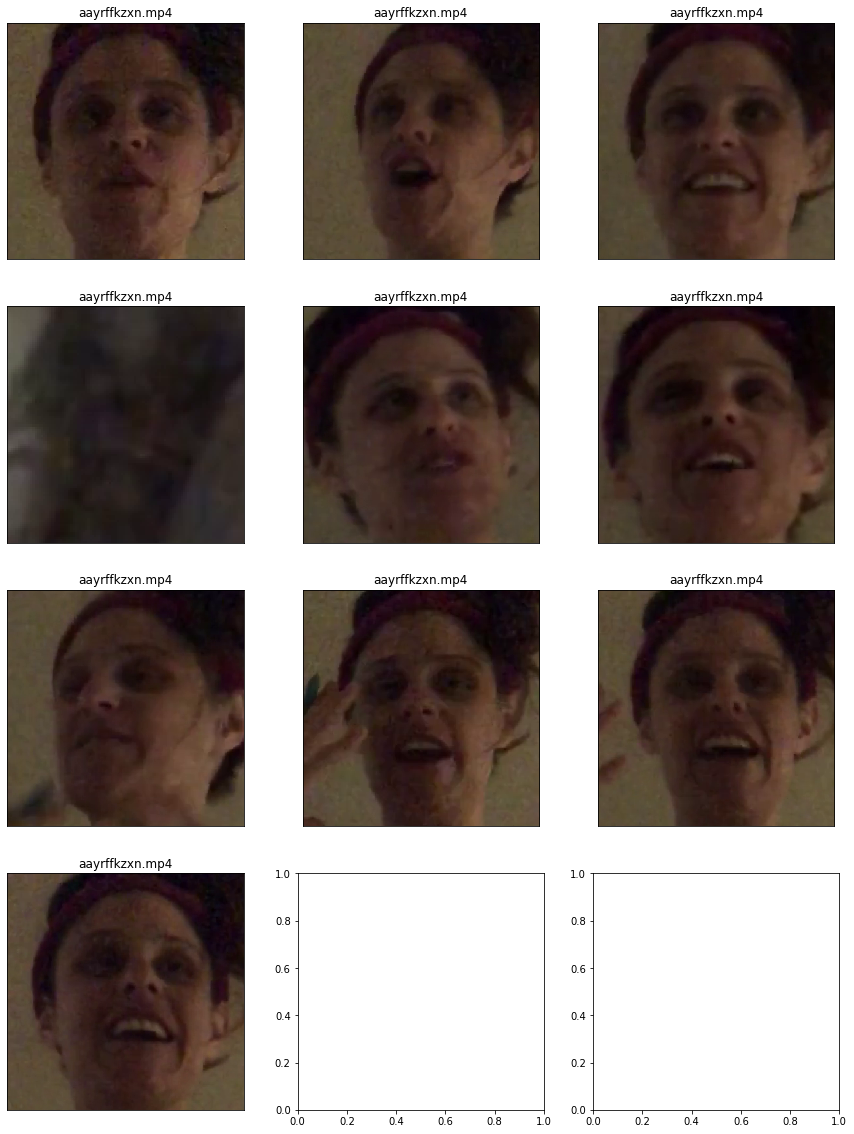

In [23]:
show_faces2(dfbox[:10])

In [76]:
dfbox.to_csv(bbox_path)
# dfbox = pd.read_csv('preprocess/bbox_real.csv',index_col=[0,1,2])

In [10]:
def skip_existed(indexes):
    ret = []
    for fn in indexes:
        cache_path = pathlib.Path(img_cache_path) / fn.split('.')[0]
        checks = np.linspace(0, 300 - 1, emb_frames).round().astype(int)
        for ck in checks:
            target_path = cache_path / (str(ck) + '.png')
            if not target_path.exists():
                ret.append(fn)
                break
    print(len(indexes), len(ret))
    return ret

In [11]:
realbox = {(file_name, frame):bboxes[0] for file_name,data in id2faces.items() for frame, bboxes in data.items()}
# idxes = skip_existed(train_sample_metadata[train_sample_metadata['label']=='FAKE'].index)
idxes = train_sample_metadata[train_sample_metadata['label']=='FAKE'].index

In [18]:
from shutil import copyfile

# os.system("rm -rf /home/kailu/temp/*")

# os.mkdir(temp_dir)
part1 = idxes[:len(idxes)//100]
part2 = idxes[len(idxes)//100:len(idxes)//2]
source = "/data1/data/deepfake/dfdc_train"
for fn in tqdm(partx):
    try:
        copyfile(os.path.join(source,fn) , os.path.join(temp_dir,fn))
    except:
        print("error on ", os.path.join(source,fn))

 19%|█▉        | 10/53 [00:00<00:02, 19.73it/s]

error on  /data1/data/deepfake/dfdc_train/pvohowzowy.mp4
error on  /data1/data/deepfake/dfdc_train/wipjitfmta.mp4
error on  /data1/data/deepfake/dfdc_train/wpuxmawbkj.mp4


 64%|██████▍   | 34/53 [00:01<00:00, 31.69it/s]

error on  /data1/data/deepfake/dfdc_train/cfxiikrhep.mp4
error on  /data1/data/deepfake/dfdc_train/dzjjtfwiqc.mp4
error on  /data1/data/deepfake/dfdc_train/glleqxulnn.mp4
error on  /data1/data/deepfake/dfdc_train/innmztffzd.mp4
error on  /data1/data/deepfake/dfdc_train/zzfhqvpsyp.mp4


100%|██████████| 53/53 [00:01<00:00, 25.75it/s]


In [4]:
import shutil
shutil.copytree("/data1/data/deepfake/dfdc_train", "/home/kailu/temp")

Error: [('/data1/data/deepfake/dfdc_train/avjkwuusto.mp4', '/home/kailu/temp/avjkwuusto.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/gxfaiqipcw.mp4', '/home/kailu/temp/gxfaiqipcw.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/mnvoukzemv.mp4', '/home/kailu/temp/mnvoukzemv.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/vaaxzughpn.mp4', '/home/kailu/temp/vaaxzughpn.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/gspcdmvvoj.mp4', '/home/kailu/temp/gspcdmvvoj.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/ruhmwfqklg.mp4', '/home/kailu/temp/ruhmwfqklg.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/ffjrlcvmkg.mp4', '/home/kailu/temp/ffjrlcvmkg.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/aligpjcnat.mp4', '/home/kailu/temp/aligpjcnat.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/oozwmptkku.mp4', '/home/kailu/temp/oozwmptkku.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/pllwlgzbkd.mp4', '/home/kailu/temp/pllwlgzbkd.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/lhmmwaigmr.mp4', '/home/kailu/temp/lhmmwaigmr.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/cokftyhjmk.mp4', '/home/kailu/temp/cokftyhjmk.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/zlmzvhjsgf.mp4', '/home/kailu/temp/zlmzvhjsgf.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/zzrppdukls.mp4', '/home/kailu/temp/zzrppdukls.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/iudajnmtun.mp4', '/home/kailu/temp/iudajnmtun.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/oaxsjqtisp.mp4', '/home/kailu/temp/oaxsjqtisp.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/qrstthlqfn.mp4', '/home/kailu/temp/qrstthlqfn.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/lnotnnpmyg.mp4', '/home/kailu/temp/lnotnnpmyg.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/gnlxtuygei.mp4', '/home/kailu/temp/gnlxtuygei.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/pebowyptab.mp4', '/home/kailu/temp/pebowyptab.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/ledddkfcbk.mp4', '/home/kailu/temp/ledddkfcbk.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/xowepsvqqi.mp4', '/home/kailu/temp/xowepsvqqi.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/vjgfrjkawv.mp4', '/home/kailu/temp/vjgfrjkawv.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/socbtjsjze.mp4', '/home/kailu/temp/socbtjsjze.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/chfeodetsk.mp4', '/home/kailu/temp/chfeodetsk.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/eeqtqmhxhc.mp4', '/home/kailu/temp/eeqtqmhxhc.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/hszyfhrdex.mp4', '/home/kailu/temp/hszyfhrdex.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/hhqtdepsyl.mp4', '/home/kailu/temp/hhqtdepsyl.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/goolpwftkw.mp4', '/home/kailu/temp/goolpwftkw.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/jbyzfrmrdh.mp4', '/home/kailu/temp/jbyzfrmrdh.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/ncrwgivkxi.mp4', '/home/kailu/temp/ncrwgivkxi.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/favydhlbyj.mp4', '/home/kailu/temp/favydhlbyj.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/fflfnwokgs.mp4', '/home/kailu/temp/fflfnwokgs.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/tbqxswvzxl.mp4', '/home/kailu/temp/tbqxswvzxl.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/nnztzqdnmx.mp4', '/home/kailu/temp/nnztzqdnmx.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/hlgbviwvka.mp4', '/home/kailu/temp/hlgbviwvka.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/arqbrqbjtt.mp4', '/home/kailu/temp/arqbrqbjtt.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/seyswbkbup.mp4', '/home/kailu/temp/seyswbkbup.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/laxeomdwou.mp4', '/home/kailu/temp/laxeomdwou.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/hwofkxxmyw.mp4', '/home/kailu/temp/hwofkxxmyw.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/xtmycsvhkf.mp4', '/home/kailu/temp/xtmycsvhkf.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/eiqkjgmjzj.mp4', '/home/kailu/temp/eiqkjgmjzj.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/ajrhthktnq.mp4', '/home/kailu/temp/ajrhthktnq.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/rgxbivulnj.mp4', '/home/kailu/temp/rgxbivulnj.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/pfdeaoykqt.mp4', '/home/kailu/temp/pfdeaoykqt.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/iszptuqyzd.mp4', '/home/kailu/temp/iszptuqyzd.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/rwewziejot.mp4', '/home/kailu/temp/rwewziejot.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/ndzseeklyg.mp4', '/home/kailu/temp/ndzseeklyg.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/gmyidmmfrj.mp4', '/home/kailu/temp/gmyidmmfrj.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/downwsebge.mp4', '/home/kailu/temp/downwsebge.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/rxxxurjxhf.mp4', '/home/kailu/temp/rxxxurjxhf.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/hpfxfxcedh.mp4', '/home/kailu/temp/hpfxfxcedh.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/yiqdjbotyg.mp4', '/home/kailu/temp/yiqdjbotyg.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/giekchmuor.mp4', '/home/kailu/temp/giekchmuor.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/zbenkghmif.mp4', '/home/kailu/temp/zbenkghmif.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/inmfczqyrh.mp4', '/home/kailu/temp/inmfczqyrh.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/ecqzntbaqf.mp4', '/home/kailu/temp/ecqzntbaqf.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/crkjzvzyzb.mp4', '/home/kailu/temp/crkjzvzyzb.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/rlgtivkoyy.mp4', '/home/kailu/temp/rlgtivkoyy.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/jjgcpugjwy.mp4', '/home/kailu/temp/jjgcpugjwy.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/ctfjmtuzcl.mp4', '/home/kailu/temp/ctfjmtuzcl.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/nmfhwrsvdj.mp4', '/home/kailu/temp/nmfhwrsvdj.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/ljwghjrlct.mp4', '/home/kailu/temp/ljwghjrlct.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/whurggewea.mp4', '/home/kailu/temp/whurggewea.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/zvqgdjiotu.mp4', '/home/kailu/temp/zvqgdjiotu.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/tdkloqlmkr.mp4', '/home/kailu/temp/tdkloqlmkr.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/nsjtsvvsly.mp4', '/home/kailu/temp/nsjtsvvsly.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/vagzowjsxb.mp4', '/home/kailu/temp/vagzowjsxb.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/lbmlxkfzku.mp4', '/home/kailu/temp/lbmlxkfzku.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/jkhsuxvoys.mp4', '/home/kailu/temp/jkhsuxvoys.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/byprvddfxd.mp4', '/home/kailu/temp/byprvddfxd.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/qhfcbqcogt.mp4', '/home/kailu/temp/qhfcbqcogt.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/uicmpptfdm.mp4', '/home/kailu/temp/uicmpptfdm.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/wjuuqzqnbb.mp4', '/home/kailu/temp/wjuuqzqnbb.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/yoxoltlhyj.mp4', '/home/kailu/temp/yoxoltlhyj.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/kilkyjkrkb.mp4', '/home/kailu/temp/kilkyjkrkb.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/lvgpazmvjm.mp4', '/home/kailu/temp/lvgpazmvjm.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/qtiqkcjuod.mp4', '/home/kailu/temp/qtiqkcjuod.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/bjeefxivfz.mp4', '/home/kailu/temp/bjeefxivfz.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/pnrtppildr.mp4', '/home/kailu/temp/pnrtppildr.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/uryamchmyh.mp4', '/home/kailu/temp/uryamchmyh.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/uvqgbpumou.mp4', '/home/kailu/temp/uvqgbpumou.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/gfwdfljehv.mp4', '/home/kailu/temp/gfwdfljehv.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/xwhuapurws.mp4', '/home/kailu/temp/xwhuapurws.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/fiaoioqikt.mp4', '/home/kailu/temp/fiaoioqikt.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/qbgziwaytb.mp4', '/home/kailu/temp/qbgziwaytb.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/fpnkzegrps.mp4', '/home/kailu/temp/fpnkzegrps.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/hhoaqazixk.mp4', '/home/kailu/temp/hhoaqazixk.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/tjmbssapbd.mp4', '/home/kailu/temp/tjmbssapbd.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/dwynqbgsue.mp4', '/home/kailu/temp/dwynqbgsue.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/bwwazyhjav.mp4', '/home/kailu/temp/bwwazyhjav.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/jvfmgrpknj.mp4', '/home/kailu/temp/jvfmgrpknj.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/jidbemztpa.mp4', '/home/kailu/temp/jidbemztpa.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/dthuejanym.mp4', '/home/kailu/temp/dthuejanym.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/jhzjdozpiy.mp4', '/home/kailu/temp/jhzjdozpiy.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/cynzudaqbx.mp4', '/home/kailu/temp/cynzudaqbx.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/khxfrwycqz.mp4', '/home/kailu/temp/khxfrwycqz.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/nlsnfgxits.mp4', '/home/kailu/temp/nlsnfgxits.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/ldaahdneqv.mp4', '/home/kailu/temp/ldaahdneqv.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/yxbzfwusxl.mp4', '/home/kailu/temp/yxbzfwusxl.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/ufxkptofgh.mp4', '/home/kailu/temp/ufxkptofgh.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/ckydqwehyb.mp4', '/home/kailu/temp/ckydqwehyb.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/iszopdcfmo.mp4', '/home/kailu/temp/iszopdcfmo.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/rwgwekqfij.mp4', '/home/kailu/temp/rwgwekqfij.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/icoqtpzktv.mp4', '/home/kailu/temp/icoqtpzktv.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/vevbgrnncl.mp4', '/home/kailu/temp/vevbgrnncl.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/axzmqrxpxn.mp4', '/home/kailu/temp/axzmqrxpxn.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/mfsoouplpq.mp4', '/home/kailu/temp/mfsoouplpq.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/salattzmhs.mp4', '/home/kailu/temp/salattzmhs.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/ecdmvsbwqi.mp4', '/home/kailu/temp/ecdmvsbwqi.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/wbrvrwhgzp.mp4', '/home/kailu/temp/wbrvrwhgzp.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/owniqnqpqs.mp4', '/home/kailu/temp/owniqnqpqs.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/rnqxzafqii.mp4', '/home/kailu/temp/rnqxzafqii.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/woptlijeiq.mp4', '/home/kailu/temp/woptlijeiq.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/jvoudxgubz.mp4', '/home/kailu/temp/jvoudxgubz.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/kycuhvvxty.mp4', '/home/kailu/temp/kycuhvvxty.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/scyowrqkep.mp4', '/home/kailu/temp/scyowrqkep.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/cabuhwkols.mp4', '/home/kailu/temp/cabuhwkols.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/joavzrzgqo.mp4', '/home/kailu/temp/joavzrzgqo.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/trginvkaom.mp4', '/home/kailu/temp/trginvkaom.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/qjhqctxknd.mp4', '/home/kailu/temp/qjhqctxknd.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/ungurxhlyr.mp4', '/home/kailu/temp/ungurxhlyr.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/izehsqyemw.mp4', '/home/kailu/temp/izehsqyemw.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/nqtymxrgnp.mp4', '/home/kailu/temp/nqtymxrgnp.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/eknonpmtkx.mp4', '/home/kailu/temp/eknonpmtkx.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/mqdcuhncqr.mp4', '/home/kailu/temp/mqdcuhncqr.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/nqegtvqlkq.mp4', '/home/kailu/temp/nqegtvqlkq.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/klsdwqcpme.mp4', '/home/kailu/temp/klsdwqcpme.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/ijeqomctsa.mp4', '/home/kailu/temp/ijeqomctsa.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/wetxiumbte.mp4', '/home/kailu/temp/wetxiumbte.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/ugqaxxrybr.mp4', '/home/kailu/temp/ugqaxxrybr.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/hegbcqtazt.mp4', '/home/kailu/temp/hegbcqtazt.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/vfkgzfdjsl.mp4', '/home/kailu/temp/vfkgzfdjsl.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/kwprqsipok.mp4', '/home/kailu/temp/kwprqsipok.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/xonaeungnm.mp4', '/home/kailu/temp/xonaeungnm.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/wntshsaoyt.mp4', '/home/kailu/temp/wntshsaoyt.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/cgtijpxnsr.mp4', '/home/kailu/temp/cgtijpxnsr.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/ahujkugdci.mp4', '/home/kailu/temp/ahujkugdci.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/hgbvxogyuv.mp4', '/home/kailu/temp/hgbvxogyuv.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/qfqxmlnwgg.mp4', '/home/kailu/temp/qfqxmlnwgg.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/gsoustqnhm.mp4', '/home/kailu/temp/gsoustqnhm.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/rzxrlycdbt.mp4', '/home/kailu/temp/rzxrlycdbt.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/juyweuyrcu.mp4', '/home/kailu/temp/juyweuyrcu.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/slbnzmdydv.mp4', '/home/kailu/temp/slbnzmdydv.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/hltccvujhf.mp4', '/home/kailu/temp/hltccvujhf.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/hetlhhxtlb.mp4', '/home/kailu/temp/hetlhhxtlb.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/iripapzncy.mp4', '/home/kailu/temp/iripapzncy.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/wlxuddmwft.mp4', '/home/kailu/temp/wlxuddmwft.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/irvwwgpili.mp4', '/home/kailu/temp/irvwwgpili.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/cmybfubapj.mp4', '/home/kailu/temp/cmybfubapj.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/uotxcyzzfw.mp4', '/home/kailu/temp/uotxcyzzfw.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/tmzcvtlrae.mp4', '/home/kailu/temp/tmzcvtlrae.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/pdzadxxidz.mp4', '/home/kailu/temp/pdzadxxidz.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/yfiqhuyiyh.mp4', '/home/kailu/temp/yfiqhuyiyh.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/qpkhdvcqkw.mp4', '/home/kailu/temp/qpkhdvcqkw.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/ixmtjukguq.mp4', '/home/kailu/temp/ixmtjukguq.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/dybfpqertz.mp4', '/home/kailu/temp/dybfpqertz.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/hlovscdksv.mp4', '/home/kailu/temp/hlovscdksv.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/zoypjvzpzt.mp4', '/home/kailu/temp/zoypjvzpzt.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/flbuoulzvu.mp4', '/home/kailu/temp/flbuoulzvu.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/suigngiafa.mp4', '/home/kailu/temp/suigngiafa.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/otkmoahrcb.mp4', '/home/kailu/temp/otkmoahrcb.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/aunsxsgprx.mp4', '/home/kailu/temp/aunsxsgprx.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/mafqmcwarm.mp4', '/home/kailu/temp/mafqmcwarm.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/kmgudgiwxv.mp4', '/home/kailu/temp/kmgudgiwxv.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/qqxzbhmqnk.mp4', '/home/kailu/temp/qqxzbhmqnk.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/atrmrdhzrk.mp4', '/home/kailu/temp/atrmrdhzrk.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/ahencqpiin.mp4', '/home/kailu/temp/ahencqpiin.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/fssfgtoucb.mp4', '/home/kailu/temp/fssfgtoucb.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/rdpseeyfgp.mp4', '/home/kailu/temp/rdpseeyfgp.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/ccdxpgcufs.mp4', '/home/kailu/temp/ccdxpgcufs.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/oybxaloitb.mp4', '/home/kailu/temp/oybxaloitb.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/rpljvwirib.mp4', '/home/kailu/temp/rpljvwirib.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/pslavnuzte.mp4', '/home/kailu/temp/pslavnuzte.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/qldfxrllvm.mp4', '/home/kailu/temp/qldfxrllvm.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/hdaleijded.mp4', '/home/kailu/temp/hdaleijded.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/ndonldsrsr.mp4', '/home/kailu/temp/ndonldsrsr.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/tpllvuidve.mp4', '/home/kailu/temp/tpllvuidve.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/bevjclbhuo.mp4', '/home/kailu/temp/bevjclbhuo.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/xnkcvmtiwg.mp4', '/home/kailu/temp/xnkcvmtiwg.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/xnchgengsw.mp4', '/home/kailu/temp/xnchgengsw.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/wkpvdjgekz.mp4', '/home/kailu/temp/wkpvdjgekz.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/weektplqak.mp4', '/home/kailu/temp/weektplqak.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/orascrofjq.mp4', '/home/kailu/temp/orascrofjq.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/prfgrrfhvn.mp4', '/home/kailu/temp/prfgrrfhvn.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/iixchmxmnj.mp4', '/home/kailu/temp/iixchmxmnj.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/dorerwjhvj.mp4', '/home/kailu/temp/dorerwjhvj.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/raiqyyzhrw.mp4', '/home/kailu/temp/raiqyyzhrw.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/sdacwaoens.mp4', '/home/kailu/temp/sdacwaoens.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/ahksrawlnz.mp4', '/home/kailu/temp/ahksrawlnz.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/mbiyqplimk.mp4', '/home/kailu/temp/mbiyqplimk.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/szxfjsgobt.mp4', '/home/kailu/temp/szxfjsgobt.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/smyyyyqrux.mp4', '/home/kailu/temp/smyyyyqrux.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/fyqiaczkju.mp4', '/home/kailu/temp/fyqiaczkju.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/aytalckkea.mp4', '/home/kailu/temp/aytalckkea.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/gefwxtpjiz.mp4', '/home/kailu/temp/gefwxtpjiz.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/vauwkkjikv.mp4', '/home/kailu/temp/vauwkkjikv.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/lcuvarnwxw.mp4', '/home/kailu/temp/lcuvarnwxw.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/mcuuggsqcr.mp4', '/home/kailu/temp/mcuuggsqcr.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/ldlwlefhld.mp4', '/home/kailu/temp/ldlwlefhld.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/fuiqfutwni.mp4', '/home/kailu/temp/fuiqfutwni.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/uswrijmnfv.mp4', '/home/kailu/temp/uswrijmnfv.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/usjdpptrju.mp4', '/home/kailu/temp/usjdpptrju.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/kkcatvccnj.mp4', '/home/kailu/temp/kkcatvccnj.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/xwnrkzuafj.mp4', '/home/kailu/temp/xwnrkzuafj.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/jjpjogwxzx.mp4', '/home/kailu/temp/jjpjogwxzx.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/domsajovzs.mp4', '/home/kailu/temp/domsajovzs.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/souczoeetc.mp4', '/home/kailu/temp/souczoeetc.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/lerjgqpwfr.mp4', '/home/kailu/temp/lerjgqpwfr.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/erjpgbkeif.mp4', '/home/kailu/temp/erjpgbkeif.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/dhazowlcun.mp4', '/home/kailu/temp/dhazowlcun.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/alveuecehk.mp4', '/home/kailu/temp/alveuecehk.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/grddzuexmx.mp4', '/home/kailu/temp/grddzuexmx.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/vwhuhlhctt.mp4', '/home/kailu/temp/vwhuhlhctt.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/htoyvdszos.mp4', '/home/kailu/temp/htoyvdszos.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/ostcsbcbdb.mp4', '/home/kailu/temp/ostcsbcbdb.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/rxiiaaarex.mp4', '/home/kailu/temp/rxiiaaarex.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/miyvdzmmjh.mp4', '/home/kailu/temp/miyvdzmmjh.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/nnsarxezod.mp4', '/home/kailu/temp/nnsarxezod.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/vpdkhufhhw.mp4', '/home/kailu/temp/vpdkhufhhw.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/kxxbzlzawn.mp4', '/home/kailu/temp/kxxbzlzawn.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/koqczibqxz.mp4', '/home/kailu/temp/koqczibqxz.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/ajquhoecmv.mp4', '/home/kailu/temp/ajquhoecmv.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/skmuamgebu.mp4', '/home/kailu/temp/skmuamgebu.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/ufcxtzoxhl.mp4', '/home/kailu/temp/ufcxtzoxhl.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/wbzplejali.mp4', '/home/kailu/temp/wbzplejali.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/kzrtmgygnq.mp4', '/home/kailu/temp/kzrtmgygnq.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/cxnrivifkn.mp4', '/home/kailu/temp/cxnrivifkn.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/zuzkjzqhlk.mp4', '/home/kailu/temp/zuzkjzqhlk.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/rovilxwhnt.mp4', '/home/kailu/temp/rovilxwhnt.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/akvsnzgqrx.mp4', '/home/kailu/temp/akvsnzgqrx.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/xlusjtfzjc.mp4', '/home/kailu/temp/xlusjtfzjc.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/dzhvblathg.mp4', '/home/kailu/temp/dzhvblathg.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/cxnoxemydo.mp4', '/home/kailu/temp/cxnoxemydo.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/uhudvkbmat.mp4', '/home/kailu/temp/uhudvkbmat.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/okwivofbnd.mp4', '/home/kailu/temp/okwivofbnd.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/vgmvjwslby.mp4', '/home/kailu/temp/vgmvjwslby.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/tzymnaotuh.mp4', '/home/kailu/temp/tzymnaotuh.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/uohjdlbnas.mp4', '/home/kailu/temp/uohjdlbnas.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/rbhtlmgqqa.mp4', '/home/kailu/temp/rbhtlmgqqa.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/bhmwkkxunf.mp4', '/home/kailu/temp/bhmwkkxunf.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/xvjjxhjqka.mp4', '/home/kailu/temp/xvjjxhjqka.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/qxfhygppeb.mp4', '/home/kailu/temp/qxfhygppeb.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/ynfrgztswk.mp4', '/home/kailu/temp/ynfrgztswk.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/uwwuzyshur.mp4', '/home/kailu/temp/uwwuzyshur.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/urpqcasyii.mp4', '/home/kailu/temp/urpqcasyii.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/bactcvwhqk.mp4', '/home/kailu/temp/bactcvwhqk.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/limkffcjki.mp4', '/home/kailu/temp/limkffcjki.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/xcfgqlhrir.mp4', '/home/kailu/temp/xcfgqlhrir.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/lzbywctalw.mp4', '/home/kailu/temp/lzbywctalw.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/gwjvucdwox.mp4', '/home/kailu/temp/gwjvucdwox.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/uadarctaqw.mp4', '/home/kailu/temp/uadarctaqw.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/kczoxdjadr.mp4', '/home/kailu/temp/kczoxdjadr.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/fqzrykvrmo.mp4', '/home/kailu/temp/fqzrykvrmo.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/pppywrdngk.mp4', '/home/kailu/temp/pppywrdngk.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/tzqbhtvflg.mp4', '/home/kailu/temp/tzqbhtvflg.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/pumffnnouu.mp4', '/home/kailu/temp/pumffnnouu.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/rvvzhkhvcd.mp4', '/home/kailu/temp/rvvzhkhvcd.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/qjoqnqyvkl.mp4', '/home/kailu/temp/qjoqnqyvkl.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/ovycdqoabt.mp4', '/home/kailu/temp/ovycdqoabt.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/erbnvtidau.mp4', '/home/kailu/temp/erbnvtidau.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/aqlwusgzbf.mp4', '/home/kailu/temp/aqlwusgzbf.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/ndqwevrpnb.mp4', '/home/kailu/temp/ndqwevrpnb.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/exzkbgzgib.mp4', '/home/kailu/temp/exzkbgzgib.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/oqltezdtla.mp4', '/home/kailu/temp/oqltezdtla.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/yaoosnvbct.mp4', '/home/kailu/temp/yaoosnvbct.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/fqecackmla.mp4', '/home/kailu/temp/fqecackmla.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/mgbqujfpob.mp4', '/home/kailu/temp/mgbqujfpob.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/tjemkmxoak.mp4', '/home/kailu/temp/tjemkmxoak.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/rkacapjxgh.mp4', '/home/kailu/temp/rkacapjxgh.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/iwdittzleo.mp4', '/home/kailu/temp/iwdittzleo.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/vlzgrroxoh.mp4', '/home/kailu/temp/vlzgrroxoh.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/onwzxyouet.mp4', '/home/kailu/temp/onwzxyouet.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/pnctmlfama.mp4', '/home/kailu/temp/pnctmlfama.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/hnqocyfmyk.mp4', '/home/kailu/temp/hnqocyfmyk.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/aruwupqwsc.mp4', '/home/kailu/temp/aruwupqwsc.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/udhjcljtxr.mp4', '/home/kailu/temp/udhjcljtxr.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/ztopghzixw.mp4', '/home/kailu/temp/ztopghzixw.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/atvnqtubdj.mp4', '/home/kailu/temp/atvnqtubdj.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/fqjrreaffk.mp4', '/home/kailu/temp/fqjrreaffk.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/qundhdchms.mp4', '/home/kailu/temp/qundhdchms.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/rgmrwsxlxw.mp4', '/home/kailu/temp/rgmrwsxlxw.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/ybocqlrhvt.mp4', '/home/kailu/temp/ybocqlrhvt.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/ksmdmleiqc.mp4', '/home/kailu/temp/ksmdmleiqc.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/uvbzzcthwp.mp4', '/home/kailu/temp/uvbzzcthwp.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/wzzyccdpyf.mp4', '/home/kailu/temp/wzzyccdpyf.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/wdisiugwzf.mp4', '/home/kailu/temp/wdisiugwzf.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/zirmjdmepa.mp4', '/home/kailu/temp/zirmjdmepa.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/yfttqqyexx.mp4', '/home/kailu/temp/yfttqqyexx.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/xyrdxhiiju.mp4', '/home/kailu/temp/xyrdxhiiju.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/yyiagamlyb.mp4', '/home/kailu/temp/yyiagamlyb.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/shmlqhtbam.mp4', '/home/kailu/temp/shmlqhtbam.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/jpkoxyoqos.mp4', '/home/kailu/temp/jpkoxyoqos.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/omfnfjycik.mp4', '/home/kailu/temp/omfnfjycik.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/atpngxfnhr.mp4', '/home/kailu/temp/atpngxfnhr.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/thxymosdkd.mp4', '/home/kailu/temp/thxymosdkd.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/qrgezzxkzw.mp4', '/home/kailu/temp/qrgezzxkzw.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/kwxjncspoh.mp4', '/home/kailu/temp/kwxjncspoh.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/ldgyvmesld.mp4', '/home/kailu/temp/ldgyvmesld.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/ycltrqcdxr.mp4', '/home/kailu/temp/ycltrqcdxr.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/qrgrezupjj.mp4', '/home/kailu/temp/qrgrezupjj.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/odgsohkpfu.mp4', '/home/kailu/temp/odgsohkpfu.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/uryuqtrxqu.mp4', '/home/kailu/temp/uryuqtrxqu.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/ewwkfljrua.mp4', '/home/kailu/temp/ewwkfljrua.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/hfdqlrmahm.mp4', '/home/kailu/temp/hfdqlrmahm.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/vypyrwpwdu.mp4', '/home/kailu/temp/vypyrwpwdu.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/szddzrhmep.mp4', '/home/kailu/temp/szddzrhmep.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/rozowkykwk.mp4', '/home/kailu/temp/rozowkykwk.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/wssvyxdsox.mp4', '/home/kailu/temp/wssvyxdsox.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/qxfybzsxfr.mp4', '/home/kailu/temp/qxfybzsxfr.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/wtvdnpyslw.mp4', '/home/kailu/temp/wtvdnpyslw.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/rhjzplqoes.mp4', '/home/kailu/temp/rhjzplqoes.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/qbukkfjscz.mp4', '/home/kailu/temp/qbukkfjscz.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/kgeixehmwu.mp4', '/home/kailu/temp/kgeixehmwu.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/kfykpvnplm.mp4', '/home/kailu/temp/kfykpvnplm.mp4', "[Errno 28] No space left on device: '/home/kailu/temp/kfykpvnplm.mp4'"), ('/data1/data/deepfake/dfdc_train/tmldrqcmkh.mp4', '/home/kailu/temp/tmldrqcmkh.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/fnlepxxlip.mp4', '/home/kailu/temp/fnlepxxlip.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/jknutfonoa.mp4', '/home/kailu/temp/jknutfonoa.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/mvcusklvqb.mp4', '/home/kailu/temp/mvcusklvqb.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/jozivrywzt.mp4', '/home/kailu/temp/jozivrywzt.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/txjjrgclao.mp4', '/home/kailu/temp/txjjrgclao.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/npdepbgwiv.mp4', '/home/kailu/temp/npdepbgwiv.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/redhlohvyi.mp4', '/home/kailu/temp/redhlohvyi.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/bvzxdqpuzz.mp4', '/home/kailu/temp/bvzxdqpuzz.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/rxqvqczepk.mp4', '/home/kailu/temp/rxqvqczepk.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/nisxdaqdxi.mp4', '/home/kailu/temp/nisxdaqdxi.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/oeoliupynd.mp4', '/home/kailu/temp/oeoliupynd.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/bjforfzjqi.mp4', '/home/kailu/temp/bjforfzjqi.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/lvpifaenhc.mp4', '/home/kailu/temp/lvpifaenhc.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/ybvrdzwlcw.mp4', '/home/kailu/temp/ybvrdzwlcw.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/bswoxmwklo.mp4', '/home/kailu/temp/bswoxmwklo.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/yumbglcwvv.mp4', '/home/kailu/temp/yumbglcwvv.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/ddsylmermi.mp4', '/home/kailu/temp/ddsylmermi.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/yfrqpsgblm.mp4', '/home/kailu/temp/yfrqpsgblm.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/sqroobfhid.mp4', '/home/kailu/temp/sqroobfhid.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/kvvbbmqkld.mp4', '/home/kailu/temp/kvvbbmqkld.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/tttnqhksxz.mp4', '/home/kailu/temp/tttnqhksxz.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/wzbhnryjxb.mp4', '/home/kailu/temp/wzbhnryjxb.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/ibqmomrlro.mp4', '/home/kailu/temp/ibqmomrlro.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/iilxfvdyrq.mp4', '/home/kailu/temp/iilxfvdyrq.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/vanrrdlsts.mp4', '/home/kailu/temp/vanrrdlsts.mp4', "[Errno 28] No space left on device: '/home/kailu/temp/vanrrdlsts.mp4'"), ('/data1/data/deepfake/dfdc_train/iwandsrlhu.mp4', '/home/kailu/temp/iwandsrlhu.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/tebattlfrp.mp4', '/home/kailu/temp/tebattlfrp.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/ykppdftcnh.mp4', '/home/kailu/temp/ykppdftcnh.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/xfvvkbvkvg.mp4', '/home/kailu/temp/xfvvkbvkvg.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/krlosfjfpm.mp4', '/home/kailu/temp/krlosfjfpm.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/dtzxmoukfk.mp4', '/home/kailu/temp/dtzxmoukfk.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/crlollqxtq.mp4', '/home/kailu/temp/crlollqxtq.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/ivarngiehh.mp4', '/home/kailu/temp/ivarngiehh.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/fyadnomkax.mp4', '/home/kailu/temp/fyadnomkax.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/grcqwetjrz.mp4', '/home/kailu/temp/grcqwetjrz.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/bpogbhuwvd.mp4', '/home/kailu/temp/bpogbhuwvd.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/vxbxvwazua.mp4', '/home/kailu/temp/vxbxvwazua.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/jofkmrngjg.mp4', '/home/kailu/temp/jofkmrngjg.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/cwtgddlhby.mp4', '/home/kailu/temp/cwtgddlhby.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/cdkgkspxwg.mp4', '/home/kailu/temp/cdkgkspxwg.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/dedfmnngpk.mp4', '/home/kailu/temp/dedfmnngpk.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/zfabntnwpm.mp4', '/home/kailu/temp/zfabntnwpm.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/jcxwhrrxda.mp4', '/home/kailu/temp/jcxwhrrxda.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/metadata_35.json', '/home/kailu/temp/metadata_35.json', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/alewdsjvbk.mp4', '/home/kailu/temp/alewdsjvbk.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/ksgtyuuxzg.mp4', '/home/kailu/temp/ksgtyuuxzg.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/vrzbmrqubm.mp4', '/home/kailu/temp/vrzbmrqubm.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/ciyvpljyvt.mp4', '/home/kailu/temp/ciyvpljyvt.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/feouzuufou.mp4', '/home/kailu/temp/feouzuufou.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/teihmxslwz.mp4', '/home/kailu/temp/teihmxslwz.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/bjeskyiyhr.mp4', '/home/kailu/temp/bjeskyiyhr.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/kaggpclkjm.mp4', '/home/kailu/temp/kaggpclkjm.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/duczhwighk.mp4', '/home/kailu/temp/duczhwighk.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/kxvrmszevj.mp4', '/home/kailu/temp/kxvrmszevj.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/ngmjjareeb.mp4', '/home/kailu/temp/ngmjjareeb.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/uyjcuvowxm.mp4', '/home/kailu/temp/uyjcuvowxm.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/amkaqehlum.mp4', '/home/kailu/temp/amkaqehlum.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/cwasnpqxck.mp4', '/home/kailu/temp/cwasnpqxck.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/rfofxtwdxp.mp4', '/home/kailu/temp/rfofxtwdxp.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/vamsokbgtw.mp4', '/home/kailu/temp/vamsokbgtw.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/jdpoqewunc.mp4', '/home/kailu/temp/jdpoqewunc.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/bwmhmjdpbh.mp4', '/home/kailu/temp/bwmhmjdpbh.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/eqpbudnwga.mp4', '/home/kailu/temp/eqpbudnwga.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/qprtbkloye.mp4', '/home/kailu/temp/qprtbkloye.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/cdairnevmw.mp4', '/home/kailu/temp/cdairnevmw.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/wpqumfidrb.mp4', '/home/kailu/temp/wpqumfidrb.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/klidyuxkjv.mp4', '/home/kailu/temp/klidyuxkjv.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/axqtnlxfzl.mp4', '/home/kailu/temp/axqtnlxfzl.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/vhrsrexhgu.mp4', '/home/kailu/temp/vhrsrexhgu.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/fwtmmkthxf.mp4', '/home/kailu/temp/fwtmmkthxf.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/zhikfuveaj.mp4', '/home/kailu/temp/zhikfuveaj.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/wzrzjdwssl.mp4', '/home/kailu/temp/wzrzjdwssl.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/eawmxkambo.mp4', '/home/kailu/temp/eawmxkambo.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/tqdixfliwk.mp4', '/home/kailu/temp/tqdixfliwk.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/yvdxquwtfh.mp4', '/home/kailu/temp/yvdxquwtfh.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/rjyamsinkv.mp4', '/home/kailu/temp/rjyamsinkv.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/jtzveqmnnr.mp4', '/home/kailu/temp/jtzveqmnnr.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/dvoogowijs.mp4', '/home/kailu/temp/dvoogowijs.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/bvbrngubgv.mp4', '/home/kailu/temp/bvbrngubgv.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/jzqyvqcmar.mp4', '/home/kailu/temp/jzqyvqcmar.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/ysefhwaftq.mp4', '/home/kailu/temp/ysefhwaftq.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/gjwjxdnaip.mp4', '/home/kailu/temp/gjwjxdnaip.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/pwssgblgzu.mp4', '/home/kailu/temp/pwssgblgzu.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/bjkmjilrxp.mp4', '/home/kailu/temp/bjkmjilrxp.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/zpjeilpjrv.mp4', '/home/kailu/temp/zpjeilpjrv.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/oeluedpebu.mp4', '/home/kailu/temp/oeluedpebu.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/iscbfzqeyn.mp4', '/home/kailu/temp/iscbfzqeyn.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/mrsksioeuz.mp4', '/home/kailu/temp/mrsksioeuz.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/pbxzemqngk.mp4', '/home/kailu/temp/pbxzemqngk.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/svufgqgkbf.mp4', '/home/kailu/temp/svufgqgkbf.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/ahtaeeesuo.mp4', '/home/kailu/temp/ahtaeeesuo.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/onuzugluyf.mp4', '/home/kailu/temp/onuzugluyf.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/ovzgovomaw.mp4', '/home/kailu/temp/ovzgovomaw.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/ukwjomvjiq.mp4', '/home/kailu/temp/ukwjomvjiq.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/xkgfafkidn.mp4', '/home/kailu/temp/xkgfafkidn.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/rbinzvmbuj.mp4', '/home/kailu/temp/rbinzvmbuj.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/vtfpbtmgfh.mp4', '/home/kailu/temp/vtfpbtmgfh.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/btiwatmwqq.mp4', '/home/kailu/temp/btiwatmwqq.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/tpkcodbqhe.mp4', '/home/kailu/temp/tpkcodbqhe.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/szadufrgqe.mp4', '/home/kailu/temp/szadufrgqe.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/mumsfylhnz.mp4', '/home/kailu/temp/mumsfylhnz.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/hlcpwfwcyw.mp4', '/home/kailu/temp/hlcpwfwcyw.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/fauvmbfyay.mp4', '/home/kailu/temp/fauvmbfyay.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/ebgmolbmjs.mp4', '/home/kailu/temp/ebgmolbmjs.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/jacmgbjhwo.mp4', '/home/kailu/temp/jacmgbjhwo.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/ligbregedh.mp4', '/home/kailu/temp/ligbregedh.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/okpndbulck.mp4', '/home/kailu/temp/okpndbulck.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/xjpuqaqamf.mp4', '/home/kailu/temp/xjpuqaqamf.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/ogtgnhltab.mp4', '/home/kailu/temp/ogtgnhltab.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/zbafmuwlpi.mp4', '/home/kailu/temp/zbafmuwlpi.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/mhaflpleny.mp4', '/home/kailu/temp/mhaflpleny.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/uqrgyoozvq.mp4', '/home/kailu/temp/uqrgyoozvq.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/iobnxqtkgg.mp4', '/home/kailu/temp/iobnxqtkgg.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/qppxqiciew.mp4', '/home/kailu/temp/qppxqiciew.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/yudzbztyle.mp4', '/home/kailu/temp/yudzbztyle.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/jxgcqvykfy.mp4', '/home/kailu/temp/jxgcqvykfy.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/defoxhdwiy.mp4', '/home/kailu/temp/defoxhdwiy.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/tawqkgdzsw.mp4', '/home/kailu/temp/tawqkgdzsw.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/xjsbsgisgv.mp4', '/home/kailu/temp/xjsbsgisgv.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/lxphgotkgu.mp4', '/home/kailu/temp/lxphgotkgu.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/meqenphmnq.mp4', '/home/kailu/temp/meqenphmnq.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/nvahuocllf.mp4', '/home/kailu/temp/nvahuocllf.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/tvzpuvfhxk.mp4', '/home/kailu/temp/tvzpuvfhxk.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/eukebgiccw.mp4', '/home/kailu/temp/eukebgiccw.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/buabafojmo.mp4', '/home/kailu/temp/buabafojmo.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/aejnircxtk.mp4', '/home/kailu/temp/aejnircxtk.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/qzrqqhfrgz.mp4', '/home/kailu/temp/qzrqqhfrgz.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/kfihjlyzlv.mp4', '/home/kailu/temp/kfihjlyzlv.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/dpwxclnvav.mp4', '/home/kailu/temp/dpwxclnvav.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/nybwcoxish.mp4', '/home/kailu/temp/nybwcoxish.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/qddycmeefa.mp4', '/home/kailu/temp/qddycmeefa.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/jnqbxiqhfw.mp4', '/home/kailu/temp/jnqbxiqhfw.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/jpvkoxrueh.mp4', '/home/kailu/temp/jpvkoxrueh.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/jzzzldndhb.mp4', '/home/kailu/temp/jzzzldndhb.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/rhuwogthox.mp4', '/home/kailu/temp/rhuwogthox.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/hvbncqsyez.mp4', '/home/kailu/temp/hvbncqsyez.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/mgvexgxjsi.mp4', '/home/kailu/temp/mgvexgxjsi.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/uchjyaeqnm.mp4', '/home/kailu/temp/uchjyaeqnm.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/kpnsiqmksz.mp4', '/home/kailu/temp/kpnsiqmksz.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/ienpqtctso.mp4', '/home/kailu/temp/ienpqtctso.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/memxryggjc.mp4', '/home/kailu/temp/memxryggjc.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/dtfjzvikwk.mp4', '/home/kailu/temp/dtfjzvikwk.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/bjifxxuftr.mp4', '/home/kailu/temp/bjifxxuftr.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/xlwvliqwiy.mp4', '/home/kailu/temp/xlwvliqwiy.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/ijxvacjkcd.mp4', '/home/kailu/temp/ijxvacjkcd.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/qpevfrkxbn.mp4', '/home/kailu/temp/qpevfrkxbn.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/eqlygriwog.mp4', '/home/kailu/temp/eqlygriwog.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/ndtshemwsm.mp4', '/home/kailu/temp/ndtshemwsm.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/zugpusfgdw.mp4', '/home/kailu/temp/zugpusfgdw.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/dydfvqqufi.mp4', '/home/kailu/temp/dydfvqqufi.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/xlklgamhbq.mp4', '/home/kailu/temp/xlklgamhbq.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/zrfmmcvplh.mp4', '/home/kailu/temp/zrfmmcvplh.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/pdcpwuwggl.mp4', '/home/kailu/temp/pdcpwuwggl.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/eidjkkcbhy.mp4', '/home/kailu/temp/eidjkkcbhy.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/hhxhbuqlma.mp4', '/home/kailu/temp/hhxhbuqlma.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/vzxkxnvuwb.mp4', '/home/kailu/temp/vzxkxnvuwb.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/aspymrzpyt.mp4', '/home/kailu/temp/aspymrzpyt.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/juaelozfre.mp4', '/home/kailu/temp/juaelozfre.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/kbeemwsesq.mp4', '/home/kailu/temp/kbeemwsesq.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/zpibtbmpvb.mp4', '/home/kailu/temp/zpibtbmpvb.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/hluynpkvgv.mp4', '/home/kailu/temp/hluynpkvgv.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/bhjwfpvcvq.mp4', '/home/kailu/temp/bhjwfpvcvq.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/kjyapeagbg.mp4', '/home/kailu/temp/kjyapeagbg.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/akgiqpwmsv.mp4', '/home/kailu/temp/akgiqpwmsv.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/sjsweftixr.mp4', '/home/kailu/temp/sjsweftixr.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/qzjfttrrqo.mp4', '/home/kailu/temp/qzjfttrrqo.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/esijwoctuo.mp4', '/home/kailu/temp/esijwoctuo.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/cuphoipnua.mp4', '/home/kailu/temp/cuphoipnua.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/gjadwclfiq.mp4', '/home/kailu/temp/gjadwclfiq.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/qucamnjqqf.mp4', '/home/kailu/temp/qucamnjqqf.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/ewtygmmlsd.mp4', '/home/kailu/temp/ewtygmmlsd.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/cpgtztewxf.mp4', '/home/kailu/temp/cpgtztewxf.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/qfignkscqm.mp4', '/home/kailu/temp/qfignkscqm.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/nedgimdrmp.mp4', '/home/kailu/temp/nedgimdrmp.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/wihjnuxjjd.mp4', '/home/kailu/temp/wihjnuxjjd.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/ijlhhcoqml.mp4', '/home/kailu/temp/ijlhhcoqml.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/rqfbuwfiqx.mp4', '/home/kailu/temp/rqfbuwfiqx.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/cnlovaecgh.mp4', '/home/kailu/temp/cnlovaecgh.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/ffwwiszvdg.mp4', '/home/kailu/temp/ffwwiszvdg.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/khozecxqni.mp4', '/home/kailu/temp/khozecxqni.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/xtoxvosuzj.mp4', '/home/kailu/temp/xtoxvosuzj.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/gdjcfraspf.mp4', '/home/kailu/temp/gdjcfraspf.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/ubtptsudra.mp4', '/home/kailu/temp/ubtptsudra.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/eyamnjolnp.mp4', '/home/kailu/temp/eyamnjolnp.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/awerihgcpz.mp4', '/home/kailu/temp/awerihgcpz.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/pupinebqev.mp4', '/home/kailu/temp/pupinebqev.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/qefmxjllxx.mp4', '/home/kailu/temp/qefmxjllxx.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/nnjpfzusji.mp4', '/home/kailu/temp/nnjpfzusji.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/zgambitwhp.mp4', '/home/kailu/temp/zgambitwhp.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/uhcbanfylw.mp4', '/home/kailu/temp/uhcbanfylw.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/oqmgquqrzg.mp4', '/home/kailu/temp/oqmgquqrzg.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/minpodxkuj.mp4', '/home/kailu/temp/minpodxkuj.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/wrbwtlhtqo.mp4', '/home/kailu/temp/wrbwtlhtqo.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/vxpabktsbm.mp4', '/home/kailu/temp/vxpabktsbm.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/uofvmcxbgg.mp4', '/home/kailu/temp/uofvmcxbgg.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/cwhocpcoqq.mp4', '/home/kailu/temp/cwhocpcoqq.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/lczxgvazvr.mp4', '/home/kailu/temp/lczxgvazvr.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/euwlescdpt.mp4', '/home/kailu/temp/euwlescdpt.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/cxzqexgpeu.mp4', '/home/kailu/temp/cxzqexgpeu.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/yhtyqgfivs.mp4', '/home/kailu/temp/yhtyqgfivs.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/ntbglqqeiq.mp4', '/home/kailu/temp/ntbglqqeiq.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/ickgmyiabp.mp4', '/home/kailu/temp/ickgmyiabp.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/ercvvpuoqo.mp4', '/home/kailu/temp/ercvvpuoqo.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/ucyuwurana.mp4', '/home/kailu/temp/ucyuwurana.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/qtoctusxyk.mp4', '/home/kailu/temp/qtoctusxyk.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/ybgjijobya.mp4', '/home/kailu/temp/ybgjijobya.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/ekidiquivf.mp4', '/home/kailu/temp/ekidiquivf.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/xbnexxtwrg.mp4', '/home/kailu/temp/xbnexxtwrg.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/hxfqltenqh.mp4', '/home/kailu/temp/hxfqltenqh.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/bahdhnhycu.mp4', '/home/kailu/temp/bahdhnhycu.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/vxzevjxptf.mp4', '/home/kailu/temp/vxzevjxptf.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/xxhbjrpyij.mp4', '/home/kailu/temp/xxhbjrpyij.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/sxkkwgghqz.mp4', '/home/kailu/temp/sxkkwgghqz.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/povxjetlon.mp4', '/home/kailu/temp/povxjetlon.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/bcenttyeoc.mp4', '/home/kailu/temp/bcenttyeoc.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/evkkjgvprd.mp4', '/home/kailu/temp/evkkjgvprd.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/dehaljckyt.mp4', '/home/kailu/temp/dehaljckyt.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/fokzwocift.mp4', '/home/kailu/temp/fokzwocift.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/dultiznosk.mp4', '/home/kailu/temp/dultiznosk.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/wgzigaxpas.mp4', '/home/kailu/temp/wgzigaxpas.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/hiyergvepo.mp4', '/home/kailu/temp/hiyergvepo.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/pdxrkshcdo.mp4', '/home/kailu/temp/pdxrkshcdo.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/jebwesgcko.mp4', '/home/kailu/temp/jebwesgcko.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/yqjbedxnlk.mp4', '/home/kailu/temp/yqjbedxnlk.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/zomavewiba.mp4', '/home/kailu/temp/zomavewiba.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/fcocsuznuz.mp4', '/home/kailu/temp/fcocsuznuz.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/ldpuoyalqs.mp4', '/home/kailu/temp/ldpuoyalqs.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/ivxeahfygq.mp4', '/home/kailu/temp/ivxeahfygq.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/ictsrbvpyw.mp4', '/home/kailu/temp/ictsrbvpyw.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/jgwmeuaiyk.mp4', '/home/kailu/temp/jgwmeuaiyk.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/skdxovvbku.mp4', '/home/kailu/temp/skdxovvbku.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/emrmblrrtm.mp4', '/home/kailu/temp/emrmblrrtm.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/rxilpbpeqt.mp4', '/home/kailu/temp/rxilpbpeqt.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/abeknwzbhx.mp4', '/home/kailu/temp/abeknwzbhx.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/tbcbvehccy.mp4', '/home/kailu/temp/tbcbvehccy.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/pcoenxjslw.mp4', '/home/kailu/temp/pcoenxjslw.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/swsrlhgawc.mp4', '/home/kailu/temp/swsrlhgawc.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/xqvovvqxfk.mp4', '/home/kailu/temp/xqvovvqxfk.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/lqrnsotrrs.mp4', '/home/kailu/temp/lqrnsotrrs.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/asdvrcdjoo.mp4', '/home/kailu/temp/asdvrcdjoo.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/hnonyvtuvx.mp4', '/home/kailu/temp/hnonyvtuvx.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/pqsagmqjeh.mp4', '/home/kailu/temp/pqsagmqjeh.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/wyncesxcil.mp4', '/home/kailu/temp/wyncesxcil.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/vebazvakbk.mp4', '/home/kailu/temp/vebazvakbk.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/hnsvwqpsxc.mp4', '/home/kailu/temp/hnsvwqpsxc.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/okzriilplc.mp4', '/home/kailu/temp/okzriilplc.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/rlbppizezq.mp4', '/home/kailu/temp/rlbppizezq.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/vqbyxeiuzk.mp4', '/home/kailu/temp/vqbyxeiuzk.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/ayodjtwutr.mp4', '/home/kailu/temp/ayodjtwutr.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/ytihioplhw.mp4', '/home/kailu/temp/ytihioplhw.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/scrvvtnctb.mp4', '/home/kailu/temp/scrvvtnctb.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/jorytevubi.mp4', '/home/kailu/temp/jorytevubi.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/xerazsvzuy.mp4', '/home/kailu/temp/xerazsvzuy.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/vzkjmyeyhk.mp4', '/home/kailu/temp/vzkjmyeyhk.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/viehattipr.mp4', '/home/kailu/temp/viehattipr.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/bbmtfdyqsx.mp4', '/home/kailu/temp/bbmtfdyqsx.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/rcuwgbjbpr.mp4', '/home/kailu/temp/rcuwgbjbpr.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/oqbfuafali.mp4', '/home/kailu/temp/oqbfuafali.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/chmspsrlhf.mp4', '/home/kailu/temp/chmspsrlhf.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/firczmxodx.mp4', '/home/kailu/temp/firczmxodx.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/acstbmvpcr.mp4', '/home/kailu/temp/acstbmvpcr.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/lnfmifgbde.mp4', '/home/kailu/temp/lnfmifgbde.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/uamfjuwhqh.mp4', '/home/kailu/temp/uamfjuwhqh.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/arzxjcyupl.mp4', '/home/kailu/temp/arzxjcyupl.mp4', "[Errno 28] No space left on device: '/home/kailu/temp/arzxjcyupl.mp4'"), ('/data1/data/deepfake/dfdc_train/mjqktsbgyj.mp4', '/home/kailu/temp/mjqktsbgyj.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/bkdodfwcqn.mp4', '/home/kailu/temp/bkdodfwcqn.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/nqnauflarj.mp4', '/home/kailu/temp/nqnauflarj.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/koftxmwwlw.mp4', '/home/kailu/temp/koftxmwwlw.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/qsjjrpctyh.mp4', '/home/kailu/temp/qsjjrpctyh.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/fzfhqfxnqb.mp4', '/home/kailu/temp/fzfhqfxnqb.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/kvvesbjqkd.mp4', '/home/kailu/temp/kvvesbjqkd.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/ibyzegnqfe.mp4', '/home/kailu/temp/ibyzegnqfe.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/zsdcjlbwhw.mp4', '/home/kailu/temp/zsdcjlbwhw.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/wrgcgozlot.mp4', '/home/kailu/temp/wrgcgozlot.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/yrrppiaptl.mp4', '/home/kailu/temp/yrrppiaptl.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/iorhxrlbuy.mp4', '/home/kailu/temp/iorhxrlbuy.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/uqnjkrcxwh.mp4', '/home/kailu/temp/uqnjkrcxwh.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/zrbewkvdbm.mp4', '/home/kailu/temp/zrbewkvdbm.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/ezhnuaiazw.mp4', '/home/kailu/temp/ezhnuaiazw.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/bhmufiyfjs.mp4', '/home/kailu/temp/bhmufiyfjs.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/aryatiqkux.mp4', '/home/kailu/temp/aryatiqkux.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/jbcesucwqv.mp4', '/home/kailu/temp/jbcesucwqv.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/pqbjwjdyju.mp4', '/home/kailu/temp/pqbjwjdyju.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/dycaoznyxq.mp4', '/home/kailu/temp/dycaoznyxq.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/wnvrzdjelm.mp4', '/home/kailu/temp/wnvrzdjelm.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/apztusvlxo.mp4', '/home/kailu/temp/apztusvlxo.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/virthnnwcq.mp4', '/home/kailu/temp/virthnnwcq.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/beonlzcydr.mp4', '/home/kailu/temp/beonlzcydr.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/fmclyipaog.mp4', '/home/kailu/temp/fmclyipaog.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/hrmqefifhs.mp4', '/home/kailu/temp/hrmqefifhs.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/gjnuepqpjj.mp4', '/home/kailu/temp/gjnuepqpjj.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/udqyrzfepv.mp4', '/home/kailu/temp/udqyrzfepv.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/yzynqpxpvz.mp4', '/home/kailu/temp/yzynqpxpvz.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/etvbtqeegd.mp4', '/home/kailu/temp/etvbtqeegd.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/iaffxzbsat.mp4', '/home/kailu/temp/iaffxzbsat.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/ltwhhsvjhy.mp4', '/home/kailu/temp/ltwhhsvjhy.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/tyrhexxoge.mp4', '/home/kailu/temp/tyrhexxoge.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/nuknrhaizy.mp4', '/home/kailu/temp/nuknrhaizy.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/tetcmnvwah.mp4', '/home/kailu/temp/tetcmnvwah.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/okwbmythvs.mp4', '/home/kailu/temp/okwbmythvs.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/ssxkxouavr.mp4', '/home/kailu/temp/ssxkxouavr.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/bmsvbgqlqo.mp4', '/home/kailu/temp/bmsvbgqlqo.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/apbjpqiswq.mp4', '/home/kailu/temp/apbjpqiswq.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/vbfxqmhmrs.mp4', '/home/kailu/temp/vbfxqmhmrs.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/bxzsqcfbjs.mp4', '/home/kailu/temp/bxzsqcfbjs.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/kohrycolil.mp4', '/home/kailu/temp/kohrycolil.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/skbekcwkne.mp4', '/home/kailu/temp/skbekcwkne.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/onwumaoshv.mp4', '/home/kailu/temp/onwumaoshv.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/aeinolstjf.mp4', '/home/kailu/temp/aeinolstjf.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/gickejlshd.mp4', '/home/kailu/temp/gickejlshd.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/ejimmefewo.mp4', '/home/kailu/temp/ejimmefewo.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/xzunftecrx.mp4', '/home/kailu/temp/xzunftecrx.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/nofpptlanp.mp4', '/home/kailu/temp/nofpptlanp.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/mfgihrurqm.mp4', '/home/kailu/temp/mfgihrurqm.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/emopnhdcuv.mp4', '/home/kailu/temp/emopnhdcuv.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/iijosrnjho.mp4', '/home/kailu/temp/iijosrnjho.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/pyekujrkdr.mp4', '/home/kailu/temp/pyekujrkdr.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/ajqmwoxmjj.mp4', '/home/kailu/temp/ajqmwoxmjj.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/esqqatspvz.mp4', '/home/kailu/temp/esqqatspvz.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/eugcprxhvd.mp4', '/home/kailu/temp/eugcprxhvd.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/ehhdhytqns.mp4', '/home/kailu/temp/ehhdhytqns.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/cahkacdgge.mp4', '/home/kailu/temp/cahkacdgge.mp4', "[Errno 28] No space left on device: '/home/kailu/temp/cahkacdgge.mp4'"), ('/data1/data/deepfake/dfdc_train/qsmtnyumoa.mp4', '/home/kailu/temp/qsmtnyumoa.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/bfgykgohpy.mp4', '/home/kailu/temp/bfgykgohpy.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/uhgfhzxdkb.mp4', '/home/kailu/temp/uhgfhzxdkb.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/eeendmhkkm.mp4', '/home/kailu/temp/eeendmhkkm.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/zxlwjltekg.mp4', '/home/kailu/temp/zxlwjltekg.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/tmxcslnloq.mp4', '/home/kailu/temp/tmxcslnloq.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/elgkqyaeis.mp4', '/home/kailu/temp/elgkqyaeis.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/dlrfpvskey.mp4', '/home/kailu/temp/dlrfpvskey.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/smwvziqtod.mp4', '/home/kailu/temp/smwvziqtod.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/kjmxljxkdx.mp4', '/home/kailu/temp/kjmxljxkdx.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/svceswtcda.mp4', '/home/kailu/temp/svceswtcda.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/epkmvescaj.mp4', '/home/kailu/temp/epkmvescaj.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/edggkddtuv.mp4', '/home/kailu/temp/edggkddtuv.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/ofdegtykvm.mp4', '/home/kailu/temp/ofdegtykvm.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/rzfdmenmce.mp4', '/home/kailu/temp/rzfdmenmce.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/nkqahghhxx.mp4', '/home/kailu/temp/nkqahghhxx.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/vnnfcokdal.mp4', '/home/kailu/temp/vnnfcokdal.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/vvymqmeupz.mp4', '/home/kailu/temp/vvymqmeupz.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/bptrqltmsx.mp4', '/home/kailu/temp/bptrqltmsx.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/nnckfqzdlh.mp4', '/home/kailu/temp/nnckfqzdlh.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/whmonfcgwv.mp4', '/home/kailu/temp/whmonfcgwv.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/cazuqtjfrn.mp4', '/home/kailu/temp/cazuqtjfrn.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/uqjnqgregj.mp4', '/home/kailu/temp/uqjnqgregj.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/etswgogitb.mp4', '/home/kailu/temp/etswgogitb.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/mbmolrqvre.mp4', '/home/kailu/temp/mbmolrqvre.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/aopgandqma.mp4', '/home/kailu/temp/aopgandqma.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/nzlikttaft.mp4', '/home/kailu/temp/nzlikttaft.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/uyuimimand.mp4', '/home/kailu/temp/uyuimimand.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/offkxnhtbx.mp4', '/home/kailu/temp/offkxnhtbx.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/dwbvutixof.mp4', '/home/kailu/temp/dwbvutixof.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/felvphspwq.mp4', '/home/kailu/temp/felvphspwq.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/koweuxvahw.mp4', '/home/kailu/temp/koweuxvahw.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/flbgxrzowr.mp4', '/home/kailu/temp/flbgxrzowr.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/heuucpaygz.mp4', '/home/kailu/temp/heuucpaygz.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/fnaamfbakz.mp4', '/home/kailu/temp/fnaamfbakz.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/ekozfobxxw.mp4', '/home/kailu/temp/ekozfobxxw.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/nzhrnqrbum.mp4', '/home/kailu/temp/nzhrnqrbum.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/tnryohgoli.mp4', '/home/kailu/temp/tnryohgoli.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/zkjgcqxdwp.mp4', '/home/kailu/temp/zkjgcqxdwp.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/gzbepripts.mp4', '/home/kailu/temp/gzbepripts.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/bbclqpeapk.mp4', '/home/kailu/temp/bbclqpeapk.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/kqrnwizptc.mp4', '/home/kailu/temp/kqrnwizptc.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/cttzqgsyct.mp4', '/home/kailu/temp/cttzqgsyct.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/zaereerakn.mp4', '/home/kailu/temp/zaereerakn.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/asnhojocyk.mp4', '/home/kailu/temp/asnhojocyk.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/yrzgpibjkt.mp4', '/home/kailu/temp/yrzgpibjkt.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/xjefbadvmv.mp4', '/home/kailu/temp/xjefbadvmv.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/txvaqhlhts.mp4', '/home/kailu/temp/txvaqhlhts.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/levyzeuzve.mp4', '/home/kailu/temp/levyzeuzve.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/pexasojmle.mp4', '/home/kailu/temp/pexasojmle.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/eegmumuemt.mp4', '/home/kailu/temp/eegmumuemt.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/yyzsrlltjq.mp4', '/home/kailu/temp/yyzsrlltjq.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/xpzzmesgcg.mp4', '/home/kailu/temp/xpzzmesgcg.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/hqhgxcutir.mp4', '/home/kailu/temp/hqhgxcutir.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/ggueyqbwdc.mp4', '/home/kailu/temp/ggueyqbwdc.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/otgormuepq.mp4', '/home/kailu/temp/otgormuepq.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/uwlmntfcms.mp4', '/home/kailu/temp/uwlmntfcms.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/yooqyvwymf.mp4', '/home/kailu/temp/yooqyvwymf.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/nsifmpyfnq.mp4', '/home/kailu/temp/nsifmpyfnq.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/llmqjctcuj.mp4', '/home/kailu/temp/llmqjctcuj.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/bkwedwckhv.mp4', '/home/kailu/temp/bkwedwckhv.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/ytlvbifwgf.mp4', '/home/kailu/temp/ytlvbifwgf.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/gphqtxgbgq.mp4', '/home/kailu/temp/gphqtxgbgq.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/ibdekcqggc.mp4', '/home/kailu/temp/ibdekcqggc.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/rudaltlcni.mp4', '/home/kailu/temp/rudaltlcni.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/lxfytwagck.mp4', '/home/kailu/temp/lxfytwagck.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/dtvcchgysl.mp4', '/home/kailu/temp/dtvcchgysl.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/vqtatkpbxi.mp4', '/home/kailu/temp/vqtatkpbxi.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/kdmsrxsjxo.mp4', '/home/kailu/temp/kdmsrxsjxo.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/twjdckwave.mp4', '/home/kailu/temp/twjdckwave.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/wmmuwsytjm.mp4', '/home/kailu/temp/wmmuwsytjm.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/mnmhvjxzrs.mp4', '/home/kailu/temp/mnmhvjxzrs.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/hszkzproql.mp4', '/home/kailu/temp/hszkzproql.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/cvdpjordgi.mp4', '/home/kailu/temp/cvdpjordgi.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/aqdybczyag.mp4', '/home/kailu/temp/aqdybczyag.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/gokbzxgwdr.mp4', '/home/kailu/temp/gokbzxgwdr.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/otzpdcaumu.mp4', '/home/kailu/temp/otzpdcaumu.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/lsczkczxxj.mp4', '/home/kailu/temp/lsczkczxxj.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/mkxzudujpi.mp4', '/home/kailu/temp/mkxzudujpi.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/luetpbgumn.mp4', '/home/kailu/temp/luetpbgumn.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/dhwxqtgvoh.mp4', '/home/kailu/temp/dhwxqtgvoh.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/sofyxjihrw.mp4', '/home/kailu/temp/sofyxjihrw.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/liezbuzmta.mp4', '/home/kailu/temp/liezbuzmta.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/rwbuzlaidi.mp4', '/home/kailu/temp/rwbuzlaidi.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/nbhildvafs.mp4', '/home/kailu/temp/nbhildvafs.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/mapwcamedw.mp4', '/home/kailu/temp/mapwcamedw.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/crcrqrsyik.mp4', '/home/kailu/temp/crcrqrsyik.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/pvjruodnai.mp4', '/home/kailu/temp/pvjruodnai.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/kmxtqojqmk.mp4', '/home/kailu/temp/kmxtqojqmk.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/iujukgehcc.mp4', '/home/kailu/temp/iujukgehcc.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/vcioownnuq.mp4', '/home/kailu/temp/vcioownnuq.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/sgvtnejlmb.mp4', '/home/kailu/temp/sgvtnejlmb.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/lbfycqulxx.mp4', '/home/kailu/temp/lbfycqulxx.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/ywbdkemvye.mp4', '/home/kailu/temp/ywbdkemvye.mp4', "[Errno 28] No space left on device: '/home/kailu/temp/ywbdkemvye.mp4'"), ('/data1/data/deepfake/dfdc_train/xtugrytxgq.mp4', '/home/kailu/temp/xtugrytxgq.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/tftcoyjfuv.mp4', '/home/kailu/temp/tftcoyjfuv.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/lpkgabskbw.mp4', '/home/kailu/temp/lpkgabskbw.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/nuybulswos.mp4', '/home/kailu/temp/nuybulswos.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/sogobxlkwg.mp4', '/home/kailu/temp/sogobxlkwg.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/jccywqqkjl.mp4', '/home/kailu/temp/jccywqqkjl.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/mapkjstmip.mp4', '/home/kailu/temp/mapkjstmip.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/ohxyqfgtip.mp4', '/home/kailu/temp/ohxyqfgtip.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/mbmpsrxtkq.mp4', '/home/kailu/temp/mbmpsrxtkq.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/hyhfqvyfsj.mp4', '/home/kailu/temp/hyhfqvyfsj.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/dxoktjhmat.mp4', '/home/kailu/temp/dxoktjhmat.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/bflvmtnyyb.mp4', '/home/kailu/temp/bflvmtnyyb.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/wfxkwlmjlv.mp4', '/home/kailu/temp/wfxkwlmjlv.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/gihrtdehll.mp4', '/home/kailu/temp/gihrtdehll.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/jvptmgmmff.mp4', '/home/kailu/temp/jvptmgmmff.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/dveiawavsq.mp4', '/home/kailu/temp/dveiawavsq.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/lpdnvmgtrg.mp4', '/home/kailu/temp/lpdnvmgtrg.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/vdwuccikks.mp4', '/home/kailu/temp/vdwuccikks.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/yrbxenuxei.mp4', '/home/kailu/temp/yrbxenuxei.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/febzvsibjn.mp4', '/home/kailu/temp/febzvsibjn.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/oeyhwrvdhg.mp4', '/home/kailu/temp/oeyhwrvdhg.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/vbpmiadyuu.mp4', '/home/kailu/temp/vbpmiadyuu.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/qynbslvuha.mp4', '/home/kailu/temp/qynbslvuha.mp4', "[Errno 28] No space left on device: '/home/kailu/temp/qynbslvuha.mp4'"), ('/data1/data/deepfake/dfdc_train/yzqnsglcpq.mp4', '/home/kailu/temp/yzqnsglcpq.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/vjtqegolwb.mp4', '/home/kailu/temp/vjtqegolwb.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/agziimvuqi.mp4', '/home/kailu/temp/agziimvuqi.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/lvkgzquamd.mp4', '/home/kailu/temp/lvkgzquamd.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/glsgrjerme.mp4', '/home/kailu/temp/glsgrjerme.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/vveahuaufk.mp4', '/home/kailu/temp/vveahuaufk.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/ohcjnxmuuy.mp4', '/home/kailu/temp/ohcjnxmuuy.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/xcpbhjefgt.mp4', '/home/kailu/temp/xcpbhjefgt.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/zkngpopdzk.mp4', '/home/kailu/temp/zkngpopdzk.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/mzqbopzqrb.mp4', '/home/kailu/temp/mzqbopzqrb.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/ssxnvxdpur.mp4', '/home/kailu/temp/ssxnvxdpur.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/lwuswllcbn.mp4', '/home/kailu/temp/lwuswllcbn.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/hoyulwhdfo.mp4', '/home/kailu/temp/hoyulwhdfo.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/ingljnyuhv.mp4', '/home/kailu/temp/ingljnyuhv.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/ohlnqjxhyj.mp4', '/home/kailu/temp/ohlnqjxhyj.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/iufjcxwyop.mp4', '/home/kailu/temp/iufjcxwyop.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/otskzdsevy.mp4', '/home/kailu/temp/otskzdsevy.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/ydohykmnwd.mp4', '/home/kailu/temp/ydohykmnwd.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/qzxmypvspx.mp4', '/home/kailu/temp/qzxmypvspx.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/pntyqjbvcq.mp4', '/home/kailu/temp/pntyqjbvcq.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/ieoervpooz.mp4', '/home/kailu/temp/ieoervpooz.mp4', "[Errno 28] No space left on device: '/home/kailu/temp/ieoervpooz.mp4'"), ('/data1/data/deepfake/dfdc_train/fzjavaiyst.mp4', '/home/kailu/temp/fzjavaiyst.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/ulgpzmdawn.mp4', '/home/kailu/temp/ulgpzmdawn.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/evvpasudrd.mp4', '/home/kailu/temp/evvpasudrd.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/ahfqcbiwuy.mp4', '/home/kailu/temp/ahfqcbiwuy.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/dzcnbpcndg.mp4', '/home/kailu/temp/dzcnbpcndg.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/ngomywonyp.mp4', '/home/kailu/temp/ngomywonyp.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/rbivftepgg.mp4', '/home/kailu/temp/rbivftepgg.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/liydqeovvr.mp4', '/home/kailu/temp/liydqeovvr.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/zvktgcmsll.mp4', '/home/kailu/temp/zvktgcmsll.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/rkfimbwyir.mp4', '/home/kailu/temp/rkfimbwyir.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/tjxxwwchhs.mp4', '/home/kailu/temp/tjxxwwchhs.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/wtsstxpita.mp4', '/home/kailu/temp/wtsstxpita.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/bvfpihoszq.mp4', '/home/kailu/temp/bvfpihoszq.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/huzryvwrfa.mp4', '/home/kailu/temp/huzryvwrfa.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/fqzjvsposn.mp4', '/home/kailu/temp/fqzjvsposn.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/dnhotbpzzg.mp4', '/home/kailu/temp/dnhotbpzzg.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/nssdjquweg.mp4', '/home/kailu/temp/nssdjquweg.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/rlsighguhz.mp4', '/home/kailu/temp/rlsighguhz.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/qzpzvieaia.mp4', '/home/kailu/temp/qzpzvieaia.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/kgcejveukx.mp4', '/home/kailu/temp/kgcejveukx.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/eettnaxgcz.mp4', '/home/kailu/temp/eettnaxgcz.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/lyqpprxqbc.mp4', '/home/kailu/temp/lyqpprxqbc.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/elbcslsoee.mp4', '/home/kailu/temp/elbcslsoee.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/kdnwqamydh.mp4', '/home/kailu/temp/kdnwqamydh.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/fzorigtezp.mp4', '/home/kailu/temp/fzorigtezp.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/hrcfjojxqq.mp4', '/home/kailu/temp/hrcfjojxqq.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/hquxvwnigf.mp4', '/home/kailu/temp/hquxvwnigf.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/msrwprlcqq.mp4', '/home/kailu/temp/msrwprlcqq.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/yrvmzmyqpw.mp4', '/home/kailu/temp/yrvmzmyqpw.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/sasszrrrgo.mp4', '/home/kailu/temp/sasszrrrgo.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/dnscnhmmcf.mp4', '/home/kailu/temp/dnscnhmmcf.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/umhboyyvkh.mp4', '/home/kailu/temp/umhboyyvkh.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/lcsgwvpzgp.mp4', '/home/kailu/temp/lcsgwvpzgp.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/bozmjzlwxr.mp4', '/home/kailu/temp/bozmjzlwxr.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/svdjmhpwnb.mp4', '/home/kailu/temp/svdjmhpwnb.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/xqwtvuwrrt.mp4', '/home/kailu/temp/xqwtvuwrrt.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/uhjzkwfeqk.mp4', '/home/kailu/temp/uhjzkwfeqk.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/lgpehgmxom.mp4', '/home/kailu/temp/lgpehgmxom.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/gyllmdpgqz.mp4', '/home/kailu/temp/gyllmdpgqz.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/qsapwncedv.mp4', '/home/kailu/temp/qsapwncedv.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/pogcmzrlhe.mp4', '/home/kailu/temp/pogcmzrlhe.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/xcpngwulrb.mp4', '/home/kailu/temp/xcpngwulrb.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/qvrnribeyr.mp4', '/home/kailu/temp/qvrnribeyr.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/rnxtkpblcu.mp4', '/home/kailu/temp/rnxtkpblcu.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/ddzblueuzp.mp4', '/home/kailu/temp/ddzblueuzp.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/nacddgwqqs.mp4', '/home/kailu/temp/nacddgwqqs.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/qydkustmdn.mp4', '/home/kailu/temp/qydkustmdn.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/uwongbnqos.mp4', '/home/kailu/temp/uwongbnqos.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/gstyhbnxwx.mp4', '/home/kailu/temp/gstyhbnxwx.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/poatjqruio.mp4', '/home/kailu/temp/poatjqruio.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/rlizttazbi.mp4', '/home/kailu/temp/rlizttazbi.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/zqyzobyqak.mp4', '/home/kailu/temp/zqyzobyqak.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/sntwfqtrjd.mp4', '/home/kailu/temp/sntwfqtrjd.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/rxqskwbltj.mp4', '/home/kailu/temp/rxqskwbltj.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/aspxqtipuv.mp4', '/home/kailu/temp/aspxqtipuv.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/xivfssfypr.mp4', '/home/kailu/temp/xivfssfypr.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/detsnvjgrp.mp4', '/home/kailu/temp/detsnvjgrp.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/arefghfwhj.mp4', '/home/kailu/temp/arefghfwhj.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/vpqazxvdno.mp4', '/home/kailu/temp/vpqazxvdno.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/pflgqiqawo.mp4', '/home/kailu/temp/pflgqiqawo.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/kzmylbfxtx.mp4', '/home/kailu/temp/kzmylbfxtx.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/ujqlkpuohi.mp4', '/home/kailu/temp/ujqlkpuohi.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/vseqwffxlg.mp4', '/home/kailu/temp/vseqwffxlg.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/dvmmryecpe.mp4', '/home/kailu/temp/dvmmryecpe.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/iodlnqsuzm.mp4', '/home/kailu/temp/iodlnqsuzm.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/pweozdkpjf.mp4', '/home/kailu/temp/pweozdkpjf.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/msywjakvfe.mp4', '/home/kailu/temp/msywjakvfe.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/hjzfrmzzfl.mp4', '/home/kailu/temp/hjzfrmzzfl.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/uljtgezhbh.mp4', '/home/kailu/temp/uljtgezhbh.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/evmujzsypj.mp4', '/home/kailu/temp/evmujzsypj.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/dwrafdaquz.mp4', '/home/kailu/temp/dwrafdaquz.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/xewsaoddzg.mp4', '/home/kailu/temp/xewsaoddzg.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/vonawupxtn.mp4', '/home/kailu/temp/vonawupxtn.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/mwrhjbfoyx.mp4', '/home/kailu/temp/mwrhjbfoyx.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/unkwpjspeu.mp4', '/home/kailu/temp/unkwpjspeu.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/ksfzdewnkx.mp4', '/home/kailu/temp/ksfzdewnkx.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/owofixzztz.mp4', '/home/kailu/temp/owofixzztz.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/yshalcxbhe.mp4', '/home/kailu/temp/yshalcxbhe.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/vuvqigwfvc.mp4', '/home/kailu/temp/vuvqigwfvc.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/aslwfdrdsz.mp4', '/home/kailu/temp/aslwfdrdsz.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/unhhxtyytk.mp4', '/home/kailu/temp/unhhxtyytk.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/vsnjowpxev.mp4', '/home/kailu/temp/vsnjowpxev.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/smezfhfslk.mp4', '/home/kailu/temp/smezfhfslk.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/bwrwssyltx.mp4', '/home/kailu/temp/bwrwssyltx.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/ttdpxkthet.mp4', '/home/kailu/temp/ttdpxkthet.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/qcuobsfbgz.mp4', '/home/kailu/temp/qcuobsfbgz.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/jlxhfphwpw.mp4', '/home/kailu/temp/jlxhfphwpw.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/ywpyitmima.mp4', '/home/kailu/temp/ywpyitmima.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/yzxtrgtfdw.mp4', '/home/kailu/temp/yzxtrgtfdw.mp4', "[Errno 28] No space left on device: '/home/kailu/temp/yzxtrgtfdw.mp4'"), ('/data1/data/deepfake/dfdc_train/fxhszqhneq.mp4', '/home/kailu/temp/fxhszqhneq.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/ufuphfzglj.mp4', '/home/kailu/temp/ufuphfzglj.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/qchlvnlvbq.mp4', '/home/kailu/temp/qchlvnlvbq.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/uxlrcicjge.mp4', '/home/kailu/temp/uxlrcicjge.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/xgqioqcgxa.mp4', '/home/kailu/temp/xgqioqcgxa.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/cohyafsjaf.mp4', '/home/kailu/temp/cohyafsjaf.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/cjswfcckwt.mp4', '/home/kailu/temp/cjswfcckwt.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/ypzbqkypyc.mp4', '/home/kailu/temp/ypzbqkypyc.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/odkjabziza.mp4', '/home/kailu/temp/odkjabziza.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/gdcazcwxle.mp4', '/home/kailu/temp/gdcazcwxle.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/kfxhvujcjz.mp4', '/home/kailu/temp/kfxhvujcjz.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/jrxmcmigoq.mp4', '/home/kailu/temp/jrxmcmigoq.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/scvivjzlku.mp4', '/home/kailu/temp/scvivjzlku.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/hkpuddqpvi.mp4', '/home/kailu/temp/hkpuddqpvi.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/wprcmypsxh.mp4', '/home/kailu/temp/wprcmypsxh.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/yzkbgsewig.mp4', '/home/kailu/temp/yzkbgsewig.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/lutseltfpu.mp4', '/home/kailu/temp/lutseltfpu.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/kkcrxqltpy.mp4', '/home/kailu/temp/kkcrxqltpy.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/maarvaeyeo.mp4', '/home/kailu/temp/maarvaeyeo.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/agnhllzynr.mp4', '/home/kailu/temp/agnhllzynr.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/dbcfhbbqww.mp4', '/home/kailu/temp/dbcfhbbqww.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/cwonpsyuuz.mp4', '/home/kailu/temp/cwonpsyuuz.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/viqmbxnpti.mp4', '/home/kailu/temp/viqmbxnpti.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/ayrwjwllmx.mp4', '/home/kailu/temp/ayrwjwllmx.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/hzjocpqdjd.mp4', '/home/kailu/temp/hzjocpqdjd.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/jicebollua.mp4', '/home/kailu/temp/jicebollua.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/wgbvdhhngh.mp4', '/home/kailu/temp/wgbvdhhngh.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/ecdgxqhelh.mp4', '/home/kailu/temp/ecdgxqhelh.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/yaccysuoeq.mp4', '/home/kailu/temp/yaccysuoeq.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/jgqectjgta.mp4', '/home/kailu/temp/jgqectjgta.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/trpofaspmo.mp4', '/home/kailu/temp/trpofaspmo.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/lamzaegadx.mp4', '/home/kailu/temp/lamzaegadx.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/dqppcbikrv.mp4', '/home/kailu/temp/dqppcbikrv.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/utrmwnogjd.mp4', '/home/kailu/temp/utrmwnogjd.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/spffipltwo.mp4', '/home/kailu/temp/spffipltwo.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/zbspiirbrz.mp4', '/home/kailu/temp/zbspiirbrz.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/absrjvblaj.mp4', '/home/kailu/temp/absrjvblaj.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/rknzwqpqgl.mp4', '/home/kailu/temp/rknzwqpqgl.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/zdsgxenqvx.mp4', '/home/kailu/temp/zdsgxenqvx.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/kxsvprooaf.mp4', '/home/kailu/temp/kxsvprooaf.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/kdeknkwyza.mp4', '/home/kailu/temp/kdeknkwyza.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/ngzxexjflf.mp4', '/home/kailu/temp/ngzxexjflf.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/sfsyqyeqcc.mp4', '/home/kailu/temp/sfsyqyeqcc.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/fkzbezsnid.mp4', '/home/kailu/temp/fkzbezsnid.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/spukimfmxx.mp4', '/home/kailu/temp/spukimfmxx.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/fnyrvnfegv.mp4', '/home/kailu/temp/fnyrvnfegv.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/ysemreodsi.mp4', '/home/kailu/temp/ysemreodsi.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/xajnrxzgqd.mp4', '/home/kailu/temp/xajnrxzgqd.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/qvtynrcftd.mp4', '/home/kailu/temp/qvtynrcftd.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/qleawlggxr.mp4', '/home/kailu/temp/qleawlggxr.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/dpdjjmqwqn.mp4', '/home/kailu/temp/dpdjjmqwqn.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/jpqtchiwuz.mp4', '/home/kailu/temp/jpqtchiwuz.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/vnkntupixt.mp4', '/home/kailu/temp/vnkntupixt.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/bvjdckijtv.mp4', '/home/kailu/temp/bvjdckijtv.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/fzxbvrjjhr.mp4', '/home/kailu/temp/fzxbvrjjhr.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/lzhtvficnu.mp4', '/home/kailu/temp/lzhtvficnu.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/ximdpdyida.mp4', '/home/kailu/temp/ximdpdyida.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/bhhlpxdugp.mp4', '/home/kailu/temp/bhhlpxdugp.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/txplcagttp.mp4', '/home/kailu/temp/txplcagttp.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/utbukhjacn.mp4', '/home/kailu/temp/utbukhjacn.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/oeplwjlhxd.mp4', '/home/kailu/temp/oeplwjlhxd.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/pavemgcqot.mp4', '/home/kailu/temp/pavemgcqot.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/sjiyajszfi.mp4', '/home/kailu/temp/sjiyajszfi.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/mijiotoewf.mp4', '/home/kailu/temp/mijiotoewf.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/ydouwpwxfo.mp4', '/home/kailu/temp/ydouwpwxfo.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/sjbrjajlds.mp4', '/home/kailu/temp/sjbrjajlds.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/hylqmhztng.mp4', '/home/kailu/temp/hylqmhztng.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/brspmlldvm.mp4', '/home/kailu/temp/brspmlldvm.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/amgvrxpnsj.mp4', '/home/kailu/temp/amgvrxpnsj.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/wydhxivxhq.mp4', '/home/kailu/temp/wydhxivxhq.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/hmtfhypvgb.mp4', '/home/kailu/temp/hmtfhypvgb.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/gzugkajudr.mp4', '/home/kailu/temp/gzugkajudr.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/xpealhmykd.mp4', '/home/kailu/temp/xpealhmykd.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/cnfjejhxuy.mp4', '/home/kailu/temp/cnfjejhxuy.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/waityroaiu.mp4', '/home/kailu/temp/waityroaiu.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/pijzjjchqn.mp4', '/home/kailu/temp/pijzjjchqn.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/rjdnwvynxk.mp4', '/home/kailu/temp/rjdnwvynxk.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/vbmvaucztq.mp4', '/home/kailu/temp/vbmvaucztq.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/utqangjsad.mp4', '/home/kailu/temp/utqangjsad.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/vdgefdsrda.mp4', '/home/kailu/temp/vdgefdsrda.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/lpqstzsbqv.mp4', '/home/kailu/temp/lpqstzsbqv.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/ugnhpkmprl.mp4', '/home/kailu/temp/ugnhpkmprl.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/qoxipuugyo.mp4', '/home/kailu/temp/qoxipuugyo.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/knocekbvyd.mp4', '/home/kailu/temp/knocekbvyd.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/drwgfucrnz.mp4', '/home/kailu/temp/drwgfucrnz.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/abcrqrbwih.mp4', '/home/kailu/temp/abcrqrbwih.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/wuvpewldnx.mp4', '/home/kailu/temp/wuvpewldnx.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/tpzqfuwimg.mp4', '/home/kailu/temp/tpzqfuwimg.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/wmsekbsjof.mp4', '/home/kailu/temp/wmsekbsjof.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/xxcphprgau.mp4', '/home/kailu/temp/xxcphprgau.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/bdamapnuof.mp4', '/home/kailu/temp/bdamapnuof.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/kuuylhiqmg.mp4', '/home/kailu/temp/kuuylhiqmg.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/filaxhxfnu.mp4', '/home/kailu/temp/filaxhxfnu.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/kkgfsjtwis.mp4', '/home/kailu/temp/kkgfsjtwis.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/srqmozosdx.mp4', '/home/kailu/temp/srqmozosdx.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/hgbdjfkrpe.mp4', '/home/kailu/temp/hgbdjfkrpe.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/grgofxtgsw.mp4', '/home/kailu/temp/grgofxtgsw.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/clapgiqixn.mp4', '/home/kailu/temp/clapgiqixn.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/zbaqjablvx.mp4', '/home/kailu/temp/zbaqjablvx.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/adxkyxkepg.mp4', '/home/kailu/temp/adxkyxkepg.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/ykfxvqaqqj.mp4', '/home/kailu/temp/ykfxvqaqqj.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/ljrgrzikxi.mp4', '/home/kailu/temp/ljrgrzikxi.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/vhfiokdsty.mp4', '/home/kailu/temp/vhfiokdsty.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/aryesdeggf.mp4', '/home/kailu/temp/aryesdeggf.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/nnjpeveevx.mp4', '/home/kailu/temp/nnjpeveevx.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/xdvuhravko.mp4', '/home/kailu/temp/xdvuhravko.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/lwwqxenadf.mp4', '/home/kailu/temp/lwwqxenadf.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/qiowzezcuz.mp4', '/home/kailu/temp/qiowzezcuz.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/gloxelyhst.mp4', '/home/kailu/temp/gloxelyhst.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/edynogjene.mp4', '/home/kailu/temp/edynogjene.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/tfsbqlbhxu.mp4', '/home/kailu/temp/tfsbqlbhxu.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/gmwhynivzx.mp4', '/home/kailu/temp/gmwhynivzx.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/fwheahaubn.mp4', '/home/kailu/temp/fwheahaubn.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/fkywnulhhf.mp4', '/home/kailu/temp/fkywnulhhf.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/bpbtijbhih.mp4', '/home/kailu/temp/bpbtijbhih.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/tagbkqoodp.mp4', '/home/kailu/temp/tagbkqoodp.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/mnrbtnulrw.mp4', '/home/kailu/temp/mnrbtnulrw.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/hxxjoiyqqv.mp4', '/home/kailu/temp/hxxjoiyqqv.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/qathnxbqyg.mp4', '/home/kailu/temp/qathnxbqyg.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/ntgpkvratg.mp4', '/home/kailu/temp/ntgpkvratg.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/aysxspqqdm.mp4', '/home/kailu/temp/aysxspqqdm.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/izjwmhunbk.mp4', '/home/kailu/temp/izjwmhunbk.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/wjtaxcqifj.mp4', '/home/kailu/temp/wjtaxcqifj.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/nskodlffxd.mp4', '/home/kailu/temp/nskodlffxd.mp4', "[Errno 28] No space left on device: '/home/kailu/temp/nskodlffxd.mp4'"), ('/data1/data/deepfake/dfdc_train/hytvxdgwth.mp4', '/home/kailu/temp/hytvxdgwth.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/dhvxgjudyq.mp4', '/home/kailu/temp/dhvxgjudyq.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/oqpixhijkg.mp4', '/home/kailu/temp/oqpixhijkg.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/khzkmmrmsn.mp4', '/home/kailu/temp/khzkmmrmsn.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/bxbhncwilh.mp4', '/home/kailu/temp/bxbhncwilh.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/mgrsqyxcsd.mp4', '/home/kailu/temp/mgrsqyxcsd.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/bdfzfjykst.mp4', '/home/kailu/temp/bdfzfjykst.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/zjmhvazsku.mp4', '/home/kailu/temp/zjmhvazsku.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/jekvoetlsu.mp4', '/home/kailu/temp/jekvoetlsu.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/ffxiutfknw.mp4', '/home/kailu/temp/ffxiutfknw.mp4', "[Errno 28] No space left on device: '/home/kailu/temp/ffxiutfknw.mp4'"), ('/data1/data/deepfake/dfdc_train/xzaourmddl.mp4', '/home/kailu/temp/xzaourmddl.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/onsjqisgbt.mp4', '/home/kailu/temp/onsjqisgbt.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/ynmkfhspjo.mp4', '/home/kailu/temp/ynmkfhspjo.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/vjwnhzuwpc.mp4', '/home/kailu/temp/vjwnhzuwpc.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/cqabbbsxeq.mp4', '/home/kailu/temp/cqabbbsxeq.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/inbpxfegeq.mp4', '/home/kailu/temp/inbpxfegeq.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/eooelwcdjy.mp4', '/home/kailu/temp/eooelwcdjy.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/gpcgqwatwv.mp4', '/home/kailu/temp/gpcgqwatwv.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/rkhdbhehfq.mp4', '/home/kailu/temp/rkhdbhehfq.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/ngvbaolyub.mp4', '/home/kailu/temp/ngvbaolyub.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/qwwrbmggki.mp4', '/home/kailu/temp/qwwrbmggki.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/segtjvkvuh.mp4', '/home/kailu/temp/segtjvkvuh.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/fekcdrwojq.mp4', '/home/kailu/temp/fekcdrwojq.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/tiiraktqze.mp4', '/home/kailu/temp/tiiraktqze.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/ypkeecgvpe.mp4', '/home/kailu/temp/ypkeecgvpe.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/qidllqhcmn.mp4', '/home/kailu/temp/qidllqhcmn.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/ggwhsuyvrb.mp4', '/home/kailu/temp/ggwhsuyvrb.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/yldkxfflqg.mp4', '/home/kailu/temp/yldkxfflqg.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/uokpystlpj.mp4', '/home/kailu/temp/uokpystlpj.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/aszpjdkvys.mp4', '/home/kailu/temp/aszpjdkvys.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/svffkeeouu.mp4', '/home/kailu/temp/svffkeeouu.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/zdbcmhhigk.mp4', '/home/kailu/temp/zdbcmhhigk.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/aavmhcnxxx.mp4', '/home/kailu/temp/aavmhcnxxx.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/covqctlmpu.mp4', '/home/kailu/temp/covqctlmpu.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/pjkkgptduh.mp4', '/home/kailu/temp/pjkkgptduh.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/oxwlpqqizc.mp4', '/home/kailu/temp/oxwlpqqizc.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/upevmegdae.mp4', '/home/kailu/temp/upevmegdae.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/uaqvffouxp.mp4', '/home/kailu/temp/uaqvffouxp.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/scltsfnnba.mp4', '/home/kailu/temp/scltsfnnba.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/htgyfaawpd.mp4', '/home/kailu/temp/htgyfaawpd.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/zuqbohwiqx.mp4', '/home/kailu/temp/zuqbohwiqx.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/hvpdrefmgp.mp4', '/home/kailu/temp/hvpdrefmgp.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/xltosanmhi.mp4', '/home/kailu/temp/xltosanmhi.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/jluxdyftpa.mp4', '/home/kailu/temp/jluxdyftpa.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/jnocmrgime.mp4', '/home/kailu/temp/jnocmrgime.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/begxnxtome.mp4', '/home/kailu/temp/begxnxtome.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/rhnjbuqxcs.mp4', '/home/kailu/temp/rhnjbuqxcs.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/tlvotdrkfa.mp4', '/home/kailu/temp/tlvotdrkfa.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/rxfqmnlirx.mp4', '/home/kailu/temp/rxfqmnlirx.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/ztjfjnenpy.mp4', '/home/kailu/temp/ztjfjnenpy.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/sgiszkyedg.mp4', '/home/kailu/temp/sgiszkyedg.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/vjanjdulzv.mp4', '/home/kailu/temp/vjanjdulzv.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/tccnpmerne.mp4', '/home/kailu/temp/tccnpmerne.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/knzapnazlb.mp4', '/home/kailu/temp/knzapnazlb.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/ysjnxxxycu.mp4', '/home/kailu/temp/ysjnxxxycu.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/rrsahjrozs.mp4', '/home/kailu/temp/rrsahjrozs.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/kxxiuspacl.mp4', '/home/kailu/temp/kxxiuspacl.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/wkvmnknwdj.mp4', '/home/kailu/temp/wkvmnknwdj.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/tiimocrkzi.mp4', '/home/kailu/temp/tiimocrkzi.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/ecafszsdek.mp4', '/home/kailu/temp/ecafszsdek.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/csaozhathc.mp4', '/home/kailu/temp/csaozhathc.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/vcphckxbrw.mp4', '/home/kailu/temp/vcphckxbrw.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/chllblqjmf.mp4', '/home/kailu/temp/chllblqjmf.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/hgeeqivyjy.mp4', '/home/kailu/temp/hgeeqivyjy.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/jdztasqled.mp4', '/home/kailu/temp/jdztasqled.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/cunzjagprk.mp4', '/home/kailu/temp/cunzjagprk.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/kyifakevhk.mp4', '/home/kailu/temp/kyifakevhk.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/ivtbbwejej.mp4', '/home/kailu/temp/ivtbbwejej.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/xdzwyilgrt.mp4', '/home/kailu/temp/xdzwyilgrt.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/hzbvainuxg.mp4', '/home/kailu/temp/hzbvainuxg.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/sxgcanycdl.mp4', '/home/kailu/temp/sxgcanycdl.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/wfjcilxofl.mp4', '/home/kailu/temp/wfjcilxofl.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/yngjsarkwz.mp4', '/home/kailu/temp/yngjsarkwz.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/fdiwpxbqcz.mp4', '/home/kailu/temp/fdiwpxbqcz.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/hpxexmjorz.mp4', '/home/kailu/temp/hpxexmjorz.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/jjribuiepi.mp4', '/home/kailu/temp/jjribuiepi.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/bhzfcdzqar.mp4', '/home/kailu/temp/bhzfcdzqar.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/nuqmmobatk.mp4', '/home/kailu/temp/nuqmmobatk.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/ubbelngqln.mp4', '/home/kailu/temp/ubbelngqln.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/wjqlvukpjz.mp4', '/home/kailu/temp/wjqlvukpjz.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/bmdseigcra.mp4', '/home/kailu/temp/bmdseigcra.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/whewmbvccb.mp4', '/home/kailu/temp/whewmbvccb.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/hjxeekdmab.mp4', '/home/kailu/temp/hjxeekdmab.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/syrpedkwvv.mp4', '/home/kailu/temp/syrpedkwvv.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/wiybzaglwz.mp4', '/home/kailu/temp/wiybzaglwz.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/zaqyqpordi.mp4', '/home/kailu/temp/zaqyqpordi.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/hsnctayncx.mp4', '/home/kailu/temp/hsnctayncx.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/trqwyehsmg.mp4', '/home/kailu/temp/trqwyehsmg.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/vbkysdiexz.mp4', '/home/kailu/temp/vbkysdiexz.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/zptrmtkaqo.mp4', '/home/kailu/temp/zptrmtkaqo.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/gxpqqrwqab.mp4', '/home/kailu/temp/gxpqqrwqab.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/abygnkrrix.mp4', '/home/kailu/temp/abygnkrrix.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/mbaxrknkyh.mp4', '/home/kailu/temp/mbaxrknkyh.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/sfxkdqzctb.mp4', '/home/kailu/temp/sfxkdqzctb.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/pxtwhbaxjq.mp4', '/home/kailu/temp/pxtwhbaxjq.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/gkeamhtzwn.mp4', '/home/kailu/temp/gkeamhtzwn.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/zuhjkxjrjs.mp4', '/home/kailu/temp/zuhjkxjrjs.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/hrvwkydokj.mp4', '/home/kailu/temp/hrvwkydokj.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/nlnawavdzb.mp4', '/home/kailu/temp/nlnawavdzb.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/swrxkntcpi.mp4', '/home/kailu/temp/swrxkntcpi.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/pnuaczdxdj.mp4', '/home/kailu/temp/pnuaczdxdj.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/jxyzhpcdfu.mp4', '/home/kailu/temp/jxyzhpcdfu.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/ucijajsrtu.mp4', '/home/kailu/temp/ucijajsrtu.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/gvekoglrgx.mp4', '/home/kailu/temp/gvekoglrgx.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/swdsexridq.mp4', '/home/kailu/temp/swdsexridq.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/llfaiyjdce.mp4', '/home/kailu/temp/llfaiyjdce.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/mxrtvqwlyd.mp4', '/home/kailu/temp/mxrtvqwlyd.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/tctuytrzad.mp4', '/home/kailu/temp/tctuytrzad.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/avcftqodfe.mp4', '/home/kailu/temp/avcftqodfe.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/kvvbxazeln.mp4', '/home/kailu/temp/kvvbxazeln.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/bbdhfyocmp.mp4', '/home/kailu/temp/bbdhfyocmp.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/oyqyqwkcjw.mp4', '/home/kailu/temp/oyqyqwkcjw.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/pmwuinaikg.mp4', '/home/kailu/temp/pmwuinaikg.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/vzggfetbga.mp4', '/home/kailu/temp/vzggfetbga.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/gohxysgjzw.mp4', '/home/kailu/temp/gohxysgjzw.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/kicvqpjpru.mp4', '/home/kailu/temp/kicvqpjpru.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/aiaxrvlchq.mp4', '/home/kailu/temp/aiaxrvlchq.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/sweozakmmi.mp4', '/home/kailu/temp/sweozakmmi.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/lzhoygaiic.mp4', '/home/kailu/temp/lzhoygaiic.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/jggrlvifyl.mp4', '/home/kailu/temp/jggrlvifyl.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/tuypqalivh.mp4', '/home/kailu/temp/tuypqalivh.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/mvsasyujaa.mp4', '/home/kailu/temp/mvsasyujaa.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/vjjmfkdkla.mp4', '/home/kailu/temp/vjjmfkdkla.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/qmotssycti.mp4', '/home/kailu/temp/qmotssycti.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/gmbecsekgn.mp4', '/home/kailu/temp/gmbecsekgn.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/nwijtqnfuw.mp4', '/home/kailu/temp/nwijtqnfuw.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/byrbgeowil.mp4', '/home/kailu/temp/byrbgeowil.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/feogyoaehk.mp4', '/home/kailu/temp/feogyoaehk.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/utdcjeaidc.mp4', '/home/kailu/temp/utdcjeaidc.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/itrwytnqso.mp4', '/home/kailu/temp/itrwytnqso.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/tluwspstia.mp4', '/home/kailu/temp/tluwspstia.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/knvzskufkt.mp4', '/home/kailu/temp/knvzskufkt.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/wcagdhcwxf.mp4', '/home/kailu/temp/wcagdhcwxf.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/uphkzkvshe.mp4', '/home/kailu/temp/uphkzkvshe.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/vamxkrwasc.mp4', '/home/kailu/temp/vamxkrwasc.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/vhbrdglzgv.mp4', '/home/kailu/temp/vhbrdglzgv.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/folildqyrn.mp4', '/home/kailu/temp/folildqyrn.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/wrkwebyakb.mp4', '/home/kailu/temp/wrkwebyakb.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/ouxhatvhum.mp4', '/home/kailu/temp/ouxhatvhum.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/polehxttnl.mp4', '/home/kailu/temp/polehxttnl.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/kjpxfnxhsy.mp4', '/home/kailu/temp/kjpxfnxhsy.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/egxbehzmza.mp4', '/home/kailu/temp/egxbehzmza.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/fbmgyohfba.mp4', '/home/kailu/temp/fbmgyohfba.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/gdqnsfgxko.mp4', '/home/kailu/temp/gdqnsfgxko.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/qomddxzjqk.mp4', '/home/kailu/temp/qomddxzjqk.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/xezkyzjzmd.mp4', '/home/kailu/temp/xezkyzjzmd.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/zijwexwxyx.mp4', '/home/kailu/temp/zijwexwxyx.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/iozmtepcjz.mp4', '/home/kailu/temp/iozmtepcjz.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/dtuhfrjfcm.mp4', '/home/kailu/temp/dtuhfrjfcm.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/vfevqvhexh.mp4', '/home/kailu/temp/vfevqvhexh.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/ahzsimvscu.mp4', '/home/kailu/temp/ahzsimvscu.mp4', "[Errno 28] No space left on device: '/home/kailu/temp/ahzsimvscu.mp4'"), ('/data1/data/deepfake/dfdc_train/jloacgyeqy.mp4', '/home/kailu/temp/jloacgyeqy.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/qkmqgfutzu.mp4', '/home/kailu/temp/qkmqgfutzu.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/oebchwftht.mp4', '/home/kailu/temp/oebchwftht.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/kygkgngiex.mp4', '/home/kailu/temp/kygkgngiex.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/rayzefcjvj.mp4', '/home/kailu/temp/rayzefcjvj.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/dspngapans.mp4', '/home/kailu/temp/dspngapans.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/ftfemkjnot.mp4', '/home/kailu/temp/ftfemkjnot.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/eqzbjcldzm.mp4', '/home/kailu/temp/eqzbjcldzm.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/yngithmzvs.mp4', '/home/kailu/temp/yngithmzvs.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/nmdzujhjid.mp4', '/home/kailu/temp/nmdzujhjid.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/eurwocrxgj.mp4', '/home/kailu/temp/eurwocrxgj.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/yrtibhaasz.mp4', '/home/kailu/temp/yrtibhaasz.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/gidxwntcpc.mp4', '/home/kailu/temp/gidxwntcpc.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/vpjrlsnfzy.mp4', '/home/kailu/temp/vpjrlsnfzy.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/wmpbfiemhr.mp4', '/home/kailu/temp/wmpbfiemhr.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/rqwvmwkwtt.mp4', '/home/kailu/temp/rqwvmwkwtt.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/apsctogzhy.mp4', '/home/kailu/temp/apsctogzhy.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/qswvgqgqvj.mp4', '/home/kailu/temp/qswvgqgqvj.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/erbfxwbqic.mp4', '/home/kailu/temp/erbfxwbqic.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/ypgynzbshp.mp4', '/home/kailu/temp/ypgynzbshp.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/pjmnypqmlf.mp4', '/home/kailu/temp/pjmnypqmlf.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/ykysqrbthc.mp4', '/home/kailu/temp/ykysqrbthc.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/tlmhfrpnmz.mp4', '/home/kailu/temp/tlmhfrpnmz.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/mtxreyjgqk.mp4', '/home/kailu/temp/mtxreyjgqk.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/ruthxwmdod.mp4', '/home/kailu/temp/ruthxwmdod.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/fjctwymmnn.mp4', '/home/kailu/temp/fjctwymmnn.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/wzblnuhdql.mp4', '/home/kailu/temp/wzblnuhdql.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/lsgaqurwin.mp4', '/home/kailu/temp/lsgaqurwin.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/xkrrmawgaz.mp4', '/home/kailu/temp/xkrrmawgaz.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/nrvdlsryuf.mp4', '/home/kailu/temp/nrvdlsryuf.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/hhvkinanov.mp4', '/home/kailu/temp/hhvkinanov.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/wnamymdwzg.mp4', '/home/kailu/temp/wnamymdwzg.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/dlqnvkhamn.mp4', '/home/kailu/temp/dlqnvkhamn.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/mcvxwwwlrw.mp4', '/home/kailu/temp/mcvxwwwlrw.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/ucfdcyuint.mp4', '/home/kailu/temp/ucfdcyuint.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/tjvfjghbhc.mp4', '/home/kailu/temp/tjvfjghbhc.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/ghctpbhdmc.mp4', '/home/kailu/temp/ghctpbhdmc.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/skepvpqbhk.mp4', '/home/kailu/temp/skepvpqbhk.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/ouhetpvtew.mp4', '/home/kailu/temp/ouhetpvtew.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/jbuomylolg.mp4', '/home/kailu/temp/jbuomylolg.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/geuhmpknvu.mp4', '/home/kailu/temp/geuhmpknvu.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/odadetjxno.mp4', '/home/kailu/temp/odadetjxno.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/vitervhitc.mp4', '/home/kailu/temp/vitervhitc.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/ufyrmbxahb.mp4', '/home/kailu/temp/ufyrmbxahb.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/byaazdkgxo.mp4', '/home/kailu/temp/byaazdkgxo.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/aurhwgydst.mp4', '/home/kailu/temp/aurhwgydst.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/kxspftcepn.mp4', '/home/kailu/temp/kxspftcepn.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/nsysyqeexx.mp4', '/home/kailu/temp/nsysyqeexx.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/swkiblawat.mp4', '/home/kailu/temp/swkiblawat.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/xxtycujixt.mp4', '/home/kailu/temp/xxtycujixt.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/hagdzrycyf.mp4', '/home/kailu/temp/hagdzrycyf.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/lzyexfpsgu.mp4', '/home/kailu/temp/lzyexfpsgu.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/sijlkbmjws.mp4', '/home/kailu/temp/sijlkbmjws.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/fgdjprdake.mp4', '/home/kailu/temp/fgdjprdake.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/mimixvwwxu.mp4', '/home/kailu/temp/mimixvwwxu.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/golysrbdyn.mp4', '/home/kailu/temp/golysrbdyn.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/jjxvmeedik.mp4', '/home/kailu/temp/jjxvmeedik.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/wgtxdrxzzu.mp4', '/home/kailu/temp/wgtxdrxzzu.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/djgpowvmgj.mp4', '/home/kailu/temp/djgpowvmgj.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/plbeexzawi.mp4', '/home/kailu/temp/plbeexzawi.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/vbolzlkcxa.mp4', '/home/kailu/temp/vbolzlkcxa.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/ycnsgvbwpz.mp4', '/home/kailu/temp/ycnsgvbwpz.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/pcbwggbzpc.mp4', '/home/kailu/temp/pcbwggbzpc.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/allbpxjonx.mp4', '/home/kailu/temp/allbpxjonx.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/hfltwgkohs.mp4', '/home/kailu/temp/hfltwgkohs.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/cozlsbzlsh.mp4', '/home/kailu/temp/cozlsbzlsh.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/oduusmhcem.mp4', '/home/kailu/temp/oduusmhcem.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/vwoblphxsc.mp4', '/home/kailu/temp/vwoblphxsc.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/soqiedyzhg.mp4', '/home/kailu/temp/soqiedyzhg.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/tiugxrlamh.mp4', '/home/kailu/temp/tiugxrlamh.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/nbkdrrujjl.mp4', '/home/kailu/temp/nbkdrrujjl.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/gkvydkllyn.mp4', '/home/kailu/temp/gkvydkllyn.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/rvxzaegqqz.mp4', '/home/kailu/temp/rvxzaegqqz.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/dnjuncschk.mp4', '/home/kailu/temp/dnjuncschk.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/jhczqojdwx.mp4', '/home/kailu/temp/jhczqojdwx.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/bqogzulufl.mp4', '/home/kailu/temp/bqogzulufl.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/ibxesqtwof.mp4', '/home/kailu/temp/ibxesqtwof.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/nzxrfzdmoz.mp4', '/home/kailu/temp/nzxrfzdmoz.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/bsojiruzej.mp4', '/home/kailu/temp/bsojiruzej.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/mzqsimucmb.mp4', '/home/kailu/temp/mzqsimucmb.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/mcctwqjerd.mp4', '/home/kailu/temp/mcctwqjerd.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/okbfcvxojs.mp4', '/home/kailu/temp/okbfcvxojs.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/zsumimrkjg.mp4', '/home/kailu/temp/zsumimrkjg.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/ehkfhndcxe.mp4', '/home/kailu/temp/ehkfhndcxe.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/zexdojdjph.mp4', '/home/kailu/temp/zexdojdjph.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/ekutbiitqk.mp4', '/home/kailu/temp/ekutbiitqk.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/njpocpskec.mp4', '/home/kailu/temp/njpocpskec.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/pwvbyeccmw.mp4', '/home/kailu/temp/pwvbyeccmw.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/bjewyvdkbc.mp4', '/home/kailu/temp/bjewyvdkbc.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/iykkomxaja.mp4', '/home/kailu/temp/iykkomxaja.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/yxzjybmzvy.mp4', '/home/kailu/temp/yxzjybmzvy.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/rnhqcoqucw.mp4', '/home/kailu/temp/rnhqcoqucw.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/lwhujtngis.mp4', '/home/kailu/temp/lwhujtngis.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/noxlelyrnq.mp4', '/home/kailu/temp/noxlelyrnq.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/ufwsepxqbr.mp4', '/home/kailu/temp/ufwsepxqbr.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/oabalxnaov.mp4', '/home/kailu/temp/oabalxnaov.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/zmnvnlpasy.mp4', '/home/kailu/temp/zmnvnlpasy.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/zypkaxiras.mp4', '/home/kailu/temp/zypkaxiras.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/jaeqgvkwlm.mp4', '/home/kailu/temp/jaeqgvkwlm.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/vwkhwedtfr.mp4', '/home/kailu/temp/vwkhwedtfr.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/gcjdzzmibd.mp4', '/home/kailu/temp/gcjdzzmibd.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/pgjedehsrc.mp4', '/home/kailu/temp/pgjedehsrc.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/ettolxlpdx.mp4', '/home/kailu/temp/ettolxlpdx.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/vmqpalnuxn.mp4', '/home/kailu/temp/vmqpalnuxn.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/orcllueitm.mp4', '/home/kailu/temp/orcllueitm.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/jutghbcklw.mp4', '/home/kailu/temp/jutghbcklw.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/dlfiwkeohj.mp4', '/home/kailu/temp/dlfiwkeohj.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/hkzksamqnn.mp4', '/home/kailu/temp/hkzksamqnn.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/omyykafihi.mp4', '/home/kailu/temp/omyykafihi.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/mqetscoobc.mp4', '/home/kailu/temp/mqetscoobc.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/qgwnhffosn.mp4', '/home/kailu/temp/qgwnhffosn.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/ivexyynvqc.mp4', '/home/kailu/temp/ivexyynvqc.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/olguyoivho.mp4', '/home/kailu/temp/olguyoivho.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/wynqlyaexl.mp4', '/home/kailu/temp/wynqlyaexl.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/vugswbibpa.mp4', '/home/kailu/temp/vugswbibpa.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/yeoetfivot.mp4', '/home/kailu/temp/yeoetfivot.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/qydhcvvjys.mp4', '/home/kailu/temp/qydhcvvjys.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/uxdilljouv.mp4', '/home/kailu/temp/uxdilljouv.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/gvugievkqg.mp4', '/home/kailu/temp/gvugievkqg.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/vzltstjkwm.mp4', '/home/kailu/temp/vzltstjkwm.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/ofzscppeyw.mp4', '/home/kailu/temp/ofzscppeyw.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/wlmzwltota.mp4', '/home/kailu/temp/wlmzwltota.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/idczhqbbqz.mp4', '/home/kailu/temp/idczhqbbqz.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/hxgksvlkpw.mp4', '/home/kailu/temp/hxgksvlkpw.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/fqbrybeztb.mp4', '/home/kailu/temp/fqbrybeztb.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/jjroxzmmzg.mp4', '/home/kailu/temp/jjroxzmmzg.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/ddgdbctyif.mp4', '/home/kailu/temp/ddgdbctyif.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/fbsldmczss.mp4', '/home/kailu/temp/fbsldmczss.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/qxzvifodqn.mp4', '/home/kailu/temp/qxzvifodqn.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/hfpakcvudu.mp4', '/home/kailu/temp/hfpakcvudu.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/fxhvawzjfn.mp4', '/home/kailu/temp/fxhvawzjfn.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/coedpbayuc.mp4', '/home/kailu/temp/coedpbayuc.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/tzrwnpqyev.mp4', '/home/kailu/temp/tzrwnpqyev.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/zrmnmrzsgh.mp4', '/home/kailu/temp/zrmnmrzsgh.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/omjjumnzpm.mp4', '/home/kailu/temp/omjjumnzpm.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/kazwzzbgty.mp4', '/home/kailu/temp/kazwzzbgty.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/pjhownfdgh.mp4', '/home/kailu/temp/pjhownfdgh.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/iehcphzizv.mp4', '/home/kailu/temp/iehcphzizv.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/txufvsufou.mp4', '/home/kailu/temp/txufvsufou.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/rqmhdpwpxp.mp4', '/home/kailu/temp/rqmhdpwpxp.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/rlrhgbpyol.mp4', '/home/kailu/temp/rlrhgbpyol.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/gznswdsljq.mp4', '/home/kailu/temp/gznswdsljq.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/xgcnpdyack.mp4', '/home/kailu/temp/xgcnpdyack.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/mttxgmffjz.mp4', '/home/kailu/temp/mttxgmffjz.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/tpuekohmmq.mp4', '/home/kailu/temp/tpuekohmmq.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/gsiqvsowby.mp4', '/home/kailu/temp/gsiqvsowby.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/omywprxiga.mp4', '/home/kailu/temp/omywprxiga.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/rffoncdaqy.mp4', '/home/kailu/temp/rffoncdaqy.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/ujuawttqdq.mp4', '/home/kailu/temp/ujuawttqdq.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/dlandpsogt.mp4', '/home/kailu/temp/dlandpsogt.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/sfcumlxfgi.mp4', '/home/kailu/temp/sfcumlxfgi.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/vpqsnrsjlw.mp4', '/home/kailu/temp/vpqsnrsjlw.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/lhcktmbftr.mp4', '/home/kailu/temp/lhcktmbftr.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/jlmslmodjv.mp4', '/home/kailu/temp/jlmslmodjv.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/rorxilcmqb.mp4', '/home/kailu/temp/rorxilcmqb.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/hnmuflayuv.mp4', '/home/kailu/temp/hnmuflayuv.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/yqhqpwrhvd.mp4', '/home/kailu/temp/yqhqpwrhvd.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/pbbrakpsar.mp4', '/home/kailu/temp/pbbrakpsar.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/ctsdittcdz.mp4', '/home/kailu/temp/ctsdittcdz.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/ewtcglcfsm.mp4', '/home/kailu/temp/ewtcglcfsm.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/aezgmksjlx.mp4', '/home/kailu/temp/aezgmksjlx.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/tukwtgucft.mp4', '/home/kailu/temp/tukwtgucft.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/jhphbvyjsb.mp4', '/home/kailu/temp/jhphbvyjsb.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/gcszqqslwn.mp4', '/home/kailu/temp/gcszqqslwn.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/fpnhbgiuej.mp4', '/home/kailu/temp/fpnhbgiuej.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/xcdmskvkvl.mp4', '/home/kailu/temp/xcdmskvkvl.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/oggtplowfa.mp4', '/home/kailu/temp/oggtplowfa.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/alrwmcleus.mp4', '/home/kailu/temp/alrwmcleus.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/rveydftcdl.mp4', '/home/kailu/temp/rveydftcdl.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/pvaqstcfjk.mp4', '/home/kailu/temp/pvaqstcfjk.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/yxspebqcym.mp4', '/home/kailu/temp/yxspebqcym.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/ttzdwuqjuj.mp4', '/home/kailu/temp/ttzdwuqjuj.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/qcnosqhgcs.mp4', '/home/kailu/temp/qcnosqhgcs.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/tohnzukiir.mp4', '/home/kailu/temp/tohnzukiir.mp4', "[Errno 28] No space left on device: '/home/kailu/temp/tohnzukiir.mp4'"), ('/data1/data/deepfake/dfdc_train/txitsdxsby.mp4', '/home/kailu/temp/txitsdxsby.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/xdzblegont.mp4', '/home/kailu/temp/xdzblegont.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/ekhoumwula.mp4', '/home/kailu/temp/ekhoumwula.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/lkbfplmfja.mp4', '/home/kailu/temp/lkbfplmfja.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/xqfvnauoid.mp4', '/home/kailu/temp/xqfvnauoid.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/qemmyefgtu.mp4', '/home/kailu/temp/qemmyefgtu.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/bceqyqwshk.mp4', '/home/kailu/temp/bceqyqwshk.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/gkjgjqyyff.mp4', '/home/kailu/temp/gkjgjqyyff.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/jkxfexovpf.mp4', '/home/kailu/temp/jkxfexovpf.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/rxissgjwrr.mp4', '/home/kailu/temp/rxissgjwrr.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/sqgiolaeah.mp4', '/home/kailu/temp/sqgiolaeah.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/bfwwrlwopy.mp4', '/home/kailu/temp/bfwwrlwopy.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/efmefgbbmk.mp4', '/home/kailu/temp/efmefgbbmk.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/zssfbkgjnk.mp4', '/home/kailu/temp/zssfbkgjnk.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/ocntllyptc.mp4', '/home/kailu/temp/ocntllyptc.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/oanqscndhx.mp4', '/home/kailu/temp/oanqscndhx.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/misadqpnmp.mp4', '/home/kailu/temp/misadqpnmp.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/lpwuzhneuh.mp4', '/home/kailu/temp/lpwuzhneuh.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/ricfxftfxr.mp4', '/home/kailu/temp/ricfxftfxr.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/ejkmfyvlwa.mp4', '/home/kailu/temp/ejkmfyvlwa.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/fvlujjqkdv.mp4', '/home/kailu/temp/fvlujjqkdv.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/anrlivgkfq.mp4', '/home/kailu/temp/anrlivgkfq.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/zviokoivcw.mp4', '/home/kailu/temp/zviokoivcw.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/dkpvmylcug.mp4', '/home/kailu/temp/dkpvmylcug.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/zvwmecniiv.mp4', '/home/kailu/temp/zvwmecniiv.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/vairkxksha.mp4', '/home/kailu/temp/vairkxksha.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/tyocdxkstw.mp4', '/home/kailu/temp/tyocdxkstw.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/ynwkehwkog.mp4', '/home/kailu/temp/ynwkehwkog.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/ttyltugycf.mp4', '/home/kailu/temp/ttyltugycf.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/ctmaffxlnx.mp4', '/home/kailu/temp/ctmaffxlnx.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/rmkllkgxxd.mp4', '/home/kailu/temp/rmkllkgxxd.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/rsjvfwvfem.mp4', '/home/kailu/temp/rsjvfwvfem.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/flelyuqpxl.mp4', '/home/kailu/temp/flelyuqpxl.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/ihskyixonz.mp4', '/home/kailu/temp/ihskyixonz.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/lfttvkezox.mp4', '/home/kailu/temp/lfttvkezox.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/ftyxisyzxr.mp4', '/home/kailu/temp/ftyxisyzxr.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/hosqfqqgee.mp4', '/home/kailu/temp/hosqfqqgee.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/gjjkfoedrj.mp4', '/home/kailu/temp/gjjkfoedrj.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/sctgkvypos.mp4', '/home/kailu/temp/sctgkvypos.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/xdvmfracaz.mp4', '/home/kailu/temp/xdvmfracaz.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/jbkrxgnynh.mp4', '/home/kailu/temp/jbkrxgnynh.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/caolfufjvz.mp4', '/home/kailu/temp/caolfufjvz.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/lhhblffabv.mp4', '/home/kailu/temp/lhhblffabv.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/vuofhivyfs.mp4', '/home/kailu/temp/vuofhivyfs.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/zhwjgxkggu.mp4', '/home/kailu/temp/zhwjgxkggu.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/uxeghvdkci.mp4', '/home/kailu/temp/uxeghvdkci.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/shkufpxwqc.mp4', '/home/kailu/temp/shkufpxwqc.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/lpawpmeubv.mp4', '/home/kailu/temp/lpawpmeubv.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/gmxrwhogku.mp4', '/home/kailu/temp/gmxrwhogku.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/lkzibqlfts.mp4', '/home/kailu/temp/lkzibqlfts.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/vqncfmywjb.mp4', '/home/kailu/temp/vqncfmywjb.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/benyrkbvzv.mp4', '/home/kailu/temp/benyrkbvzv.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/jfwhxrlnrm.mp4', '/home/kailu/temp/jfwhxrlnrm.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/ugexakzhom.mp4', '/home/kailu/temp/ugexakzhom.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/ucveeogevx.mp4', '/home/kailu/temp/ucveeogevx.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/tmywsxixwd.mp4', '/home/kailu/temp/tmywsxixwd.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/hhssvhbrdw.mp4', '/home/kailu/temp/hhssvhbrdw.mp4', "[Errno 28] No space left on device: '/home/kailu/temp/hhssvhbrdw.mp4'"), ('/data1/data/deepfake/dfdc_train/gxagxjdhoe.mp4', '/home/kailu/temp/gxagxjdhoe.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/yjhmxguwbo.mp4', '/home/kailu/temp/yjhmxguwbo.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/zqpxtommha.mp4', '/home/kailu/temp/zqpxtommha.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/nagqdeienh.mp4', '/home/kailu/temp/nagqdeienh.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/jafpzzlqse.mp4', '/home/kailu/temp/jafpzzlqse.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/treqgkwfhc.mp4', '/home/kailu/temp/treqgkwfhc.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/nwelgeweaf.mp4', '/home/kailu/temp/nwelgeweaf.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/gbflagqcrg.mp4', '/home/kailu/temp/gbflagqcrg.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/xbpdobiiim.mp4', '/home/kailu/temp/xbpdobiiim.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/tyysmwpxmt.mp4', '/home/kailu/temp/tyysmwpxmt.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/ipbdzgqssd.mp4', '/home/kailu/temp/ipbdzgqssd.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/kptzwwansv.mp4', '/home/kailu/temp/kptzwwansv.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/eptuxzhzob.mp4', '/home/kailu/temp/eptuxzhzob.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/hrundztjfb.mp4', '/home/kailu/temp/hrundztjfb.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/thztiiwwww.mp4', '/home/kailu/temp/thztiiwwww.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/txkrodkgpj.mp4', '/home/kailu/temp/txkrodkgpj.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/wdafpwgevq.mp4', '/home/kailu/temp/wdafpwgevq.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/bmhyzbtedz.mp4', '/home/kailu/temp/bmhyzbtedz.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/ifsqlqkvvg.mp4', '/home/kailu/temp/ifsqlqkvvg.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/dowopnjsjm.mp4', '/home/kailu/temp/dowopnjsjm.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/xpxrjwwibn.mp4', '/home/kailu/temp/xpxrjwwibn.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/mikewowtop.mp4', '/home/kailu/temp/mikewowtop.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/jjxblhpdox.mp4', '/home/kailu/temp/jjxblhpdox.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/snbayparzv.mp4', '/home/kailu/temp/snbayparzv.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/bqtterqjyn.mp4', '/home/kailu/temp/bqtterqjyn.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/kilpmyuydv.mp4', '/home/kailu/temp/kilpmyuydv.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/nbmgydvhmf.mp4', '/home/kailu/temp/nbmgydvhmf.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/ujecxwxlad.mp4', '/home/kailu/temp/ujecxwxlad.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/kjnffimpfp.mp4', '/home/kailu/temp/kjnffimpfp.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/hhgjldiswr.mp4', '/home/kailu/temp/hhgjldiswr.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/tczqwbvcld.mp4', '/home/kailu/temp/tczqwbvcld.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/zhrjlyrjsb.mp4', '/home/kailu/temp/zhrjlyrjsb.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/alkeuibdtl.mp4', '/home/kailu/temp/alkeuibdtl.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/fwmtqugwmc.mp4', '/home/kailu/temp/fwmtqugwmc.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/aijdqpqexk.mp4', '/home/kailu/temp/aijdqpqexk.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/tmgdhykjbo.mp4', '/home/kailu/temp/tmgdhykjbo.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/mtgelpeflh.mp4', '/home/kailu/temp/mtgelpeflh.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/dylpnjoqjb.mp4', '/home/kailu/temp/dylpnjoqjb.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/jbaahohsns.mp4', '/home/kailu/temp/jbaahohsns.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/ajcihkwhrv.mp4', '/home/kailu/temp/ajcihkwhrv.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/brzhadgdbo.mp4', '/home/kailu/temp/brzhadgdbo.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/kcmwlrnuka.mp4', '/home/kailu/temp/kcmwlrnuka.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/otzadudfpi.mp4', '/home/kailu/temp/otzadudfpi.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/mkkrjxgffy.mp4', '/home/kailu/temp/mkkrjxgffy.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/nzsegwqmiz.mp4', '/home/kailu/temp/nzsegwqmiz.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/geezlngqgg.mp4', '/home/kailu/temp/geezlngqgg.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/obpncdcxbv.mp4', '/home/kailu/temp/obpncdcxbv.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/ckvdzozaer.mp4', '/home/kailu/temp/ckvdzozaer.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/hwgcxllypa.mp4', '/home/kailu/temp/hwgcxllypa.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/hrmnmrfgsx.mp4', '/home/kailu/temp/hrmnmrfgsx.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/jzmdzmzxto.mp4', '/home/kailu/temp/jzmdzmzxto.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/fpqovzxuwc.mp4', '/home/kailu/temp/fpqovzxuwc.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/haqhhmprto.mp4', '/home/kailu/temp/haqhhmprto.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/kqedjggwcd.mp4', '/home/kailu/temp/kqedjggwcd.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/isybaoppkb.mp4', '/home/kailu/temp/isybaoppkb.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/woytucrsdw.mp4', '/home/kailu/temp/woytucrsdw.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/vaklfmlarv.mp4', '/home/kailu/temp/vaklfmlarv.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/uyhxbrcezh.mp4', '/home/kailu/temp/uyhxbrcezh.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/xtvyjezbdc.mp4', '/home/kailu/temp/xtvyjezbdc.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/pakaqfunjq.mp4', '/home/kailu/temp/pakaqfunjq.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/pzlpudvjix.mp4', '/home/kailu/temp/pzlpudvjix.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/rfatjcnbju.mp4', '/home/kailu/temp/rfatjcnbju.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/svhskhpjde.mp4', '/home/kailu/temp/svhskhpjde.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/goussttfgt.mp4', '/home/kailu/temp/goussttfgt.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/qgqdlhcpli.mp4', '/home/kailu/temp/qgqdlhcpli.mp4', "[Errno 28] No space left on device: '/home/kailu/temp/qgqdlhcpli.mp4'"), ('/data1/data/deepfake/dfdc_train/kwyripquko.mp4', '/home/kailu/temp/kwyripquko.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/tegokigxgp.mp4', '/home/kailu/temp/tegokigxgp.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/jswuqkcikl.mp4', '/home/kailu/temp/jswuqkcikl.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/nylsbhhbpx.mp4', '/home/kailu/temp/nylsbhhbpx.mp4', "[Errno 28] No space left on device: '/home/kailu/temp/nylsbhhbpx.mp4'"), ('/data1/data/deepfake/dfdc_train/kfllvviuwm.mp4', '/home/kailu/temp/kfllvviuwm.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/bflnrgqguc.mp4', '/home/kailu/temp/bflnrgqguc.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/gflpvwmxnp.mp4', '/home/kailu/temp/gflpvwmxnp.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/ounsrmikkd.mp4', '/home/kailu/temp/ounsrmikkd.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/aoxjbzqjey.mp4', '/home/kailu/temp/aoxjbzqjey.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/vkyrtkgpnd.mp4', '/home/kailu/temp/vkyrtkgpnd.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/hhaeiaweqa.mp4', '/home/kailu/temp/hhaeiaweqa.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/wozdhhgnxr.mp4', '/home/kailu/temp/wozdhhgnxr.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/ftjmklmrft.mp4', '/home/kailu/temp/ftjmklmrft.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/pejrnudjqj.mp4', '/home/kailu/temp/pejrnudjqj.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/maizmayhdw.mp4', '/home/kailu/temp/maizmayhdw.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/ifcrwgusmj.mp4', '/home/kailu/temp/ifcrwgusmj.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/mzudzbqckq.mp4', '/home/kailu/temp/mzudzbqckq.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/uxraycluin.mp4', '/home/kailu/temp/uxraycluin.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/cuarybjtqu.mp4', '/home/kailu/temp/cuarybjtqu.mp4', "[Errno 28] No space left on device: '/home/kailu/temp/cuarybjtqu.mp4'"), ('/data1/data/deepfake/dfdc_train/dazgcqiafb.mp4', '/home/kailu/temp/dazgcqiafb.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/hfhvimgnkc.mp4', '/home/kailu/temp/hfhvimgnkc.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/uiveonyzzx.mp4', '/home/kailu/temp/uiveonyzzx.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/apraruuhhu.mp4', '/home/kailu/temp/apraruuhhu.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/rztadokvei.mp4', '/home/kailu/temp/rztadokvei.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/enzilllhyd.mp4', '/home/kailu/temp/enzilllhyd.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/hmtslfgekh.mp4', '/home/kailu/temp/hmtslfgekh.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/jltwuigjnp.mp4', '/home/kailu/temp/jltwuigjnp.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/jbpvhfqyop.mp4', '/home/kailu/temp/jbpvhfqyop.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/ewmhzluvgm.mp4', '/home/kailu/temp/ewmhzluvgm.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/vhhjovigpz.mp4', '/home/kailu/temp/vhhjovigpz.mp4', "[Errno 28] No space left on device: '/home/kailu/temp/vhhjovigpz.mp4'"), ('/data1/data/deepfake/dfdc_train/sodmfozapk.mp4', '/home/kailu/temp/sodmfozapk.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/ptbbxfllmn.mp4', '/home/kailu/temp/ptbbxfllmn.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/oikgnmcdte.mp4', '/home/kailu/temp/oikgnmcdte.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/zpclcqmlid.mp4', '/home/kailu/temp/zpclcqmlid.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/oysduiwswq.mp4', '/home/kailu/temp/oysduiwswq.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/ibaqxmubws.mp4', '/home/kailu/temp/ibaqxmubws.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/wuzdxyybdd.mp4', '/home/kailu/temp/wuzdxyybdd.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/ixedxyrbrm.mp4', '/home/kailu/temp/ixedxyrbrm.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/sldrasgedn.mp4', '/home/kailu/temp/sldrasgedn.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/kjivbugfzy.mp4', '/home/kailu/temp/kjivbugfzy.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/hizltbedia.mp4', '/home/kailu/temp/hizltbedia.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/rsrkgoxrzz.mp4', '/home/kailu/temp/rsrkgoxrzz.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/qhsehzgxqj.mp4', '/home/kailu/temp/qhsehzgxqj.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/mguvbpjjwd.mp4', '/home/kailu/temp/mguvbpjjwd.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/nmtersqlqa.mp4', '/home/kailu/temp/nmtersqlqa.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/ocunhzszxa.mp4', '/home/kailu/temp/ocunhzszxa.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/yzjhlsddmg.mp4', '/home/kailu/temp/yzjhlsddmg.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/kwojbcsrxp.mp4', '/home/kailu/temp/kwojbcsrxp.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/xokcawbloe.mp4', '/home/kailu/temp/xokcawbloe.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/dyzkwqexox.mp4', '/home/kailu/temp/dyzkwqexox.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/ducrzdylfi.mp4', '/home/kailu/temp/ducrzdylfi.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/itpamrybdz.mp4', '/home/kailu/temp/itpamrybdz.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/oxxvycocvt.mp4', '/home/kailu/temp/oxxvycocvt.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/odtwsblwwa.mp4', '/home/kailu/temp/odtwsblwwa.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/voauqwwpeg.mp4', '/home/kailu/temp/voauqwwpeg.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/iwcqjeyplg.mp4', '/home/kailu/temp/iwcqjeyplg.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/eqzsejevjm.mp4', '/home/kailu/temp/eqzsejevjm.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/wewwfqwutz.mp4', '/home/kailu/temp/wewwfqwutz.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/czybtgfjtm.mp4', '/home/kailu/temp/czybtgfjtm.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/tixvsvgxaq.mp4', '/home/kailu/temp/tixvsvgxaq.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/kzwmxhplnd.mp4', '/home/kailu/temp/kzwmxhplnd.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/ivdlxktqvk.mp4', '/home/kailu/temp/ivdlxktqvk.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/zbviwwzxie.mp4', '/home/kailu/temp/zbviwwzxie.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/wqbwqsvsns.mp4', '/home/kailu/temp/wqbwqsvsns.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/pcqqyxwlln.mp4', '/home/kailu/temp/pcqqyxwlln.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/sphshamkqc.mp4', '/home/kailu/temp/sphshamkqc.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/nxtwjubqed.mp4', '/home/kailu/temp/nxtwjubqed.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/yfobnogzhp.mp4', '/home/kailu/temp/yfobnogzhp.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/demrymmoyx.mp4', '/home/kailu/temp/demrymmoyx.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/oynlwlruwj.mp4', '/home/kailu/temp/oynlwlruwj.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/nslxkqcpyj.mp4', '/home/kailu/temp/nslxkqcpyj.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/yivspcmkbk.mp4', '/home/kailu/temp/yivspcmkbk.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/hxtrlysibt.mp4', '/home/kailu/temp/hxtrlysibt.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/lbolzpgvov.mp4', '/home/kailu/temp/lbolzpgvov.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/qowtrgujpd.mp4', '/home/kailu/temp/qowtrgujpd.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/cfpblexucf.mp4', '/home/kailu/temp/cfpblexucf.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/qxefkvizfu.mp4', '/home/kailu/temp/qxefkvizfu.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/khqvuwpram.mp4', '/home/kailu/temp/khqvuwpram.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/nuqhhkhhux.mp4', '/home/kailu/temp/nuqhhkhhux.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/vsljxluebp.mp4', '/home/kailu/temp/vsljxluebp.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/aslsvlvpth.mp4', '/home/kailu/temp/aslsvlvpth.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/sjhfvydhwq.mp4', '/home/kailu/temp/sjhfvydhwq.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/yzhndfopvt.mp4', '/home/kailu/temp/yzhndfopvt.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/izpmmxftek.mp4', '/home/kailu/temp/izpmmxftek.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/ulbbklhnjy.mp4', '/home/kailu/temp/ulbbklhnjy.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/ddewfzykyp.mp4', '/home/kailu/temp/ddewfzykyp.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/ghtidwbjzm.mp4', '/home/kailu/temp/ghtidwbjzm.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/etaxwwpsls.mp4', '/home/kailu/temp/etaxwwpsls.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/pxwsyikzhk.mp4', '/home/kailu/temp/pxwsyikzhk.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/nlkkkowtag.mp4', '/home/kailu/temp/nlkkkowtag.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/widacqadcw.mp4', '/home/kailu/temp/widacqadcw.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/txnmkabufs.mp4', '/home/kailu/temp/txnmkabufs.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/yxexnvndkd.mp4', '/home/kailu/temp/yxexnvndkd.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/wwfbaufwlb.mp4', '/home/kailu/temp/wwfbaufwlb.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/ecpldziywn.mp4', '/home/kailu/temp/ecpldziywn.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/wleodpjyks.mp4', '/home/kailu/temp/wleodpjyks.mp4', "[Errno 28] No space left on device: '/home/kailu/temp/wleodpjyks.mp4'"), ('/data1/data/deepfake/dfdc_train/bedgiweloz.mp4', '/home/kailu/temp/bedgiweloz.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/rjtnickasn.mp4', '/home/kailu/temp/rjtnickasn.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/xaaxakbkbs.mp4', '/home/kailu/temp/xaaxakbkbs.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/qouibdtenz.mp4', '/home/kailu/temp/qouibdtenz.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/vbpzfhhmlt.mp4', '/home/kailu/temp/vbpzfhhmlt.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/ilbrpcilgt.mp4', '/home/kailu/temp/ilbrpcilgt.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/krsorcwelh.mp4', '/home/kailu/temp/krsorcwelh.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/kvnlbsniql.mp4', '/home/kailu/temp/kvnlbsniql.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/sybensnwzj.mp4', '/home/kailu/temp/sybensnwzj.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/qchlieqmgx.mp4', '/home/kailu/temp/qchlieqmgx.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/cwojtdtcux.mp4', '/home/kailu/temp/cwojtdtcux.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/cbeyfiklbe.mp4', '/home/kailu/temp/cbeyfiklbe.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/afakjxsove.mp4', '/home/kailu/temp/afakjxsove.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/mhqswhdglf.mp4', '/home/kailu/temp/mhqswhdglf.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/gtultxwvqb.mp4', '/home/kailu/temp/gtultxwvqb.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/hjwvstouna.mp4', '/home/kailu/temp/hjwvstouna.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/kmdhbujylo.mp4', '/home/kailu/temp/kmdhbujylo.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/tntxnewled.mp4', '/home/kailu/temp/tntxnewled.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/pesjaihbck.mp4', '/home/kailu/temp/pesjaihbck.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/wfhtynssbm.mp4', '/home/kailu/temp/wfhtynssbm.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/lsvhhyutgv.mp4', '/home/kailu/temp/lsvhhyutgv.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/hhpdksvajj.mp4', '/home/kailu/temp/hhpdksvajj.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/cwhoxcazbc.mp4', '/home/kailu/temp/cwhoxcazbc.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/ynrjmyxmet.mp4', '/home/kailu/temp/ynrjmyxmet.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/vuffzqlgif.mp4', '/home/kailu/temp/vuffzqlgif.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/ivzplpgbew.mp4', '/home/kailu/temp/ivzplpgbew.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/syfzjjdmxh.mp4', '/home/kailu/temp/syfzjjdmxh.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/mwvgzctktm.mp4', '/home/kailu/temp/mwvgzctktm.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/npneqyjgiq.mp4', '/home/kailu/temp/npneqyjgiq.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/pfdjrgimcs.mp4', '/home/kailu/temp/pfdjrgimcs.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/kzrnhpliaj.mp4', '/home/kailu/temp/kzrnhpliaj.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/lnuuobzsdt.mp4', '/home/kailu/temp/lnuuobzsdt.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/zeqxcnvtwn.mp4', '/home/kailu/temp/zeqxcnvtwn.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/lmebsbbddy.mp4', '/home/kailu/temp/lmebsbbddy.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/fkdmipkufb.mp4', '/home/kailu/temp/fkdmipkufb.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/rlunhmvfuv.mp4', '/home/kailu/temp/rlunhmvfuv.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/kgrnzjimiw.mp4', '/home/kailu/temp/kgrnzjimiw.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/yihsmubqwx.mp4', '/home/kailu/temp/yihsmubqwx.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/bvlarutxhl.mp4', '/home/kailu/temp/bvlarutxhl.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/cxvanghqkq.mp4', '/home/kailu/temp/cxvanghqkq.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/pcllaioxdh.mp4', '/home/kailu/temp/pcllaioxdh.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/hiouqcdiye.mp4', '/home/kailu/temp/hiouqcdiye.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/leeoienwxp.mp4', '/home/kailu/temp/leeoienwxp.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/mjacbitzkz.mp4', '/home/kailu/temp/mjacbitzkz.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/vdwoptjlva.mp4', '/home/kailu/temp/vdwoptjlva.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/skwbzxjptd.mp4', '/home/kailu/temp/skwbzxjptd.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/gpvwvsquzc.mp4', '/home/kailu/temp/gpvwvsquzc.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/fitnascevt.mp4', '/home/kailu/temp/fitnascevt.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/yjxiwwsiyy.mp4', '/home/kailu/temp/yjxiwwsiyy.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/xodoqfbfag.mp4', '/home/kailu/temp/xodoqfbfag.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/mbmftocnnu.mp4', '/home/kailu/temp/mbmftocnnu.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/efgqvhbfqj.mp4', '/home/kailu/temp/efgqvhbfqj.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/dhcyqigcio.mp4', '/home/kailu/temp/dhcyqigcio.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/jnohxdgsjl.mp4', '/home/kailu/temp/jnohxdgsjl.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/ybcbqonmyl.mp4', '/home/kailu/temp/ybcbqonmyl.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/kmybabuwxc.mp4', '/home/kailu/temp/kmybabuwxc.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/vxvxzixaiv.mp4', '/home/kailu/temp/vxvxzixaiv.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/tlhnmypxlx.mp4', '/home/kailu/temp/tlhnmypxlx.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/pouihjtatj.mp4', '/home/kailu/temp/pouihjtatj.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/fgnqqvtadb.mp4', '/home/kailu/temp/fgnqqvtadb.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/nlbpcsrtac.mp4', '/home/kailu/temp/nlbpcsrtac.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/wcvyiarpfo.mp4', '/home/kailu/temp/wcvyiarpfo.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/dqwnndyoti.mp4', '/home/kailu/temp/dqwnndyoti.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/hksvvztkmw.mp4', '/home/kailu/temp/hksvvztkmw.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/jtrbuywjdy.mp4', '/home/kailu/temp/jtrbuywjdy.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/ektrtuwidv.mp4', '/home/kailu/temp/ektrtuwidv.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/rdrefxezwp.mp4', '/home/kailu/temp/rdrefxezwp.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/ctubflixxv.mp4', '/home/kailu/temp/ctubflixxv.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/loaajymwvm.mp4', '/home/kailu/temp/loaajymwvm.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/bfjajtyjzt.mp4', '/home/kailu/temp/bfjajtyjzt.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/ruldbjlfmg.mp4', '/home/kailu/temp/ruldbjlfmg.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/ytwyozozbw.mp4', '/home/kailu/temp/ytwyozozbw.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/glduibccuz.mp4', '/home/kailu/temp/glduibccuz.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/mdpyllcmrj.mp4', '/home/kailu/temp/mdpyllcmrj.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/ucgkzhfujq.mp4', '/home/kailu/temp/ucgkzhfujq.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/kpesjiqazt.mp4', '/home/kailu/temp/kpesjiqazt.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/opyhfrjgzf.mp4', '/home/kailu/temp/opyhfrjgzf.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/ypavsvctpq.mp4', '/home/kailu/temp/ypavsvctpq.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/ierdzmlgsj.mp4', '/home/kailu/temp/ierdzmlgsj.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/vrisbopsgt.mp4', '/home/kailu/temp/vrisbopsgt.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/crjjkpskgu.mp4', '/home/kailu/temp/crjjkpskgu.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/hjcdjhhlzo.mp4', '/home/kailu/temp/hjcdjhhlzo.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/mwzbfhpgnt.mp4', '/home/kailu/temp/mwzbfhpgnt.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/qdrjugpyhy.mp4', '/home/kailu/temp/qdrjugpyhy.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/seddxiphzu.mp4', '/home/kailu/temp/seddxiphzu.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/nuhdmwyrqw.mp4', '/home/kailu/temp/nuhdmwyrqw.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/nggoqzrngg.mp4', '/home/kailu/temp/nggoqzrngg.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/oqwvjyxlej.mp4', '/home/kailu/temp/oqwvjyxlej.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/obrlpvegwd.mp4', '/home/kailu/temp/obrlpvegwd.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/aflyrowbiw.mp4', '/home/kailu/temp/aflyrowbiw.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/zuofixpmjo.mp4', '/home/kailu/temp/zuofixpmjo.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/xaxvurgsuj.mp4', '/home/kailu/temp/xaxvurgsuj.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/tvwrmhszkm.mp4', '/home/kailu/temp/tvwrmhszkm.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/pcakwgjykd.mp4', '/home/kailu/temp/pcakwgjykd.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/qepouweoaa.mp4', '/home/kailu/temp/qepouweoaa.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/yomnebtmbn.mp4', '/home/kailu/temp/yomnebtmbn.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/vzdmxnuhkz.mp4', '/home/kailu/temp/vzdmxnuhkz.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/ugahgbupwz.mp4', '/home/kailu/temp/ugahgbupwz.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/uqsnyzcjte.mp4', '/home/kailu/temp/uqsnyzcjte.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/lnctlajjbb.mp4', '/home/kailu/temp/lnctlajjbb.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/knubjfldpt.mp4', '/home/kailu/temp/knubjfldpt.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/dxykzwnuoj.mp4', '/home/kailu/temp/dxykzwnuoj.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/bireyekpmd.mp4', '/home/kailu/temp/bireyekpmd.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/vmjqpwgvnq.mp4', '/home/kailu/temp/vmjqpwgvnq.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/dpmiopituf.mp4', '/home/kailu/temp/dpmiopituf.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/zgfcwqhyvs.mp4', '/home/kailu/temp/zgfcwqhyvs.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/mpbcfvbvax.mp4', '/home/kailu/temp/mpbcfvbvax.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/qcugsjsuzt.mp4', '/home/kailu/temp/qcugsjsuzt.mp4', "[Errno 28] No space left on device: '/home/kailu/temp/qcugsjsuzt.mp4'"), ('/data1/data/deepfake/dfdc_train/otjtpfvwzd.mp4', '/home/kailu/temp/otjtpfvwzd.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/inzqoiwoae.mp4', '/home/kailu/temp/inzqoiwoae.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/lhhzkikwok.mp4', '/home/kailu/temp/lhhzkikwok.mp4', "[Errno 28] No space left on device: '/home/kailu/temp/lhhzkikwok.mp4'"), ('/data1/data/deepfake/dfdc_train/ohtgaalrue.mp4', '/home/kailu/temp/ohtgaalrue.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/pfnmvzjffw.mp4', '/home/kailu/temp/pfnmvzjffw.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/jlmhgkjyix.mp4', '/home/kailu/temp/jlmhgkjyix.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/kwxnrrocnb.mp4', '/home/kailu/temp/kwxnrrocnb.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/rtblddedtx.mp4', '/home/kailu/temp/rtblddedtx.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/cgffujtzjr.mp4', '/home/kailu/temp/cgffujtzjr.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/wcvuxlupna.mp4', '/home/kailu/temp/wcvuxlupna.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/qzhrdqxpax.mp4', '/home/kailu/temp/qzhrdqxpax.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/qjebontdqf.mp4', '/home/kailu/temp/qjebontdqf.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/eckzvdwhpo.mp4', '/home/kailu/temp/eckzvdwhpo.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/adkbiscuoo.mp4', '/home/kailu/temp/adkbiscuoo.mp4', "[Errno 28] No space left on device: '/home/kailu/temp/adkbiscuoo.mp4'"), ('/data1/data/deepfake/dfdc_train/dxhgyiunie.mp4', '/home/kailu/temp/dxhgyiunie.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/uwoxusohwy.mp4', '/home/kailu/temp/uwoxusohwy.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/dsnfqciqly.mp4', '/home/kailu/temp/dsnfqciqly.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/gqyaosmxcl.mp4', '/home/kailu/temp/gqyaosmxcl.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/udsyeyojsn.mp4', '/home/kailu/temp/udsyeyojsn.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/ubfdqxoxry.mp4', '/home/kailu/temp/ubfdqxoxry.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/ngfsjmmpqa.mp4', '/home/kailu/temp/ngfsjmmpqa.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/mvbczareau.mp4', '/home/kailu/temp/mvbczareau.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/ouopeunsmf.mp4', '/home/kailu/temp/ouopeunsmf.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/tuguvkftxa.mp4', '/home/kailu/temp/tuguvkftxa.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/gnzapjfnhr.mp4', '/home/kailu/temp/gnzapjfnhr.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/cebtmwttvu.mp4', '/home/kailu/temp/cebtmwttvu.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/rwhuchgfzm.mp4', '/home/kailu/temp/rwhuchgfzm.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/ayzherlveu.mp4', '/home/kailu/temp/ayzherlveu.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/dxbrjrefpe.mp4', '/home/kailu/temp/dxbrjrefpe.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/gtnpatlnxp.mp4', '/home/kailu/temp/gtnpatlnxp.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/ctxlrubjof.mp4', '/home/kailu/temp/ctxlrubjof.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/rqrggjlktn.mp4', '/home/kailu/temp/rqrggjlktn.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/xpkcjubxlx.mp4', '/home/kailu/temp/xpkcjubxlx.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/uowywtotcr.mp4', '/home/kailu/temp/uowywtotcr.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/yphugundor.mp4', '/home/kailu/temp/yphugundor.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/vyhuqhrurt.mp4', '/home/kailu/temp/vyhuqhrurt.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/rcrrfirmsc.mp4', '/home/kailu/temp/rcrrfirmsc.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/jlfoxayiao.mp4', '/home/kailu/temp/jlfoxayiao.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/tllkdshoby.mp4', '/home/kailu/temp/tllkdshoby.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/viyedrhbvr.mp4', '/home/kailu/temp/viyedrhbvr.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/vzetjkdprf.mp4', '/home/kailu/temp/vzetjkdprf.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/vrwpihsuwj.mp4', '/home/kailu/temp/vrwpihsuwj.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/vrbxcjujiz.mp4', '/home/kailu/temp/vrbxcjujiz.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/yzqxpbbepc.mp4', '/home/kailu/temp/yzqxpbbepc.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/hivqoasard.mp4', '/home/kailu/temp/hivqoasard.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/bdbofdzikv.mp4', '/home/kailu/temp/bdbofdzikv.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/wadmzlferi.mp4', '/home/kailu/temp/wadmzlferi.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/xmgurzfwov.mp4', '/home/kailu/temp/xmgurzfwov.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/sfyarnisms.mp4', '/home/kailu/temp/sfyarnisms.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/zkrlvwigbl.mp4', '/home/kailu/temp/zkrlvwigbl.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/vwptpipolj.mp4', '/home/kailu/temp/vwptpipolj.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/lcvltkguio.mp4', '/home/kailu/temp/lcvltkguio.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/aogfeuvjji.mp4', '/home/kailu/temp/aogfeuvjji.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/fzaowpidqx.mp4', '/home/kailu/temp/fzaowpidqx.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/yxmrbozaql.mp4', '/home/kailu/temp/yxmrbozaql.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/enxqnminak.mp4', '/home/kailu/temp/enxqnminak.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/alhckpgigz.mp4', '/home/kailu/temp/alhckpgigz.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/xezjoofwnh.mp4', '/home/kailu/temp/xezjoofwnh.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/dxkeetpqey.mp4', '/home/kailu/temp/dxkeetpqey.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/kntmkzayjl.mp4', '/home/kailu/temp/kntmkzayjl.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/prwxnkdjvn.mp4', '/home/kailu/temp/prwxnkdjvn.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/odcbqfeggu.mp4', '/home/kailu/temp/odcbqfeggu.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/cbscshksfb.mp4', '/home/kailu/temp/cbscshksfb.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/qvqwftakqo.mp4', '/home/kailu/temp/qvqwftakqo.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/tjfqfpsvgx.mp4', '/home/kailu/temp/tjfqfpsvgx.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/ktyjezetxr.mp4', '/home/kailu/temp/ktyjezetxr.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/jetugcmdfk.mp4', '/home/kailu/temp/jetugcmdfk.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/dqisjtyguv.mp4', '/home/kailu/temp/dqisjtyguv.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/ksjhytoorq.mp4', '/home/kailu/temp/ksjhytoorq.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/dxbdmugyxi.mp4', '/home/kailu/temp/dxbdmugyxi.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/jnnotoakjb.mp4', '/home/kailu/temp/jnnotoakjb.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/rdeimtfukk.mp4', '/home/kailu/temp/rdeimtfukk.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/zixcifegkz.mp4', '/home/kailu/temp/zixcifegkz.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/ifiwoyqjnx.mp4', '/home/kailu/temp/ifiwoyqjnx.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/ndlaqefovy.mp4', '/home/kailu/temp/ndlaqefovy.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/jnxzkhdshg.mp4', '/home/kailu/temp/jnxzkhdshg.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/zbnhorpvdj.mp4', '/home/kailu/temp/zbnhorpvdj.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/huoaqoftqs.mp4', '/home/kailu/temp/huoaqoftqs.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/uzcjqwawex.mp4', '/home/kailu/temp/uzcjqwawex.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/ysnktfiiog.mp4', '/home/kailu/temp/ysnktfiiog.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/fhncucaend.mp4', '/home/kailu/temp/fhncucaend.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/ejuvtxqvos.mp4', '/home/kailu/temp/ejuvtxqvos.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/hycweezicc.mp4', '/home/kailu/temp/hycweezicc.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/ekgsevvfvl.mp4', '/home/kailu/temp/ekgsevvfvl.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/hobblmkges.mp4', '/home/kailu/temp/hobblmkges.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/fqkhvmugbw.mp4', '/home/kailu/temp/fqkhvmugbw.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/ptopxblgje.mp4', '/home/kailu/temp/ptopxblgje.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/wzwwkzjujv.mp4', '/home/kailu/temp/wzwwkzjujv.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/iqztfmomng.mp4', '/home/kailu/temp/iqztfmomng.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/dopphjahir.mp4', '/home/kailu/temp/dopphjahir.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/teiwamzqsl.mp4', '/home/kailu/temp/teiwamzqsl.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/jeqhsihhgm.mp4', '/home/kailu/temp/jeqhsihhgm.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/ouuxhddgsw.mp4', '/home/kailu/temp/ouuxhddgsw.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/benzxvtapn.mp4', '/home/kailu/temp/benzxvtapn.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/xhcwboalah.mp4', '/home/kailu/temp/xhcwboalah.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/jhpuqavmpf.mp4', '/home/kailu/temp/jhpuqavmpf.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/vxuriuzzme.mp4', '/home/kailu/temp/vxuriuzzme.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/urpriwazhh.mp4', '/home/kailu/temp/urpriwazhh.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/jcdurgmxca.mp4', '/home/kailu/temp/jcdurgmxca.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/diagymsuhz.mp4', '/home/kailu/temp/diagymsuhz.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/xfvecntdgh.mp4', '/home/kailu/temp/xfvecntdgh.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/viutjhxipi.mp4', '/home/kailu/temp/viutjhxipi.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/vbqasscuva.mp4', '/home/kailu/temp/vbqasscuva.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/amxeybwksq.mp4', '/home/kailu/temp/amxeybwksq.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/hjmeygvyqc.mp4', '/home/kailu/temp/hjmeygvyqc.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/pbjhatueqr.mp4', '/home/kailu/temp/pbjhatueqr.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/tyzdvdxmra.mp4', '/home/kailu/temp/tyzdvdxmra.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/uekbdxgnip.mp4', '/home/kailu/temp/uekbdxgnip.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/hxjfcgpcgc.mp4', '/home/kailu/temp/hxjfcgpcgc.mp4', "[Errno 28] No space left on device: '/home/kailu/temp/hxjfcgpcgc.mp4'"), ('/data1/data/deepfake/dfdc_train/usprpssifn.mp4', '/home/kailu/temp/usprpssifn.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/bsimeittcm.mp4', '/home/kailu/temp/bsimeittcm.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/kxnfqjansf.mp4', '/home/kailu/temp/kxnfqjansf.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/ytqsgriblt.mp4', '/home/kailu/temp/ytqsgriblt.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/gtdjfweoyr.mp4', '/home/kailu/temp/gtdjfweoyr.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/fclfsmueha.mp4', '/home/kailu/temp/fclfsmueha.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/tqfqjuqtvy.mp4', '/home/kailu/temp/tqfqjuqtvy.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/ccfoszqabv.mp4', '/home/kailu/temp/ccfoszqabv.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/bethubglgn.mp4', '/home/kailu/temp/bethubglgn.mp4', "[Errno 28] No space left on device: '/home/kailu/temp/bethubglgn.mp4'"), ('/data1/data/deepfake/dfdc_train/psglltlchs.mp4', '/home/kailu/temp/psglltlchs.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/rsrytryznr.mp4', '/home/kailu/temp/rsrytryznr.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/eiyqnbwwha.mp4', '/home/kailu/temp/eiyqnbwwha.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/lsgtnrwehr.mp4', '/home/kailu/temp/lsgtnrwehr.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/hfyfhpdlcd.mp4', '/home/kailu/temp/hfyfhpdlcd.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/bfpqojyrkp.mp4', '/home/kailu/temp/bfpqojyrkp.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/adaebgmnfr.mp4', '/home/kailu/temp/adaebgmnfr.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/hmzxaazrml.mp4', '/home/kailu/temp/hmzxaazrml.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/luiqqsfzgz.mp4', '/home/kailu/temp/luiqqsfzgz.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/swgylzaapi.mp4', '/home/kailu/temp/swgylzaapi.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/maaltmrbpq.mp4', '/home/kailu/temp/maaltmrbpq.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/iierwkxthz.mp4', '/home/kailu/temp/iierwkxthz.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/tzjuyqnkiv.mp4', '/home/kailu/temp/tzjuyqnkiv.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/ngvwszejci.mp4', '/home/kailu/temp/ngvwszejci.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/tzztpzvjik.mp4', '/home/kailu/temp/tzztpzvjik.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/xyywrpqetv.mp4', '/home/kailu/temp/xyywrpqetv.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/oqejtxqvhp.mp4', '/home/kailu/temp/oqejtxqvhp.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/ckcsmgxnbr.mp4', '/home/kailu/temp/ckcsmgxnbr.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/odyucmgcvg.mp4', '/home/kailu/temp/odyucmgcvg.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/teyduxpsea.mp4', '/home/kailu/temp/teyduxpsea.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/qhnjiyljob.mp4', '/home/kailu/temp/qhnjiyljob.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/alxodlppci.mp4', '/home/kailu/temp/alxodlppci.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/xvqcwbhkde.mp4', '/home/kailu/temp/xvqcwbhkde.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/lupqxrtgwe.mp4', '/home/kailu/temp/lupqxrtgwe.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/zgkmysdjrp.mp4', '/home/kailu/temp/zgkmysdjrp.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/shzsteamvv.mp4', '/home/kailu/temp/shzsteamvv.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/yzvalquhwx.mp4', '/home/kailu/temp/yzvalquhwx.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/smzhfrjsim.mp4', '/home/kailu/temp/smzhfrjsim.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/jkaxqpkyus.mp4', '/home/kailu/temp/jkaxqpkyus.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/xlrtwaqxxs.mp4', '/home/kailu/temp/xlrtwaqxxs.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/zesprlrchj.mp4', '/home/kailu/temp/zesprlrchj.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/ebaopkgfpx.mp4', '/home/kailu/temp/ebaopkgfpx.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/ixzxcuyjch.mp4', '/home/kailu/temp/ixzxcuyjch.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/ptqsphywja.mp4', '/home/kailu/temp/ptqsphywja.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/aapauvxnsf.mp4', '/home/kailu/temp/aapauvxnsf.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/elxiilxvjw.mp4', '/home/kailu/temp/elxiilxvjw.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/pfiryryivq.mp4', '/home/kailu/temp/pfiryryivq.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/kinoworanz.mp4', '/home/kailu/temp/kinoworanz.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/jrdsdnlvzp.mp4', '/home/kailu/temp/jrdsdnlvzp.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/mmrmyjuqdz.mp4', '/home/kailu/temp/mmrmyjuqdz.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/yqbpeuujkw.mp4', '/home/kailu/temp/yqbpeuujkw.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/oiofrwkshs.mp4', '/home/kailu/temp/oiofrwkshs.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/kyorfjcikv.mp4', '/home/kailu/temp/kyorfjcikv.mp4', "[Errno 28] No space left on device: '/home/kailu/temp/kyorfjcikv.mp4'"), ('/data1/data/deepfake/dfdc_train/xteogoxndl.mp4', '/home/kailu/temp/xteogoxndl.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/dlohmggfrd.mp4', '/home/kailu/temp/dlohmggfrd.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/pwaximtuxq.mp4', '/home/kailu/temp/pwaximtuxq.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/nlkrzhshmd.mp4', '/home/kailu/temp/nlkrzhshmd.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/cxxussejmm.mp4', '/home/kailu/temp/cxxussejmm.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/fvkwkrdqgy.mp4', '/home/kailu/temp/fvkwkrdqgy.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/nddwcsgbof.mp4', '/home/kailu/temp/nddwcsgbof.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/wywucxhgvp.mp4', '/home/kailu/temp/wywucxhgvp.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/xfusijsgsl.mp4', '/home/kailu/temp/xfusijsgsl.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/tbepxddoyw.mp4', '/home/kailu/temp/tbepxddoyw.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/muonplikax.mp4', '/home/kailu/temp/muonplikax.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/njzooaihel.mp4', '/home/kailu/temp/njzooaihel.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/bdhtlpuywf.mp4', '/home/kailu/temp/bdhtlpuywf.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/cettndmvzl.mp4', '/home/kailu/temp/cettndmvzl.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/icaeqxcbgp.mp4', '/home/kailu/temp/icaeqxcbgp.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/nkwyvavckm.mp4', '/home/kailu/temp/nkwyvavckm.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/eeemkqbcjz.mp4', '/home/kailu/temp/eeemkqbcjz.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/ecptxiqiqp.mp4', '/home/kailu/temp/ecptxiqiqp.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/kylfxvgkdj.mp4', '/home/kailu/temp/kylfxvgkdj.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/smjbjprumz.mp4', '/home/kailu/temp/smjbjprumz.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/acfkbngapy.mp4', '/home/kailu/temp/acfkbngapy.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/wnkqpydjck.mp4', '/home/kailu/temp/wnkqpydjck.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/pemtgysumu.mp4', '/home/kailu/temp/pemtgysumu.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/vrkcffbthe.mp4', '/home/kailu/temp/vrkcffbthe.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/qcnbifmlvf.mp4', '/home/kailu/temp/qcnbifmlvf.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/njbqytcmvp.mp4', '/home/kailu/temp/njbqytcmvp.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/hzoiotcykp.mp4', '/home/kailu/temp/hzoiotcykp.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/tqezaylkrn.mp4', '/home/kailu/temp/tqezaylkrn.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/kxchlpfmuu.mp4', '/home/kailu/temp/kxchlpfmuu.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/pqdmxfnqup.mp4', '/home/kailu/temp/pqdmxfnqup.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/ogpngwmrkz.mp4', '/home/kailu/temp/ogpngwmrkz.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/ckjwlieplo.mp4', '/home/kailu/temp/ckjwlieplo.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/izxhmhmlbq.mp4', '/home/kailu/temp/izxhmhmlbq.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/txdofdqlfp.mp4', '/home/kailu/temp/txdofdqlfp.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/ssyochxeeq.mp4', '/home/kailu/temp/ssyochxeeq.mp4', "[Errno 28] No space left on device: '/home/kailu/temp/ssyochxeeq.mp4'"), ('/data1/data/deepfake/dfdc_train/cyavflusgb.mp4', '/home/kailu/temp/cyavflusgb.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/xddfdhuirk.mp4', '/home/kailu/temp/xddfdhuirk.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/injosxqgxb.mp4', '/home/kailu/temp/injosxqgxb.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/cocxlcbtfz.mp4', '/home/kailu/temp/cocxlcbtfz.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/fzwwyblkli.mp4', '/home/kailu/temp/fzwwyblkli.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/mytnqzubag.mp4', '/home/kailu/temp/mytnqzubag.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/nnqlasuoqh.mp4', '/home/kailu/temp/nnqlasuoqh.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/luwdgawkmq.mp4', '/home/kailu/temp/luwdgawkmq.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/ylvcyrvksk.mp4', '/home/kailu/temp/ylvcyrvksk.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/gaffodreks.mp4', '/home/kailu/temp/gaffodreks.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/xgjkxemsmk.mp4', '/home/kailu/temp/xgjkxemsmk.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/frsuharvbo.mp4', '/home/kailu/temp/frsuharvbo.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/vajhspvilv.mp4', '/home/kailu/temp/vajhspvilv.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/yosayeiizv.mp4', '/home/kailu/temp/yosayeiizv.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/tepkizgulg.mp4', '/home/kailu/temp/tepkizgulg.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/vupkntqxrs.mp4', '/home/kailu/temp/vupkntqxrs.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/icqpohatfy.mp4', '/home/kailu/temp/icqpohatfy.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/snfpthikol.mp4', '/home/kailu/temp/snfpthikol.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/uajjhgjkbr.mp4', '/home/kailu/temp/uajjhgjkbr.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/dbxyvaxzot.mp4', '/home/kailu/temp/dbxyvaxzot.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/anzeymmqaa.mp4', '/home/kailu/temp/anzeymmqaa.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/ktnjyhlzpl.mp4', '/home/kailu/temp/ktnjyhlzpl.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/jxjrskqvzn.mp4', '/home/kailu/temp/jxjrskqvzn.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/orcapomjaz.mp4', '/home/kailu/temp/orcapomjaz.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/qhvplkfsry.mp4', '/home/kailu/temp/qhvplkfsry.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/rzvqhfyoyk.mp4', '/home/kailu/temp/rzvqhfyoyk.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/sqyvwvexrr.mp4', '/home/kailu/temp/sqyvwvexrr.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/afkdviidui.mp4', '/home/kailu/temp/afkdviidui.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/aiyvrupckg.mp4', '/home/kailu/temp/aiyvrupckg.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/ezbcopeybv.mp4', '/home/kailu/temp/ezbcopeybv.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/igqhapdxrm.mp4', '/home/kailu/temp/igqhapdxrm.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/nrtogvzsfv.mp4', '/home/kailu/temp/nrtogvzsfv.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/xhdbbnhzbq.mp4', '/home/kailu/temp/xhdbbnhzbq.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/wziytovzdg.mp4', '/home/kailu/temp/wziytovzdg.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/klhegkocta.mp4', '/home/kailu/temp/klhegkocta.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/upsqvunimy.mp4', '/home/kailu/temp/upsqvunimy.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/hidvvmamhc.mp4', '/home/kailu/temp/hidvvmamhc.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/oewlimbdoo.mp4', '/home/kailu/temp/oewlimbdoo.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/sbbafydtpg.mp4', '/home/kailu/temp/sbbafydtpg.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/pkumyfdkga.mp4', '/home/kailu/temp/pkumyfdkga.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/enhxubddhk.mp4', '/home/kailu/temp/enhxubddhk.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/ajtbogddxv.mp4', '/home/kailu/temp/ajtbogddxv.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/hnhcndqeiw.mp4', '/home/kailu/temp/hnhcndqeiw.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/fafelguets.mp4', '/home/kailu/temp/fafelguets.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/alvymawvku.mp4', '/home/kailu/temp/alvymawvku.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/fcevnejpix.mp4', '/home/kailu/temp/fcevnejpix.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/yhkvtidagk.mp4', '/home/kailu/temp/yhkvtidagk.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/tzfkenqmcp.mp4', '/home/kailu/temp/tzfkenqmcp.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/xiwjzapdmt.mp4', '/home/kailu/temp/xiwjzapdmt.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/nwldurfeyb.mp4', '/home/kailu/temp/nwldurfeyb.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/vhnmunxjpz.mp4', '/home/kailu/temp/vhnmunxjpz.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/trrenlxfwz.mp4', '/home/kailu/temp/trrenlxfwz.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/lqdilzikre.mp4', '/home/kailu/temp/lqdilzikre.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/esxpvuqdlu.mp4', '/home/kailu/temp/esxpvuqdlu.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/tdqwhafeql.mp4', '/home/kailu/temp/tdqwhafeql.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/rpxnyljmsf.mp4', '/home/kailu/temp/rpxnyljmsf.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/kzyswcsexk.mp4', '/home/kailu/temp/kzyswcsexk.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/huzmujbsnn.mp4', '/home/kailu/temp/huzmujbsnn.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/jiupoqvptp.mp4', '/home/kailu/temp/jiupoqvptp.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/pryqgrbtnu.mp4', '/home/kailu/temp/pryqgrbtnu.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/bzgbexteux.mp4', '/home/kailu/temp/bzgbexteux.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/jjjxkwlwsb.mp4', '/home/kailu/temp/jjjxkwlwsb.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/etcvvqevun.mp4', '/home/kailu/temp/etcvvqevun.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/akphckavlg.mp4', '/home/kailu/temp/akphckavlg.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/wyujjgnzob.mp4', '/home/kailu/temp/wyujjgnzob.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/vywqnyxgxw.mp4', '/home/kailu/temp/vywqnyxgxw.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/ghvwhybdoo.mp4', '/home/kailu/temp/ghvwhybdoo.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/duufrtgxtq.mp4', '/home/kailu/temp/duufrtgxtq.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/bgsluarwyl.mp4', '/home/kailu/temp/bgsluarwyl.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/denujrssjb.mp4', '/home/kailu/temp/denujrssjb.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/xwhszsfuqf.mp4', '/home/kailu/temp/xwhszsfuqf.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/oogojomwqd.mp4', '/home/kailu/temp/oogojomwqd.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/pmqqmvfdty.mp4', '/home/kailu/temp/pmqqmvfdty.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/trhsvmhhtk.mp4', '/home/kailu/temp/trhsvmhhtk.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/rmyfxxhhov.mp4', '/home/kailu/temp/rmyfxxhhov.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/niginimxca.mp4', '/home/kailu/temp/niginimxca.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/sakfjthofg.mp4', '/home/kailu/temp/sakfjthofg.mp4', "[Errno 28] No space left on device: '/home/kailu/temp/sakfjthofg.mp4'"), ('/data1/data/deepfake/dfdc_train/saldkmpykv.mp4', '/home/kailu/temp/saldkmpykv.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/vwtztxpljw.mp4', '/home/kailu/temp/vwtztxpljw.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/jjxifawupt.mp4', '/home/kailu/temp/jjxifawupt.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/qkpvlralvw.mp4', '/home/kailu/temp/qkpvlralvw.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/qdktnsxljc.mp4', '/home/kailu/temp/qdktnsxljc.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/gyxarnjzuc.mp4', '/home/kailu/temp/gyxarnjzuc.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/uerijyeaoj.mp4', '/home/kailu/temp/uerijyeaoj.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/nmnlsarsto.mp4', '/home/kailu/temp/nmnlsarsto.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/kwkqosokdu.mp4', '/home/kailu/temp/kwkqosokdu.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/dvthcyqrco.mp4', '/home/kailu/temp/dvthcyqrco.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/jnuyjeddta.mp4', '/home/kailu/temp/jnuyjeddta.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/lgnrjuaofm.mp4', '/home/kailu/temp/lgnrjuaofm.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/hxwpxdlxli.mp4', '/home/kailu/temp/hxwpxdlxli.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/mkrilwheno.mp4', '/home/kailu/temp/mkrilwheno.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/jirjygmovt.mp4', '/home/kailu/temp/jirjygmovt.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/prqwoaxndv.mp4', '/home/kailu/temp/prqwoaxndv.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/hrkgvxumkl.mp4', '/home/kailu/temp/hrkgvxumkl.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/iubklilvdl.mp4', '/home/kailu/temp/iubklilvdl.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/mnvdijuyvs.mp4', '/home/kailu/temp/mnvdijuyvs.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/dwediigjit.mp4', '/home/kailu/temp/dwediigjit.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/wrrialmoka.mp4', '/home/kailu/temp/wrrialmoka.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/dmqzbafcfn.mp4', '/home/kailu/temp/dmqzbafcfn.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/keghmutlan.mp4', '/home/kailu/temp/keghmutlan.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/okmlcbefeu.mp4', '/home/kailu/temp/okmlcbefeu.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/wpkralpejo.mp4', '/home/kailu/temp/wpkralpejo.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/dbicyhpvxm.mp4', '/home/kailu/temp/dbicyhpvxm.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/inreuldnic.mp4', '/home/kailu/temp/inreuldnic.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/xijqnlocqp.mp4', '/home/kailu/temp/xijqnlocqp.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/lxpjxggnqw.mp4', '/home/kailu/temp/lxpjxggnqw.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/hbwbgobxow.mp4', '/home/kailu/temp/hbwbgobxow.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/fekazhlpdr.mp4', '/home/kailu/temp/fekazhlpdr.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/eodcnfydil.mp4', '/home/kailu/temp/eodcnfydil.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/bprfcqhhmh.mp4', '/home/kailu/temp/bprfcqhhmh.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/bvazvhiwji.mp4', '/home/kailu/temp/bvazvhiwji.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/wibcwbhmtw.mp4', '/home/kailu/temp/wibcwbhmtw.mp4', "[Errno 28] No space left on device: '/home/kailu/temp/wibcwbhmtw.mp4'"), ('/data1/data/deepfake/dfdc_train/otxljipcqb.mp4', '/home/kailu/temp/otxljipcqb.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/nhugfmgmvh.mp4', '/home/kailu/temp/nhugfmgmvh.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/rpvxbanjkb.mp4', '/home/kailu/temp/rpvxbanjkb.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/ddmyqzmsuy.mp4', '/home/kailu/temp/ddmyqzmsuy.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/hcvdpnhqsa.mp4', '/home/kailu/temp/hcvdpnhqsa.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/slfbfwfobf.mp4', '/home/kailu/temp/slfbfwfobf.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/bufrlvvuuu.mp4', '/home/kailu/temp/bufrlvvuuu.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/egppeylgqv.mp4', '/home/kailu/temp/egppeylgqv.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/ycpuhmcdom.mp4', '/home/kailu/temp/ycpuhmcdom.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/jcurjqcjnr.mp4', '/home/kailu/temp/jcurjqcjnr.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/pijtgijpbo.mp4', '/home/kailu/temp/pijtgijpbo.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/tccoiaymek.mp4', '/home/kailu/temp/tccoiaymek.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/zocddvybad.mp4', '/home/kailu/temp/zocddvybad.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/ufadqtpbwp.mp4', '/home/kailu/temp/ufadqtpbwp.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/sjsnmrpohp.mp4', '/home/kailu/temp/sjsnmrpohp.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/vyjxjjazoh.mp4', '/home/kailu/temp/vyjxjjazoh.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/ecmeyklynx.mp4', '/home/kailu/temp/ecmeyklynx.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/vywtjgalte.mp4', '/home/kailu/temp/vywtjgalte.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/boovltmuwi.mp4', '/home/kailu/temp/boovltmuwi.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/aeyvvhevxe.mp4', '/home/kailu/temp/aeyvvhevxe.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/kwrlvhvdxe.mp4', '/home/kailu/temp/kwrlvhvdxe.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/ntkahhxqha.mp4', '/home/kailu/temp/ntkahhxqha.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/umyscrcixv.mp4', '/home/kailu/temp/umyscrcixv.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/okxqmyinjf.mp4', '/home/kailu/temp/okxqmyinjf.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/puassueris.mp4', '/home/kailu/temp/puassueris.mp4', "[Errno 28] No space left on device: '/home/kailu/temp/puassueris.mp4'"), ('/data1/data/deepfake/dfdc_train/hzugqqsvis.mp4', '/home/kailu/temp/hzugqqsvis.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/wmxuepgtvy.mp4', '/home/kailu/temp/wmxuepgtvy.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/suwzyuufnn.mp4', '/home/kailu/temp/suwzyuufnn.mp4', "[Errno 28] No space left on device: '/home/kailu/temp/suwzyuufnn.mp4'"), ('/data1/data/deepfake/dfdc_train/tlnuckndqr.mp4', '/home/kailu/temp/tlnuckndqr.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/sgzthgjrlg.mp4', '/home/kailu/temp/sgzthgjrlg.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/znyoaqugyi.mp4', '/home/kailu/temp/znyoaqugyi.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/uwgsemwkxn.mp4', '/home/kailu/temp/uwgsemwkxn.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/mphdnxdxvb.mp4', '/home/kailu/temp/mphdnxdxvb.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/dqwovdpalr.mp4', '/home/kailu/temp/dqwovdpalr.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/wkajsuweae.mp4', '/home/kailu/temp/wkajsuweae.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/dndkqnciqg.mp4', '/home/kailu/temp/dndkqnciqg.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/abrtpedhex.mp4', '/home/kailu/temp/abrtpedhex.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/dxdansstna.mp4', '/home/kailu/temp/dxdansstna.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/zzxysftvso.mp4', '/home/kailu/temp/zzxysftvso.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/durzvonsdp.mp4', '/home/kailu/temp/durzvonsdp.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/aeciwinhhl.mp4', '/home/kailu/temp/aeciwinhhl.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/efoiowmcxr.mp4', '/home/kailu/temp/efoiowmcxr.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/ybztbncgbq.mp4', '/home/kailu/temp/ybztbncgbq.mp4', "[Errno 28] No space left on device: '/home/kailu/temp/ybztbncgbq.mp4'"), ('/data1/data/deepfake/dfdc_train/umivhpizzt.mp4', '/home/kailu/temp/umivhpizzt.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/zqnviupost.mp4', '/home/kailu/temp/zqnviupost.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/qbiauhajds.mp4', '/home/kailu/temp/qbiauhajds.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/agqqdoeswy.mp4', '/home/kailu/temp/agqqdoeswy.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/zqimyqbtgx.mp4', '/home/kailu/temp/zqimyqbtgx.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/jjimhynmzu.mp4', '/home/kailu/temp/jjimhynmzu.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/mhykdzwmra.mp4', '/home/kailu/temp/mhykdzwmra.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/kyelvbfjei.mp4', '/home/kailu/temp/kyelvbfjei.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/sqrlmwoknq.mp4', '/home/kailu/temp/sqrlmwoknq.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/zyaffufcvf.mp4', '/home/kailu/temp/zyaffufcvf.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/xqdpvrggxz.mp4', '/home/kailu/temp/xqdpvrggxz.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/fccofumcjd.mp4', '/home/kailu/temp/fccofumcjd.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/gcmzcpuxdj.mp4', '/home/kailu/temp/gcmzcpuxdj.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/trrgajdcki.mp4', '/home/kailu/temp/trrgajdcki.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/tfvoqsfagr.mp4', '/home/kailu/temp/tfvoqsfagr.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/hfyytxckgf.mp4', '/home/kailu/temp/hfyytxckgf.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/ufgethuzey.mp4', '/home/kailu/temp/ufgethuzey.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/xmmacfcrck.mp4', '/home/kailu/temp/xmmacfcrck.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/gcbqwwtagh.mp4', '/home/kailu/temp/gcbqwwtagh.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/wjsbijgijx.mp4', '/home/kailu/temp/wjsbijgijx.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/teqtrmfnfz.mp4', '/home/kailu/temp/teqtrmfnfz.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/nxihjsvfwo.mp4', '/home/kailu/temp/nxihjsvfwo.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/rzngiaomjn.mp4', '/home/kailu/temp/rzngiaomjn.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/xxwcxfnuax.mp4', '/home/kailu/temp/xxwcxfnuax.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/vliqbnejte.mp4', '/home/kailu/temp/vliqbnejte.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/ozeacapvug.mp4', '/home/kailu/temp/ozeacapvug.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/pjgjvodbcj.mp4', '/home/kailu/temp/pjgjvodbcj.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/zeqrwhlnzz.mp4', '/home/kailu/temp/zeqrwhlnzz.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/dtbidzludn.mp4', '/home/kailu/temp/dtbidzludn.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/hgziojxtan.mp4', '/home/kailu/temp/hgziojxtan.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/sjjtgfcdxp.mp4', '/home/kailu/temp/sjjtgfcdxp.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/thtksvmnyc.mp4', '/home/kailu/temp/thtksvmnyc.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/dqrqqgrqwv.mp4', '/home/kailu/temp/dqrqqgrqwv.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/cjsfppvdok.mp4', '/home/kailu/temp/cjsfppvdok.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/sefciimtoz.mp4', '/home/kailu/temp/sefciimtoz.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/zvmiumiqor.mp4', '/home/kailu/temp/zvmiumiqor.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/ubogsfrlzy.mp4', '/home/kailu/temp/ubogsfrlzy.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/ycznpzwurl.mp4', '/home/kailu/temp/ycznpzwurl.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/lywcnxtwcf.mp4', '/home/kailu/temp/lywcnxtwcf.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/paolclrgbu.mp4', '/home/kailu/temp/paolclrgbu.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/zjhjdatzda.mp4', '/home/kailu/temp/zjhjdatzda.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/bzybxsrwxk.mp4', '/home/kailu/temp/bzybxsrwxk.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/aqdgarsevm.mp4', '/home/kailu/temp/aqdgarsevm.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/qjifrjydhs.mp4', '/home/kailu/temp/qjifrjydhs.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/ysrbwffcmr.mp4', '/home/kailu/temp/ysrbwffcmr.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/jyscjzagjg.mp4', '/home/kailu/temp/jyscjzagjg.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/qgeflumyqt.mp4', '/home/kailu/temp/qgeflumyqt.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/alrtntfxtd.mp4', '/home/kailu/temp/alrtntfxtd.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/uufxagcqrl.mp4', '/home/kailu/temp/uufxagcqrl.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/ivxnxyszuu.mp4', '/home/kailu/temp/ivxnxyszuu.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/sbwyljsyld.mp4', '/home/kailu/temp/sbwyljsyld.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/wvxgxcukbb.mp4', '/home/kailu/temp/wvxgxcukbb.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/dtovjfinca.mp4', '/home/kailu/temp/dtovjfinca.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/tccapvdmmv.mp4', '/home/kailu/temp/tccapvdmmv.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/rnmgxrxckb.mp4', '/home/kailu/temp/rnmgxrxckb.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/xpvykjcdkh.mp4', '/home/kailu/temp/xpvykjcdkh.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/jnddcpkepm.mp4', '/home/kailu/temp/jnddcpkepm.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/ixhmtubtle.mp4', '/home/kailu/temp/ixhmtubtle.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/amivrvwesd.mp4', '/home/kailu/temp/amivrvwesd.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/lvvwqorhmr.mp4', '/home/kailu/temp/lvvwqorhmr.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/ghwvzxxsol.mp4', '/home/kailu/temp/ghwvzxxsol.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/jglnqzxiop.mp4', '/home/kailu/temp/jglnqzxiop.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/fzimbqtqss.mp4', '/home/kailu/temp/fzimbqtqss.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/nbyippfmmi.mp4', '/home/kailu/temp/nbyippfmmi.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/kzikveqkud.mp4', '/home/kailu/temp/kzikveqkud.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/yjgozkhvpg.mp4', '/home/kailu/temp/yjgozkhvpg.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/xxmdpyifxt.mp4', '/home/kailu/temp/xxmdpyifxt.mp4', "[Errno 28] No space left on device: '/home/kailu/temp/xxmdpyifxt.mp4'"), ('/data1/data/deepfake/dfdc_train/ubaegqolay.mp4', '/home/kailu/temp/ubaegqolay.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/vsspxiiaxh.mp4', '/home/kailu/temp/vsspxiiaxh.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/ljqmkrqrvy.mp4', '/home/kailu/temp/ljqmkrqrvy.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/yitzgpxhws.mp4', '/home/kailu/temp/yitzgpxhws.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/tdueeymjpi.mp4', '/home/kailu/temp/tdueeymjpi.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/xwwiwiivsn.mp4', '/home/kailu/temp/xwwiwiivsn.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/cvbubcwkkl.mp4', '/home/kailu/temp/cvbubcwkkl.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/ricjiupsse.mp4', '/home/kailu/temp/ricjiupsse.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/iuklmebuvk.mp4', '/home/kailu/temp/iuklmebuvk.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/sdptyzcycx.mp4', '/home/kailu/temp/sdptyzcycx.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/bwbnjvsbcd.mp4', '/home/kailu/temp/bwbnjvsbcd.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/hbrgvmrtnn.mp4', '/home/kailu/temp/hbrgvmrtnn.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/sutpvknvml.mp4', '/home/kailu/temp/sutpvknvml.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/kizkjspwyf.mp4', '/home/kailu/temp/kizkjspwyf.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/qpdyttlkyu.mp4', '/home/kailu/temp/qpdyttlkyu.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/lmiozveicz.mp4', '/home/kailu/temp/lmiozveicz.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/qvvpnoxutu.mp4', '/home/kailu/temp/qvvpnoxutu.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/useqpjezlp.mp4', '/home/kailu/temp/useqpjezlp.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/nxtcsqmibe.mp4', '/home/kailu/temp/nxtcsqmibe.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/mktvahjxup.mp4', '/home/kailu/temp/mktvahjxup.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/egrydmhptw.mp4', '/home/kailu/temp/egrydmhptw.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/zixyxcvboz.mp4', '/home/kailu/temp/zixyxcvboz.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/moxuyuchcp.mp4', '/home/kailu/temp/moxuyuchcp.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/hnrzuoqnkz.mp4', '/home/kailu/temp/hnrzuoqnkz.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/iyutbbgjql.mp4', '/home/kailu/temp/iyutbbgjql.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/lpusajiuqr.mp4', '/home/kailu/temp/lpusajiuqr.mp4', "[Errno 28] No space left on device: '/home/kailu/temp/lpusajiuqr.mp4'"), ('/data1/data/deepfake/dfdc_train/aoybdbmisp.mp4', '/home/kailu/temp/aoybdbmisp.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/oscmrmrafo.mp4', '/home/kailu/temp/oscmrmrafo.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/qigskimisr.mp4', '/home/kailu/temp/qigskimisr.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/kpinbeueci.mp4', '/home/kailu/temp/kpinbeueci.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/etkuwzefva.mp4', '/home/kailu/temp/etkuwzefva.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/ibxjlzrugr.mp4', '/home/kailu/temp/ibxjlzrugr.mp4', "[Errno 28] No space left on device: '/home/kailu/temp/ibxjlzrugr.mp4'"), ('/data1/data/deepfake/dfdc_train/vcigjnvpeo.mp4', '/home/kailu/temp/vcigjnvpeo.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/kvnybortuz.mp4', '/home/kailu/temp/kvnybortuz.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/kvlfhklrua.mp4', '/home/kailu/temp/kvlfhklrua.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/fpxdigsvwv.mp4', '/home/kailu/temp/fpxdigsvwv.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/iloxmuwjpn.mp4', '/home/kailu/temp/iloxmuwjpn.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/reliceogpx.mp4', '/home/kailu/temp/reliceogpx.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/qmmpikwetb.mp4', '/home/kailu/temp/qmmpikwetb.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/hjfyfukkzm.mp4', '/home/kailu/temp/hjfyfukkzm.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/xkldhegteg.mp4', '/home/kailu/temp/xkldhegteg.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/tzkhizsovr.mp4', '/home/kailu/temp/tzkhizsovr.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/mznlaayitn.mp4', '/home/kailu/temp/mznlaayitn.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/avpxiwwfwa.mp4', '/home/kailu/temp/avpxiwwfwa.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/fqyaunvagr.mp4', '/home/kailu/temp/fqyaunvagr.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/itlyziddxi.mp4', '/home/kailu/temp/itlyziddxi.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/zddcoycwxr.mp4', '/home/kailu/temp/zddcoycwxr.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/vxcxblgtcl.mp4', '/home/kailu/temp/vxcxblgtcl.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/ktsowyvltg.mp4', '/home/kailu/temp/ktsowyvltg.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/bypcshpzue.mp4', '/home/kailu/temp/bypcshpzue.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/osugaohitk.mp4', '/home/kailu/temp/osugaohitk.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/naqitolkdk.mp4', '/home/kailu/temp/naqitolkdk.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/dbzasrcpdu.mp4', '/home/kailu/temp/dbzasrcpdu.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/zwwvhdnufx.mp4', '/home/kailu/temp/zwwvhdnufx.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/fxfxrgntdt.mp4', '/home/kailu/temp/fxfxrgntdt.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/ginsggyqvz.mp4', '/home/kailu/temp/ginsggyqvz.mp4', "[Errno 28] No space left on device: '/home/kailu/temp/ginsggyqvz.mp4'"), ('/data1/data/deepfake/dfdc_train/azajvevgky.mp4', '/home/kailu/temp/azajvevgky.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/fivbdypogr.mp4', '/home/kailu/temp/fivbdypogr.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/hhqejeszki.mp4', '/home/kailu/temp/hhqejeszki.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/rnokbekphp.mp4', '/home/kailu/temp/rnokbekphp.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/aycgxsaqgi.mp4', '/home/kailu/temp/aycgxsaqgi.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/pappnptcnm.mp4', '/home/kailu/temp/pappnptcnm.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/kzmwjpvgad.mp4', '/home/kailu/temp/kzmwjpvgad.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/hhmsbuyugf.mp4', '/home/kailu/temp/hhmsbuyugf.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/wrkmvhoccc.mp4', '/home/kailu/temp/wrkmvhoccc.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/hwspklkjol.mp4', '/home/kailu/temp/hwspklkjol.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/slixispipy.mp4', '/home/kailu/temp/slixispipy.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/gmlomcyfap.mp4', '/home/kailu/temp/gmlomcyfap.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/sljvxlngbn.mp4', '/home/kailu/temp/sljvxlngbn.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/qmdqgeienp.mp4', '/home/kailu/temp/qmdqgeienp.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/lsifexhzsy.mp4', '/home/kailu/temp/lsifexhzsy.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/mhlildiivh.mp4', '/home/kailu/temp/mhlildiivh.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/fpmgiqaija.mp4', '/home/kailu/temp/fpmgiqaija.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/ocrhgwavid.mp4', '/home/kailu/temp/ocrhgwavid.mp4', "[Errno 28] No space left on device: '/home/kailu/temp/ocrhgwavid.mp4'"), ('/data1/data/deepfake/dfdc_train/drgpaonezb.mp4', '/home/kailu/temp/drgpaonezb.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/inlxicysby.mp4', '/home/kailu/temp/inlxicysby.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/wnjfpmczjv.mp4', '/home/kailu/temp/wnjfpmczjv.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/hfvexodpht.mp4', '/home/kailu/temp/hfvexodpht.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/pqdpkvyzkd.mp4', '/home/kailu/temp/pqdpkvyzkd.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/zppvkxpmbw.mp4', '/home/kailu/temp/zppvkxpmbw.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/ksuwunipsc.mp4', '/home/kailu/temp/ksuwunipsc.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/zngxfldaae.mp4', '/home/kailu/temp/zngxfldaae.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/djksbwkzgg.mp4', '/home/kailu/temp/djksbwkzgg.mp4', "[Errno 28] No space left on device: '/home/kailu/temp/djksbwkzgg.mp4'"), ('/data1/data/deepfake/dfdc_train/aixkdvqcem.mp4', '/home/kailu/temp/aixkdvqcem.mp4', "[Errno 28] No space left on device: '/home/kailu/temp/aixkdvqcem.mp4'"), ('/data1/data/deepfake/dfdc_train/aatntbvzum.mp4', '/home/kailu/temp/aatntbvzum.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/mkgbcumtar.mp4', '/home/kailu/temp/mkgbcumtar.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/qiwlbuwtxk.mp4', '/home/kailu/temp/qiwlbuwtxk.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/onlhjlvzvl.mp4', '/home/kailu/temp/onlhjlvzvl.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/shclgsfxtj.mp4', '/home/kailu/temp/shclgsfxtj.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/gatzlkmhqt.mp4', '/home/kailu/temp/gatzlkmhqt.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/ckibjfxqmc.mp4', '/home/kailu/temp/ckibjfxqmc.mp4', "[Errno 28] No space left on device: '/home/kailu/temp/ckibjfxqmc.mp4'"), ('/data1/data/deepfake/dfdc_train/satxaprmer.mp4', '/home/kailu/temp/satxaprmer.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/cotgxtgqse.mp4', '/home/kailu/temp/cotgxtgqse.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/wvuquwzaib.mp4', '/home/kailu/temp/wvuquwzaib.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/jlszsmbpze.mp4', '/home/kailu/temp/jlszsmbpze.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/yjopklxubl.mp4', '/home/kailu/temp/yjopklxubl.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/edggzblxzn.mp4', '/home/kailu/temp/edggzblxzn.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/lqzbkveqra.mp4', '/home/kailu/temp/lqzbkveqra.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/dkmvbsyuqx.mp4', '/home/kailu/temp/dkmvbsyuqx.mp4', "[Errno 28] No space left on device: '/home/kailu/temp/dkmvbsyuqx.mp4'"), ('/data1/data/deepfake/dfdc_train/oyazcgupml.mp4', '/home/kailu/temp/oyazcgupml.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/uoanwkrbbh.mp4', '/home/kailu/temp/uoanwkrbbh.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/zjrnvqcjbx.mp4', '/home/kailu/temp/zjrnvqcjbx.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/zezgnbwgzh.mp4', '/home/kailu/temp/zezgnbwgzh.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/stgusxhcta.mp4', '/home/kailu/temp/stgusxhcta.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/ngxzvrfstg.mp4', '/home/kailu/temp/ngxzvrfstg.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/lmzjiqodmv.mp4', '/home/kailu/temp/lmzjiqodmv.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/fvxzklsiux.mp4', '/home/kailu/temp/fvxzklsiux.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/nyfqdjrcxr.mp4', '/home/kailu/temp/nyfqdjrcxr.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/skgojnlrnp.mp4', '/home/kailu/temp/skgojnlrnp.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/zwgkdunyvs.mp4', '/home/kailu/temp/zwgkdunyvs.mp4', "[Errno 28] No space left on device: '/home/kailu/temp/zwgkdunyvs.mp4'"), ('/data1/data/deepfake/dfdc_train/aupwvhmmzg.mp4', '/home/kailu/temp/aupwvhmmzg.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/vcefwgfdug.mp4', '/home/kailu/temp/vcefwgfdug.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/otcgvkdbwh.mp4', '/home/kailu/temp/otcgvkdbwh.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/jyyzadtooi.mp4', '/home/kailu/temp/jyyzadtooi.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/rukbpgtsfm.mp4', '/home/kailu/temp/rukbpgtsfm.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/oipxtufbmu.mp4', '/home/kailu/temp/oipxtufbmu.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/urfinczxve.mp4', '/home/kailu/temp/urfinczxve.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/jwlfunyzqs.mp4', '/home/kailu/temp/jwlfunyzqs.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/gkppazyosa.mp4', '/home/kailu/temp/gkppazyosa.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/usmvmvlxlg.mp4', '/home/kailu/temp/usmvmvlxlg.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/pfrribcoce.mp4', '/home/kailu/temp/pfrribcoce.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/twsijynhay.mp4', '/home/kailu/temp/twsijynhay.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/gnscpdsanw.mp4', '/home/kailu/temp/gnscpdsanw.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/xztwiqinnh.mp4', '/home/kailu/temp/xztwiqinnh.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/wvvqyqidmi.mp4', '/home/kailu/temp/wvvqyqidmi.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/xczxyogxbb.mp4', '/home/kailu/temp/xczxyogxbb.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/mugmmfovtw.mp4', '/home/kailu/temp/mugmmfovtw.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/splqoslhvk.mp4', '/home/kailu/temp/splqoslhvk.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/lxvdbjndkc.mp4', '/home/kailu/temp/lxvdbjndkc.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/visigorggj.mp4', '/home/kailu/temp/visigorggj.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/avcyoqrqbg.mp4', '/home/kailu/temp/avcyoqrqbg.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/hyiigyjbmd.mp4', '/home/kailu/temp/hyiigyjbmd.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/kwutfkcsng.mp4', '/home/kailu/temp/kwutfkcsng.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/icwzhiyekf.mp4', '/home/kailu/temp/icwzhiyekf.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/guwntixeec.mp4', '/home/kailu/temp/guwntixeec.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/idfpkfirul.mp4', '/home/kailu/temp/idfpkfirul.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/rmpwmbbzot.mp4', '/home/kailu/temp/rmpwmbbzot.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/hwxtdslpqu.mp4', '/home/kailu/temp/hwxtdslpqu.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/ufthszxsxv.mp4', '/home/kailu/temp/ufthszxsxv.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/rlhocrystt.mp4', '/home/kailu/temp/rlhocrystt.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/rpwzenehik.mp4', '/home/kailu/temp/rpwzenehik.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/fbjvfhavhj.mp4', '/home/kailu/temp/fbjvfhavhj.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/srioayxizs.mp4', '/home/kailu/temp/srioayxizs.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/pevmkpamhv.mp4', '/home/kailu/temp/pevmkpamhv.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/goswookxqc.mp4', '/home/kailu/temp/goswookxqc.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/rqxbyycjxo.mp4', '/home/kailu/temp/rqxbyycjxo.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/wftzeobawk.mp4', '/home/kailu/temp/wftzeobawk.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/ymcjszkoss.mp4', '/home/kailu/temp/ymcjszkoss.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/fjmrwoczej.mp4', '/home/kailu/temp/fjmrwoczej.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/kmztaltwlb.mp4', '/home/kailu/temp/kmztaltwlb.mp4', "[Errno 28] No space left on device: '/home/kailu/temp/kmztaltwlb.mp4'"), ('/data1/data/deepfake/dfdc_train/opesuanmso.mp4', '/home/kailu/temp/opesuanmso.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/zrpggqazlc.mp4', '/home/kailu/temp/zrpggqazlc.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/ypzucjxgjo.mp4', '/home/kailu/temp/ypzucjxgjo.mp4', "[Errno 28] No space left on device: '/home/kailu/temp/ypzucjxgjo.mp4'"), ('/data1/data/deepfake/dfdc_train/crawadrnaa.mp4', '/home/kailu/temp/crawadrnaa.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/ipxsymswgp.mp4', '/home/kailu/temp/ipxsymswgp.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/ohfnusmqex.mp4', '/home/kailu/temp/ohfnusmqex.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/vxhdsgywlh.mp4', '/home/kailu/temp/vxhdsgywlh.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/xqufgzlnbz.mp4', '/home/kailu/temp/xqufgzlnbz.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/ejwakfgtqd.mp4', '/home/kailu/temp/ejwakfgtqd.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/efbsmnanjr.mp4', '/home/kailu/temp/efbsmnanjr.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/anmonywvkk.mp4', '/home/kailu/temp/anmonywvkk.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/hxyhoufgrm.mp4', '/home/kailu/temp/hxyhoufgrm.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/ikoejngade.mp4', '/home/kailu/temp/ikoejngade.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/sciiklphqi.mp4', '/home/kailu/temp/sciiklphqi.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/xsgizxkxyp.mp4', '/home/kailu/temp/xsgizxkxyp.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/fnnahethgq.mp4', '/home/kailu/temp/fnnahethgq.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/ljmadvrlmn.mp4', '/home/kailu/temp/ljmadvrlmn.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/vcheshtocq.mp4', '/home/kailu/temp/vcheshtocq.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/qkbybmliqg.mp4', '/home/kailu/temp/qkbybmliqg.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/druthecyrd.mp4', '/home/kailu/temp/druthecyrd.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/buquceghsg.mp4', '/home/kailu/temp/buquceghsg.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/ixgwqqnyaz.mp4', '/home/kailu/temp/ixgwqqnyaz.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/tdztkzzrpy.mp4', '/home/kailu/temp/tdztkzzrpy.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/kadlkyckjz.mp4', '/home/kailu/temp/kadlkyckjz.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/olxvejxqcq.mp4', '/home/kailu/temp/olxvejxqcq.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/vrbvrxdfmz.mp4', '/home/kailu/temp/vrbvrxdfmz.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/cjyfixhxir.mp4', '/home/kailu/temp/cjyfixhxir.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/paeswplkco.mp4', '/home/kailu/temp/paeswplkco.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/kfrtvfahle.mp4', '/home/kailu/temp/kfrtvfahle.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/cxqucbhale.mp4', '/home/kailu/temp/cxqucbhale.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/aendggysgf.mp4', '/home/kailu/temp/aendggysgf.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/xnjfvzjirs.mp4', '/home/kailu/temp/xnjfvzjirs.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/hgowimjmwy.mp4', '/home/kailu/temp/hgowimjmwy.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/bvzjkezkms.mp4', '/home/kailu/temp/bvzjkezkms.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/spzmqugvtn.mp4', '/home/kailu/temp/spzmqugvtn.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/frzhkrdtqe.mp4', '/home/kailu/temp/frzhkrdtqe.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/lnjyovmfui.mp4', '/home/kailu/temp/lnjyovmfui.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/eoewqcpbgt.mp4', '/home/kailu/temp/eoewqcpbgt.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/efghtoxzvr.mp4', '/home/kailu/temp/efghtoxzvr.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/hiwlemcybx.mp4', '/home/kailu/temp/hiwlemcybx.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/osqykwdgxc.mp4', '/home/kailu/temp/osqykwdgxc.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/qvqzirmmqt.mp4', '/home/kailu/temp/qvqzirmmqt.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/geqyxpidke.mp4', '/home/kailu/temp/geqyxpidke.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/xqugirraqm.mp4', '/home/kailu/temp/xqugirraqm.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/dulrkjgjvr.mp4', '/home/kailu/temp/dulrkjgjvr.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/ujikprpimq.mp4', '/home/kailu/temp/ujikprpimq.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/thqydrstbq.mp4', '/home/kailu/temp/thqydrstbq.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/jfmmvfpudw.mp4', '/home/kailu/temp/jfmmvfpudw.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/sbogamqsie.mp4', '/home/kailu/temp/sbogamqsie.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/qyvtjgnrdc.mp4', '/home/kailu/temp/qyvtjgnrdc.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/rablbufbvg.mp4', '/home/kailu/temp/rablbufbvg.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/gnjykoepmg.mp4', '/home/kailu/temp/gnjykoepmg.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/exdmnregfr.mp4', '/home/kailu/temp/exdmnregfr.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/bquonljvjy.mp4', '/home/kailu/temp/bquonljvjy.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/gshruegrcb.mp4', '/home/kailu/temp/gshruegrcb.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/yzqbwkwxsn.mp4', '/home/kailu/temp/yzqbwkwxsn.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/tjqjumumjm.mp4', '/home/kailu/temp/tjqjumumjm.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/tmsmicganv.mp4', '/home/kailu/temp/tmsmicganv.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/ngpjamefuo.mp4', '/home/kailu/temp/ngpjamefuo.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/wcvsqnplsk.mp4', '/home/kailu/temp/wcvsqnplsk.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/uypxdrrajh.mp4', '/home/kailu/temp/uypxdrrajh.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/bisyrvqxvg.mp4', '/home/kailu/temp/bisyrvqxvg.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/cnvhlcuyjq.mp4', '/home/kailu/temp/cnvhlcuyjq.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/ioajvwjkbn.mp4', '/home/kailu/temp/ioajvwjkbn.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/jzoiyampqq.mp4', '/home/kailu/temp/jzoiyampqq.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/rdhcmvujqa.mp4', '/home/kailu/temp/rdhcmvujqa.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/dofcvzsqno.mp4', '/home/kailu/temp/dofcvzsqno.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/gnslcjmktc.mp4', '/home/kailu/temp/gnslcjmktc.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/usfowtggox.mp4', '/home/kailu/temp/usfowtggox.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/zieyfjzcqk.mp4', '/home/kailu/temp/zieyfjzcqk.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/weskrryixa.mp4', '/home/kailu/temp/weskrryixa.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/jlsylbojlt.mp4', '/home/kailu/temp/jlsylbojlt.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/lqqeejrhux.mp4', '/home/kailu/temp/lqqeejrhux.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/bcmmomiuel.mp4', '/home/kailu/temp/bcmmomiuel.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/pxpgpipzko.mp4', '/home/kailu/temp/pxpgpipzko.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/kjnabqlvsj.mp4', '/home/kailu/temp/kjnabqlvsj.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/qzlxaqsoky.mp4', '/home/kailu/temp/qzlxaqsoky.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/tjucqbfrms.mp4', '/home/kailu/temp/tjucqbfrms.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/xqquwelybj.mp4', '/home/kailu/temp/xqquwelybj.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/ebluzeutae.mp4', '/home/kailu/temp/ebluzeutae.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/ticavyanwu.mp4', '/home/kailu/temp/ticavyanwu.mp4', "[Errno 28] No space left on device: '/home/kailu/temp/ticavyanwu.mp4'"), ('/data1/data/deepfake/dfdc_train/bbyzlvgllp.mp4', '/home/kailu/temp/bbyzlvgllp.mp4', "[Errno 28] No space left on device: '/home/kailu/temp/bbyzlvgllp.mp4'"), ('/data1/data/deepfake/dfdc_train/sdctyhncem.mp4', '/home/kailu/temp/sdctyhncem.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/judwwzqwrs.mp4', '/home/kailu/temp/judwwzqwrs.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/hnwljrzjaz.mp4', '/home/kailu/temp/hnwljrzjaz.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/dgdalswdyp.mp4', '/home/kailu/temp/dgdalswdyp.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/bpiuysyyuj.mp4', '/home/kailu/temp/bpiuysyyuj.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/dkqitkradr.mp4', '/home/kailu/temp/dkqitkradr.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/rjwdxvcsdg.mp4', '/home/kailu/temp/rjwdxvcsdg.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/vgdnnifpwx.mp4', '/home/kailu/temp/vgdnnifpwx.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/vvxqhoqqhp.mp4', '/home/kailu/temp/vvxqhoqqhp.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/pkedupzgbm.mp4', '/home/kailu/temp/pkedupzgbm.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/bgabrlwmjz.mp4', '/home/kailu/temp/bgabrlwmjz.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/dqmmcbbvzh.mp4', '/home/kailu/temp/dqmmcbbvzh.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/faxcxrdkvg.mp4', '/home/kailu/temp/faxcxrdkvg.mp4', "[Errno 28] No space left on device: '/home/kailu/temp/faxcxrdkvg.mp4'"), ('/data1/data/deepfake/dfdc_train/udtnheecwi.mp4', '/home/kailu/temp/udtnheecwi.mp4', "[Errno 28] No space left on device: '/home/kailu/temp/udtnheecwi.mp4'"), ('/data1/data/deepfake/dfdc_train/smizuemaso.mp4', '/home/kailu/temp/smizuemaso.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/kbasecegsw.mp4', '/home/kailu/temp/kbasecegsw.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/fleoawtvif.mp4', '/home/kailu/temp/fleoawtvif.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/ktkjmqrvxt.mp4', '/home/kailu/temp/ktkjmqrvxt.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/xzelgotfys.mp4', '/home/kailu/temp/xzelgotfys.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/eqkodjrjyz.mp4', '/home/kailu/temp/eqkodjrjyz.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/yfrtnpjaav.mp4', '/home/kailu/temp/yfrtnpjaav.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/znfqykkuoh.mp4', '/home/kailu/temp/znfqykkuoh.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/ycgmovacdu.mp4', '/home/kailu/temp/ycgmovacdu.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/tabrovqipy.mp4', '/home/kailu/temp/tabrovqipy.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/jgbwcvxarh.mp4', '/home/kailu/temp/jgbwcvxarh.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/rdpdlgeywm.mp4', '/home/kailu/temp/rdpdlgeywm.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/ugjvoibpxf.mp4', '/home/kailu/temp/ugjvoibpxf.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/isyhwfndmq.mp4', '/home/kailu/temp/isyhwfndmq.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/gjjfnlhmid.mp4', '/home/kailu/temp/gjjfnlhmid.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/zhauqfsqxv.mp4', '/home/kailu/temp/zhauqfsqxv.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/yzmfpmfofh.mp4', '/home/kailu/temp/yzmfpmfofh.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/rupywiactt.mp4', '/home/kailu/temp/rupywiactt.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/qphtffkvrv.mp4', '/home/kailu/temp/qphtffkvrv.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/moliflmkmq.mp4', '/home/kailu/temp/moliflmkmq.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/pkcjjloujc.mp4', '/home/kailu/temp/pkcjjloujc.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/ubkjgqjzwl.mp4', '/home/kailu/temp/ubkjgqjzwl.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/eeyoadgncr.mp4', '/home/kailu/temp/eeyoadgncr.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/ogjagduqpi.mp4', '/home/kailu/temp/ogjagduqpi.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/wfghfyvyfm.mp4', '/home/kailu/temp/wfghfyvyfm.mp4', "[Errno 28] No space left on device: '/home/kailu/temp/wfghfyvyfm.mp4'"), ('/data1/data/deepfake/dfdc_train/avteqdmbob.mp4', '/home/kailu/temp/avteqdmbob.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/ztydeqfcmf.mp4', '/home/kailu/temp/ztydeqfcmf.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/fvrhhxqcmh.mp4', '/home/kailu/temp/fvrhhxqcmh.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/tsvivpurjs.mp4', '/home/kailu/temp/tsvivpurjs.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/wzfhhzhump.mp4', '/home/kailu/temp/wzfhhzhump.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/wkdzorhwfu.mp4', '/home/kailu/temp/wkdzorhwfu.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/yqhsocmfqo.mp4', '/home/kailu/temp/yqhsocmfqo.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/jmqmljznhv.mp4', '/home/kailu/temp/jmqmljznhv.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/fcryjdfhxr.mp4', '/home/kailu/temp/fcryjdfhxr.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/qtbakomdbu.mp4', '/home/kailu/temp/qtbakomdbu.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/lzpyfqslcd.mp4', '/home/kailu/temp/lzpyfqslcd.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/mildthplys.mp4', '/home/kailu/temp/mildthplys.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/zrchjtofmr.mp4', '/home/kailu/temp/zrchjtofmr.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/yvpjkzcued.mp4', '/home/kailu/temp/yvpjkzcued.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/trzrrqxqwl.mp4', '/home/kailu/temp/trzrrqxqwl.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/fwifdmqqjc.mp4', '/home/kailu/temp/fwifdmqqjc.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/wtxkwbvtqo.mp4', '/home/kailu/temp/wtxkwbvtqo.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/fprnaorizo.mp4', '/home/kailu/temp/fprnaorizo.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/gxzmtungxc.mp4', '/home/kailu/temp/gxzmtungxc.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/vpdgtarkiv.mp4', '/home/kailu/temp/vpdgtarkiv.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/ngvcqxjhyb.mp4', '/home/kailu/temp/ngvcqxjhyb.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/pfpnjcjzxh.mp4', '/home/kailu/temp/pfpnjcjzxh.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/zckxklibgw.mp4', '/home/kailu/temp/zckxklibgw.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/jhpkbwstpw.mp4', '/home/kailu/temp/jhpkbwstpw.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/fkazlahbrz.mp4', '/home/kailu/temp/fkazlahbrz.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/xlxffrtqhm.mp4', '/home/kailu/temp/xlxffrtqhm.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/eyqnayljgq.mp4', '/home/kailu/temp/eyqnayljgq.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/poahxxbghk.mp4', '/home/kailu/temp/poahxxbghk.mp4', "[Errno 28] No space left on device: '/home/kailu/temp/poahxxbghk.mp4'"), ('/data1/data/deepfake/dfdc_train/jrtoqjcqmn.mp4', '/home/kailu/temp/jrtoqjcqmn.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/njmistdrwr.mp4', '/home/kailu/temp/njmistdrwr.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/fjysbwrxoc.mp4', '/home/kailu/temp/fjysbwrxoc.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/rcxeisjfaz.mp4', '/home/kailu/temp/rcxeisjfaz.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/mxjsmozsyu.mp4', '/home/kailu/temp/mxjsmozsyu.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/vdsyclnzdy.mp4', '/home/kailu/temp/vdsyclnzdy.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/xfkqixxutp.mp4', '/home/kailu/temp/xfkqixxutp.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/qfeeomcnkt.mp4', '/home/kailu/temp/qfeeomcnkt.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/qwqayqksda.mp4', '/home/kailu/temp/qwqayqksda.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/fdlxgbecze.mp4', '/home/kailu/temp/fdlxgbecze.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/pjfokagfuf.mp4', '/home/kailu/temp/pjfokagfuf.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/cmjggvepqx.mp4', '/home/kailu/temp/cmjggvepqx.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/maikyivydy.mp4', '/home/kailu/temp/maikyivydy.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/hculgfktdg.mp4', '/home/kailu/temp/hculgfktdg.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/ddpkbmwrra.mp4', '/home/kailu/temp/ddpkbmwrra.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/syujvyqdlu.mp4', '/home/kailu/temp/syujvyqdlu.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/wrmdiaexwl.mp4', '/home/kailu/temp/wrmdiaexwl.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/nnvbkgvsli.mp4', '/home/kailu/temp/nnvbkgvsli.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/ejevdfyyzw.mp4', '/home/kailu/temp/ejevdfyyzw.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/gwrnbskgml.mp4', '/home/kailu/temp/gwrnbskgml.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/mlpywvfpdf.mp4', '/home/kailu/temp/mlpywvfpdf.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/iverfkizcj.mp4', '/home/kailu/temp/iverfkizcj.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/tybjnixgub.mp4', '/home/kailu/temp/tybjnixgub.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/aqbjrrxuys.mp4', '/home/kailu/temp/aqbjrrxuys.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/lxfeonkcec.mp4', '/home/kailu/temp/lxfeonkcec.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/ytgmhlwzhg.mp4', '/home/kailu/temp/ytgmhlwzhg.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/zhaiqernms.mp4', '/home/kailu/temp/zhaiqernms.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/faqxpylsmo.mp4', '/home/kailu/temp/faqxpylsmo.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/tetceqqfvw.mp4', '/home/kailu/temp/tetceqqfvw.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/kbowozakwe.mp4', '/home/kailu/temp/kbowozakwe.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/ykrmfevwbv.mp4', '/home/kailu/temp/ykrmfevwbv.mp4', "[Errno 28] No space left on device: '/home/kailu/temp/ykrmfevwbv.mp4'"), ('/data1/data/deepfake/dfdc_train/jssctdgngb.mp4', '/home/kailu/temp/jssctdgngb.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/stqfvfnoyd.mp4', '/home/kailu/temp/stqfvfnoyd.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/btxbhzzeim.mp4', '/home/kailu/temp/btxbhzzeim.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/gwjhwktqmz.mp4', '/home/kailu/temp/gwjhwktqmz.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/sblzjklgin.mp4', '/home/kailu/temp/sblzjklgin.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/ksqmzlotkf.mp4', '/home/kailu/temp/ksqmzlotkf.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/tauyycrazn.mp4', '/home/kailu/temp/tauyycrazn.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/frkscpjusi.mp4', '/home/kailu/temp/frkscpjusi.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/qtvjkrnnfq.mp4', '/home/kailu/temp/qtvjkrnnfq.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/vmuunfwjuu.mp4', '/home/kailu/temp/vmuunfwjuu.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/uiyibmrads.mp4', '/home/kailu/temp/uiyibmrads.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/tlkjtstxog.mp4', '/home/kailu/temp/tlkjtstxog.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/epwbqspolv.mp4', '/home/kailu/temp/epwbqspolv.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/ftomejyowz.mp4', '/home/kailu/temp/ftomejyowz.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/hipksamgsi.mp4', '/home/kailu/temp/hipksamgsi.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/ggodqsjxiy.mp4', '/home/kailu/temp/ggodqsjxiy.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/ufscdwpbkw.mp4', '/home/kailu/temp/ufscdwpbkw.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/aogeoiljkt.mp4', '/home/kailu/temp/aogeoiljkt.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/vposulcbcg.mp4', '/home/kailu/temp/vposulcbcg.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/bgcectalof.mp4', '/home/kailu/temp/bgcectalof.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/vebmzzbjmw.mp4', '/home/kailu/temp/vebmzzbjmw.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/zqojwrvktu.mp4', '/home/kailu/temp/zqojwrvktu.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/zsrqnmhgtv.mp4', '/home/kailu/temp/zsrqnmhgtv.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/bglchyhsuf.mp4', '/home/kailu/temp/bglchyhsuf.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/nzuvtbkmye.mp4', '/home/kailu/temp/nzuvtbkmye.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/dxrekgwshq.mp4', '/home/kailu/temp/dxrekgwshq.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/sfdlhkypix.mp4', '/home/kailu/temp/sfdlhkypix.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/uvyvfvkatq.mp4', '/home/kailu/temp/uvyvfvkatq.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/ahumqtvbug.mp4', '/home/kailu/temp/ahumqtvbug.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/hhkozfijcn.mp4', '/home/kailu/temp/hhkozfijcn.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/qtvhpmoukj.mp4', '/home/kailu/temp/qtvhpmoukj.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/zwkipgjxns.mp4', '/home/kailu/temp/zwkipgjxns.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/devjzldunl.mp4', '/home/kailu/temp/devjzldunl.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/lveszlkkbk.mp4', '/home/kailu/temp/lveszlkkbk.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/wcfiqthqyh.mp4', '/home/kailu/temp/wcfiqthqyh.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/dimebwoajr.mp4', '/home/kailu/temp/dimebwoajr.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/qigllobyai.mp4', '/home/kailu/temp/qigllobyai.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/ydnozelryv.mp4', '/home/kailu/temp/ydnozelryv.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/rmgfmdijjq.mp4', '/home/kailu/temp/rmgfmdijjq.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/jxhdlpmqfp.mp4', '/home/kailu/temp/jxhdlpmqfp.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/oswqudbune.mp4', '/home/kailu/temp/oswqudbune.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/vhorpvvjow.mp4', '/home/kailu/temp/vhorpvvjow.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/csjpfrogyp.mp4', '/home/kailu/temp/csjpfrogyp.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/rbrjoknzpd.mp4', '/home/kailu/temp/rbrjoknzpd.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/uuiaghtmqa.mp4', '/home/kailu/temp/uuiaghtmqa.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/quroritzrq.mp4', '/home/kailu/temp/quroritzrq.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/znbpuuixqx.mp4', '/home/kailu/temp/znbpuuixqx.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/chukujgyvi.mp4', '/home/kailu/temp/chukujgyvi.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/xlkmcijvsg.mp4', '/home/kailu/temp/xlkmcijvsg.mp4', "[Errno 28] No space left on device: '/home/kailu/temp/xlkmcijvsg.mp4'"), ('/data1/data/deepfake/dfdc_train/yhpezpcvvu.mp4', '/home/kailu/temp/yhpezpcvvu.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/wdlsseyqzz.mp4', '/home/kailu/temp/wdlsseyqzz.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/vqxpkfxwcx.mp4', '/home/kailu/temp/vqxpkfxwcx.mp4', "[Errno 28] No space left on device: '/home/kailu/temp/vqxpkfxwcx.mp4'"), ('/data1/data/deepfake/dfdc_train/itnsqldumr.mp4', '/home/kailu/temp/itnsqldumr.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/rpgutupcvw.mp4', '/home/kailu/temp/rpgutupcvw.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/vgwgtwuizh.mp4', '/home/kailu/temp/vgwgtwuizh.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/seyzkxexlc.mp4', '/home/kailu/temp/seyzkxexlc.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/fhvsnnxmjf.mp4', '/home/kailu/temp/fhvsnnxmjf.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/wkmjfhlbhj.mp4', '/home/kailu/temp/wkmjfhlbhj.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/lfzbojghxa.mp4', '/home/kailu/temp/lfzbojghxa.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/jvppzoiiss.mp4', '/home/kailu/temp/jvppzoiiss.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/yytkrbxdkg.mp4', '/home/kailu/temp/yytkrbxdkg.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/dliyzirjpg.mp4', '/home/kailu/temp/dliyzirjpg.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/gftyncfpyv.mp4', '/home/kailu/temp/gftyncfpyv.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/atjvhhidya.mp4', '/home/kailu/temp/atjvhhidya.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/mpkbbxaqww.mp4', '/home/kailu/temp/mpkbbxaqww.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/xeeqosyrbl.mp4', '/home/kailu/temp/xeeqosyrbl.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/hsgmhqmqpn.mp4', '/home/kailu/temp/hsgmhqmqpn.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/ijnqxlbhef.mp4', '/home/kailu/temp/ijnqxlbhef.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/yarujznhjt.mp4', '/home/kailu/temp/yarujznhjt.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/hmvvvgxuxr.mp4', '/home/kailu/temp/hmvvvgxuxr.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/ewhwxhjogw.mp4', '/home/kailu/temp/ewhwxhjogw.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/xtfsmcbbez.mp4', '/home/kailu/temp/xtfsmcbbez.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/zymrscfyxe.mp4', '/home/kailu/temp/zymrscfyxe.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/rlgekygvjn.mp4', '/home/kailu/temp/rlgekygvjn.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/kkhrcocktr.mp4', '/home/kailu/temp/kkhrcocktr.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/guunxrhwrd.mp4', '/home/kailu/temp/guunxrhwrd.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/knmpnjpwpe.mp4', '/home/kailu/temp/knmpnjpwpe.mp4', "[Errno 28] No space left on device: '/home/kailu/temp/knmpnjpwpe.mp4'"), ('/data1/data/deepfake/dfdc_train/thyoqkcvqq.mp4', '/home/kailu/temp/thyoqkcvqq.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/dwfcwugamo.mp4', '/home/kailu/temp/dwfcwugamo.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/bafqqiaphh.mp4', '/home/kailu/temp/bafqqiaphh.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/jbblippolx.mp4', '/home/kailu/temp/jbblippolx.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/pqeorssiaa.mp4', '/home/kailu/temp/pqeorssiaa.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/wlbspibmfg.mp4', '/home/kailu/temp/wlbspibmfg.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/ziucuyijsa.mp4', '/home/kailu/temp/ziucuyijsa.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/uzacaxnoda.mp4', '/home/kailu/temp/uzacaxnoda.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/svycbvuvgc.mp4', '/home/kailu/temp/svycbvuvgc.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/eouapvsygi.mp4', '/home/kailu/temp/eouapvsygi.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/xobhsemxmv.mp4', '/home/kailu/temp/xobhsemxmv.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/ixbpaubkas.mp4', '/home/kailu/temp/ixbpaubkas.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/pakijlehhl.mp4', '/home/kailu/temp/pakijlehhl.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/knwswiwkui.mp4', '/home/kailu/temp/knwswiwkui.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/zucewhjnjr.mp4', '/home/kailu/temp/zucewhjnjr.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/nfrrqzlkng.mp4', '/home/kailu/temp/nfrrqzlkng.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/ouasdbxgfm.mp4', '/home/kailu/temp/ouasdbxgfm.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/pabjzodbzp.mp4', '/home/kailu/temp/pabjzodbzp.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/oyhiaxpwfa.mp4', '/home/kailu/temp/oyhiaxpwfa.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/ogevlfcqqa.mp4', '/home/kailu/temp/ogevlfcqqa.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/ohrldmapja.mp4', '/home/kailu/temp/ohrldmapja.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/nawtezpgnm.mp4', '/home/kailu/temp/nawtezpgnm.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/oldaipeaqt.mp4', '/home/kailu/temp/oldaipeaqt.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/qkmhiuxpcn.mp4', '/home/kailu/temp/qkmhiuxpcn.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/cnfcweqfvl.mp4', '/home/kailu/temp/cnfcweqfvl.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/yqqikzhwzg.mp4', '/home/kailu/temp/yqqikzhwzg.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/ywdvacgwsi.mp4', '/home/kailu/temp/ywdvacgwsi.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/aeolxtsnfc.mp4', '/home/kailu/temp/aeolxtsnfc.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/ejykbxakod.mp4', '/home/kailu/temp/ejykbxakod.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/etbwplmxmk.mp4', '/home/kailu/temp/etbwplmxmk.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/owlkhaplbc.mp4', '/home/kailu/temp/owlkhaplbc.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/jkzhvvuylq.mp4', '/home/kailu/temp/jkzhvvuylq.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/vtpvmpboxj.mp4', '/home/kailu/temp/vtpvmpboxj.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/gffszagmvi.mp4', '/home/kailu/temp/gffszagmvi.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/dzngxjxwjy.mp4', '/home/kailu/temp/dzngxjxwjy.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/nylaahxmbf.mp4', '/home/kailu/temp/nylaahxmbf.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/isynlxyina.mp4', '/home/kailu/temp/isynlxyina.mp4', "[Errno 28] No space left on device: '/home/kailu/temp/isynlxyina.mp4'"), ('/data1/data/deepfake/dfdc_train/fvhfqqhgll.mp4', '/home/kailu/temp/fvhfqqhgll.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/gmflfitjvh.mp4', '/home/kailu/temp/gmflfitjvh.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/dvtggedfgf.mp4', '/home/kailu/temp/dvtggedfgf.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/eoxgoqyoow.mp4', '/home/kailu/temp/eoxgoqyoow.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/vhxbgaivvn.mp4', '/home/kailu/temp/vhxbgaivvn.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/zcmomlqegk.mp4', '/home/kailu/temp/zcmomlqegk.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/vzywqvchez.mp4', '/home/kailu/temp/vzywqvchez.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/keulftbtiy.mp4', '/home/kailu/temp/keulftbtiy.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/yzgmlvfxyv.mp4', '/home/kailu/temp/yzgmlvfxyv.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/qhwzhtpmeh.mp4', '/home/kailu/temp/qhwzhtpmeh.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/gylhgjymhf.mp4', '/home/kailu/temp/gylhgjymhf.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/dknvuhubkf.mp4', '/home/kailu/temp/dknvuhubkf.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/ieoardezfz.mp4', '/home/kailu/temp/ieoardezfz.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/xgvkfekpxv.mp4', '/home/kailu/temp/xgvkfekpxv.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/ywkcrvajcx.mp4', '/home/kailu/temp/ywkcrvajcx.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/vkyfqyimeo.mp4', '/home/kailu/temp/vkyfqyimeo.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/rlcjruwejs.mp4', '/home/kailu/temp/rlcjruwejs.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/lwlpjzobjr.mp4', '/home/kailu/temp/lwlpjzobjr.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/jboofnpgas.mp4', '/home/kailu/temp/jboofnpgas.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/zuizxdbxbk.mp4', '/home/kailu/temp/zuizxdbxbk.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/chrdwywujo.mp4', '/home/kailu/temp/chrdwywujo.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/znistrajpw.mp4', '/home/kailu/temp/znistrajpw.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/wlxatkenif.mp4', '/home/kailu/temp/wlxatkenif.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/hflfcwvmtb.mp4', '/home/kailu/temp/hflfcwvmtb.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/fxxtgbehdx.mp4', '/home/kailu/temp/fxxtgbehdx.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/liccnhjjvr.mp4', '/home/kailu/temp/liccnhjjvr.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/nbqzcusjhm.mp4', '/home/kailu/temp/nbqzcusjhm.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/sbcvngabuy.mp4', '/home/kailu/temp/sbcvngabuy.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/bwehhwkqio.mp4', '/home/kailu/temp/bwehhwkqio.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/bofrxgpdnb.mp4', '/home/kailu/temp/bofrxgpdnb.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/yqvlqmkyip.mp4', '/home/kailu/temp/yqvlqmkyip.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/mnlaooswgz.mp4', '/home/kailu/temp/mnlaooswgz.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/zzbrtjkzzq.mp4', '/home/kailu/temp/zzbrtjkzzq.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/etfpaxveba.mp4', '/home/kailu/temp/etfpaxveba.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/ragjclplkx.mp4', '/home/kailu/temp/ragjclplkx.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/zxfqeurdjp.mp4', '/home/kailu/temp/zxfqeurdjp.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/xzbrvoeapt.mp4', '/home/kailu/temp/xzbrvoeapt.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/tkqrrhksya.mp4', '/home/kailu/temp/tkqrrhksya.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/ytsrcfmeos.mp4', '/home/kailu/temp/ytsrcfmeos.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/wdfxoezbbd.mp4', '/home/kailu/temp/wdfxoezbbd.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/ppaapfxzrh.mp4', '/home/kailu/temp/ppaapfxzrh.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/nklbgukskk.mp4', '/home/kailu/temp/nklbgukskk.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/yyohndwbjd.mp4', '/home/kailu/temp/yyohndwbjd.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/aulhlbsxzq.mp4', '/home/kailu/temp/aulhlbsxzq.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/hzjmslmkue.mp4', '/home/kailu/temp/hzjmslmkue.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/zhlujpyzxd.mp4', '/home/kailu/temp/zhlujpyzxd.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/xcgvhaatgt.mp4', '/home/kailu/temp/xcgvhaatgt.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/feubajatmw.mp4', '/home/kailu/temp/feubajatmw.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/olvhqcpnvq.mp4', '/home/kailu/temp/olvhqcpnvq.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/xahpdpoykc.mp4', '/home/kailu/temp/xahpdpoykc.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/emgciwmtuj.mp4', '/home/kailu/temp/emgciwmtuj.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/sfknqxketc.mp4', '/home/kailu/temp/sfknqxketc.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/wmyhpgwqkq.mp4', '/home/kailu/temp/wmyhpgwqkq.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/kwlbvqubhz.mp4', '/home/kailu/temp/kwlbvqubhz.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/xbqqzexnzz.mp4', '/home/kailu/temp/xbqqzexnzz.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/yghsouhfvb.mp4', '/home/kailu/temp/yghsouhfvb.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/zaedzhgmfp.mp4', '/home/kailu/temp/zaedzhgmfp.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/nywkpsypto.mp4', '/home/kailu/temp/nywkpsypto.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/knovqeiqdg.mp4', '/home/kailu/temp/knovqeiqdg.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/gaudqiligp.mp4', '/home/kailu/temp/gaudqiligp.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/errowohaej.mp4', '/home/kailu/temp/errowohaej.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/frlzzsjamb.mp4', '/home/kailu/temp/frlzzsjamb.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/jabxlooafa.mp4', '/home/kailu/temp/jabxlooafa.mp4', "[Errno 28] No space left on device: '/home/kailu/temp/jabxlooafa.mp4'"), ('/data1/data/deepfake/dfdc_train/gfxxiesepp.mp4', '/home/kailu/temp/gfxxiesepp.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/psofetjjkx.mp4', '/home/kailu/temp/psofetjjkx.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/mwycrqgdfp.mp4', '/home/kailu/temp/mwycrqgdfp.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/kivdflowlf.mp4', '/home/kailu/temp/kivdflowlf.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/reysoekyhe.mp4', '/home/kailu/temp/reysoekyhe.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/thlzutaroj.mp4', '/home/kailu/temp/thlzutaroj.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/ikosynolad.mp4', '/home/kailu/temp/ikosynolad.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/fywlytfnrh.mp4', '/home/kailu/temp/fywlytfnrh.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/dauwchljha.mp4', '/home/kailu/temp/dauwchljha.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/atoguadykn.mp4', '/home/kailu/temp/atoguadykn.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/qvwzyydjtt.mp4', '/home/kailu/temp/qvwzyydjtt.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/udpvsbvwew.mp4', '/home/kailu/temp/udpvsbvwew.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/tdlpyxbwnj.mp4', '/home/kailu/temp/tdlpyxbwnj.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/cnazdwrfur.mp4', '/home/kailu/temp/cnazdwrfur.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/mnxsptnjbw.mp4', '/home/kailu/temp/mnxsptnjbw.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/bykgnyykta.mp4', '/home/kailu/temp/bykgnyykta.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/qgjwclcggm.mp4', '/home/kailu/temp/qgjwclcggm.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/snuxbdurdj.mp4', '/home/kailu/temp/snuxbdurdj.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/rafkckikvh.mp4', '/home/kailu/temp/rafkckikvh.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/sesguawjew.mp4', '/home/kailu/temp/sesguawjew.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/nfggecmjpb.mp4', '/home/kailu/temp/nfggecmjpb.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/yxfrkqsgqa.mp4', '/home/kailu/temp/yxfrkqsgqa.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/rhmoopqfgk.mp4', '/home/kailu/temp/rhmoopqfgk.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/crwkoeoxfi.mp4', '/home/kailu/temp/crwkoeoxfi.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/uwudqqxall.mp4', '/home/kailu/temp/uwudqqxall.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/prfazktmtj.mp4', '/home/kailu/temp/prfazktmtj.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/ncwoxrstou.mp4', '/home/kailu/temp/ncwoxrstou.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/ynzgdmtfkr.mp4', '/home/kailu/temp/ynzgdmtfkr.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/slzrqwkerw.mp4', '/home/kailu/temp/slzrqwkerw.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/mgvjzaevmk.mp4', '/home/kailu/temp/mgvjzaevmk.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/mphfaamhel.mp4', '/home/kailu/temp/mphfaamhel.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/rmhcezasax.mp4', '/home/kailu/temp/rmhcezasax.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/cgpzyljbod.mp4', '/home/kailu/temp/cgpzyljbod.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/kifcczjfgo.mp4', '/home/kailu/temp/kifcczjfgo.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/pmazhpkmnp.mp4', '/home/kailu/temp/pmazhpkmnp.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/xfistiolek.mp4', '/home/kailu/temp/xfistiolek.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/fsnliqatbu.mp4', '/home/kailu/temp/fsnliqatbu.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/grbrpuqdat.mp4', '/home/kailu/temp/grbrpuqdat.mp4', "[Errno 28] No space left on device: '/home/kailu/temp/grbrpuqdat.mp4'"), ('/data1/data/deepfake/dfdc_train/ejyripvmvw.mp4', '/home/kailu/temp/ejyripvmvw.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/ozvoyrduxf.mp4', '/home/kailu/temp/ozvoyrduxf.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/xbrenpsttb.mp4', '/home/kailu/temp/xbrenpsttb.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/phjmuqxvic.mp4', '/home/kailu/temp/phjmuqxvic.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/jbpchknvbd.mp4', '/home/kailu/temp/jbpchknvbd.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/pnotngvwsc.mp4', '/home/kailu/temp/pnotngvwsc.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/jzxjrsafrx.mp4', '/home/kailu/temp/jzxjrsafrx.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/uctbvfvnzs.mp4', '/home/kailu/temp/uctbvfvnzs.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/eyusbqspuh.mp4', '/home/kailu/temp/eyusbqspuh.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/uoqpweopmc.mp4', '/home/kailu/temp/uoqpweopmc.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/bcdvykigus.mp4', '/home/kailu/temp/bcdvykigus.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/aqwrjomvmp.mp4', '/home/kailu/temp/aqwrjomvmp.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/qxudrmbfes.mp4', '/home/kailu/temp/qxudrmbfes.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/bsjucwhlrj.mp4', '/home/kailu/temp/bsjucwhlrj.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/zwdocryihs.mp4', '/home/kailu/temp/zwdocryihs.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/hxofsiydpl.mp4', '/home/kailu/temp/hxofsiydpl.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/vhnnlnkeyf.mp4', '/home/kailu/temp/vhnnlnkeyf.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/xivzljaclt.mp4', '/home/kailu/temp/xivzljaclt.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/ohwwmrnowu.mp4', '/home/kailu/temp/ohwwmrnowu.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/zghyucatto.mp4', '/home/kailu/temp/zghyucatto.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/zhnztdounz.mp4', '/home/kailu/temp/zhnztdounz.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/hmxdwxydsk.mp4', '/home/kailu/temp/hmxdwxydsk.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/nvrrohytvz.mp4', '/home/kailu/temp/nvrrohytvz.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/rohjntdukb.mp4', '/home/kailu/temp/rohjntdukb.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/wykyadrqyg.mp4', '/home/kailu/temp/wykyadrqyg.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/nfwzedwqlq.mp4', '/home/kailu/temp/nfwzedwqlq.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/rgasvymjrj.mp4', '/home/kailu/temp/rgasvymjrj.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/kpreqvvzsu.mp4', '/home/kailu/temp/kpreqvvzsu.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/bygzwygloo.mp4', '/home/kailu/temp/bygzwygloo.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/cqvndapzgg.mp4', '/home/kailu/temp/cqvndapzgg.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/dqjvzwlpfb.mp4', '/home/kailu/temp/dqjvzwlpfb.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/dbmipjhejr.mp4', '/home/kailu/temp/dbmipjhejr.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/qvgutokvct.mp4', '/home/kailu/temp/qvgutokvct.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/pfnjqdebhk.mp4', '/home/kailu/temp/pfnjqdebhk.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/xmephobexu.mp4', '/home/kailu/temp/xmephobexu.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/efhzelzdrq.mp4', '/home/kailu/temp/efhzelzdrq.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/iqlbivxagm.mp4', '/home/kailu/temp/iqlbivxagm.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/nirgmefaec.mp4', '/home/kailu/temp/nirgmefaec.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/dbfgelmnzr.mp4', '/home/kailu/temp/dbfgelmnzr.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/tqxmhhmsyv.mp4', '/home/kailu/temp/tqxmhhmsyv.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/vkvawjbwmq.mp4', '/home/kailu/temp/vkvawjbwmq.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/ffkaazomkg.mp4', '/home/kailu/temp/ffkaazomkg.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/foehcvikeg.mp4', '/home/kailu/temp/foehcvikeg.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/bezlbssete.mp4', '/home/kailu/temp/bezlbssete.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/qhirrywhwt.mp4', '/home/kailu/temp/qhirrywhwt.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/vgndywbmgf.mp4', '/home/kailu/temp/vgndywbmgf.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/pvftdbjqcw.mp4', '/home/kailu/temp/pvftdbjqcw.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/wsonbmnnbc.mp4', '/home/kailu/temp/wsonbmnnbc.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/fgrnwqhoan.mp4', '/home/kailu/temp/fgrnwqhoan.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/qaknxageki.mp4', '/home/kailu/temp/qaknxageki.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/dfqskgadcw.mp4', '/home/kailu/temp/dfqskgadcw.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/tbpglyvahk.mp4', '/home/kailu/temp/tbpglyvahk.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/gdedpfhbjs.mp4', '/home/kailu/temp/gdedpfhbjs.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/npvwsnmpqt.mp4', '/home/kailu/temp/npvwsnmpqt.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/gdkgoiufno.mp4', '/home/kailu/temp/gdkgoiufno.mp4', "[Errno 28] No space left on device: '/home/kailu/temp/gdkgoiufno.mp4'"), ('/data1/data/deepfake/dfdc_train/jzoylwikgm.mp4', '/home/kailu/temp/jzoylwikgm.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/nlddmiyjhg.mp4', '/home/kailu/temp/nlddmiyjhg.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/zlidzhghkw.mp4', '/home/kailu/temp/zlidzhghkw.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/fumkkynirm.mp4', '/home/kailu/temp/fumkkynirm.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/keorvtcykj.mp4', '/home/kailu/temp/keorvtcykj.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/erefetbhjq.mp4', '/home/kailu/temp/erefetbhjq.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/chfnibwist.mp4', '/home/kailu/temp/chfnibwist.mp4', "[Errno 28] No space left on device: '/home/kailu/temp/chfnibwist.mp4'"), ('/data1/data/deepfake/dfdc_train/wqqrvayayy.mp4', '/home/kailu/temp/wqqrvayayy.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/tjnsflfqfs.mp4', '/home/kailu/temp/tjnsflfqfs.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/pwgpewfjvf.mp4', '/home/kailu/temp/pwgpewfjvf.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/qsavgssgnj.mp4', '/home/kailu/temp/qsavgssgnj.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/qfztnbmhky.mp4', '/home/kailu/temp/qfztnbmhky.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/mzohowxiyz.mp4', '/home/kailu/temp/mzohowxiyz.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/hcknrtiscw.mp4', '/home/kailu/temp/hcknrtiscw.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/uxxippwrve.mp4', '/home/kailu/temp/uxxippwrve.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/chuqdswyhh.mp4', '/home/kailu/temp/chuqdswyhh.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/skqljpvste.mp4', '/home/kailu/temp/skqljpvste.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/hialjaayty.mp4', '/home/kailu/temp/hialjaayty.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/xitiqqbxvw.mp4', '/home/kailu/temp/xitiqqbxvw.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/rnppmzthdu.mp4', '/home/kailu/temp/rnppmzthdu.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/jttpgvrqep.mp4', '/home/kailu/temp/jttpgvrqep.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/flizrnhjsh.mp4', '/home/kailu/temp/flizrnhjsh.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/kzcpbaknml.mp4', '/home/kailu/temp/kzcpbaknml.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/ajbmmkwnzf.mp4', '/home/kailu/temp/ajbmmkwnzf.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/jfnzfcxjcj.mp4', '/home/kailu/temp/jfnzfcxjcj.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/jwdodejosj.mp4', '/home/kailu/temp/jwdodejosj.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/ngixbybxdq.mp4', '/home/kailu/temp/ngixbybxdq.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/yodegwnuyb.mp4', '/home/kailu/temp/yodegwnuyb.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/svzsyzerfx.mp4', '/home/kailu/temp/svzsyzerfx.mp4', "[Errno 28] No space left on device: '/home/kailu/temp/svzsyzerfx.mp4'"), ('/data1/data/deepfake/dfdc_train/dvdxtnnnmp.mp4', '/home/kailu/temp/dvdxtnnnmp.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/kscpdaisdb.mp4', '/home/kailu/temp/kscpdaisdb.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/lujxppbtzk.mp4', '/home/kailu/temp/lujxppbtzk.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/axtvwbsvcg.mp4', '/home/kailu/temp/axtvwbsvcg.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/zdkldehthu.mp4', '/home/kailu/temp/zdkldehthu.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/lxfrkziemh.mp4', '/home/kailu/temp/lxfrkziemh.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/blmqnkxzae.mp4', '/home/kailu/temp/blmqnkxzae.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/isiqchtxth.mp4', '/home/kailu/temp/isiqchtxth.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/plxqkcocqk.mp4', '/home/kailu/temp/plxqkcocqk.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/rbrpwbvbbh.mp4', '/home/kailu/temp/rbrpwbvbbh.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/tilhcwenpk.mp4', '/home/kailu/temp/tilhcwenpk.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/hpnicxbgrn.mp4', '/home/kailu/temp/hpnicxbgrn.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/wedoghnkxh.mp4', '/home/kailu/temp/wedoghnkxh.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/tdzclcjfkn.mp4', '/home/kailu/temp/tdzclcjfkn.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/rsecahjwsk.mp4', '/home/kailu/temp/rsecahjwsk.mp4', "[Errno 28] No space left on device: '/home/kailu/temp/rsecahjwsk.mp4'"), ('/data1/data/deepfake/dfdc_train/iwhkezibhf.mp4', '/home/kailu/temp/iwhkezibhf.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/vekvxnlifq.mp4', '/home/kailu/temp/vekvxnlifq.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/wxygmoyfrx.mp4', '/home/kailu/temp/wxygmoyfrx.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/arziusrlal.mp4', '/home/kailu/temp/arziusrlal.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/jjiyiossrk.mp4', '/home/kailu/temp/jjiyiossrk.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/kkpirylhig.mp4', '/home/kailu/temp/kkpirylhig.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/iroyrldewp.mp4', '/home/kailu/temp/iroyrldewp.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/jtaqzshggo.mp4', '/home/kailu/temp/jtaqzshggo.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/rkzhwkvytv.mp4', '/home/kailu/temp/rkzhwkvytv.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/xhknawsegg.mp4', '/home/kailu/temp/xhknawsegg.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/jkojzwquct.mp4', '/home/kailu/temp/jkojzwquct.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/qybrkcdjyj.mp4', '/home/kailu/temp/qybrkcdjyj.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/dgqnmehbqy.mp4', '/home/kailu/temp/dgqnmehbqy.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/qgaoranqna.mp4', '/home/kailu/temp/qgaoranqna.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/aaavflklag.mp4', '/home/kailu/temp/aaavflklag.mp4', "[Errno 28] No space left on device: '/home/kailu/temp/aaavflklag.mp4'"), ('/data1/data/deepfake/dfdc_train/kkecudynsk.mp4', '/home/kailu/temp/kkecudynsk.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/dpekatbxlr.mp4', '/home/kailu/temp/dpekatbxlr.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/dvseunekna.mp4', '/home/kailu/temp/dvseunekna.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/exgboibseg.mp4', '/home/kailu/temp/exgboibseg.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/fdcwmgxxed.mp4', '/home/kailu/temp/fdcwmgxxed.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/odqyqdbahn.mp4', '/home/kailu/temp/odqyqdbahn.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/ypxshhnywf.mp4', '/home/kailu/temp/ypxshhnywf.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/hujxdgarto.mp4', '/home/kailu/temp/hujxdgarto.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/djwshghuug.mp4', '/home/kailu/temp/djwshghuug.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/vhxilqsezm.mp4', '/home/kailu/temp/vhxilqsezm.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/evtizpbsrt.mp4', '/home/kailu/temp/evtizpbsrt.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/dthectkigu.mp4', '/home/kailu/temp/dthectkigu.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/vqserlbytb.mp4', '/home/kailu/temp/vqserlbytb.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/yuszeaayck.mp4', '/home/kailu/temp/yuszeaayck.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/pbqlycmkbr.mp4', '/home/kailu/temp/pbqlycmkbr.mp4', "[Errno 28] No space left on device: '/home/kailu/temp/pbqlycmkbr.mp4'"), ('/data1/data/deepfake/dfdc_train/ibhsflcjjr.mp4', '/home/kailu/temp/ibhsflcjjr.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/yukhvsxxvk.mp4', '/home/kailu/temp/yukhvsxxvk.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/yrmktwrbqq.mp4', '/home/kailu/temp/yrmktwrbqq.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/ikitsnjidv.mp4', '/home/kailu/temp/ikitsnjidv.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/dyyeqxvdct.mp4', '/home/kailu/temp/dyyeqxvdct.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/gzykhcoocu.mp4', '/home/kailu/temp/gzykhcoocu.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/pedfvxzrrn.mp4', '/home/kailu/temp/pedfvxzrrn.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/uphqywpluy.mp4', '/home/kailu/temp/uphqywpluy.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/quzugnyxdh.mp4', '/home/kailu/temp/quzugnyxdh.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/qcgtwpyxth.mp4', '/home/kailu/temp/qcgtwpyxth.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/fhxptowtss.mp4', '/home/kailu/temp/fhxptowtss.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/hyfazmeacv.mp4', '/home/kailu/temp/hyfazmeacv.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/ncklihamxl.mp4', '/home/kailu/temp/ncklihamxl.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/wsqjewusqp.mp4', '/home/kailu/temp/wsqjewusqp.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/hyvbliiing.mp4', '/home/kailu/temp/hyvbliiing.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/zvlzkiuoop.mp4', '/home/kailu/temp/zvlzkiuoop.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/zjcywrtwif.mp4', '/home/kailu/temp/zjcywrtwif.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/xqjkzfyhew.mp4', '/home/kailu/temp/xqjkzfyhew.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/csozphfidv.mp4', '/home/kailu/temp/csozphfidv.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/flqsssfnvp.mp4', '/home/kailu/temp/flqsssfnvp.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/jxaebijyjp.mp4', '/home/kailu/temp/jxaebijyjp.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/boeqmjdwcj.mp4', '/home/kailu/temp/boeqmjdwcj.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/hvrfcrstef.mp4', '/home/kailu/temp/hvrfcrstef.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/fzdfmijguq.mp4', '/home/kailu/temp/fzdfmijguq.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/jqflbegyzp.mp4', '/home/kailu/temp/jqflbegyzp.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/cmoeewkbqv.mp4', '/home/kailu/temp/cmoeewkbqv.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/zqbvflwruu.mp4', '/home/kailu/temp/zqbvflwruu.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/hfjnotbatc.mp4', '/home/kailu/temp/hfjnotbatc.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/vcsnxzuwmz.mp4', '/home/kailu/temp/vcsnxzuwmz.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/ibabkcslyi.mp4', '/home/kailu/temp/ibabkcslyi.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/egkaufznwj.mp4', '/home/kailu/temp/egkaufznwj.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/htdbgatkbk.mp4', '/home/kailu/temp/htdbgatkbk.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/diffiazjjc.mp4', '/home/kailu/temp/diffiazjjc.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/slcbbolzap.mp4', '/home/kailu/temp/slcbbolzap.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/fqvhvowiyr.mp4', '/home/kailu/temp/fqvhvowiyr.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/dwvmoomhzo.mp4', '/home/kailu/temp/dwvmoomhzo.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/zolkztbldx.mp4', '/home/kailu/temp/zolkztbldx.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/qkdhsyavds.mp4', '/home/kailu/temp/qkdhsyavds.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/wlzamkdzxt.mp4', '/home/kailu/temp/wlzamkdzxt.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/svynrdoglx.mp4', '/home/kailu/temp/svynrdoglx.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/cxnzffnsjg.mp4', '/home/kailu/temp/cxnzffnsjg.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/vlmlqvuxic.mp4', '/home/kailu/temp/vlmlqvuxic.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/yovtdhhmpw.mp4', '/home/kailu/temp/yovtdhhmpw.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/oaaouxhpzu.mp4', '/home/kailu/temp/oaaouxhpzu.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/pezloxvvwu.mp4', '/home/kailu/temp/pezloxvvwu.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/zhnbvajhru.mp4', '/home/kailu/temp/zhnbvajhru.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/wqjzbcdili.mp4', '/home/kailu/temp/wqjzbcdili.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/jfzjnmnare.mp4', '/home/kailu/temp/jfzjnmnare.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/qtsywszhmv.mp4', '/home/kailu/temp/qtsywszhmv.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/aelzhcnwgf.mp4', '/home/kailu/temp/aelzhcnwgf.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/hqdnnmxlwi.mp4', '/home/kailu/temp/hqdnnmxlwi.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/ctcgtaikxd.mp4', '/home/kailu/temp/ctcgtaikxd.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/xlhjedtvwu.mp4', '/home/kailu/temp/xlhjedtvwu.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/iqigcfmdmy.mp4', '/home/kailu/temp/iqigcfmdmy.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/ziegizulrl.mp4', '/home/kailu/temp/ziegizulrl.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/eomsfwykap.mp4', '/home/kailu/temp/eomsfwykap.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/ltpguvcqna.mp4', '/home/kailu/temp/ltpguvcqna.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/pyfrxgbrvy.mp4', '/home/kailu/temp/pyfrxgbrvy.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/wwwhqdekfe.mp4', '/home/kailu/temp/wwwhqdekfe.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/wfihrxuczo.mp4', '/home/kailu/temp/wfihrxuczo.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/hxmgitnzsb.mp4', '/home/kailu/temp/hxmgitnzsb.mp4', "[Errno 28] No space left on device: '/home/kailu/temp/hxmgitnzsb.mp4'"), ('/data1/data/deepfake/dfdc_train/mdghefhiye.mp4', '/home/kailu/temp/mdghefhiye.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/xowmjjuavg.mp4', '/home/kailu/temp/xowmjjuavg.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/crrihgnehr.mp4', '/home/kailu/temp/crrihgnehr.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/lfyuuzvkru.mp4', '/home/kailu/temp/lfyuuzvkru.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/mumujmxvso.mp4', '/home/kailu/temp/mumujmxvso.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/oqtzdvdjid.mp4', '/home/kailu/temp/oqtzdvdjid.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/wwzhegmyfd.mp4', '/home/kailu/temp/wwzhegmyfd.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/owfyzzyoca.mp4', '/home/kailu/temp/owfyzzyoca.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/cxnfmwwqfo.mp4', '/home/kailu/temp/cxnfmwwqfo.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/brakjxmeoy.mp4', '/home/kailu/temp/brakjxmeoy.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/vuuwqdriya.mp4', '/home/kailu/temp/vuuwqdriya.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/irnfnmfxtq.mp4', '/home/kailu/temp/irnfnmfxtq.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/kyrildyxfg.mp4', '/home/kailu/temp/kyrildyxfg.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/msajqbourq.mp4', '/home/kailu/temp/msajqbourq.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/cfxkpiweqt.mp4', '/home/kailu/temp/cfxkpiweqt.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/tdsgjxjxhi.mp4', '/home/kailu/temp/tdsgjxjxhi.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/pcrmrwdhrf.mp4', '/home/kailu/temp/pcrmrwdhrf.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/iladqczmtm.mp4', '/home/kailu/temp/iladqczmtm.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/fvchcrryfk.mp4', '/home/kailu/temp/fvchcrryfk.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/noigwncefk.mp4', '/home/kailu/temp/noigwncefk.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/iehprbxpfz.mp4', '/home/kailu/temp/iehprbxpfz.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/yoijfacueg.mp4', '/home/kailu/temp/yoijfacueg.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/celyntkwbj.mp4', '/home/kailu/temp/celyntkwbj.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/yltuykiwju.mp4', '/home/kailu/temp/yltuykiwju.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/inoiowakav.mp4', '/home/kailu/temp/inoiowakav.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/cbzxykepbl.mp4', '/home/kailu/temp/cbzxykepbl.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/vrcgehbfqu.mp4', '/home/kailu/temp/vrcgehbfqu.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/klhjxxrrlm.mp4', '/home/kailu/temp/klhjxxrrlm.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/wzzbooywao.mp4', '/home/kailu/temp/wzzbooywao.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/bywhzpdgyz.mp4', '/home/kailu/temp/bywhzpdgyz.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/oecwwneeol.mp4', '/home/kailu/temp/oecwwneeol.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/iverjmtcbg.mp4', '/home/kailu/temp/iverjmtcbg.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/urwteitazn.mp4', '/home/kailu/temp/urwteitazn.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/gjvhzdnmnb.mp4', '/home/kailu/temp/gjvhzdnmnb.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/oqjfpsiwrg.mp4', '/home/kailu/temp/oqjfpsiwrg.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/mccibfjkqx.mp4', '/home/kailu/temp/mccibfjkqx.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/besxmxaefx.mp4', '/home/kailu/temp/besxmxaefx.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/vnhjapijkm.mp4', '/home/kailu/temp/vnhjapijkm.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/nyqfxfhvrm.mp4', '/home/kailu/temp/nyqfxfhvrm.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/yoctthxssu.mp4', '/home/kailu/temp/yoctthxssu.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/hsugpxcjll.mp4', '/home/kailu/temp/hsugpxcjll.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/hkobpyburj.mp4', '/home/kailu/temp/hkobpyburj.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/dhifxkzcep.mp4', '/home/kailu/temp/dhifxkzcep.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/arjnujicfx.mp4', '/home/kailu/temp/arjnujicfx.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/tvzkcjpwas.mp4', '/home/kailu/temp/tvzkcjpwas.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/drtulzvrde.mp4', '/home/kailu/temp/drtulzvrde.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/spvdhwscww.mp4', '/home/kailu/temp/spvdhwscww.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/ysxdwhjpfm.mp4', '/home/kailu/temp/ysxdwhjpfm.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/dxwevhvjhm.mp4', '/home/kailu/temp/dxwevhvjhm.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/mhdfvzberk.mp4', '/home/kailu/temp/mhdfvzberk.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/kneanotiir.mp4', '/home/kailu/temp/kneanotiir.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/gnxlbuwucy.mp4', '/home/kailu/temp/gnxlbuwucy.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/vwzccaufjx.mp4', '/home/kailu/temp/vwzccaufjx.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/xlwgcjqqph.mp4', '/home/kailu/temp/xlwgcjqqph.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/mwqbzonpaz.mp4', '/home/kailu/temp/mwqbzonpaz.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/zsvfzkpjur.mp4', '/home/kailu/temp/zsvfzkpjur.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/fsbtznktag.mp4', '/home/kailu/temp/fsbtznktag.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/qtyhdqilzb.mp4', '/home/kailu/temp/qtyhdqilzb.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/fllkzgyhka.mp4', '/home/kailu/temp/fllkzgyhka.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/ejhhdlzpjg.mp4', '/home/kailu/temp/ejhhdlzpjg.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/gzalabksqk.mp4', '/home/kailu/temp/gzalabksqk.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/fpdbfvcrqd.mp4', '/home/kailu/temp/fpdbfvcrqd.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/xsnxydbhjj.mp4', '/home/kailu/temp/xsnxydbhjj.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/cxgxkxbaby.mp4', '/home/kailu/temp/cxgxkxbaby.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/kbkrmkhewa.mp4', '/home/kailu/temp/kbkrmkhewa.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/gpwbnbavne.mp4', '/home/kailu/temp/gpwbnbavne.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/ynrxklhckd.mp4', '/home/kailu/temp/ynrxklhckd.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/ufjhkhldct.mp4', '/home/kailu/temp/ufjhkhldct.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/uzavlulzzk.mp4', '/home/kailu/temp/uzavlulzzk.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/jpnlrqjucb.mp4', '/home/kailu/temp/jpnlrqjucb.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/jwparibsae.mp4', '/home/kailu/temp/jwparibsae.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/stivhlfwrb.mp4', '/home/kailu/temp/stivhlfwrb.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/inbtxveqxx.mp4', '/home/kailu/temp/inbtxveqxx.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/ysqbnccstr.mp4', '/home/kailu/temp/ysqbnccstr.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/opyychqzhz.mp4', '/home/kailu/temp/opyychqzhz.mp4', "[Errno 28] No space left on device: '/home/kailu/temp/opyychqzhz.mp4'"), ('/data1/data/deepfake/dfdc_train/xrgxzzrpuw.mp4', '/home/kailu/temp/xrgxzzrpuw.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/rkwtrgmfmt.mp4', '/home/kailu/temp/rkwtrgmfmt.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/nwcgptkxrv.mp4', '/home/kailu/temp/nwcgptkxrv.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/dqcrdjlcta.mp4', '/home/kailu/temp/dqcrdjlcta.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/mohnseaoto.mp4', '/home/kailu/temp/mohnseaoto.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/zxddbcqorr.mp4', '/home/kailu/temp/zxddbcqorr.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/dczxxkstmj.mp4', '/home/kailu/temp/dczxxkstmj.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/krjucerfjp.mp4', '/home/kailu/temp/krjucerfjp.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/rkwqyenzxk.mp4', '/home/kailu/temp/rkwqyenzxk.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/fmauvgencv.mp4', '/home/kailu/temp/fmauvgencv.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/eitdwgzbtn.mp4', '/home/kailu/temp/eitdwgzbtn.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/xzhxntumio.mp4', '/home/kailu/temp/xzhxntumio.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/ktujzthgpb.mp4', '/home/kailu/temp/ktujzthgpb.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/wdzoqzhxqa.mp4', '/home/kailu/temp/wdzoqzhxqa.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/ndyhndewtu.mp4', '/home/kailu/temp/ndyhndewtu.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/ienkuvllaf.mp4', '/home/kailu/temp/ienkuvllaf.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/upznkmslxk.mp4', '/home/kailu/temp/upznkmslxk.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/uiehztqkjb.mp4', '/home/kailu/temp/uiehztqkjb.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/sgaclwsnhp.mp4', '/home/kailu/temp/sgaclwsnhp.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/fvwdwoqrxl.mp4', '/home/kailu/temp/fvwdwoqrxl.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/uamozyuslc.mp4', '/home/kailu/temp/uamozyuslc.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/uovwbmkbjy.mp4', '/home/kailu/temp/uovwbmkbjy.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/nekfgxguie.mp4', '/home/kailu/temp/nekfgxguie.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/xucswxwmpm.mp4', '/home/kailu/temp/xucswxwmpm.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/tgobqutmvi.mp4', '/home/kailu/temp/tgobqutmvi.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/iucopuupvn.mp4', '/home/kailu/temp/iucopuupvn.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/gndfvyczqq.mp4', '/home/kailu/temp/gndfvyczqq.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/euqpvnyxrb.mp4', '/home/kailu/temp/euqpvnyxrb.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/iueqbedolx.mp4', '/home/kailu/temp/iueqbedolx.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/myrieacubk.mp4', '/home/kailu/temp/myrieacubk.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/ckqpzpsnku.mp4', '/home/kailu/temp/ckqpzpsnku.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/hnelbkvbxf.mp4', '/home/kailu/temp/hnelbkvbxf.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/jzjvcjrrfv.mp4', '/home/kailu/temp/jzjvcjrrfv.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/ztzpnmicgj.mp4', '/home/kailu/temp/ztzpnmicgj.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/shwulrbsfx.mp4', '/home/kailu/temp/shwulrbsfx.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/srxlegrhly.mp4', '/home/kailu/temp/srxlegrhly.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/ncjqganhal.mp4', '/home/kailu/temp/ncjqganhal.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/efdiwgnruf.mp4', '/home/kailu/temp/efdiwgnruf.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/gafagqaasp.mp4', '/home/kailu/temp/gafagqaasp.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/puclqugcvs.mp4', '/home/kailu/temp/puclqugcvs.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/wlykphyxpl.mp4', '/home/kailu/temp/wlykphyxpl.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/gjrvzvuvty.mp4', '/home/kailu/temp/gjrvzvuvty.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/ejjsygqfvx.mp4', '/home/kailu/temp/ejjsygqfvx.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/snprgkehsa.mp4', '/home/kailu/temp/snprgkehsa.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/lpwmqgvbbd.mp4', '/home/kailu/temp/lpwmqgvbbd.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/qikodmxysh.mp4', '/home/kailu/temp/qikodmxysh.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/lhgoghqmub.mp4', '/home/kailu/temp/lhgoghqmub.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/hysppsmhpl.mp4', '/home/kailu/temp/hysppsmhpl.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/mvbjwqicqc.mp4', '/home/kailu/temp/mvbjwqicqc.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/xvzwwkbkav.mp4', '/home/kailu/temp/xvzwwkbkav.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/armtkdutdu.mp4', '/home/kailu/temp/armtkdutdu.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/pqfudknvne.mp4', '/home/kailu/temp/pqfudknvne.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/wbjnkkmwls.mp4', '/home/kailu/temp/wbjnkkmwls.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/cfxpebxswd.mp4', '/home/kailu/temp/cfxpebxswd.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/hrjielxetg.mp4', '/home/kailu/temp/hrjielxetg.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/wnpnagfzxq.mp4', '/home/kailu/temp/wnpnagfzxq.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/gsupwijhxx.mp4', '/home/kailu/temp/gsupwijhxx.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/ubfimnnqyw.mp4', '/home/kailu/temp/ubfimnnqyw.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/qirerpsggs.mp4', '/home/kailu/temp/qirerpsggs.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/cfeelpwldf.mp4', '/home/kailu/temp/cfeelpwldf.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/odkfpcfnhs.mp4', '/home/kailu/temp/odkfpcfnhs.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/dbobbvqmkr.mp4', '/home/kailu/temp/dbobbvqmkr.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/xmkjfyuuox.mp4', '/home/kailu/temp/xmkjfyuuox.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/qzljksytqq.mp4', '/home/kailu/temp/qzljksytqq.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/wzqwspyoxi.mp4', '/home/kailu/temp/wzqwspyoxi.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/dhcvupxnrj.mp4', '/home/kailu/temp/dhcvupxnrj.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/tybayeuopi.mp4', '/home/kailu/temp/tybayeuopi.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/bdlvyppgtw.mp4', '/home/kailu/temp/bdlvyppgtw.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/puamjvtpxs.mp4', '/home/kailu/temp/puamjvtpxs.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/quggpxveqo.mp4', '/home/kailu/temp/quggpxveqo.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/dnnvqoyckz.mp4', '/home/kailu/temp/dnnvqoyckz.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/rxdajrvleg.mp4', '/home/kailu/temp/rxdajrvleg.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/deqdvahbhg.mp4', '/home/kailu/temp/deqdvahbhg.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/rbhjjcarwf.mp4', '/home/kailu/temp/rbhjjcarwf.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/jzqcswxiej.mp4', '/home/kailu/temp/jzqcswxiej.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/ohvgsowpbl.mp4', '/home/kailu/temp/ohvgsowpbl.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/wgfgepdypu.mp4', '/home/kailu/temp/wgfgepdypu.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/zmpimfofyq.mp4', '/home/kailu/temp/zmpimfofyq.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/tacsprppyp.mp4', '/home/kailu/temp/tacsprppyp.mp4', "[Errno 28] No space left on device: '/home/kailu/temp/tacsprppyp.mp4'"), ('/data1/data/deepfake/dfdc_train/jduzrspspr.mp4', '/home/kailu/temp/jduzrspspr.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/tcnfhhzoqb.mp4', '/home/kailu/temp/tcnfhhzoqb.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/bobuotmbyj.mp4', '/home/kailu/temp/bobuotmbyj.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/bhhmhvvwvd.mp4', '/home/kailu/temp/bhhmhvvwvd.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/liatfxbjlx.mp4', '/home/kailu/temp/liatfxbjlx.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/vvispdjqxd.mp4', '/home/kailu/temp/vvispdjqxd.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/jtkoizauow.mp4', '/home/kailu/temp/jtkoizauow.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/fvwojbteqk.mp4', '/home/kailu/temp/fvwojbteqk.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/jhxxzptgan.mp4', '/home/kailu/temp/jhxxzptgan.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/waqocpjdjv.mp4', '/home/kailu/temp/waqocpjdjv.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/ctgjxphbeq.mp4', '/home/kailu/temp/ctgjxphbeq.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/mikknnpbfw.mp4', '/home/kailu/temp/mikknnpbfw.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/ukjnbjcnqy.mp4', '/home/kailu/temp/ukjnbjcnqy.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/ookcjwxhpq.mp4', '/home/kailu/temp/ookcjwxhpq.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/lrjxcwrzls.mp4', '/home/kailu/temp/lrjxcwrzls.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/xzwuhfwhxw.mp4', '/home/kailu/temp/xzwuhfwhxw.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/hmqopxdcel.mp4', '/home/kailu/temp/hmqopxdcel.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/wxfkbikude.mp4', '/home/kailu/temp/wxfkbikude.mp4', "[Errno 28] No space left on device: '/home/kailu/temp/wxfkbikude.mp4'"), ('/data1/data/deepfake/dfdc_train/mgodhqcsdf.mp4', '/home/kailu/temp/mgodhqcsdf.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/eqemoxvlgt.mp4', '/home/kailu/temp/eqemoxvlgt.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/venocbjbce.mp4', '/home/kailu/temp/venocbjbce.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/jkmxxujmwo.mp4', '/home/kailu/temp/jkmxxujmwo.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/yyxkjsfqsc.mp4', '/home/kailu/temp/yyxkjsfqsc.mp4', "[Errno 28] No space left on device: '/home/kailu/temp/yyxkjsfqsc.mp4'"), ('/data1/data/deepfake/dfdc_train/kpxujltitc.mp4', '/home/kailu/temp/kpxujltitc.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/cjwpszyzar.mp4', '/home/kailu/temp/cjwpszyzar.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/rvggegluxf.mp4', '/home/kailu/temp/rvggegluxf.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/yqviqczmsw.mp4', '/home/kailu/temp/yqviqczmsw.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/ciefijkrbm.mp4', '/home/kailu/temp/ciefijkrbm.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/qltyllmuug.mp4', '/home/kailu/temp/qltyllmuug.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/uryntxpnaq.mp4', '/home/kailu/temp/uryntxpnaq.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/tpasegbttb.mp4', '/home/kailu/temp/tpasegbttb.mp4', "[Errno 28] No space left on device: '/home/kailu/temp/tpasegbttb.mp4'"), ('/data1/data/deepfake/dfdc_train/ovgqrnnpbl.mp4', '/home/kailu/temp/ovgqrnnpbl.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/nojywmvorp.mp4', '/home/kailu/temp/nojywmvorp.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/dmdsqhprqw.mp4', '/home/kailu/temp/dmdsqhprqw.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/mjvhjdrokp.mp4', '/home/kailu/temp/mjvhjdrokp.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/dbskpnukgs.mp4', '/home/kailu/temp/dbskpnukgs.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/iguljqodgq.mp4', '/home/kailu/temp/iguljqodgq.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/dhpbcfmalj.mp4', '/home/kailu/temp/dhpbcfmalj.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/nrejgewmad.mp4', '/home/kailu/temp/nrejgewmad.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/afkyiunrcp.mp4', '/home/kailu/temp/afkyiunrcp.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/fuvwtyjmlf.mp4', '/home/kailu/temp/fuvwtyjmlf.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/jpedssnjbi.mp4', '/home/kailu/temp/jpedssnjbi.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/wdhxyuupmq.mp4', '/home/kailu/temp/wdhxyuupmq.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/smigwcfxxf.mp4', '/home/kailu/temp/smigwcfxxf.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/tepaqbxcfm.mp4', '/home/kailu/temp/tepaqbxcfm.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/wgsvouwkpe.mp4', '/home/kailu/temp/wgsvouwkpe.mp4', "[Errno 28] No space left on device: '/home/kailu/temp/wgsvouwkpe.mp4'"), ('/data1/data/deepfake/dfdc_train/lfkueenicm.mp4', '/home/kailu/temp/lfkueenicm.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/gwyvzkvvld.mp4', '/home/kailu/temp/gwyvzkvvld.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/ygofrsydaj.mp4', '/home/kailu/temp/ygofrsydaj.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/oqbtcqsurp.mp4', '/home/kailu/temp/oqbtcqsurp.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/xspnxeyque.mp4', '/home/kailu/temp/xspnxeyque.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/vjljetyhqx.mp4', '/home/kailu/temp/vjljetyhqx.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/mbaqjlwdjx.mp4', '/home/kailu/temp/mbaqjlwdjx.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/kbddtkgnmu.mp4', '/home/kailu/temp/kbddtkgnmu.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/ujlcxdckbe.mp4', '/home/kailu/temp/ujlcxdckbe.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/owtzydzwga.mp4', '/home/kailu/temp/owtzydzwga.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/ldypmfhsyr.mp4', '/home/kailu/temp/ldypmfhsyr.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/eyxjlhkadh.mp4', '/home/kailu/temp/eyxjlhkadh.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/lcdrsvfquk.mp4', '/home/kailu/temp/lcdrsvfquk.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/jycearowfp.mp4', '/home/kailu/temp/jycearowfp.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/qfmyjptlse.mp4', '/home/kailu/temp/qfmyjptlse.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/fepvekjmzw.mp4', '/home/kailu/temp/fepvekjmzw.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/mnkbqhedfq.mp4', '/home/kailu/temp/mnkbqhedfq.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/geltelsozh.mp4', '/home/kailu/temp/geltelsozh.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/ercqmajdid.mp4', '/home/kailu/temp/ercqmajdid.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/jpuqnwtjvn.mp4', '/home/kailu/temp/jpuqnwtjvn.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/aukzxswprz.mp4', '/home/kailu/temp/aukzxswprz.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/khngjmooqc.mp4', '/home/kailu/temp/khngjmooqc.mp4', "[Errno 28] No space left on device: '/home/kailu/temp/khngjmooqc.mp4'"), ('/data1/data/deepfake/dfdc_train/rykminuhlv.mp4', '/home/kailu/temp/rykminuhlv.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/qjsntnutiy.mp4', '/home/kailu/temp/qjsntnutiy.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/jjzvfvkqau.mp4', '/home/kailu/temp/jjzvfvkqau.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/boxalsxdzk.mp4', '/home/kailu/temp/boxalsxdzk.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/sqvstmunit.mp4', '/home/kailu/temp/sqvstmunit.mp4', "[Errno 28] No space left on device: '/home/kailu/temp/sqvstmunit.mp4'"), ('/data1/data/deepfake/dfdc_train/yvqcpqdmif.mp4', '/home/kailu/temp/yvqcpqdmif.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/xllrqbrqdb.mp4', '/home/kailu/temp/xllrqbrqdb.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/fywirfhzkd.mp4', '/home/kailu/temp/fywirfhzkd.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/ninnmxlimr.mp4', '/home/kailu/temp/ninnmxlimr.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/txtbpgfzzi.mp4', '/home/kailu/temp/txtbpgfzzi.mp4', "[Errno 28] No space left on device: '/home/kailu/temp/txtbpgfzzi.mp4'"), ('/data1/data/deepfake/dfdc_train/hmiugidcyk.mp4', '/home/kailu/temp/hmiugidcyk.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/izrpcodhek.mp4', '/home/kailu/temp/izrpcodhek.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/eljyfxrymd.mp4', '/home/kailu/temp/eljyfxrymd.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/bhjdhrylae.mp4', '/home/kailu/temp/bhjdhrylae.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/hjemlpvsee.mp4', '/home/kailu/temp/hjemlpvsee.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/xxtbukztkx.mp4', '/home/kailu/temp/xxtbukztkx.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/efttfxdapw.mp4', '/home/kailu/temp/efttfxdapw.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/ldizaxllvr.mp4', '/home/kailu/temp/ldizaxllvr.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/nknvnlsuhw.mp4', '/home/kailu/temp/nknvnlsuhw.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/mxelnshmqu.mp4', '/home/kailu/temp/mxelnshmqu.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/cufxqiuwrd.mp4', '/home/kailu/temp/cufxqiuwrd.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/czixqjgyck.mp4', '/home/kailu/temp/czixqjgyck.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/cxthlqeseq.mp4', '/home/kailu/temp/cxthlqeseq.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/rzcvvyvbmw.mp4', '/home/kailu/temp/rzcvvyvbmw.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/sdxejfublr.mp4', '/home/kailu/temp/sdxejfublr.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/ijqrvbpesp.mp4', '/home/kailu/temp/ijqrvbpesp.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/wsoiimkmvh.mp4', '/home/kailu/temp/wsoiimkmvh.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/alseiqnfnc.mp4', '/home/kailu/temp/alseiqnfnc.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/gortorhgtt.mp4', '/home/kailu/temp/gortorhgtt.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/svpiogkavp.mp4', '/home/kailu/temp/svpiogkavp.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/wfrqudwtmb.mp4', '/home/kailu/temp/wfrqudwtmb.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/jbkfwaayuk.mp4', '/home/kailu/temp/jbkfwaayuk.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/cplhunmfvv.mp4', '/home/kailu/temp/cplhunmfvv.mp4', "[Errno 28] No space left on device: '/home/kailu/temp/cplhunmfvv.mp4'"), ('/data1/data/deepfake/dfdc_train/mkljsbyaro.mp4', '/home/kailu/temp/mkljsbyaro.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/ajmzpbtjqg.mp4', '/home/kailu/temp/ajmzpbtjqg.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/pjytlwuocz.mp4', '/home/kailu/temp/pjytlwuocz.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/ckgkmmgevx.mp4', '/home/kailu/temp/ckgkmmgevx.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/mvykbvqwfh.mp4', '/home/kailu/temp/mvykbvqwfh.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/ndsaaagqpg.mp4', '/home/kailu/temp/ndsaaagqpg.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/zqjomwwebg.mp4', '/home/kailu/temp/zqjomwwebg.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/rqxtwlfhey.mp4', '/home/kailu/temp/rqxtwlfhey.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/zkbpmwndou.mp4', '/home/kailu/temp/zkbpmwndou.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/jsjlxjzlid.mp4', '/home/kailu/temp/jsjlxjzlid.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/ybegoygsdd.mp4', '/home/kailu/temp/ybegoygsdd.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/yovawyfamy.mp4', '/home/kailu/temp/yovawyfamy.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/nubmcasuju.mp4', '/home/kailu/temp/nubmcasuju.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/wbnowcgdhl.mp4', '/home/kailu/temp/wbnowcgdhl.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/iqhpjrotso.mp4', '/home/kailu/temp/iqhpjrotso.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/tthujangcy.mp4', '/home/kailu/temp/tthujangcy.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/dgmsyauuvv.mp4', '/home/kailu/temp/dgmsyauuvv.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/nrbnmstyvx.mp4', '/home/kailu/temp/nrbnmstyvx.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/augnkililg.mp4', '/home/kailu/temp/augnkililg.mp4', "[Errno 28] No space left on device: '/home/kailu/temp/augnkililg.mp4'"), ('/data1/data/deepfake/dfdc_train/ulzxfnbqdw.mp4', '/home/kailu/temp/ulzxfnbqdw.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/hgenhqxwyf.mp4', '/home/kailu/temp/hgenhqxwyf.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/whnbgzejdu.mp4', '/home/kailu/temp/whnbgzejdu.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/vxvghzwwzk.mp4', '/home/kailu/temp/vxvghzwwzk.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/hszpqkfsqb.mp4', '/home/kailu/temp/hszpqkfsqb.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/tlvzteofzw.mp4', '/home/kailu/temp/tlvzteofzw.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/oukvxhpuat.mp4', '/home/kailu/temp/oukvxhpuat.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/kddednywlm.mp4', '/home/kailu/temp/kddednywlm.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/vhpupxveay.mp4', '/home/kailu/temp/vhpupxveay.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/iflpspqqjz.mp4', '/home/kailu/temp/iflpspqqjz.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/vdhaiewyrl.mp4', '/home/kailu/temp/vdhaiewyrl.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/rwtqlcqdbs.mp4', '/home/kailu/temp/rwtqlcqdbs.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/ssngqzuzig.mp4', '/home/kailu/temp/ssngqzuzig.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/vzidramzjr.mp4', '/home/kailu/temp/vzidramzjr.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/uflprpvhhy.mp4', '/home/kailu/temp/uflprpvhhy.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/fokuimoqkh.mp4', '/home/kailu/temp/fokuimoqkh.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/hcicddwmeq.mp4', '/home/kailu/temp/hcicddwmeq.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/vaqpwfkbev.mp4', '/home/kailu/temp/vaqpwfkbev.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/bjfezkbmni.mp4', '/home/kailu/temp/bjfezkbmni.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/qgauinldgq.mp4', '/home/kailu/temp/qgauinldgq.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/jgzhtvmvwm.mp4', '/home/kailu/temp/jgzhtvmvwm.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/dianuqbtho.mp4', '/home/kailu/temp/dianuqbtho.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/jfshfucnsl.mp4', '/home/kailu/temp/jfshfucnsl.mp4', "[Errno 28] No space left on device: '/home/kailu/temp/jfshfucnsl.mp4'"), ('/data1/data/deepfake/dfdc_train/pcvimrnoim.mp4', '/home/kailu/temp/pcvimrnoim.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/kljxgnoprt.mp4', '/home/kailu/temp/kljxgnoprt.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/qyufvpqgct.mp4', '/home/kailu/temp/qyufvpqgct.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/pennrxudib.mp4', '/home/kailu/temp/pennrxudib.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/jaygpadugs.mp4', '/home/kailu/temp/jaygpadugs.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/ncnsiycfhf.mp4', '/home/kailu/temp/ncnsiycfhf.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/ymxxythqwp.mp4', '/home/kailu/temp/ymxxythqwp.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/srbiwebhac.mp4', '/home/kailu/temp/srbiwebhac.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/tvdatfpmoh.mp4', '/home/kailu/temp/tvdatfpmoh.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/gisyqwestz.mp4', '/home/kailu/temp/gisyqwestz.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/qognlahzpa.mp4', '/home/kailu/temp/qognlahzpa.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/urdnnksdpz.mp4', '/home/kailu/temp/urdnnksdpz.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/fswwddokin.mp4', '/home/kailu/temp/fswwddokin.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/pdrfgftkcg.mp4', '/home/kailu/temp/pdrfgftkcg.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/rohtmxfape.mp4', '/home/kailu/temp/rohtmxfape.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/sprejlmapw.mp4', '/home/kailu/temp/sprejlmapw.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/hsverfwbdy.mp4', '/home/kailu/temp/hsverfwbdy.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/ocpkerjzme.mp4', '/home/kailu/temp/ocpkerjzme.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/mrvvceanlh.mp4', '/home/kailu/temp/mrvvceanlh.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/ceevrhgzgu.mp4', '/home/kailu/temp/ceevrhgzgu.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/hpvahqsfvd.mp4', '/home/kailu/temp/hpvahqsfvd.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/izsjxixdlr.mp4', '/home/kailu/temp/izsjxixdlr.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/ktfqrgopjv.mp4', '/home/kailu/temp/ktfqrgopjv.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/fqxpgflfpc.mp4', '/home/kailu/temp/fqxpgflfpc.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/snyatxpeia.mp4', '/home/kailu/temp/snyatxpeia.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/cskoyeyxmy.mp4', '/home/kailu/temp/cskoyeyxmy.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/qelwnkpmlf.mp4', '/home/kailu/temp/qelwnkpmlf.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/orqbqildro.mp4', '/home/kailu/temp/orqbqildro.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/wdxhtjvepo.mp4', '/home/kailu/temp/wdxhtjvepo.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/gcdtglsoqj.mp4', '/home/kailu/temp/gcdtglsoqj.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/wxnzbrcoow.mp4', '/home/kailu/temp/wxnzbrcoow.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/lfiuxgvxkf.mp4', '/home/kailu/temp/lfiuxgvxkf.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/gxyvvdtswi.mp4', '/home/kailu/temp/gxyvvdtswi.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/xgscdzbugy.mp4', '/home/kailu/temp/xgscdzbugy.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/eihnptbcya.mp4', '/home/kailu/temp/eihnptbcya.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/lxhsqlkahe.mp4', '/home/kailu/temp/lxhsqlkahe.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/itmwamwnte.mp4', '/home/kailu/temp/itmwamwnte.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/hgbqlfyici.mp4', '/home/kailu/temp/hgbqlfyici.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/tbsnoyknfu.mp4', '/home/kailu/temp/tbsnoyknfu.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/qegspyzueh.mp4', '/home/kailu/temp/qegspyzueh.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/dtcseuijtb.mp4', '/home/kailu/temp/dtcseuijtb.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/dzymzqavcd.mp4', '/home/kailu/temp/dzymzqavcd.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/eowifjqhnb.mp4', '/home/kailu/temp/eowifjqhnb.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/tklnuprbdx.mp4', '/home/kailu/temp/tklnuprbdx.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/rgjeclushz.mp4', '/home/kailu/temp/rgjeclushz.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/nugjfjross.mp4', '/home/kailu/temp/nugjfjross.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/yilmjnzbmx.mp4', '/home/kailu/temp/yilmjnzbmx.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/uxvarukjxl.mp4', '/home/kailu/temp/uxvarukjxl.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/uzjzliaail.mp4', '/home/kailu/temp/uzjzliaail.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/fnlvikrytu.mp4', '/home/kailu/temp/fnlvikrytu.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/ukncbgatib.mp4', '/home/kailu/temp/ukncbgatib.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/husjiayjyg.mp4', '/home/kailu/temp/husjiayjyg.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/qclytvnchv.mp4', '/home/kailu/temp/qclytvnchv.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/wnkyqhrmng.mp4', '/home/kailu/temp/wnkyqhrmng.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/aavwzojdei.mp4', '/home/kailu/temp/aavwzojdei.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/muxnkkuwti.mp4', '/home/kailu/temp/muxnkkuwti.mp4', "[Errno 28] No space left on device: '/home/kailu/temp/muxnkkuwti.mp4'"), ('/data1/data/deepfake/dfdc_train/jtcplqzvaf.mp4', '/home/kailu/temp/jtcplqzvaf.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/yluezjhwsi.mp4', '/home/kailu/temp/yluezjhwsi.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/dtwppzipeo.mp4', '/home/kailu/temp/dtwppzipeo.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/ptcdqoiuel.mp4', '/home/kailu/temp/ptcdqoiuel.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/novxeacjde.mp4', '/home/kailu/temp/novxeacjde.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/uywczsqzcs.mp4', '/home/kailu/temp/uywczsqzcs.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/cupqbscadr.mp4', '/home/kailu/temp/cupqbscadr.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/altttvjaxx.mp4', '/home/kailu/temp/altttvjaxx.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/cikxqgxbuw.mp4', '/home/kailu/temp/cikxqgxbuw.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/hyvynxmsfd.mp4', '/home/kailu/temp/hyvynxmsfd.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/sdvifrabmf.mp4', '/home/kailu/temp/sdvifrabmf.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/cpqygdahym.mp4', '/home/kailu/temp/cpqygdahym.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/oisiorgsau.mp4', '/home/kailu/temp/oisiorgsau.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/bcvcyvgowt.mp4', '/home/kailu/temp/bcvcyvgowt.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/qlvacgucnm.mp4', '/home/kailu/temp/qlvacgucnm.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/uocadvysjv.mp4', '/home/kailu/temp/uocadvysjv.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/sbxxgwrmwa.mp4', '/home/kailu/temp/sbxxgwrmwa.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/xpykehjlth.mp4', '/home/kailu/temp/xpykehjlth.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/uojxlxwuzd.mp4', '/home/kailu/temp/uojxlxwuzd.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/pwzeckclkl.mp4', '/home/kailu/temp/pwzeckclkl.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/fftfdezrnh.mp4', '/home/kailu/temp/fftfdezrnh.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/yolzlyziso.mp4', '/home/kailu/temp/yolzlyziso.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/ssovnbhhid.mp4', '/home/kailu/temp/ssovnbhhid.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/fuoqsmmzcg.mp4', '/home/kailu/temp/fuoqsmmzcg.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/egghxjjmfg.mp4', '/home/kailu/temp/egghxjjmfg.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/ijmkrmkauq.mp4', '/home/kailu/temp/ijmkrmkauq.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/xemwywfcmq.mp4', '/home/kailu/temp/xemwywfcmq.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/prqennmmxg.mp4', '/home/kailu/temp/prqennmmxg.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/raoclkeoej.mp4', '/home/kailu/temp/raoclkeoej.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/llxirqejfd.mp4', '/home/kailu/temp/llxirqejfd.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/xtxxpbobhl.mp4', '/home/kailu/temp/xtxxpbobhl.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/lcptrwocqi.mp4', '/home/kailu/temp/lcptrwocqi.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/tjepjhwopa.mp4', '/home/kailu/temp/tjepjhwopa.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/flzfmyemkr.mp4', '/home/kailu/temp/flzfmyemkr.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/tzvvzcdldj.mp4', '/home/kailu/temp/tzvvzcdldj.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/jpvmtmecnx.mp4', '/home/kailu/temp/jpvmtmecnx.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/jciuoqhwjh.mp4', '/home/kailu/temp/jciuoqhwjh.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/vabnxszwug.mp4', '/home/kailu/temp/vabnxszwug.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/mcfgivpdsj.mp4', '/home/kailu/temp/mcfgivpdsj.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/caghftnarw.mp4', '/home/kailu/temp/caghftnarw.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/omhtuhxmbm.mp4', '/home/kailu/temp/omhtuhxmbm.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/dedcjjcizg.mp4', '/home/kailu/temp/dedcjjcizg.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/kbinbgcspj.mp4', '/home/kailu/temp/kbinbgcspj.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/snmzmoioov.mp4', '/home/kailu/temp/snmzmoioov.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/wcqtnstwij.mp4', '/home/kailu/temp/wcqtnstwij.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/aoxltdxgll.mp4', '/home/kailu/temp/aoxltdxgll.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/fowpmphaya.mp4', '/home/kailu/temp/fowpmphaya.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/ouxamdkjbk.mp4', '/home/kailu/temp/ouxamdkjbk.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/nhmuxadvdf.mp4', '/home/kailu/temp/nhmuxadvdf.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/xsjvpvpaib.mp4', '/home/kailu/temp/xsjvpvpaib.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/qybjmxtvia.mp4', '/home/kailu/temp/qybjmxtvia.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/ipwjfhtnmz.mp4', '/home/kailu/temp/ipwjfhtnmz.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/yuephcvqzq.mp4', '/home/kailu/temp/yuephcvqzq.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/lwppotxmup.mp4', '/home/kailu/temp/lwppotxmup.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/pfhhczoboq.mp4', '/home/kailu/temp/pfhhczoboq.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/fkwkmhqqhu.mp4', '/home/kailu/temp/fkwkmhqqhu.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/uufofdpfds.mp4', '/home/kailu/temp/uufofdpfds.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/ciijjqsrto.mp4', '/home/kailu/temp/ciijjqsrto.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/ibdcakioxs.mp4', '/home/kailu/temp/ibdcakioxs.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/cyupfqaehu.mp4', '/home/kailu/temp/cyupfqaehu.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/jjucwgygvo.mp4', '/home/kailu/temp/jjucwgygvo.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/qrupnzlffr.mp4', '/home/kailu/temp/qrupnzlffr.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/ozhhcvdags.mp4', '/home/kailu/temp/ozhhcvdags.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/tdgglfmpsm.mp4', '/home/kailu/temp/tdgglfmpsm.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/gemkhcfaka.mp4', '/home/kailu/temp/gemkhcfaka.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/icihmyxnps.mp4', '/home/kailu/temp/icihmyxnps.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/cgqolgmapv.mp4', '/home/kailu/temp/cgqolgmapv.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/ehnadojbix.mp4', '/home/kailu/temp/ehnadojbix.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/msjlddkxzo.mp4', '/home/kailu/temp/msjlddkxzo.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/aebrgxdalw.mp4', '/home/kailu/temp/aebrgxdalw.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/fgjvgzuqgs.mp4', '/home/kailu/temp/fgjvgzuqgs.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/zbwngxqqfk.mp4', '/home/kailu/temp/zbwngxqqfk.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/supjothycq.mp4', '/home/kailu/temp/supjothycq.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/zbivmmunpc.mp4', '/home/kailu/temp/zbivmmunpc.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/tmtfovkvfb.mp4', '/home/kailu/temp/tmtfovkvfb.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/cgeqvmziil.mp4', '/home/kailu/temp/cgeqvmziil.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/idzntwkkjy.mp4', '/home/kailu/temp/idzntwkkjy.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/jzpjlfctui.mp4', '/home/kailu/temp/jzpjlfctui.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/zqysqbfxej.mp4', '/home/kailu/temp/zqysqbfxej.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/cdwxurdymt.mp4', '/home/kailu/temp/cdwxurdymt.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/rqauhvfqxr.mp4', '/home/kailu/temp/rqauhvfqxr.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/jsqwrghyep.mp4', '/home/kailu/temp/jsqwrghyep.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/lxiczgmeyg.mp4', '/home/kailu/temp/lxiczgmeyg.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/dkaklaptww.mp4', '/home/kailu/temp/dkaklaptww.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/hzpjegobrw.mp4', '/home/kailu/temp/hzpjegobrw.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/hmwcwtutbx.mp4', '/home/kailu/temp/hmwcwtutbx.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/kzclqehcwb.mp4', '/home/kailu/temp/kzclqehcwb.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/cuqlpntsgm.mp4', '/home/kailu/temp/cuqlpntsgm.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/hbrgwpfyhj.mp4', '/home/kailu/temp/hbrgwpfyhj.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/jjxtnswcvv.mp4', '/home/kailu/temp/jjxtnswcvv.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/xgbzbgxdmq.mp4', '/home/kailu/temp/xgbzbgxdmq.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/pvkcqmhdvj.mp4', '/home/kailu/temp/pvkcqmhdvj.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/kmrrspogst.mp4', '/home/kailu/temp/kmrrspogst.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/notzhvnjcw.mp4', '/home/kailu/temp/notzhvnjcw.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/rvckmbubar.mp4', '/home/kailu/temp/rvckmbubar.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/mryevngbqt.mp4', '/home/kailu/temp/mryevngbqt.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/noxrxayyox.mp4', '/home/kailu/temp/noxrxayyox.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/ijatjjgjhr.mp4', '/home/kailu/temp/ijatjjgjhr.mp4', "[Errno 28] No space left on device: '/home/kailu/temp/ijatjjgjhr.mp4'"), ('/data1/data/deepfake/dfdc_train/rrveldowlr.mp4', '/home/kailu/temp/rrveldowlr.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/uijbhguddo.mp4', '/home/kailu/temp/uijbhguddo.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/cvxuswbzmq.mp4', '/home/kailu/temp/cvxuswbzmq.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/zffuvcttin.mp4', '/home/kailu/temp/zffuvcttin.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/znjrxvpcmk.mp4', '/home/kailu/temp/znjrxvpcmk.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/abofeumbvv.mp4', '/home/kailu/temp/abofeumbvv.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/atyvepvewm.mp4', '/home/kailu/temp/atyvepvewm.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/bpqydkfgbs.mp4', '/home/kailu/temp/bpqydkfgbs.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/qersvgvzxy.mp4', '/home/kailu/temp/qersvgvzxy.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/qkhtblugcf.mp4', '/home/kailu/temp/qkhtblugcf.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/jifwnjycks.mp4', '/home/kailu/temp/jifwnjycks.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/xfufaedien.mp4', '/home/kailu/temp/xfufaedien.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/psbxinwmzi.mp4', '/home/kailu/temp/psbxinwmzi.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/hctzqiwncj.mp4', '/home/kailu/temp/hctzqiwncj.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/ljbdjmqqam.mp4', '/home/kailu/temp/ljbdjmqqam.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/hywhmkmlxt.mp4', '/home/kailu/temp/hywhmkmlxt.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/wufyuokxla.mp4', '/home/kailu/temp/wufyuokxla.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/kvajckdith.mp4', '/home/kailu/temp/kvajckdith.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/arcrbzosjg.mp4', '/home/kailu/temp/arcrbzosjg.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/gejkozphwo.mp4', '/home/kailu/temp/gejkozphwo.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/qumwfrunqq.mp4', '/home/kailu/temp/qumwfrunqq.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/itkfiidxuu.mp4', '/home/kailu/temp/itkfiidxuu.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/suifcffkyo.mp4', '/home/kailu/temp/suifcffkyo.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/pywkcnaknk.mp4', '/home/kailu/temp/pywkcnaknk.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/mvvsrmeezw.mp4', '/home/kailu/temp/mvvsrmeezw.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/rvavyaksyx.mp4', '/home/kailu/temp/rvavyaksyx.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/aqvaysmpzk.mp4', '/home/kailu/temp/aqvaysmpzk.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/rwlxkctupy.mp4', '/home/kailu/temp/rwlxkctupy.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/cgmzwxzaly.mp4', '/home/kailu/temp/cgmzwxzaly.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/aljukgvthe.mp4', '/home/kailu/temp/aljukgvthe.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/kjpnsdjrlp.mp4', '/home/kailu/temp/kjpnsdjrlp.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/hdxnmpknle.mp4', '/home/kailu/temp/hdxnmpknle.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/ncztaoflxo.mp4', '/home/kailu/temp/ncztaoflxo.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/rtuphrnptm.mp4', '/home/kailu/temp/rtuphrnptm.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/iqgbjjyyge.mp4', '/home/kailu/temp/iqgbjjyyge.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/isykvabvwa.mp4', '/home/kailu/temp/isykvabvwa.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/ihubnfhyuw.mp4', '/home/kailu/temp/ihubnfhyuw.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/qiujpybmhc.mp4', '/home/kailu/temp/qiujpybmhc.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/jzzbqygsas.mp4', '/home/kailu/temp/jzzbqygsas.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/nthpnwylxo.mp4', '/home/kailu/temp/nthpnwylxo.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/objwcjbabq.mp4', '/home/kailu/temp/objwcjbabq.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/jijpyzxkfw.mp4', '/home/kailu/temp/jijpyzxkfw.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/kucidldvst.mp4', '/home/kailu/temp/kucidldvst.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/khwysqiqtx.mp4', '/home/kailu/temp/khwysqiqtx.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/wbnjeuoytp.mp4', '/home/kailu/temp/wbnjeuoytp.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/nqujtoigfk.mp4', '/home/kailu/temp/nqujtoigfk.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/axoynijrvs.mp4', '/home/kailu/temp/axoynijrvs.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/rhdnckvctt.mp4', '/home/kailu/temp/rhdnckvctt.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/cvqyddpcxj.mp4', '/home/kailu/temp/cvqyddpcxj.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/owfygbgeua.mp4', '/home/kailu/temp/owfygbgeua.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/vzaaiyqhaa.mp4', '/home/kailu/temp/vzaaiyqhaa.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/rbdlxwyhjl.mp4', '/home/kailu/temp/rbdlxwyhjl.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/rivffvdsst.mp4', '/home/kailu/temp/rivffvdsst.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/vjkdbgpqnm.mp4', '/home/kailu/temp/vjkdbgpqnm.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/nmjsuiwpcz.mp4', '/home/kailu/temp/nmjsuiwpcz.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/uvrpmdxenk.mp4', '/home/kailu/temp/uvrpmdxenk.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/lpvgsasxxn.mp4', '/home/kailu/temp/lpvgsasxxn.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/xorzknialr.mp4', '/home/kailu/temp/xorzknialr.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/seqdrcgqmt.mp4', '/home/kailu/temp/seqdrcgqmt.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/pkxvjqmbkv.mp4', '/home/kailu/temp/pkxvjqmbkv.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/xsrgwipdqk.mp4', '/home/kailu/temp/xsrgwipdqk.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/jnyzknibwm.mp4', '/home/kailu/temp/jnyzknibwm.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/jtbdyxjnnv.mp4', '/home/kailu/temp/jtbdyxjnnv.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/ftlfdigxjf.mp4', '/home/kailu/temp/ftlfdigxjf.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/kqzorxfcim.mp4', '/home/kailu/temp/kqzorxfcim.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/liwbxcnlfc.mp4', '/home/kailu/temp/liwbxcnlfc.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/pvinqmwvsm.mp4', '/home/kailu/temp/pvinqmwvsm.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/udhmrgwpss.mp4', '/home/kailu/temp/udhmrgwpss.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/qdwoqilpwf.mp4', '/home/kailu/temp/qdwoqilpwf.mp4', "[Errno 28] No space left on device: '/home/kailu/temp/qdwoqilpwf.mp4'"), ('/data1/data/deepfake/dfdc_train/fynkcazgiz.mp4', '/home/kailu/temp/fynkcazgiz.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/uxuroduqmh.mp4', '/home/kailu/temp/uxuroduqmh.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/zsxzeumppe.mp4', '/home/kailu/temp/zsxzeumppe.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/isxgygflrm.mp4', '/home/kailu/temp/isxgygflrm.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/jaggofaiiq.mp4', '/home/kailu/temp/jaggofaiiq.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/whffswfpqp.mp4', '/home/kailu/temp/whffswfpqp.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/mztlucosuc.mp4', '/home/kailu/temp/mztlucosuc.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/xsixsnzucg.mp4', '/home/kailu/temp/xsixsnzucg.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/yvhgixlhrt.mp4', '/home/kailu/temp/yvhgixlhrt.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/zcfczfdwmi.mp4', '/home/kailu/temp/zcfczfdwmi.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/xkspwcmsid.mp4', '/home/kailu/temp/xkspwcmsid.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/uhbqewipcd.mp4', '/home/kailu/temp/uhbqewipcd.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/tiyauksfos.mp4', '/home/kailu/temp/tiyauksfos.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/pioikeufiu.mp4', '/home/kailu/temp/pioikeufiu.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/lgjwrptfxi.mp4', '/home/kailu/temp/lgjwrptfxi.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/suqoloibni.mp4', '/home/kailu/temp/suqoloibni.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/jkbqvpskqd.mp4', '/home/kailu/temp/jkbqvpskqd.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/zthexfjpgp.mp4', '/home/kailu/temp/zthexfjpgp.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/kkbxravwji.mp4', '/home/kailu/temp/kkbxravwji.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/wnhtplckuq.mp4', '/home/kailu/temp/wnhtplckuq.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/yadevcuzdo.mp4', '/home/kailu/temp/yadevcuzdo.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/uuhjprorxb.mp4', '/home/kailu/temp/uuhjprorxb.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/gltpndcohp.mp4', '/home/kailu/temp/gltpndcohp.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/iofyzcmfzn.mp4', '/home/kailu/temp/iofyzcmfzn.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/thiciviobx.mp4', '/home/kailu/temp/thiciviobx.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/xpehzjgxal.mp4', '/home/kailu/temp/xpehzjgxal.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/zwssujnnir.mp4', '/home/kailu/temp/zwssujnnir.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/obgnfjrprg.mp4', '/home/kailu/temp/obgnfjrprg.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/qujrxdekxh.mp4', '/home/kailu/temp/qujrxdekxh.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/kdzirwrnyk.mp4', '/home/kailu/temp/kdzirwrnyk.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/klwrakurce.mp4', '/home/kailu/temp/klwrakurce.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/flstswwpvm.mp4', '/home/kailu/temp/flstswwpvm.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/wdryqahivw.mp4', '/home/kailu/temp/wdryqahivw.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/rvgloqqqxx.mp4', '/home/kailu/temp/rvgloqqqxx.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/kfbgmfmymf.mp4', '/home/kailu/temp/kfbgmfmymf.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/aufphhubty.mp4', '/home/kailu/temp/aufphhubty.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/hvefzshjxl.mp4', '/home/kailu/temp/hvefzshjxl.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/dgclsrcjap.mp4', '/home/kailu/temp/dgclsrcjap.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/lwprttpyxg.mp4', '/home/kailu/temp/lwprttpyxg.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/lanltosgtn.mp4', '/home/kailu/temp/lanltosgtn.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/vbikrjlxlb.mp4', '/home/kailu/temp/vbikrjlxlb.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/mmrkjwypqv.mp4', '/home/kailu/temp/mmrkjwypqv.mp4', "[Errno 28] No space left on device: '/home/kailu/temp/mmrkjwypqv.mp4'"), ('/data1/data/deepfake/dfdc_train/rmbjonxddg.mp4', '/home/kailu/temp/rmbjonxddg.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/wlqivsbtir.mp4', '/home/kailu/temp/wlqivsbtir.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/rwwqimturn.mp4', '/home/kailu/temp/rwwqimturn.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/iyzruylmxa.mp4', '/home/kailu/temp/iyzruylmxa.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/btylobgyqk.mp4', '/home/kailu/temp/btylobgyqk.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/clfauhmhcu.mp4', '/home/kailu/temp/clfauhmhcu.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/ihnykgbpuz.mp4', '/home/kailu/temp/ihnykgbpuz.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/tebhyvrvrf.mp4', '/home/kailu/temp/tebhyvrvrf.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/scxukzmuhz.mp4', '/home/kailu/temp/scxukzmuhz.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/wdxpipozvj.mp4', '/home/kailu/temp/wdxpipozvj.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/plhimyrwko.mp4', '/home/kailu/temp/plhimyrwko.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/kzwlxdnxud.mp4', '/home/kailu/temp/kzwlxdnxud.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/bekilotbxu.mp4', '/home/kailu/temp/bekilotbxu.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/niltlqlxku.mp4', '/home/kailu/temp/niltlqlxku.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/vxpzecdqti.mp4', '/home/kailu/temp/vxpzecdqti.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/ztmahaikcs.mp4', '/home/kailu/temp/ztmahaikcs.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/rbxsnlwkrs.mp4', '/home/kailu/temp/rbxsnlwkrs.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/fuxgucedwt.mp4', '/home/kailu/temp/fuxgucedwt.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/qrhoztkodu.mp4', '/home/kailu/temp/qrhoztkodu.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/lynzyrssge.mp4', '/home/kailu/temp/lynzyrssge.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/wfdlwplbci.mp4', '/home/kailu/temp/wfdlwplbci.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/ctwyfomddo.mp4', '/home/kailu/temp/ctwyfomddo.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/yhessichhu.mp4', '/home/kailu/temp/yhessichhu.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/smjvboszkd.mp4', '/home/kailu/temp/smjvboszkd.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/lfopaeaajl.mp4', '/home/kailu/temp/lfopaeaajl.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/nupevxiclv.mp4', '/home/kailu/temp/nupevxiclv.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/arwefyghir.mp4', '/home/kailu/temp/arwefyghir.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/knmrhhsnqw.mp4', '/home/kailu/temp/knmrhhsnqw.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/cpsttjlkme.mp4', '/home/kailu/temp/cpsttjlkme.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/igazotsmka.mp4', '/home/kailu/temp/igazotsmka.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/frktsiyzpp.mp4', '/home/kailu/temp/frktsiyzpp.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/iioobrdcbd.mp4', '/home/kailu/temp/iioobrdcbd.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/ljqjosstiw.mp4', '/home/kailu/temp/ljqjosstiw.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/jkdovnmcyr.mp4', '/home/kailu/temp/jkdovnmcyr.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/utuyrqozse.mp4', '/home/kailu/temp/utuyrqozse.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/vcpblwgtat.mp4', '/home/kailu/temp/vcpblwgtat.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/lkppttaxoq.mp4', '/home/kailu/temp/lkppttaxoq.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/selntdceha.mp4', '/home/kailu/temp/selntdceha.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/zcifiwkooz.mp4', '/home/kailu/temp/zcifiwkooz.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/vbylthsdar.mp4', '/home/kailu/temp/vbylthsdar.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/rdvvkfvtnm.mp4', '/home/kailu/temp/rdvvkfvtnm.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/ndjwprmhfs.mp4', '/home/kailu/temp/ndjwprmhfs.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/riccitfbge.mp4', '/home/kailu/temp/riccitfbge.mp4', "[Errno 28] No space left on device: '/home/kailu/temp/riccitfbge.mp4'"), ('/data1/data/deepfake/dfdc_train/kwarcxdpzb.mp4', '/home/kailu/temp/kwarcxdpzb.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/spqngxffea.mp4', '/home/kailu/temp/spqngxffea.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/njwpepamvf.mp4', '/home/kailu/temp/njwpepamvf.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/pmworyrbze.mp4', '/home/kailu/temp/pmworyrbze.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/xkukyjokbg.mp4', '/home/kailu/temp/xkukyjokbg.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/rpchgqmxbm.mp4', '/home/kailu/temp/rpchgqmxbm.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/fwsodequbf.mp4', '/home/kailu/temp/fwsodequbf.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/gifhctjtdd.mp4', '/home/kailu/temp/gifhctjtdd.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/imzyvtgzng.mp4', '/home/kailu/temp/imzyvtgzng.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/zyyvnotzwg.mp4', '/home/kailu/temp/zyyvnotzwg.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/vsxthyzjid.mp4', '/home/kailu/temp/vsxthyzjid.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/elpfwuypbp.mp4', '/home/kailu/temp/elpfwuypbp.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/sfbsckvyfc.mp4', '/home/kailu/temp/sfbsckvyfc.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/ihnheluyok.mp4', '/home/kailu/temp/ihnheluyok.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/kzycggjleq.mp4', '/home/kailu/temp/kzycggjleq.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/jczeajciwx.mp4', '/home/kailu/temp/jczeajciwx.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/utevfswzay.mp4', '/home/kailu/temp/utevfswzay.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/simdowaaid.mp4', '/home/kailu/temp/simdowaaid.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/zohspgrgua.mp4', '/home/kailu/temp/zohspgrgua.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/lmccjyztbs.mp4', '/home/kailu/temp/lmccjyztbs.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/syedrogkhe.mp4', '/home/kailu/temp/syedrogkhe.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/ivkrzgwlst.mp4', '/home/kailu/temp/ivkrzgwlst.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/rmiffyggfw.mp4', '/home/kailu/temp/rmiffyggfw.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/tnvabkfjpw.mp4', '/home/kailu/temp/tnvabkfjpw.mp4', "[Errno 28] No space left on device: '/home/kailu/temp/tnvabkfjpw.mp4'"), ('/data1/data/deepfake/dfdc_train/zkyfkpdbdl.mp4', '/home/kailu/temp/zkyfkpdbdl.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/mxxwxzeqib.mp4', '/home/kailu/temp/mxxwxzeqib.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/olwsfvjqoc.mp4', '/home/kailu/temp/olwsfvjqoc.mp4', "[Errno 28] No space left on device: '/home/kailu/temp/olwsfvjqoc.mp4'"), ('/data1/data/deepfake/dfdc_train/tmxryudjcy.mp4', '/home/kailu/temp/tmxryudjcy.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/sddkqwwckt.mp4', '/home/kailu/temp/sddkqwwckt.mp4', "[Errno 28] No space left on device: '/home/kailu/temp/sddkqwwckt.mp4'"), ('/data1/data/deepfake/dfdc_train/houzjcicgk.mp4', '/home/kailu/temp/houzjcicgk.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/wxumwgftzi.mp4', '/home/kailu/temp/wxumwgftzi.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/pbwsxqabod.mp4', '/home/kailu/temp/pbwsxqabod.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/esrkewmeqt.mp4', '/home/kailu/temp/esrkewmeqt.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/brarsdswho.mp4', '/home/kailu/temp/brarsdswho.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/bujfvpizen.mp4', '/home/kailu/temp/bujfvpizen.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/vbseqidsbq.mp4', '/home/kailu/temp/vbseqidsbq.mp4', "[Errno 28] No space left on device: '/home/kailu/temp/vbseqidsbq.mp4'"), ('/data1/data/deepfake/dfdc_train/fvlutprvjv.mp4', '/home/kailu/temp/fvlutprvjv.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/jlqubodbnt.mp4', '/home/kailu/temp/jlqubodbnt.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/uytkdgwrqw.mp4', '/home/kailu/temp/uytkdgwrqw.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/gvxefdkyrb.mp4', '/home/kailu/temp/gvxefdkyrb.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/fmjmfgynph.mp4', '/home/kailu/temp/fmjmfgynph.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/npsvcdiywt.mp4', '/home/kailu/temp/npsvcdiywt.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/cqhwesrciw.mp4', '/home/kailu/temp/cqhwesrciw.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/oucjntzkac.mp4', '/home/kailu/temp/oucjntzkac.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/aomqqjipcp.mp4', '/home/kailu/temp/aomqqjipcp.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/ufwezjezip.mp4', '/home/kailu/temp/ufwezjezip.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/spxyhhnerj.mp4', '/home/kailu/temp/spxyhhnerj.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/rkcmjsasfu.mp4', '/home/kailu/temp/rkcmjsasfu.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/hjjlobakpe.mp4', '/home/kailu/temp/hjjlobakpe.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/niawrimrpv.mp4', '/home/kailu/temp/niawrimrpv.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/zhskzlekga.mp4', '/home/kailu/temp/zhskzlekga.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/ujnoqpfldl.mp4', '/home/kailu/temp/ujnoqpfldl.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/dmmdfzagvm.mp4', '/home/kailu/temp/dmmdfzagvm.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/bnfrdywzvv.mp4', '/home/kailu/temp/bnfrdywzvv.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/qnixmqrjmj.mp4', '/home/kailu/temp/qnixmqrjmj.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/pvjdudsjri.mp4', '/home/kailu/temp/pvjdudsjri.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/bcjknckrtn.mp4', '/home/kailu/temp/bcjknckrtn.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/grblswgisv.mp4', '/home/kailu/temp/grblswgisv.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/ifafihagaj.mp4', '/home/kailu/temp/ifafihagaj.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/pkfrmglwsj.mp4', '/home/kailu/temp/pkfrmglwsj.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/znpuglpoap.mp4', '/home/kailu/temp/znpuglpoap.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/qkmzesolsi.mp4', '/home/kailu/temp/qkmzesolsi.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/agpvkgrgyj.mp4', '/home/kailu/temp/agpvkgrgyj.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/epxzxbchmd.mp4', '/home/kailu/temp/epxzxbchmd.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/hnlxdctrny.mp4', '/home/kailu/temp/hnlxdctrny.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/wnprxfbkrc.mp4', '/home/kailu/temp/wnprxfbkrc.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/amapzzdqse.mp4', '/home/kailu/temp/amapzzdqse.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/zrkkrxpxtf.mp4', '/home/kailu/temp/zrkkrxpxtf.mp4', "[Errno 28] No space left on device: '/home/kailu/temp/zrkkrxpxtf.mp4'"), ('/data1/data/deepfake/dfdc_train/uoyrbpucyl.mp4', '/home/kailu/temp/uoyrbpucyl.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/pmciwmkszl.mp4', '/home/kailu/temp/pmciwmkszl.mp4', "[Errno 28] No space left on device: '/home/kailu/temp/pmciwmkszl.mp4'"), ('/data1/data/deepfake/dfdc_train/lpoorssrdj.mp4', '/home/kailu/temp/lpoorssrdj.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/bbisgqelmk.mp4', '/home/kailu/temp/bbisgqelmk.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/rdzfcalfvc.mp4', '/home/kailu/temp/rdzfcalfvc.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/xubvwqksfr.mp4', '/home/kailu/temp/xubvwqksfr.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/ljhyapikru.mp4', '/home/kailu/temp/ljhyapikru.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/ucgookdwqm.mp4', '/home/kailu/temp/ucgookdwqm.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/vrpwrascfh.mp4', '/home/kailu/temp/vrpwrascfh.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/aewaxxdbjk.mp4', '/home/kailu/temp/aewaxxdbjk.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/hceplvorif.mp4', '/home/kailu/temp/hceplvorif.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/yntefuwajz.mp4', '/home/kailu/temp/yntefuwajz.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/fjrbquaicw.mp4', '/home/kailu/temp/fjrbquaicw.mp4', "[Errno 28] No space left on device: '/home/kailu/temp/fjrbquaicw.mp4'"), ('/data1/data/deepfake/dfdc_train/czvutoolrz.mp4', '/home/kailu/temp/czvutoolrz.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/cryxhnrndp.mp4', '/home/kailu/temp/cryxhnrndp.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/qlsppxxrfh.mp4', '/home/kailu/temp/qlsppxxrfh.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/lutdstduwz.mp4', '/home/kailu/temp/lutdstduwz.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/kcbdyzrxxe.mp4', '/home/kailu/temp/kcbdyzrxxe.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/otawcvcmxt.mp4', '/home/kailu/temp/otawcvcmxt.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/vgrrktbveh.mp4', '/home/kailu/temp/vgrrktbveh.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/drtbksnpol.mp4', '/home/kailu/temp/drtbksnpol.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/qlrwofdstn.mp4', '/home/kailu/temp/qlrwofdstn.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/sfbvubzwvb.mp4', '/home/kailu/temp/sfbvubzwvb.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/zlrsnquxvr.mp4', '/home/kailu/temp/zlrsnquxvr.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/igvdzwvuxd.mp4', '/home/kailu/temp/igvdzwvuxd.mp4', "[Errno 28] No space left on device: '/home/kailu/temp/igvdzwvuxd.mp4'"), ('/data1/data/deepfake/dfdc_train/btnbabtddl.mp4', '/home/kailu/temp/btnbabtddl.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/owbxljwuve.mp4', '/home/kailu/temp/owbxljwuve.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/toxobqirio.mp4', '/home/kailu/temp/toxobqirio.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/hnabxlxbqa.mp4', '/home/kailu/temp/hnabxlxbqa.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/jcaentwavr.mp4', '/home/kailu/temp/jcaentwavr.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/bnbpburtrc.mp4', '/home/kailu/temp/bnbpburtrc.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/duheoojtee.mp4', '/home/kailu/temp/duheoojtee.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/rdzuenwtjz.mp4', '/home/kailu/temp/rdzuenwtjz.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/jdhdagckts.mp4', '/home/kailu/temp/jdhdagckts.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/ylwizzuzgr.mp4', '/home/kailu/temp/ylwizzuzgr.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/brdkwozbwk.mp4', '/home/kailu/temp/brdkwozbwk.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/fywgfyhijp.mp4', '/home/kailu/temp/fywgfyhijp.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/nvvbypihii.mp4', '/home/kailu/temp/nvvbypihii.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/xcigqqnqyl.mp4', '/home/kailu/temp/xcigqqnqyl.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/xmmycuvrks.mp4', '/home/kailu/temp/xmmycuvrks.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/xpnwxlkpgz.mp4', '/home/kailu/temp/xpnwxlkpgz.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/qitshgitgv.mp4', '/home/kailu/temp/qitshgitgv.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/kqodvsytik.mp4', '/home/kailu/temp/kqodvsytik.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/btjlfpzbdu.mp4', '/home/kailu/temp/btjlfpzbdu.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/kneshqdhzn.mp4', '/home/kailu/temp/kneshqdhzn.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/cgwpvvdxak.mp4', '/home/kailu/temp/cgwpvvdxak.mp4', "[Errno 28] No space left on device: '/home/kailu/temp/cgwpvvdxak.mp4'"), ('/data1/data/deepfake/dfdc_train/xbqklretjk.mp4', '/home/kailu/temp/xbqklretjk.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/cjxxaawstb.mp4', '/home/kailu/temp/cjxxaawstb.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/izcqycnyfd.mp4', '/home/kailu/temp/izcqycnyfd.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/gxrofltkjn.mp4', '/home/kailu/temp/gxrofltkjn.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/qgrykrdzzp.mp4', '/home/kailu/temp/qgrykrdzzp.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/coayxlvxyu.mp4', '/home/kailu/temp/coayxlvxyu.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/wtcucxffhj.mp4', '/home/kailu/temp/wtcucxffhj.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/uetiqgpkut.mp4', '/home/kailu/temp/uetiqgpkut.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/zxtvwqwypy.mp4', '/home/kailu/temp/zxtvwqwypy.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/pdpqzrrept.mp4', '/home/kailu/temp/pdpqzrrept.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/breyjhknsa.mp4', '/home/kailu/temp/breyjhknsa.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/bvnkvragwd.mp4', '/home/kailu/temp/bvnkvragwd.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/fubgavgwzr.mp4', '/home/kailu/temp/fubgavgwzr.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/cszljdkkka.mp4', '/home/kailu/temp/cszljdkkka.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/evysmtpnrf.mp4', '/home/kailu/temp/evysmtpnrf.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/tuoijbdgkn.mp4', '/home/kailu/temp/tuoijbdgkn.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/ldqygueerd.mp4', '/home/kailu/temp/ldqygueerd.mp4', "[Errno 28] No space left on device: '/home/kailu/temp/ldqygueerd.mp4'"), ('/data1/data/deepfake/dfdc_train/xoumvznkrv.mp4', '/home/kailu/temp/xoumvznkrv.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/tkdnuqpefh.mp4', '/home/kailu/temp/tkdnuqpefh.mp4', "[Errno 28] No space left on device: '/home/kailu/temp/tkdnuqpefh.mp4'"), ('/data1/data/deepfake/dfdc_train/cfaelcvldo.mp4', '/home/kailu/temp/cfaelcvldo.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/nyplqgduin.mp4', '/home/kailu/temp/nyplqgduin.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/gxoudzukfe.mp4', '/home/kailu/temp/gxoudzukfe.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/elshlokneb.mp4', '/home/kailu/temp/elshlokneb.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/aectxtnhws.mp4', '/home/kailu/temp/aectxtnhws.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/oodphlttej.mp4', '/home/kailu/temp/oodphlttej.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/vlpjjmibwr.mp4', '/home/kailu/temp/vlpjjmibwr.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/wkzkvrclob.mp4', '/home/kailu/temp/wkzkvrclob.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/kiheawautx.mp4', '/home/kailu/temp/kiheawautx.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/mlkgpgszyq.mp4', '/home/kailu/temp/mlkgpgszyq.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/tkondiqois.mp4', '/home/kailu/temp/tkondiqois.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/cwmrhkeqsm.mp4', '/home/kailu/temp/cwmrhkeqsm.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/fpdjahzghj.mp4', '/home/kailu/temp/fpdjahzghj.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/aktxqigpwt.mp4', '/home/kailu/temp/aktxqigpwt.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/bzzovdtlpc.mp4', '/home/kailu/temp/bzzovdtlpc.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/jmpwlstems.mp4', '/home/kailu/temp/jmpwlstems.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/xxnoxvcpxz.mp4', '/home/kailu/temp/xxnoxvcpxz.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/sxevlshkuo.mp4', '/home/kailu/temp/sxevlshkuo.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/scijrwllgd.mp4', '/home/kailu/temp/scijrwllgd.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/hpdnxefseu.mp4', '/home/kailu/temp/hpdnxefseu.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/grwgwiyrzy.mp4', '/home/kailu/temp/grwgwiyrzy.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/vlentymfmv.mp4', '/home/kailu/temp/vlentymfmv.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/qaayoyasrs.mp4', '/home/kailu/temp/qaayoyasrs.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/iypqoktthd.mp4', '/home/kailu/temp/iypqoktthd.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/gqnxkiqhws.mp4', '/home/kailu/temp/gqnxkiqhws.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/xmrleaftbk.mp4', '/home/kailu/temp/xmrleaftbk.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/wyqdbqmbjk.mp4', '/home/kailu/temp/wyqdbqmbjk.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/qqmdtfmife.mp4', '/home/kailu/temp/qqmdtfmife.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/krcwnqcmyg.mp4', '/home/kailu/temp/krcwnqcmyg.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/zimdadrfzq.mp4', '/home/kailu/temp/zimdadrfzq.mp4', "[Errno 28] No space left on device: '/home/kailu/temp/zimdadrfzq.mp4'"), ('/data1/data/deepfake/dfdc_train/elasnzhboy.mp4', '/home/kailu/temp/elasnzhboy.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/mwkeajyhal.mp4', '/home/kailu/temp/mwkeajyhal.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/yuconpvmqh.mp4', '/home/kailu/temp/yuconpvmqh.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/eronefamtp.mp4', '/home/kailu/temp/eronefamtp.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/rfkvceigfk.mp4', '/home/kailu/temp/rfkvceigfk.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/dzixignzrh.mp4', '/home/kailu/temp/dzixignzrh.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/afpqokzmev.mp4', '/home/kailu/temp/afpqokzmev.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/qhmkklxqlw.mp4', '/home/kailu/temp/qhmkklxqlw.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/xhdyshdiit.mp4', '/home/kailu/temp/xhdyshdiit.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/kznbwkzjie.mp4', '/home/kailu/temp/kznbwkzjie.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/bgddhwgtgk.mp4', '/home/kailu/temp/bgddhwgtgk.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/lliejdshvv.mp4', '/home/kailu/temp/lliejdshvv.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/wjrepvzlsv.mp4', '/home/kailu/temp/wjrepvzlsv.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/gidzmerohb.mp4', '/home/kailu/temp/gidzmerohb.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/ljfmdappex.mp4', '/home/kailu/temp/ljfmdappex.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/yimfoccqzr.mp4', '/home/kailu/temp/yimfoccqzr.mp4', "[Errno 28] No space left on device: '/home/kailu/temp/yimfoccqzr.mp4'"), ('/data1/data/deepfake/dfdc_train/coujzlfkke.mp4', '/home/kailu/temp/coujzlfkke.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/cgzffezhdl.mp4', '/home/kailu/temp/cgzffezhdl.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/qoienvsltv.mp4', '/home/kailu/temp/qoienvsltv.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/hitvddsmkj.mp4', '/home/kailu/temp/hitvddsmkj.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/xaugdeigiy.mp4', '/home/kailu/temp/xaugdeigiy.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/aqmwurythp.mp4', '/home/kailu/temp/aqmwurythp.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/uukvoagswe.mp4', '/home/kailu/temp/uukvoagswe.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/lpckrjqvfn.mp4', '/home/kailu/temp/lpckrjqvfn.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/pljfgmogdr.mp4', '/home/kailu/temp/pljfgmogdr.mp4', "[Errno 28] No space left on device: '/home/kailu/temp/pljfgmogdr.mp4'"), ('/data1/data/deepfake/dfdc_train/weavzfxjyl.mp4', '/home/kailu/temp/weavzfxjyl.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/lpoobruoxo.mp4', '/home/kailu/temp/lpoobruoxo.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/yinonowoaa.mp4', '/home/kailu/temp/yinonowoaa.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/pgsnltghzq.mp4', '/home/kailu/temp/pgsnltghzq.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/tcuqvwoxqw.mp4', '/home/kailu/temp/tcuqvwoxqw.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/wlrwalptyt.mp4', '/home/kailu/temp/wlrwalptyt.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/mtgtkxqjzv.mp4', '/home/kailu/temp/mtgtkxqjzv.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/zyzejqikcg.mp4', '/home/kailu/temp/zyzejqikcg.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/dowpslozxr.mp4', '/home/kailu/temp/dowpslozxr.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/ybtgphyeeb.mp4', '/home/kailu/temp/ybtgphyeeb.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/uuqufnpocs.mp4', '/home/kailu/temp/uuqufnpocs.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/kawgvzzdze.mp4', '/home/kailu/temp/kawgvzzdze.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/leufyqrcbz.mp4', '/home/kailu/temp/leufyqrcbz.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/nxgkearxsq.mp4', '/home/kailu/temp/nxgkearxsq.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/flchnybldg.mp4', '/home/kailu/temp/flchnybldg.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/kcyfvtvjlv.mp4', '/home/kailu/temp/kcyfvtvjlv.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/bfjsthfhbd.mp4', '/home/kailu/temp/bfjsthfhbd.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/lvdstzmeme.mp4', '/home/kailu/temp/lvdstzmeme.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/aaspwgdcxx.mp4', '/home/kailu/temp/aaspwgdcxx.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/qhnqwugein.mp4', '/home/kailu/temp/qhnqwugein.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/rqamawdvhn.mp4', '/home/kailu/temp/rqamawdvhn.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/mxjodtlgjw.mp4', '/home/kailu/temp/mxjodtlgjw.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/vevqccgdmi.mp4', '/home/kailu/temp/vevqccgdmi.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/lvuwtmmmmo.mp4', '/home/kailu/temp/lvuwtmmmmo.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/iqlypuzupc.mp4', '/home/kailu/temp/iqlypuzupc.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/dgvspplhfu.mp4', '/home/kailu/temp/dgvspplhfu.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/rojsigziqf.mp4', '/home/kailu/temp/rojsigziqf.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/sffxfxpgki.mp4', '/home/kailu/temp/sffxfxpgki.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/rovlmaszay.mp4', '/home/kailu/temp/rovlmaszay.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/jifrtsgmlr.mp4', '/home/kailu/temp/jifrtsgmlr.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/ouzavqyyuy.mp4', '/home/kailu/temp/ouzavqyyuy.mp4', "[Errno 28] No space left on device: '/home/kailu/temp/ouzavqyyuy.mp4'"), ('/data1/data/deepfake/dfdc_train/oxluexycgw.mp4', '/home/kailu/temp/oxluexycgw.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/pgbafqqjfx.mp4', '/home/kailu/temp/pgbafqqjfx.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/sropalvwuy.mp4', '/home/kailu/temp/sropalvwuy.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/nkzcnejvov.mp4', '/home/kailu/temp/nkzcnejvov.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/rupnmwgvua.mp4', '/home/kailu/temp/rupnmwgvua.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/jmpwdyskda.mp4', '/home/kailu/temp/jmpwdyskda.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/bkahsatkrs.mp4', '/home/kailu/temp/bkahsatkrs.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/qrmwydlgcy.mp4', '/home/kailu/temp/qrmwydlgcy.mp4', "[Errno 28] No space left on device: '/home/kailu/temp/qrmwydlgcy.mp4'"), ('/data1/data/deepfake/dfdc_train/nfkyqfkvkc.mp4', '/home/kailu/temp/nfkyqfkvkc.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/bbryxrqfcb.mp4', '/home/kailu/temp/bbryxrqfcb.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/gasanqzioj.mp4', '/home/kailu/temp/gasanqzioj.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/oglndykjqq.mp4', '/home/kailu/temp/oglndykjqq.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/mlxlijxzeu.mp4', '/home/kailu/temp/mlxlijxzeu.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/mxedmyiofh.mp4', '/home/kailu/temp/mxedmyiofh.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/weumbyyafm.mp4', '/home/kailu/temp/weumbyyafm.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/dulzxaolus.mp4', '/home/kailu/temp/dulzxaolus.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/yaolhdfoet.mp4', '/home/kailu/temp/yaolhdfoet.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/yiwvutvvcv.mp4', '/home/kailu/temp/yiwvutvvcv.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/fhssdtkmjy.mp4', '/home/kailu/temp/fhssdtkmjy.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/ydjvphftks.mp4', '/home/kailu/temp/ydjvphftks.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/bpxylsijdh.mp4', '/home/kailu/temp/bpxylsijdh.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/gllxlhvsul.mp4', '/home/kailu/temp/gllxlhvsul.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/cfxydeuwvv.mp4', '/home/kailu/temp/cfxydeuwvv.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/acpdtcpguj.mp4', '/home/kailu/temp/acpdtcpguj.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/htsmbosehr.mp4', '/home/kailu/temp/htsmbosehr.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/gytzbdhbww.mp4', '/home/kailu/temp/gytzbdhbww.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/txucekgbek.mp4', '/home/kailu/temp/txucekgbek.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/luiwfjrezd.mp4', '/home/kailu/temp/luiwfjrezd.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/wwlesapydn.mp4', '/home/kailu/temp/wwlesapydn.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/dcjvqpgjgd.mp4', '/home/kailu/temp/dcjvqpgjgd.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/nbkuwfcwnd.mp4', '/home/kailu/temp/nbkuwfcwnd.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/yqyleqfarb.mp4', '/home/kailu/temp/yqyleqfarb.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/gfjfprrqlc.mp4', '/home/kailu/temp/gfjfprrqlc.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/wztzfsldna.mp4', '/home/kailu/temp/wztzfsldna.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/pdooqxqfrm.mp4', '/home/kailu/temp/pdooqxqfrm.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/jxuyorcpuu.mp4', '/home/kailu/temp/jxuyorcpuu.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/yozgvygwdr.mp4', '/home/kailu/temp/yozgvygwdr.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/ithkydrkkp.mp4', '/home/kailu/temp/ithkydrkkp.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/qzgivlglua.mp4', '/home/kailu/temp/qzgivlglua.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/aoyxjtoqhg.mp4', '/home/kailu/temp/aoyxjtoqhg.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/lhtpzwfnqc.mp4', '/home/kailu/temp/lhtpzwfnqc.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/kaeeiiasfw.mp4', '/home/kailu/temp/kaeeiiasfw.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/tazlckybzu.mp4', '/home/kailu/temp/tazlckybzu.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/suwvxhuewq.mp4', '/home/kailu/temp/suwvxhuewq.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/hbcwfxlgya.mp4', '/home/kailu/temp/hbcwfxlgya.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/vltjrrgbcg.mp4', '/home/kailu/temp/vltjrrgbcg.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/yjsmfknvpj.mp4', '/home/kailu/temp/yjsmfknvpj.mp4', "[Errno 28] No space left on device: '/home/kailu/temp/yjsmfknvpj.mp4'"), ('/data1/data/deepfake/dfdc_train/mnjuaqjuss.mp4', '/home/kailu/temp/mnjuaqjuss.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/javdjdbfhf.mp4', '/home/kailu/temp/javdjdbfhf.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/zakhceksnr.mp4', '/home/kailu/temp/zakhceksnr.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/gdzrhdyrib.mp4', '/home/kailu/temp/gdzrhdyrib.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/lzarawqafo.mp4', '/home/kailu/temp/lzarawqafo.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/llhrspaijp.mp4', '/home/kailu/temp/llhrspaijp.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/twlsufnadp.mp4', '/home/kailu/temp/twlsufnadp.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/jsjbfknigi.mp4', '/home/kailu/temp/jsjbfknigi.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/ciinpuraxg.mp4', '/home/kailu/temp/ciinpuraxg.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/cfbjoudmqt.mp4', '/home/kailu/temp/cfbjoudmqt.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/ohxjfjlxpv.mp4', '/home/kailu/temp/ohxjfjlxpv.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/nyuxotvhoq.mp4', '/home/kailu/temp/nyuxotvhoq.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/motowaofoi.mp4', '/home/kailu/temp/motowaofoi.mp4', "[Errno 28] No space left on device: '/home/kailu/temp/motowaofoi.mp4'"), ('/data1/data/deepfake/dfdc_train/tqsbfvillb.mp4', '/home/kailu/temp/tqsbfvillb.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/uicwisezwg.mp4', '/home/kailu/temp/uicwisezwg.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/xroslebnzu.mp4', '/home/kailu/temp/xroslebnzu.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/runchrnhwl.mp4', '/home/kailu/temp/runchrnhwl.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/javxtwhvub.mp4', '/home/kailu/temp/javxtwhvub.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/xihbicgsqe.mp4', '/home/kailu/temp/xihbicgsqe.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/zvfbytfang.mp4', '/home/kailu/temp/zvfbytfang.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/wvsiixsqhe.mp4', '/home/kailu/temp/wvsiixsqhe.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/bqraxecmjq.mp4', '/home/kailu/temp/bqraxecmjq.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/cbfdjiaktu.mp4', '/home/kailu/temp/cbfdjiaktu.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/npifevtuca.mp4', '/home/kailu/temp/npifevtuca.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/kuzepboxuw.mp4', '/home/kailu/temp/kuzepboxuw.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/adieleznea.mp4', '/home/kailu/temp/adieleznea.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/lqgvmoqjbj.mp4', '/home/kailu/temp/lqgvmoqjbj.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/uwdoybmqes.mp4', '/home/kailu/temp/uwdoybmqes.mp4', "[Errno 28] No space left on device: '/home/kailu/temp/uwdoybmqes.mp4'"), ('/data1/data/deepfake/dfdc_train/wbxwlxngda.mp4', '/home/kailu/temp/wbxwlxngda.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/hlhncbtsgq.mp4', '/home/kailu/temp/hlhncbtsgq.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/lthqfvpfjj.mp4', '/home/kailu/temp/lthqfvpfjj.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/yleenlhjbp.mp4', '/home/kailu/temp/yleenlhjbp.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/oygkytgmtv.mp4', '/home/kailu/temp/oygkytgmtv.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/ddyjlbiqyr.mp4', '/home/kailu/temp/ddyjlbiqyr.mp4', "[Errno 28] No space left on device: '/home/kailu/temp/ddyjlbiqyr.mp4'"), ('/data1/data/deepfake/dfdc_train/hbonbijddw.mp4', '/home/kailu/temp/hbonbijddw.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/ozyflyjsil.mp4', '/home/kailu/temp/ozyflyjsil.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/txaflmzbrh.mp4', '/home/kailu/temp/txaflmzbrh.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/xvidsulroh.mp4', '/home/kailu/temp/xvidsulroh.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/gxpiowhqnw.mp4', '/home/kailu/temp/gxpiowhqnw.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/nyesdngeyn.mp4', '/home/kailu/temp/nyesdngeyn.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/wuvfqqwknv.mp4', '/home/kailu/temp/wuvfqqwknv.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/jswlnqjfyu.mp4', '/home/kailu/temp/jswlnqjfyu.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/qkrbqtpdpn.mp4', '/home/kailu/temp/qkrbqtpdpn.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/qsjfweswrv.mp4', '/home/kailu/temp/qsjfweswrv.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/oxideejwaq.mp4', '/home/kailu/temp/oxideejwaq.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/liecdfvtry.mp4', '/home/kailu/temp/liecdfvtry.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/mgxjmuxvez.mp4', '/home/kailu/temp/mgxjmuxvez.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/vcuubrsigr.mp4', '/home/kailu/temp/vcuubrsigr.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/fjeondysmq.mp4', '/home/kailu/temp/fjeondysmq.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/pqvypayzrp.mp4', '/home/kailu/temp/pqvypayzrp.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/ikqebyugwj.mp4', '/home/kailu/temp/ikqebyugwj.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/qxpyekaknf.mp4', '/home/kailu/temp/qxpyekaknf.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/kajzbtxqdk.mp4', '/home/kailu/temp/kajzbtxqdk.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/cnvquynriz.mp4', '/home/kailu/temp/cnvquynriz.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/vlxiupojog.mp4', '/home/kailu/temp/vlxiupojog.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/jpflxfzvgo.mp4', '/home/kailu/temp/jpflxfzvgo.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/ijcyeitjgy.mp4', '/home/kailu/temp/ijcyeitjgy.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/hlkjfdyohp.mp4', '/home/kailu/temp/hlkjfdyohp.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/bogekgnwin.mp4', '/home/kailu/temp/bogekgnwin.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/rovapsdkjr.mp4', '/home/kailu/temp/rovapsdkjr.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/jlgdbwkstg.mp4', '/home/kailu/temp/jlgdbwkstg.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/ghloqxiowq.mp4', '/home/kailu/temp/ghloqxiowq.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/gujfbfpajx.mp4', '/home/kailu/temp/gujfbfpajx.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/fbearagryu.mp4', '/home/kailu/temp/fbearagryu.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/qbruzfywhk.mp4', '/home/kailu/temp/qbruzfywhk.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/hiomsxhzhi.mp4', '/home/kailu/temp/hiomsxhzhi.mp4', "[Errno 28] No space left on device: '/home/kailu/temp/hiomsxhzhi.mp4'"), ('/data1/data/deepfake/dfdc_train/xbkaxzcjwy.mp4', '/home/kailu/temp/xbkaxzcjwy.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/kgynainlug.mp4', '/home/kailu/temp/kgynainlug.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/plpkbnqpcv.mp4', '/home/kailu/temp/plpkbnqpcv.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/ydrzlvuslj.mp4', '/home/kailu/temp/ydrzlvuslj.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/btwyaugquo.mp4', '/home/kailu/temp/btwyaugquo.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/rszfilfvcx.mp4', '/home/kailu/temp/rszfilfvcx.mp4', "[Errno 28] No space left on device: '/home/kailu/temp/rszfilfvcx.mp4'"), ('/data1/data/deepfake/dfdc_train/eqhzqnnzmg.mp4', '/home/kailu/temp/eqhzqnnzmg.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/fgnzyumqrp.mp4', '/home/kailu/temp/fgnzyumqrp.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/pjipeclnub.mp4', '/home/kailu/temp/pjipeclnub.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/kwwrpybezr.mp4', '/home/kailu/temp/kwwrpybezr.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/uywaaxlaca.mp4', '/home/kailu/temp/uywaaxlaca.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/aoahphnoed.mp4', '/home/kailu/temp/aoahphnoed.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/hneuizgmgb.mp4', '/home/kailu/temp/hneuizgmgb.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/bbmbkvcjze.mp4', '/home/kailu/temp/bbmbkvcjze.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/hsxrmrcaqh.mp4', '/home/kailu/temp/hsxrmrcaqh.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/ojulnlzmso.mp4', '/home/kailu/temp/ojulnlzmso.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/mehcyqrryk.mp4', '/home/kailu/temp/mehcyqrryk.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/apowswlyzi.mp4', '/home/kailu/temp/apowswlyzi.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/nugylldwvo.mp4', '/home/kailu/temp/nugylldwvo.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/gzmsocbmkz.mp4', '/home/kailu/temp/gzmsocbmkz.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/evypufjvtr.mp4', '/home/kailu/temp/evypufjvtr.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/mrwmnvnwmb.mp4', '/home/kailu/temp/mrwmnvnwmb.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/opjmdsizhg.mp4', '/home/kailu/temp/opjmdsizhg.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/zpcaseacnp.mp4', '/home/kailu/temp/zpcaseacnp.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/vhuatvtfpu.mp4', '/home/kailu/temp/vhuatvtfpu.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/rysmxgsgly.mp4', '/home/kailu/temp/rysmxgsgly.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/npdtwialqk.mp4', '/home/kailu/temp/npdtwialqk.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/cplqsrsnyr.mp4', '/home/kailu/temp/cplqsrsnyr.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/hedeftegwd.mp4', '/home/kailu/temp/hedeftegwd.mp4', "[Errno 28] No space left on device: '/home/kailu/temp/hedeftegwd.mp4'"), ('/data1/data/deepfake/dfdc_train/wbmtiennwo.mp4', '/home/kailu/temp/wbmtiennwo.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/qjgqdcpxbj.mp4', '/home/kailu/temp/qjgqdcpxbj.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/cehujdhefw.mp4', '/home/kailu/temp/cehujdhefw.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/ncmlhwxlgt.mp4', '/home/kailu/temp/ncmlhwxlgt.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/czoscgdxbn.mp4', '/home/kailu/temp/czoscgdxbn.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/dspezmgkkj.mp4', '/home/kailu/temp/dspezmgkkj.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/xhmcnywgaz.mp4', '/home/kailu/temp/xhmcnywgaz.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/qelnerqher.mp4', '/home/kailu/temp/qelnerqher.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/ftypjcynnk.mp4', '/home/kailu/temp/ftypjcynnk.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/cmvymfbmlb.mp4', '/home/kailu/temp/cmvymfbmlb.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/whevvgxgis.mp4', '/home/kailu/temp/whevvgxgis.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/mzazslymsa.mp4', '/home/kailu/temp/mzazslymsa.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/spajtbokup.mp4', '/home/kailu/temp/spajtbokup.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/arqadmwicu.mp4', '/home/kailu/temp/arqadmwicu.mp4', "[Errno 28] No space left on device: '/home/kailu/temp/arqadmwicu.mp4'"), ('/data1/data/deepfake/dfdc_train/uvvwjtmbzt.mp4', '/home/kailu/temp/uvvwjtmbzt.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/fytexlqltu.mp4', '/home/kailu/temp/fytexlqltu.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/qtffcaxrck.mp4', '/home/kailu/temp/qtffcaxrck.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/bigcuppwcf.mp4', '/home/kailu/temp/bigcuppwcf.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/wuzdcvejpa.mp4', '/home/kailu/temp/wuzdcvejpa.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/mjvqyntgss.mp4', '/home/kailu/temp/mjvqyntgss.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/atzbzdzkep.mp4', '/home/kailu/temp/atzbzdzkep.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/jdnwqgdcgd.mp4', '/home/kailu/temp/jdnwqgdcgd.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/fqkmpojcsi.mp4', '/home/kailu/temp/fqkmpojcsi.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/pekiidkahg.mp4', '/home/kailu/temp/pekiidkahg.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/zvuasfkpci.mp4', '/home/kailu/temp/zvuasfkpci.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/xugenbxalr.mp4', '/home/kailu/temp/xugenbxalr.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/cyrmhszohp.mp4', '/home/kailu/temp/cyrmhszohp.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/qxtwyupdrd.mp4', '/home/kailu/temp/qxtwyupdrd.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/mordcwbchi.mp4', '/home/kailu/temp/mordcwbchi.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/jrltgiaqfy.mp4', '/home/kailu/temp/jrltgiaqfy.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/mxtlzqmlif.mp4', '/home/kailu/temp/mxtlzqmlif.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/fyquunjfvb.mp4', '/home/kailu/temp/fyquunjfvb.mp4', "[Errno 28] No space left on device: '/home/kailu/temp/fyquunjfvb.mp4'"), ('/data1/data/deepfake/dfdc_train/cruiyqzoso.mp4', '/home/kailu/temp/cruiyqzoso.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/sekdasumtw.mp4', '/home/kailu/temp/sekdasumtw.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/rwitgcilms.mp4', '/home/kailu/temp/rwitgcilms.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/rvhowfwbwr.mp4', '/home/kailu/temp/rvhowfwbwr.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/qjwrnebksa.mp4', '/home/kailu/temp/qjwrnebksa.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/dedaztepmu.mp4', '/home/kailu/temp/dedaztepmu.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/gpfundyrla.mp4', '/home/kailu/temp/gpfundyrla.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/qvxuzqovtk.mp4', '/home/kailu/temp/qvxuzqovtk.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/fgnkzpemeh.mp4', '/home/kailu/temp/fgnkzpemeh.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/ukxvriimlq.mp4', '/home/kailu/temp/ukxvriimlq.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/hntoqabvxy.mp4', '/home/kailu/temp/hntoqabvxy.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/eprdgmcksq.mp4', '/home/kailu/temp/eprdgmcksq.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/jppfrqoztr.mp4', '/home/kailu/temp/jppfrqoztr.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/amoklvhphe.mp4', '/home/kailu/temp/amoklvhphe.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/gecbjvllqd.mp4', '/home/kailu/temp/gecbjvllqd.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/ijcndpghrg.mp4', '/home/kailu/temp/ijcndpghrg.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/pkretcflwd.mp4', '/home/kailu/temp/pkretcflwd.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/bcagxtfenv.mp4', '/home/kailu/temp/bcagxtfenv.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/zvjpsvawqe.mp4', '/home/kailu/temp/zvjpsvawqe.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/kemvqjfhel.mp4', '/home/kailu/temp/kemvqjfhel.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/xgibfzgbun.mp4', '/home/kailu/temp/xgibfzgbun.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/jzsswyycpg.mp4', '/home/kailu/temp/jzsswyycpg.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/ombfehyjxv.mp4', '/home/kailu/temp/ombfehyjxv.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/wgmmtmlqxj.mp4', '/home/kailu/temp/wgmmtmlqxj.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/jbdqpkuyac.mp4', '/home/kailu/temp/jbdqpkuyac.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/bfqumzcsvu.mp4', '/home/kailu/temp/bfqumzcsvu.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/cebdylhogm.mp4', '/home/kailu/temp/cebdylhogm.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/kekissxbow.mp4', '/home/kailu/temp/kekissxbow.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/ladwdrjkzc.mp4', '/home/kailu/temp/ladwdrjkzc.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/nlqzjxdhas.mp4', '/home/kailu/temp/nlqzjxdhas.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/aqtqirjyam.mp4', '/home/kailu/temp/aqtqirjyam.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/mhuicmjayr.mp4', '/home/kailu/temp/mhuicmjayr.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/yzwipzgylo.mp4', '/home/kailu/temp/yzwipzgylo.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/jqygrschbg.mp4', '/home/kailu/temp/jqygrschbg.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/nuogvbqdve.mp4', '/home/kailu/temp/nuogvbqdve.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/ixollenxsr.mp4', '/home/kailu/temp/ixollenxsr.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/asnpsowhyj.mp4', '/home/kailu/temp/asnpsowhyj.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/sbzhqdbslb.mp4', '/home/kailu/temp/sbzhqdbslb.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/vnfrrtluid.mp4', '/home/kailu/temp/vnfrrtluid.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/avqznmlvzs.mp4', '/home/kailu/temp/avqznmlvzs.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/boaubpdrvk.mp4', '/home/kailu/temp/boaubpdrvk.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/rjxtsiycme.mp4', '/home/kailu/temp/rjxtsiycme.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/rkaxetzemd.mp4', '/home/kailu/temp/rkaxetzemd.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/xulgulyvaq.mp4', '/home/kailu/temp/xulgulyvaq.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/bshxgvkdoe.mp4', '/home/kailu/temp/bshxgvkdoe.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/fsotugbzaw.mp4', '/home/kailu/temp/fsotugbzaw.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/uynecsddew.mp4', '/home/kailu/temp/uynecsddew.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/zkbltyaknf.mp4', '/home/kailu/temp/zkbltyaknf.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/ekyycsaoqv.mp4', '/home/kailu/temp/ekyycsaoqv.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/haqfqkkehf.mp4', '/home/kailu/temp/haqfqkkehf.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/ljbdywukfr.mp4', '/home/kailu/temp/ljbdywukfr.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/eldwicktbn.mp4', '/home/kailu/temp/eldwicktbn.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/hyjwstohbs.mp4', '/home/kailu/temp/hyjwstohbs.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/ihqdkxuxzx.mp4', '/home/kailu/temp/ihqdkxuxzx.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/xujfscqrzg.mp4', '/home/kailu/temp/xujfscqrzg.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/kljgzhdwml.mp4', '/home/kailu/temp/kljgzhdwml.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/ebkowxhori.mp4', '/home/kailu/temp/ebkowxhori.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/tyrvednxoc.mp4', '/home/kailu/temp/tyrvednxoc.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/tlvdmhfmuy.mp4', '/home/kailu/temp/tlvdmhfmuy.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/zdzgsbqzml.mp4', '/home/kailu/temp/zdzgsbqzml.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/cccwbhcnwe.mp4', '/home/kailu/temp/cccwbhcnwe.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/bbioetewnc.mp4', '/home/kailu/temp/bbioetewnc.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/nswprksruw.mp4', '/home/kailu/temp/nswprksruw.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/tdlkukhaqq.mp4', '/home/kailu/temp/tdlkukhaqq.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/vygvjbdurk.mp4', '/home/kailu/temp/vygvjbdurk.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/zouuowrchu.mp4', '/home/kailu/temp/zouuowrchu.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/lcfikdgtrl.mp4', '/home/kailu/temp/lcfikdgtrl.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/rlwjctlalt.mp4', '/home/kailu/temp/rlwjctlalt.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/immxgtbwsb.mp4', '/home/kailu/temp/immxgtbwsb.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/giqrgbebdx.mp4', '/home/kailu/temp/giqrgbebdx.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/oxdqnbjkas.mp4', '/home/kailu/temp/oxdqnbjkas.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/gmdbtfctmt.mp4', '/home/kailu/temp/gmdbtfctmt.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/mdtltsgfsq.mp4', '/home/kailu/temp/mdtltsgfsq.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/punreadfhf.mp4', '/home/kailu/temp/punreadfhf.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/tdkpqtuxeu.mp4', '/home/kailu/temp/tdkpqtuxeu.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/mxvlajomuy.mp4', '/home/kailu/temp/mxvlajomuy.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/kcjhyfrbqe.mp4', '/home/kailu/temp/kcjhyfrbqe.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/tzeushzkoj.mp4', '/home/kailu/temp/tzeushzkoj.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/tjuihawuqm.mp4', '/home/kailu/temp/tjuihawuqm.mp4', "[Errno 28] No space left on device: '/home/kailu/temp/tjuihawuqm.mp4'"), ('/data1/data/deepfake/dfdc_train/cyxzkgsafw.mp4', '/home/kailu/temp/cyxzkgsafw.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/hqgbifpkry.mp4', '/home/kailu/temp/hqgbifpkry.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/itgpilzvay.mp4', '/home/kailu/temp/itgpilzvay.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/nrbdmqvuzu.mp4', '/home/kailu/temp/nrbdmqvuzu.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/txgpzepsiq.mp4', '/home/kailu/temp/txgpzepsiq.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/cobjrlugvp.mp4', '/home/kailu/temp/cobjrlugvp.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/rcdxwvmjnu.mp4', '/home/kailu/temp/rcdxwvmjnu.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/sanuuwitaq.mp4', '/home/kailu/temp/sanuuwitaq.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/kaadddpkpb.mp4', '/home/kailu/temp/kaadddpkpb.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/lwtmvqqfvt.mp4', '/home/kailu/temp/lwtmvqqfvt.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/oynowyqypi.mp4', '/home/kailu/temp/oynowyqypi.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/qcgtqnatxp.mp4', '/home/kailu/temp/qcgtqnatxp.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/bhpgxnitwb.mp4', '/home/kailu/temp/bhpgxnitwb.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/zawgfbhgek.mp4', '/home/kailu/temp/zawgfbhgek.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/pekdfbzcbg.mp4', '/home/kailu/temp/pekdfbzcbg.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/mwwvigqovm.mp4', '/home/kailu/temp/mwwvigqovm.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/qmhspzoqml.mp4', '/home/kailu/temp/qmhspzoqml.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/ksaoehvsae.mp4', '/home/kailu/temp/ksaoehvsae.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/vtugswwthj.mp4', '/home/kailu/temp/vtugswwthj.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/zxbfyieuvp.mp4', '/home/kailu/temp/zxbfyieuvp.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/iostcayhox.mp4', '/home/kailu/temp/iostcayhox.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/qertpzqryh.mp4', '/home/kailu/temp/qertpzqryh.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/xgrdfjrhyq.mp4', '/home/kailu/temp/xgrdfjrhyq.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/szklntqqjo.mp4', '/home/kailu/temp/szklntqqjo.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/basgtuwbmh.mp4', '/home/kailu/temp/basgtuwbmh.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/axbpgirutr.mp4', '/home/kailu/temp/axbpgirutr.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/igyqbulunh.mp4', '/home/kailu/temp/igyqbulunh.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/kzrccrxrkj.mp4', '/home/kailu/temp/kzrccrxrkj.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/gjsegbhdyf.mp4', '/home/kailu/temp/gjsegbhdyf.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/laxzxafhpm.mp4', '/home/kailu/temp/laxzxafhpm.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/hdknqpbxiw.mp4', '/home/kailu/temp/hdknqpbxiw.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/janqvnnppy.mp4', '/home/kailu/temp/janqvnnppy.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/pzfhfsydwy.mp4', '/home/kailu/temp/pzfhfsydwy.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/vjgdxlrygd.mp4', '/home/kailu/temp/vjgdxlrygd.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/wlvsyerbke.mp4', '/home/kailu/temp/wlvsyerbke.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/jsgeyozwvx.mp4', '/home/kailu/temp/jsgeyozwvx.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/sucgswubji.mp4', '/home/kailu/temp/sucgswubji.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/gsgadmzchv.mp4', '/home/kailu/temp/gsgadmzchv.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/derfsbbisk.mp4', '/home/kailu/temp/derfsbbisk.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/pkhddeeeqb.mp4', '/home/kailu/temp/pkhddeeeqb.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/jehwdtszrt.mp4', '/home/kailu/temp/jehwdtszrt.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/tapcwiwwde.mp4', '/home/kailu/temp/tapcwiwwde.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/ygocfjqlmk.mp4', '/home/kailu/temp/ygocfjqlmk.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/xyoxzgundl.mp4', '/home/kailu/temp/xyoxzgundl.mp4', "[Errno 28] No space left on device: '/home/kailu/temp/xyoxzgundl.mp4'"), ('/data1/data/deepfake/dfdc_train/qpdulmrqzo.mp4', '/home/kailu/temp/qpdulmrqzo.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/tfkugcfzqe.mp4', '/home/kailu/temp/tfkugcfzqe.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/xhqumnwnud.mp4', '/home/kailu/temp/xhqumnwnud.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/ubxxfhlgtm.mp4', '/home/kailu/temp/ubxxfhlgtm.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/anunyoghdg.mp4', '/home/kailu/temp/anunyoghdg.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/usfqqokkhe.mp4', '/home/kailu/temp/usfqqokkhe.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/gkuafgtsvo.mp4', '/home/kailu/temp/gkuafgtsvo.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/zvarigpkpx.mp4', '/home/kailu/temp/zvarigpkpx.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/jflysftryf.mp4', '/home/kailu/temp/jflysftryf.mp4', "[Errno 28] No space left on device: '/home/kailu/temp/jflysftryf.mp4'"), ('/data1/data/deepfake/dfdc_train/mmwyxsucqf.mp4', '/home/kailu/temp/mmwyxsucqf.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/pvsjewpxmi.mp4', '/home/kailu/temp/pvsjewpxmi.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/upekdcbedf.mp4', '/home/kailu/temp/upekdcbedf.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/obycpsaazq.mp4', '/home/kailu/temp/obycpsaazq.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/clmgkufday.mp4', '/home/kailu/temp/clmgkufday.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/tvleyudzsu.mp4', '/home/kailu/temp/tvleyudzsu.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/zyiettizdx.mp4', '/home/kailu/temp/zyiettizdx.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/birclphnsf.mp4', '/home/kailu/temp/birclphnsf.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/enipqkwzqx.mp4', '/home/kailu/temp/enipqkwzqx.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/avozobkkmm.mp4', '/home/kailu/temp/avozobkkmm.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/lkczpjuhgz.mp4', '/home/kailu/temp/lkczpjuhgz.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/hjlbfmyuri.mp4', '/home/kailu/temp/hjlbfmyuri.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/znqhvvdpzk.mp4', '/home/kailu/temp/znqhvvdpzk.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/eyhsrybgro.mp4', '/home/kailu/temp/eyhsrybgro.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/ibwttyoraj.mp4', '/home/kailu/temp/ibwttyoraj.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/xfpojvdygk.mp4', '/home/kailu/temp/xfpojvdygk.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/ejeccsomxe.mp4', '/home/kailu/temp/ejeccsomxe.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/ttnkdaeegv.mp4', '/home/kailu/temp/ttnkdaeegv.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/orsqgnxahy.mp4', '/home/kailu/temp/orsqgnxahy.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/xcpgmgjjvg.mp4', '/home/kailu/temp/xcpgmgjjvg.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/ypielmgegz.mp4', '/home/kailu/temp/ypielmgegz.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/iagberxnov.mp4', '/home/kailu/temp/iagberxnov.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/qwcgvfwtgt.mp4', '/home/kailu/temp/qwcgvfwtgt.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/jcjbdrluyb.mp4', '/home/kailu/temp/jcjbdrluyb.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/slpduqrulv.mp4', '/home/kailu/temp/slpduqrulv.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/zznanrtksj.mp4', '/home/kailu/temp/zznanrtksj.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/kbpzwkfndc.mp4', '/home/kailu/temp/kbpzwkfndc.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/eoighdabxr.mp4', '/home/kailu/temp/eoighdabxr.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/rjmpltcntc.mp4', '/home/kailu/temp/rjmpltcntc.mp4', "[Errno 28] No space left on device: '/home/kailu/temp/rjmpltcntc.mp4'"), ('/data1/data/deepfake/dfdc_train/hhfhnyojlh.mp4', '/home/kailu/temp/hhfhnyojlh.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/sdttzxfmek.mp4', '/home/kailu/temp/sdttzxfmek.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/jsafxjkszn.mp4', '/home/kailu/temp/jsafxjkszn.mp4', "[Errno 28] No space left on device: '/home/kailu/temp/jsafxjkszn.mp4'"), ('/data1/data/deepfake/dfdc_train/pjzvvgwkpg.mp4', '/home/kailu/temp/pjzvvgwkpg.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/eojbgopmdq.mp4', '/home/kailu/temp/eojbgopmdq.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/mcnneodlyv.mp4', '/home/kailu/temp/mcnneodlyv.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/kewcrafasg.mp4', '/home/kailu/temp/kewcrafasg.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/dozbdewilw.mp4', '/home/kailu/temp/dozbdewilw.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/nwlzgfrgxg.mp4', '/home/kailu/temp/nwlzgfrgxg.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/ewepgwxnbc.mp4', '/home/kailu/temp/ewepgwxnbc.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/zqllwscvdy.mp4', '/home/kailu/temp/zqllwscvdy.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/mjykrmeqja.mp4', '/home/kailu/temp/mjykrmeqja.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/ilcbzdryem.mp4', '/home/kailu/temp/ilcbzdryem.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/ecxzwatjkp.mp4', '/home/kailu/temp/ecxzwatjkp.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/junwffcypn.mp4', '/home/kailu/temp/junwffcypn.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/iiuqymzjbp.mp4', '/home/kailu/temp/iiuqymzjbp.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/hdzsyotwqn.mp4', '/home/kailu/temp/hdzsyotwqn.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/uykggjjozu.mp4', '/home/kailu/temp/uykggjjozu.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/hnbswzykku.mp4', '/home/kailu/temp/hnbswzykku.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/aonccmcgrh.mp4', '/home/kailu/temp/aonccmcgrh.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/uxmphmduay.mp4', '/home/kailu/temp/uxmphmduay.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/kznjyibisr.mp4', '/home/kailu/temp/kznjyibisr.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/xnkfiyuzga.mp4', '/home/kailu/temp/xnkfiyuzga.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/cuzrgrbvil.mp4', '/home/kailu/temp/cuzrgrbvil.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/dxvapecbvc.mp4', '/home/kailu/temp/dxvapecbvc.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/hmzfdocias.mp4', '/home/kailu/temp/hmzfdocias.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/gwixomgafk.mp4', '/home/kailu/temp/gwixomgafk.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/iapmvphvxe.mp4', '/home/kailu/temp/iapmvphvxe.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/nqklsooiik.mp4', '/home/kailu/temp/nqklsooiik.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/lkqhtjxacz.mp4', '/home/kailu/temp/lkqhtjxacz.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/umfquxkalu.mp4', '/home/kailu/temp/umfquxkalu.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/zefihtxbyt.mp4', '/home/kailu/temp/zefihtxbyt.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/ldaohvduxn.mp4', '/home/kailu/temp/ldaohvduxn.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/qmohlplkhq.mp4', '/home/kailu/temp/qmohlplkhq.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/ljiohovavc.mp4', '/home/kailu/temp/ljiohovavc.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/oiiqooepcg.mp4', '/home/kailu/temp/oiiqooepcg.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/vzjwwecbrb.mp4', '/home/kailu/temp/vzjwwecbrb.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/gnfhzyixsx.mp4', '/home/kailu/temp/gnfhzyixsx.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/kmakhupeac.mp4', '/home/kailu/temp/kmakhupeac.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/fgbecskwle.mp4', '/home/kailu/temp/fgbecskwle.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/wgqxlqofbg.mp4', '/home/kailu/temp/wgqxlqofbg.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/tdtgtgnoys.mp4', '/home/kailu/temp/tdtgtgnoys.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/yhsltdpfpk.mp4', '/home/kailu/temp/yhsltdpfpk.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/fnaofvckvy.mp4', '/home/kailu/temp/fnaofvckvy.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/mqtozuqgtz.mp4', '/home/kailu/temp/mqtozuqgtz.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/qemdkwwbrt.mp4', '/home/kailu/temp/qemdkwwbrt.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/zoznkayioy.mp4', '/home/kailu/temp/zoznkayioy.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/aqcbfjaqaw.mp4', '/home/kailu/temp/aqcbfjaqaw.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/hakqvgwstx.mp4', '/home/kailu/temp/hakqvgwstx.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/bxtayevhbw.mp4', '/home/kailu/temp/bxtayevhbw.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/pzjxvvumft.mp4', '/home/kailu/temp/pzjxvvumft.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/tnyzsuxdqk.mp4', '/home/kailu/temp/tnyzsuxdqk.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/jtfhglskyq.mp4', '/home/kailu/temp/jtfhglskyq.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/trmzlmbwqx.mp4', '/home/kailu/temp/trmzlmbwqx.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/roypoehzjg.mp4', '/home/kailu/temp/roypoehzjg.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/ynrpoipvnu.mp4', '/home/kailu/temp/ynrpoipvnu.mp4', "[Errno 28] No space left on device: '/home/kailu/temp/ynrpoipvnu.mp4'"), ('/data1/data/deepfake/dfdc_train/hemfmurxhi.mp4', '/home/kailu/temp/hemfmurxhi.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/mpyxohompx.mp4', '/home/kailu/temp/mpyxohompx.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/jilscygdbw.mp4', '/home/kailu/temp/jilscygdbw.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/tlebbhthoa.mp4', '/home/kailu/temp/tlebbhthoa.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/pjubyykmkn.mp4', '/home/kailu/temp/pjubyykmkn.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/fnifgsgxmb.mp4', '/home/kailu/temp/fnifgsgxmb.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/ikgoxgxkad.mp4', '/home/kailu/temp/ikgoxgxkad.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/spyywqsozg.mp4', '/home/kailu/temp/spyywqsozg.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/cyudfgcsbh.mp4', '/home/kailu/temp/cyudfgcsbh.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/ehtzerphxf.mp4', '/home/kailu/temp/ehtzerphxf.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/kdhdcxbeti.mp4', '/home/kailu/temp/kdhdcxbeti.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/uxalgdwabq.mp4', '/home/kailu/temp/uxalgdwabq.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/sxryoeigag.mp4', '/home/kailu/temp/sxryoeigag.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/ezsdqantct.mp4', '/home/kailu/temp/ezsdqantct.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/tetssskfkx.mp4', '/home/kailu/temp/tetssskfkx.mp4', "[Errno 28] No space left on device: '/home/kailu/temp/tetssskfkx.mp4'"), ('/data1/data/deepfake/dfdc_train/rawpcsjedc.mp4', '/home/kailu/temp/rawpcsjedc.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/qltwksifcp.mp4', '/home/kailu/temp/qltwksifcp.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/euubbgaubd.mp4', '/home/kailu/temp/euubbgaubd.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/bpayrzuqkf.mp4', '/home/kailu/temp/bpayrzuqkf.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/nfsztvjqpk.mp4', '/home/kailu/temp/nfsztvjqpk.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/metjmclgqa.mp4', '/home/kailu/temp/metjmclgqa.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/fcdrtksewi.mp4', '/home/kailu/temp/fcdrtksewi.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/weemqgwewz.mp4', '/home/kailu/temp/weemqgwewz.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/ipvjznvcjj.mp4', '/home/kailu/temp/ipvjznvcjj.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/wnokxrzpml.mp4', '/home/kailu/temp/wnokxrzpml.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/ptrkaagphv.mp4', '/home/kailu/temp/ptrkaagphv.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/mujssgwqhs.mp4', '/home/kailu/temp/mujssgwqhs.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/aipfdnwpoo.mp4', '/home/kailu/temp/aipfdnwpoo.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/extfjvooaw.mp4', '/home/kailu/temp/extfjvooaw.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/tmzfczmlsr.mp4', '/home/kailu/temp/tmzfczmlsr.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/sphnoixvpx.mp4', '/home/kailu/temp/sphnoixvpx.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/eoykglvxvm.mp4', '/home/kailu/temp/eoykglvxvm.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/stwviayefj.mp4', '/home/kailu/temp/stwviayefj.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/ghgvpehrpa.mp4', '/home/kailu/temp/ghgvpehrpa.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/cpmfiaiqsq.mp4', '/home/kailu/temp/cpmfiaiqsq.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/erotfcrebp.mp4', '/home/kailu/temp/erotfcrebp.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/qxylkwsijy.mp4', '/home/kailu/temp/qxylkwsijy.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/allirrddty.mp4', '/home/kailu/temp/allirrddty.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/ixlipbxbyl.mp4', '/home/kailu/temp/ixlipbxbyl.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/pmwvepegll.mp4', '/home/kailu/temp/pmwvepegll.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/yiobxevqad.mp4', '/home/kailu/temp/yiobxevqad.mp4', "[Errno 28] No space left on device: '/home/kailu/temp/yiobxevqad.mp4'"), ('/data1/data/deepfake/dfdc_train/xjidghxsfk.mp4', '/home/kailu/temp/xjidghxsfk.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/waqssoochw.mp4', '/home/kailu/temp/waqssoochw.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/oopnmdadnz.mp4', '/home/kailu/temp/oopnmdadnz.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/ugtdegxdqv.mp4', '/home/kailu/temp/ugtdegxdqv.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/czbmmitjls.mp4', '/home/kailu/temp/czbmmitjls.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/nvrmglatkl.mp4', '/home/kailu/temp/nvrmglatkl.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/efkgduniwg.mp4', '/home/kailu/temp/efkgduniwg.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/gjpaiqwkpq.mp4', '/home/kailu/temp/gjpaiqwkpq.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/vqxmksylit.mp4', '/home/kailu/temp/vqxmksylit.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/pjoqljbaea.mp4', '/home/kailu/temp/pjoqljbaea.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/dygglqlujl.mp4', '/home/kailu/temp/dygglqlujl.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/aofqqeiisz.mp4', '/home/kailu/temp/aofqqeiisz.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/mfsdcwdauo.mp4', '/home/kailu/temp/mfsdcwdauo.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/qscuydoqyv.mp4', '/home/kailu/temp/qscuydoqyv.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/znuezglcoc.mp4', '/home/kailu/temp/znuezglcoc.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/cggzjocxdk.mp4', '/home/kailu/temp/cggzjocxdk.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/prolhpsbmn.mp4', '/home/kailu/temp/prolhpsbmn.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/nhirfybtea.mp4', '/home/kailu/temp/nhirfybtea.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/rfrccyrnjw.mp4', '/home/kailu/temp/rfrccyrnjw.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/oqtbldhlzt.mp4', '/home/kailu/temp/oqtbldhlzt.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/hfurjnbjvj.mp4', '/home/kailu/temp/hfurjnbjvj.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/yetyqnlnvc.mp4', '/home/kailu/temp/yetyqnlnvc.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/hkvsvxxade.mp4', '/home/kailu/temp/hkvsvxxade.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/uitjjeddgv.mp4', '/home/kailu/temp/uitjjeddgv.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/mixjmprcjz.mp4', '/home/kailu/temp/mixjmprcjz.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/afqbbzjetx.mp4', '/home/kailu/temp/afqbbzjetx.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/lvipnebaps.mp4', '/home/kailu/temp/lvipnebaps.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/amwmnvuftj.mp4', '/home/kailu/temp/amwmnvuftj.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/wlzboqygdm.mp4', '/home/kailu/temp/wlzboqygdm.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/engpmuueot.mp4', '/home/kailu/temp/engpmuueot.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/pamojtjusq.mp4', '/home/kailu/temp/pamojtjusq.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/dsfosjtnho.mp4', '/home/kailu/temp/dsfosjtnho.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/ftlrcdcpjm.mp4', '/home/kailu/temp/ftlrcdcpjm.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/xniocvzamo.mp4', '/home/kailu/temp/xniocvzamo.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/htehelicgu.mp4', '/home/kailu/temp/htehelicgu.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/peznetkywq.mp4', '/home/kailu/temp/peznetkywq.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/hxuakqdpin.mp4', '/home/kailu/temp/hxuakqdpin.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/gzalkterqk.mp4', '/home/kailu/temp/gzalkterqk.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/ppjymfqupj.mp4', '/home/kailu/temp/ppjymfqupj.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/abviavonpo.mp4', '/home/kailu/temp/abviavonpo.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/stxgnkoqqt.mp4', '/home/kailu/temp/stxgnkoqqt.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/ijolglnlhv.mp4', '/home/kailu/temp/ijolglnlhv.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/iasqxzcofm.mp4', '/home/kailu/temp/iasqxzcofm.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/cbxtulzkxr.mp4', '/home/kailu/temp/cbxtulzkxr.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/xjkwfwnrwy.mp4', '/home/kailu/temp/xjkwfwnrwy.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/resmgcexcf.mp4', '/home/kailu/temp/resmgcexcf.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/nnwrcrvpaa.mp4', '/home/kailu/temp/nnwrcrvpaa.mp4', "[Errno 28] No space left on device: '/home/kailu/temp/nnwrcrvpaa.mp4'"), ('/data1/data/deepfake/dfdc_train/jewhgesjay.mp4', '/home/kailu/temp/jewhgesjay.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/dvxwyliemn.mp4', '/home/kailu/temp/dvxwyliemn.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/zozjzdrvtp.mp4', '/home/kailu/temp/zozjzdrvtp.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/fmqeetdhyv.mp4', '/home/kailu/temp/fmqeetdhyv.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/lejujtqqho.mp4', '/home/kailu/temp/lejujtqqho.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/xcqnflcmor.mp4', '/home/kailu/temp/xcqnflcmor.mp4', "[Errno 28] No space left on device: '/home/kailu/temp/xcqnflcmor.mp4'"), ('/data1/data/deepfake/dfdc_train/yagllixjvh.mp4', '/home/kailu/temp/yagllixjvh.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/lhlhngsmam.mp4', '/home/kailu/temp/lhlhngsmam.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/mkrajqwqnc.mp4', '/home/kailu/temp/mkrajqwqnc.mp4', "[Errno 28] No space left on device: '/home/kailu/temp/mkrajqwqnc.mp4'"), ('/data1/data/deepfake/dfdc_train/fwhulipufw.mp4', '/home/kailu/temp/fwhulipufw.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/fteiwujfus.mp4', '/home/kailu/temp/fteiwujfus.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/thkmpocydv.mp4', '/home/kailu/temp/thkmpocydv.mp4', "[Errno 28] No space left on device: '/home/kailu/temp/thkmpocydv.mp4'"), ('/data1/data/deepfake/dfdc_train/godzbfzsri.mp4', '/home/kailu/temp/godzbfzsri.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/rivzzbaxqv.mp4', '/home/kailu/temp/rivzzbaxqv.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/uzketnbfvk.mp4', '/home/kailu/temp/uzketnbfvk.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/kfyaydcwjc.mp4', '/home/kailu/temp/kfyaydcwjc.mp4', "[Errno 28] No space left on device: '/home/kailu/temp/kfyaydcwjc.mp4'"), ('/data1/data/deepfake/dfdc_train/jkwcyjtivh.mp4', '/home/kailu/temp/jkwcyjtivh.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/wtnqmgffjm.mp4', '/home/kailu/temp/wtnqmgffjm.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/ikxhnaekof.mp4', '/home/kailu/temp/ikxhnaekof.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/avadsjxbjq.mp4', '/home/kailu/temp/avadsjxbjq.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/qeqirjftzj.mp4', '/home/kailu/temp/qeqirjftzj.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/ltdgjzgdds.mp4', '/home/kailu/temp/ltdgjzgdds.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/pkkjajgqmt.mp4', '/home/kailu/temp/pkkjajgqmt.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/kjvczswcgw.mp4', '/home/kailu/temp/kjvczswcgw.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/tcsddvsewk.mp4', '/home/kailu/temp/tcsddvsewk.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/agcoyyzeju.mp4', '/home/kailu/temp/agcoyyzeju.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/lqduqdokyx.mp4', '/home/kailu/temp/lqduqdokyx.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/atkbwsuekf.mp4', '/home/kailu/temp/atkbwsuekf.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/aqmdrnrunl.mp4', '/home/kailu/temp/aqmdrnrunl.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/kxhfionfwn.mp4', '/home/kailu/temp/kxhfionfwn.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/uzsbhdyhgn.mp4', '/home/kailu/temp/uzsbhdyhgn.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/awjptrwzzo.mp4', '/home/kailu/temp/awjptrwzzo.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/hcccsffmhf.mp4', '/home/kailu/temp/hcccsffmhf.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/heeocelknr.mp4', '/home/kailu/temp/heeocelknr.mp4', "[Errno 28] No space left on device: '/home/kailu/temp/heeocelknr.mp4'"), ('/data1/data/deepfake/dfdc_train/fbdxjscbzc.mp4', '/home/kailu/temp/fbdxjscbzc.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/zhujkmuphr.mp4', '/home/kailu/temp/zhujkmuphr.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/aumcclscze.mp4', '/home/kailu/temp/aumcclscze.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/ayququayvl.mp4', '/home/kailu/temp/ayququayvl.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/qdowedxida.mp4', '/home/kailu/temp/qdowedxida.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/qgsvrioyox.mp4', '/home/kailu/temp/qgsvrioyox.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/bqfuqvtgux.mp4', '/home/kailu/temp/bqfuqvtgux.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/mflgpxxywb.mp4', '/home/kailu/temp/mflgpxxywb.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/wrupnwudll.mp4', '/home/kailu/temp/wrupnwudll.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/ihkumazszf.mp4', '/home/kailu/temp/ihkumazszf.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/dzauhngzwk.mp4', '/home/kailu/temp/dzauhngzwk.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/djttvzkrat.mp4', '/home/kailu/temp/djttvzkrat.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/ktnlqtwrdv.mp4', '/home/kailu/temp/ktnlqtwrdv.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/gtotdtzxqz.mp4', '/home/kailu/temp/gtotdtzxqz.mp4', "[Errno 28] No space left on device: '/home/kailu/temp/gtotdtzxqz.mp4'"), ('/data1/data/deepfake/dfdc_train/mhxqbhgxgr.mp4', '/home/kailu/temp/mhxqbhgxgr.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/fjdkxakecv.mp4', '/home/kailu/temp/fjdkxakecv.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/gcwuhlegud.mp4', '/home/kailu/temp/gcwuhlegud.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/xwznbrzasc.mp4', '/home/kailu/temp/xwznbrzasc.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/gqksacbfsy.mp4', '/home/kailu/temp/gqksacbfsy.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/vioocrzszj.mp4', '/home/kailu/temp/vioocrzszj.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/yfcvcqyqfj.mp4', '/home/kailu/temp/yfcvcqyqfj.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/jusvaqqpde.mp4', '/home/kailu/temp/jusvaqqpde.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/nqvzprxpjq.mp4', '/home/kailu/temp/nqvzprxpjq.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/rpmffmwprz.mp4', '/home/kailu/temp/rpmffmwprz.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/szkoxlypql.mp4', '/home/kailu/temp/szkoxlypql.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/hbzehecsma.mp4', '/home/kailu/temp/hbzehecsma.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/mqkemxxpvq.mp4', '/home/kailu/temp/mqkemxxpvq.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/kmezsgwwcq.mp4', '/home/kailu/temp/kmezsgwwcq.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/jrkvtfizbr.mp4', '/home/kailu/temp/jrkvtfizbr.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/svekmurpps.mp4', '/home/kailu/temp/svekmurpps.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/zonlxcunos.mp4', '/home/kailu/temp/zonlxcunos.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/xpyabdzqnd.mp4', '/home/kailu/temp/xpyabdzqnd.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/ayldgxapih.mp4', '/home/kailu/temp/ayldgxapih.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/ujoslrgaoj.mp4', '/home/kailu/temp/ujoslrgaoj.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/ntrbehijsu.mp4', '/home/kailu/temp/ntrbehijsu.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/jrreiborhf.mp4', '/home/kailu/temp/jrreiborhf.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/kfpnunsimt.mp4', '/home/kailu/temp/kfpnunsimt.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/zayoesfjdo.mp4', '/home/kailu/temp/zayoesfjdo.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/rxcgxogpsj.mp4', '/home/kailu/temp/rxcgxogpsj.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/xoxnjeqvbx.mp4', '/home/kailu/temp/xoxnjeqvbx.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/bamdyzznzg.mp4', '/home/kailu/temp/bamdyzznzg.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/jnoyqpoxnn.mp4', '/home/kailu/temp/jnoyqpoxnn.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/axxngrhfpi.mp4', '/home/kailu/temp/axxngrhfpi.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/kbqlktsewz.mp4', '/home/kailu/temp/kbqlktsewz.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/leljeavimg.mp4', '/home/kailu/temp/leljeavimg.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/vtiwviltlz.mp4', '/home/kailu/temp/vtiwviltlz.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/wamxhetipp.mp4', '/home/kailu/temp/wamxhetipp.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/ymdmdaolrp.mp4', '/home/kailu/temp/ymdmdaolrp.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/xilpmegfkq.mp4', '/home/kailu/temp/xilpmegfkq.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/synotequif.mp4', '/home/kailu/temp/synotequif.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/nataaoqgsc.mp4', '/home/kailu/temp/nataaoqgsc.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/wvynuzhokw.mp4', '/home/kailu/temp/wvynuzhokw.mp4', "[Errno 28] No space left on device: '/home/kailu/temp/wvynuzhokw.mp4'"), ('/data1/data/deepfake/dfdc_train/pfqkvwlvtk.mp4', '/home/kailu/temp/pfqkvwlvtk.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/azquntslyh.mp4', '/home/kailu/temp/azquntslyh.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/xeizmorozk.mp4', '/home/kailu/temp/xeizmorozk.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/aykbmlifdu.mp4', '/home/kailu/temp/aykbmlifdu.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/olggqyesne.mp4', '/home/kailu/temp/olggqyesne.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/hftkxvybot.mp4', '/home/kailu/temp/hftkxvybot.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/xhjzkecikh.mp4', '/home/kailu/temp/xhjzkecikh.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/jzkwdaddjj.mp4', '/home/kailu/temp/jzkwdaddjj.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/sbpkctvgbr.mp4', '/home/kailu/temp/sbpkctvgbr.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/njfeeyfkev.mp4', '/home/kailu/temp/njfeeyfkev.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/igbhevulbb.mp4', '/home/kailu/temp/igbhevulbb.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/mtgduejvjd.mp4', '/home/kailu/temp/mtgduejvjd.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/lkcwxpxtpp.mp4', '/home/kailu/temp/lkcwxpxtpp.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/yzcbrprtrg.mp4', '/home/kailu/temp/yzcbrprtrg.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/iorsunvbyy.mp4', '/home/kailu/temp/iorsunvbyy.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/emnckphvgs.mp4', '/home/kailu/temp/emnckphvgs.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/bcrajtjljy.mp4', '/home/kailu/temp/bcrajtjljy.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/rvquxhomxo.mp4', '/home/kailu/temp/rvquxhomxo.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/tlslgklqyn.mp4', '/home/kailu/temp/tlslgklqyn.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/rpkkormzdi.mp4', '/home/kailu/temp/rpkkormzdi.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/vdlkdbmmmb.mp4', '/home/kailu/temp/vdlkdbmmmb.mp4', "[Errno 28] No space left on device: '/home/kailu/temp/vdlkdbmmmb.mp4'"), ('/data1/data/deepfake/dfdc_train/iwceuiykdi.mp4', '/home/kailu/temp/iwceuiykdi.mp4', "[Errno 28] No space left on device: '/home/kailu/temp/iwceuiykdi.mp4'"), ('/data1/data/deepfake/dfdc_train/epwmpwkxio.mp4', '/home/kailu/temp/epwmpwkxio.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/efaqphwrbp.mp4', '/home/kailu/temp/efaqphwrbp.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/pwplooonzr.mp4', '/home/kailu/temp/pwplooonzr.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/vtqlkmvbid.mp4', '/home/kailu/temp/vtqlkmvbid.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/mukqjbortp.mp4', '/home/kailu/temp/mukqjbortp.mp4', "[Errno 28] No space left on device: '/home/kailu/temp/mukqjbortp.mp4'"), ('/data1/data/deepfake/dfdc_train/riqlojrbrz.mp4', '/home/kailu/temp/riqlojrbrz.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/zgsbhofcsw.mp4', '/home/kailu/temp/zgsbhofcsw.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/ihuxghezoa.mp4', '/home/kailu/temp/ihuxghezoa.mp4', "[Errno 28] No space left on device: '/home/kailu/temp/ihuxghezoa.mp4'"), ('/data1/data/deepfake/dfdc_train/tphllmvods.mp4', '/home/kailu/temp/tphllmvods.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/mjqrqqutkc.mp4', '/home/kailu/temp/mjqrqqutkc.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/mmlnibzrzq.mp4', '/home/kailu/temp/mmlnibzrzq.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/dglvilfaao.mp4', '/home/kailu/temp/dglvilfaao.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/ufaeofhqmy.mp4', '/home/kailu/temp/ufaeofhqmy.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/xclqbefnvc.mp4', '/home/kailu/temp/xclqbefnvc.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/ddfrexfnhg.mp4', '/home/kailu/temp/ddfrexfnhg.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/uipbzhbofo.mp4', '/home/kailu/temp/uipbzhbofo.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/tcxpgoxssd.mp4', '/home/kailu/temp/tcxpgoxssd.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/naaaxmbvqe.mp4', '/home/kailu/temp/naaaxmbvqe.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/rhgxtpcson.mp4', '/home/kailu/temp/rhgxtpcson.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/goxkxrugwy.mp4', '/home/kailu/temp/goxkxrugwy.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/xjbemzsoru.mp4', '/home/kailu/temp/xjbemzsoru.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/nioeronoih.mp4', '/home/kailu/temp/nioeronoih.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/dsnfyenwjx.mp4', '/home/kailu/temp/dsnfyenwjx.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/oexznbsulp.mp4', '/home/kailu/temp/oexznbsulp.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/jirqiqyyfb.mp4', '/home/kailu/temp/jirqiqyyfb.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/kcxeujjbyr.mp4', '/home/kailu/temp/kcxeujjbyr.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/msvurrqguh.mp4', '/home/kailu/temp/msvurrqguh.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/cstfqsxyhp.mp4', '/home/kailu/temp/cstfqsxyhp.mp4', "[Errno 28] No space left on device: '/home/kailu/temp/cstfqsxyhp.mp4'"), ('/data1/data/deepfake/dfdc_train/szagmsazfa.mp4', '/home/kailu/temp/szagmsazfa.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/tqiyhdxclb.mp4', '/home/kailu/temp/tqiyhdxclb.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/oenruojxyr.mp4', '/home/kailu/temp/oenruojxyr.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/naskqpdkzb.mp4', '/home/kailu/temp/naskqpdkzb.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/jyjhtumuyt.mp4', '/home/kailu/temp/jyjhtumuyt.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/nqhjzzacte.mp4', '/home/kailu/temp/nqhjzzacte.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/ewgwgsftfq.mp4', '/home/kailu/temp/ewgwgsftfq.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/qbavhwffiv.mp4', '/home/kailu/temp/qbavhwffiv.mp4', "[Errno 28] No space left on device: '/home/kailu/temp/qbavhwffiv.mp4'"), ('/data1/data/deepfake/dfdc_train/tbiurydase.mp4', '/home/kailu/temp/tbiurydase.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/xyhcihzbxi.mp4', '/home/kailu/temp/xyhcihzbxi.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/bzgakeprpd.mp4', '/home/kailu/temp/bzgakeprpd.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/aakbpusmxs.mp4', '/home/kailu/temp/aakbpusmxs.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/vvrkupqacj.mp4', '/home/kailu/temp/vvrkupqacj.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/trvmsmpdcb.mp4', '/home/kailu/temp/trvmsmpdcb.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/etsfedmwmq.mp4', '/home/kailu/temp/etsfedmwmq.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/wdvmvtxtea.mp4', '/home/kailu/temp/wdvmvtxtea.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/fblcxngbtt.mp4', '/home/kailu/temp/fblcxngbtt.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/gsmuzwzzhd.mp4', '/home/kailu/temp/gsmuzwzzhd.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/bbmstrmoaf.mp4', '/home/kailu/temp/bbmstrmoaf.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/bpkklvxqfc.mp4', '/home/kailu/temp/bpkklvxqfc.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/ccsgbkccgk.mp4', '/home/kailu/temp/ccsgbkccgk.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/lmuhhwkhts.mp4', '/home/kailu/temp/lmuhhwkhts.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/guwqwhnpzx.mp4', '/home/kailu/temp/guwqwhnpzx.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/cahbpophdl.mp4', '/home/kailu/temp/cahbpophdl.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/msklqmhfsp.mp4', '/home/kailu/temp/msklqmhfsp.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/ztcrwlhnbw.mp4', '/home/kailu/temp/ztcrwlhnbw.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/grrzxzptay.mp4', '/home/kailu/temp/grrzxzptay.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/avlfjeuozz.mp4', '/home/kailu/temp/avlfjeuozz.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/rkdbrlqicf.mp4', '/home/kailu/temp/rkdbrlqicf.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/vpqlpcnscp.mp4', '/home/kailu/temp/vpqlpcnscp.mp4', "[Errno 28] No space left on device: '/home/kailu/temp/vpqlpcnscp.mp4'"), ('/data1/data/deepfake/dfdc_train/xttdkfsiti.mp4', '/home/kailu/temp/xttdkfsiti.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/bmsxkitovr.mp4', '/home/kailu/temp/bmsxkitovr.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/dwtmueoqyf.mp4', '/home/kailu/temp/dwtmueoqyf.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/riorygbhcw.mp4', '/home/kailu/temp/riorygbhcw.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/wtemuunvcc.mp4', '/home/kailu/temp/wtemuunvcc.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/gcqksygrxg.mp4', '/home/kailu/temp/gcqksygrxg.mp4', "[Errno 28] No space left on device: '/home/kailu/temp/gcqksygrxg.mp4'"), ('/data1/data/deepfake/dfdc_train/utdlsqfykm.mp4', '/home/kailu/temp/utdlsqfykm.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/cjdiezyedv.mp4', '/home/kailu/temp/cjdiezyedv.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/drswdgjhrb.mp4', '/home/kailu/temp/drswdgjhrb.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/zhhfzbykbc.mp4', '/home/kailu/temp/zhhfzbykbc.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/qzcfiylsfx.mp4', '/home/kailu/temp/qzcfiylsfx.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/iynxqdizck.mp4', '/home/kailu/temp/iynxqdizck.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/dvdtizyhyb.mp4', '/home/kailu/temp/dvdtizyhyb.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/vhocmuuvph.mp4', '/home/kailu/temp/vhocmuuvph.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/yldborqatm.mp4', '/home/kailu/temp/yldborqatm.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/thragtlguq.mp4', '/home/kailu/temp/thragtlguq.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/opobaqiejv.mp4', '/home/kailu/temp/opobaqiejv.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/pbakacwezb.mp4', '/home/kailu/temp/pbakacwezb.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/bylkmqbkkz.mp4', '/home/kailu/temp/bylkmqbkkz.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/okgbhxkynh.mp4', '/home/kailu/temp/okgbhxkynh.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/wdgtjdnkro.mp4', '/home/kailu/temp/wdgtjdnkro.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/zglrhmwxic.mp4', '/home/kailu/temp/zglrhmwxic.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/kdtwbjzpgl.mp4', '/home/kailu/temp/kdtwbjzpgl.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/eczrdidouk.mp4', '/home/kailu/temp/eczrdidouk.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/hxdmqncidx.mp4', '/home/kailu/temp/hxdmqncidx.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/xlyhhwudyq.mp4', '/home/kailu/temp/xlyhhwudyq.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/ipvtjixuqg.mp4', '/home/kailu/temp/ipvtjixuqg.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/ammrscubkm.mp4', '/home/kailu/temp/ammrscubkm.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/uolfsouxpz.mp4', '/home/kailu/temp/uolfsouxpz.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/pegyahnwzv.mp4', '/home/kailu/temp/pegyahnwzv.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/xmvdornmgd.mp4', '/home/kailu/temp/xmvdornmgd.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/tiewzptsfi.mp4', '/home/kailu/temp/tiewzptsfi.mp4', "[Errno 28] No space left on device: '/home/kailu/temp/tiewzptsfi.mp4'"), ('/data1/data/deepfake/dfdc_train/gvlxpgoijy.mp4', '/home/kailu/temp/gvlxpgoijy.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/ktctecjuyz.mp4', '/home/kailu/temp/ktctecjuyz.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/ffcxldacyr.mp4', '/home/kailu/temp/ffcxldacyr.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/fhzdeeqxsm.mp4', '/home/kailu/temp/fhzdeeqxsm.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/dyxmvodnfp.mp4', '/home/kailu/temp/dyxmvodnfp.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/tfmtlmxbjx.mp4', '/home/kailu/temp/tfmtlmxbjx.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/mrhxlfruci.mp4', '/home/kailu/temp/mrhxlfruci.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/rcbzoqddhg.mp4', '/home/kailu/temp/rcbzoqddhg.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/brbcvfndkb.mp4', '/home/kailu/temp/brbcvfndkb.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/hsdofynpsa.mp4', '/home/kailu/temp/hsdofynpsa.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/mstpvlajvh.mp4', '/home/kailu/temp/mstpvlajvh.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/aasrzgbdpp.mp4', '/home/kailu/temp/aasrzgbdpp.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/lhjcdavmmg.mp4', '/home/kailu/temp/lhjcdavmmg.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/pqkjbumyvo.mp4', '/home/kailu/temp/pqkjbumyvo.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/ovmxokkmtn.mp4', '/home/kailu/temp/ovmxokkmtn.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/bpwudenryg.mp4', '/home/kailu/temp/bpwudenryg.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/jelegykytj.mp4', '/home/kailu/temp/jelegykytj.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/xukwfyprsa.mp4', '/home/kailu/temp/xukwfyprsa.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/vtmhtwczuc.mp4', '/home/kailu/temp/vtmhtwczuc.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/esfgpjuvwm.mp4', '/home/kailu/temp/esfgpjuvwm.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/afgvjnqstv.mp4', '/home/kailu/temp/afgvjnqstv.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/cmjhohqldj.mp4', '/home/kailu/temp/cmjhohqldj.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/usfwkpursg.mp4', '/home/kailu/temp/usfwkpursg.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/cpnpmgzqvv.mp4', '/home/kailu/temp/cpnpmgzqvv.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/mzxyhrmhhk.mp4', '/home/kailu/temp/mzxyhrmhhk.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/erflqkzqua.mp4', '/home/kailu/temp/erflqkzqua.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/svmscjzeyo.mp4', '/home/kailu/temp/svmscjzeyo.mp4', "[Errno 28] No space left on device: '/home/kailu/temp/svmscjzeyo.mp4'"), ('/data1/data/deepfake/dfdc_train/zwltpjeicp.mp4', '/home/kailu/temp/zwltpjeicp.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/vshavmtpst.mp4', '/home/kailu/temp/vshavmtpst.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/crzrsezocr.mp4', '/home/kailu/temp/crzrsezocr.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/fclnkaotuf.mp4', '/home/kailu/temp/fclnkaotuf.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/icnsjvyovf.mp4', '/home/kailu/temp/icnsjvyovf.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/fodhjwybqm.mp4', '/home/kailu/temp/fodhjwybqm.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/kbxbrehget.mp4', '/home/kailu/temp/kbxbrehget.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/iwclxocvzl.mp4', '/home/kailu/temp/iwclxocvzl.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/fbxaamoucp.mp4', '/home/kailu/temp/fbxaamoucp.mp4', "[Errno 28] No space left on device: '/home/kailu/temp/fbxaamoucp.mp4'"), ('/data1/data/deepfake/dfdc_train/loaaetvrwu.mp4', '/home/kailu/temp/loaaetvrwu.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/dsbvhyjfor.mp4', '/home/kailu/temp/dsbvhyjfor.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/czunwwovdy.mp4', '/home/kailu/temp/czunwwovdy.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/iafpekejto.mp4', '/home/kailu/temp/iafpekejto.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/znafprdfbj.mp4', '/home/kailu/temp/znafprdfbj.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/gestruivhx.mp4', '/home/kailu/temp/gestruivhx.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/vbgkguxrvy.mp4', '/home/kailu/temp/vbgkguxrvy.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/ywiwjfbfuv.mp4', '/home/kailu/temp/ywiwjfbfuv.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/cduirlfffk.mp4', '/home/kailu/temp/cduirlfffk.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/vejylrlysf.mp4', '/home/kailu/temp/vejylrlysf.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/uiykwgaarz.mp4', '/home/kailu/temp/uiykwgaarz.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/snliqflqyq.mp4', '/home/kailu/temp/snliqflqyq.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/loiajhczyc.mp4', '/home/kailu/temp/loiajhczyc.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/turcfqzohb.mp4', '/home/kailu/temp/turcfqzohb.mp4', "[Errno 28] No space left on device: '/home/kailu/temp/turcfqzohb.mp4'"), ('/data1/data/deepfake/dfdc_train/wffenwrkeq.mp4', '/home/kailu/temp/wffenwrkeq.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/mvmzcpoerq.mp4', '/home/kailu/temp/mvmzcpoerq.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/dngjwhptgl.mp4', '/home/kailu/temp/dngjwhptgl.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/xynsewvklo.mp4', '/home/kailu/temp/xynsewvklo.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/jghzdkuzyy.mp4', '/home/kailu/temp/jghzdkuzyy.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/ueocpwunji.mp4', '/home/kailu/temp/ueocpwunji.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/pgxuwsjdil.mp4', '/home/kailu/temp/pgxuwsjdil.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/ldxeoxkuqb.mp4', '/home/kailu/temp/ldxeoxkuqb.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/rxreozlvxh.mp4', '/home/kailu/temp/rxreozlvxh.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/xkxibofjux.mp4', '/home/kailu/temp/xkxibofjux.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/qptmaymgpz.mp4', '/home/kailu/temp/qptmaymgpz.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/fmbbkxntmr.mp4', '/home/kailu/temp/fmbbkxntmr.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/dtndkhtznj.mp4', '/home/kailu/temp/dtndkhtznj.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/vmzeggvbvu.mp4', '/home/kailu/temp/vmzeggvbvu.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/pxncmrrwpd.mp4', '/home/kailu/temp/pxncmrrwpd.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/odxpccovae.mp4', '/home/kailu/temp/odxpccovae.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/kstmekinaw.mp4', '/home/kailu/temp/kstmekinaw.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/uyzwtvrpxk.mp4', '/home/kailu/temp/uyzwtvrpxk.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/fophlxjwol.mp4', '/home/kailu/temp/fophlxjwol.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/atgnxbxemp.mp4', '/home/kailu/temp/atgnxbxemp.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/ogesymxfqj.mp4', '/home/kailu/temp/ogesymxfqj.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/dvpdxxkkng.mp4', '/home/kailu/temp/dvpdxxkkng.mp4', "[Errno 28] No space left on device: '/home/kailu/temp/dvpdxxkkng.mp4'"), ('/data1/data/deepfake/dfdc_train/wmehpcfhsr.mp4', '/home/kailu/temp/wmehpcfhsr.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/wdzefhhcwt.mp4', '/home/kailu/temp/wdzefhhcwt.mp4', "[Errno 28] No space left on device: '/home/kailu/temp/wdzefhhcwt.mp4'"), ('/data1/data/deepfake/dfdc_train/obfqinocan.mp4', '/home/kailu/temp/obfqinocan.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/vyjcqshdph.mp4', '/home/kailu/temp/vyjcqshdph.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/ftxtkaolsk.mp4', '/home/kailu/temp/ftxtkaolsk.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/wukaqaoorx.mp4', '/home/kailu/temp/wukaqaoorx.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/hidqgpyybf.mp4', '/home/kailu/temp/hidqgpyybf.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/fjxqdwzyle.mp4', '/home/kailu/temp/fjxqdwzyle.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/fkqptfouqw.mp4', '/home/kailu/temp/fkqptfouqw.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/snflapfzge.mp4', '/home/kailu/temp/snflapfzge.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/mpojbiqvms.mp4', '/home/kailu/temp/mpojbiqvms.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/yjoebtzbiw.mp4', '/home/kailu/temp/yjoebtzbiw.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/bryjhlfvuv.mp4', '/home/kailu/temp/bryjhlfvuv.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/iacgdwlrrc.mp4', '/home/kailu/temp/iacgdwlrrc.mp4', "[Errno 28] No space left on device: '/home/kailu/temp/iacgdwlrrc.mp4'"), ('/data1/data/deepfake/dfdc_train/pfkoduevfa.mp4', '/home/kailu/temp/pfkoduevfa.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/wuyphpuqab.mp4', '/home/kailu/temp/wuyphpuqab.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/pvcjlcqspa.mp4', '/home/kailu/temp/pvcjlcqspa.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/cfeccumoiy.mp4', '/home/kailu/temp/cfeccumoiy.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/aodqhsxdgk.mp4', '/home/kailu/temp/aodqhsxdgk.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/gbmkwegeuj.mp4', '/home/kailu/temp/gbmkwegeuj.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/azgqldxpqu.mp4', '/home/kailu/temp/azgqldxpqu.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/fbwamgqruq.mp4', '/home/kailu/temp/fbwamgqruq.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/fzbzmxlnue.mp4', '/home/kailu/temp/fzbzmxlnue.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/wkonowlddi.mp4', '/home/kailu/temp/wkonowlddi.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/ljnasyvolh.mp4', '/home/kailu/temp/ljnasyvolh.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/svlxzardad.mp4', '/home/kailu/temp/svlxzardad.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/ijeadznqzb.mp4', '/home/kailu/temp/ijeadznqzb.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/uvbtguwzer.mp4', '/home/kailu/temp/uvbtguwzer.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/tnrdqxiwym.mp4', '/home/kailu/temp/tnrdqxiwym.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/bjlutfvxxi.mp4', '/home/kailu/temp/bjlutfvxxi.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/muyuducdwg.mp4', '/home/kailu/temp/muyuducdwg.mp4', "[Errno 28] No space left on device: '/home/kailu/temp/muyuducdwg.mp4'"), ('/data1/data/deepfake/dfdc_train/graytfvzpa.mp4', '/home/kailu/temp/graytfvzpa.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/cguwnxrdgl.mp4', '/home/kailu/temp/cguwnxrdgl.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/tdakbtkudn.mp4', '/home/kailu/temp/tdakbtkudn.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/zrjziycpzt.mp4', '/home/kailu/temp/zrjziycpzt.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/wyjpqjdpjq.mp4', '/home/kailu/temp/wyjpqjdpjq.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/vkjyhhztei.mp4', '/home/kailu/temp/vkjyhhztei.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/pzpcjqlfpk.mp4', '/home/kailu/temp/pzpcjqlfpk.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/ppyjaapxsl.mp4', '/home/kailu/temp/ppyjaapxsl.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/jwkgjrmfxp.mp4', '/home/kailu/temp/jwkgjrmfxp.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/jtkqkovbid.mp4', '/home/kailu/temp/jtkqkovbid.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/cbcwdtsyqk.mp4', '/home/kailu/temp/cbcwdtsyqk.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/cnyphduocz.mp4', '/home/kailu/temp/cnyphduocz.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/vnundsmzzl.mp4', '/home/kailu/temp/vnundsmzzl.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/kovvstvbgq.mp4', '/home/kailu/temp/kovvstvbgq.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/flnprphysg.mp4', '/home/kailu/temp/flnprphysg.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/hthfejgwdy.mp4', '/home/kailu/temp/hthfejgwdy.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/depcrcqwai.mp4', '/home/kailu/temp/depcrcqwai.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/egtrjvgggy.mp4', '/home/kailu/temp/egtrjvgggy.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/biyoqhwnty.mp4', '/home/kailu/temp/biyoqhwnty.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/ybnjvhunta.mp4', '/home/kailu/temp/ybnjvhunta.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/tlwidysfxg.mp4', '/home/kailu/temp/tlwidysfxg.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/dnfwikkuzy.mp4', '/home/kailu/temp/dnfwikkuzy.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/ldgapvnmru.mp4', '/home/kailu/temp/ldgapvnmru.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/edjwguukpi.mp4', '/home/kailu/temp/edjwguukpi.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/uwoioyihog.mp4', '/home/kailu/temp/uwoioyihog.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/hbmumtptii.mp4', '/home/kailu/temp/hbmumtptii.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/cpmqxchnmg.mp4', '/home/kailu/temp/cpmqxchnmg.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/xvzsbxrlxq.mp4', '/home/kailu/temp/xvzsbxrlxq.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/tpxsofwsik.mp4', '/home/kailu/temp/tpxsofwsik.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/htkolkotxx.mp4', '/home/kailu/temp/htkolkotxx.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/sgzpqvfbif.mp4', '/home/kailu/temp/sgzpqvfbif.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/kgtgcvefcm.mp4', '/home/kailu/temp/kgtgcvefcm.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/ydwwwsdqlu.mp4', '/home/kailu/temp/ydwwwsdqlu.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/tfdzfcjmzv.mp4', '/home/kailu/temp/tfdzfcjmzv.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/lkkjzevwlf.mp4', '/home/kailu/temp/lkkjzevwlf.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/hcgcvhxani.mp4', '/home/kailu/temp/hcgcvhxani.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/uywaxmjjzq.mp4', '/home/kailu/temp/uywaxmjjzq.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/xwgqgubgmj.mp4', '/home/kailu/temp/xwgqgubgmj.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/dafuedwdqt.mp4', '/home/kailu/temp/dafuedwdqt.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/chnhlsjyxb.mp4', '/home/kailu/temp/chnhlsjyxb.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/ilxaolkkpb.mp4', '/home/kailu/temp/ilxaolkkpb.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/ofjngaymyq.mp4', '/home/kailu/temp/ofjngaymyq.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/tzfapzrglv.mp4', '/home/kailu/temp/tzfapzrglv.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/vhxemanczc.mp4', '/home/kailu/temp/vhxemanczc.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/fhwujfakld.mp4', '/home/kailu/temp/fhwujfakld.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/kpoojjexob.mp4', '/home/kailu/temp/kpoojjexob.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/otulyvnejm.mp4', '/home/kailu/temp/otulyvnejm.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/tthfmeatkb.mp4', '/home/kailu/temp/tthfmeatkb.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/gyfqnutjyv.mp4', '/home/kailu/temp/gyfqnutjyv.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/huvmpblgyw.mp4', '/home/kailu/temp/huvmpblgyw.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/iyvcndziss.mp4', '/home/kailu/temp/iyvcndziss.mp4', "[Errno 28] No space left on device: '/home/kailu/temp/iyvcndziss.mp4'"), ('/data1/data/deepfake/dfdc_train/peptttzoea.mp4', '/home/kailu/temp/peptttzoea.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/zqazsixkvf.mp4', '/home/kailu/temp/zqazsixkvf.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/spwgrwvgah.mp4', '/home/kailu/temp/spwgrwvgah.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/lybpliopfg.mp4', '/home/kailu/temp/lybpliopfg.mp4', "[Errno 28] No space left on device: '/home/kailu/temp/lybpliopfg.mp4'"), ('/data1/data/deepfake/dfdc_train/njpqdbsubj.mp4', '/home/kailu/temp/njpqdbsubj.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/mzwouwcpxh.mp4', '/home/kailu/temp/mzwouwcpxh.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/jhchearscf.mp4', '/home/kailu/temp/jhchearscf.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/rmldoykgzt.mp4', '/home/kailu/temp/rmldoykgzt.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/kbovtsruga.mp4', '/home/kailu/temp/kbovtsruga.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/otudmwcikv.mp4', '/home/kailu/temp/otudmwcikv.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/gjwoohigbk.mp4', '/home/kailu/temp/gjwoohigbk.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/nocwpqyubc.mp4', '/home/kailu/temp/nocwpqyubc.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/djhhnixfyi.mp4', '/home/kailu/temp/djhhnixfyi.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/curyxptmtx.mp4', '/home/kailu/temp/curyxptmtx.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/ffkhritile.mp4', '/home/kailu/temp/ffkhritile.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/igwefbugnu.mp4', '/home/kailu/temp/igwefbugnu.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/vmsklqlhfw.mp4', '/home/kailu/temp/vmsklqlhfw.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/tufvqtakge.mp4', '/home/kailu/temp/tufvqtakge.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/zhasnjankh.mp4', '/home/kailu/temp/zhasnjankh.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/mgwkuspspp.mp4', '/home/kailu/temp/mgwkuspspp.mp4', "[Errno 28] No space left on device: '/home/kailu/temp/mgwkuspspp.mp4'"), ('/data1/data/deepfake/dfdc_train/peqldvmjea.mp4', '/home/kailu/temp/peqldvmjea.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/gritsajzwy.mp4', '/home/kailu/temp/gritsajzwy.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/sfciaiaglt.mp4', '/home/kailu/temp/sfciaiaglt.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/idnyhzssgv.mp4', '/home/kailu/temp/idnyhzssgv.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/ovzvfyieyc.mp4', '/home/kailu/temp/ovzvfyieyc.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/jqnagxzdlr.mp4', '/home/kailu/temp/jqnagxzdlr.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/apirqsqrlz.mp4', '/home/kailu/temp/apirqsqrlz.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/dwthrmasmj.mp4', '/home/kailu/temp/dwthrmasmj.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/jgnrwvzdiz.mp4', '/home/kailu/temp/jgnrwvzdiz.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/kdhfvtnpik.mp4', '/home/kailu/temp/kdhfvtnpik.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/urukdrrowr.mp4', '/home/kailu/temp/urukdrrowr.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/mjpjvpclnv.mp4', '/home/kailu/temp/mjpjvpclnv.mp4', "[Errno 28] No space left on device: '/home/kailu/temp/mjpjvpclnv.mp4'"), ('/data1/data/deepfake/dfdc_train/kvhbyuklfv.mp4', '/home/kailu/temp/kvhbyuklfv.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/hczetyrtga.mp4', '/home/kailu/temp/hczetyrtga.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/fhtvrunsve.mp4', '/home/kailu/temp/fhtvrunsve.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/dmvaerdrfi.mp4', '/home/kailu/temp/dmvaerdrfi.mp4', "[Errno 28] No space left on device: '/home/kailu/temp/dmvaerdrfi.mp4'"), ('/data1/data/deepfake/dfdc_train/lvqtcpwoqv.mp4', '/home/kailu/temp/lvqtcpwoqv.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/amnnindvzc.mp4', '/home/kailu/temp/amnnindvzc.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/jmvnxexych.mp4', '/home/kailu/temp/jmvnxexych.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/cwuacihcap.mp4', '/home/kailu/temp/cwuacihcap.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/yapizkutqu.mp4', '/home/kailu/temp/yapizkutqu.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/oyafyvlxwx.mp4', '/home/kailu/temp/oyafyvlxwx.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/xdxkbcyfgi.mp4', '/home/kailu/temp/xdxkbcyfgi.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/fiqvyucwzn.mp4', '/home/kailu/temp/fiqvyucwzn.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/nhgxigaeit.mp4', '/home/kailu/temp/nhgxigaeit.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/zyxyoeyglv.mp4', '/home/kailu/temp/zyxyoeyglv.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/gebpnpejld.mp4', '/home/kailu/temp/gebpnpejld.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/mikjecomyg.mp4', '/home/kailu/temp/mikjecomyg.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/ggptivzlzs.mp4', '/home/kailu/temp/ggptivzlzs.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/fzmxmncmup.mp4', '/home/kailu/temp/fzmxmncmup.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/zrkfzcvtui.mp4', '/home/kailu/temp/zrkfzcvtui.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/lwkobdwnay.mp4', '/home/kailu/temp/lwkobdwnay.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/plsfwhallo.mp4', '/home/kailu/temp/plsfwhallo.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/zycwasldje.mp4', '/home/kailu/temp/zycwasldje.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/bunkputpqj.mp4', '/home/kailu/temp/bunkputpqj.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/irbzbjifpc.mp4', '/home/kailu/temp/irbzbjifpc.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/hyuunmfnxk.mp4', '/home/kailu/temp/hyuunmfnxk.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/fsjzwubwic.mp4', '/home/kailu/temp/fsjzwubwic.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/hbfartiyik.mp4', '/home/kailu/temp/hbfartiyik.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/ljreebbwgf.mp4', '/home/kailu/temp/ljreebbwgf.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/nkolxqvrtq.mp4', '/home/kailu/temp/nkolxqvrtq.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/uuifkhztqq.mp4', '/home/kailu/temp/uuifkhztqq.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/umzhqfsatf.mp4', '/home/kailu/temp/umzhqfsatf.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/bkfkiejtle.mp4', '/home/kailu/temp/bkfkiejtle.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/imrqvihgef.mp4', '/home/kailu/temp/imrqvihgef.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/qgyftraasm.mp4', '/home/kailu/temp/qgyftraasm.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/sahcncjojl.mp4', '/home/kailu/temp/sahcncjojl.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/jjpxjuttbz.mp4', '/home/kailu/temp/jjpxjuttbz.mp4', "[Errno 28] No space left on device: '/home/kailu/temp/jjpxjuttbz.mp4'"), ('/data1/data/deepfake/dfdc_train/mjrqjaxlls.mp4', '/home/kailu/temp/mjrqjaxlls.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/sdueikdqxj.mp4', '/home/kailu/temp/sdueikdqxj.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/gbbohjwpnf.mp4', '/home/kailu/temp/gbbohjwpnf.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/gccrfcsgmx.mp4', '/home/kailu/temp/gccrfcsgmx.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/ncvneqorof.mp4', '/home/kailu/temp/ncvneqorof.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/rzmjaablyb.mp4', '/home/kailu/temp/rzmjaablyb.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/edujkduqgi.mp4', '/home/kailu/temp/edujkduqgi.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/ycwkxkukar.mp4', '/home/kailu/temp/ycwkxkukar.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/dbltocewnq.mp4', '/home/kailu/temp/dbltocewnq.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/scikublujg.mp4', '/home/kailu/temp/scikublujg.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/lqpzpubfgg.mp4', '/home/kailu/temp/lqpzpubfgg.mp4', "[Errno 28] No space left on device: '/home/kailu/temp/lqpzpubfgg.mp4'"), ('/data1/data/deepfake/dfdc_train/oemkzolrsl.mp4', '/home/kailu/temp/oemkzolrsl.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/wjovriuyvy.mp4', '/home/kailu/temp/wjovriuyvy.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/hhhrbherkq.mp4', '/home/kailu/temp/hhhrbherkq.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/afaduxukbd.mp4', '/home/kailu/temp/afaduxukbd.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/qkjjntqbdz.mp4', '/home/kailu/temp/qkjjntqbdz.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/kdioikogxu.mp4', '/home/kailu/temp/kdioikogxu.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/uqusfsdsbi.mp4', '/home/kailu/temp/uqusfsdsbi.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/ydltmkhfdh.mp4', '/home/kailu/temp/ydltmkhfdh.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/ryrcpewnxg.mp4', '/home/kailu/temp/ryrcpewnxg.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/cnaodqzsny.mp4', '/home/kailu/temp/cnaodqzsny.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/jdrhwiuwtd.mp4', '/home/kailu/temp/jdrhwiuwtd.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/eyirdehevf.mp4', '/home/kailu/temp/eyirdehevf.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/nuonfkbcjq.mp4', '/home/kailu/temp/nuonfkbcjq.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/xikirwouvb.mp4', '/home/kailu/temp/xikirwouvb.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/zpzywmwuie.mp4', '/home/kailu/temp/zpzywmwuie.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/tvzcqaoiok.mp4', '/home/kailu/temp/tvzcqaoiok.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/vdgikilkzx.mp4', '/home/kailu/temp/vdgikilkzx.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/ebpcpykogz.mp4', '/home/kailu/temp/ebpcpykogz.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/ddvwdvwcla.mp4', '/home/kailu/temp/ddvwdvwcla.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/wgyuvkyedx.mp4', '/home/kailu/temp/wgyuvkyedx.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/rrebyhcccs.mp4', '/home/kailu/temp/rrebyhcccs.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/lbchwcyxix.mp4', '/home/kailu/temp/lbchwcyxix.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/txnboiqfaa.mp4', '/home/kailu/temp/txnboiqfaa.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/ejlhdbfxoh.mp4', '/home/kailu/temp/ejlhdbfxoh.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/kdribwofxg.mp4', '/home/kailu/temp/kdribwofxg.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/xfnayypnuj.mp4', '/home/kailu/temp/xfnayypnuj.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/jbmojwnatp.mp4', '/home/kailu/temp/jbmojwnatp.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/cteyfbetls.mp4', '/home/kailu/temp/cteyfbetls.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/hfkwogkzid.mp4', '/home/kailu/temp/hfkwogkzid.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/qtzhupcuap.mp4', '/home/kailu/temp/qtzhupcuap.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/oxxjesksvt.mp4', '/home/kailu/temp/oxxjesksvt.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/lielpxdxcj.mp4', '/home/kailu/temp/lielpxdxcj.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/ixiemiordj.mp4', '/home/kailu/temp/ixiemiordj.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/mhjhajczdx.mp4', '/home/kailu/temp/mhjhajczdx.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/rzjdcjtyms.mp4', '/home/kailu/temp/rzjdcjtyms.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/gjoyzwhzlt.mp4', '/home/kailu/temp/gjoyzwhzlt.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/ontufesvli.mp4', '/home/kailu/temp/ontufesvli.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/xetlvqfhuf.mp4', '/home/kailu/temp/xetlvqfhuf.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/tloiukuqpx.mp4', '/home/kailu/temp/tloiukuqpx.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/idkctowzoy.mp4', '/home/kailu/temp/idkctowzoy.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/gmmzkdhnbd.mp4', '/home/kailu/temp/gmmzkdhnbd.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/iyvevfvuxx.mp4', '/home/kailu/temp/iyvevfvuxx.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/zijptahioc.mp4', '/home/kailu/temp/zijptahioc.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/vaxbalgofa.mp4', '/home/kailu/temp/vaxbalgofa.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/fzcilmlyij.mp4', '/home/kailu/temp/fzcilmlyij.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/senctxjvxj.mp4', '/home/kailu/temp/senctxjvxj.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/xmkpamjozc.mp4', '/home/kailu/temp/xmkpamjozc.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/ewjopkuafz.mp4', '/home/kailu/temp/ewjopkuafz.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/sjsyrijyvm.mp4', '/home/kailu/temp/sjsyrijyvm.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/cwmudgctnj.mp4', '/home/kailu/temp/cwmudgctnj.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/mewglgiqqi.mp4', '/home/kailu/temp/mewglgiqqi.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/kvxxeohlzb.mp4', '/home/kailu/temp/kvxxeohlzb.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/bamvzqzroe.mp4', '/home/kailu/temp/bamvzqzroe.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/mggekzzbrg.mp4', '/home/kailu/temp/mggekzzbrg.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/rzborasjae.mp4', '/home/kailu/temp/rzborasjae.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/thrdjkzvcg.mp4', '/home/kailu/temp/thrdjkzvcg.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/mozhujvdxd.mp4', '/home/kailu/temp/mozhujvdxd.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/rujkgfpjye.mp4', '/home/kailu/temp/rujkgfpjye.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/ykghcdqkvp.mp4', '/home/kailu/temp/ykghcdqkvp.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/xkxyusmczj.mp4', '/home/kailu/temp/xkxyusmczj.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/tezfdlfcli.mp4', '/home/kailu/temp/tezfdlfcli.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/lcqimhcylj.mp4', '/home/kailu/temp/lcqimhcylj.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/vrrvajfayp.mp4', '/home/kailu/temp/vrrvajfayp.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/sqwsvdwpgu.mp4', '/home/kailu/temp/sqwsvdwpgu.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/fkkwlndxme.mp4', '/home/kailu/temp/fkkwlndxme.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/iljygdtztx.mp4', '/home/kailu/temp/iljygdtztx.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/fczhbwfxuw.mp4', '/home/kailu/temp/fczhbwfxuw.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/wifddsdmnr.mp4', '/home/kailu/temp/wifddsdmnr.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/unttrwvksn.mp4', '/home/kailu/temp/unttrwvksn.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/jihhseagvg.mp4', '/home/kailu/temp/jihhseagvg.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/fqepjykfru.mp4', '/home/kailu/temp/fqepjykfru.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/gtfalmavrm.mp4', '/home/kailu/temp/gtfalmavrm.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/qqbhnibrwx.mp4', '/home/kailu/temp/qqbhnibrwx.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/moytwoyusu.mp4', '/home/kailu/temp/moytwoyusu.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/xsnnqhhdto.mp4', '/home/kailu/temp/xsnnqhhdto.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/ukjlzxvlkz.mp4', '/home/kailu/temp/ukjlzxvlkz.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/rnpjwabnht.mp4', '/home/kailu/temp/rnpjwabnht.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/grxabtecyy.mp4', '/home/kailu/temp/grxabtecyy.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/eobwpnjgld.mp4', '/home/kailu/temp/eobwpnjgld.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/qpgcdkfxuf.mp4', '/home/kailu/temp/qpgcdkfxuf.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/sohspzcsrk.mp4', '/home/kailu/temp/sohspzcsrk.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/dgprxstdgj.mp4', '/home/kailu/temp/dgprxstdgj.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/iwwvqklxxx.mp4', '/home/kailu/temp/iwwvqklxxx.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/bijnzrftzz.mp4', '/home/kailu/temp/bijnzrftzz.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/vbnmqkfhlu.mp4', '/home/kailu/temp/vbnmqkfhlu.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/eatiuwqqwf.mp4', '/home/kailu/temp/eatiuwqqwf.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/yzubtlbstv.mp4', '/home/kailu/temp/yzubtlbstv.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/svngkmchby.mp4', '/home/kailu/temp/svngkmchby.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/vvpqqpjlwn.mp4', '/home/kailu/temp/vvpqqpjlwn.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/todewezdgz.mp4', '/home/kailu/temp/todewezdgz.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/kgbmcfqqqs.mp4', '/home/kailu/temp/kgbmcfqqqs.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/zeiolofriw.mp4', '/home/kailu/temp/zeiolofriw.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/mwetmmkjnu.mp4', '/home/kailu/temp/mwetmmkjnu.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/qaactlmcul.mp4', '/home/kailu/temp/qaactlmcul.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/tnuojreaen.mp4', '/home/kailu/temp/tnuojreaen.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/wuwluwpbco.mp4', '/home/kailu/temp/wuwluwpbco.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/wwmjfkgzyj.mp4', '/home/kailu/temp/wwmjfkgzyj.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/tzflghmsed.mp4', '/home/kailu/temp/tzflghmsed.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/kptybpvpxf.mp4', '/home/kailu/temp/kptybpvpxf.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/khytagwxqt.mp4', '/home/kailu/temp/khytagwxqt.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/tewbmkvadt.mp4', '/home/kailu/temp/tewbmkvadt.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/wcebzzgjxz.mp4', '/home/kailu/temp/wcebzzgjxz.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/ohmeqcadci.mp4', '/home/kailu/temp/ohmeqcadci.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/xkdhlnchgo.mp4', '/home/kailu/temp/xkdhlnchgo.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/kldtmtlhvw.mp4', '/home/kailu/temp/kldtmtlhvw.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/wikovzsmwg.mp4', '/home/kailu/temp/wikovzsmwg.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/udsomuueeq.mp4', '/home/kailu/temp/udsomuueeq.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/convzgmiqk.mp4', '/home/kailu/temp/convzgmiqk.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/meapgldmvy.mp4', '/home/kailu/temp/meapgldmvy.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/cvtkpllefe.mp4', '/home/kailu/temp/cvtkpllefe.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/kmzmtkxway.mp4', '/home/kailu/temp/kmzmtkxway.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/oxyrbtpnad.mp4', '/home/kailu/temp/oxyrbtpnad.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/torlanoeip.mp4', '/home/kailu/temp/torlanoeip.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/gondltewba.mp4', '/home/kailu/temp/gondltewba.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/egeubcpncv.mp4', '/home/kailu/temp/egeubcpncv.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/bhaaboftbc.mp4', '/home/kailu/temp/bhaaboftbc.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/nfbgyojrbm.mp4', '/home/kailu/temp/nfbgyojrbm.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/zqurwvqetz.mp4', '/home/kailu/temp/zqurwvqetz.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/obwygkicpv.mp4', '/home/kailu/temp/obwygkicpv.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/drprkdfycv.mp4', '/home/kailu/temp/drprkdfycv.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/nxbkmfosfp.mp4', '/home/kailu/temp/nxbkmfosfp.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/odotpnxgou.mp4', '/home/kailu/temp/odotpnxgou.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/hlbfwnpuef.mp4', '/home/kailu/temp/hlbfwnpuef.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/wuyxrdccff.mp4', '/home/kailu/temp/wuyxrdccff.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/jzoxbjscsa.mp4', '/home/kailu/temp/jzoxbjscsa.mp4', "[Errno 28] No space left on device: '/home/kailu/temp/jzoxbjscsa.mp4'"), ('/data1/data/deepfake/dfdc_train/latselczds.mp4', '/home/kailu/temp/latselczds.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/gdirkuovmm.mp4', '/home/kailu/temp/gdirkuovmm.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/mvnansxzwu.mp4', '/home/kailu/temp/mvnansxzwu.mp4', "[Errno 28] No space left on device: '/home/kailu/temp/mvnansxzwu.mp4'"), ('/data1/data/deepfake/dfdc_train/ruiufeetsd.mp4', '/home/kailu/temp/ruiufeetsd.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/bptmbaffim.mp4', '/home/kailu/temp/bptmbaffim.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/tfvgejoqwt.mp4', '/home/kailu/temp/tfvgejoqwt.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/ibksxmdtbp.mp4', '/home/kailu/temp/ibksxmdtbp.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/vzbtikceuq.mp4', '/home/kailu/temp/vzbtikceuq.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/dqtdiofbat.mp4', '/home/kailu/temp/dqtdiofbat.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/chpclaevzg.mp4', '/home/kailu/temp/chpclaevzg.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/lvdiwaszay.mp4', '/home/kailu/temp/lvdiwaszay.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/cqjoqhigvz.mp4', '/home/kailu/temp/cqjoqhigvz.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/lcuaqzuosr.mp4', '/home/kailu/temp/lcuaqzuosr.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/svlrwdshik.mp4', '/home/kailu/temp/svlrwdshik.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/vbvwodxqoq.mp4', '/home/kailu/temp/vbvwodxqoq.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/zpmklmzmfp.mp4', '/home/kailu/temp/zpmklmzmfp.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/vpsyuggmff.mp4', '/home/kailu/temp/vpsyuggmff.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/jffclvscpj.mp4', '/home/kailu/temp/jffclvscpj.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/eprwxzoonh.mp4', '/home/kailu/temp/eprwxzoonh.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/ngbpjliria.mp4', '/home/kailu/temp/ngbpjliria.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/zqexfvzioy.mp4', '/home/kailu/temp/zqexfvzioy.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/uvwqakhkxi.mp4', '/home/kailu/temp/uvwqakhkxi.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/ehdhktcffz.mp4', '/home/kailu/temp/ehdhktcffz.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/gghjoyllyg.mp4', '/home/kailu/temp/gghjoyllyg.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/iimtveeaeg.mp4', '/home/kailu/temp/iimtveeaeg.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/djxogftlxw.mp4', '/home/kailu/temp/djxogftlxw.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/blemhkciot.mp4', '/home/kailu/temp/blemhkciot.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/ppbnnrjjbj.mp4', '/home/kailu/temp/ppbnnrjjbj.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/usvtycwvwk.mp4', '/home/kailu/temp/usvtycwvwk.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/iprudfcwdb.mp4', '/home/kailu/temp/iprudfcwdb.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/esnqklpomp.mp4', '/home/kailu/temp/esnqklpomp.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/eobjzcvdjc.mp4', '/home/kailu/temp/eobjzcvdjc.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/frakdhccek.mp4', '/home/kailu/temp/frakdhccek.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/usidlfjmyo.mp4', '/home/kailu/temp/usidlfjmyo.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/fssgvipbhk.mp4', '/home/kailu/temp/fssgvipbhk.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/nrdcltovnr.mp4', '/home/kailu/temp/nrdcltovnr.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/ynvyvpzgzm.mp4', '/home/kailu/temp/ynvyvpzgzm.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/qwpxprweaw.mp4', '/home/kailu/temp/qwpxprweaw.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/tgttockvgc.mp4', '/home/kailu/temp/tgttockvgc.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/hqqmtxvbjj.mp4', '/home/kailu/temp/hqqmtxvbjj.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/obblchdnoe.mp4', '/home/kailu/temp/obblchdnoe.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/uurqeigztd.mp4', '/home/kailu/temp/uurqeigztd.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/ubthgcffiw.mp4', '/home/kailu/temp/ubthgcffiw.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/mvwnlfdbjl.mp4', '/home/kailu/temp/mvwnlfdbjl.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/cqsgfwcots.mp4', '/home/kailu/temp/cqsgfwcots.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/ruxttozsgd.mp4', '/home/kailu/temp/ruxttozsgd.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/kxocuspfpu.mp4', '/home/kailu/temp/kxocuspfpu.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/rqyjkpzelf.mp4', '/home/kailu/temp/rqyjkpzelf.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/sqkggobwqs.mp4', '/home/kailu/temp/sqkggobwqs.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/cskhcvqucf.mp4', '/home/kailu/temp/cskhcvqucf.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/tdtgsaspxk.mp4', '/home/kailu/temp/tdtgsaspxk.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/woxqngcbot.mp4', '/home/kailu/temp/woxqngcbot.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/meahqxacit.mp4', '/home/kailu/temp/meahqxacit.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/lhcybhuryg.mp4', '/home/kailu/temp/lhcybhuryg.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/zglqbfofge.mp4', '/home/kailu/temp/zglqbfofge.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/orbmmatbpy.mp4', '/home/kailu/temp/orbmmatbpy.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/qnagmkkjqz.mp4', '/home/kailu/temp/qnagmkkjqz.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/utocfkmovz.mp4', '/home/kailu/temp/utocfkmovz.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/uzpcgibejh.mp4', '/home/kailu/temp/uzpcgibejh.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/giivbedwpe.mp4', '/home/kailu/temp/giivbedwpe.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/wqsgordpuy.mp4', '/home/kailu/temp/wqsgordpuy.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/adnuzwuhcb.mp4', '/home/kailu/temp/adnuzwuhcb.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/xwnkzsgnqc.mp4', '/home/kailu/temp/xwnkzsgnqc.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/bmxxeugfpg.mp4', '/home/kailu/temp/bmxxeugfpg.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/kaulnbxpry.mp4', '/home/kailu/temp/kaulnbxpry.mp4', "[Errno 28] No space left on device: '/home/kailu/temp/kaulnbxpry.mp4'"), ('/data1/data/deepfake/dfdc_train/nzejrsetam.mp4', '/home/kailu/temp/nzejrsetam.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/ixtnoobpji.mp4', '/home/kailu/temp/ixtnoobpji.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/kbzvjrpuso.mp4', '/home/kailu/temp/kbzvjrpuso.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/bzonnzpmxa.mp4', '/home/kailu/temp/bzonnzpmxa.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/lveqznrmgz.mp4', '/home/kailu/temp/lveqznrmgz.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/sysdotnfua.mp4', '/home/kailu/temp/sysdotnfua.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/tdrwlyufaw.mp4', '/home/kailu/temp/tdrwlyufaw.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/vgcghzvajg.mp4', '/home/kailu/temp/vgcghzvajg.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/akczfbzxye.mp4', '/home/kailu/temp/akczfbzxye.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/wfzdajooqb.mp4', '/home/kailu/temp/wfzdajooqb.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/hbbnbemsln.mp4', '/home/kailu/temp/hbbnbemsln.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/wtbbjzmqft.mp4', '/home/kailu/temp/wtbbjzmqft.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/gdryltaywl.mp4', '/home/kailu/temp/gdryltaywl.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/ppdpgwyjgm.mp4', '/home/kailu/temp/ppdpgwyjgm.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/ofouaavqrm.mp4', '/home/kailu/temp/ofouaavqrm.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/yijteiprpz.mp4', '/home/kailu/temp/yijteiprpz.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/dcwvwuzooj.mp4', '/home/kailu/temp/dcwvwuzooj.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/iiydbikvss.mp4', '/home/kailu/temp/iiydbikvss.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/oqbjlplltl.mp4', '/home/kailu/temp/oqbjlplltl.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/fnchjaowdq.mp4', '/home/kailu/temp/fnchjaowdq.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/akhzyysbyu.mp4', '/home/kailu/temp/akhzyysbyu.mp4', "[Errno 28] No space left on device: '/home/kailu/temp/akhzyysbyu.mp4'"), ('/data1/data/deepfake/dfdc_train/gwukwbscxn.mp4', '/home/kailu/temp/gwukwbscxn.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/pnfvuxvjby.mp4', '/home/kailu/temp/pnfvuxvjby.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/qresptsjop.mp4', '/home/kailu/temp/qresptsjop.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/odvqbtoczb.mp4', '/home/kailu/temp/odvqbtoczb.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/wxwppcbrmc.mp4', '/home/kailu/temp/wxwppcbrmc.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/yflbjydirs.mp4', '/home/kailu/temp/yflbjydirs.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/bacrdkbsdk.mp4', '/home/kailu/temp/bacrdkbsdk.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/wrcjeiljen.mp4', '/home/kailu/temp/wrcjeiljen.mp4', "[Errno 28] No space left on device: '/home/kailu/temp/wrcjeiljen.mp4'"), ('/data1/data/deepfake/dfdc_train/kcdzznagjw.mp4', '/home/kailu/temp/kcdzznagjw.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/cglmqqcxvf.mp4', '/home/kailu/temp/cglmqqcxvf.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/fypooqjxtx.mp4', '/home/kailu/temp/fypooqjxtx.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/kbxcexrfck.mp4', '/home/kailu/temp/kbxcexrfck.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/doggrkigkp.mp4', '/home/kailu/temp/doggrkigkp.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/myjslpqppw.mp4', '/home/kailu/temp/myjslpqppw.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/bsbpkuphfu.mp4', '/home/kailu/temp/bsbpkuphfu.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/rytynpbqih.mp4', '/home/kailu/temp/rytynpbqih.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/kfrtfdxing.mp4', '/home/kailu/temp/kfrtfdxing.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/ypboljepyk.mp4', '/home/kailu/temp/ypboljepyk.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/prxibpoybd.mp4', '/home/kailu/temp/prxibpoybd.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/cepqgcoxuk.mp4', '/home/kailu/temp/cepqgcoxuk.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/mwobxgqgru.mp4', '/home/kailu/temp/mwobxgqgru.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/tpzfqzjpka.mp4', '/home/kailu/temp/tpzfqzjpka.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/rmyffihljt.mp4', '/home/kailu/temp/rmyffihljt.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/arccwzfwkm.mp4', '/home/kailu/temp/arccwzfwkm.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/njqgtckcjz.mp4', '/home/kailu/temp/njqgtckcjz.mp4', "[Errno 28] No space left on device: '/home/kailu/temp/njqgtckcjz.mp4'"), ('/data1/data/deepfake/dfdc_train/wytvwwvest.mp4', '/home/kailu/temp/wytvwwvest.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/pkpzbcpocu.mp4', '/home/kailu/temp/pkpzbcpocu.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/uxkrscrlgw.mp4', '/home/kailu/temp/uxkrscrlgw.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/heiqasolyw.mp4', '/home/kailu/temp/heiqasolyw.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/hwjfhkzrtm.mp4', '/home/kailu/temp/hwjfhkzrtm.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/hyzlklnpvv.mp4', '/home/kailu/temp/hyzlklnpvv.mp4', "[Errno 28] No space left on device: '/home/kailu/temp/hyzlklnpvv.mp4'"), ('/data1/data/deepfake/dfdc_train/xkfliqnmwt.mp4', '/home/kailu/temp/xkfliqnmwt.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/bxfnvvwjvc.mp4', '/home/kailu/temp/bxfnvvwjvc.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/ixgycxoate.mp4', '/home/kailu/temp/ixgycxoate.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/ogaghxvfyr.mp4', '/home/kailu/temp/ogaghxvfyr.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/kfvyomcqkz.mp4', '/home/kailu/temp/kfvyomcqkz.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/obxwjnaftd.mp4', '/home/kailu/temp/obxwjnaftd.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/jkuiljgllp.mp4', '/home/kailu/temp/jkuiljgllp.mp4', "[Errno 28] No space left on device: '/home/kailu/temp/jkuiljgllp.mp4'"), ('/data1/data/deepfake/dfdc_train/koqhckuikj.mp4', '/home/kailu/temp/koqhckuikj.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/bxvloxsftn.mp4', '/home/kailu/temp/bxvloxsftn.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/dznvouzzwl.mp4', '/home/kailu/temp/dznvouzzwl.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/ritkznokux.mp4', '/home/kailu/temp/ritkznokux.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/ehskchyvya.mp4', '/home/kailu/temp/ehskchyvya.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/husohxnjmx.mp4', '/home/kailu/temp/husohxnjmx.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/liiymssblw.mp4', '/home/kailu/temp/liiymssblw.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/xtaazwyess.mp4', '/home/kailu/temp/xtaazwyess.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/jcmgbahven.mp4', '/home/kailu/temp/jcmgbahven.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/oyvybgekce.mp4', '/home/kailu/temp/oyvybgekce.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/bnvpafalfu.mp4', '/home/kailu/temp/bnvpafalfu.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/elevnwxenh.mp4', '/home/kailu/temp/elevnwxenh.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/ksebsmydbg.mp4', '/home/kailu/temp/ksebsmydbg.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/hlmyjjalcc.mp4', '/home/kailu/temp/hlmyjjalcc.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/nuzlbjavcd.mp4', '/home/kailu/temp/nuzlbjavcd.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/javtxnogey.mp4', '/home/kailu/temp/javtxnogey.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/cvjdlmbhls.mp4', '/home/kailu/temp/cvjdlmbhls.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/uvjevytnqy.mp4', '/home/kailu/temp/uvjevytnqy.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/hhkknxmlbt.mp4', '/home/kailu/temp/hhkknxmlbt.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/yssjefyssu.mp4', '/home/kailu/temp/yssjefyssu.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/wnowuqhbig.mp4', '/home/kailu/temp/wnowuqhbig.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/vrpttrerbb.mp4', '/home/kailu/temp/vrpttrerbb.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/psccxyywfp.mp4', '/home/kailu/temp/psccxyywfp.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/vvnkxfwsdv.mp4', '/home/kailu/temp/vvnkxfwsdv.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/ewpgxynkyb.mp4', '/home/kailu/temp/ewpgxynkyb.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/waikumywfw.mp4', '/home/kailu/temp/waikumywfw.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/trgfajogvq.mp4', '/home/kailu/temp/trgfajogvq.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/lowfnmpdxc.mp4', '/home/kailu/temp/lowfnmpdxc.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/byorlgkvai.mp4', '/home/kailu/temp/byorlgkvai.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/bnivwnbzbx.mp4', '/home/kailu/temp/bnivwnbzbx.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/vnxhvoeiex.mp4', '/home/kailu/temp/vnxhvoeiex.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/pvtrkaxahz.mp4', '/home/kailu/temp/pvtrkaxahz.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/ggdddxaxdg.mp4', '/home/kailu/temp/ggdddxaxdg.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/uibpwqeryl.mp4', '/home/kailu/temp/uibpwqeryl.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/daityhferh.mp4', '/home/kailu/temp/daityhferh.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/jnyyurkrbj.mp4', '/home/kailu/temp/jnyyurkrbj.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/kafftwoxxe.mp4', '/home/kailu/temp/kafftwoxxe.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/errmvmgrme.mp4', '/home/kailu/temp/errmvmgrme.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/qagvwkahbt.mp4', '/home/kailu/temp/qagvwkahbt.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/bfxevozqyq.mp4', '/home/kailu/temp/bfxevozqyq.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/jsyhejuznh.mp4', '/home/kailu/temp/jsyhejuznh.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/kdmonvkpqd.mp4', '/home/kailu/temp/kdmonvkpqd.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/nqmvwotvsv.mp4', '/home/kailu/temp/nqmvwotvsv.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/vkucbpxzra.mp4', '/home/kailu/temp/vkucbpxzra.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/vfmquywpnx.mp4', '/home/kailu/temp/vfmquywpnx.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/voezstmqje.mp4', '/home/kailu/temp/voezstmqje.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/iauozvcqxh.mp4', '/home/kailu/temp/iauozvcqxh.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/nbvclnwtee.mp4', '/home/kailu/temp/nbvclnwtee.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/ngitksgpua.mp4', '/home/kailu/temp/ngitksgpua.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/zjuvlxezpf.mp4', '/home/kailu/temp/zjuvlxezpf.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/todvzqzwit.mp4', '/home/kailu/temp/todvzqzwit.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/sdkhqxvzol.mp4', '/home/kailu/temp/sdkhqxvzol.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/peqtejnxvv.mp4', '/home/kailu/temp/peqtejnxvv.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/axzbzdlact.mp4', '/home/kailu/temp/axzbzdlact.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/dzhethcpbw.mp4', '/home/kailu/temp/dzhethcpbw.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/aumokcjpko.mp4', '/home/kailu/temp/aumokcjpko.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/tqengjgcin.mp4', '/home/kailu/temp/tqengjgcin.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/ntdmumievw.mp4', '/home/kailu/temp/ntdmumievw.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/gonamxyjrp.mp4', '/home/kailu/temp/gonamxyjrp.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/qqxohuaupb.mp4', '/home/kailu/temp/qqxohuaupb.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/wzstwebsxd.mp4', '/home/kailu/temp/wzstwebsxd.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/qmiqxayknw.mp4', '/home/kailu/temp/qmiqxayknw.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/iootzzehig.mp4', '/home/kailu/temp/iootzzehig.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/mclhnurizg.mp4', '/home/kailu/temp/mclhnurizg.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/xoxtmvggfg.mp4', '/home/kailu/temp/xoxtmvggfg.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/aqrlsoytmq.mp4', '/home/kailu/temp/aqrlsoytmq.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/rrjtryvfwx.mp4', '/home/kailu/temp/rrjtryvfwx.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/lvsrzolktk.mp4', '/home/kailu/temp/lvsrzolktk.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/oajrtijube.mp4', '/home/kailu/temp/oajrtijube.mp4', "[Errno 28] No space left on device: '/home/kailu/temp/oajrtijube.mp4'"), ('/data1/data/deepfake/dfdc_train/xrpftmsngf.mp4', '/home/kailu/temp/xrpftmsngf.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/hiiotutgqb.mp4', '/home/kailu/temp/hiiotutgqb.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/iqbxycpzru.mp4', '/home/kailu/temp/iqbxycpzru.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/frsomiwlbf.mp4', '/home/kailu/temp/frsomiwlbf.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/vqzurmckor.mp4', '/home/kailu/temp/vqzurmckor.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/whrtpqhyrc.mp4', '/home/kailu/temp/whrtpqhyrc.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/biuqixndfy.mp4', '/home/kailu/temp/biuqixndfy.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/mervwbgmlw.mp4', '/home/kailu/temp/mervwbgmlw.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/pbmfrzicsf.mp4', '/home/kailu/temp/pbmfrzicsf.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/grcsdeaphd.mp4', '/home/kailu/temp/grcsdeaphd.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/xsgmwwbeib.mp4', '/home/kailu/temp/xsgmwwbeib.mp4', "[Errno 28] No space left on device: '/home/kailu/temp/xsgmwwbeib.mp4'"), ('/data1/data/deepfake/dfdc_train/gshgerkqui.mp4', '/home/kailu/temp/gshgerkqui.mp4', "[Errno 28] No space left on device: '/home/kailu/temp/gshgerkqui.mp4'"), ('/data1/data/deepfake/dfdc_train/myqacvmljg.mp4', '/home/kailu/temp/myqacvmljg.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/dbgdvoqjrs.mp4', '/home/kailu/temp/dbgdvoqjrs.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/ewhxngtnia.mp4', '/home/kailu/temp/ewhxngtnia.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/xggsjgogat.mp4', '/home/kailu/temp/xggsjgogat.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/skywvrgxir.mp4', '/home/kailu/temp/skywvrgxir.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/lcjiwuujru.mp4', '/home/kailu/temp/lcjiwuujru.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/jxxfgwhhas.mp4', '/home/kailu/temp/jxxfgwhhas.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/pscilvlcfe.mp4', '/home/kailu/temp/pscilvlcfe.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/hmtkfywnsi.mp4', '/home/kailu/temp/hmtkfywnsi.mp4', "[Errno 28] No space left on device: '/home/kailu/temp/hmtkfywnsi.mp4'"), ('/data1/data/deepfake/dfdc_train/tbwyfvhycw.mp4', '/home/kailu/temp/tbwyfvhycw.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/zkniaqdfbd.mp4', '/home/kailu/temp/zkniaqdfbd.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/jsirfifkwz.mp4', '/home/kailu/temp/jsirfifkwz.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/axidwwmhvb.mp4', '/home/kailu/temp/axidwwmhvb.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/dbszgdavst.mp4', '/home/kailu/temp/dbszgdavst.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/cvvmoaolqa.mp4', '/home/kailu/temp/cvvmoaolqa.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/ytaprclkkd.mp4', '/home/kailu/temp/ytaprclkkd.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/lzndqguqqw.mp4', '/home/kailu/temp/lzndqguqqw.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/dmonugzxlo.mp4', '/home/kailu/temp/dmonugzxlo.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/dqvdrlvzhd.mp4', '/home/kailu/temp/dqvdrlvzhd.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/zpxiojdhep.mp4', '/home/kailu/temp/zpxiojdhep.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/gptrgbtqem.mp4', '/home/kailu/temp/gptrgbtqem.mp4', "[Errno 28] No space left on device: '/home/kailu/temp/gptrgbtqem.mp4'"), ('/data1/data/deepfake/dfdc_train/dfcyksflhk.mp4', '/home/kailu/temp/dfcyksflhk.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/ilqbsmbylx.mp4', '/home/kailu/temp/ilqbsmbylx.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/oobzybjtul.mp4', '/home/kailu/temp/oobzybjtul.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/xyzfkluhjv.mp4', '/home/kailu/temp/xyzfkluhjv.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/hhmfgcsxml.mp4', '/home/kailu/temp/hhmfgcsxml.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/bpkqpbfzkt.mp4', '/home/kailu/temp/bpkqpbfzkt.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/kppuciykot.mp4', '/home/kailu/temp/kppuciykot.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/oysfyrmxkb.mp4', '/home/kailu/temp/oysfyrmxkb.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/qlwkkyflpu.mp4', '/home/kailu/temp/qlwkkyflpu.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/sunkssxdme.mp4', '/home/kailu/temp/sunkssxdme.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/ugxzhlqxpf.mp4', '/home/kailu/temp/ugxzhlqxpf.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/ntrlqjcyyu.mp4', '/home/kailu/temp/ntrlqjcyyu.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/trmalppcgd.mp4', '/home/kailu/temp/trmalppcgd.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/xoaifvijgo.mp4', '/home/kailu/temp/xoaifvijgo.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/hwqyesugdf.mp4', '/home/kailu/temp/hwqyesugdf.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/tqnrzvkumn.mp4', '/home/kailu/temp/tqnrzvkumn.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/rxfqtredtd.mp4', '/home/kailu/temp/rxfqtredtd.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/jhxhrlcfbh.mp4', '/home/kailu/temp/jhxhrlcfbh.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/sseuygjksk.mp4', '/home/kailu/temp/sseuygjksk.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/gfaokyqycj.mp4', '/home/kailu/temp/gfaokyqycj.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/gxkohasmfj.mp4', '/home/kailu/temp/gxkohasmfj.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/frrkzgjapb.mp4', '/home/kailu/temp/frrkzgjapb.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/vvcyulxdtz.mp4', '/home/kailu/temp/vvcyulxdtz.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/apzlacqgnz.mp4', '/home/kailu/temp/apzlacqgnz.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/qngcaxeqry.mp4', '/home/kailu/temp/qngcaxeqry.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/ukbksxpfjg.mp4', '/home/kailu/temp/ukbksxpfjg.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/uirqisdmez.mp4', '/home/kailu/temp/uirqisdmez.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/liuposlbzt.mp4', '/home/kailu/temp/liuposlbzt.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/bedebkalii.mp4', '/home/kailu/temp/bedebkalii.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/nfyeeouelx.mp4', '/home/kailu/temp/nfyeeouelx.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/sjlunnlfel.mp4', '/home/kailu/temp/sjlunnlfel.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/opfwbdvone.mp4', '/home/kailu/temp/opfwbdvone.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/wjofdmsref.mp4', '/home/kailu/temp/wjofdmsref.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/qynzrujsnj.mp4', '/home/kailu/temp/qynzrujsnj.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/tkpnnjqryo.mp4', '/home/kailu/temp/tkpnnjqryo.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/kpxfgblduw.mp4', '/home/kailu/temp/kpxfgblduw.mp4', "[Errno 28] No space left on device: '/home/kailu/temp/kpxfgblduw.mp4'"), ('/data1/data/deepfake/dfdc_train/przdkptfpp.mp4', '/home/kailu/temp/przdkptfpp.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/rolunqqjgw.mp4', '/home/kailu/temp/rolunqqjgw.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/lnthydudcq.mp4', '/home/kailu/temp/lnthydudcq.mp4', "[Errno 28] No space left on device: '/home/kailu/temp/lnthydudcq.mp4'"), ('/data1/data/deepfake/dfdc_train/tihbjbojbf.mp4', '/home/kailu/temp/tihbjbojbf.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/sreyrldfki.mp4', '/home/kailu/temp/sreyrldfki.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/jyfkrgwora.mp4', '/home/kailu/temp/jyfkrgwora.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/zbioyomfwo.mp4', '/home/kailu/temp/zbioyomfwo.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/wesevwqryy.mp4', '/home/kailu/temp/wesevwqryy.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/urfpwxqqif.mp4', '/home/kailu/temp/urfpwxqqif.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/ymcilvyooo.mp4', '/home/kailu/temp/ymcilvyooo.mp4', "[Errno 28] No space left on device: '/home/kailu/temp/ymcilvyooo.mp4'"), ('/data1/data/deepfake/dfdc_train/qpzzzncyza.mp4', '/home/kailu/temp/qpzzzncyza.mp4', "[Errno 28] No space left on device: '/home/kailu/temp/qpzzzncyza.mp4'"), ('/data1/data/deepfake/dfdc_train/bqyngxqxct.mp4', '/home/kailu/temp/bqyngxqxct.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/kjwnylvwuo.mp4', '/home/kailu/temp/kjwnylvwuo.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/zeqqswqitb.mp4', '/home/kailu/temp/zeqqswqitb.mp4', "[Errno 28] No space left on device: '/home/kailu/temp/zeqqswqitb.mp4'"), ('/data1/data/deepfake/dfdc_train/ldclhbxrhd.mp4', '/home/kailu/temp/ldclhbxrhd.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/eumizltjon.mp4', '/home/kailu/temp/eumizltjon.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/dsdkmkhcaf.mp4', '/home/kailu/temp/dsdkmkhcaf.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/nubuehaydu.mp4', '/home/kailu/temp/nubuehaydu.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/ltoppzmiyg.mp4', '/home/kailu/temp/ltoppzmiyg.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/kdkffgmbfu.mp4', '/home/kailu/temp/kdkffgmbfu.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/bgbykpybnp.mp4', '/home/kailu/temp/bgbykpybnp.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/ydlaxdolno.mp4', '/home/kailu/temp/ydlaxdolno.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/opczliwiig.mp4', '/home/kailu/temp/opczliwiig.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/kmpanvxxuv.mp4', '/home/kailu/temp/kmpanvxxuv.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/lxxtfbrila.mp4', '/home/kailu/temp/lxxtfbrila.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/nukgxdhuoe.mp4', '/home/kailu/temp/nukgxdhuoe.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/dmbhjotdud.mp4', '/home/kailu/temp/dmbhjotdud.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/ajovkrmjye.mp4', '/home/kailu/temp/ajovkrmjye.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/wourqhbgos.mp4', '/home/kailu/temp/wourqhbgos.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/afxuuxmywr.mp4', '/home/kailu/temp/afxuuxmywr.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/ckouqolnll.mp4', '/home/kailu/temp/ckouqolnll.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/tyluelydzm.mp4', '/home/kailu/temp/tyluelydzm.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/zcazrmuyyr.mp4', '/home/kailu/temp/zcazrmuyyr.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/kncsruowxl.mp4', '/home/kailu/temp/kncsruowxl.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/imijeuifwl.mp4', '/home/kailu/temp/imijeuifwl.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/prtmksqbcv.mp4', '/home/kailu/temp/prtmksqbcv.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/stvyycybmb.mp4', '/home/kailu/temp/stvyycybmb.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/aaujbbfhqu.mp4', '/home/kailu/temp/aaujbbfhqu.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/qmpbladznr.mp4', '/home/kailu/temp/qmpbladznr.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/uydssdlohm.mp4', '/home/kailu/temp/uydssdlohm.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/gwnuczonkk.mp4', '/home/kailu/temp/gwnuczonkk.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/jcivzlayyl.mp4', '/home/kailu/temp/jcivzlayyl.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/yfuudfkrod.mp4', '/home/kailu/temp/yfuudfkrod.mp4', "[Errno 28] No space left on device: '/home/kailu/temp/yfuudfkrod.mp4'"), ('/data1/data/deepfake/dfdc_train/xgjjazzkjr.mp4', '/home/kailu/temp/xgjjazzkjr.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/lgbxwzcrpx.mp4', '/home/kailu/temp/lgbxwzcrpx.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/qlfggexabn.mp4', '/home/kailu/temp/qlfggexabn.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/edcnreebpl.mp4', '/home/kailu/temp/edcnreebpl.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/uldztpgvze.mp4', '/home/kailu/temp/uldztpgvze.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/lxvyftfqjs.mp4', '/home/kailu/temp/lxvyftfqjs.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/svawbdbowf.mp4', '/home/kailu/temp/svawbdbowf.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/hvrxpqeajh.mp4', '/home/kailu/temp/hvrxpqeajh.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/jajqrgefaq.mp4', '/home/kailu/temp/jajqrgefaq.mp4', "[Errno 28] No space left on device: '/home/kailu/temp/jajqrgefaq.mp4'"), ('/data1/data/deepfake/dfdc_train/mbopvzlqyb.mp4', '/home/kailu/temp/mbopvzlqyb.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/aycjerwghk.mp4', '/home/kailu/temp/aycjerwghk.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/jlskmeevxr.mp4', '/home/kailu/temp/jlskmeevxr.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/qwxekdfymh.mp4', '/home/kailu/temp/qwxekdfymh.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/ebxrckrvig.mp4', '/home/kailu/temp/ebxrckrvig.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/agwcegyvuy.mp4', '/home/kailu/temp/agwcegyvuy.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/dcknjksahd.mp4', '/home/kailu/temp/dcknjksahd.mp4', "[Errno 28] No space left on device: '/home/kailu/temp/dcknjksahd.mp4'"), ('/data1/data/deepfake/dfdc_train/pfiigjlcct.mp4', '/home/kailu/temp/pfiigjlcct.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/xxtpvjzmps.mp4', '/home/kailu/temp/xxtpvjzmps.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/wjdprlklsn.mp4', '/home/kailu/temp/wjdprlklsn.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/zvofslkkif.mp4', '/home/kailu/temp/zvofslkkif.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/mqxnnpvsgc.mp4', '/home/kailu/temp/mqxnnpvsgc.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/pgligbvwjt.mp4', '/home/kailu/temp/pgligbvwjt.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/wxscorszan.mp4', '/home/kailu/temp/wxscorszan.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/qstwkxxdor.mp4', '/home/kailu/temp/qstwkxxdor.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/zyxrpvarcw.mp4', '/home/kailu/temp/zyxrpvarcw.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/ojanzjnopb.mp4', '/home/kailu/temp/ojanzjnopb.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/qjqoxvnaep.mp4', '/home/kailu/temp/qjqoxvnaep.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/yvrezovjkj.mp4', '/home/kailu/temp/yvrezovjkj.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/enyytoyguq.mp4', '/home/kailu/temp/enyytoyguq.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/htdrkahwxu.mp4', '/home/kailu/temp/htdrkahwxu.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/nucthtkfvg.mp4', '/home/kailu/temp/nucthtkfvg.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/ytvxxwjypc.mp4', '/home/kailu/temp/ytvxxwjypc.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/jkcechtgho.mp4', '/home/kailu/temp/jkcechtgho.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/mtvwmzxqrh.mp4', '/home/kailu/temp/mtvwmzxqrh.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/cwlbyjitfv.mp4', '/home/kailu/temp/cwlbyjitfv.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/bmdrytwxjp.mp4', '/home/kailu/temp/bmdrytwxjp.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/ymdavcbwut.mp4', '/home/kailu/temp/ymdavcbwut.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/ekawrabqie.mp4', '/home/kailu/temp/ekawrabqie.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/elinrhmuzg.mp4', '/home/kailu/temp/elinrhmuzg.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/xwhgkmottx.mp4', '/home/kailu/temp/xwhgkmottx.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/ubwgmlzjzc.mp4', '/home/kailu/temp/ubwgmlzjzc.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/kzvbrhdhca.mp4', '/home/kailu/temp/kzvbrhdhca.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/hmyfqyxclx.mp4', '/home/kailu/temp/hmyfqyxclx.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/kvnanercuo.mp4', '/home/kailu/temp/kvnanercuo.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/nayixvgqdn.mp4', '/home/kailu/temp/nayixvgqdn.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/cojfnbtfkr.mp4', '/home/kailu/temp/cojfnbtfkr.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/uahedawjmj.mp4', '/home/kailu/temp/uahedawjmj.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/yjrvtfcycu.mp4', '/home/kailu/temp/yjrvtfcycu.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/apnocyhfhv.mp4', '/home/kailu/temp/apnocyhfhv.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/qzxrxwpqip.mp4', '/home/kailu/temp/qzxrxwpqip.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/xmnafyhinq.mp4', '/home/kailu/temp/xmnafyhinq.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/igtwtegocc.mp4', '/home/kailu/temp/igtwtegocc.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/mzjyoohstx.mp4', '/home/kailu/temp/mzjyoohstx.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/qxptzfeziw.mp4', '/home/kailu/temp/qxptzfeziw.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/nhcfanpwlg.mp4', '/home/kailu/temp/nhcfanpwlg.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/duzhyctuln.mp4', '/home/kailu/temp/duzhyctuln.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/ykcydkochm.mp4', '/home/kailu/temp/ykcydkochm.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/xvxhxmbopd.mp4', '/home/kailu/temp/xvxhxmbopd.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/jcggxsyyph.mp4', '/home/kailu/temp/jcggxsyyph.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/vrfqrdihjc.mp4', '/home/kailu/temp/vrfqrdihjc.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/gyxfhyhagv.mp4', '/home/kailu/temp/gyxfhyhagv.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/mmuuxfplfa.mp4', '/home/kailu/temp/mmuuxfplfa.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/iumjgktarc.mp4', '/home/kailu/temp/iumjgktarc.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/dibuenxyfs.mp4', '/home/kailu/temp/dibuenxyfs.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/iqjrxdzowd.mp4', '/home/kailu/temp/iqjrxdzowd.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/hdxmzyltpy.mp4', '/home/kailu/temp/hdxmzyltpy.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/nmobsppfaa.mp4', '/home/kailu/temp/nmobsppfaa.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/lmyssukrhn.mp4', '/home/kailu/temp/lmyssukrhn.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/adyiotxxxu.mp4', '/home/kailu/temp/adyiotxxxu.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/htrnhdlzmp.mp4', '/home/kailu/temp/htrnhdlzmp.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/joulmzeqvy.mp4', '/home/kailu/temp/joulmzeqvy.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/jattojjsod.mp4', '/home/kailu/temp/jattojjsod.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/zhlehdxaxn.mp4', '/home/kailu/temp/zhlehdxaxn.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/upaefpamqq.mp4', '/home/kailu/temp/upaefpamqq.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/suoxoyvdhh.mp4', '/home/kailu/temp/suoxoyvdhh.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/xljemofssi.mp4', '/home/kailu/temp/xljemofssi.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/fslpatvxqx.mp4', '/home/kailu/temp/fslpatvxqx.mp4', "[Errno 28] No space left on device: '/home/kailu/temp/fslpatvxqx.mp4'"), ('/data1/data/deepfake/dfdc_train/prrtodxlpf.mp4', '/home/kailu/temp/prrtodxlpf.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/akmteetttx.mp4', '/home/kailu/temp/akmteetttx.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/hfncqnulgt.mp4', '/home/kailu/temp/hfncqnulgt.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/oufbxjadvz.mp4', '/home/kailu/temp/oufbxjadvz.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/bmiofvaobi.mp4', '/home/kailu/temp/bmiofvaobi.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/rqjkmkaasg.mp4', '/home/kailu/temp/rqjkmkaasg.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/peockgyzmh.mp4', '/home/kailu/temp/peockgyzmh.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/cceknmswyn.mp4', '/home/kailu/temp/cceknmswyn.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/aexhjlyxko.mp4', '/home/kailu/temp/aexhjlyxko.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/ioumwfvogk.mp4', '/home/kailu/temp/ioumwfvogk.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/uowrnxnqyo.mp4', '/home/kailu/temp/uowrnxnqyo.mp4', "[Errno 28] No space left on device: '/home/kailu/temp/uowrnxnqyo.mp4'"), ('/data1/data/deepfake/dfdc_train/nsffoqdapx.mp4', '/home/kailu/temp/nsffoqdapx.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/sowchioelh.mp4', '/home/kailu/temp/sowchioelh.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/xbubkxrpxd.mp4', '/home/kailu/temp/xbubkxrpxd.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/njqlwxrenw.mp4', '/home/kailu/temp/njqlwxrenw.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/wkyksihrjj.mp4', '/home/kailu/temp/wkyksihrjj.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/qsauznmnlx.mp4', '/home/kailu/temp/qsauznmnlx.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/efvskmshjy.mp4', '/home/kailu/temp/efvskmshjy.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/hjtauqmpqo.mp4', '/home/kailu/temp/hjtauqmpqo.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/fkyjucdrhs.mp4', '/home/kailu/temp/fkyjucdrhs.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/ysvcbbhzqj.mp4', '/home/kailu/temp/ysvcbbhzqj.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/vdikcppvyu.mp4', '/home/kailu/temp/vdikcppvyu.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/dqthpbczpo.mp4', '/home/kailu/temp/dqthpbczpo.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/sevycddsdk.mp4', '/home/kailu/temp/sevycddsdk.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/cefxvhvuut.mp4', '/home/kailu/temp/cefxvhvuut.mp4', "[Errno 28] No space left on device: '/home/kailu/temp/cefxvhvuut.mp4'"), ('/data1/data/deepfake/dfdc_train/fyptulmddg.mp4', '/home/kailu/temp/fyptulmddg.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/znlxatknva.mp4', '/home/kailu/temp/znlxatknva.mp4', "[Errno 28] No space left on device: '/home/kailu/temp/znlxatknva.mp4'"), ('/data1/data/deepfake/dfdc_train/wyflzszarj.mp4', '/home/kailu/temp/wyflzszarj.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/cfxrrjyzpy.mp4', '/home/kailu/temp/cfxrrjyzpy.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/obpseaabvi.mp4', '/home/kailu/temp/obpseaabvi.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/umntzceeps.mp4', '/home/kailu/temp/umntzceeps.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/xlyvwofsdz.mp4', '/home/kailu/temp/xlyvwofsdz.mp4', "[Errno 28] No space left on device: '/home/kailu/temp/xlyvwofsdz.mp4'"), ('/data1/data/deepfake/dfdc_train/lguaxcolie.mp4', '/home/kailu/temp/lguaxcolie.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/pltevshhxu.mp4', '/home/kailu/temp/pltevshhxu.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/dhbzkpirjq.mp4', '/home/kailu/temp/dhbzkpirjq.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/rapfwfntyj.mp4', '/home/kailu/temp/rapfwfntyj.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/ajwegzsjwr.mp4', '/home/kailu/temp/ajwegzsjwr.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/ahmtarbkeg.mp4', '/home/kailu/temp/ahmtarbkeg.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/ewcyhjucor.mp4', '/home/kailu/temp/ewcyhjucor.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/znxwvoywiu.mp4', '/home/kailu/temp/znxwvoywiu.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/cchjntpryf.mp4', '/home/kailu/temp/cchjntpryf.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/ftltvfacxy.mp4', '/home/kailu/temp/ftltvfacxy.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/ozgmdndqgl.mp4', '/home/kailu/temp/ozgmdndqgl.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/vuoscfbycd.mp4', '/home/kailu/temp/vuoscfbycd.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/gfmpiplnhe.mp4', '/home/kailu/temp/gfmpiplnhe.mp4', "[Errno 28] No space left on device: '/home/kailu/temp/gfmpiplnhe.mp4'"), ('/data1/data/deepfake/dfdc_train/xxqpqvfbsm.mp4', '/home/kailu/temp/xxqpqvfbsm.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/dmffyzgacu.mp4', '/home/kailu/temp/dmffyzgacu.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/fiqjmthegx.mp4', '/home/kailu/temp/fiqjmthegx.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/spislbxpxv.mp4', '/home/kailu/temp/spislbxpxv.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/gjxnrwjxwe.mp4', '/home/kailu/temp/gjxnrwjxwe.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/lsvupsvgix.mp4', '/home/kailu/temp/lsvupsvgix.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/blwfcizbrl.mp4', '/home/kailu/temp/blwfcizbrl.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/fsgghwymiv.mp4', '/home/kailu/temp/fsgghwymiv.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/efsukarxtn.mp4', '/home/kailu/temp/efsukarxtn.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/ybttezhhux.mp4', '/home/kailu/temp/ybttezhhux.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/kszxfysbxp.mp4', '/home/kailu/temp/kszxfysbxp.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/jfiiefyxyn.mp4', '/home/kailu/temp/jfiiefyxyn.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/mkmqkzpily.mp4', '/home/kailu/temp/mkmqkzpily.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/iagzvgntwj.mp4', '/home/kailu/temp/iagzvgntwj.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/ikxhxzrica.mp4', '/home/kailu/temp/ikxhxzrica.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/wstdnoremg.mp4', '/home/kailu/temp/wstdnoremg.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/wxjbdhaxcy.mp4', '/home/kailu/temp/wxjbdhaxcy.mp4', "[Errno 28] No space left on device: '/home/kailu/temp/wxjbdhaxcy.mp4'"), ('/data1/data/deepfake/dfdc_train/cwldadomaz.mp4', '/home/kailu/temp/cwldadomaz.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/iqttukcyth.mp4', '/home/kailu/temp/iqttukcyth.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/rlqwurjdwa.mp4', '/home/kailu/temp/rlqwurjdwa.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/zpepytgxxs.mp4', '/home/kailu/temp/zpepytgxxs.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/tgywkgigal.mp4', '/home/kailu/temp/tgywkgigal.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/sxxklmhcma.mp4', '/home/kailu/temp/sxxklmhcma.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/vilqffdwwb.mp4', '/home/kailu/temp/vilqffdwwb.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/wiqpqgigmb.mp4', '/home/kailu/temp/wiqpqgigmb.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/pexxvjcuzs.mp4', '/home/kailu/temp/pexxvjcuzs.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/hqjuvsqmpv.mp4', '/home/kailu/temp/hqjuvsqmpv.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/jmqsajveob.mp4', '/home/kailu/temp/jmqsajveob.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/mzbsxfndjp.mp4', '/home/kailu/temp/mzbsxfndjp.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/yvhvnnshzj.mp4', '/home/kailu/temp/yvhvnnshzj.mp4', "[Errno 28] No space left on device: '/home/kailu/temp/yvhvnnshzj.mp4'"), ('/data1/data/deepfake/dfdc_train/ljzhzvrvhj.mp4', '/home/kailu/temp/ljzhzvrvhj.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/kgmbyyyuwx.mp4', '/home/kailu/temp/kgmbyyyuwx.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/hwssfxdbbv.mp4', '/home/kailu/temp/hwssfxdbbv.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/grdtnaccqb.mp4', '/home/kailu/temp/grdtnaccqb.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/wvkaurrdqg.mp4', '/home/kailu/temp/wvkaurrdqg.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/msbnbprtqw.mp4', '/home/kailu/temp/msbnbprtqw.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/msonxxwrnc.mp4', '/home/kailu/temp/msonxxwrnc.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/wsrukvyqjp.mp4', '/home/kailu/temp/wsrukvyqjp.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/hsibptqojw.mp4', '/home/kailu/temp/hsibptqojw.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/awwdzrzixb.mp4', '/home/kailu/temp/awwdzrzixb.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/slealwjsku.mp4', '/home/kailu/temp/slealwjsku.mp4', "[Errno 28] No space left on device: '/home/kailu/temp/slealwjsku.mp4'"), ('/data1/data/deepfake/dfdc_train/athyhkghgu.mp4', '/home/kailu/temp/athyhkghgu.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/ptbnewtvon.mp4', '/home/kailu/temp/ptbnewtvon.mp4', "[Errno 28] No space left on device: '/home/kailu/temp/ptbnewtvon.mp4'"), ('/data1/data/deepfake/dfdc_train/ujtvfxcwqq.mp4', '/home/kailu/temp/ujtvfxcwqq.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/mmwaomsqbo.mp4', '/home/kailu/temp/mmwaomsqbo.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/yqziqyqqqc.mp4', '/home/kailu/temp/yqziqyqqqc.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/wpusruriml.mp4', '/home/kailu/temp/wpusruriml.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/rxtbobmeuq.mp4', '/home/kailu/temp/rxtbobmeuq.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/aauzlyqkbj.mp4', '/home/kailu/temp/aauzlyqkbj.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/bvcmtwdive.mp4', '/home/kailu/temp/bvcmtwdive.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/eoncbtiopu.mp4', '/home/kailu/temp/eoncbtiopu.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/cvzlyfuumu.mp4', '/home/kailu/temp/cvzlyfuumu.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/nrjiegycif.mp4', '/home/kailu/temp/nrjiegycif.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/mhmmbfwove.mp4', '/home/kailu/temp/mhmmbfwove.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/knvntdiazl.mp4', '/home/kailu/temp/knvntdiazl.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/jrckfdokwl.mp4', '/home/kailu/temp/jrckfdokwl.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/tluzxvwbrb.mp4', '/home/kailu/temp/tluzxvwbrb.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/lqcdpwqpcu.mp4', '/home/kailu/temp/lqcdpwqpcu.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/cteolgekjy.mp4', '/home/kailu/temp/cteolgekjy.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/dcyizhgzmd.mp4', '/home/kailu/temp/dcyizhgzmd.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/qvlpvnpcdg.mp4', '/home/kailu/temp/qvlpvnpcdg.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/rzuwmaqfre.mp4', '/home/kailu/temp/rzuwmaqfre.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/ihavtmmcuc.mp4', '/home/kailu/temp/ihavtmmcuc.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/pgnvdnglop.mp4', '/home/kailu/temp/pgnvdnglop.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/qtcfeioduu.mp4', '/home/kailu/temp/qtcfeioduu.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/iyhzzwoqmi.mp4', '/home/kailu/temp/iyhzzwoqmi.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/lvanrgudth.mp4', '/home/kailu/temp/lvanrgudth.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/vtducodcmq.mp4', '/home/kailu/temp/vtducodcmq.mp4', "[Errno 28] No space left on device: '/home/kailu/temp/vtducodcmq.mp4'"), ('/data1/data/deepfake/dfdc_train/ircmvzkosl.mp4', '/home/kailu/temp/ircmvzkosl.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/wpzbrdrnbj.mp4', '/home/kailu/temp/wpzbrdrnbj.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/cmyqxqrdkq.mp4', '/home/kailu/temp/cmyqxqrdkq.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/eeqnbbafzq.mp4', '/home/kailu/temp/eeqnbbafzq.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/beqbaxvahc.mp4', '/home/kailu/temp/beqbaxvahc.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/sauctgpeyy.mp4', '/home/kailu/temp/sauctgpeyy.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/knjbuviztq.mp4', '/home/kailu/temp/knjbuviztq.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/ynfssrepte.mp4', '/home/kailu/temp/ynfssrepte.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/ztuezpjijn.mp4', '/home/kailu/temp/ztuezpjijn.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/fpoinoxtsh.mp4', '/home/kailu/temp/fpoinoxtsh.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/xlxwcbdfps.mp4', '/home/kailu/temp/xlxwcbdfps.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/ktnuxjqspw.mp4', '/home/kailu/temp/ktnuxjqspw.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/jdgzbsjnri.mp4', '/home/kailu/temp/jdgzbsjnri.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/izddtrmijp.mp4', '/home/kailu/temp/izddtrmijp.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/blfmarosnw.mp4', '/home/kailu/temp/blfmarosnw.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/eaztsmksng.mp4', '/home/kailu/temp/eaztsmksng.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/furpmukdbk.mp4', '/home/kailu/temp/furpmukdbk.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/xhdjyqpdgk.mp4', '/home/kailu/temp/xhdjyqpdgk.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/xfrewaissn.mp4', '/home/kailu/temp/xfrewaissn.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/svofzaylsp.mp4', '/home/kailu/temp/svofzaylsp.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/joooyxhqxq.mp4', '/home/kailu/temp/joooyxhqxq.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/yaxtwiztxa.mp4', '/home/kailu/temp/yaxtwiztxa.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/chkyctpgjr.mp4', '/home/kailu/temp/chkyctpgjr.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/hxajptmitv.mp4', '/home/kailu/temp/hxajptmitv.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/dsilxejbkg.mp4', '/home/kailu/temp/dsilxejbkg.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/nanixzycaw.mp4', '/home/kailu/temp/nanixzycaw.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/aattrykxcr.mp4', '/home/kailu/temp/aattrykxcr.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/txurtylnlv.mp4', '/home/kailu/temp/txurtylnlv.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/npanmfkrfv.mp4', '/home/kailu/temp/npanmfkrfv.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/khjjyinpnj.mp4', '/home/kailu/temp/khjjyinpnj.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/brraezrejv.mp4', '/home/kailu/temp/brraezrejv.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/balgcurscn.mp4', '/home/kailu/temp/balgcurscn.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/jmtexdptfy.mp4', '/home/kailu/temp/jmtexdptfy.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/watpnbxoug.mp4', '/home/kailu/temp/watpnbxoug.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/gpzygjplrt.mp4', '/home/kailu/temp/gpzygjplrt.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/pnbjrnmkwk.mp4', '/home/kailu/temp/pnbjrnmkwk.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/eqrachdzog.mp4', '/home/kailu/temp/eqrachdzog.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/ihrdbdpbes.mp4', '/home/kailu/temp/ihrdbdpbes.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/trutamvult.mp4', '/home/kailu/temp/trutamvult.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/wmoosietdr.mp4', '/home/kailu/temp/wmoosietdr.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/mtwqaqazwg.mp4', '/home/kailu/temp/mtwqaqazwg.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/smznmwyegn.mp4', '/home/kailu/temp/smznmwyegn.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/plkbyavvqp.mp4', '/home/kailu/temp/plkbyavvqp.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/nwltuahqhg.mp4', '/home/kailu/temp/nwltuahqhg.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/rjlkwdrfbn.mp4', '/home/kailu/temp/rjlkwdrfbn.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/pzmoqduqjq.mp4', '/home/kailu/temp/pzmoqduqjq.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/ghemhaebio.mp4', '/home/kailu/temp/ghemhaebio.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/npgikxkcfk.mp4', '/home/kailu/temp/npgikxkcfk.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/psdcglgadb.mp4', '/home/kailu/temp/psdcglgadb.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/flaucqmcjg.mp4', '/home/kailu/temp/flaucqmcjg.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/ouyjaxjzpc.mp4', '/home/kailu/temp/ouyjaxjzpc.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/octjyydyur.mp4', '/home/kailu/temp/octjyydyur.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/ccirkpwvgi.mp4', '/home/kailu/temp/ccirkpwvgi.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/dwlhmiwzsr.mp4', '/home/kailu/temp/dwlhmiwzsr.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/dadrotzwag.mp4', '/home/kailu/temp/dadrotzwag.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/erazdrftwy.mp4', '/home/kailu/temp/erazdrftwy.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/cbvrnjdqwc.mp4', '/home/kailu/temp/cbvrnjdqwc.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/upxkigbddh.mp4', '/home/kailu/temp/upxkigbddh.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/phxrzdairl.mp4', '/home/kailu/temp/phxrzdairl.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/pekdwcreph.mp4', '/home/kailu/temp/pekdwcreph.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/baqledjaon.mp4', '/home/kailu/temp/baqledjaon.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/vgltcvlskp.mp4', '/home/kailu/temp/vgltcvlskp.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/pupczrsusw.mp4', '/home/kailu/temp/pupczrsusw.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/uzbcydhiqb.mp4', '/home/kailu/temp/uzbcydhiqb.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/paklcqiiqq.mp4', '/home/kailu/temp/paklcqiiqq.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/yminaozrxr.mp4', '/home/kailu/temp/yminaozrxr.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/kbybnvenum.mp4', '/home/kailu/temp/kbybnvenum.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/uvijfspmjb.mp4', '/home/kailu/temp/uvijfspmjb.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/pfujbaumtj.mp4', '/home/kailu/temp/pfujbaumtj.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/lsucpudnec.mp4', '/home/kailu/temp/lsucpudnec.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/rfwdakvqht.mp4', '/home/kailu/temp/rfwdakvqht.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/gvgiwbkaiu.mp4', '/home/kailu/temp/gvgiwbkaiu.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/wrbbrzjscw.mp4', '/home/kailu/temp/wrbbrzjscw.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/ucgzjcoxyo.mp4', '/home/kailu/temp/ucgzjcoxyo.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/tyirisslih.mp4', '/home/kailu/temp/tyirisslih.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/xmisyapgxv.mp4', '/home/kailu/temp/xmisyapgxv.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/bkojtypnkn.mp4', '/home/kailu/temp/bkojtypnkn.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/xubgdudrva.mp4', '/home/kailu/temp/xubgdudrva.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/xocdnlovwo.mp4', '/home/kailu/temp/xocdnlovwo.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/jixfcrcbiz.mp4', '/home/kailu/temp/jixfcrcbiz.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/wedcpwykvg.mp4', '/home/kailu/temp/wedcpwykvg.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/snzimiaoih.mp4', '/home/kailu/temp/snzimiaoih.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/kxtlzlwfsa.mp4', '/home/kailu/temp/kxtlzlwfsa.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/wvhuofmkbv.mp4', '/home/kailu/temp/wvhuofmkbv.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/exggwnyfiz.mp4', '/home/kailu/temp/exggwnyfiz.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/cfnlqhqhvp.mp4', '/home/kailu/temp/cfnlqhqhvp.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/ktlssmizpx.mp4', '/home/kailu/temp/ktlssmizpx.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/jendkcelzh.mp4', '/home/kailu/temp/jendkcelzh.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/lbpawrfnyh.mp4', '/home/kailu/temp/lbpawrfnyh.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/yxbpurtwvy.mp4', '/home/kailu/temp/yxbpurtwvy.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/mbhxiaunnd.mp4', '/home/kailu/temp/mbhxiaunnd.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/udzzxugsdm.mp4', '/home/kailu/temp/udzzxugsdm.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/kraywetwrt.mp4', '/home/kailu/temp/kraywetwrt.mp4', "[Errno 28] No space left on device: '/home/kailu/temp/kraywetwrt.mp4'"), ('/data1/data/deepfake/dfdc_train/pdiozvcjlh.mp4', '/home/kailu/temp/pdiozvcjlh.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/oujgnraxln.mp4', '/home/kailu/temp/oujgnraxln.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/hjjdxqkcpb.mp4', '/home/kailu/temp/hjjdxqkcpb.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/uvivqehlky.mp4', '/home/kailu/temp/uvivqehlky.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/lksonkxhck.mp4', '/home/kailu/temp/lksonkxhck.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/ldfihrnstj.mp4', '/home/kailu/temp/ldfihrnstj.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/cclgimqbnu.mp4', '/home/kailu/temp/cclgimqbnu.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/tiwfpcvjqu.mp4', '/home/kailu/temp/tiwfpcvjqu.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/toapnxrpjo.mp4', '/home/kailu/temp/toapnxrpjo.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/evfwhdnals.mp4', '/home/kailu/temp/evfwhdnals.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/vxgcwydjlt.mp4', '/home/kailu/temp/vxgcwydjlt.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/bobihhgccf.mp4', '/home/kailu/temp/bobihhgccf.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/iwbmnvxovh.mp4', '/home/kailu/temp/iwbmnvxovh.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/fdzbfjfptb.mp4', '/home/kailu/temp/fdzbfjfptb.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/renpslndlv.mp4', '/home/kailu/temp/renpslndlv.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/cmndgoaepe.mp4', '/home/kailu/temp/cmndgoaepe.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/fzvxmpoikx.mp4', '/home/kailu/temp/fzvxmpoikx.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/vcnlzqulvk.mp4', '/home/kailu/temp/vcnlzqulvk.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/qiocyhiqde.mp4', '/home/kailu/temp/qiocyhiqde.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/icqmqztbry.mp4', '/home/kailu/temp/icqmqztbry.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/rtqjbgslxg.mp4', '/home/kailu/temp/rtqjbgslxg.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/kqyqgpauql.mp4', '/home/kailu/temp/kqyqgpauql.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/lgdusxgszd.mp4', '/home/kailu/temp/lgdusxgszd.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/uwigpiavvn.mp4', '/home/kailu/temp/uwigpiavvn.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/ldhdbuoejy.mp4', '/home/kailu/temp/ldhdbuoejy.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/xxqgaanejb.mp4', '/home/kailu/temp/xxqgaanejb.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/ewbtyfjswh.mp4', '/home/kailu/temp/ewbtyfjswh.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/vylqhhaece.mp4', '/home/kailu/temp/vylqhhaece.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/iyyiwbfpmm.mp4', '/home/kailu/temp/iyyiwbfpmm.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/cwooqusgus.mp4', '/home/kailu/temp/cwooqusgus.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/qbhatcqjeb.mp4', '/home/kailu/temp/qbhatcqjeb.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/ghhkuajlex.mp4', '/home/kailu/temp/ghhkuajlex.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/qkjwdscfar.mp4', '/home/kailu/temp/qkjwdscfar.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/eszdsvehly.mp4', '/home/kailu/temp/eszdsvehly.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/jilfwcuyrp.mp4', '/home/kailu/temp/jilfwcuyrp.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/olheajbvle.mp4', '/home/kailu/temp/olheajbvle.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/kktjrfdacw.mp4', '/home/kailu/temp/kktjrfdacw.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/bzmrzdjdfi.mp4', '/home/kailu/temp/bzmrzdjdfi.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/jylcevnnuo.mp4', '/home/kailu/temp/jylcevnnuo.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/znvjmmoebs.mp4', '/home/kailu/temp/znvjmmoebs.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/adpaakulte.mp4', '/home/kailu/temp/adpaakulte.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/vzlnetywmn.mp4', '/home/kailu/temp/vzlnetywmn.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/isuohdwdzx.mp4', '/home/kailu/temp/isuohdwdzx.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/vkxwevqwhv.mp4', '/home/kailu/temp/vkxwevqwhv.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/fzraggegkz.mp4', '/home/kailu/temp/fzraggegkz.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/ovgxlmesrr.mp4', '/home/kailu/temp/ovgxlmesrr.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/ufynsihjit.mp4', '/home/kailu/temp/ufynsihjit.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/bqbevcobok.mp4', '/home/kailu/temp/bqbevcobok.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/sucjfdrehz.mp4', '/home/kailu/temp/sucjfdrehz.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/krpcvryehy.mp4', '/home/kailu/temp/krpcvryehy.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/napsgejgvl.mp4', '/home/kailu/temp/napsgejgvl.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/yfmtqkqett.mp4', '/home/kailu/temp/yfmtqkqett.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/alddoocxqo.mp4', '/home/kailu/temp/alddoocxqo.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/bdzcwwdfit.mp4', '/home/kailu/temp/bdzcwwdfit.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/qolpuoqnrl.mp4', '/home/kailu/temp/qolpuoqnrl.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/akatfxowma.mp4', '/home/kailu/temp/akatfxowma.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/azlybpzqln.mp4', '/home/kailu/temp/azlybpzqln.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/fzcwtnaypl.mp4', '/home/kailu/temp/fzcwtnaypl.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/ecpenpslvu.mp4', '/home/kailu/temp/ecpenpslvu.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/wnalungsqf.mp4', '/home/kailu/temp/wnalungsqf.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/cubyoldoos.mp4', '/home/kailu/temp/cubyoldoos.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/gemrvqslyk.mp4', '/home/kailu/temp/gemrvqslyk.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/oigvziollp.mp4', '/home/kailu/temp/oigvziollp.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/fuyvcjmibg.mp4', '/home/kailu/temp/fuyvcjmibg.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/xlahpjsdxq.mp4', '/home/kailu/temp/xlahpjsdxq.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/oowwxjzmaz.mp4', '/home/kailu/temp/oowwxjzmaz.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/hdbrtnarsy.mp4', '/home/kailu/temp/hdbrtnarsy.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/ymzwamafmr.mp4', '/home/kailu/temp/ymzwamafmr.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/ruwdqyecgj.mp4', '/home/kailu/temp/ruwdqyecgj.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/yvntaywart.mp4', '/home/kailu/temp/yvntaywart.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/sdzeilcubq.mp4', '/home/kailu/temp/sdzeilcubq.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/nviqscyhuy.mp4', '/home/kailu/temp/nviqscyhuy.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/qunpwgbnsa.mp4', '/home/kailu/temp/qunpwgbnsa.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/badkwlcjqx.mp4', '/home/kailu/temp/badkwlcjqx.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/rvkmeqmifs.mp4', '/home/kailu/temp/rvkmeqmifs.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/wsacvnltbj.mp4', '/home/kailu/temp/wsacvnltbj.mp4', "[Errno 28] No space left on device: '/home/kailu/temp/wsacvnltbj.mp4'"), ('/data1/data/deepfake/dfdc_train/wvdxuyxera.mp4', '/home/kailu/temp/wvdxuyxera.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/kzkzcuxiug.mp4', '/home/kailu/temp/kzkzcuxiug.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/phbrjhgwda.mp4', '/home/kailu/temp/phbrjhgwda.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/anzukkbyvj.mp4', '/home/kailu/temp/anzukkbyvj.mp4', "[Errno 28] No space left on device: '/home/kailu/temp/anzukkbyvj.mp4'"), ('/data1/data/deepfake/dfdc_train/rcbbnnxhsg.mp4', '/home/kailu/temp/rcbbnnxhsg.mp4', "[Errno 28] No space left on device: '/home/kailu/temp/rcbbnnxhsg.mp4'"), ('/data1/data/deepfake/dfdc_train/cogefdzykg.mp4', '/home/kailu/temp/cogefdzykg.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/ookqpmfrkj.mp4', '/home/kailu/temp/ookqpmfrkj.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/ojpuotwlya.mp4', '/home/kailu/temp/ojpuotwlya.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/wftzbnqebf.mp4', '/home/kailu/temp/wftzbnqebf.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/ulvtuaeutx.mp4', '/home/kailu/temp/ulvtuaeutx.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/yzqtfuawxb.mp4', '/home/kailu/temp/yzqtfuawxb.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/jyobchsald.mp4', '/home/kailu/temp/jyobchsald.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/umuffpuhji.mp4', '/home/kailu/temp/umuffpuhji.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/dfueewmwus.mp4', '/home/kailu/temp/dfueewmwus.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/gdfyzwykty.mp4', '/home/kailu/temp/gdfyzwykty.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/yzliapajse.mp4', '/home/kailu/temp/yzliapajse.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/yrqofgvsca.mp4', '/home/kailu/temp/yrqofgvsca.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/ftuchkvmtr.mp4', '/home/kailu/temp/ftuchkvmtr.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/qzwtswjatz.mp4', '/home/kailu/temp/qzwtswjatz.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/pziufroodg.mp4', '/home/kailu/temp/pziufroodg.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/xsnancjurw.mp4', '/home/kailu/temp/xsnancjurw.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/shxhsscqnj.mp4', '/home/kailu/temp/shxhsscqnj.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/dmehxjzdmv.mp4', '/home/kailu/temp/dmehxjzdmv.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/ewokvfyjsz.mp4', '/home/kailu/temp/ewokvfyjsz.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/ldnkwmffsg.mp4', '/home/kailu/temp/ldnkwmffsg.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/dfltyhtruf.mp4', '/home/kailu/temp/dfltyhtruf.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/khdhvtkydy.mp4', '/home/kailu/temp/khdhvtkydy.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/btpfafkyyx.mp4', '/home/kailu/temp/btpfafkyyx.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/gqeoacaoas.mp4', '/home/kailu/temp/gqeoacaoas.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/hufnwjsrry.mp4', '/home/kailu/temp/hufnwjsrry.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/auikdbtptv.mp4', '/home/kailu/temp/auikdbtptv.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/ymcircfnnm.mp4', '/home/kailu/temp/ymcircfnnm.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/vrqqklluql.mp4', '/home/kailu/temp/vrqqklluql.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/fqydrrndqc.mp4', '/home/kailu/temp/fqydrrndqc.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/fnubnafvdu.mp4', '/home/kailu/temp/fnubnafvdu.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/byaagkudca.mp4', '/home/kailu/temp/byaagkudca.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/pobrnxaezk.mp4', '/home/kailu/temp/pobrnxaezk.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/itslkazuvg.mp4', '/home/kailu/temp/itslkazuvg.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/mwuywloapn.mp4', '/home/kailu/temp/mwuywloapn.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/eolawwagii.mp4', '/home/kailu/temp/eolawwagii.mp4', "[Errno 28] No space left on device: '/home/kailu/temp/eolawwagii.mp4'"), ('/data1/data/deepfake/dfdc_train/adbavqbqsj.mp4', '/home/kailu/temp/adbavqbqsj.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/olxqodazsv.mp4', '/home/kailu/temp/olxqodazsv.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/qiskqhdpzu.mp4', '/home/kailu/temp/qiskqhdpzu.mp4', "[Errno 28] No space left on device: '/home/kailu/temp/qiskqhdpzu.mp4'"), ('/data1/data/deepfake/dfdc_train/dkwqlxestq.mp4', '/home/kailu/temp/dkwqlxestq.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/kxzyciuuqa.mp4', '/home/kailu/temp/kxzyciuuqa.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/qawzmmogfi.mp4', '/home/kailu/temp/qawzmmogfi.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/bmgidxpirq.mp4', '/home/kailu/temp/bmgidxpirq.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/snodvycutq.mp4', '/home/kailu/temp/snodvycutq.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/xbjffkzsuv.mp4', '/home/kailu/temp/xbjffkzsuv.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/creldqlbzr.mp4', '/home/kailu/temp/creldqlbzr.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/thhgvxqnqv.mp4', '/home/kailu/temp/thhgvxqnqv.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/mkyrsdaxkh.mp4', '/home/kailu/temp/mkyrsdaxkh.mp4', "[Errno 28] No space left on device: '/home/kailu/temp/mkyrsdaxkh.mp4'"), ('/data1/data/deepfake/dfdc_train/bxctqseswc.mp4', '/home/kailu/temp/bxctqseswc.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/fangjhyrzp.mp4', '/home/kailu/temp/fangjhyrzp.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/mutcnezgfz.mp4', '/home/kailu/temp/mutcnezgfz.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/rvnsxxxcde.mp4', '/home/kailu/temp/rvnsxxxcde.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/npnxkpscbe.mp4', '/home/kailu/temp/npnxkpscbe.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/pzufkabvqa.mp4', '/home/kailu/temp/pzufkabvqa.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/jyhnlmolay.mp4', '/home/kailu/temp/jyhnlmolay.mp4', "[Errno 28] No space left on device: '/home/kailu/temp/jyhnlmolay.mp4'"), ('/data1/data/deepfake/dfdc_train/elpxrseijw.mp4', '/home/kailu/temp/elpxrseijw.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/ujrcqqydxz.mp4', '/home/kailu/temp/ujrcqqydxz.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/djbmrrjelb.mp4', '/home/kailu/temp/djbmrrjelb.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/zmcmnkhvmq.mp4', '/home/kailu/temp/zmcmnkhvmq.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/fluvmfflqo.mp4', '/home/kailu/temp/fluvmfflqo.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/ihyjemlobn.mp4', '/home/kailu/temp/ihyjemlobn.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/kxldgmqnlb.mp4', '/home/kailu/temp/kxldgmqnlb.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/vxtqcieswl.mp4', '/home/kailu/temp/vxtqcieswl.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/swytqxpnid.mp4', '/home/kailu/temp/swytqxpnid.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/zsxvikynhi.mp4', '/home/kailu/temp/zsxvikynhi.mp4', "[Errno 28] No space left on device: '/home/kailu/temp/zsxvikynhi.mp4'"), ('/data1/data/deepfake/dfdc_train/wqhgvhqdky.mp4', '/home/kailu/temp/wqhgvhqdky.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/oylwlyvszw.mp4', '/home/kailu/temp/oylwlyvszw.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/epvxmalyxo.mp4', '/home/kailu/temp/epvxmalyxo.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/lgtvynmift.mp4', '/home/kailu/temp/lgtvynmift.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/rqdvizclus.mp4', '/home/kailu/temp/rqdvizclus.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/morpifgiml.mp4', '/home/kailu/temp/morpifgiml.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/rqhkeugxad.mp4', '/home/kailu/temp/rqhkeugxad.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/sabiuqmhbj.mp4', '/home/kailu/temp/sabiuqmhbj.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/cahhitfisu.mp4', '/home/kailu/temp/cahhitfisu.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/hyylxcyelg.mp4', '/home/kailu/temp/hyylxcyelg.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/puankmtkpx.mp4', '/home/kailu/temp/puankmtkpx.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/odzlpsuoft.mp4', '/home/kailu/temp/odzlpsuoft.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/cgybdmhuhr.mp4', '/home/kailu/temp/cgybdmhuhr.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/xxgiskbcad.mp4', '/home/kailu/temp/xxgiskbcad.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/rjzcloipoq.mp4', '/home/kailu/temp/rjzcloipoq.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/cevazvkhyr.mp4', '/home/kailu/temp/cevazvkhyr.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/azaxkawwtm.mp4', '/home/kailu/temp/azaxkawwtm.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/tfwqooumdi.mp4', '/home/kailu/temp/tfwqooumdi.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/xhkxdixqiq.mp4', '/home/kailu/temp/xhkxdixqiq.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/dayoypylcf.mp4', '/home/kailu/temp/dayoypylcf.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/isebnqykad.mp4', '/home/kailu/temp/isebnqykad.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/oitockkykw.mp4', '/home/kailu/temp/oitockkykw.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/fxlfeiluwf.mp4', '/home/kailu/temp/fxlfeiluwf.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/pvvxzkkhfc.mp4', '/home/kailu/temp/pvvxzkkhfc.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/wtdnljorij.mp4', '/home/kailu/temp/wtdnljorij.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/uuuupjmscy.mp4', '/home/kailu/temp/uuuupjmscy.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/smzgpdtyyj.mp4', '/home/kailu/temp/smzgpdtyyj.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/wrojvklnkk.mp4', '/home/kailu/temp/wrojvklnkk.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/twaologocl.mp4', '/home/kailu/temp/twaologocl.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/mdzlajezqj.mp4', '/home/kailu/temp/mdzlajezqj.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/egamepwdao.mp4', '/home/kailu/temp/egamepwdao.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/wijivnlimz.mp4', '/home/kailu/temp/wijivnlimz.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/anjjzyvvlq.mp4', '/home/kailu/temp/anjjzyvvlq.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/vewoqdyhfb.mp4', '/home/kailu/temp/vewoqdyhfb.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/jizjbfjdhz.mp4', '/home/kailu/temp/jizjbfjdhz.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/zytvmqmpnf.mp4', '/home/kailu/temp/zytvmqmpnf.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/iavwmqbaro.mp4', '/home/kailu/temp/iavwmqbaro.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/jpuaeekbgd.mp4', '/home/kailu/temp/jpuaeekbgd.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/ajzgxtpvyt.mp4', '/home/kailu/temp/ajzgxtpvyt.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/mlddufufkr.mp4', '/home/kailu/temp/mlddufufkr.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/kzvtudfgch.mp4', '/home/kailu/temp/kzvtudfgch.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/jqtyrtchdu.mp4', '/home/kailu/temp/jqtyrtchdu.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/vftabsvdcv.mp4', '/home/kailu/temp/vftabsvdcv.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/lwztszmmge.mp4', '/home/kailu/temp/lwztszmmge.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/pogzpnwkbl.mp4', '/home/kailu/temp/pogzpnwkbl.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/dpugwumfok.mp4', '/home/kailu/temp/dpugwumfok.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/ppqwdurihd.mp4', '/home/kailu/temp/ppqwdurihd.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/zqtxiygwyv.mp4', '/home/kailu/temp/zqtxiygwyv.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/etejaapnxh.mp4', '/home/kailu/temp/etejaapnxh.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/mobpjnxddn.mp4', '/home/kailu/temp/mobpjnxddn.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/mjlfbcgrbd.mp4', '/home/kailu/temp/mjlfbcgrbd.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/pevdekambm.mp4', '/home/kailu/temp/pevdekambm.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/zvslbtcvwx.mp4', '/home/kailu/temp/zvslbtcvwx.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/rtxrjresox.mp4', '/home/kailu/temp/rtxrjresox.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/ncwttjzxcl.mp4', '/home/kailu/temp/ncwttjzxcl.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/xwgwwbwtev.mp4', '/home/kailu/temp/xwgwwbwtev.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/nluktmdgip.mp4', '/home/kailu/temp/nluktmdgip.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/bmlfosmjsb.mp4', '/home/kailu/temp/bmlfosmjsb.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/oxtdkvspjl.mp4', '/home/kailu/temp/oxtdkvspjl.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/qkqzqsvvpx.mp4', '/home/kailu/temp/qkqzqsvvpx.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/lrpnezedev.mp4', '/home/kailu/temp/lrpnezedev.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/slopfaupds.mp4', '/home/kailu/temp/slopfaupds.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/hkzuumhfrx.mp4', '/home/kailu/temp/hkzuumhfrx.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/riqasfedlc.mp4', '/home/kailu/temp/riqasfedlc.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/vnycluspfa.mp4', '/home/kailu/temp/vnycluspfa.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/bjwctylvmy.mp4', '/home/kailu/temp/bjwctylvmy.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/wqnymtejwv.mp4', '/home/kailu/temp/wqnymtejwv.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/kdcmnzjbzk.mp4', '/home/kailu/temp/kdcmnzjbzk.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/jouqqaafig.mp4', '/home/kailu/temp/jouqqaafig.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/vterzvpybi.mp4', '/home/kailu/temp/vterzvpybi.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/oaoyqlemqa.mp4', '/home/kailu/temp/oaoyqlemqa.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/fvprwqavma.mp4', '/home/kailu/temp/fvprwqavma.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/oolrfcqlok.mp4', '/home/kailu/temp/oolrfcqlok.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/phzijipsqo.mp4', '/home/kailu/temp/phzijipsqo.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/toqkidvyxp.mp4', '/home/kailu/temp/toqkidvyxp.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/bvaqaejmxv.mp4', '/home/kailu/temp/bvaqaejmxv.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/xuympcmldg.mp4', '/home/kailu/temp/xuympcmldg.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/hhkglrisef.mp4', '/home/kailu/temp/hhkglrisef.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/xzchpjydkn.mp4', '/home/kailu/temp/xzchpjydkn.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/vcwjvigiyf.mp4', '/home/kailu/temp/vcwjvigiyf.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/yblnympbkn.mp4', '/home/kailu/temp/yblnympbkn.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/izqyismnhp.mp4', '/home/kailu/temp/izqyismnhp.mp4', "[Errno 28] No space left on device: '/home/kailu/temp/izqyismnhp.mp4'"), ('/data1/data/deepfake/dfdc_train/aojlfcewvk.mp4', '/home/kailu/temp/aojlfcewvk.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/znppbuahtc.mp4', '/home/kailu/temp/znppbuahtc.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/vvfdtgkxyx.mp4', '/home/kailu/temp/vvfdtgkxyx.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/gsviktqtsj.mp4', '/home/kailu/temp/gsviktqtsj.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/ylnrvzkfzw.mp4', '/home/kailu/temp/ylnrvzkfzw.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/cbrsebfupa.mp4', '/home/kailu/temp/cbrsebfupa.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/nqqvfypiqo.mp4', '/home/kailu/temp/nqqvfypiqo.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/qlkzcdofbw.mp4', '/home/kailu/temp/qlkzcdofbw.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/qzqhzloabq.mp4', '/home/kailu/temp/qzqhzloabq.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/evzwnwrjgz.mp4', '/home/kailu/temp/evzwnwrjgz.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/fyrirkmosq.mp4', '/home/kailu/temp/fyrirkmosq.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/oorxmvapak.mp4', '/home/kailu/temp/oorxmvapak.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/comqkwjrft.mp4', '/home/kailu/temp/comqkwjrft.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/dbauiiupef.mp4', '/home/kailu/temp/dbauiiupef.mp4', "[Errno 28] No space left on device: '/home/kailu/temp/dbauiiupef.mp4'"), ('/data1/data/deepfake/dfdc_train/xfkejxhnnz.mp4', '/home/kailu/temp/xfkejxhnnz.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/tvbemaendu.mp4', '/home/kailu/temp/tvbemaendu.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/bjhqmrwcga.mp4', '/home/kailu/temp/bjhqmrwcga.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/qedisiyorp.mp4', '/home/kailu/temp/qedisiyorp.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/buiymunszl.mp4', '/home/kailu/temp/buiymunszl.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/opfbltyqhy.mp4', '/home/kailu/temp/opfbltyqhy.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/oztclqduvd.mp4', '/home/kailu/temp/oztclqduvd.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/edcpubzfyh.mp4', '/home/kailu/temp/edcpubzfyh.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/mufbcvrgen.mp4', '/home/kailu/temp/mufbcvrgen.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/tyspjrtmot.mp4', '/home/kailu/temp/tyspjrtmot.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/jdoekxclgz.mp4', '/home/kailu/temp/jdoekxclgz.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/ngfuvecyeu.mp4', '/home/kailu/temp/ngfuvecyeu.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/dzfavttdga.mp4', '/home/kailu/temp/dzfavttdga.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/jxncmhyizn.mp4', '/home/kailu/temp/jxncmhyizn.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/unltsfsceq.mp4', '/home/kailu/temp/unltsfsceq.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/domhbvrfyc.mp4', '/home/kailu/temp/domhbvrfyc.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/qgpdybvbgt.mp4', '/home/kailu/temp/qgpdybvbgt.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/ntunzrdehe.mp4', '/home/kailu/temp/ntunzrdehe.mp4', "[Errno 28] No space left on device: '/home/kailu/temp/ntunzrdehe.mp4'"), ('/data1/data/deepfake/dfdc_train/mybehwvwzr.mp4', '/home/kailu/temp/mybehwvwzr.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/kqwmnqlfjf.mp4', '/home/kailu/temp/kqwmnqlfjf.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/gsbbmqcase.mp4', '/home/kailu/temp/gsbbmqcase.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/ksqyojunbe.mp4', '/home/kailu/temp/ksqyojunbe.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/upwdvsqvcf.mp4', '/home/kailu/temp/upwdvsqvcf.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/gdavsauheg.mp4', '/home/kailu/temp/gdavsauheg.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/mjgquvwnna.mp4', '/home/kailu/temp/mjgquvwnna.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/qalidvxrjo.mp4', '/home/kailu/temp/qalidvxrjo.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/eczyfvuyar.mp4', '/home/kailu/temp/eczyfvuyar.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/evpvyvqybg.mp4', '/home/kailu/temp/evpvyvqybg.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/ohpepbwwew.mp4', '/home/kailu/temp/ohpepbwwew.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/akaxdmtnod.mp4', '/home/kailu/temp/akaxdmtnod.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/lxueluejmz.mp4', '/home/kailu/temp/lxueluejmz.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/dpjzcvczif.mp4', '/home/kailu/temp/dpjzcvczif.mp4', "[Errno 28] No space left on device: '/home/kailu/temp/dpjzcvczif.mp4'"), ('/data1/data/deepfake/dfdc_train/ofemahvmvm.mp4', '/home/kailu/temp/ofemahvmvm.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/oixzlbfean.mp4', '/home/kailu/temp/oixzlbfean.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/cstotimkgj.mp4', '/home/kailu/temp/cstotimkgj.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/jjhjxpaigu.mp4', '/home/kailu/temp/jjhjxpaigu.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/tknpxhxidq.mp4', '/home/kailu/temp/tknpxhxidq.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/cryvfnpiau.mp4', '/home/kailu/temp/cryvfnpiau.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/vcqxvyrfva.mp4', '/home/kailu/temp/vcqxvyrfva.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/isxwolikhj.mp4', '/home/kailu/temp/isxwolikhj.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/nmuapzdbda.mp4', '/home/kailu/temp/nmuapzdbda.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/pmuqfywvhy.mp4', '/home/kailu/temp/pmuqfywvhy.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/xwwzcmklvx.mp4', '/home/kailu/temp/xwwzcmklvx.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/lwsuvtsuhj.mp4', '/home/kailu/temp/lwsuvtsuhj.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/fqxvsftafp.mp4', '/home/kailu/temp/fqxvsftafp.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/naqivbtyog.mp4', '/home/kailu/temp/naqivbtyog.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/goevvjhxer.mp4', '/home/kailu/temp/goevvjhxer.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/ivbyvtqgzd.mp4', '/home/kailu/temp/ivbyvtqgzd.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/rxwrsfnvjx.mp4', '/home/kailu/temp/rxwrsfnvjx.mp4', "[Errno 28] No space left on device: '/home/kailu/temp/rxwrsfnvjx.mp4'"), ('/data1/data/deepfake/dfdc_train/roricbxvev.mp4', '/home/kailu/temp/roricbxvev.mp4', "[Errno 28] No space left on device: '/home/kailu/temp/roricbxvev.mp4'"), ('/data1/data/deepfake/dfdc_train/ndnojigcru.mp4', '/home/kailu/temp/ndnojigcru.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/wwemjraffl.mp4', '/home/kailu/temp/wwemjraffl.mp4', "[Errno 28] No space left on device: '/home/kailu/temp/wwemjraffl.mp4'"), ('/data1/data/deepfake/dfdc_train/gdofpzayvy.mp4', '/home/kailu/temp/gdofpzayvy.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/eoumymmygd.mp4', '/home/kailu/temp/eoumymmygd.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/pocxyupjyf.mp4', '/home/kailu/temp/pocxyupjyf.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/hhaqwjgett.mp4', '/home/kailu/temp/hhaqwjgett.mp4', "[Errno 28] No space left on device: '/home/kailu/temp/hhaqwjgett.mp4'"), ('/data1/data/deepfake/dfdc_train/kypxrzcpzx.mp4', '/home/kailu/temp/kypxrzcpzx.mp4', "[Errno 28] No space left on device: '/home/kailu/temp/kypxrzcpzx.mp4'"), ('/data1/data/deepfake/dfdc_train/pmdjwlnizi.mp4', '/home/kailu/temp/pmdjwlnizi.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/vugeajjdpd.mp4', '/home/kailu/temp/vugeajjdpd.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/rierqyzbty.mp4', '/home/kailu/temp/rierqyzbty.mp4', "[Errno 28] No space left on device: '/home/kailu/temp/rierqyzbty.mp4'"), ('/data1/data/deepfake/dfdc_train/zswgzdclkx.mp4', '/home/kailu/temp/zswgzdclkx.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/yuwvoviras.mp4', '/home/kailu/temp/yuwvoviras.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/mhfltxnfvw.mp4', '/home/kailu/temp/mhfltxnfvw.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/fvqgnobwab.mp4', '/home/kailu/temp/fvqgnobwab.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/lqfjiqlokh.mp4', '/home/kailu/temp/lqfjiqlokh.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/nibyvqklbi.mp4', '/home/kailu/temp/nibyvqklbi.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/vpofqqzhme.mp4', '/home/kailu/temp/vpofqqzhme.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/htqfkjzpuv.mp4', '/home/kailu/temp/htqfkjzpuv.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/ffczscfkkp.mp4', '/home/kailu/temp/ffczscfkkp.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/wsmvrhsxpd.mp4', '/home/kailu/temp/wsmvrhsxpd.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/meffrnwwph.mp4', '/home/kailu/temp/meffrnwwph.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/fzbavlznym.mp4', '/home/kailu/temp/fzbavlznym.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/eoshntcipd.mp4', '/home/kailu/temp/eoshntcipd.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/phzsaimkga.mp4', '/home/kailu/temp/phzsaimkga.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/cubuvjbojg.mp4', '/home/kailu/temp/cubuvjbojg.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/flgeyrvktn.mp4', '/home/kailu/temp/flgeyrvktn.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/qjwamqdiph.mp4', '/home/kailu/temp/qjwamqdiph.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/iawuqgarrh.mp4', '/home/kailu/temp/iawuqgarrh.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/grbtvvjvhz.mp4', '/home/kailu/temp/grbtvvjvhz.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/jdqoffbjur.mp4', '/home/kailu/temp/jdqoffbjur.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/qtgnlnozth.mp4', '/home/kailu/temp/qtgnlnozth.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/nihupchegh.mp4', '/home/kailu/temp/nihupchegh.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/lcuyzxpbkg.mp4', '/home/kailu/temp/lcuyzxpbkg.mp4', "[Errno 28] No space left on device: '/home/kailu/temp/lcuyzxpbkg.mp4'"), ('/data1/data/deepfake/dfdc_train/unqatfflwv.mp4', '/home/kailu/temp/unqatfflwv.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/chjpflakmt.mp4', '/home/kailu/temp/chjpflakmt.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/sanbnkhrho.mp4', '/home/kailu/temp/sanbnkhrho.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/qngsngievt.mp4', '/home/kailu/temp/qngsngievt.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/rttkickivq.mp4', '/home/kailu/temp/rttkickivq.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/kekkrrvpwi.mp4', '/home/kailu/temp/kekkrrvpwi.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/fwerqbukmq.mp4', '/home/kailu/temp/fwerqbukmq.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/ooezdbgdse.mp4', '/home/kailu/temp/ooezdbgdse.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/lbrlutazmo.mp4', '/home/kailu/temp/lbrlutazmo.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/ytoamycnxq.mp4', '/home/kailu/temp/ytoamycnxq.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/iyujjjntxk.mp4', '/home/kailu/temp/iyujjjntxk.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/vgehtbkfpe.mp4', '/home/kailu/temp/vgehtbkfpe.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/dhtmhszncm.mp4', '/home/kailu/temp/dhtmhszncm.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/ghbuegqmde.mp4', '/home/kailu/temp/ghbuegqmde.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/lauirwarpd.mp4', '/home/kailu/temp/lauirwarpd.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/ywdfaqjhcq.mp4', '/home/kailu/temp/ywdfaqjhcq.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/slrzwbijui.mp4', '/home/kailu/temp/slrzwbijui.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/amzkbxslyy.mp4', '/home/kailu/temp/amzkbxslyy.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/jhntvxshiw.mp4', '/home/kailu/temp/jhntvxshiw.mp4', "[Errno 28] No space left on device: '/home/kailu/temp/jhntvxshiw.mp4'"), ('/data1/data/deepfake/dfdc_train/adhwnjtpky.mp4', '/home/kailu/temp/adhwnjtpky.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/bacndmsxqj.mp4', '/home/kailu/temp/bacndmsxqj.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/bbagpnnxnv.mp4', '/home/kailu/temp/bbagpnnxnv.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/gepzcywmsx.mp4', '/home/kailu/temp/gepzcywmsx.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/nedavsdhgw.mp4', '/home/kailu/temp/nedavsdhgw.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/vgkavsxkbu.mp4', '/home/kailu/temp/vgkavsxkbu.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/bcktcgzhom.mp4', '/home/kailu/temp/bcktcgzhom.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/yzasourxza.mp4', '/home/kailu/temp/yzasourxza.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/asyvhuglhs.mp4', '/home/kailu/temp/asyvhuglhs.mp4', "[Errno 28] No space left on device: '/home/kailu/temp/asyvhuglhs.mp4'"), ('/data1/data/deepfake/dfdc_train/plnczvkemn.mp4', '/home/kailu/temp/plnczvkemn.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/flxnqxxpku.mp4', '/home/kailu/temp/flxnqxxpku.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/idkipswees.mp4', '/home/kailu/temp/idkipswees.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/hqxvlboamz.mp4', '/home/kailu/temp/hqxvlboamz.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/uotmmdoenm.mp4', '/home/kailu/temp/uotmmdoenm.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/vvdpzwyhnu.mp4', '/home/kailu/temp/vvdpzwyhnu.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/gkfdimxqzk.mp4', '/home/kailu/temp/gkfdimxqzk.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/zcirxwemih.mp4', '/home/kailu/temp/zcirxwemih.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/bgtvaxxqom.mp4', '/home/kailu/temp/bgtvaxxqom.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/nfgbtzjfcx.mp4', '/home/kailu/temp/nfgbtzjfcx.mp4', "[Errno 28] No space left on device: '/home/kailu/temp/nfgbtzjfcx.mp4'"), ('/data1/data/deepfake/dfdc_train/wolbweudvu.mp4', '/home/kailu/temp/wolbweudvu.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/uthqexubgl.mp4', '/home/kailu/temp/uthqexubgl.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/ixvezzeprm.mp4', '/home/kailu/temp/ixvezzeprm.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/ozimqtvkht.mp4', '/home/kailu/temp/ozimqtvkht.mp4', "[Errno 28] No space left on device: '/home/kailu/temp/ozimqtvkht.mp4'"), ('/data1/data/deepfake/dfdc_train/sfjmwcolyd.mp4', '/home/kailu/temp/sfjmwcolyd.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/bsfguxegoj.mp4', '/home/kailu/temp/bsfguxegoj.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/dejhvbgbwx.mp4', '/home/kailu/temp/dejhvbgbwx.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/glaljfzfpz.mp4', '/home/kailu/temp/glaljfzfpz.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/svzuyqhqmn.mp4', '/home/kailu/temp/svzuyqhqmn.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/ptirnbtsct.mp4', '/home/kailu/temp/ptirnbtsct.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/oefqufyium.mp4', '/home/kailu/temp/oefqufyium.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/maxiujczzl.mp4', '/home/kailu/temp/maxiujczzl.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/vqtidfguyf.mp4', '/home/kailu/temp/vqtidfguyf.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/upcivrlmjs.mp4', '/home/kailu/temp/upcivrlmjs.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/dzvxnkvwon.mp4', '/home/kailu/temp/dzvxnkvwon.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/jhyfxihnws.mp4', '/home/kailu/temp/jhyfxihnws.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/xilyoitgzr.mp4', '/home/kailu/temp/xilyoitgzr.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/pkrvynnwyg.mp4', '/home/kailu/temp/pkrvynnwyg.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/saivfswzxq.mp4', '/home/kailu/temp/saivfswzxq.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/gvfmiauwfl.mp4', '/home/kailu/temp/gvfmiauwfl.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/vcydvlacqr.mp4', '/home/kailu/temp/vcydvlacqr.mp4', "[Errno 28] No space left on device: '/home/kailu/temp/vcydvlacqr.mp4'"), ('/data1/data/deepfake/dfdc_train/saxceiqewl.mp4', '/home/kailu/temp/saxceiqewl.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/xbnyxavkmw.mp4', '/home/kailu/temp/xbnyxavkmw.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/mpfifcflrb.mp4', '/home/kailu/temp/mpfifcflrb.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/eyjiippprl.mp4', '/home/kailu/temp/eyjiippprl.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/mynzbwzilg.mp4', '/home/kailu/temp/mynzbwzilg.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/tymjllbiif.mp4', '/home/kailu/temp/tymjllbiif.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/ojffpkrdpf.mp4', '/home/kailu/temp/ojffpkrdpf.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/sjygwkiceq.mp4', '/home/kailu/temp/sjygwkiceq.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/ggxnoktlbx.mp4', '/home/kailu/temp/ggxnoktlbx.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/wynyofminq.mp4', '/home/kailu/temp/wynyofminq.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/khtypqmpjw.mp4', '/home/kailu/temp/khtypqmpjw.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/jtqaughydm.mp4', '/home/kailu/temp/jtqaughydm.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/nmmabrormj.mp4', '/home/kailu/temp/nmmabrormj.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/xqaqsfzuxu.mp4', '/home/kailu/temp/xqaqsfzuxu.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/hselhjjdwg.mp4', '/home/kailu/temp/hselhjjdwg.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/yzlvetpxtb.mp4', '/home/kailu/temp/yzlvetpxtb.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/cvvtpdnajw.mp4', '/home/kailu/temp/cvvtpdnajw.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/vxjnnwlxuj.mp4', '/home/kailu/temp/vxjnnwlxuj.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/gzfpunodyf.mp4', '/home/kailu/temp/gzfpunodyf.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/oiztpcrlqs.mp4', '/home/kailu/temp/oiztpcrlqs.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/mlddfvsusz.mp4', '/home/kailu/temp/mlddfvsusz.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/antlqjchwn.mp4', '/home/kailu/temp/antlqjchwn.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/vmexxvekvx.mp4', '/home/kailu/temp/vmexxvekvx.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/pipiskgjmf.mp4', '/home/kailu/temp/pipiskgjmf.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/moznaytche.mp4', '/home/kailu/temp/moznaytche.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/dthbysjgfg.mp4', '/home/kailu/temp/dthbysjgfg.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/wlagevfvcr.mp4', '/home/kailu/temp/wlagevfvcr.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/oxmypwhycs.mp4', '/home/kailu/temp/oxmypwhycs.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/hsyvnjesxg.mp4', '/home/kailu/temp/hsyvnjesxg.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/yfubgumshj.mp4', '/home/kailu/temp/yfubgumshj.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/ckthxgccxn.mp4', '/home/kailu/temp/ckthxgccxn.mp4', "[Errno 28] No space left on device: '/home/kailu/temp/ckthxgccxn.mp4'"), ('/data1/data/deepfake/dfdc_train/ftnteolhjr.mp4', '/home/kailu/temp/ftnteolhjr.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/kuugjjnzvb.mp4', '/home/kailu/temp/kuugjjnzvb.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/orbkwleidc.mp4', '/home/kailu/temp/orbkwleidc.mp4', "[Errno 28] No space left on device: '/home/kailu/temp/orbkwleidc.mp4'"), ('/data1/data/deepfake/dfdc_train/rkojxksaoi.mp4', '/home/kailu/temp/rkojxksaoi.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/duvyaxbzvp.mp4', '/home/kailu/temp/duvyaxbzvp.mp4', "[Errno 28] No space left on device: '/home/kailu/temp/duvyaxbzvp.mp4'"), ('/data1/data/deepfake/dfdc_train/ehrpxcekyy.mp4', '/home/kailu/temp/ehrpxcekyy.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/inxsfqysmb.mp4', '/home/kailu/temp/inxsfqysmb.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/kfsfhggbfo.mp4', '/home/kailu/temp/kfsfhggbfo.mp4', "[Errno 28] No space left on device: '/home/kailu/temp/kfsfhggbfo.mp4'"), ('/data1/data/deepfake/dfdc_train/arfpvtvavs.mp4', '/home/kailu/temp/arfpvtvavs.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/dtspboofrz.mp4', '/home/kailu/temp/dtspboofrz.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/hvbnkquhzl.mp4', '/home/kailu/temp/hvbnkquhzl.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/kbxdvqucrq.mp4', '/home/kailu/temp/kbxdvqucrq.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/fgwhvbmraa.mp4', '/home/kailu/temp/fgwhvbmraa.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/pamsrmxgqt.mp4', '/home/kailu/temp/pamsrmxgqt.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/lwezffnmxh.mp4', '/home/kailu/temp/lwezffnmxh.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/hdsayhknek.mp4', '/home/kailu/temp/hdsayhknek.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/qzexcszwqh.mp4', '/home/kailu/temp/qzexcszwqh.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/ueinjvcjae.mp4', '/home/kailu/temp/ueinjvcjae.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/otekpoljav.mp4', '/home/kailu/temp/otekpoljav.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/mzukefhnfn.mp4', '/home/kailu/temp/mzukefhnfn.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/mbdjwoaxcq.mp4', '/home/kailu/temp/mbdjwoaxcq.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/gljktftydv.mp4', '/home/kailu/temp/gljktftydv.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/ahdizndylm.mp4', '/home/kailu/temp/ahdizndylm.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/pvvkcudjjq.mp4', '/home/kailu/temp/pvvkcudjjq.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/pgwlrcxmrj.mp4', '/home/kailu/temp/pgwlrcxmrj.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/gnzwqtcupx.mp4', '/home/kailu/temp/gnzwqtcupx.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/hkecflwqpr.mp4', '/home/kailu/temp/hkecflwqpr.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/bqyckibuee.mp4', '/home/kailu/temp/bqyckibuee.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/rxvciyzheh.mp4', '/home/kailu/temp/rxvciyzheh.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/ziatdczqvp.mp4', '/home/kailu/temp/ziatdczqvp.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/ybtefuoqfb.mp4', '/home/kailu/temp/ybtefuoqfb.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/bbhtcdzmgf.mp4', '/home/kailu/temp/bbhtcdzmgf.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/spxxylhqyh.mp4', '/home/kailu/temp/spxxylhqyh.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/hxrylbfueu.mp4', '/home/kailu/temp/hxrylbfueu.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/sjijcmieny.mp4', '/home/kailu/temp/sjijcmieny.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/qasptbtcyf.mp4', '/home/kailu/temp/qasptbtcyf.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/cpvwreivtv.mp4', '/home/kailu/temp/cpvwreivtv.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/tfeguxahut.mp4', '/home/kailu/temp/tfeguxahut.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/bsybhvudsq.mp4', '/home/kailu/temp/bsybhvudsq.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/dipppokfel.mp4', '/home/kailu/temp/dipppokfel.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/wfdteinwrg.mp4', '/home/kailu/temp/wfdteinwrg.mp4', "[Errno 28] No space left on device: '/home/kailu/temp/wfdteinwrg.mp4'"), ('/data1/data/deepfake/dfdc_train/wlfrljfyec.mp4', '/home/kailu/temp/wlfrljfyec.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/nqryzqvokp.mp4', '/home/kailu/temp/nqryzqvokp.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/zwxesnqmth.mp4', '/home/kailu/temp/zwxesnqmth.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/ityyiblsin.mp4', '/home/kailu/temp/ityyiblsin.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/keawblilph.mp4', '/home/kailu/temp/keawblilph.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/owdfhkuhum.mp4', '/home/kailu/temp/owdfhkuhum.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/tmuourqerp.mp4', '/home/kailu/temp/tmuourqerp.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/ckmqcjdxjz.mp4', '/home/kailu/temp/ckmqcjdxjz.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/hzkixhuppm.mp4', '/home/kailu/temp/hzkixhuppm.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/muzpvrmtvf.mp4', '/home/kailu/temp/muzpvrmtvf.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/lsrgoxurqy.mp4', '/home/kailu/temp/lsrgoxurqy.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/vqjsjlemfj.mp4', '/home/kailu/temp/vqjsjlemfj.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/xklzkakxcw.mp4', '/home/kailu/temp/xklzkakxcw.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/iglunokepd.mp4', '/home/kailu/temp/iglunokepd.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/erathgtbsm.mp4', '/home/kailu/temp/erathgtbsm.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/oabhokdrqd.mp4', '/home/kailu/temp/oabhokdrqd.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/qfrupnycgn.mp4', '/home/kailu/temp/qfrupnycgn.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/lmfzhndeli.mp4', '/home/kailu/temp/lmfzhndeli.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/okzopdyhot.mp4', '/home/kailu/temp/okzopdyhot.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/ilxyxdwxau.mp4', '/home/kailu/temp/ilxyxdwxau.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/kbxbmrkdnn.mp4', '/home/kailu/temp/kbxbmrkdnn.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/qwrgbkqzvy.mp4', '/home/kailu/temp/qwrgbkqzvy.mp4', "[Errno 28] No space left on device: '/home/kailu/temp/qwrgbkqzvy.mp4'"), ('/data1/data/deepfake/dfdc_train/xolnhxomhz.mp4', '/home/kailu/temp/xolnhxomhz.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/iafpjbzekz.mp4', '/home/kailu/temp/iafpjbzekz.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/kbkihqvojt.mp4', '/home/kailu/temp/kbkihqvojt.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/rwmdyqnxmn.mp4', '/home/kailu/temp/rwmdyqnxmn.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/rqhcrydatm.mp4', '/home/kailu/temp/rqhcrydatm.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/dykjyitsbn.mp4', '/home/kailu/temp/dykjyitsbn.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/kelwjtaalp.mp4', '/home/kailu/temp/kelwjtaalp.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/hvshykjvwt.mp4', '/home/kailu/temp/hvshykjvwt.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/brnclqrplz.mp4', '/home/kailu/temp/brnclqrplz.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/piedplkayh.mp4', '/home/kailu/temp/piedplkayh.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/loaslohdxc.mp4', '/home/kailu/temp/loaslohdxc.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/yepaqgceod.mp4', '/home/kailu/temp/yepaqgceod.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/ksjmvyddyh.mp4', '/home/kailu/temp/ksjmvyddyh.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/kpkzqbpivj.mp4', '/home/kailu/temp/kpkzqbpivj.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/xexsencjjk.mp4', '/home/kailu/temp/xexsencjjk.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/cpgrwxmkxw.mp4', '/home/kailu/temp/cpgrwxmkxw.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/pslnizmjib.mp4', '/home/kailu/temp/pslnizmjib.mp4', "[Errno 28] No space left on device: '/home/kailu/temp/pslnizmjib.mp4'"), ('/data1/data/deepfake/dfdc_train/hsnzpsqxgk.mp4', '/home/kailu/temp/hsnzpsqxgk.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/bjudloxvel.mp4', '/home/kailu/temp/bjudloxvel.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/dgekatgucu.mp4', '/home/kailu/temp/dgekatgucu.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/hfsrhxxnih.mp4', '/home/kailu/temp/hfsrhxxnih.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/dphqkybvto.mp4', '/home/kailu/temp/dphqkybvto.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/beebrqboob.mp4', '/home/kailu/temp/beebrqboob.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/tbgynbsazh.mp4', '/home/kailu/temp/tbgynbsazh.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/zyjppbsoyl.mp4', '/home/kailu/temp/zyjppbsoyl.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/lavkbgrukm.mp4', '/home/kailu/temp/lavkbgrukm.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/iwtdxrijbu.mp4', '/home/kailu/temp/iwtdxrijbu.mp4', "[Errno 28] No space left on device: '/home/kailu/temp/iwtdxrijbu.mp4'"), ('/data1/data/deepfake/dfdc_train/uiczdxmxmf.mp4', '/home/kailu/temp/uiczdxmxmf.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/owyvoyjtka.mp4', '/home/kailu/temp/owyvoyjtka.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/tszsvitufh.mp4', '/home/kailu/temp/tszsvitufh.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/bpoekpidxd.mp4', '/home/kailu/temp/bpoekpidxd.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/qucmffhkfa.mp4', '/home/kailu/temp/qucmffhkfa.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/mzqvsxnujs.mp4', '/home/kailu/temp/mzqvsxnujs.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/qgbrqvxrvg.mp4', '/home/kailu/temp/qgbrqvxrvg.mp4', "[Errno 28] No space left on device: '/home/kailu/temp/qgbrqvxrvg.mp4'"), ('/data1/data/deepfake/dfdc_train/odnicwpqyh.mp4', '/home/kailu/temp/odnicwpqyh.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/yfsaspsghf.mp4', '/home/kailu/temp/yfsaspsghf.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/rjshquskjw.mp4', '/home/kailu/temp/rjshquskjw.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/jgztkbadbf.mp4', '/home/kailu/temp/jgztkbadbf.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/qjxsbswtnc.mp4', '/home/kailu/temp/qjxsbswtnc.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/puytpmdnrs.mp4', '/home/kailu/temp/puytpmdnrs.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/aeiagzdnun.mp4', '/home/kailu/temp/aeiagzdnun.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/zdbzkymvvs.mp4', '/home/kailu/temp/zdbzkymvvs.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/fnkmpmouas.mp4', '/home/kailu/temp/fnkmpmouas.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/vwxzbxwndy.mp4', '/home/kailu/temp/vwxzbxwndy.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/cfhoqpdzqb.mp4', '/home/kailu/temp/cfhoqpdzqb.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/cebaebkxgf.mp4', '/home/kailu/temp/cebaebkxgf.mp4', "[Errno 28] No space left on device: '/home/kailu/temp/cebaebkxgf.mp4'"), ('/data1/data/deepfake/dfdc_train/brybbmsfbz.mp4', '/home/kailu/temp/brybbmsfbz.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/itofwrunec.mp4', '/home/kailu/temp/itofwrunec.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/tgjqbtoiyj.mp4', '/home/kailu/temp/tgjqbtoiyj.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/inusdrqzhz.mp4', '/home/kailu/temp/inusdrqzhz.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/qbatdzuagw.mp4', '/home/kailu/temp/qbatdzuagw.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/rflghteuxx.mp4', '/home/kailu/temp/rflghteuxx.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/zggsudeylf.mp4', '/home/kailu/temp/zggsudeylf.mp4', "[Errno 28] No space left on device: '/home/kailu/temp/zggsudeylf.mp4'"), ('/data1/data/deepfake/dfdc_train/eqsdsagofc.mp4', '/home/kailu/temp/eqsdsagofc.mp4', "[Errno 28] No space left on device: '/home/kailu/temp/eqsdsagofc.mp4'"), ('/data1/data/deepfake/dfdc_train/llpdyxwxrb.mp4', '/home/kailu/temp/llpdyxwxrb.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/yhxlweppnr.mp4', '/home/kailu/temp/yhxlweppnr.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/tjgjzurayi.mp4', '/home/kailu/temp/tjgjzurayi.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/qwcictvrdp.mp4', '/home/kailu/temp/qwcictvrdp.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/fwjfbaqaux.mp4', '/home/kailu/temp/fwjfbaqaux.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/yzyalupwvt.mp4', '/home/kailu/temp/yzyalupwvt.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/ehffttxoty.mp4', '/home/kailu/temp/ehffttxoty.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/xlgzdiwdnr.mp4', '/home/kailu/temp/xlgzdiwdnr.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/xvvwtyxmtn.mp4', '/home/kailu/temp/xvvwtyxmtn.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/dstzgzpqwj.mp4', '/home/kailu/temp/dstzgzpqwj.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/jnvycbkaph.mp4', '/home/kailu/temp/jnvycbkaph.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/tcwiexuysy.mp4', '/home/kailu/temp/tcwiexuysy.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/ybcybeupwo.mp4', '/home/kailu/temp/ybcybeupwo.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/kcbybymbna.mp4', '/home/kailu/temp/kcbybymbna.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/sltqmzjfna.mp4', '/home/kailu/temp/sltqmzjfna.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/bqwwkjlmgv.mp4', '/home/kailu/temp/bqwwkjlmgv.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/eyrwzznfov.mp4', '/home/kailu/temp/eyrwzznfov.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/xsqazrqgah.mp4', '/home/kailu/temp/xsqazrqgah.mp4', "[Errno 28] No space left on device: '/home/kailu/temp/xsqazrqgah.mp4'"), ('/data1/data/deepfake/dfdc_train/rdqocrevfa.mp4', '/home/kailu/temp/rdqocrevfa.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/nsmquvcfsa.mp4', '/home/kailu/temp/nsmquvcfsa.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/dueamqvxnu.mp4', '/home/kailu/temp/dueamqvxnu.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/vijawemkwv.mp4', '/home/kailu/temp/vijawemkwv.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/gotrjagwjv.mp4', '/home/kailu/temp/gotrjagwjv.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/sppyyoqaey.mp4', '/home/kailu/temp/sppyyoqaey.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/qnygjjuhwp.mp4', '/home/kailu/temp/qnygjjuhwp.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/msjjkdbznp.mp4', '/home/kailu/temp/msjjkdbznp.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/cfnmdyofmf.mp4', '/home/kailu/temp/cfnmdyofmf.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/fwnopaiuah.mp4', '/home/kailu/temp/fwnopaiuah.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/xbqkmrabwh.mp4', '/home/kailu/temp/xbqkmrabwh.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/zqsxtcalek.mp4', '/home/kailu/temp/zqsxtcalek.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/epxbakfukt.mp4', '/home/kailu/temp/epxbakfukt.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/tykrhbejbe.mp4', '/home/kailu/temp/tykrhbejbe.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/wfjiflsxmn.mp4', '/home/kailu/temp/wfjiflsxmn.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/hylhabqxpy.mp4', '/home/kailu/temp/hylhabqxpy.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/qiqdfujmpi.mp4', '/home/kailu/temp/qiqdfujmpi.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/mkimvyhtgk.mp4', '/home/kailu/temp/mkimvyhtgk.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/jiszokmppd.mp4', '/home/kailu/temp/jiszokmppd.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/wfokdoloyz.mp4', '/home/kailu/temp/wfokdoloyz.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/lmdjukzovh.mp4', '/home/kailu/temp/lmdjukzovh.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/zttdrxnsof.mp4', '/home/kailu/temp/zttdrxnsof.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/cfjfplnbrd.mp4', '/home/kailu/temp/cfjfplnbrd.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/ntodtzjdmz.mp4', '/home/kailu/temp/ntodtzjdmz.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/jyhqzzallt.mp4', '/home/kailu/temp/jyhqzzallt.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/fmcqevzmhb.mp4', '/home/kailu/temp/fmcqevzmhb.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/amhjubjncc.mp4', '/home/kailu/temp/amhjubjncc.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/tkddrixuff.mp4', '/home/kailu/temp/tkddrixuff.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/jsdzbyubvl.mp4', '/home/kailu/temp/jsdzbyubvl.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/iwwlgekywx.mp4', '/home/kailu/temp/iwwlgekywx.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/ousfgrioye.mp4', '/home/kailu/temp/ousfgrioye.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/lqtudpjxii.mp4', '/home/kailu/temp/lqtudpjxii.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/piaygiiqal.mp4', '/home/kailu/temp/piaygiiqal.mp4', "[Errno 28] No space left on device: '/home/kailu/temp/piaygiiqal.mp4'"), ('/data1/data/deepfake/dfdc_train/emmeyjrckj.mp4', '/home/kailu/temp/emmeyjrckj.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/rwdzvyzmph.mp4', '/home/kailu/temp/rwdzvyzmph.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/eookpnqhvf.mp4', '/home/kailu/temp/eookpnqhvf.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/tiyndudbql.mp4', '/home/kailu/temp/tiyndudbql.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/pkjrvnwpyc.mp4', '/home/kailu/temp/pkjrvnwpyc.mp4', "[Errno 28] No space left on device: '/home/kailu/temp/pkjrvnwpyc.mp4'"), ('/data1/data/deepfake/dfdc_train/nfimdsszyf.mp4', '/home/kailu/temp/nfimdsszyf.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/wzjpryjdku.mp4', '/home/kailu/temp/wzjpryjdku.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/eegzqcqtrm.mp4', '/home/kailu/temp/eegzqcqtrm.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/zyvpxgpebp.mp4', '/home/kailu/temp/zyvpxgpebp.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/ligclvdmtv.mp4', '/home/kailu/temp/ligclvdmtv.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/asctnimvnx.mp4', '/home/kailu/temp/asctnimvnx.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/rtkhyvbcjg.mp4', '/home/kailu/temp/rtkhyvbcjg.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/vwlhtziexs.mp4', '/home/kailu/temp/vwlhtziexs.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/gtfeygqlgd.mp4', '/home/kailu/temp/gtfeygqlgd.mp4', "[Errno 28] No space left on device: '/home/kailu/temp/gtfeygqlgd.mp4'"), ('/data1/data/deepfake/dfdc_train/vzaplbdhrh.mp4', '/home/kailu/temp/vzaplbdhrh.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/tpemopyikw.mp4', '/home/kailu/temp/tpemopyikw.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/oqliriyhis.mp4', '/home/kailu/temp/oqliriyhis.mp4', "[Errno 28] No space left on device: '/home/kailu/temp/oqliriyhis.mp4'"), ('/data1/data/deepfake/dfdc_train/wkbcpwthmx.mp4', '/home/kailu/temp/wkbcpwthmx.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/yminuwlmoh.mp4', '/home/kailu/temp/yminuwlmoh.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/cftnkjbpdm.mp4', '/home/kailu/temp/cftnkjbpdm.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/gpbvwddzij.mp4', '/home/kailu/temp/gpbvwddzij.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/aqfytexxbl.mp4', '/home/kailu/temp/aqfytexxbl.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/mbyknmzzzb.mp4', '/home/kailu/temp/mbyknmzzzb.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/hbfojotjge.mp4', '/home/kailu/temp/hbfojotjge.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/wyqhadmmcy.mp4', '/home/kailu/temp/wyqhadmmcy.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/phqotqxuia.mp4', '/home/kailu/temp/phqotqxuia.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/toqsroahdz.mp4', '/home/kailu/temp/toqsroahdz.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/ihqlnijfiw.mp4', '/home/kailu/temp/ihqlnijfiw.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/egvdzdcshe.mp4', '/home/kailu/temp/egvdzdcshe.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/qjevfogcqn.mp4', '/home/kailu/temp/qjevfogcqn.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/atcvqucrzf.mp4', '/home/kailu/temp/atcvqucrzf.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/cdqjqhgahi.mp4', '/home/kailu/temp/cdqjqhgahi.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/fyvhatbjgc.mp4', '/home/kailu/temp/fyvhatbjgc.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/abmnkljiny.mp4', '/home/kailu/temp/abmnkljiny.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/nmrfwkhcar.mp4', '/home/kailu/temp/nmrfwkhcar.mp4', "[Errno 28] No space left on device: '/home/kailu/temp/nmrfwkhcar.mp4'"), ('/data1/data/deepfake/dfdc_train/shtoxstjna.mp4', '/home/kailu/temp/shtoxstjna.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/lwmufxrefm.mp4', '/home/kailu/temp/lwmufxrefm.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/dtgsmqzvqx.mp4', '/home/kailu/temp/dtgsmqzvqx.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/eerzkchzes.mp4', '/home/kailu/temp/eerzkchzes.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/jxakrbkttd.mp4', '/home/kailu/temp/jxakrbkttd.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/femoixxyrz.mp4', '/home/kailu/temp/femoixxyrz.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/pltxnccjnv.mp4', '/home/kailu/temp/pltxnccjnv.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/kgmxrcsccw.mp4', '/home/kailu/temp/kgmxrcsccw.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/fvrvitnxqc.mp4', '/home/kailu/temp/fvrvitnxqc.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/wgswphznis.mp4', '/home/kailu/temp/wgswphznis.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/fsaronfupy.mp4', '/home/kailu/temp/fsaronfupy.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/ykkzfqkqjx.mp4', '/home/kailu/temp/ykkzfqkqjx.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/dsxmpdwjjq.mp4', '/home/kailu/temp/dsxmpdwjjq.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/zsoaygoibn.mp4', '/home/kailu/temp/zsoaygoibn.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/sqprxjgzlr.mp4', '/home/kailu/temp/sqprxjgzlr.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/wfqwlgdawn.mp4', '/home/kailu/temp/wfqwlgdawn.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/bifnyjkhek.mp4', '/home/kailu/temp/bifnyjkhek.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/tclhmsrccc.mp4', '/home/kailu/temp/tclhmsrccc.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/owbhxjqwvt.mp4', '/home/kailu/temp/owbhxjqwvt.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/cxvutzpduu.mp4', '/home/kailu/temp/cxvutzpduu.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/hxqsvmeovs.mp4', '/home/kailu/temp/hxqsvmeovs.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/eqabuehals.mp4', '/home/kailu/temp/eqabuehals.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/gnedjegvun.mp4', '/home/kailu/temp/gnedjegvun.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/gagkjwxaba.mp4', '/home/kailu/temp/gagkjwxaba.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/egcizcdwjn.mp4', '/home/kailu/temp/egcizcdwjn.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/jkgevzgjby.mp4', '/home/kailu/temp/jkgevzgjby.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/ldnbyjrhwx.mp4', '/home/kailu/temp/ldnbyjrhwx.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/inglifhicn.mp4', '/home/kailu/temp/inglifhicn.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/sqqgqnolwf.mp4', '/home/kailu/temp/sqqgqnolwf.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/suorsqvfau.mp4', '/home/kailu/temp/suorsqvfau.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/jakfremigr.mp4', '/home/kailu/temp/jakfremigr.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/cpwxkbdths.mp4', '/home/kailu/temp/cpwxkbdths.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/hvhcavmfnp.mp4', '/home/kailu/temp/hvhcavmfnp.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/rskxtzudpj.mp4', '/home/kailu/temp/rskxtzudpj.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/gcojtjjglp.mp4', '/home/kailu/temp/gcojtjjglp.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/ubhxbrmrhk.mp4', '/home/kailu/temp/ubhxbrmrhk.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/xpnqviexvo.mp4', '/home/kailu/temp/xpnqviexvo.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/vzdjpsxrma.mp4', '/home/kailu/temp/vzdjpsxrma.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/ywxzjfgqjc.mp4', '/home/kailu/temp/ywxzjfgqjc.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/dpfygjvurs.mp4', '/home/kailu/temp/dpfygjvurs.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/zqcguuzurx.mp4', '/home/kailu/temp/zqcguuzurx.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/peenogqkhs.mp4', '/home/kailu/temp/peenogqkhs.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/riagxfntkf.mp4', '/home/kailu/temp/riagxfntkf.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/bsvwmqamfn.mp4', '/home/kailu/temp/bsvwmqamfn.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/veyejigaka.mp4', '/home/kailu/temp/veyejigaka.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/oyyihnfjjo.mp4', '/home/kailu/temp/oyyihnfjjo.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/asdkayohsb.mp4', '/home/kailu/temp/asdkayohsb.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/iaxpznfgmx.mp4', '/home/kailu/temp/iaxpznfgmx.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/gmpkwgcnza.mp4', '/home/kailu/temp/gmpkwgcnza.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/hifcwvflfd.mp4', '/home/kailu/temp/hifcwvflfd.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/adneakturu.mp4', '/home/kailu/temp/adneakturu.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/fzgjuskzae.mp4', '/home/kailu/temp/fzgjuskzae.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/jbswxonozv.mp4', '/home/kailu/temp/jbswxonozv.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/lhvntwotfa.mp4', '/home/kailu/temp/lhvntwotfa.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/udtzggatoe.mp4', '/home/kailu/temp/udtzggatoe.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/wtuxdsaxdo.mp4', '/home/kailu/temp/wtuxdsaxdo.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/crdcnjqflx.mp4', '/home/kailu/temp/crdcnjqflx.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/wcpfmnysix.mp4', '/home/kailu/temp/wcpfmnysix.mp4', "[Errno 28] No space left on device: '/home/kailu/temp/wcpfmnysix.mp4'"), ('/data1/data/deepfake/dfdc_train/pmlvnwkgdy.mp4', '/home/kailu/temp/pmlvnwkgdy.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/menuqpqkay.mp4', '/home/kailu/temp/menuqpqkay.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/xbttmgjsop.mp4', '/home/kailu/temp/xbttmgjsop.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/emvryijqlx.mp4', '/home/kailu/temp/emvryijqlx.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/mferfrsajs.mp4', '/home/kailu/temp/mferfrsajs.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/sewqiqzfki.mp4', '/home/kailu/temp/sewqiqzfki.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/ycjuantwvl.mp4', '/home/kailu/temp/ycjuantwvl.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/rbmfwexzgh.mp4', '/home/kailu/temp/rbmfwexzgh.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/iqllublvez.mp4', '/home/kailu/temp/iqllublvez.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/zdmqvcbmxv.mp4', '/home/kailu/temp/zdmqvcbmxv.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/ndfdryfpit.mp4', '/home/kailu/temp/ndfdryfpit.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/gvuvdhzcqu.mp4', '/home/kailu/temp/gvuvdhzcqu.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/gxrdpwklmt.mp4', '/home/kailu/temp/gxrdpwklmt.mp4', "[Errno 28] No space left on device: '/home/kailu/temp/gxrdpwklmt.mp4'"), ('/data1/data/deepfake/dfdc_train/fwobjlcuko.mp4', '/home/kailu/temp/fwobjlcuko.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/atdhxneulh.mp4', '/home/kailu/temp/atdhxneulh.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/ljnypdqvcp.mp4', '/home/kailu/temp/ljnypdqvcp.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/aspjhkusgd.mp4', '/home/kailu/temp/aspjhkusgd.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/mnzuibujnf.mp4', '/home/kailu/temp/mnzuibujnf.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/zavgroapyc.mp4', '/home/kailu/temp/zavgroapyc.mp4', "[Errno 28] No space left on device: '/home/kailu/temp/zavgroapyc.mp4'"), ('/data1/data/deepfake/dfdc_train/eshnfkwrdv.mp4', '/home/kailu/temp/eshnfkwrdv.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/ssplazhosb.mp4', '/home/kailu/temp/ssplazhosb.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/oyolfqojjc.mp4', '/home/kailu/temp/oyolfqojjc.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/cddqkogvva.mp4', '/home/kailu/temp/cddqkogvva.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/sentzzguhv.mp4', '/home/kailu/temp/sentzzguhv.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/mgbreujfhd.mp4', '/home/kailu/temp/mgbreujfhd.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/ahcbiribgn.mp4', '/home/kailu/temp/ahcbiribgn.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/pkgdkzoeoh.mp4', '/home/kailu/temp/pkgdkzoeoh.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/ztopycryjr.mp4', '/home/kailu/temp/ztopycryjr.mp4', "[Errno 28] No space left on device: '/home/kailu/temp/ztopycryjr.mp4'"), ('/data1/data/deepfake/dfdc_train/olhiyewffl.mp4', '/home/kailu/temp/olhiyewffl.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/sqkpikvqqb.mp4', '/home/kailu/temp/sqkpikvqqb.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/rhylsjrigb.mp4', '/home/kailu/temp/rhylsjrigb.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/fecaapkwdm.mp4', '/home/kailu/temp/fecaapkwdm.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/okhugxlaoa.mp4', '/home/kailu/temp/okhugxlaoa.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/keosevgnsa.mp4', '/home/kailu/temp/keosevgnsa.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/hcrsxhxvdo.mp4', '/home/kailu/temp/hcrsxhxvdo.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/jodmpxamjm.mp4', '/home/kailu/temp/jodmpxamjm.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/cbxaeqakvz.mp4', '/home/kailu/temp/cbxaeqakvz.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/vlbimpjemh.mp4', '/home/kailu/temp/vlbimpjemh.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/scvimwmnwh.mp4', '/home/kailu/temp/scvimwmnwh.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/vlivtqeock.mp4', '/home/kailu/temp/vlivtqeock.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/txetdkigdm.mp4', '/home/kailu/temp/txetdkigdm.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/quezxkfdsd.mp4', '/home/kailu/temp/quezxkfdsd.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/kahlpbleou.mp4', '/home/kailu/temp/kahlpbleou.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/gzcjqhpqcp.mp4', '/home/kailu/temp/gzcjqhpqcp.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/gkknsyqbnz.mp4', '/home/kailu/temp/gkknsyqbnz.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/puynovlhnp.mp4', '/home/kailu/temp/puynovlhnp.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/rrgqserhsi.mp4', '/home/kailu/temp/rrgqserhsi.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/swhkpualmx.mp4', '/home/kailu/temp/swhkpualmx.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/xsagzcpxac.mp4', '/home/kailu/temp/xsagzcpxac.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/lixokokrpg.mp4', '/home/kailu/temp/lixokokrpg.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/msqkjfjfyt.mp4', '/home/kailu/temp/msqkjfjfyt.mp4', "[Errno 28] No space left on device: '/home/kailu/temp/msqkjfjfyt.mp4'"), ('/data1/data/deepfake/dfdc_train/wdhqxcuysv.mp4', '/home/kailu/temp/wdhqxcuysv.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/iogpvrelcc.mp4', '/home/kailu/temp/iogpvrelcc.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/gqmmrskwba.mp4', '/home/kailu/temp/gqmmrskwba.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/fmuvopvoif.mp4', '/home/kailu/temp/fmuvopvoif.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/yxyvbatxdm.mp4', '/home/kailu/temp/yxyvbatxdm.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/rscdiyuevh.mp4', '/home/kailu/temp/rscdiyuevh.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/gfvfxjsbzk.mp4', '/home/kailu/temp/gfvfxjsbzk.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/qslmgrpjcb.mp4', '/home/kailu/temp/qslmgrpjcb.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/jduvvjoejn.mp4', '/home/kailu/temp/jduvvjoejn.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/oixqnpxgza.mp4', '/home/kailu/temp/oixqnpxgza.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/wkkujiqffr.mp4', '/home/kailu/temp/wkkujiqffr.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/uziohtecjc.mp4', '/home/kailu/temp/uziohtecjc.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/rkdskvpzvn.mp4', '/home/kailu/temp/rkdskvpzvn.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/rlxyjxuxeq.mp4', '/home/kailu/temp/rlxyjxuxeq.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/olxxvrlrsk.mp4', '/home/kailu/temp/olxxvrlrsk.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/uumaxedycc.mp4', '/home/kailu/temp/uumaxedycc.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/dmvrobtdon.mp4', '/home/kailu/temp/dmvrobtdon.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/nhzzaivpfk.mp4', '/home/kailu/temp/nhzzaivpfk.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/auyndsjryc.mp4', '/home/kailu/temp/auyndsjryc.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/ywevetqdrb.mp4', '/home/kailu/temp/ywevetqdrb.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/amdtapdkzk.mp4', '/home/kailu/temp/amdtapdkzk.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/zxnhowtixm.mp4', '/home/kailu/temp/zxnhowtixm.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/fatmrkisny.mp4', '/home/kailu/temp/fatmrkisny.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/ywiumooetm.mp4', '/home/kailu/temp/ywiumooetm.mp4', "[Errno 28] No space left on device: '/home/kailu/temp/ywiumooetm.mp4'"), ('/data1/data/deepfake/dfdc_train/kabkawqwns.mp4', '/home/kailu/temp/kabkawqwns.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/hvtwdrgecq.mp4', '/home/kailu/temp/hvtwdrgecq.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/mpumrumehj.mp4', '/home/kailu/temp/mpumrumehj.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/ayhabcqsat.mp4', '/home/kailu/temp/ayhabcqsat.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/eceqlqfuyt.mp4', '/home/kailu/temp/eceqlqfuyt.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/qwdagvcaep.mp4', '/home/kailu/temp/qwdagvcaep.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/skjikzwdtt.mp4', '/home/kailu/temp/skjikzwdtt.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/giyfxltkwm.mp4', '/home/kailu/temp/giyfxltkwm.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/mrqdkngrde.mp4', '/home/kailu/temp/mrqdkngrde.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/eptkaiqjyn.mp4', '/home/kailu/temp/eptkaiqjyn.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/wkqhhozlmd.mp4', '/home/kailu/temp/wkqhhozlmd.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/kxnsmwhqtl.mp4', '/home/kailu/temp/kxnsmwhqtl.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/gjlrssvqkt.mp4', '/home/kailu/temp/gjlrssvqkt.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/kvnnfpebdn.mp4', '/home/kailu/temp/kvnnfpebdn.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/stgawazdze.mp4', '/home/kailu/temp/stgawazdze.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/kuvibtcdkg.mp4', '/home/kailu/temp/kuvibtcdkg.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/rskmlwpvfh.mp4', '/home/kailu/temp/rskmlwpvfh.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/wpfnqzeomr.mp4', '/home/kailu/temp/wpfnqzeomr.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/mqykoqcwla.mp4', '/home/kailu/temp/mqykoqcwla.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/mcuzdzgcyj.mp4', '/home/kailu/temp/mcuzdzgcyj.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/llzltrusyp.mp4', '/home/kailu/temp/llzltrusyp.mp4', "[Errno 28] No space left on device: '/home/kailu/temp/llzltrusyp.mp4'"), ('/data1/data/deepfake/dfdc_train/whtjixlito.mp4', '/home/kailu/temp/whtjixlito.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/prmsipiaar.mp4', '/home/kailu/temp/prmsipiaar.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/dviudfholf.mp4', '/home/kailu/temp/dviudfholf.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/kxdlyvdmtr.mp4', '/home/kailu/temp/kxdlyvdmtr.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/aadqbokerz.mp4', '/home/kailu/temp/aadqbokerz.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/nrahftzzny.mp4', '/home/kailu/temp/nrahftzzny.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/hbemtpvlsj.mp4', '/home/kailu/temp/hbemtpvlsj.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/xszzixgenz.mp4', '/home/kailu/temp/xszzixgenz.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/bwiyygfbrz.mp4', '/home/kailu/temp/bwiyygfbrz.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/qvjpqilvar.mp4', '/home/kailu/temp/qvjpqilvar.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/yvekmkiwoo.mp4', '/home/kailu/temp/yvekmkiwoo.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/bmimrgglnb.mp4', '/home/kailu/temp/bmimrgglnb.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/msoakyxyov.mp4', '/home/kailu/temp/msoakyxyov.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/onslebjxyp.mp4', '/home/kailu/temp/onslebjxyp.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/bwzihweiem.mp4', '/home/kailu/temp/bwzihweiem.mp4', "[Errno 28] No space left on device: '/home/kailu/temp/bwzihweiem.mp4'"), ('/data1/data/deepfake/dfdc_train/bohxccdcoo.mp4', '/home/kailu/temp/bohxccdcoo.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/ybbmekktth.mp4', '/home/kailu/temp/ybbmekktth.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/tntxsmeghn.mp4', '/home/kailu/temp/tntxsmeghn.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/kkoxvzxofh.mp4', '/home/kailu/temp/kkoxvzxofh.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/nnnjvnjqtv.mp4', '/home/kailu/temp/nnnjvnjqtv.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/awifeyjgpb.mp4', '/home/kailu/temp/awifeyjgpb.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/wpnxsexzix.mp4', '/home/kailu/temp/wpnxsexzix.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/szkurqygcu.mp4', '/home/kailu/temp/szkurqygcu.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/asmturwvvg.mp4', '/home/kailu/temp/asmturwvvg.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/ykulljhtgx.mp4', '/home/kailu/temp/ykulljhtgx.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/ikgfhqmjnp.mp4', '/home/kailu/temp/ikgfhqmjnp.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/jjjnodvoug.mp4', '/home/kailu/temp/jjjnodvoug.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/obyfatkctv.mp4', '/home/kailu/temp/obyfatkctv.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/upclyjxtjw.mp4', '/home/kailu/temp/upclyjxtjw.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/hxhpvravqj.mp4', '/home/kailu/temp/hxhpvravqj.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/opqebfobar.mp4', '/home/kailu/temp/opqebfobar.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/ghqrlhpfrj.mp4', '/home/kailu/temp/ghqrlhpfrj.mp4', "[Errno 28] No space left on device: '/home/kailu/temp/ghqrlhpfrj.mp4'"), ('/data1/data/deepfake/dfdc_train/cvyeznxkct.mp4', '/home/kailu/temp/cvyeznxkct.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/sbspezimpw.mp4', '/home/kailu/temp/sbspezimpw.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/ntjrfucfrj.mp4', '/home/kailu/temp/ntjrfucfrj.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/mvnxteclvt.mp4', '/home/kailu/temp/mvnxteclvt.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/dgmcoflrox.mp4', '/home/kailu/temp/dgmcoflrox.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/wzgjpnrxty.mp4', '/home/kailu/temp/wzgjpnrxty.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/mekajzbyha.mp4', '/home/kailu/temp/mekajzbyha.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/tgabnlqtyd.mp4', '/home/kailu/temp/tgabnlqtyd.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/ruprylzwbw.mp4', '/home/kailu/temp/ruprylzwbw.mp4', "[Errno 28] No space left on device: '/home/kailu/temp/ruprylzwbw.mp4'"), ('/data1/data/deepfake/dfdc_train/zwjcktxrho.mp4', '/home/kailu/temp/zwjcktxrho.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/opapgkrsmf.mp4', '/home/kailu/temp/opapgkrsmf.mp4', "[Errno 28] No space left on device: '/home/kailu/temp/opapgkrsmf.mp4'"), ('/data1/data/deepfake/dfdc_train/xkvdncadav.mp4', '/home/kailu/temp/xkvdncadav.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/bldeizqycp.mp4', '/home/kailu/temp/bldeizqycp.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/xfsigfozqe.mp4', '/home/kailu/temp/xfsigfozqe.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/ucwtjcuwoo.mp4', '/home/kailu/temp/ucwtjcuwoo.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/wczqgzkbfk.mp4', '/home/kailu/temp/wczqgzkbfk.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/gdrlutsiai.mp4', '/home/kailu/temp/gdrlutsiai.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/dxolvgldzh.mp4', '/home/kailu/temp/dxolvgldzh.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/xrqfwykmhw.mp4', '/home/kailu/temp/xrqfwykmhw.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/fbtgsjghee.mp4', '/home/kailu/temp/fbtgsjghee.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/raldaikwer.mp4', '/home/kailu/temp/raldaikwer.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/rsnwvtvozn.mp4', '/home/kailu/temp/rsnwvtvozn.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/fqlmhrmeem.mp4', '/home/kailu/temp/fqlmhrmeem.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/nkgaobgovi.mp4', '/home/kailu/temp/nkgaobgovi.mp4', "[Errno 28] No space left on device: '/home/kailu/temp/nkgaobgovi.mp4'"), ('/data1/data/deepfake/dfdc_train/fzordfssax.mp4', '/home/kailu/temp/fzordfssax.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/xmmhtbzfii.mp4', '/home/kailu/temp/xmmhtbzfii.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/qfqkqwpdzz.mp4', '/home/kailu/temp/qfqkqwpdzz.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/mhrguzfats.mp4', '/home/kailu/temp/mhrguzfats.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/aweyorxpto.mp4', '/home/kailu/temp/aweyorxpto.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/wylhbbcgtd.mp4', '/home/kailu/temp/wylhbbcgtd.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/omvyiatilz.mp4', '/home/kailu/temp/omvyiatilz.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/bwavwszqqa.mp4', '/home/kailu/temp/bwavwszqqa.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/srycweyhir.mp4', '/home/kailu/temp/srycweyhir.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/wilfhfcdmj.mp4', '/home/kailu/temp/wilfhfcdmj.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/dluqlzodmm.mp4', '/home/kailu/temp/dluqlzodmm.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/lgdlptqclj.mp4', '/home/kailu/temp/lgdlptqclj.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/ghsfbvgpeu.mp4', '/home/kailu/temp/ghsfbvgpeu.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/matfmojqpk.mp4', '/home/kailu/temp/matfmojqpk.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/izkrdjbtol.mp4', '/home/kailu/temp/izkrdjbtol.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/oghfaenvqv.mp4', '/home/kailu/temp/oghfaenvqv.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/wdnqklbqqc.mp4', '/home/kailu/temp/wdnqklbqqc.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/urwmdcngau.mp4', '/home/kailu/temp/urwmdcngau.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/zjvtamtaen.mp4', '/home/kailu/temp/zjvtamtaen.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/oczvknylbx.mp4', '/home/kailu/temp/oczvknylbx.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/oderfyngho.mp4', '/home/kailu/temp/oderfyngho.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/yotembrpny.mp4', '/home/kailu/temp/yotembrpny.mp4', "[Errno 28] No space left on device: '/home/kailu/temp/yotembrpny.mp4'"), ('/data1/data/deepfake/dfdc_train/rqrxgseigp.mp4', '/home/kailu/temp/rqrxgseigp.mp4', "[Errno 28] No space left on device: '/home/kailu/temp/rqrxgseigp.mp4'"), ('/data1/data/deepfake/dfdc_train/ndjemgrhqr.mp4', '/home/kailu/temp/ndjemgrhqr.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/teajofwyfz.mp4', '/home/kailu/temp/teajofwyfz.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/vggowdkxlt.mp4', '/home/kailu/temp/vggowdkxlt.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/hlpjpdrait.mp4', '/home/kailu/temp/hlpjpdrait.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/chmwoofpir.mp4', '/home/kailu/temp/chmwoofpir.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/vrceadqnhq.mp4', '/home/kailu/temp/vrceadqnhq.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/nogfydfpcg.mp4', '/home/kailu/temp/nogfydfpcg.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/sekwbcwnfq.mp4', '/home/kailu/temp/sekwbcwnfq.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/qqkdyqiekp.mp4', '/home/kailu/temp/qqkdyqiekp.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/dvbqnsdicb.mp4', '/home/kailu/temp/dvbqnsdicb.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/pcjbtaaelo.mp4', '/home/kailu/temp/pcjbtaaelo.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/amkrlocunq.mp4', '/home/kailu/temp/amkrlocunq.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/pylyqgcgrc.mp4', '/home/kailu/temp/pylyqgcgrc.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/dnwxaxuycx.mp4', '/home/kailu/temp/dnwxaxuycx.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/lrtqzfxgzy.mp4', '/home/kailu/temp/lrtqzfxgzy.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/ivlxgbadrs.mp4', '/home/kailu/temp/ivlxgbadrs.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/mhzqgmlnyk.mp4', '/home/kailu/temp/mhzqgmlnyk.mp4', "[Errno 28] No space left on device: '/home/kailu/temp/mhzqgmlnyk.mp4'"), ('/data1/data/deepfake/dfdc_train/bewruzjlng.mp4', '/home/kailu/temp/bewruzjlng.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/abrzoxzceh.mp4', '/home/kailu/temp/abrzoxzceh.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/ehlvevmbxz.mp4', '/home/kailu/temp/ehlvevmbxz.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/htqvbtsnrv.mp4', '/home/kailu/temp/htqvbtsnrv.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/ulhtxdulhx.mp4', '/home/kailu/temp/ulhtxdulhx.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/sndiwjhlaq.mp4', '/home/kailu/temp/sndiwjhlaq.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/opbmtexvnh.mp4', '/home/kailu/temp/opbmtexvnh.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/lusmwexoxz.mp4', '/home/kailu/temp/lusmwexoxz.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/pqfqigfoku.mp4', '/home/kailu/temp/pqfqigfoku.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/dldqqfksyo.mp4', '/home/kailu/temp/dldqqfksyo.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/sgfbjmiukp.mp4', '/home/kailu/temp/sgfbjmiukp.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/sxyylnncse.mp4', '/home/kailu/temp/sxyylnncse.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/aprylcdijv.mp4', '/home/kailu/temp/aprylcdijv.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/svvqezbbzj.mp4', '/home/kailu/temp/svvqezbbzj.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/qwixeupgtz.mp4', '/home/kailu/temp/qwixeupgtz.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/xdznjyebff.mp4', '/home/kailu/temp/xdznjyebff.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/hwtnwtczts.mp4', '/home/kailu/temp/hwtnwtczts.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/gqcruneneb.mp4', '/home/kailu/temp/gqcruneneb.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/oiatfiiifs.mp4', '/home/kailu/temp/oiatfiiifs.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/hokqxqones.mp4', '/home/kailu/temp/hokqxqones.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/nrdvdjropz.mp4', '/home/kailu/temp/nrdvdjropz.mp4', "[Errno 28] No space left on device: '/home/kailu/temp/nrdvdjropz.mp4'"), ('/data1/data/deepfake/dfdc_train/pdkaffjxtx.mp4', '/home/kailu/temp/pdkaffjxtx.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/huwwwnseqa.mp4', '/home/kailu/temp/huwwwnseqa.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/xrexmjcofm.mp4', '/home/kailu/temp/xrexmjcofm.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/sllqhcykyz.mp4', '/home/kailu/temp/sllqhcykyz.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/kkvqrgzanl.mp4', '/home/kailu/temp/kkvqrgzanl.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/urqnlofnpa.mp4', '/home/kailu/temp/urqnlofnpa.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/mmycwzkfyg.mp4', '/home/kailu/temp/mmycwzkfyg.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/itnawjbxos.mp4', '/home/kailu/temp/itnawjbxos.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/ekakeosslm.mp4', '/home/kailu/temp/ekakeosslm.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/roqkadbbap.mp4', '/home/kailu/temp/roqkadbbap.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/keesntetwj.mp4', '/home/kailu/temp/keesntetwj.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/zckipketmd.mp4', '/home/kailu/temp/zckipketmd.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/msuczgewkm.mp4', '/home/kailu/temp/msuczgewkm.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/eyfuyzgghr.mp4', '/home/kailu/temp/eyfuyzgghr.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/mkkywkfxgo.mp4', '/home/kailu/temp/mkkywkfxgo.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/deymyrzssl.mp4', '/home/kailu/temp/deymyrzssl.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/otkkmovhip.mp4', '/home/kailu/temp/otkkmovhip.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/prtwvvtdto.mp4', '/home/kailu/temp/prtwvvtdto.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/dxnvidamni.mp4', '/home/kailu/temp/dxnvidamni.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/enjoifswtz.mp4', '/home/kailu/temp/enjoifswtz.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/kqciwlqxjq.mp4', '/home/kailu/temp/kqciwlqxjq.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/fnxmqrygbm.mp4', '/home/kailu/temp/fnxmqrygbm.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/yxkbjxmtzr.mp4', '/home/kailu/temp/yxkbjxmtzr.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/xybydjpwfc.mp4', '/home/kailu/temp/xybydjpwfc.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/hkchbdmzjx.mp4', '/home/kailu/temp/hkchbdmzjx.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/bgtptuhstj.mp4', '/home/kailu/temp/bgtptuhstj.mp4', "[Errno 28] No space left on device: '/home/kailu/temp/bgtptuhstj.mp4'"), ('/data1/data/deepfake/dfdc_train/dmapgveuyw.mp4', '/home/kailu/temp/dmapgveuyw.mp4', "[Errno 28] No space left on device: '/home/kailu/temp/dmapgveuyw.mp4'"), ('/data1/data/deepfake/dfdc_train/ggauoquwzr.mp4', '/home/kailu/temp/ggauoquwzr.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/cqlarprtdy.mp4', '/home/kailu/temp/cqlarprtdy.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/vymxmksyrh.mp4', '/home/kailu/temp/vymxmksyrh.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/lrxogqqdng.mp4', '/home/kailu/temp/lrxogqqdng.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/omldkwpzwx.mp4', '/home/kailu/temp/omldkwpzwx.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/pdpwmrlmcd.mp4', '/home/kailu/temp/pdpwmrlmcd.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/ocbcrvubib.mp4', '/home/kailu/temp/ocbcrvubib.mp4', "[Errno 28] No space left on device: '/home/kailu/temp/ocbcrvubib.mp4'"), ('/data1/data/deepfake/dfdc_train/ysstiajdfk.mp4', '/home/kailu/temp/ysstiajdfk.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/jsksmezfth.mp4', '/home/kailu/temp/jsksmezfth.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/ffsofssjon.mp4', '/home/kailu/temp/ffsofssjon.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/ojmcamhpcz.mp4', '/home/kailu/temp/ojmcamhpcz.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/qdnfwzurgi.mp4', '/home/kailu/temp/qdnfwzurgi.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/fsbjrmyfdv.mp4', '/home/kailu/temp/fsbjrmyfdv.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/znibqnddht.mp4', '/home/kailu/temp/znibqnddht.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/hvojagkpwu.mp4', '/home/kailu/temp/hvojagkpwu.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/wsesvfjvoi.mp4', '/home/kailu/temp/wsesvfjvoi.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/bbbmfffsad.mp4', '/home/kailu/temp/bbbmfffsad.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/oiinjyctcf.mp4', '/home/kailu/temp/oiinjyctcf.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/knwnqrvira.mp4', '/home/kailu/temp/knwnqrvira.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/spnywzqwbd.mp4', '/home/kailu/temp/spnywzqwbd.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/iapghlpwjv.mp4', '/home/kailu/temp/iapghlpwjv.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/hmmwitiyry.mp4', '/home/kailu/temp/hmmwitiyry.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/bnfnnswiwd.mp4', '/home/kailu/temp/bnfnnswiwd.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/qyxidkesez.mp4', '/home/kailu/temp/qyxidkesez.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/vwkdvxemte.mp4', '/home/kailu/temp/vwkdvxemte.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/ncckmopfoj.mp4', '/home/kailu/temp/ncckmopfoj.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/whvznhsksm.mp4', '/home/kailu/temp/whvznhsksm.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/fmfhevvcpq.mp4', '/home/kailu/temp/fmfhevvcpq.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/venohbcqbn.mp4', '/home/kailu/temp/venohbcqbn.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/wekjizzdnr.mp4', '/home/kailu/temp/wekjizzdnr.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/zwaddsfokw.mp4', '/home/kailu/temp/zwaddsfokw.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/zhdfmxqkpc.mp4', '/home/kailu/temp/zhdfmxqkpc.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/jdfaxqtpjk.mp4', '/home/kailu/temp/jdfaxqtpjk.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/qrgmmaiayq.mp4', '/home/kailu/temp/qrgmmaiayq.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/tbjuzesels.mp4', '/home/kailu/temp/tbjuzesels.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/ybypmwsjoy.mp4', '/home/kailu/temp/ybypmwsjoy.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/cpnlmkmmdh.mp4', '/home/kailu/temp/cpnlmkmmdh.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/yzkhwvzsts.mp4', '/home/kailu/temp/yzkhwvzsts.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/xvcidcnvdj.mp4', '/home/kailu/temp/xvcidcnvdj.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/rhygosiygb.mp4', '/home/kailu/temp/rhygosiygb.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/vrguefuwqk.mp4', '/home/kailu/temp/vrguefuwqk.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/aweoiozyrk.mp4', '/home/kailu/temp/aweoiozyrk.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/mfcdogcags.mp4', '/home/kailu/temp/mfcdogcags.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/mopiuzviiz.mp4', '/home/kailu/temp/mopiuzviiz.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/zkejjlxpoz.mp4', '/home/kailu/temp/zkejjlxpoz.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/ldxnaemqsb.mp4', '/home/kailu/temp/ldxnaemqsb.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/duolxuirhf.mp4', '/home/kailu/temp/duolxuirhf.mp4', "[Errno 28] No space left on device: '/home/kailu/temp/duolxuirhf.mp4'"), ('/data1/data/deepfake/dfdc_train/aycutytbxb.mp4', '/home/kailu/temp/aycutytbxb.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/ucrdqczhtu.mp4', '/home/kailu/temp/ucrdqczhtu.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/hsufyncmvi.mp4', '/home/kailu/temp/hsufyncmvi.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/ttazkeufcv.mp4', '/home/kailu/temp/ttazkeufcv.mp4', "[Errno 28] No space left on device: '/home/kailu/temp/ttazkeufcv.mp4'"), ('/data1/data/deepfake/dfdc_train/qftsaxhpxt.mp4', '/home/kailu/temp/qftsaxhpxt.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/jnjvuwglre.mp4', '/home/kailu/temp/jnjvuwglre.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/vafktcgapr.mp4', '/home/kailu/temp/vafktcgapr.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/azeytvxpbx.mp4', '/home/kailu/temp/azeytvxpbx.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/edbarpohfu.mp4', '/home/kailu/temp/edbarpohfu.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/qbeejihtgw.mp4', '/home/kailu/temp/qbeejihtgw.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/tdkqsmzazd.mp4', '/home/kailu/temp/tdkqsmzazd.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/yaejbhulkr.mp4', '/home/kailu/temp/yaejbhulkr.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/urbhjtjqlp.mp4', '/home/kailu/temp/urbhjtjqlp.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/zgaipearkf.mp4', '/home/kailu/temp/zgaipearkf.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/rgredpxmpo.mp4', '/home/kailu/temp/rgredpxmpo.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/tnejujplgd.mp4', '/home/kailu/temp/tnejujplgd.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/lparpftkpm.mp4', '/home/kailu/temp/lparpftkpm.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/pfelpammxb.mp4', '/home/kailu/temp/pfelpammxb.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/hnfxjodihv.mp4', '/home/kailu/temp/hnfxjodihv.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/gvcvgscwwp.mp4', '/home/kailu/temp/gvcvgscwwp.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/deeihusbku.mp4', '/home/kailu/temp/deeihusbku.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/mwueotrptb.mp4', '/home/kailu/temp/mwueotrptb.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/eipiymqgqw.mp4', '/home/kailu/temp/eipiymqgqw.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/uhoasjgnsc.mp4', '/home/kailu/temp/uhoasjgnsc.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/jkadnvoqhk.mp4', '/home/kailu/temp/jkadnvoqhk.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/nnkchsorlr.mp4', '/home/kailu/temp/nnkchsorlr.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/ktmcajxaws.mp4', '/home/kailu/temp/ktmcajxaws.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/vxatsmcjwp.mp4', '/home/kailu/temp/vxatsmcjwp.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/qrfrrpxijg.mp4', '/home/kailu/temp/qrfrrpxijg.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/vavfrftuen.mp4', '/home/kailu/temp/vavfrftuen.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/euzswuawca.mp4', '/home/kailu/temp/euzswuawca.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/otilzpjrfc.mp4', '/home/kailu/temp/otilzpjrfc.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/muwrjazmkq.mp4', '/home/kailu/temp/muwrjazmkq.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/cuzjbltmkl.mp4', '/home/kailu/temp/cuzjbltmkl.mp4', "[Errno 28] No space left on device: '/home/kailu/temp/cuzjbltmkl.mp4'"), ('/data1/data/deepfake/dfdc_train/abhqmggsqu.mp4', '/home/kailu/temp/abhqmggsqu.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/usvqsfcsol.mp4', '/home/kailu/temp/usvqsfcsol.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/tzorcbkbzp.mp4', '/home/kailu/temp/tzorcbkbzp.mp4', "[Errno 28] No space left on device: '/home/kailu/temp/tzorcbkbzp.mp4'"), ('/data1/data/deepfake/dfdc_train/lbscgwbzrl.mp4', '/home/kailu/temp/lbscgwbzrl.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/ogomcnnmoa.mp4', '/home/kailu/temp/ogomcnnmoa.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/hdzqldgerz.mp4', '/home/kailu/temp/hdzqldgerz.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/yoxxztmqsm.mp4', '/home/kailu/temp/yoxxztmqsm.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/caelizujev.mp4', '/home/kailu/temp/caelizujev.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/klnctldhby.mp4', '/home/kailu/temp/klnctldhby.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/cngwikbryl.mp4', '/home/kailu/temp/cngwikbryl.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/yirjnktepz.mp4', '/home/kailu/temp/yirjnktepz.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/hcjkrcvvnd.mp4', '/home/kailu/temp/hcjkrcvvnd.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/rznoejyckv.mp4', '/home/kailu/temp/rznoejyckv.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/bxihocgdku.mp4', '/home/kailu/temp/bxihocgdku.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/hbhnsldfzo.mp4', '/home/kailu/temp/hbhnsldfzo.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/qnafoptykj.mp4', '/home/kailu/temp/qnafoptykj.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/xmrofudeqy.mp4', '/home/kailu/temp/xmrofudeqy.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/juswhonnji.mp4', '/home/kailu/temp/juswhonnji.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/mlfbyfnulv.mp4', '/home/kailu/temp/mlfbyfnulv.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/haknpmhigp.mp4', '/home/kailu/temp/haknpmhigp.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/txsplscctm.mp4', '/home/kailu/temp/txsplscctm.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/mdlhybnhed.mp4', '/home/kailu/temp/mdlhybnhed.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/hhreitayaa.mp4', '/home/kailu/temp/hhreitayaa.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/nrnlmblczk.mp4', '/home/kailu/temp/nrnlmblczk.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/haqfqjdcup.mp4', '/home/kailu/temp/haqfqjdcup.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/aepnnpkscx.mp4', '/home/kailu/temp/aepnnpkscx.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/zidvwkwbhg.mp4', '/home/kailu/temp/zidvwkwbhg.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/jdellqtucc.mp4', '/home/kailu/temp/jdellqtucc.mp4', "[Errno 28] No space left on device: '/home/kailu/temp/jdellqtucc.mp4'"), ('/data1/data/deepfake/dfdc_train/pwpxmcsmqu.mp4', '/home/kailu/temp/pwpxmcsmqu.mp4', "[Errno 28] No space left on device: '/home/kailu/temp/pwpxmcsmqu.mp4'"), ('/data1/data/deepfake/dfdc_train/syhlcjazeu.mp4', '/home/kailu/temp/syhlcjazeu.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/hfglpfwooo.mp4', '/home/kailu/temp/hfglpfwooo.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/rkbynalsjc.mp4', '/home/kailu/temp/rkbynalsjc.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/pnpqdndtpm.mp4', '/home/kailu/temp/pnpqdndtpm.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/oqxlgpxfas.mp4', '/home/kailu/temp/oqxlgpxfas.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/erpaijomxg.mp4', '/home/kailu/temp/erpaijomxg.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/gefalexxdg.mp4', '/home/kailu/temp/gefalexxdg.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/ymqhdcydbu.mp4', '/home/kailu/temp/ymqhdcydbu.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/iqehocsylf.mp4', '/home/kailu/temp/iqehocsylf.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/mfnowqfdwl.mp4', '/home/kailu/temp/mfnowqfdwl.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/ojsyoevyul.mp4', '/home/kailu/temp/ojsyoevyul.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/bodvhackdj.mp4', '/home/kailu/temp/bodvhackdj.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/qkdjtfkzkz.mp4', '/home/kailu/temp/qkdjtfkzkz.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/qpgdcsfnqx.mp4', '/home/kailu/temp/qpgdcsfnqx.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/wdnozozckw.mp4', '/home/kailu/temp/wdnozozckw.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/tuhizamjah.mp4', '/home/kailu/temp/tuhizamjah.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/msfikwsoib.mp4', '/home/kailu/temp/msfikwsoib.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/axczxisdtb.mp4', '/home/kailu/temp/axczxisdtb.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/xeigatcnfa.mp4', '/home/kailu/temp/xeigatcnfa.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/unqullugkd.mp4', '/home/kailu/temp/unqullugkd.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/kudbhwulll.mp4', '/home/kailu/temp/kudbhwulll.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/yqnnusqlwn.mp4', '/home/kailu/temp/yqnnusqlwn.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/lfpbyzgvuq.mp4', '/home/kailu/temp/lfpbyzgvuq.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/wftkobkpsz.mp4', '/home/kailu/temp/wftkobkpsz.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/sllwodvjum.mp4', '/home/kailu/temp/sllwodvjum.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/dpyckjuxij.mp4', '/home/kailu/temp/dpyckjuxij.mp4', "[Errno 28] No space left on device: '/home/kailu/temp/dpyckjuxij.mp4'"), ('/data1/data/deepfake/dfdc_train/htmqemvoqv.mp4', '/home/kailu/temp/htmqemvoqv.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/raxhsslhnz.mp4', '/home/kailu/temp/raxhsslhnz.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/oqwfcxelxa.mp4', '/home/kailu/temp/oqwfcxelxa.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/obrchniwrr.mp4', '/home/kailu/temp/obrchniwrr.mp4', "[Errno 28] No space left on device: '/home/kailu/temp/obrchniwrr.mp4'"), ('/data1/data/deepfake/dfdc_train/zwxiihvmlz.mp4', '/home/kailu/temp/zwxiihvmlz.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/lblrymsaof.mp4', '/home/kailu/temp/lblrymsaof.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/erkapejfvk.mp4', '/home/kailu/temp/erkapejfvk.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/jxrxlmvxew.mp4', '/home/kailu/temp/jxrxlmvxew.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/lropamzagp.mp4', '/home/kailu/temp/lropamzagp.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/lublurxkug.mp4', '/home/kailu/temp/lublurxkug.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/fbfnlcqjjp.mp4', '/home/kailu/temp/fbfnlcqjjp.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/utbqagvslm.mp4', '/home/kailu/temp/utbqagvslm.mp4', "[Errno 28] No space left on device: '/home/kailu/temp/utbqagvslm.mp4'"), ('/data1/data/deepfake/dfdc_train/pmuoweeack.mp4', '/home/kailu/temp/pmuoweeack.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/hlpcuxawav.mp4', '/home/kailu/temp/hlpcuxawav.mp4', "[Errno 28] No space left on device: '/home/kailu/temp/hlpcuxawav.mp4'"), ('/data1/data/deepfake/dfdc_train/ltdbcslnoi.mp4', '/home/kailu/temp/ltdbcslnoi.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/croehqngdb.mp4', '/home/kailu/temp/croehqngdb.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/jnqovqcklb.mp4', '/home/kailu/temp/jnqovqcklb.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/zblttowttq.mp4', '/home/kailu/temp/zblttowttq.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/lbrbngoekw.mp4', '/home/kailu/temp/lbrbngoekw.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/aeepmwyhkk.mp4', '/home/kailu/temp/aeepmwyhkk.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/fnxlgapxgx.mp4', '/home/kailu/temp/fnxlgapxgx.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/xszdfdwjzg.mp4', '/home/kailu/temp/xszdfdwjzg.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/pbburyjavj.mp4', '/home/kailu/temp/pbburyjavj.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/jkxwrvgzpr.mp4', '/home/kailu/temp/jkxwrvgzpr.mp4', "[Errno 28] No space left on device: '/home/kailu/temp/jkxwrvgzpr.mp4'"), ('/data1/data/deepfake/dfdc_train/ccopaenmsc.mp4', '/home/kailu/temp/ccopaenmsc.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/onawpuycug.mp4', '/home/kailu/temp/onawpuycug.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/qznqdsoenc.mp4', '/home/kailu/temp/qznqdsoenc.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/fceobmlgdo.mp4', '/home/kailu/temp/fceobmlgdo.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/fdxszaqwde.mp4', '/home/kailu/temp/fdxszaqwde.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/wetemidcey.mp4', '/home/kailu/temp/wetemidcey.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/bgjghivhji.mp4', '/home/kailu/temp/bgjghivhji.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/nqzambflwv.mp4', '/home/kailu/temp/nqzambflwv.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/soegooiqam.mp4', '/home/kailu/temp/soegooiqam.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/rtuthjqxrg.mp4', '/home/kailu/temp/rtuthjqxrg.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/pxttorxdsz.mp4', '/home/kailu/temp/pxttorxdsz.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/pqisdncyld.mp4', '/home/kailu/temp/pqisdncyld.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/mqpnqdqdps.mp4', '/home/kailu/temp/mqpnqdqdps.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/wxutfufylt.mp4', '/home/kailu/temp/wxutfufylt.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/tgupiincqn.mp4', '/home/kailu/temp/tgupiincqn.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/njpofvqdho.mp4', '/home/kailu/temp/njpofvqdho.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/wtgnhvqocu.mp4', '/home/kailu/temp/wtgnhvqocu.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/tvhziawdmq.mp4', '/home/kailu/temp/tvhziawdmq.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/etdmhqtodf.mp4', '/home/kailu/temp/etdmhqtodf.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/xdwvlfrywz.mp4', '/home/kailu/temp/xdwvlfrywz.mp4', "[Errno 28] No space left on device: '/home/kailu/temp/xdwvlfrywz.mp4'"), ('/data1/data/deepfake/dfdc_train/kigzhpiqfg.mp4', '/home/kailu/temp/kigzhpiqfg.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/uxunebmxvx.mp4', '/home/kailu/temp/uxunebmxvx.mp4', "[Errno 28] No space left on device: '/home/kailu/temp/uxunebmxvx.mp4'"), ('/data1/data/deepfake/dfdc_train/birkvvqnmh.mp4', '/home/kailu/temp/birkvvqnmh.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/mcuqldaimy.mp4', '/home/kailu/temp/mcuqldaimy.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/esmqulnsef.mp4', '/home/kailu/temp/esmqulnsef.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/pntlhxkvmk.mp4', '/home/kailu/temp/pntlhxkvmk.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/tcdqoxqkci.mp4', '/home/kailu/temp/tcdqoxqkci.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/sndvvtyfwa.mp4', '/home/kailu/temp/sndvvtyfwa.mp4', "[Errno 28] No space left on device: '/home/kailu/temp/sndvvtyfwa.mp4'"), ('/data1/data/deepfake/dfdc_train/ajpdmrbnyu.mp4', '/home/kailu/temp/ajpdmrbnyu.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/wvknjyuwax.mp4', '/home/kailu/temp/wvknjyuwax.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/rznegqdxlt.mp4', '/home/kailu/temp/rznegqdxlt.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/hjgkmbstin.mp4', '/home/kailu/temp/hjgkmbstin.mp4', "[Errno 28] No space left on device: '/home/kailu/temp/hjgkmbstin.mp4'"), ('/data1/data/deepfake/dfdc_train/embsmlaezn.mp4', '/home/kailu/temp/embsmlaezn.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/jhysrfalxs.mp4', '/home/kailu/temp/jhysrfalxs.mp4', "[Errno 28] No space left on device: '/home/kailu/temp/jhysrfalxs.mp4'"), ('/data1/data/deepfake/dfdc_train/qbbxoavbkn.mp4', '/home/kailu/temp/qbbxoavbkn.mp4', "[Errno 28] No space left on device: '/home/kailu/temp/qbbxoavbkn.mp4'"), ('/data1/data/deepfake/dfdc_train/eavvwidqco.mp4', '/home/kailu/temp/eavvwidqco.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/hhipsqszlg.mp4', '/home/kailu/temp/hhipsqszlg.mp4', "[Errno 28] No space left on device: '/home/kailu/temp/hhipsqszlg.mp4'"), ('/data1/data/deepfake/dfdc_train/prvytafjrk.mp4', '/home/kailu/temp/prvytafjrk.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/idukbchmao.mp4', '/home/kailu/temp/idukbchmao.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/gntwhdgazh.mp4', '/home/kailu/temp/gntwhdgazh.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/uptahgtulm.mp4', '/home/kailu/temp/uptahgtulm.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/fchswmskuw.mp4', '/home/kailu/temp/fchswmskuw.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/xmdowqtcwi.mp4', '/home/kailu/temp/xmdowqtcwi.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/ntnacvfydh.mp4', '/home/kailu/temp/ntnacvfydh.mp4', "[Errno 28] No space left on device: '/home/kailu/temp/ntnacvfydh.mp4'"), ('/data1/data/deepfake/dfdc_train/ksinwykitt.mp4', '/home/kailu/temp/ksinwykitt.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/rlvgtsjyer.mp4', '/home/kailu/temp/rlvgtsjyer.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/qrptqjimaj.mp4', '/home/kailu/temp/qrptqjimaj.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/hciqrddhaj.mp4', '/home/kailu/temp/hciqrddhaj.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/btprcgwwiu.mp4', '/home/kailu/temp/btprcgwwiu.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/tvihzkjdmm.mp4', '/home/kailu/temp/tvihzkjdmm.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/dklboxskwf.mp4', '/home/kailu/temp/dklboxskwf.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/aqsjhodxqh.mp4', '/home/kailu/temp/aqsjhodxqh.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/unvvprbgom.mp4', '/home/kailu/temp/unvvprbgom.mp4', "[Errno 28] No space left on device: '/home/kailu/temp/unvvprbgom.mp4'"), ('/data1/data/deepfake/dfdc_train/bnqcycuufi.mp4', '/home/kailu/temp/bnqcycuufi.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/xihqwglcgb.mp4', '/home/kailu/temp/xihqwglcgb.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/ghmansehag.mp4', '/home/kailu/temp/ghmansehag.mp4', "[Errno 28] No space left on device: '/home/kailu/temp/ghmansehag.mp4'"), ('/data1/data/deepfake/dfdc_train/bplreismgo.mp4', '/home/kailu/temp/bplreismgo.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/wjcwmqwkdh.mp4', '/home/kailu/temp/wjcwmqwkdh.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/bkrpxyjars.mp4', '/home/kailu/temp/bkrpxyjars.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/zveogsfnoz.mp4', '/home/kailu/temp/zveogsfnoz.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/pgaetihrcu.mp4', '/home/kailu/temp/pgaetihrcu.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/fbgqxuhxuh.mp4', '/home/kailu/temp/fbgqxuhxuh.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/umovgarcut.mp4', '/home/kailu/temp/umovgarcut.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/ypqzrivawi.mp4', '/home/kailu/temp/ypqzrivawi.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/wifytkslgg.mp4', '/home/kailu/temp/wifytkslgg.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/blnoubxzwr.mp4', '/home/kailu/temp/blnoubxzwr.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/mhacmuplap.mp4', '/home/kailu/temp/mhacmuplap.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/gvjszxsaku.mp4', '/home/kailu/temp/gvjszxsaku.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/mfcyfdmoet.mp4', '/home/kailu/temp/mfcyfdmoet.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/eimjakthpp.mp4', '/home/kailu/temp/eimjakthpp.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/oeklmndxpj.mp4', '/home/kailu/temp/oeklmndxpj.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/okrqqppbjm.mp4', '/home/kailu/temp/okrqqppbjm.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/jyyriqplgm.mp4', '/home/kailu/temp/jyyriqplgm.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/sfxmqyoahx.mp4', '/home/kailu/temp/sfxmqyoahx.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/aedxxcqpqk.mp4', '/home/kailu/temp/aedxxcqpqk.mp4', "[Errno 28] No space left on device: '/home/kailu/temp/aedxxcqpqk.mp4'"), ('/data1/data/deepfake/dfdc_train/rwjzskeugc.mp4', '/home/kailu/temp/rwjzskeugc.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/xkvafjalpe.mp4', '/home/kailu/temp/xkvafjalpe.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/odmcwgyvij.mp4', '/home/kailu/temp/odmcwgyvij.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/zpgnmvqtpk.mp4', '/home/kailu/temp/zpgnmvqtpk.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/vuuoqsaayq.mp4', '/home/kailu/temp/vuuoqsaayq.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/exybyhqsag.mp4', '/home/kailu/temp/exybyhqsag.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/hmiilegozp.mp4', '/home/kailu/temp/hmiilegozp.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/kgqkeovzny.mp4', '/home/kailu/temp/kgqkeovzny.mp4', "[Errno 28] No space left on device: '/home/kailu/temp/kgqkeovzny.mp4'"), ('/data1/data/deepfake/dfdc_train/iuzojewjil.mp4', '/home/kailu/temp/iuzojewjil.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/ovvspzuyjh.mp4', '/home/kailu/temp/ovvspzuyjh.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/ylsrifhwxj.mp4', '/home/kailu/temp/ylsrifhwxj.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/riowiwhgil.mp4', '/home/kailu/temp/riowiwhgil.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/mudzyxxxzq.mp4', '/home/kailu/temp/mudzyxxxzq.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/vvijplbibj.mp4', '/home/kailu/temp/vvijplbibj.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/stysfprtdg.mp4', '/home/kailu/temp/stysfprtdg.mp4', "[Errno 28] No space left on device: '/home/kailu/temp/stysfprtdg.mp4'"), ('/data1/data/deepfake/dfdc_train/rbjvwozlxh.mp4', '/home/kailu/temp/rbjvwozlxh.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/oiozwvrdry.mp4', '/home/kailu/temp/oiozwvrdry.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/szfiektjqw.mp4', '/home/kailu/temp/szfiektjqw.mp4', "[Errno 28] No space left on device: '/home/kailu/temp/szfiektjqw.mp4'"), ('/data1/data/deepfake/dfdc_train/crenxvvkwy.mp4', '/home/kailu/temp/crenxvvkwy.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/vguuctiaho.mp4', '/home/kailu/temp/vguuctiaho.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/gdffzrpnib.mp4', '/home/kailu/temp/gdffzrpnib.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/akxweafppi.mp4', '/home/kailu/temp/akxweafppi.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/sztaqfjddw.mp4', '/home/kailu/temp/sztaqfjddw.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/dcgfdtskdk.mp4', '/home/kailu/temp/dcgfdtskdk.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/jsyinaqlaf.mp4', '/home/kailu/temp/jsyinaqlaf.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/yysoyfehve.mp4', '/home/kailu/temp/yysoyfehve.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/kmgemglxjj.mp4', '/home/kailu/temp/kmgemglxjj.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/hmsmkwzusz.mp4', '/home/kailu/temp/hmsmkwzusz.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/rjgtoeqwfn.mp4', '/home/kailu/temp/rjgtoeqwfn.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/sjrhibhmso.mp4', '/home/kailu/temp/sjrhibhmso.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/khdwpvxxvn.mp4', '/home/kailu/temp/khdwpvxxvn.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/jhegswpvdq.mp4', '/home/kailu/temp/jhegswpvdq.mp4', "[Errno 28] No space left on device: '/home/kailu/temp/jhegswpvdq.mp4'"), ('/data1/data/deepfake/dfdc_train/kaozdubluo.mp4', '/home/kailu/temp/kaozdubluo.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/yqjmouyxbr.mp4', '/home/kailu/temp/yqjmouyxbr.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/szaaqvdand.mp4', '/home/kailu/temp/szaaqvdand.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/qwdxwsnwrr.mp4', '/home/kailu/temp/qwdxwsnwrr.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/rdonmoqdcg.mp4', '/home/kailu/temp/rdonmoqdcg.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/yfgeagownc.mp4', '/home/kailu/temp/yfgeagownc.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/ixgvxtkmwt.mp4', '/home/kailu/temp/ixgvxtkmwt.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/mtzyxoxutv.mp4', '/home/kailu/temp/mtzyxoxutv.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/erttiebmnu.mp4', '/home/kailu/temp/erttiebmnu.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/neogubgerq.mp4', '/home/kailu/temp/neogubgerq.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/iqvwppnoyc.mp4', '/home/kailu/temp/iqvwppnoyc.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/dqzapzhrzg.mp4', '/home/kailu/temp/dqzapzhrzg.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/fgcubmfsqg.mp4', '/home/kailu/temp/fgcubmfsqg.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/lmzbahfkji.mp4', '/home/kailu/temp/lmzbahfkji.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/hofyuwtrcy.mp4', '/home/kailu/temp/hofyuwtrcy.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/vzdubwzzed.mp4', '/home/kailu/temp/vzdubwzzed.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/jjyjsxcgvt.mp4', '/home/kailu/temp/jjyjsxcgvt.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/kuoliszvvz.mp4', '/home/kailu/temp/kuoliszvvz.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/tmfcuimhqe.mp4', '/home/kailu/temp/tmfcuimhqe.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/emjuzmdnmm.mp4', '/home/kailu/temp/emjuzmdnmm.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/gagvvmypob.mp4', '/home/kailu/temp/gagvvmypob.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/yeppfsapvc.mp4', '/home/kailu/temp/yeppfsapvc.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/pkeagdsnjo.mp4', '/home/kailu/temp/pkeagdsnjo.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/jjsxqhxjgs.mp4', '/home/kailu/temp/jjsxqhxjgs.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/kchknmhqfx.mp4', '/home/kailu/temp/kchknmhqfx.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/wsyrjpuxsx.mp4', '/home/kailu/temp/wsyrjpuxsx.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/ffetooseic.mp4', '/home/kailu/temp/ffetooseic.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/kmnboeohyo.mp4', '/home/kailu/temp/kmnboeohyo.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/gydaqrxshh.mp4', '/home/kailu/temp/gydaqrxshh.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/dwlrlopgxr.mp4', '/home/kailu/temp/dwlrlopgxr.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/mcdydajwbb.mp4', '/home/kailu/temp/mcdydajwbb.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/hxuqmzzofo.mp4', '/home/kailu/temp/hxuqmzzofo.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/gmlnotxixn.mp4', '/home/kailu/temp/gmlnotxixn.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/uonshkejav.mp4', '/home/kailu/temp/uonshkejav.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/xdrztmfqqg.mp4', '/home/kailu/temp/xdrztmfqqg.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/dfufvvtqov.mp4', '/home/kailu/temp/dfufvvtqov.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/qhvbdtsacw.mp4', '/home/kailu/temp/qhvbdtsacw.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/ihcbivdfpb.mp4', '/home/kailu/temp/ihcbivdfpb.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/yotfywfvgf.mp4', '/home/kailu/temp/yotfywfvgf.mp4', "[Errno 28] No space left on device: '/home/kailu/temp/yotfywfvgf.mp4'"), ('/data1/data/deepfake/dfdc_train/dmvalkjehr.mp4', '/home/kailu/temp/dmvalkjehr.mp4', "[Errno 28] No space left on device: '/home/kailu/temp/dmvalkjehr.mp4'"), ('/data1/data/deepfake/dfdc_train/cwmqvgihtt.mp4', '/home/kailu/temp/cwmqvgihtt.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/azojgtsfqf.mp4', '/home/kailu/temp/azojgtsfqf.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/tvvqnnanvn.mp4', '/home/kailu/temp/tvvqnnanvn.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/rpqjlvfjnj.mp4', '/home/kailu/temp/rpqjlvfjnj.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/mzsjcryhbw.mp4', '/home/kailu/temp/mzsjcryhbw.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/kbklfuwgjb.mp4', '/home/kailu/temp/kbklfuwgjb.mp4', "[Errno 28] No space left on device: '/home/kailu/temp/kbklfuwgjb.mp4'"), ('/data1/data/deepfake/dfdc_train/qezaswxjjc.mp4', '/home/kailu/temp/qezaswxjjc.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/yirkaxfwgb.mp4', '/home/kailu/temp/yirkaxfwgb.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/urdgvejrzz.mp4', '/home/kailu/temp/urdgvejrzz.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/znppggjiln.mp4', '/home/kailu/temp/znppggjiln.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/hgpdhtgbot.mp4', '/home/kailu/temp/hgpdhtgbot.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/dcmammspzg.mp4', '/home/kailu/temp/dcmammspzg.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/aiibawuqtp.mp4', '/home/kailu/temp/aiibawuqtp.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/opnlppwwpy.mp4', '/home/kailu/temp/opnlppwwpy.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/grinzhyeqo.mp4', '/home/kailu/temp/grinzhyeqo.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/uuwtppisur.mp4', '/home/kailu/temp/uuwtppisur.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/tizfmhjqps.mp4', '/home/kailu/temp/tizfmhjqps.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/oaubuajywo.mp4', '/home/kailu/temp/oaubuajywo.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/oheladqefz.mp4', '/home/kailu/temp/oheladqefz.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/hlpzfvivln.mp4', '/home/kailu/temp/hlpzfvivln.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/omvirtyjge.mp4', '/home/kailu/temp/omvirtyjge.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/pboqrebanl.mp4', '/home/kailu/temp/pboqrebanl.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/ddvstiwcwt.mp4', '/home/kailu/temp/ddvstiwcwt.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/hrlxrztqsy.mp4', '/home/kailu/temp/hrlxrztqsy.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/zwzxvuiqdn.mp4', '/home/kailu/temp/zwzxvuiqdn.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/xbgaymkhoo.mp4', '/home/kailu/temp/xbgaymkhoo.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/uqiglxjnhz.mp4', '/home/kailu/temp/uqiglxjnhz.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/ooyrtijwfg.mp4', '/home/kailu/temp/ooyrtijwfg.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/toczipnzst.mp4', '/home/kailu/temp/toczipnzst.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/tpvyqwleln.mp4', '/home/kailu/temp/tpvyqwleln.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/vjzlacvbbg.mp4', '/home/kailu/temp/vjzlacvbbg.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/wnifvdthjc.mp4', '/home/kailu/temp/wnifvdthjc.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/ajhwgcegtm.mp4', '/home/kailu/temp/ajhwgcegtm.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/ttaatgafav.mp4', '/home/kailu/temp/ttaatgafav.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/slvoufwdfy.mp4', '/home/kailu/temp/slvoufwdfy.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/glmxszmvdc.mp4', '/home/kailu/temp/glmxszmvdc.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/svmzwfgkwr.mp4', '/home/kailu/temp/svmzwfgkwr.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/orxcjhvtht.mp4', '/home/kailu/temp/orxcjhvtht.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/rpsfqcqcai.mp4', '/home/kailu/temp/rpsfqcqcai.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/ojwrwdhdfx.mp4', '/home/kailu/temp/ojwrwdhdfx.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/onjgoxtmiq.mp4', '/home/kailu/temp/onjgoxtmiq.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/iikwjyrptu.mp4', '/home/kailu/temp/iikwjyrptu.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/aqnycyaehg.mp4', '/home/kailu/temp/aqnycyaehg.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/tpztvhiiyt.mp4', '/home/kailu/temp/tpztvhiiyt.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/xxwscpvlfe.mp4', '/home/kailu/temp/xxwscpvlfe.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/wvatuqkdjx.mp4', '/home/kailu/temp/wvatuqkdjx.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/orkccpsdba.mp4', '/home/kailu/temp/orkccpsdba.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/nbwnfysoci.mp4', '/home/kailu/temp/nbwnfysoci.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/hopheufrwa.mp4', '/home/kailu/temp/hopheufrwa.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/ebpeiurmir.mp4', '/home/kailu/temp/ebpeiurmir.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/kqdgbrfaau.mp4', '/home/kailu/temp/kqdgbrfaau.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/lnuetivvcr.mp4', '/home/kailu/temp/lnuetivvcr.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/cglpyitrzw.mp4', '/home/kailu/temp/cglpyitrzw.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/geozjfzdlk.mp4', '/home/kailu/temp/geozjfzdlk.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/grecsttjzq.mp4', '/home/kailu/temp/grecsttjzq.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/jfarjhhlsc.mp4', '/home/kailu/temp/jfarjhhlsc.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/aitakbuqnz.mp4', '/home/kailu/temp/aitakbuqnz.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/uwvkdiymbf.mp4', '/home/kailu/temp/uwvkdiymbf.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/eqhqvcyfri.mp4', '/home/kailu/temp/eqhqvcyfri.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/mqsjnmzqtc.mp4', '/home/kailu/temp/mqsjnmzqtc.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/htcekgodhi.mp4', '/home/kailu/temp/htcekgodhi.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/hmuxqdecfs.mp4', '/home/kailu/temp/hmuxqdecfs.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/ooovkuctso.mp4', '/home/kailu/temp/ooovkuctso.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/hzbyrwhuao.mp4', '/home/kailu/temp/hzbyrwhuao.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/pjzsuxozit.mp4', '/home/kailu/temp/pjzsuxozit.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/dxdzrfikon.mp4', '/home/kailu/temp/dxdzrfikon.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/poyfrdwelj.mp4', '/home/kailu/temp/poyfrdwelj.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/qkromhcvfm.mp4', '/home/kailu/temp/qkromhcvfm.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/ymaodrvpvb.mp4', '/home/kailu/temp/ymaodrvpvb.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/cgyfrcpcqi.mp4', '/home/kailu/temp/cgyfrcpcqi.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/nqawqewtnu.mp4', '/home/kailu/temp/nqawqewtnu.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/tzcmeuimda.mp4', '/home/kailu/temp/tzcmeuimda.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/scvhikwhdn.mp4', '/home/kailu/temp/scvhikwhdn.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/kbkzbdblsg.mp4', '/home/kailu/temp/kbkzbdblsg.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/mdsmgzaltc.mp4', '/home/kailu/temp/mdsmgzaltc.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/agzfylehqn.mp4', '/home/kailu/temp/agzfylehqn.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/ppflyporak.mp4', '/home/kailu/temp/ppflyporak.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/wuwoujnrfn.mp4', '/home/kailu/temp/wuwoujnrfn.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/maargttira.mp4', '/home/kailu/temp/maargttira.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/jpwhjfnbao.mp4', '/home/kailu/temp/jpwhjfnbao.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/ogtkrijcdj.mp4', '/home/kailu/temp/ogtkrijcdj.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/prmtxejqai.mp4', '/home/kailu/temp/prmtxejqai.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/sgceduzmzl.mp4', '/home/kailu/temp/sgceduzmzl.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/lxuotrcwjo.mp4', '/home/kailu/temp/lxuotrcwjo.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/ekdwhbdeoz.mp4', '/home/kailu/temp/ekdwhbdeoz.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/jerhryuwgo.mp4', '/home/kailu/temp/jerhryuwgo.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/xnmypgrycw.mp4', '/home/kailu/temp/xnmypgrycw.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/oytafisswv.mp4', '/home/kailu/temp/oytafisswv.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/vjmafouyza.mp4', '/home/kailu/temp/vjmafouyza.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/zxthainysa.mp4', '/home/kailu/temp/zxthainysa.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/vihmjqbzxv.mp4', '/home/kailu/temp/vihmjqbzxv.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/ripwqpdqtz.mp4', '/home/kailu/temp/ripwqpdqtz.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/itzmdwutdu.mp4', '/home/kailu/temp/itzmdwutdu.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/iplgviptfg.mp4', '/home/kailu/temp/iplgviptfg.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/dzgxaeplnl.mp4', '/home/kailu/temp/dzgxaeplnl.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/tshdcohmxk.mp4', '/home/kailu/temp/tshdcohmxk.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/xszeyiyutv.mp4', '/home/kailu/temp/xszeyiyutv.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/gskuuecuwg.mp4', '/home/kailu/temp/gskuuecuwg.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/bqtxylbmhe.mp4', '/home/kailu/temp/bqtxylbmhe.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/ngwvgtaqgj.mp4', '/home/kailu/temp/ngwvgtaqgj.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/hbocezyrug.mp4', '/home/kailu/temp/hbocezyrug.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/mauhkjfaww.mp4', '/home/kailu/temp/mauhkjfaww.mp4', "[Errno 28] No space left on device: '/home/kailu/temp/mauhkjfaww.mp4'"), ('/data1/data/deepfake/dfdc_train/tqrjmasczr.mp4', '/home/kailu/temp/tqrjmasczr.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/enpqwqmztj.mp4', '/home/kailu/temp/enpqwqmztj.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/svctvggabk.mp4', '/home/kailu/temp/svctvggabk.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/wmsujhosjy.mp4', '/home/kailu/temp/wmsujhosjy.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/khvhiqufnj.mp4', '/home/kailu/temp/khvhiqufnj.mp4', "[Errno 28] No space left on device: '/home/kailu/temp/khvhiqufnj.mp4'"), ('/data1/data/deepfake/dfdc_train/dblnpkvwko.mp4', '/home/kailu/temp/dblnpkvwko.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/bocdttfbsu.mp4', '/home/kailu/temp/bocdttfbsu.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/quxmablhdt.mp4', '/home/kailu/temp/quxmablhdt.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/ispldrgdra.mp4', '/home/kailu/temp/ispldrgdra.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/irskrrghuf.mp4', '/home/kailu/temp/irskrrghuf.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/tzcdyqctcl.mp4', '/home/kailu/temp/tzcdyqctcl.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/ylozkpufem.mp4', '/home/kailu/temp/ylozkpufem.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/umzlotkqsr.mp4', '/home/kailu/temp/umzlotkqsr.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/qmjtvuofjt.mp4', '/home/kailu/temp/qmjtvuofjt.mp4', "[Errno 28] No space left on device: '/home/kailu/temp/qmjtvuofjt.mp4'"), ('/data1/data/deepfake/dfdc_train/mfjfpupwge.mp4', '/home/kailu/temp/mfjfpupwge.mp4', "[Errno 28] No space left on device: '/home/kailu/temp/mfjfpupwge.mp4'"), ('/data1/data/deepfake/dfdc_train/wfowfmmzto.mp4', '/home/kailu/temp/wfowfmmzto.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/aomowspatw.mp4', '/home/kailu/temp/aomowspatw.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/trdxflaivn.mp4', '/home/kailu/temp/trdxflaivn.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/xbyqmnxygz.mp4', '/home/kailu/temp/xbyqmnxygz.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/ufiwltnbqn.mp4', '/home/kailu/temp/ufiwltnbqn.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/tmktocmjsz.mp4', '/home/kailu/temp/tmktocmjsz.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/oqyybywrhn.mp4', '/home/kailu/temp/oqyybywrhn.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/ilcphuyvrm.mp4', '/home/kailu/temp/ilcphuyvrm.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/bqprogzerf.mp4', '/home/kailu/temp/bqprogzerf.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/luvukpxgnv.mp4', '/home/kailu/temp/luvukpxgnv.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/ntvhqlwgin.mp4', '/home/kailu/temp/ntvhqlwgin.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/wukbidwwhd.mp4', '/home/kailu/temp/wukbidwwhd.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/xsyhjoyulw.mp4', '/home/kailu/temp/xsyhjoyulw.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/lboemtrbko.mp4', '/home/kailu/temp/lboemtrbko.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/moqowbogps.mp4', '/home/kailu/temp/moqowbogps.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/hybopwbigm.mp4', '/home/kailu/temp/hybopwbigm.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/ayrpqmbxwj.mp4', '/home/kailu/temp/ayrpqmbxwj.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/wbechqnxqm.mp4', '/home/kailu/temp/wbechqnxqm.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/szmaoqvhlj.mp4', '/home/kailu/temp/szmaoqvhlj.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/wkbpresloa.mp4', '/home/kailu/temp/wkbpresloa.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/akhbnmzfce.mp4', '/home/kailu/temp/akhbnmzfce.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/jkhmlbmwdz.mp4', '/home/kailu/temp/jkhmlbmwdz.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/xipdtuiznh.mp4', '/home/kailu/temp/xipdtuiznh.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/pvlsmorwch.mp4', '/home/kailu/temp/pvlsmorwch.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/yigwexlczs.mp4', '/home/kailu/temp/yigwexlczs.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/acbqyhyrfb.mp4', '/home/kailu/temp/acbqyhyrfb.mp4', "[Errno 28] No space left on device: '/home/kailu/temp/acbqyhyrfb.mp4'"), ('/data1/data/deepfake/dfdc_train/cxbimcvejo.mp4', '/home/kailu/temp/cxbimcvejo.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/shyajdztjj.mp4', '/home/kailu/temp/shyajdztjj.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/wgvvnmfkyu.mp4', '/home/kailu/temp/wgvvnmfkyu.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/bzxyxbegoa.mp4', '/home/kailu/temp/bzxyxbegoa.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/ecsthpibzf.mp4', '/home/kailu/temp/ecsthpibzf.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/uuynfvpdzz.mp4', '/home/kailu/temp/uuynfvpdzz.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/kufzletqqp.mp4', '/home/kailu/temp/kufzletqqp.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/ipxqeofmby.mp4', '/home/kailu/temp/ipxqeofmby.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/mnworobpfx.mp4', '/home/kailu/temp/mnworobpfx.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/jnkhbwptut.mp4', '/home/kailu/temp/jnkhbwptut.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/djkheikoaj.mp4', '/home/kailu/temp/djkheikoaj.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/kxclsatqdn.mp4', '/home/kailu/temp/kxclsatqdn.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/bjmhknfumi.mp4', '/home/kailu/temp/bjmhknfumi.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/kpguqwojtm.mp4', '/home/kailu/temp/kpguqwojtm.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/aydxtmgdge.mp4', '/home/kailu/temp/aydxtmgdge.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/pxvbhruceg.mp4', '/home/kailu/temp/pxvbhruceg.mp4', "[Errno 28] No space left on device: '/home/kailu/temp/pxvbhruceg.mp4'"), ('/data1/data/deepfake/dfdc_train/ipujpicjxw.mp4', '/home/kailu/temp/ipujpicjxw.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/ulbvjauchz.mp4', '/home/kailu/temp/ulbvjauchz.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/mxzuznbuki.mp4', '/home/kailu/temp/mxzuznbuki.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/cujjqochhs.mp4', '/home/kailu/temp/cujjqochhs.mp4', "[Errno 28] No space left on device: '/home/kailu/temp/cujjqochhs.mp4'"), ('/data1/data/deepfake/dfdc_train/wllhdjdigp.mp4', '/home/kailu/temp/wllhdjdigp.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/dxphlwcvan.mp4', '/home/kailu/temp/dxphlwcvan.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/svtcfskbrf.mp4', '/home/kailu/temp/svtcfskbrf.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/ioddadfqdf.mp4', '/home/kailu/temp/ioddadfqdf.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/vhwmivkxqp.mp4', '/home/kailu/temp/vhwmivkxqp.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/vmvdjplrrb.mp4', '/home/kailu/temp/vmvdjplrrb.mp4', "[Errno 28] No space left on device: '/home/kailu/temp/vmvdjplrrb.mp4'"), ('/data1/data/deepfake/dfdc_train/bfdieyuhkl.mp4', '/home/kailu/temp/bfdieyuhkl.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/jodpxdnajh.mp4', '/home/kailu/temp/jodpxdnajh.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/pyskxmbfpg.mp4', '/home/kailu/temp/pyskxmbfpg.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/wklxuzscjk.mp4', '/home/kailu/temp/wklxuzscjk.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/vzvtdriwmv.mp4', '/home/kailu/temp/vzvtdriwmv.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/mmytpargho.mp4', '/home/kailu/temp/mmytpargho.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/ejigyjwxjg.mp4', '/home/kailu/temp/ejigyjwxjg.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/xdyuvgvhvv.mp4', '/home/kailu/temp/xdyuvgvhvv.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/qvcvnvxfdk.mp4', '/home/kailu/temp/qvcvnvxfdk.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/kxiujrtrqs.mp4', '/home/kailu/temp/kxiujrtrqs.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/wgmkhtwnri.mp4', '/home/kailu/temp/wgmkhtwnri.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/wlxojbsqsi.mp4', '/home/kailu/temp/wlxojbsqsi.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/kkzyrncmet.mp4', '/home/kailu/temp/kkzyrncmet.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/aauevvfyan.mp4', '/home/kailu/temp/aauevvfyan.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/dmadqljrab.mp4', '/home/kailu/temp/dmadqljrab.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/alahbtxgpb.mp4', '/home/kailu/temp/alahbtxgpb.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/notviccbkr.mp4', '/home/kailu/temp/notviccbkr.mp4', "[Errno 28] No space left on device: '/home/kailu/temp/notviccbkr.mp4'"), ('/data1/data/deepfake/dfdc_train/nhuxbfzqqf.mp4', '/home/kailu/temp/nhuxbfzqqf.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/hgtzfzuujo.mp4', '/home/kailu/temp/hgtzfzuujo.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/stomlgohed.mp4', '/home/kailu/temp/stomlgohed.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/qeiajsrnsf.mp4', '/home/kailu/temp/qeiajsrnsf.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/zfunokdrrs.mp4', '/home/kailu/temp/zfunokdrrs.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/rtwipuesde.mp4', '/home/kailu/temp/rtwipuesde.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/icwxpzhoww.mp4', '/home/kailu/temp/icwxpzhoww.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/lmldctlbgo.mp4', '/home/kailu/temp/lmldctlbgo.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/bmjnecqxpr.mp4', '/home/kailu/temp/bmjnecqxpr.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/ifnlytasas.mp4', '/home/kailu/temp/ifnlytasas.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/hphxgttbro.mp4', '/home/kailu/temp/hphxgttbro.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/nlwqnujbjo.mp4', '/home/kailu/temp/nlwqnujbjo.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/wrhmlwrtlz.mp4', '/home/kailu/temp/wrhmlwrtlz.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/rucpnkznux.mp4', '/home/kailu/temp/rucpnkznux.mp4', "[Errno 28] No space left on device: '/home/kailu/temp/rucpnkznux.mp4'"), ('/data1/data/deepfake/dfdc_train/tplofbaklk.mp4', '/home/kailu/temp/tplofbaklk.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/tngykktdbz.mp4', '/home/kailu/temp/tngykktdbz.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/qyfuygqsch.mp4', '/home/kailu/temp/qyfuygqsch.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/yjowjvwwma.mp4', '/home/kailu/temp/yjowjvwwma.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/gvchkcbjss.mp4', '/home/kailu/temp/gvchkcbjss.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/ykmdurqwlu.mp4', '/home/kailu/temp/ykmdurqwlu.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/pkzawancce.mp4', '/home/kailu/temp/pkzawancce.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/aefxispfct.mp4', '/home/kailu/temp/aefxispfct.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/udvgzianem.mp4', '/home/kailu/temp/udvgzianem.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/jydmfidpix.mp4', '/home/kailu/temp/jydmfidpix.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/pzsprkukia.mp4', '/home/kailu/temp/pzsprkukia.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/tadwydnrjy.mp4', '/home/kailu/temp/tadwydnrjy.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/ydrdhgwewi.mp4', '/home/kailu/temp/ydrdhgwewi.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/nqpfeyuupo.mp4', '/home/kailu/temp/nqpfeyuupo.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/bbcghjqixf.mp4', '/home/kailu/temp/bbcghjqixf.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/kembqzwnci.mp4', '/home/kailu/temp/kembqzwnci.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/pyomnllkvj.mp4', '/home/kailu/temp/pyomnllkvj.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/fihimnflou.mp4', '/home/kailu/temp/fihimnflou.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/nkhefxuveu.mp4', '/home/kailu/temp/nkhefxuveu.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/yrtmsmulbj.mp4', '/home/kailu/temp/yrtmsmulbj.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/qavfnunwko.mp4', '/home/kailu/temp/qavfnunwko.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/kgmjrrlbkp.mp4', '/home/kailu/temp/kgmjrrlbkp.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/hmnspetjoc.mp4', '/home/kailu/temp/hmnspetjoc.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/hdvtfmhvye.mp4', '/home/kailu/temp/hdvtfmhvye.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/lnsgzqpynt.mp4', '/home/kailu/temp/lnsgzqpynt.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/lvvdtzkqqe.mp4', '/home/kailu/temp/lvvdtzkqqe.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/swfbbdgult.mp4', '/home/kailu/temp/swfbbdgult.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/anbnrrbyac.mp4', '/home/kailu/temp/anbnrrbyac.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/lwfrcaibkg.mp4', '/home/kailu/temp/lwfrcaibkg.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/buadafzmbv.mp4', '/home/kailu/temp/buadafzmbv.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/ogoixtqpgj.mp4', '/home/kailu/temp/ogoixtqpgj.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/auhlumkfdg.mp4', '/home/kailu/temp/auhlumkfdg.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/qdtarwtswk.mp4', '/home/kailu/temp/qdtarwtswk.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/lbeizhykvf.mp4', '/home/kailu/temp/lbeizhykvf.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/brpowziqei.mp4', '/home/kailu/temp/brpowziqei.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/mslupudciv.mp4', '/home/kailu/temp/mslupudciv.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/urhykuhlzk.mp4', '/home/kailu/temp/urhykuhlzk.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/zbzlkcauzv.mp4', '/home/kailu/temp/zbzlkcauzv.mp4', "[Errno 28] No space left on device: '/home/kailu/temp/zbzlkcauzv.mp4'"), ('/data1/data/deepfake/dfdc_train/jwbsicnbyc.mp4', '/home/kailu/temp/jwbsicnbyc.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/mtwgyxoyhn.mp4', '/home/kailu/temp/mtwgyxoyhn.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/alaxwpwdyb.mp4', '/home/kailu/temp/alaxwpwdyb.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/wpicijndjl.mp4', '/home/kailu/temp/wpicijndjl.mp4', "[Errno 28] No space left on device: '/home/kailu/temp/wpicijndjl.mp4'"), ('/data1/data/deepfake/dfdc_train/lovhagzpaa.mp4', '/home/kailu/temp/lovhagzpaa.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/qytdwfhonf.mp4', '/home/kailu/temp/qytdwfhonf.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/gfvwixsfok.mp4', '/home/kailu/temp/gfvwixsfok.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/scnttvlbkt.mp4', '/home/kailu/temp/scnttvlbkt.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/znlqssjeyx.mp4', '/home/kailu/temp/znlqssjeyx.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/qswxxakwhi.mp4', '/home/kailu/temp/qswxxakwhi.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/zcxatsweza.mp4', '/home/kailu/temp/zcxatsweza.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/eghtpxasxj.mp4', '/home/kailu/temp/eghtpxasxj.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/oozvrychbr.mp4', '/home/kailu/temp/oozvrychbr.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/xlpwfnxpdv.mp4', '/home/kailu/temp/xlpwfnxpdv.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/dcpvkyyurp.mp4', '/home/kailu/temp/dcpvkyyurp.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/xioaknevdr.mp4', '/home/kailu/temp/xioaknevdr.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/xumyjngjgs.mp4', '/home/kailu/temp/xumyjngjgs.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/knofhbbqbp.mp4', '/home/kailu/temp/knofhbbqbp.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/gqtshkahib.mp4', '/home/kailu/temp/gqtshkahib.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/ydqvbxdgvr.mp4', '/home/kailu/temp/ydqvbxdgvr.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/fpagjjvmho.mp4', '/home/kailu/temp/fpagjjvmho.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/lzxlllardl.mp4', '/home/kailu/temp/lzxlllardl.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/defxubrwdp.mp4', '/home/kailu/temp/defxubrwdp.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/jknlvsdlhi.mp4', '/home/kailu/temp/jknlvsdlhi.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/yfzulfwjue.mp4', '/home/kailu/temp/yfzulfwjue.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/kfhmdeltlt.mp4', '/home/kailu/temp/kfhmdeltlt.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/pmvtmnlnnr.mp4', '/home/kailu/temp/pmvtmnlnnr.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/fdhorbtgca.mp4', '/home/kailu/temp/fdhorbtgca.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/kikkiisvxz.mp4', '/home/kailu/temp/kikkiisvxz.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/alabtogcpi.mp4', '/home/kailu/temp/alabtogcpi.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/onkgvpzzli.mp4', '/home/kailu/temp/onkgvpzzli.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/hgqqxcrajb.mp4', '/home/kailu/temp/hgqqxcrajb.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/cxowqrykxl.mp4', '/home/kailu/temp/cxowqrykxl.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/uapnddxvjk.mp4', '/home/kailu/temp/uapnddxvjk.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/owwimwpwba.mp4', '/home/kailu/temp/owwimwpwba.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/sbyhgdnkca.mp4', '/home/kailu/temp/sbyhgdnkca.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/fjgxnqduai.mp4', '/home/kailu/temp/fjgxnqduai.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/qwayyekbhd.mp4', '/home/kailu/temp/qwayyekbhd.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/nfngjfysmp.mp4', '/home/kailu/temp/nfngjfysmp.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/mggcvaadmy.mp4', '/home/kailu/temp/mggcvaadmy.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/muqppncgrf.mp4', '/home/kailu/temp/muqppncgrf.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/tohwrxinix.mp4', '/home/kailu/temp/tohwrxinix.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/zoxvvvytkn.mp4', '/home/kailu/temp/zoxvvvytkn.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/nhkesvygtx.mp4', '/home/kailu/temp/nhkesvygtx.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/qgsoddttae.mp4', '/home/kailu/temp/qgsoddttae.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/kdmqpwsorv.mp4', '/home/kailu/temp/kdmqpwsorv.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/jxkfqcosed.mp4', '/home/kailu/temp/jxkfqcosed.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/kafhxsauou.mp4', '/home/kailu/temp/kafhxsauou.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/noiorsbnni.mp4', '/home/kailu/temp/noiorsbnni.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/tficwgxtsv.mp4', '/home/kailu/temp/tficwgxtsv.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/vfrdxvexlm.mp4', '/home/kailu/temp/vfrdxvexlm.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/qzaqqnsoeb.mp4', '/home/kailu/temp/qzaqqnsoeb.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/nfswiagvow.mp4', '/home/kailu/temp/nfswiagvow.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/cqtlzarcss.mp4', '/home/kailu/temp/cqtlzarcss.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/hwjyutuyee.mp4', '/home/kailu/temp/hwjyutuyee.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/gqnzmlmtho.mp4', '/home/kailu/temp/gqnzmlmtho.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/dwvbumrmgo.mp4', '/home/kailu/temp/dwvbumrmgo.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/fsofonchgl.mp4', '/home/kailu/temp/fsofonchgl.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/muxttodhic.mp4', '/home/kailu/temp/muxttodhic.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/wvccljnvbx.mp4', '/home/kailu/temp/wvccljnvbx.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/gjpqfgxtfy.mp4', '/home/kailu/temp/gjpqfgxtfy.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/cnhmgesyff.mp4', '/home/kailu/temp/cnhmgesyff.mp4', "[Errno 28] No space left on device: '/home/kailu/temp/cnhmgesyff.mp4'"), ('/data1/data/deepfake/dfdc_train/qsxxrzrssy.mp4', '/home/kailu/temp/qsxxrzrssy.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/tlqigrtcnz.mp4', '/home/kailu/temp/tlqigrtcnz.mp4', "[Errno 28] No space left on device: '/home/kailu/temp/tlqigrtcnz.mp4'"), ('/data1/data/deepfake/dfdc_train/wqbrqneydj.mp4', '/home/kailu/temp/wqbrqneydj.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/yuygpqrecg.mp4', '/home/kailu/temp/yuygpqrecg.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/zgijolxlbw.mp4', '/home/kailu/temp/zgijolxlbw.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/cktulounod.mp4', '/home/kailu/temp/cktulounod.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/uwbehzysnc.mp4', '/home/kailu/temp/uwbehzysnc.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/mrgbytmuzz.mp4', '/home/kailu/temp/mrgbytmuzz.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/iyhnhawndk.mp4', '/home/kailu/temp/iyhnhawndk.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/zvxwmjfigv.mp4', '/home/kailu/temp/zvxwmjfigv.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/rorvdyyyef.mp4', '/home/kailu/temp/rorvdyyyef.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/ddlmpybsht.mp4', '/home/kailu/temp/ddlmpybsht.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/rkvszomxzm.mp4', '/home/kailu/temp/rkvszomxzm.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/mtavycdtie.mp4', '/home/kailu/temp/mtavycdtie.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/nbagbmjgka.mp4', '/home/kailu/temp/nbagbmjgka.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/kerqjkysdq.mp4', '/home/kailu/temp/kerqjkysdq.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/nyzgkefwxf.mp4', '/home/kailu/temp/nyzgkefwxf.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/riuwqjyedm.mp4', '/home/kailu/temp/riuwqjyedm.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/nofybcorda.mp4', '/home/kailu/temp/nofybcorda.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/nkwouxhiut.mp4', '/home/kailu/temp/nkwouxhiut.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/bycyalhlxv.mp4', '/home/kailu/temp/bycyalhlxv.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/wgntgdnatf.mp4', '/home/kailu/temp/wgntgdnatf.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/oavxesqhyx.mp4', '/home/kailu/temp/oavxesqhyx.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/bhaaitemak.mp4', '/home/kailu/temp/bhaaitemak.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/cxfyrqbrji.mp4', '/home/kailu/temp/cxfyrqbrji.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/xmkwsnuzyq.mp4', '/home/kailu/temp/xmkwsnuzyq.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/ekxsotfdup.mp4', '/home/kailu/temp/ekxsotfdup.mp4', "[Errno 28] No space left on device: '/home/kailu/temp/ekxsotfdup.mp4'"), ('/data1/data/deepfake/dfdc_train/yerxtelogc.mp4', '/home/kailu/temp/yerxtelogc.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/rrkqgbcwyw.mp4', '/home/kailu/temp/rrkqgbcwyw.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/plljpjscih.mp4', '/home/kailu/temp/plljpjscih.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/fntzrlplbr.mp4', '/home/kailu/temp/fntzrlplbr.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/mofffbxgnu.mp4', '/home/kailu/temp/mofffbxgnu.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/kudjixvwmz.mp4', '/home/kailu/temp/kudjixvwmz.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/szjqmeikqw.mp4', '/home/kailu/temp/szjqmeikqw.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/xmxqpkfvbz.mp4', '/home/kailu/temp/xmxqpkfvbz.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/gfybtjkgux.mp4', '/home/kailu/temp/gfybtjkgux.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/mftigyjtaz.mp4', '/home/kailu/temp/mftigyjtaz.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/sqznwaczgz.mp4', '/home/kailu/temp/sqznwaczgz.mp4', "[Errno 28] No space left on device: '/home/kailu/temp/sqznwaczgz.mp4'"), ('/data1/data/deepfake/dfdc_train/ppmvlauyfm.mp4', '/home/kailu/temp/ppmvlauyfm.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/ukvzegpclr.mp4', '/home/kailu/temp/ukvzegpclr.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/giptaunzou.mp4', '/home/kailu/temp/giptaunzou.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/tyiwrbwibo.mp4', '/home/kailu/temp/tyiwrbwibo.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/ayjhlfmumi.mp4', '/home/kailu/temp/ayjhlfmumi.mp4', "[Errno 28] No space left on device: '/home/kailu/temp/ayjhlfmumi.mp4'"), ('/data1/data/deepfake/dfdc_train/ejyhzcuytn.mp4', '/home/kailu/temp/ejyhzcuytn.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/tcmhsfehdu.mp4', '/home/kailu/temp/tcmhsfehdu.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/rccxjxzaaw.mp4', '/home/kailu/temp/rccxjxzaaw.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/zkirsrrnos.mp4', '/home/kailu/temp/zkirsrrnos.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/lwtcbmmobp.mp4', '/home/kailu/temp/lwtcbmmobp.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/yaugcmkhrr.mp4', '/home/kailu/temp/yaugcmkhrr.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/pjyqoserus.mp4', '/home/kailu/temp/pjyqoserus.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/auvbpfyttf.mp4', '/home/kailu/temp/auvbpfyttf.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/ymystbihvt.mp4', '/home/kailu/temp/ymystbihvt.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/hfblnovkno.mp4', '/home/kailu/temp/hfblnovkno.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/tgbxaqrsxp.mp4', '/home/kailu/temp/tgbxaqrsxp.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/qjjqwmxmwp.mp4', '/home/kailu/temp/qjjqwmxmwp.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/unlvsryxwk.mp4', '/home/kailu/temp/unlvsryxwk.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/lylghxmszd.mp4', '/home/kailu/temp/lylghxmszd.mp4', "[Errno 28] No space left on device: '/home/kailu/temp/lylghxmszd.mp4'"), ('/data1/data/deepfake/dfdc_train/lpheupsipg.mp4', '/home/kailu/temp/lpheupsipg.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/neulmbbdrn.mp4', '/home/kailu/temp/neulmbbdrn.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/vxtlqowsxi.mp4', '/home/kailu/temp/vxtlqowsxi.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/sahwxlbrmg.mp4', '/home/kailu/temp/sahwxlbrmg.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/zhqzhccypt.mp4', '/home/kailu/temp/zhqzhccypt.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/wayemavyza.mp4', '/home/kailu/temp/wayemavyza.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/vecpsduyek.mp4', '/home/kailu/temp/vecpsduyek.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/qcyjmpqqau.mp4', '/home/kailu/temp/qcyjmpqqau.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/fbpsnyylei.mp4', '/home/kailu/temp/fbpsnyylei.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/lerpmjrqgf.mp4', '/home/kailu/temp/lerpmjrqgf.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/wtarywxums.mp4', '/home/kailu/temp/wtarywxums.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/bpwiiargkq.mp4', '/home/kailu/temp/bpwiiargkq.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/owqjordbfe.mp4', '/home/kailu/temp/owqjordbfe.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/zqeqnwzuhe.mp4', '/home/kailu/temp/zqeqnwzuhe.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/pighueohyq.mp4', '/home/kailu/temp/pighueohyq.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/hjetcvesie.mp4', '/home/kailu/temp/hjetcvesie.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/bntlodcfeg.mp4', '/home/kailu/temp/bntlodcfeg.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/byjuufxrwl.mp4', '/home/kailu/temp/byjuufxrwl.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/uydniprivd.mp4', '/home/kailu/temp/uydniprivd.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/iwobeeggzu.mp4', '/home/kailu/temp/iwobeeggzu.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/yjlhbkwmdc.mp4', '/home/kailu/temp/yjlhbkwmdc.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/gvcexhmzgf.mp4', '/home/kailu/temp/gvcexhmzgf.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/optpgbyzgj.mp4', '/home/kailu/temp/optpgbyzgj.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/uwxhiebnci.mp4', '/home/kailu/temp/uwxhiebnci.mp4', "[Errno 28] No space left on device: '/home/kailu/temp/uwxhiebnci.mp4'"), ('/data1/data/deepfake/dfdc_train/qxyrtwozyw.mp4', '/home/kailu/temp/qxyrtwozyw.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/ugkwxruczv.mp4', '/home/kailu/temp/ugkwxruczv.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/kaeouvuasm.mp4', '/home/kailu/temp/kaeouvuasm.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/duckaycmww.mp4', '/home/kailu/temp/duckaycmww.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/nbbekvpkui.mp4', '/home/kailu/temp/nbbekvpkui.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/euzemejyah.mp4', '/home/kailu/temp/euzemejyah.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/mqqkycavnm.mp4', '/home/kailu/temp/mqqkycavnm.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/bmpdoyqwrp.mp4', '/home/kailu/temp/bmpdoyqwrp.mp4', "[Errno 28] No space left on device: '/home/kailu/temp/bmpdoyqwrp.mp4'"), ('/data1/data/deepfake/dfdc_train/atfocoqgmu.mp4', '/home/kailu/temp/atfocoqgmu.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/ojwgkvgiot.mp4', '/home/kailu/temp/ojwgkvgiot.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/vlccyfrzkr.mp4', '/home/kailu/temp/vlccyfrzkr.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/zhhvtuxyjp.mp4', '/home/kailu/temp/zhhvtuxyjp.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/tdfieeqwfg.mp4', '/home/kailu/temp/tdfieeqwfg.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/cmuidddbpj.mp4', '/home/kailu/temp/cmuidddbpj.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/ldcpxcnimy.mp4', '/home/kailu/temp/ldcpxcnimy.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/gpobttqxoe.mp4', '/home/kailu/temp/gpobttqxoe.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/gjdkrqtaze.mp4', '/home/kailu/temp/gjdkrqtaze.mp4', "[Errno 28] No space left on device: '/home/kailu/temp/gjdkrqtaze.mp4'"), ('/data1/data/deepfake/dfdc_train/seigtuqzvp.mp4', '/home/kailu/temp/seigtuqzvp.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/eujzsbivpj.mp4', '/home/kailu/temp/eujzsbivpj.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/irqmnljizu.mp4', '/home/kailu/temp/irqmnljizu.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/fstyvjsqpm.mp4', '/home/kailu/temp/fstyvjsqpm.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/ncqqanlehb.mp4', '/home/kailu/temp/ncqqanlehb.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/ydmteqpjpe.mp4', '/home/kailu/temp/ydmteqpjpe.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/lochlndgsp.mp4', '/home/kailu/temp/lochlndgsp.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/ebzsqgfpgh.mp4', '/home/kailu/temp/ebzsqgfpgh.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/soufokgujx.mp4', '/home/kailu/temp/soufokgujx.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/oxjzlgifyn.mp4', '/home/kailu/temp/oxjzlgifyn.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/swrachmaqb.mp4', '/home/kailu/temp/swrachmaqb.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/mpgbgmgkrw.mp4', '/home/kailu/temp/mpgbgmgkrw.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/kksxnjqsco.mp4', '/home/kailu/temp/kksxnjqsco.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/byzdqbsjhs.mp4', '/home/kailu/temp/byzdqbsjhs.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/ryuocfdklj.mp4', '/home/kailu/temp/ryuocfdklj.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/cxeifiayyp.mp4', '/home/kailu/temp/cxeifiayyp.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/kwwfppkixy.mp4', '/home/kailu/temp/kwwfppkixy.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/ysovknigcl.mp4', '/home/kailu/temp/ysovknigcl.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/esjrjzrfeg.mp4', '/home/kailu/temp/esjrjzrfeg.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/sbmfakhsez.mp4', '/home/kailu/temp/sbmfakhsez.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/nlfqpyfjbl.mp4', '/home/kailu/temp/nlfqpyfjbl.mp4', "[Errno 28] No space left on device: '/home/kailu/temp/nlfqpyfjbl.mp4'"), ('/data1/data/deepfake/dfdc_train/boxcfpxfqg.mp4', '/home/kailu/temp/boxcfpxfqg.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/tkenvaiqkd.mp4', '/home/kailu/temp/tkenvaiqkd.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/kofexfbelw.mp4', '/home/kailu/temp/kofexfbelw.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/egykjflrjp.mp4', '/home/kailu/temp/egykjflrjp.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/gxgnvuufdj.mp4', '/home/kailu/temp/gxgnvuufdj.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/etfyvfbnbm.mp4', '/home/kailu/temp/etfyvfbnbm.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/svbcewtjvh.mp4', '/home/kailu/temp/svbcewtjvh.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/llcazzjhje.mp4', '/home/kailu/temp/llcazzjhje.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/sxxgprtnxt.mp4', '/home/kailu/temp/sxxgprtnxt.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/zzivhztyyn.mp4', '/home/kailu/temp/zzivhztyyn.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/vqeioemlxo.mp4', '/home/kailu/temp/vqeioemlxo.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/pqexbhcasg.mp4', '/home/kailu/temp/pqexbhcasg.mp4', "[Errno 28] No space left on device: '/home/kailu/temp/pqexbhcasg.mp4'"), ('/data1/data/deepfake/dfdc_train/cnguoshwca.mp4', '/home/kailu/temp/cnguoshwca.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/nimjvlvgfj.mp4', '/home/kailu/temp/nimjvlvgfj.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/pfdcrnrgnw.mp4', '/home/kailu/temp/pfdcrnrgnw.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/bkmhlmjvtr.mp4', '/home/kailu/temp/bkmhlmjvtr.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/qbwgzkomsh.mp4', '/home/kailu/temp/qbwgzkomsh.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/mlqejommbr.mp4', '/home/kailu/temp/mlqejommbr.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/chdawmzbci.mp4', '/home/kailu/temp/chdawmzbci.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/ezuybqdieq.mp4', '/home/kailu/temp/ezuybqdieq.mp4', "[Errno 28] No space left on device: '/home/kailu/temp/ezuybqdieq.mp4'"), ('/data1/data/deepfake/dfdc_train/tbqgrrqxwt.mp4', '/home/kailu/temp/tbqgrrqxwt.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/wnemrrfoap.mp4', '/home/kailu/temp/wnemrrfoap.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/hszwwswewp.mp4', '/home/kailu/temp/hszwwswewp.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/pbznarokkc.mp4', '/home/kailu/temp/pbznarokkc.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/obbtzpvvba.mp4', '/home/kailu/temp/obbtzpvvba.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/lffhrnkhse.mp4', '/home/kailu/temp/lffhrnkhse.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/yrehvulczu.mp4', '/home/kailu/temp/yrehvulczu.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/cmjiaqgbuv.mp4', '/home/kailu/temp/cmjiaqgbuv.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/tglxshkgjx.mp4', '/home/kailu/temp/tglxshkgjx.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/apregrciyy.mp4', '/home/kailu/temp/apregrciyy.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/uxakdcbhzp.mp4', '/home/kailu/temp/uxakdcbhzp.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/pasbcpumba.mp4', '/home/kailu/temp/pasbcpumba.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/nsxtvvgmak.mp4', '/home/kailu/temp/nsxtvvgmak.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/fjsuelxaqo.mp4', '/home/kailu/temp/fjsuelxaqo.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/lyzashzagd.mp4', '/home/kailu/temp/lyzashzagd.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/bouhmflnng.mp4', '/home/kailu/temp/bouhmflnng.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/ghgkkxaarr.mp4', '/home/kailu/temp/ghgkkxaarr.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/bmtnmgydah.mp4', '/home/kailu/temp/bmtnmgydah.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/mtagmvjhkq.mp4', '/home/kailu/temp/mtagmvjhkq.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/bjsmaqefoi.mp4', '/home/kailu/temp/bjsmaqefoi.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/dleybnbuli.mp4', '/home/kailu/temp/dleybnbuli.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/qpuhhveyoj.mp4', '/home/kailu/temp/qpuhhveyoj.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/hbaxiwzjnh.mp4', '/home/kailu/temp/hbaxiwzjnh.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/jxohspcigm.mp4', '/home/kailu/temp/jxohspcigm.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/jcmrarqwsh.mp4', '/home/kailu/temp/jcmrarqwsh.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/pwfamnakmq.mp4', '/home/kailu/temp/pwfamnakmq.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/sqyvzzmimv.mp4', '/home/kailu/temp/sqyvzzmimv.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/byiqfuoxfa.mp4', '/home/kailu/temp/byiqfuoxfa.mp4', "[Errno 28] No space left on device: '/home/kailu/temp/byiqfuoxfa.mp4'"), ('/data1/data/deepfake/dfdc_train/qqcpraqdqw.mp4', '/home/kailu/temp/qqcpraqdqw.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/esqheclrfw.mp4', '/home/kailu/temp/esqheclrfw.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/swktwteccp.mp4', '/home/kailu/temp/swktwteccp.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/tktitjrdsu.mp4', '/home/kailu/temp/tktitjrdsu.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/gjgqtllwqz.mp4', '/home/kailu/temp/gjgqtllwqz.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/vhpgkvscom.mp4', '/home/kailu/temp/vhpgkvscom.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/hmvgfxisyi.mp4', '/home/kailu/temp/hmvgfxisyi.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/myaplrhysw.mp4', '/home/kailu/temp/myaplrhysw.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/rwkwaycqra.mp4', '/home/kailu/temp/rwkwaycqra.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/imitqivtlf.mp4', '/home/kailu/temp/imitqivtlf.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/cyemvmpwrv.mp4', '/home/kailu/temp/cyemvmpwrv.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/eitzzrryrp.mp4', '/home/kailu/temp/eitzzrryrp.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/mcnorrmmoa.mp4', '/home/kailu/temp/mcnorrmmoa.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/ebkcxeqyab.mp4', '/home/kailu/temp/ebkcxeqyab.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/ikuxlngkzx.mp4', '/home/kailu/temp/ikuxlngkzx.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/ojtdurbejd.mp4', '/home/kailu/temp/ojtdurbejd.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/vxkenpvysi.mp4', '/home/kailu/temp/vxkenpvysi.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/llehjzitbo.mp4', '/home/kailu/temp/llehjzitbo.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/nahwxzsjiy.mp4', '/home/kailu/temp/nahwxzsjiy.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/tdfrmgafrx.mp4', '/home/kailu/temp/tdfrmgafrx.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/farwsuljug.mp4', '/home/kailu/temp/farwsuljug.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/ngulptlssh.mp4', '/home/kailu/temp/ngulptlssh.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/inneixkosf.mp4', '/home/kailu/temp/inneixkosf.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/wtcifohuqs.mp4', '/home/kailu/temp/wtcifohuqs.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/nxvjxvykqp.mp4', '/home/kailu/temp/nxvjxvykqp.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/tkyrsegtdw.mp4', '/home/kailu/temp/tkyrsegtdw.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/wrawkurmjc.mp4', '/home/kailu/temp/wrawkurmjc.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/dvzugrydvc.mp4', '/home/kailu/temp/dvzugrydvc.mp4', "[Errno 28] No space left on device: '/home/kailu/temp/dvzugrydvc.mp4'"), ('/data1/data/deepfake/dfdc_train/hgamueohsn.mp4', '/home/kailu/temp/hgamueohsn.mp4', "[Errno 28] No space left on device: '/home/kailu/temp/hgamueohsn.mp4'"), ('/data1/data/deepfake/dfdc_train/mrtfaykavo.mp4', '/home/kailu/temp/mrtfaykavo.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/wevgokxxdj.mp4', '/home/kailu/temp/wevgokxxdj.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/qydeuhuygh.mp4', '/home/kailu/temp/qydeuhuygh.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/rohakxryar.mp4', '/home/kailu/temp/rohakxryar.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/ntgqxpnxps.mp4', '/home/kailu/temp/ntgqxpnxps.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/dggzimgtrq.mp4', '/home/kailu/temp/dggzimgtrq.mp4', "[Errno 28] No space left on device: '/home/kailu/temp/dggzimgtrq.mp4'"), ('/data1/data/deepfake/dfdc_train/ozrvtdtxug.mp4', '/home/kailu/temp/ozrvtdtxug.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/cjgnahdeaq.mp4', '/home/kailu/temp/cjgnahdeaq.mp4', "[Errno 28] No space left on device: '/home/kailu/temp/cjgnahdeaq.mp4'"), ('/data1/data/deepfake/dfdc_train/vuutkmjbdk.mp4', '/home/kailu/temp/vuutkmjbdk.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/srbperijhe.mp4', '/home/kailu/temp/srbperijhe.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/axtibgcxgd.mp4', '/home/kailu/temp/axtibgcxgd.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/uvkepukszg.mp4', '/home/kailu/temp/uvkepukszg.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/cllsvjohur.mp4', '/home/kailu/temp/cllsvjohur.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/rcmlgvvgoe.mp4', '/home/kailu/temp/rcmlgvvgoe.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/bnflosxiea.mp4', '/home/kailu/temp/bnflosxiea.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/axyzsqhnts.mp4', '/home/kailu/temp/axyzsqhnts.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/dmddxqzfgv.mp4', '/home/kailu/temp/dmddxqzfgv.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/ggaodfzuoq.mp4', '/home/kailu/temp/ggaodfzuoq.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/udjrommryg.mp4', '/home/kailu/temp/udjrommryg.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/dmykzzflrk.mp4', '/home/kailu/temp/dmykzzflrk.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/infejzfghd.mp4', '/home/kailu/temp/infejzfghd.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/wdodfdspgn.mp4', '/home/kailu/temp/wdodfdspgn.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/zlbviszsid.mp4', '/home/kailu/temp/zlbviszsid.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/uumzxasaxv.mp4', '/home/kailu/temp/uumzxasaxv.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/qpnhhjazya.mp4', '/home/kailu/temp/qpnhhjazya.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/msrkuohcqx.mp4', '/home/kailu/temp/msrkuohcqx.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/fgcrbinglk.mp4', '/home/kailu/temp/fgcrbinglk.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/rixpoeqiaq.mp4', '/home/kailu/temp/rixpoeqiaq.mp4', "[Errno 28] No space left on device: '/home/kailu/temp/rixpoeqiaq.mp4'"), ('/data1/data/deepfake/dfdc_train/ccafjjfqid.mp4', '/home/kailu/temp/ccafjjfqid.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/raujzzwkdt.mp4', '/home/kailu/temp/raujzzwkdt.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/ahnohhcpqg.mp4', '/home/kailu/temp/ahnohhcpqg.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/djbvorgtrq.mp4', '/home/kailu/temp/djbvorgtrq.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/lywaemenbr.mp4', '/home/kailu/temp/lywaemenbr.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/phetysaffc.mp4', '/home/kailu/temp/phetysaffc.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/sgqttcbhxf.mp4', '/home/kailu/temp/sgqttcbhxf.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/abimtvgydq.mp4', '/home/kailu/temp/abimtvgydq.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/ssmawzklfe.mp4', '/home/kailu/temp/ssmawzklfe.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/upfizcpwaf.mp4', '/home/kailu/temp/upfizcpwaf.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/ltsfdmtlez.mp4', '/home/kailu/temp/ltsfdmtlez.mp4', "[Errno 28] No space left on device: '/home/kailu/temp/ltsfdmtlez.mp4'"), ('/data1/data/deepfake/dfdc_train/xdhmmxcycj.mp4', '/home/kailu/temp/xdhmmxcycj.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/klgqcvtcbo.mp4', '/home/kailu/temp/klgqcvtcbo.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/nvsoqpdota.mp4', '/home/kailu/temp/nvsoqpdota.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/whpynbgnhr.mp4', '/home/kailu/temp/whpynbgnhr.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/ixfzjmdhnu.mp4', '/home/kailu/temp/ixfzjmdhnu.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/plkgpciabc.mp4', '/home/kailu/temp/plkgpciabc.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/zpbrnpsdmo.mp4', '/home/kailu/temp/zpbrnpsdmo.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/esubotylje.mp4', '/home/kailu/temp/esubotylje.mp4', "[Errno 28] No space left on device: '/home/kailu/temp/esubotylje.mp4'"), ('/data1/data/deepfake/dfdc_train/xmmpljozqy.mp4', '/home/kailu/temp/xmmpljozqy.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/bqxxjdrlhv.mp4', '/home/kailu/temp/bqxxjdrlhv.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/kqsjsvinkd.mp4', '/home/kailu/temp/kqsjsvinkd.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/jfmqjuqapd.mp4', '/home/kailu/temp/jfmqjuqapd.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/cwulcnedat.mp4', '/home/kailu/temp/cwulcnedat.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/ycioptsepm.mp4', '/home/kailu/temp/ycioptsepm.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/pedtyyixbi.mp4', '/home/kailu/temp/pedtyyixbi.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/vovsbprnqr.mp4', '/home/kailu/temp/vovsbprnqr.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/cwnnhwqhpu.mp4', '/home/kailu/temp/cwnnhwqhpu.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/gvwsbshbuz.mp4', '/home/kailu/temp/gvwsbshbuz.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/szukrqabpm.mp4', '/home/kailu/temp/szukrqabpm.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/lfqprxzaco.mp4', '/home/kailu/temp/lfqprxzaco.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/zbhuelhsiw.mp4', '/home/kailu/temp/zbhuelhsiw.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/gpcqjarchp.mp4', '/home/kailu/temp/gpcqjarchp.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/thizsjymdn.mp4', '/home/kailu/temp/thizsjymdn.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/kpseauxfgv.mp4', '/home/kailu/temp/kpseauxfgv.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/qzadywgwha.mp4', '/home/kailu/temp/qzadywgwha.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/qiiigtcpft.mp4', '/home/kailu/temp/qiiigtcpft.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/ubyhbxawde.mp4', '/home/kailu/temp/ubyhbxawde.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/thkennrhfz.mp4', '/home/kailu/temp/thkennrhfz.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/ddqgdrpvkm.mp4', '/home/kailu/temp/ddqgdrpvkm.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/qzvhtdvkuy.mp4', '/home/kailu/temp/qzvhtdvkuy.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/wxajoyaxnm.mp4', '/home/kailu/temp/wxajoyaxnm.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/ozhsexdenz.mp4', '/home/kailu/temp/ozhsexdenz.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/lxadgjqzbf.mp4', '/home/kailu/temp/lxadgjqzbf.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/gldoxkpezc.mp4', '/home/kailu/temp/gldoxkpezc.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/tdkvibcoud.mp4', '/home/kailu/temp/tdkvibcoud.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/hjblygobtf.mp4', '/home/kailu/temp/hjblygobtf.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/wwcckunhbu.mp4', '/home/kailu/temp/wwcckunhbu.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/idiyvdnxst.mp4', '/home/kailu/temp/idiyvdnxst.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/bffrotkdcu.mp4', '/home/kailu/temp/bffrotkdcu.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/ikrblkqqcf.mp4', '/home/kailu/temp/ikrblkqqcf.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/zmyeqaxlni.mp4', '/home/kailu/temp/zmyeqaxlni.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/itelpprqsg.mp4', '/home/kailu/temp/itelpprqsg.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/nkggblonvi.mp4', '/home/kailu/temp/nkggblonvi.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/rmibmpregy.mp4', '/home/kailu/temp/rmibmpregy.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/opqpbnwcxx.mp4', '/home/kailu/temp/opqpbnwcxx.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/vmjkvyclqh.mp4', '/home/kailu/temp/vmjkvyclqh.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/lbjnzysfmf.mp4', '/home/kailu/temp/lbjnzysfmf.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/idhivuqobl.mp4', '/home/kailu/temp/idhivuqobl.mp4', "[Errno 28] No space left on device: '/home/kailu/temp/idhivuqobl.mp4'"), ('/data1/data/deepfake/dfdc_train/quhyynvnou.mp4', '/home/kailu/temp/quhyynvnou.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/ircydspglx.mp4', '/home/kailu/temp/ircydspglx.mp4', "[Errno 28] No space left on device: '/home/kailu/temp/ircydspglx.mp4'"), ('/data1/data/deepfake/dfdc_train/lvgxlibzrg.mp4', '/home/kailu/temp/lvgxlibzrg.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/fixjrewibn.mp4', '/home/kailu/temp/fixjrewibn.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/sfsfaxbwcs.mp4', '/home/kailu/temp/sfsfaxbwcs.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/xjzfsgeizn.mp4', '/home/kailu/temp/xjzfsgeizn.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/mtahzeawib.mp4', '/home/kailu/temp/mtahzeawib.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/jonqjioucp.mp4', '/home/kailu/temp/jonqjioucp.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/xysoqvpvfe.mp4', '/home/kailu/temp/xysoqvpvfe.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/vblmiqnntb.mp4', '/home/kailu/temp/vblmiqnntb.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/accuranbpc.mp4', '/home/kailu/temp/accuranbpc.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/waujrsehde.mp4', '/home/kailu/temp/waujrsehde.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/rszdvsayiv.mp4', '/home/kailu/temp/rszdvsayiv.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/jhgcmcbnck.mp4', '/home/kailu/temp/jhgcmcbnck.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/vomfihhrzi.mp4', '/home/kailu/temp/vomfihhrzi.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/jslbcvcsdd.mp4', '/home/kailu/temp/jslbcvcsdd.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/unzgopcuuq.mp4', '/home/kailu/temp/unzgopcuuq.mp4', "[Errno 28] No space left on device: '/home/kailu/temp/unzgopcuuq.mp4'"), ('/data1/data/deepfake/dfdc_train/uusmztzrkb.mp4', '/home/kailu/temp/uusmztzrkb.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/rrmrjwosxc.mp4', '/home/kailu/temp/rrmrjwosxc.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/jakwmemyjj.mp4', '/home/kailu/temp/jakwmemyjj.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/thvdoktlxs.mp4', '/home/kailu/temp/thvdoktlxs.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/lqmnslqmlr.mp4', '/home/kailu/temp/lqmnslqmlr.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/fpmkrioqgi.mp4', '/home/kailu/temp/fpmkrioqgi.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/rmbiuunnfm.mp4', '/home/kailu/temp/rmbiuunnfm.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/yunxskqhec.mp4', '/home/kailu/temp/yunxskqhec.mp4', "[Errno 28] No space left on device: '/home/kailu/temp/yunxskqhec.mp4'"), ('/data1/data/deepfake/dfdc_train/mzvxossfyj.mp4', '/home/kailu/temp/mzvxossfyj.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/orfbaopdhe.mp4', '/home/kailu/temp/orfbaopdhe.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/zzoimuggyc.mp4', '/home/kailu/temp/zzoimuggyc.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/aepbnctjuv.mp4', '/home/kailu/temp/aepbnctjuv.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/mlruidevki.mp4', '/home/kailu/temp/mlruidevki.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/xuwzwgmuvo.mp4', '/home/kailu/temp/xuwzwgmuvo.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/vgxroylscx.mp4', '/home/kailu/temp/vgxroylscx.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/taesskzmlg.mp4', '/home/kailu/temp/taesskzmlg.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/evafvwxarh.mp4', '/home/kailu/temp/evafvwxarh.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/vbrhabyypn.mp4', '/home/kailu/temp/vbrhabyypn.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/earglhdosu.mp4', '/home/kailu/temp/earglhdosu.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/baklbjkzeq.mp4', '/home/kailu/temp/baklbjkzeq.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/hmobzqtbaq.mp4', '/home/kailu/temp/hmobzqtbaq.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/xpjdlsjogr.mp4', '/home/kailu/temp/xpjdlsjogr.mp4', "[Errno 28] No space left on device: '/home/kailu/temp/xpjdlsjogr.mp4'"), ('/data1/data/deepfake/dfdc_train/vqjiegizzn.mp4', '/home/kailu/temp/vqjiegizzn.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/zbnfdlhijj.mp4', '/home/kailu/temp/zbnfdlhijj.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/ufyznbuayi.mp4', '/home/kailu/temp/ufyznbuayi.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/gfimwggatf.mp4', '/home/kailu/temp/gfimwggatf.mp4', "[Errno 28] No space left on device: '/home/kailu/temp/gfimwggatf.mp4'"), ('/data1/data/deepfake/dfdc_train/qdkqbcvbhx.mp4', '/home/kailu/temp/qdkqbcvbhx.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/slfqpulzyl.mp4', '/home/kailu/temp/slfqpulzyl.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/ogjhppawub.mp4', '/home/kailu/temp/ogjhppawub.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/iasfksuaeb.mp4', '/home/kailu/temp/iasfksuaeb.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/pmxiakpljo.mp4', '/home/kailu/temp/pmxiakpljo.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/cblcntsvln.mp4', '/home/kailu/temp/cblcntsvln.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/rdvqwqapja.mp4', '/home/kailu/temp/rdvqwqapja.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/jkyizkpqxe.mp4', '/home/kailu/temp/jkyizkpqxe.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/xrcsmqiekd.mp4', '/home/kailu/temp/xrcsmqiekd.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/bejaewmooz.mp4', '/home/kailu/temp/bejaewmooz.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/pbbvacvvut.mp4', '/home/kailu/temp/pbbvacvvut.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/jxmdmtsugk.mp4', '/home/kailu/temp/jxmdmtsugk.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/xcgayyyene.mp4', '/home/kailu/temp/xcgayyyene.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/hojbefkzhz.mp4', '/home/kailu/temp/hojbefkzhz.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/tovclebrnw.mp4', '/home/kailu/temp/tovclebrnw.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/qaozfttguh.mp4', '/home/kailu/temp/qaozfttguh.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/dfayvpnfkw.mp4', '/home/kailu/temp/dfayvpnfkw.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/opavejjqtl.mp4', '/home/kailu/temp/opavejjqtl.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/drthoxlzfr.mp4', '/home/kailu/temp/drthoxlzfr.mp4', "[Errno 28] No space left on device: '/home/kailu/temp/drthoxlzfr.mp4'"), ('/data1/data/deepfake/dfdc_train/jnlibuuyfd.mp4', '/home/kailu/temp/jnlibuuyfd.mp4', "[Errno 28] No space left on device: '/home/kailu/temp/jnlibuuyfd.mp4'"), ('/data1/data/deepfake/dfdc_train/warsqvoirc.mp4', '/home/kailu/temp/warsqvoirc.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/gwmnrkbdsq.mp4', '/home/kailu/temp/gwmnrkbdsq.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/dyndlgrzak.mp4', '/home/kailu/temp/dyndlgrzak.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/xosuppaomr.mp4', '/home/kailu/temp/xosuppaomr.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/qylpueqddb.mp4', '/home/kailu/temp/qylpueqddb.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/rptpaznupo.mp4', '/home/kailu/temp/rptpaznupo.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/vfilhflcke.mp4', '/home/kailu/temp/vfilhflcke.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/tjfjyispfe.mp4', '/home/kailu/temp/tjfjyispfe.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/vexkkinfoj.mp4', '/home/kailu/temp/vexkkinfoj.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/gazppqoeeq.mp4', '/home/kailu/temp/gazppqoeeq.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/oofdvzymxr.mp4', '/home/kailu/temp/oofdvzymxr.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/hevnqqfelb.mp4', '/home/kailu/temp/hevnqqfelb.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/atsoxhthal.mp4', '/home/kailu/temp/atsoxhthal.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/vsfswpfuqi.mp4', '/home/kailu/temp/vsfswpfuqi.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/wkbfyffbct.mp4', '/home/kailu/temp/wkbfyffbct.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/ckddyprqjv.mp4', '/home/kailu/temp/ckddyprqjv.mp4', "[Errno 28] No space left on device: '/home/kailu/temp/ckddyprqjv.mp4'"), ('/data1/data/deepfake/dfdc_train/drlnvwvvuw.mp4', '/home/kailu/temp/drlnvwvvuw.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/cgcmdddbch.mp4', '/home/kailu/temp/cgcmdddbch.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/ubmrdjftxe.mp4', '/home/kailu/temp/ubmrdjftxe.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/zvysdogzed.mp4', '/home/kailu/temp/zvysdogzed.mp4', "[Errno 28] No space left on device: '/home/kailu/temp/zvysdogzed.mp4'"), ('/data1/data/deepfake/dfdc_train/nbymjiwxnp.mp4', '/home/kailu/temp/nbymjiwxnp.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/qkekqjtxus.mp4', '/home/kailu/temp/qkekqjtxus.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/yavfzygiez.mp4', '/home/kailu/temp/yavfzygiez.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/ktqvxxdyaj.mp4', '/home/kailu/temp/ktqvxxdyaj.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/zsuvnzgxby.mp4', '/home/kailu/temp/zsuvnzgxby.mp4', "[Errno 28] No space left on device: '/home/kailu/temp/zsuvnzgxby.mp4'"), ('/data1/data/deepfake/dfdc_train/qsunabnqru.mp4', '/home/kailu/temp/qsunabnqru.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/rprciljzjr.mp4', '/home/kailu/temp/rprciljzjr.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/xebhvbcoxc.mp4', '/home/kailu/temp/xebhvbcoxc.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/hwixlgkbjk.mp4', '/home/kailu/temp/hwixlgkbjk.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/fhhohseher.mp4', '/home/kailu/temp/fhhohseher.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/gkeauaufmz.mp4', '/home/kailu/temp/gkeauaufmz.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/irrvmjbowk.mp4', '/home/kailu/temp/irrvmjbowk.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/wsqyyixomg.mp4', '/home/kailu/temp/wsqyyixomg.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/dltoduaeaj.mp4', '/home/kailu/temp/dltoduaeaj.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/dhxctgyoqj.mp4', '/home/kailu/temp/dhxctgyoqj.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/swogbtsrkk.mp4', '/home/kailu/temp/swogbtsrkk.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/yqlqxrjdby.mp4', '/home/kailu/temp/yqlqxrjdby.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/cteglwofrc.mp4', '/home/kailu/temp/cteglwofrc.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/hbkdbcivno.mp4', '/home/kailu/temp/hbkdbcivno.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/nsqqrbbcrr.mp4', '/home/kailu/temp/nsqqrbbcrr.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/vrzderrtfe.mp4', '/home/kailu/temp/vrzderrtfe.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/njqwtamryw.mp4', '/home/kailu/temp/njqwtamryw.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/qglxglmptt.mp4', '/home/kailu/temp/qglxglmptt.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/nwcsggseqf.mp4', '/home/kailu/temp/nwcsggseqf.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/pugzrwechr.mp4', '/home/kailu/temp/pugzrwechr.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/zqsxpnbjnl.mp4', '/home/kailu/temp/zqsxpnbjnl.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/hoyiqnfwcc.mp4', '/home/kailu/temp/hoyiqnfwcc.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/qjgbispdqw.mp4', '/home/kailu/temp/qjgbispdqw.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/nmdfzasfsy.mp4', '/home/kailu/temp/nmdfzasfsy.mp4', "[Errno 28] No space left on device: '/home/kailu/temp/nmdfzasfsy.mp4'"), ('/data1/data/deepfake/dfdc_train/lrrkaezbaf.mp4', '/home/kailu/temp/lrrkaezbaf.mp4', "[Errno 28] No space left on device: '/home/kailu/temp/lrrkaezbaf.mp4'"), ('/data1/data/deepfake/dfdc_train/pdaayrmapp.mp4', '/home/kailu/temp/pdaayrmapp.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/lllnfswlxz.mp4', '/home/kailu/temp/lllnfswlxz.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/fqkoiicqub.mp4', '/home/kailu/temp/fqkoiicqub.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/cjrlzvsljn.mp4', '/home/kailu/temp/cjrlzvsljn.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/ehobuslnal.mp4', '/home/kailu/temp/ehobuslnal.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/hxutvmudyl.mp4', '/home/kailu/temp/hxutvmudyl.mp4', "[Errno 28] No space left on device: '/home/kailu/temp/hxutvmudyl.mp4'"), ('/data1/data/deepfake/dfdc_train/ofsmavqaio.mp4', '/home/kailu/temp/ofsmavqaio.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/sjxfiihgow.mp4', '/home/kailu/temp/sjxfiihgow.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/xifkdtawnh.mp4', '/home/kailu/temp/xifkdtawnh.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/pyxcmukmrv.mp4', '/home/kailu/temp/pyxcmukmrv.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/hfcywlzvwc.mp4', '/home/kailu/temp/hfcywlzvwc.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/nnrndpakpn.mp4', '/home/kailu/temp/nnrndpakpn.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/imicatmqrf.mp4', '/home/kailu/temp/imicatmqrf.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/cfkbnqpbpm.mp4', '/home/kailu/temp/cfkbnqpbpm.mp4', "[Errno 28] No space left on device: '/home/kailu/temp/cfkbnqpbpm.mp4'"), ('/data1/data/deepfake/dfdc_train/ucllbckgkc.mp4', '/home/kailu/temp/ucllbckgkc.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/oilojtbqni.mp4', '/home/kailu/temp/oilojtbqni.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/gohzxhoazl.mp4', '/home/kailu/temp/gohzxhoazl.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/hgnensqrzu.mp4', '/home/kailu/temp/hgnensqrzu.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/zkxcwqeuez.mp4', '/home/kailu/temp/zkxcwqeuez.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/hkmznpevrk.mp4', '/home/kailu/temp/hkmznpevrk.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/keuzdsejqj.mp4', '/home/kailu/temp/keuzdsejqj.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/eiwwftakrx.mp4', '/home/kailu/temp/eiwwftakrx.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/zhvczysnva.mp4', '/home/kailu/temp/zhvczysnva.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/njvqgnzdgf.mp4', '/home/kailu/temp/njvqgnzdgf.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/avhogqrbfr.mp4', '/home/kailu/temp/avhogqrbfr.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/nrdnytturz.mp4', '/home/kailu/temp/nrdnytturz.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/ltotcjgnms.mp4', '/home/kailu/temp/ltotcjgnms.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/ahjnxtiamx.mp4', '/home/kailu/temp/ahjnxtiamx.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/dznonnujmx.mp4', '/home/kailu/temp/dznonnujmx.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/kwdezvsfdm.mp4', '/home/kailu/temp/kwdezvsfdm.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/ktnjhftfpo.mp4', '/home/kailu/temp/ktnjhftfpo.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/aqnrvwmqbt.mp4', '/home/kailu/temp/aqnrvwmqbt.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/nuoivcqmpo.mp4', '/home/kailu/temp/nuoivcqmpo.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/ulvxvhpgvq.mp4', '/home/kailu/temp/ulvxvhpgvq.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/titlyyrfyv.mp4', '/home/kailu/temp/titlyyrfyv.mp4', "[Errno 28] No space left on device: '/home/kailu/temp/titlyyrfyv.mp4'"), ('/data1/data/deepfake/dfdc_train/dhzbdddomc.mp4', '/home/kailu/temp/dhzbdddomc.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/dhfynueypt.mp4', '/home/kailu/temp/dhfynueypt.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/mpjzcymwkr.mp4', '/home/kailu/temp/mpjzcymwkr.mp4', "[Errno 28] No space left on device: '/home/kailu/temp/mpjzcymwkr.mp4'"), ('/data1/data/deepfake/dfdc_train/tvmnokdwuw.mp4', '/home/kailu/temp/tvmnokdwuw.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/yzvekudmeq.mp4', '/home/kailu/temp/yzvekudmeq.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/oncqnrruuw.mp4', '/home/kailu/temp/oncqnrruuw.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/tbhnggstuk.mp4', '/home/kailu/temp/tbhnggstuk.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/jtcwyiywmy.mp4', '/home/kailu/temp/jtcwyiywmy.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/gzimxxskar.mp4', '/home/kailu/temp/gzimxxskar.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/dmdlomfigx.mp4', '/home/kailu/temp/dmdlomfigx.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/irjhgojodp.mp4', '/home/kailu/temp/irjhgojodp.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/xpdqqyrqtb.mp4', '/home/kailu/temp/xpdqqyrqtb.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/fhykpqmvhi.mp4', '/home/kailu/temp/fhykpqmvhi.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/abgsujyria.mp4', '/home/kailu/temp/abgsujyria.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/xeyzelhshg.mp4', '/home/kailu/temp/xeyzelhshg.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/wivjejqcpw.mp4', '/home/kailu/temp/wivjejqcpw.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/oxwvzutbxl.mp4', '/home/kailu/temp/oxwvzutbxl.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/vtzzqcftzj.mp4', '/home/kailu/temp/vtzzqcftzj.mp4', "[Errno 28] No space left on device: '/home/kailu/temp/vtzzqcftzj.mp4'"), ('/data1/data/deepfake/dfdc_train/zbmqhjbibh.mp4', '/home/kailu/temp/zbmqhjbibh.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/qddgokzhtm.mp4', '/home/kailu/temp/qddgokzhtm.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/gvrtvflyup.mp4', '/home/kailu/temp/gvrtvflyup.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/zwwvtnacah.mp4', '/home/kailu/temp/zwwvtnacah.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/aybgughjxh.mp4', '/home/kailu/temp/aybgughjxh.mp4', "[Errno 28] No space left on device: '/home/kailu/temp/aybgughjxh.mp4'"), ('/data1/data/deepfake/dfdc_train/ggnpdozstl.mp4', '/home/kailu/temp/ggnpdozstl.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/txpsdrqaqv.mp4', '/home/kailu/temp/txpsdrqaqv.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/jpwykgqklz.mp4', '/home/kailu/temp/jpwykgqklz.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/jdxgiuqkzh.mp4', '/home/kailu/temp/jdxgiuqkzh.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/bsxikakpoo.mp4', '/home/kailu/temp/bsxikakpoo.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/iceyxwxjof.mp4', '/home/kailu/temp/iceyxwxjof.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/smpsaxbzeg.mp4', '/home/kailu/temp/smpsaxbzeg.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/caljwhewpb.mp4', '/home/kailu/temp/caljwhewpb.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/jivwrppbsq.mp4', '/home/kailu/temp/jivwrppbsq.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/qgtnbfqbra.mp4', '/home/kailu/temp/qgtnbfqbra.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/innoflkfcx.mp4', '/home/kailu/temp/innoflkfcx.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/pouiedctwg.mp4', '/home/kailu/temp/pouiedctwg.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/spvzwtearm.mp4', '/home/kailu/temp/spvzwtearm.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/vjbexkufuq.mp4', '/home/kailu/temp/vjbexkufuq.mp4', "[Errno 28] No space left on device: '/home/kailu/temp/vjbexkufuq.mp4'"), ('/data1/data/deepfake/dfdc_train/kovqcfeghf.mp4', '/home/kailu/temp/kovqcfeghf.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/lzfcdqnumh.mp4', '/home/kailu/temp/lzfcdqnumh.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/vefsefzior.mp4', '/home/kailu/temp/vefsefzior.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/hyrhddtayk.mp4', '/home/kailu/temp/hyrhddtayk.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/hjledymcmc.mp4', '/home/kailu/temp/hjledymcmc.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/ahtoprtppg.mp4', '/home/kailu/temp/ahtoprtppg.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/ipjbvkupug.mp4', '/home/kailu/temp/ipjbvkupug.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/brpkkgdggv.mp4', '/home/kailu/temp/brpkkgdggv.mp4', "[Errno 28] No space left on device: '/home/kailu/temp/brpkkgdggv.mp4'"), ('/data1/data/deepfake/dfdc_train/itpkvblciq.mp4', '/home/kailu/temp/itpkvblciq.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/lxwhzuenjs.mp4', '/home/kailu/temp/lxwhzuenjs.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/aopmnxolci.mp4', '/home/kailu/temp/aopmnxolci.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/qfgniqtltm.mp4', '/home/kailu/temp/qfgniqtltm.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/vgorklvyph.mp4', '/home/kailu/temp/vgorklvyph.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/ipsbxiaxme.mp4', '/home/kailu/temp/ipsbxiaxme.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/kxogbpyucj.mp4', '/home/kailu/temp/kxogbpyucj.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/vrywrqixcf.mp4', '/home/kailu/temp/vrywrqixcf.mp4', "[Errno 28] No space left on device: '/home/kailu/temp/vrywrqixcf.mp4'"), ('/data1/data/deepfake/dfdc_train/ncpvftqsxg.mp4', '/home/kailu/temp/ncpvftqsxg.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/oqriegpolf.mp4', '/home/kailu/temp/oqriegpolf.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/dxsxmemway.mp4', '/home/kailu/temp/dxsxmemway.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/ziwcygqpgh.mp4', '/home/kailu/temp/ziwcygqpgh.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/uoxhfedrpt.mp4', '/home/kailu/temp/uoxhfedrpt.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/mqqbtjxrem.mp4', '/home/kailu/temp/mqqbtjxrem.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/hbrxrguoxc.mp4', '/home/kailu/temp/hbrxrguoxc.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/snupjxpwcy.mp4', '/home/kailu/temp/snupjxpwcy.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/lsnkrqnwvd.mp4', '/home/kailu/temp/lsnkrqnwvd.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/uwbhcogubo.mp4', '/home/kailu/temp/uwbhcogubo.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/ltardccvam.mp4', '/home/kailu/temp/ltardccvam.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/kuzkknhjjw.mp4', '/home/kailu/temp/kuzkknhjjw.mp4', "[Errno 28] No space left on device: '/home/kailu/temp/kuzkknhjjw.mp4'"), ('/data1/data/deepfake/dfdc_train/svycuadeyq.mp4', '/home/kailu/temp/svycuadeyq.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/rsezpbulme.mp4', '/home/kailu/temp/rsezpbulme.mp4', "[Errno 28] No space left on device: '/home/kailu/temp/rsezpbulme.mp4'"), ('/data1/data/deepfake/dfdc_train/xeqomrbvgl.mp4', '/home/kailu/temp/xeqomrbvgl.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/wyhtsbuwjw.mp4', '/home/kailu/temp/wyhtsbuwjw.mp4', "[Errno 28] No space left on device: '/home/kailu/temp/wyhtsbuwjw.mp4'"), ('/data1/data/deepfake/dfdc_train/phdfcdvyeh.mp4', '/home/kailu/temp/phdfcdvyeh.mp4', "[Errno 28] No space left on device: '/home/kailu/temp/phdfcdvyeh.mp4'"), ('/data1/data/deepfake/dfdc_train/jkorkmwvfk.mp4', '/home/kailu/temp/jkorkmwvfk.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/lvgezhrkez.mp4', '/home/kailu/temp/lvgezhrkez.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/nlkpdwyydv.mp4', '/home/kailu/temp/nlkpdwyydv.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/twjpsjdrgn.mp4', '/home/kailu/temp/twjpsjdrgn.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/uhrwuwgcyz.mp4', '/home/kailu/temp/uhrwuwgcyz.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/wwlogtlpau.mp4', '/home/kailu/temp/wwlogtlpau.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/vbwpcarauq.mp4', '/home/kailu/temp/vbwpcarauq.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/tnmuokilgt.mp4', '/home/kailu/temp/tnmuokilgt.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/nbccsvozit.mp4', '/home/kailu/temp/nbccsvozit.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/ntmywvygja.mp4', '/home/kailu/temp/ntmywvygja.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/cymktmzosb.mp4', '/home/kailu/temp/cymktmzosb.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/iifmxancxp.mp4', '/home/kailu/temp/iifmxancxp.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/psppnmmhlr.mp4', '/home/kailu/temp/psppnmmhlr.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/drorvehrld.mp4', '/home/kailu/temp/drorvehrld.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/jifceqalmp.mp4', '/home/kailu/temp/jifceqalmp.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/srwhyjhklf.mp4', '/home/kailu/temp/srwhyjhklf.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/uyhsejordi.mp4', '/home/kailu/temp/uyhsejordi.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/rwpjhgyhep.mp4', '/home/kailu/temp/rwpjhgyhep.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/soeacmvrtf.mp4', '/home/kailu/temp/soeacmvrtf.mp4', "[Errno 28] No space left on device: '/home/kailu/temp/soeacmvrtf.mp4'"), ('/data1/data/deepfake/dfdc_train/zzoluaiksl.mp4', '/home/kailu/temp/zzoluaiksl.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/qidxtaxqnl.mp4', '/home/kailu/temp/qidxtaxqnl.mp4', "[Errno 28] No space left on device: '/home/kailu/temp/qidxtaxqnl.mp4'"), ('/data1/data/deepfake/dfdc_train/npsnpdjcux.mp4', '/home/kailu/temp/npsnpdjcux.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/iwwxozjyfc.mp4', '/home/kailu/temp/iwwxozjyfc.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/aeeigmpocb.mp4', '/home/kailu/temp/aeeigmpocb.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/pomtnbjmsu.mp4', '/home/kailu/temp/pomtnbjmsu.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/pfbdxvexft.mp4', '/home/kailu/temp/pfbdxvexft.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/wmoigsbnem.mp4', '/home/kailu/temp/wmoigsbnem.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/ecmqlztklx.mp4', '/home/kailu/temp/ecmqlztklx.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/ucpokgvxup.mp4', '/home/kailu/temp/ucpokgvxup.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/fiosbwtuyg.mp4', '/home/kailu/temp/fiosbwtuyg.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/zjxgldsnew.mp4', '/home/kailu/temp/zjxgldsnew.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/yjmepfuxzb.mp4', '/home/kailu/temp/yjmepfuxzb.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/gisbgacysy.mp4', '/home/kailu/temp/gisbgacysy.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/cpxxhaiexb.mp4', '/home/kailu/temp/cpxxhaiexb.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/gdjpaoqewn.mp4', '/home/kailu/temp/gdjpaoqewn.mp4', "[Errno 28] No space left on device: '/home/kailu/temp/gdjpaoqewn.mp4'"), ('/data1/data/deepfake/dfdc_train/sxdykwwzjt.mp4', '/home/kailu/temp/sxdykwwzjt.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/hhxzvnfdij.mp4', '/home/kailu/temp/hhxzvnfdij.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/efegfjphrk.mp4', '/home/kailu/temp/efegfjphrk.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/jrwqouwlzc.mp4', '/home/kailu/temp/jrwqouwlzc.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/ysqvflesvi.mp4', '/home/kailu/temp/ysqvflesvi.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/lzkaxpevwn.mp4', '/home/kailu/temp/lzkaxpevwn.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/kvajvgmref.mp4', '/home/kailu/temp/kvajvgmref.mp4', "[Errno 28] No space left on device: '/home/kailu/temp/kvajvgmref.mp4'"), ('/data1/data/deepfake/dfdc_train/gdnnieahty.mp4', '/home/kailu/temp/gdnnieahty.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/bdaeuugdop.mp4', '/home/kailu/temp/bdaeuugdop.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/sdyjbfiqtp.mp4', '/home/kailu/temp/sdyjbfiqtp.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/lajsmnqznz.mp4', '/home/kailu/temp/lajsmnqznz.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/ibxolsgkru.mp4', '/home/kailu/temp/ibxolsgkru.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/voospsfncu.mp4', '/home/kailu/temp/voospsfncu.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/aebhowazav.mp4', '/home/kailu/temp/aebhowazav.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/doulkankti.mp4', '/home/kailu/temp/doulkankti.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/bjgyhqslox.mp4', '/home/kailu/temp/bjgyhqslox.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/slspwcbiwf.mp4', '/home/kailu/temp/slspwcbiwf.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/hlgicjaytp.mp4', '/home/kailu/temp/hlgicjaytp.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/kcmcvvjaad.mp4', '/home/kailu/temp/kcmcvvjaad.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/helumjtmik.mp4', '/home/kailu/temp/helumjtmik.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/oflrdnxapc.mp4', '/home/kailu/temp/oflrdnxapc.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/jtxwpqhbyy.mp4', '/home/kailu/temp/jtxwpqhbyy.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/ujbqwvaack.mp4', '/home/kailu/temp/ujbqwvaack.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/rqsjhrzhto.mp4', '/home/kailu/temp/rqsjhrzhto.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/kboixyviey.mp4', '/home/kailu/temp/kboixyviey.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/vhmrtrnhnk.mp4', '/home/kailu/temp/vhmrtrnhnk.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/xgmurhbrbx.mp4', '/home/kailu/temp/xgmurhbrbx.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/thwdckrmkm.mp4', '/home/kailu/temp/thwdckrmkm.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/nlaevfisim.mp4', '/home/kailu/temp/nlaevfisim.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/oscnyyzmuj.mp4', '/home/kailu/temp/oscnyyzmuj.mp4', "[Errno 28] No space left on device: '/home/kailu/temp/oscnyyzmuj.mp4'"), ('/data1/data/deepfake/dfdc_train/glqxarhiyy.mp4', '/home/kailu/temp/glqxarhiyy.mp4', "[Errno 28] No space left on device: '/home/kailu/temp/glqxarhiyy.mp4'"), ('/data1/data/deepfake/dfdc_train/ucwxcxmfiz.mp4', '/home/kailu/temp/ucwxcxmfiz.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/klzuqcnjlt.mp4', '/home/kailu/temp/klzuqcnjlt.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/esnicmcruo.mp4', '/home/kailu/temp/esnicmcruo.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/xrdnhxgfca.mp4', '/home/kailu/temp/xrdnhxgfca.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/kqiqdulrcu.mp4', '/home/kailu/temp/kqiqdulrcu.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/ncynhltofb.mp4', '/home/kailu/temp/ncynhltofb.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/qeiilycvtd.mp4', '/home/kailu/temp/qeiilycvtd.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/iukphmvuja.mp4', '/home/kailu/temp/iukphmvuja.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/ogzbfoyxdh.mp4', '/home/kailu/temp/ogzbfoyxdh.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/hpoqxrddlx.mp4', '/home/kailu/temp/hpoqxrddlx.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/onoroxvlxe.mp4', '/home/kailu/temp/onoroxvlxe.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/cunobtbzwj.mp4', '/home/kailu/temp/cunobtbzwj.mp4', "[Errno 28] No space left on device: '/home/kailu/temp/cunobtbzwj.mp4'"), ('/data1/data/deepfake/dfdc_train/iaofhfmkvk.mp4', '/home/kailu/temp/iaofhfmkvk.mp4', "[Errno 28] No space left on device: '/home/kailu/temp/iaofhfmkvk.mp4'"), ('/data1/data/deepfake/dfdc_train/ilbovzthdc.mp4', '/home/kailu/temp/ilbovzthdc.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/muyvajjpge.mp4', '/home/kailu/temp/muyvajjpge.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/yrbpgzhhwk.mp4', '/home/kailu/temp/yrbpgzhhwk.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/ovcyhsanjf.mp4', '/home/kailu/temp/ovcyhsanjf.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/vrfmupvimm.mp4', '/home/kailu/temp/vrfmupvimm.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/yirrpeozia.mp4', '/home/kailu/temp/yirrpeozia.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/gemhcgmmev.mp4', '/home/kailu/temp/gemhcgmmev.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/jcgchkagdy.mp4', '/home/kailu/temp/jcgchkagdy.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/gnsvylaarh.mp4', '/home/kailu/temp/gnsvylaarh.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/nxhnkqhygg.mp4', '/home/kailu/temp/nxhnkqhygg.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/wzxytgdfep.mp4', '/home/kailu/temp/wzxytgdfep.mp4', "[Errno 28] No space left on device: '/home/kailu/temp/wzxytgdfep.mp4'"), ('/data1/data/deepfake/dfdc_train/goqdzibgdz.mp4', '/home/kailu/temp/goqdzibgdz.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/edemmtmucu.mp4', '/home/kailu/temp/edemmtmucu.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/uhfckvfofy.mp4', '/home/kailu/temp/uhfckvfofy.mp4', "[Errno 28] No space left on device: '/home/kailu/temp/uhfckvfofy.mp4'"), ('/data1/data/deepfake/dfdc_train/mdnpyzjrky.mp4', '/home/kailu/temp/mdnpyzjrky.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/hpabomixmu.mp4', '/home/kailu/temp/hpabomixmu.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/wefnnwphmx.mp4', '/home/kailu/temp/wefnnwphmx.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/hdspwamgxh.mp4', '/home/kailu/temp/hdspwamgxh.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/iebmggvffj.mp4', '/home/kailu/temp/iebmggvffj.mp4', "[Errno 28] No space left on device: '/home/kailu/temp/iebmggvffj.mp4'"), ('/data1/data/deepfake/dfdc_train/sxscmttzum.mp4', '/home/kailu/temp/sxscmttzum.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/ngefbiylwf.mp4', '/home/kailu/temp/ngefbiylwf.mp4', "[Errno 28] No space left on device: '/home/kailu/temp/ngefbiylwf.mp4'"), ('/data1/data/deepfake/dfdc_train/myorncepwu.mp4', '/home/kailu/temp/myorncepwu.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/krexqkiccb.mp4', '/home/kailu/temp/krexqkiccb.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/qfzqpsqmwp.mp4', '/home/kailu/temp/qfzqpsqmwp.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/lrlvpyfppw.mp4', '/home/kailu/temp/lrlvpyfppw.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/hpawkfcnrr.mp4', '/home/kailu/temp/hpawkfcnrr.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/tcxzfeznrl.mp4', '/home/kailu/temp/tcxzfeznrl.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/qeqleurpmu.mp4', '/home/kailu/temp/qeqleurpmu.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/llhzhszklp.mp4', '/home/kailu/temp/llhzhszklp.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/kemvhruqqm.mp4', '/home/kailu/temp/kemvhruqqm.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/vsyokaxish.mp4', '/home/kailu/temp/vsyokaxish.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/ydkydlqjme.mp4', '/home/kailu/temp/ydkydlqjme.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/cchevvfwpu.mp4', '/home/kailu/temp/cchevvfwpu.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/fblimgipds.mp4', '/home/kailu/temp/fblimgipds.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/dgfohexhun.mp4', '/home/kailu/temp/dgfohexhun.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/umjzvjtxuw.mp4', '/home/kailu/temp/umjzvjtxuw.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/eirndiltfu.mp4', '/home/kailu/temp/eirndiltfu.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/uiuvswslvl.mp4', '/home/kailu/temp/uiuvswslvl.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/fbauuanxsc.mp4', '/home/kailu/temp/fbauuanxsc.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/xowwghfppj.mp4', '/home/kailu/temp/xowwghfppj.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/dszyfycaxl.mp4', '/home/kailu/temp/dszyfycaxl.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/vtbrpehlme.mp4', '/home/kailu/temp/vtbrpehlme.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/ujsvraajfg.mp4', '/home/kailu/temp/ujsvraajfg.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/uwudxxvovh.mp4', '/home/kailu/temp/uwudxxvovh.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/pyoktlubkx.mp4', '/home/kailu/temp/pyoktlubkx.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/rpxlcfnyur.mp4', '/home/kailu/temp/rpxlcfnyur.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/cvbckybaaq.mp4', '/home/kailu/temp/cvbckybaaq.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/pqkiyjuqio.mp4', '/home/kailu/temp/pqkiyjuqio.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/pwpxnberdn.mp4', '/home/kailu/temp/pwpxnberdn.mp4', "[Errno 28] No space left on device: '/home/kailu/temp/pwpxnberdn.mp4'"), ('/data1/data/deepfake/dfdc_train/jmnrofiulx.mp4', '/home/kailu/temp/jmnrofiulx.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/ldlorjoyts.mp4', '/home/kailu/temp/ldlorjoyts.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/nbkauiqejy.mp4', '/home/kailu/temp/nbkauiqejy.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/nfgwvvfdjl.mp4', '/home/kailu/temp/nfgwvvfdjl.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/iqgadqmpqb.mp4', '/home/kailu/temp/iqgadqmpqb.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/axldhrkyls.mp4', '/home/kailu/temp/axldhrkyls.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/xsnxzswags.mp4', '/home/kailu/temp/xsnxzswags.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/laknyuomlm.mp4', '/home/kailu/temp/laknyuomlm.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/fglewmddcn.mp4', '/home/kailu/temp/fglewmddcn.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/ffhxvrcxjp.mp4', '/home/kailu/temp/ffhxvrcxjp.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/ibfeetvoeg.mp4', '/home/kailu/temp/ibfeetvoeg.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/qyprogscdh.mp4', '/home/kailu/temp/qyprogscdh.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/hwnavovbnf.mp4', '/home/kailu/temp/hwnavovbnf.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/lsacilouqc.mp4', '/home/kailu/temp/lsacilouqc.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/heitflxfhr.mp4', '/home/kailu/temp/heitflxfhr.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/jfayzgziay.mp4', '/home/kailu/temp/jfayzgziay.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/eupvhqwmpe.mp4', '/home/kailu/temp/eupvhqwmpe.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/nvjlkudcgs.mp4', '/home/kailu/temp/nvjlkudcgs.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/gcmhtnytnz.mp4', '/home/kailu/temp/gcmhtnytnz.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/aciykyosuy.mp4', '/home/kailu/temp/aciykyosuy.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/zviumthfql.mp4', '/home/kailu/temp/zviumthfql.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/wbqqqeigie.mp4', '/home/kailu/temp/wbqqqeigie.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/lrqmgytbjj.mp4', '/home/kailu/temp/lrqmgytbjj.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/lqrfjiteca.mp4', '/home/kailu/temp/lqrfjiteca.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/ewvcoskmnu.mp4', '/home/kailu/temp/ewvcoskmnu.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/pwecsohwac.mp4', '/home/kailu/temp/pwecsohwac.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/hriucrwdmf.mp4', '/home/kailu/temp/hriucrwdmf.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/cfsfbdykgk.mp4', '/home/kailu/temp/cfsfbdykgk.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/auvmvpiwxe.mp4', '/home/kailu/temp/auvmvpiwxe.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/tmkvixuchy.mp4', '/home/kailu/temp/tmkvixuchy.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/scpglaliyh.mp4', '/home/kailu/temp/scpglaliyh.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/jkeseloldg.mp4', '/home/kailu/temp/jkeseloldg.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/pornicpzrs.mp4', '/home/kailu/temp/pornicpzrs.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/yffohjknho.mp4', '/home/kailu/temp/yffohjknho.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/vtvtmhfcys.mp4', '/home/kailu/temp/vtvtmhfcys.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/sxtbsovjqb.mp4', '/home/kailu/temp/sxtbsovjqb.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/oeaxxbnotz.mp4', '/home/kailu/temp/oeaxxbnotz.mp4', "[Errno 28] No space left on device: '/home/kailu/temp/oeaxxbnotz.mp4'"), ('/data1/data/deepfake/dfdc_train/iwjixagmqy.mp4', '/home/kailu/temp/iwjixagmqy.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/zevjaxtggn.mp4', '/home/kailu/temp/zevjaxtggn.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/wabjhmmqww.mp4', '/home/kailu/temp/wabjhmmqww.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/oetaeitgsz.mp4', '/home/kailu/temp/oetaeitgsz.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/bgmofsdxst.mp4', '/home/kailu/temp/bgmofsdxst.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/voskgwpdar.mp4', '/home/kailu/temp/voskgwpdar.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/yapodjtogw.mp4', '/home/kailu/temp/yapodjtogw.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/wefwgobwvc.mp4', '/home/kailu/temp/wefwgobwvc.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/lukfofshlo.mp4', '/home/kailu/temp/lukfofshlo.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/fweczwhjec.mp4', '/home/kailu/temp/fweczwhjec.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/ktqridbbyo.mp4', '/home/kailu/temp/ktqridbbyo.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/mmpixsmwao.mp4', '/home/kailu/temp/mmpixsmwao.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/hksigskmcb.mp4', '/home/kailu/temp/hksigskmcb.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/zvmibdkmcz.mp4', '/home/kailu/temp/zvmibdkmcz.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/lwjncjtcky.mp4', '/home/kailu/temp/lwjncjtcky.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/kpqfjljref.mp4', '/home/kailu/temp/kpqfjljref.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/bulbfxxnzi.mp4', '/home/kailu/temp/bulbfxxnzi.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/ofmmfbprkn.mp4', '/home/kailu/temp/ofmmfbprkn.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/mujubwlspn.mp4', '/home/kailu/temp/mujubwlspn.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/vhcrrcszbc.mp4', '/home/kailu/temp/vhcrrcszbc.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/ygfbtxvomy.mp4', '/home/kailu/temp/ygfbtxvomy.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/hdbeqxzrbb.mp4', '/home/kailu/temp/hdbeqxzrbb.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/dbhrswenun.mp4', '/home/kailu/temp/dbhrswenun.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/xdtsandqce.mp4', '/home/kailu/temp/xdtsandqce.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/cgzbyaeizg.mp4', '/home/kailu/temp/cgzbyaeizg.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/mmqizaiwng.mp4', '/home/kailu/temp/mmqizaiwng.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/vpqlqaryds.mp4', '/home/kailu/temp/vpqlqaryds.mp4', "[Errno 28] No space left on device: '/home/kailu/temp/vpqlqaryds.mp4'"), ('/data1/data/deepfake/dfdc_train/casnrbkwix.mp4', '/home/kailu/temp/casnrbkwix.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/gadfzjezgh.mp4', '/home/kailu/temp/gadfzjezgh.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/ntwzneeyre.mp4', '/home/kailu/temp/ntwzneeyre.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/nisxmgovee.mp4', '/home/kailu/temp/nisxmgovee.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/pzdmbizzii.mp4', '/home/kailu/temp/pzdmbizzii.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/bekfuiifpr.mp4', '/home/kailu/temp/bekfuiifpr.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/ygkusubnvn.mp4', '/home/kailu/temp/ygkusubnvn.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/snbprwnjcr.mp4', '/home/kailu/temp/snbprwnjcr.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/gqllfhscvv.mp4', '/home/kailu/temp/gqllfhscvv.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/tjtiavdugu.mp4', '/home/kailu/temp/tjtiavdugu.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/lrxndjedng.mp4', '/home/kailu/temp/lrxndjedng.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/kevjzltkuc.mp4', '/home/kailu/temp/kevjzltkuc.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/kibsronapn.mp4', '/home/kailu/temp/kibsronapn.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/irxmbmceev.mp4', '/home/kailu/temp/irxmbmceev.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/mmboytdtrm.mp4', '/home/kailu/temp/mmboytdtrm.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/qozedxjziq.mp4', '/home/kailu/temp/qozedxjziq.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/fwosbfrsnu.mp4', '/home/kailu/temp/fwosbfrsnu.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/vscdnxseiw.mp4', '/home/kailu/temp/vscdnxseiw.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/vuzxnahdcz.mp4', '/home/kailu/temp/vuzxnahdcz.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/surnrvfnae.mp4', '/home/kailu/temp/surnrvfnae.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/wlwjutvfzx.mp4', '/home/kailu/temp/wlwjutvfzx.mp4', "[Errno 28] No space left on device: '/home/kailu/temp/wlwjutvfzx.mp4'"), ('/data1/data/deepfake/dfdc_train/hwcxmkbfnh.mp4', '/home/kailu/temp/hwcxmkbfnh.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/bkwiqcrzca.mp4', '/home/kailu/temp/bkwiqcrzca.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/ygmobxlwoi.mp4', '/home/kailu/temp/ygmobxlwoi.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/jeuybgsqre.mp4', '/home/kailu/temp/jeuybgsqre.mp4', "[Errno 28] No space left on device: '/home/kailu/temp/jeuybgsqre.mp4'"), ('/data1/data/deepfake/dfdc_train/aajsqyyjni.mp4', '/home/kailu/temp/aajsqyyjni.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/sttjoqcsec.mp4', '/home/kailu/temp/sttjoqcsec.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/cnilkgvfei.mp4', '/home/kailu/temp/cnilkgvfei.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/tlhqmyerrn.mp4', '/home/kailu/temp/tlhqmyerrn.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/qmhakuwxky.mp4', '/home/kailu/temp/qmhakuwxky.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/vsrksgfjga.mp4', '/home/kailu/temp/vsrksgfjga.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/brvyquicjc.mp4', '/home/kailu/temp/brvyquicjc.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/atloxhcthr.mp4', '/home/kailu/temp/atloxhcthr.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/yfzzrthqwc.mp4', '/home/kailu/temp/yfzzrthqwc.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/oyuboltpuv.mp4', '/home/kailu/temp/oyuboltpuv.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/flciegtafk.mp4', '/home/kailu/temp/flciegtafk.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/qbfdtumuct.mp4', '/home/kailu/temp/qbfdtumuct.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/pstvcbupkm.mp4', '/home/kailu/temp/pstvcbupkm.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/vapnnvovwq.mp4', '/home/kailu/temp/vapnnvovwq.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/dpkbgifccb.mp4', '/home/kailu/temp/dpkbgifccb.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/jgvxopxppa.mp4', '/home/kailu/temp/jgvxopxppa.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/gepmsfvfrm.mp4', '/home/kailu/temp/gepmsfvfrm.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/urbxghqejl.mp4', '/home/kailu/temp/urbxghqejl.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/byloqytsws.mp4', '/home/kailu/temp/byloqytsws.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/aqzbhxohjk.mp4', '/home/kailu/temp/aqzbhxohjk.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/lvxpflzyhp.mp4', '/home/kailu/temp/lvxpflzyhp.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/jnzliazdkx.mp4', '/home/kailu/temp/jnzliazdkx.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/uhnnptttkl.mp4', '/home/kailu/temp/uhnnptttkl.mp4', "[Errno 28] No space left on device: '/home/kailu/temp/uhnnptttkl.mp4'"), ('/data1/data/deepfake/dfdc_train/ueqxiroiqn.mp4', '/home/kailu/temp/ueqxiroiqn.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/fzqftvlmhz.mp4', '/home/kailu/temp/fzqftvlmhz.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/cwruaywtvb.mp4', '/home/kailu/temp/cwruaywtvb.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/wukdfhaovv.mp4', '/home/kailu/temp/wukdfhaovv.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/whkqmlphca.mp4', '/home/kailu/temp/whkqmlphca.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/qizfcejlpj.mp4', '/home/kailu/temp/qizfcejlpj.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/bofgeerrrz.mp4', '/home/kailu/temp/bofgeerrrz.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/lahidhmmli.mp4', '/home/kailu/temp/lahidhmmli.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/cyuruwsjim.mp4', '/home/kailu/temp/cyuruwsjim.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/mcbxmatatt.mp4', '/home/kailu/temp/mcbxmatatt.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/elyuapcyhc.mp4', '/home/kailu/temp/elyuapcyhc.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/dvdiqmebgv.mp4', '/home/kailu/temp/dvdiqmebgv.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/vrqljnmysb.mp4', '/home/kailu/temp/vrqljnmysb.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/lixnoghcaj.mp4', '/home/kailu/temp/lixnoghcaj.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/zlssbxtdgm.mp4', '/home/kailu/temp/zlssbxtdgm.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/cdyaoprhrr.mp4', '/home/kailu/temp/cdyaoprhrr.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/vcwilvbihi.mp4', '/home/kailu/temp/vcwilvbihi.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/awkkwnyswq.mp4', '/home/kailu/temp/awkkwnyswq.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/pgutuxhmdu.mp4', '/home/kailu/temp/pgutuxhmdu.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/vszwxixvne.mp4', '/home/kailu/temp/vszwxixvne.mp4', "[Errno 28] No space left on device: '/home/kailu/temp/vszwxixvne.mp4'"), ('/data1/data/deepfake/dfdc_train/etxzgzjwfp.mp4', '/home/kailu/temp/etxzgzjwfp.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/mvdsqrszzb.mp4', '/home/kailu/temp/mvdsqrszzb.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/hacyuvstiu.mp4', '/home/kailu/temp/hacyuvstiu.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/vvaprewhzv.mp4', '/home/kailu/temp/vvaprewhzv.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/evwyqhqahv.mp4', '/home/kailu/temp/evwyqhqahv.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/cmzvlrfqsq.mp4', '/home/kailu/temp/cmzvlrfqsq.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/dvvbvnobcx.mp4', '/home/kailu/temp/dvvbvnobcx.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/ezkxbqxbam.mp4', '/home/kailu/temp/ezkxbqxbam.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/cmlubaczdt.mp4', '/home/kailu/temp/cmlubaczdt.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/cuuyarnbhw.mp4', '/home/kailu/temp/cuuyarnbhw.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/lbcromsctg.mp4', '/home/kailu/temp/lbcromsctg.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/xhfqsughap.mp4', '/home/kailu/temp/xhfqsughap.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/kwwopsvlkq.mp4', '/home/kailu/temp/kwwopsvlkq.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/ofcpczmuiz.mp4', '/home/kailu/temp/ofcpczmuiz.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/lfuoylafhw.mp4', '/home/kailu/temp/lfuoylafhw.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/cglpzcmgeo.mp4', '/home/kailu/temp/cglpzcmgeo.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/kfkbirostv.mp4', '/home/kailu/temp/kfkbirostv.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/ryetnpjbdk.mp4', '/home/kailu/temp/ryetnpjbdk.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/yubjspziqe.mp4', '/home/kailu/temp/yubjspziqe.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/lbvkbfdiid.mp4', '/home/kailu/temp/lbvkbfdiid.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/ayxrucvgge.mp4', '/home/kailu/temp/ayxrucvgge.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/zvrqanmhyj.mp4', '/home/kailu/temp/zvrqanmhyj.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/kwcsntexqm.mp4', '/home/kailu/temp/kwcsntexqm.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/mocnjrogph.mp4', '/home/kailu/temp/mocnjrogph.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/azcdexfolm.mp4', '/home/kailu/temp/azcdexfolm.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/baarzfneac.mp4', '/home/kailu/temp/baarzfneac.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/xkybhxtgqs.mp4', '/home/kailu/temp/xkybhxtgqs.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/dokufsogvh.mp4', '/home/kailu/temp/dokufsogvh.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/wwmfpzskba.mp4', '/home/kailu/temp/wwmfpzskba.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/wvgzsmivuu.mp4', '/home/kailu/temp/wvgzsmivuu.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/eihuncenpr.mp4', '/home/kailu/temp/eihuncenpr.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/endblutfop.mp4', '/home/kailu/temp/endblutfop.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/zbcvhblmtv.mp4', '/home/kailu/temp/zbcvhblmtv.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/tijgslysnz.mp4', '/home/kailu/temp/tijgslysnz.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/agwswijsqz.mp4', '/home/kailu/temp/agwswijsqz.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/xtouptjifb.mp4', '/home/kailu/temp/xtouptjifb.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/bbodlbylou.mp4', '/home/kailu/temp/bbodlbylou.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/nkgjczfdrh.mp4', '/home/kailu/temp/nkgjczfdrh.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/rywngijgtq.mp4', '/home/kailu/temp/rywngijgtq.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/kgygjjktti.mp4', '/home/kailu/temp/kgygjjktti.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/luiawfiqea.mp4', '/home/kailu/temp/luiawfiqea.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/htsicgwcfb.mp4', '/home/kailu/temp/htsicgwcfb.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/oruiaksfqi.mp4', '/home/kailu/temp/oruiaksfqi.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/bvpqatdnyb.mp4', '/home/kailu/temp/bvpqatdnyb.mp4', "[Errno 28] No space left on device: '/home/kailu/temp/bvpqatdnyb.mp4'"), ('/data1/data/deepfake/dfdc_train/bzcolqetwd.mp4', '/home/kailu/temp/bzcolqetwd.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/fduhwlydlg.mp4', '/home/kailu/temp/fduhwlydlg.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/lglrbqnoya.mp4', '/home/kailu/temp/lglrbqnoya.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/pfazzaldpy.mp4', '/home/kailu/temp/pfazzaldpy.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/bfpwkwfwvq.mp4', '/home/kailu/temp/bfpwkwfwvq.mp4', "[Errno 28] No space left on device: '/home/kailu/temp/bfpwkwfwvq.mp4'"), ('/data1/data/deepfake/dfdc_train/nnsesoohxm.mp4', '/home/kailu/temp/nnsesoohxm.mp4', "[Errno 28] No space left on device: '/home/kailu/temp/nnsesoohxm.mp4'"), ('/data1/data/deepfake/dfdc_train/ukbqvnifld.mp4', '/home/kailu/temp/ukbqvnifld.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/tlarqsgefm.mp4', '/home/kailu/temp/tlarqsgefm.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/yskmtdayph.mp4', '/home/kailu/temp/yskmtdayph.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/dacgatcwfl.mp4', '/home/kailu/temp/dacgatcwfl.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/xniuxdhzew.mp4', '/home/kailu/temp/xniuxdhzew.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/khpotafrqx.mp4', '/home/kailu/temp/khpotafrqx.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/npodmhsumc.mp4', '/home/kailu/temp/npodmhsumc.mp4', "[Errno 28] No space left on device: '/home/kailu/temp/npodmhsumc.mp4'"), ('/data1/data/deepfake/dfdc_train/wcpsjgsmhk.mp4', '/home/kailu/temp/wcpsjgsmhk.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/cgksdoyyxv.mp4', '/home/kailu/temp/cgksdoyyxv.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/nuuvzlxrbg.mp4', '/home/kailu/temp/nuuvzlxrbg.mp4', "[Errno 28] No space left on device: '/home/kailu/temp/nuuvzlxrbg.mp4'"), ('/data1/data/deepfake/dfdc_train/tetdhlrbvn.mp4', '/home/kailu/temp/tetdhlrbvn.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/bfmvjimrqn.mp4', '/home/kailu/temp/bfmvjimrqn.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/myleyyxpjx.mp4', '/home/kailu/temp/myleyyxpjx.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/qdjtietmjx.mp4', '/home/kailu/temp/qdjtietmjx.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/fbkepsruif.mp4', '/home/kailu/temp/fbkepsruif.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/bpeciyicig.mp4', '/home/kailu/temp/bpeciyicig.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/mbkgcmpihi.mp4', '/home/kailu/temp/mbkgcmpihi.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/aigpvcechi.mp4', '/home/kailu/temp/aigpvcechi.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/ityddwrgfc.mp4', '/home/kailu/temp/ityddwrgfc.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/jcrhvauwts.mp4', '/home/kailu/temp/jcrhvauwts.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/gpjnjxdgrg.mp4', '/home/kailu/temp/gpjnjxdgrg.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/wmnkbqdgxj.mp4', '/home/kailu/temp/wmnkbqdgxj.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/wtkenmfkss.mp4', '/home/kailu/temp/wtkenmfkss.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/yamudgymhz.mp4', '/home/kailu/temp/yamudgymhz.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/ltlxflszdw.mp4', '/home/kailu/temp/ltlxflszdw.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/zyhedyfwqd.mp4', '/home/kailu/temp/zyhedyfwqd.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/rjoradvcsv.mp4', '/home/kailu/temp/rjoradvcsv.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/hytkciqjko.mp4', '/home/kailu/temp/hytkciqjko.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/ctfvpxcjzi.mp4', '/home/kailu/temp/ctfvpxcjzi.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/flsapfrhaz.mp4', '/home/kailu/temp/flsapfrhaz.mp4', "[Errno 28] No space left on device: '/home/kailu/temp/flsapfrhaz.mp4'"), ('/data1/data/deepfake/dfdc_train/ucexeajwns.mp4', '/home/kailu/temp/ucexeajwns.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/ygygssqtik.mp4', '/home/kailu/temp/ygygssqtik.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/yvbamukfcm.mp4', '/home/kailu/temp/yvbamukfcm.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/pysprzjdii.mp4', '/home/kailu/temp/pysprzjdii.mp4', "[Errno 28] No space left on device: '/home/kailu/temp/pysprzjdii.mp4'"), ('/data1/data/deepfake/dfdc_train/mgooxpdsgo.mp4', '/home/kailu/temp/mgooxpdsgo.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/jyrxhceptc.mp4', '/home/kailu/temp/jyrxhceptc.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/qgrqnyiinn.mp4', '/home/kailu/temp/qgrqnyiinn.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/llueexwrva.mp4', '/home/kailu/temp/llueexwrva.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/cwzgdnkite.mp4', '/home/kailu/temp/cwzgdnkite.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/jcyrdzxlmy.mp4', '/home/kailu/temp/jcyrdzxlmy.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/tpuqjkapsg.mp4', '/home/kailu/temp/tpuqjkapsg.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/uxhqwlmtaa.mp4', '/home/kailu/temp/uxhqwlmtaa.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/tqcddzwrby.mp4', '/home/kailu/temp/tqcddzwrby.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/cairgxleup.mp4', '/home/kailu/temp/cairgxleup.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/tupariqkuw.mp4', '/home/kailu/temp/tupariqkuw.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/sjvrkhnccp.mp4', '/home/kailu/temp/sjvrkhnccp.mp4', "[Errno 28] No space left on device: '/home/kailu/temp/sjvrkhnccp.mp4'"), ('/data1/data/deepfake/dfdc_train/mwrrhuyjbm.mp4', '/home/kailu/temp/mwrrhuyjbm.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/xlnaxrwvcx.mp4', '/home/kailu/temp/xlnaxrwvcx.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/lqsbgioxpu.mp4', '/home/kailu/temp/lqsbgioxpu.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/pvfewkcgrp.mp4', '/home/kailu/temp/pvfewkcgrp.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/ikpouwpezv.mp4', '/home/kailu/temp/ikpouwpezv.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/lmcohghnke.mp4', '/home/kailu/temp/lmcohghnke.mp4', "[Errno 28] No space left on device: '/home/kailu/temp/lmcohghnke.mp4'"), ('/data1/data/deepfake/dfdc_train/wnykcttbag.mp4', '/home/kailu/temp/wnykcttbag.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/tmdsctfqyi.mp4', '/home/kailu/temp/tmdsctfqyi.mp4', "[Errno 28] No space left on device: '/home/kailu/temp/tmdsctfqyi.mp4'"), ('/data1/data/deepfake/dfdc_train/btanrlpgrm.mp4', '/home/kailu/temp/btanrlpgrm.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/yrgsvandkl.mp4', '/home/kailu/temp/yrgsvandkl.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/bubxtvtutc.mp4', '/home/kailu/temp/bubxtvtutc.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/vakcnljnpc.mp4', '/home/kailu/temp/vakcnljnpc.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/zlvjwrgyhe.mp4', '/home/kailu/temp/zlvjwrgyhe.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/mjfzyzhask.mp4', '/home/kailu/temp/mjfzyzhask.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/envmivjahd.mp4', '/home/kailu/temp/envmivjahd.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/pcisxemswa.mp4', '/home/kailu/temp/pcisxemswa.mp4', "[Errno 28] No space left on device: '/home/kailu/temp/pcisxemswa.mp4'"), ('/data1/data/deepfake/dfdc_train/ozynveksqa.mp4', '/home/kailu/temp/ozynveksqa.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/yjzavgbujd.mp4', '/home/kailu/temp/yjzavgbujd.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/ypgbeovnag.mp4', '/home/kailu/temp/ypgbeovnag.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/txjxlaiaey.mp4', '/home/kailu/temp/txjxlaiaey.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/thfjhumgbp.mp4', '/home/kailu/temp/thfjhumgbp.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/lqzvbikuxo.mp4', '/home/kailu/temp/lqzvbikuxo.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/fiqhctxfus.mp4', '/home/kailu/temp/fiqhctxfus.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/phamnqefsb.mp4', '/home/kailu/temp/phamnqefsb.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/xxarseoapp.mp4', '/home/kailu/temp/xxarseoapp.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/edspezanem.mp4', '/home/kailu/temp/edspezanem.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/gfvubnkpwg.mp4', '/home/kailu/temp/gfvubnkpwg.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/fsdplhynds.mp4', '/home/kailu/temp/fsdplhynds.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/atqogajciq.mp4', '/home/kailu/temp/atqogajciq.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/xupeekvvrj.mp4', '/home/kailu/temp/xupeekvvrj.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/eculwfsisv.mp4', '/home/kailu/temp/eculwfsisv.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/alaqopxmhw.mp4', '/home/kailu/temp/alaqopxmhw.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/abxeyfzocf.mp4', '/home/kailu/temp/abxeyfzocf.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/wowbfgzyiz.mp4', '/home/kailu/temp/wowbfgzyiz.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/wfuyduebtv.mp4', '/home/kailu/temp/wfuyduebtv.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/mxntgvqvzg.mp4', '/home/kailu/temp/mxntgvqvzg.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/hvkuzvtulc.mp4', '/home/kailu/temp/hvkuzvtulc.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/zkkdaonrmo.mp4', '/home/kailu/temp/zkkdaonrmo.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/zmsblizuum.mp4', '/home/kailu/temp/zmsblizuum.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/lxwxleiptt.mp4', '/home/kailu/temp/lxwxleiptt.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/qxdhujeikr.mp4', '/home/kailu/temp/qxdhujeikr.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/xyeqnjodwl.mp4', '/home/kailu/temp/xyeqnjodwl.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/yozmmpwapf.mp4', '/home/kailu/temp/yozmmpwapf.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/ixxbgcyhim.mp4', '/home/kailu/temp/ixxbgcyhim.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/xcdkppxfby.mp4', '/home/kailu/temp/xcdkppxfby.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/ddzivswqxk.mp4', '/home/kailu/temp/ddzivswqxk.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/vvgvipiyeq.mp4', '/home/kailu/temp/vvgvipiyeq.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/lzfgrtjpty.mp4', '/home/kailu/temp/lzfgrtjpty.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/kwfjzxlwly.mp4', '/home/kailu/temp/kwfjzxlwly.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/reesbefvpz.mp4', '/home/kailu/temp/reesbefvpz.mp4', "[Errno 28] No space left on device: '/home/kailu/temp/reesbefvpz.mp4'"), ('/data1/data/deepfake/dfdc_train/bcwtjzsutw.mp4', '/home/kailu/temp/bcwtjzsutw.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/crdblihodv.mp4', '/home/kailu/temp/crdblihodv.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/fouajbowhz.mp4', '/home/kailu/temp/fouajbowhz.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/hmeklosqcn.mp4', '/home/kailu/temp/hmeklosqcn.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/oqmqvrkcjh.mp4', '/home/kailu/temp/oqmqvrkcjh.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/qbcltiyjqg.mp4', '/home/kailu/temp/qbcltiyjqg.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/gosayzsetb.mp4', '/home/kailu/temp/gosayzsetb.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/chipvomngq.mp4', '/home/kailu/temp/chipvomngq.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/jpdfiwuxil.mp4', '/home/kailu/temp/jpdfiwuxil.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/ckdgxkevmq.mp4', '/home/kailu/temp/ckdgxkevmq.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/rpcueyycgm.mp4', '/home/kailu/temp/rpcueyycgm.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/xfoaofsmzi.mp4', '/home/kailu/temp/xfoaofsmzi.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/ayfauyvasg.mp4', '/home/kailu/temp/ayfauyvasg.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/vxjlkxxzxa.mp4', '/home/kailu/temp/vxjlkxxzxa.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/owdnerdiwi.mp4', '/home/kailu/temp/owdnerdiwi.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/akzaetsbkv.mp4', '/home/kailu/temp/akzaetsbkv.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/ftwvlcivib.mp4', '/home/kailu/temp/ftwvlcivib.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/sqlsmxzjfd.mp4', '/home/kailu/temp/sqlsmxzjfd.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/xoflilbmth.mp4', '/home/kailu/temp/xoflilbmth.mp4', "[Errno 28] No space left on device: '/home/kailu/temp/xoflilbmth.mp4'"), ('/data1/data/deepfake/dfdc_train/wsbyphhumg.mp4', '/home/kailu/temp/wsbyphhumg.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/tjuclkratk.mp4', '/home/kailu/temp/tjuclkratk.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/psqjdhvrfr.mp4', '/home/kailu/temp/psqjdhvrfr.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/anbqevfkhz.mp4', '/home/kailu/temp/anbqevfkhz.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/lvhmmxhkes.mp4', '/home/kailu/temp/lvhmmxhkes.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/hevvqisebr.mp4', '/home/kailu/temp/hevvqisebr.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/mvzkabdclc.mp4', '/home/kailu/temp/mvzkabdclc.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/aorhjnequr.mp4', '/home/kailu/temp/aorhjnequr.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/ohzmvxbaio.mp4', '/home/kailu/temp/ohzmvxbaio.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/dcrjbnkhwu.mp4', '/home/kailu/temp/dcrjbnkhwu.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/diuoilvnvc.mp4', '/home/kailu/temp/diuoilvnvc.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/mqvknowhxc.mp4', '/home/kailu/temp/mqvknowhxc.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/yvawlzjnpe.mp4', '/home/kailu/temp/yvawlzjnpe.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/nlohjjpjxq.mp4', '/home/kailu/temp/nlohjjpjxq.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/kcgsaikxui.mp4', '/home/kailu/temp/kcgsaikxui.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/yqhkzmzvng.mp4', '/home/kailu/temp/yqhkzmzvng.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/vyzmfpeldh.mp4', '/home/kailu/temp/vyzmfpeldh.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/ymldbifpdy.mp4', '/home/kailu/temp/ymldbifpdy.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/fwtfmublxh.mp4', '/home/kailu/temp/fwtfmublxh.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/gmkbrmltbo.mp4', '/home/kailu/temp/gmkbrmltbo.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/ebxuhcrcsw.mp4', '/home/kailu/temp/ebxuhcrcsw.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/pkuuvpmgmj.mp4', '/home/kailu/temp/pkuuvpmgmj.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/ajazlwhecq.mp4', '/home/kailu/temp/ajazlwhecq.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/toefpflocw.mp4', '/home/kailu/temp/toefpflocw.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/mqfcfvtawy.mp4', '/home/kailu/temp/mqfcfvtawy.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/cmleyapewy.mp4', '/home/kailu/temp/cmleyapewy.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/bpihwagtnt.mp4', '/home/kailu/temp/bpihwagtnt.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/svnpocwbhw.mp4', '/home/kailu/temp/svnpocwbhw.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/gnrmekmgpu.mp4', '/home/kailu/temp/gnrmekmgpu.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/gxrtyxmkbj.mp4', '/home/kailu/temp/gxrtyxmkbj.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/mtfqqvypqi.mp4', '/home/kailu/temp/mtfqqvypqi.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/lrwvfbybky.mp4', '/home/kailu/temp/lrwvfbybky.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/zsihsznxjv.mp4', '/home/kailu/temp/zsihsznxjv.mp4', "[Errno 28] No space left on device: '/home/kailu/temp/zsihsznxjv.mp4'"), ('/data1/data/deepfake/dfdc_train/uvrzaczrbx.mp4', '/home/kailu/temp/uvrzaczrbx.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/kzrzgvkise.mp4', '/home/kailu/temp/kzrzgvkise.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/iueeqwaykq.mp4', '/home/kailu/temp/iueeqwaykq.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/taskwbtdje.mp4', '/home/kailu/temp/taskwbtdje.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/ojenqjrftj.mp4', '/home/kailu/temp/ojenqjrftj.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/xdguvnpmlf.mp4', '/home/kailu/temp/xdguvnpmlf.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/fxaqkyjxcz.mp4', '/home/kailu/temp/fxaqkyjxcz.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/evmcvkhort.mp4', '/home/kailu/temp/evmcvkhort.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/pqkiuplrih.mp4', '/home/kailu/temp/pqkiuplrih.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/sarahjxgse.mp4', '/home/kailu/temp/sarahjxgse.mp4', "[Errno 28] No space left on device: '/home/kailu/temp/sarahjxgse.mp4'"), ('/data1/data/deepfake/dfdc_train/ykofirxynw.mp4', '/home/kailu/temp/ykofirxynw.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/ipowmecrzs.mp4', '/home/kailu/temp/ipowmecrzs.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/ldmoodikzl.mp4', '/home/kailu/temp/ldmoodikzl.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/unjbbkicfa.mp4', '/home/kailu/temp/unjbbkicfa.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/mpavnpkeou.mp4', '/home/kailu/temp/mpavnpkeou.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/pgaxcmlqoy.mp4', '/home/kailu/temp/pgaxcmlqoy.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/mnvbsvsuru.mp4', '/home/kailu/temp/mnvbsvsuru.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/otvvasykro.mp4', '/home/kailu/temp/otvvasykro.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/zaogpfdrol.mp4', '/home/kailu/temp/zaogpfdrol.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/imqovhmjea.mp4', '/home/kailu/temp/imqovhmjea.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/iuxoymwrrb.mp4', '/home/kailu/temp/iuxoymwrrb.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/vbfmqnvwaj.mp4', '/home/kailu/temp/vbfmqnvwaj.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/kgckxrwwut.mp4', '/home/kailu/temp/kgckxrwwut.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/dkbuvyatlu.mp4', '/home/kailu/temp/dkbuvyatlu.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/jbtkucyaxo.mp4', '/home/kailu/temp/jbtkucyaxo.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/wxotqppgxr.mp4', '/home/kailu/temp/wxotqppgxr.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/jpuuoorxff.mp4', '/home/kailu/temp/jpuuoorxff.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/nlycdjsntx.mp4', '/home/kailu/temp/nlycdjsntx.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/iuxpmnchdi.mp4', '/home/kailu/temp/iuxpmnchdi.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/fmvdkhucsz.mp4', '/home/kailu/temp/fmvdkhucsz.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/ezllcntwvv.mp4', '/home/kailu/temp/ezllcntwvv.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/qiovoreqkt.mp4', '/home/kailu/temp/qiovoreqkt.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/wzvpwwfpmj.mp4', '/home/kailu/temp/wzvpwwfpmj.mp4', "[Errno 28] No space left on device: '/home/kailu/temp/wzvpwwfpmj.mp4'"), ('/data1/data/deepfake/dfdc_train/ouxyjxlbkx.mp4', '/home/kailu/temp/ouxyjxlbkx.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/taxjrcmkcz.mp4', '/home/kailu/temp/taxjrcmkcz.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/jukxslmvnt.mp4', '/home/kailu/temp/jukxslmvnt.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/gomiwcnvrk.mp4', '/home/kailu/temp/gomiwcnvrk.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/pwykrfsnwi.mp4', '/home/kailu/temp/pwykrfsnwi.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/agfivzlsgp.mp4', '/home/kailu/temp/agfivzlsgp.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/ipzrldinfx.mp4', '/home/kailu/temp/ipzrldinfx.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/avvmvlzkug.mp4', '/home/kailu/temp/avvmvlzkug.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/hcagwjvlwr.mp4', '/home/kailu/temp/hcagwjvlwr.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/ftjbpmvcdq.mp4', '/home/kailu/temp/ftjbpmvcdq.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/wghmafmcxz.mp4', '/home/kailu/temp/wghmafmcxz.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/pxjsnrepmv.mp4', '/home/kailu/temp/pxjsnrepmv.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/rokkljsocg.mp4', '/home/kailu/temp/rokkljsocg.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/fyahzmskqq.mp4', '/home/kailu/temp/fyahzmskqq.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/bbdeidcmgb.mp4', '/home/kailu/temp/bbdeidcmgb.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/cwbgztanym.mp4', '/home/kailu/temp/cwbgztanym.mp4', "[Errno 28] No space left on device: '/home/kailu/temp/cwbgztanym.mp4'"), ('/data1/data/deepfake/dfdc_train/jznzhsanqk.mp4', '/home/kailu/temp/jznzhsanqk.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/wcsjyepgam.mp4', '/home/kailu/temp/wcsjyepgam.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/sacrjzfefm.mp4', '/home/kailu/temp/sacrjzfefm.mp4', "[Errno 28] No space left on device: '/home/kailu/temp/sacrjzfefm.mp4'"), ('/data1/data/deepfake/dfdc_train/ftusfcvkic.mp4', '/home/kailu/temp/ftusfcvkic.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/qdumndmniy.mp4', '/home/kailu/temp/qdumndmniy.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/zwccuurlyb.mp4', '/home/kailu/temp/zwccuurlyb.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/pdwlwtneaz.mp4', '/home/kailu/temp/pdwlwtneaz.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/scniqgazbo.mp4', '/home/kailu/temp/scniqgazbo.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/xnpjasumvg.mp4', '/home/kailu/temp/xnpjasumvg.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/szxtveuqia.mp4', '/home/kailu/temp/szxtveuqia.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/jxpogbgibi.mp4', '/home/kailu/temp/jxpogbgibi.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/taymbteuhy.mp4', '/home/kailu/temp/taymbteuhy.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/rjvpdiukpj.mp4', '/home/kailu/temp/rjvpdiukpj.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/rozrjmrmeo.mp4', '/home/kailu/temp/rozrjmrmeo.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/knwatildbk.mp4', '/home/kailu/temp/knwatildbk.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/snzuymeeet.mp4', '/home/kailu/temp/snzuymeeet.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/yeqopewmwr.mp4', '/home/kailu/temp/yeqopewmwr.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/akcnpwdjjk.mp4', '/home/kailu/temp/akcnpwdjjk.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/tstecqtwjq.mp4', '/home/kailu/temp/tstecqtwjq.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/xttbiehjdf.mp4', '/home/kailu/temp/xttbiehjdf.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/scvkxznabj.mp4', '/home/kailu/temp/scvkxznabj.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/upjvuouney.mp4', '/home/kailu/temp/upjvuouney.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/twemijwbsm.mp4', '/home/kailu/temp/twemijwbsm.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/posvkklyyl.mp4', '/home/kailu/temp/posvkklyyl.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/bixlobzsqp.mp4', '/home/kailu/temp/bixlobzsqp.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/lslcunkccv.mp4', '/home/kailu/temp/lslcunkccv.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/ochctetzwh.mp4', '/home/kailu/temp/ochctetzwh.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/hyocoomhzc.mp4', '/home/kailu/temp/hyocoomhzc.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/shrglavkpw.mp4', '/home/kailu/temp/shrglavkpw.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/ohpqgvhsni.mp4', '/home/kailu/temp/ohpqgvhsni.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/xqhfrphvuf.mp4', '/home/kailu/temp/xqhfrphvuf.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/xhtmrlavkq.mp4', '/home/kailu/temp/xhtmrlavkq.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/mnnxgycfik.mp4', '/home/kailu/temp/mnnxgycfik.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/derpbinucl.mp4', '/home/kailu/temp/derpbinucl.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/ooafcxxfrs.mp4', '/home/kailu/temp/ooafcxxfrs.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/nbhenrmcze.mp4', '/home/kailu/temp/nbhenrmcze.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/bkidieecdg.mp4', '/home/kailu/temp/bkidieecdg.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/yjjwigjvpd.mp4', '/home/kailu/temp/yjjwigjvpd.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/wctqfpaquy.mp4', '/home/kailu/temp/wctqfpaquy.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/sistdbvtsd.mp4', '/home/kailu/temp/sistdbvtsd.mp4', "[Errno 28] No space left on device: '/home/kailu/temp/sistdbvtsd.mp4'"), ('/data1/data/deepfake/dfdc_train/nbqxpcgwbl.mp4', '/home/kailu/temp/nbqxpcgwbl.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/duzueyonao.mp4', '/home/kailu/temp/duzueyonao.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/uoxhousdgv.mp4', '/home/kailu/temp/uoxhousdgv.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/lpwtacajzf.mp4', '/home/kailu/temp/lpwtacajzf.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/grbifxvzjg.mp4', '/home/kailu/temp/grbifxvzjg.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/bvicupuoqd.mp4', '/home/kailu/temp/bvicupuoqd.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/rbcqlydifr.mp4', '/home/kailu/temp/rbcqlydifr.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/ffscvgescz.mp4', '/home/kailu/temp/ffscvgescz.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/jnfuqvhdii.mp4', '/home/kailu/temp/jnfuqvhdii.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/jbpxyyacyj.mp4', '/home/kailu/temp/jbpxyyacyj.mp4', "[Errno 28] No space left on device: '/home/kailu/temp/jbpxyyacyj.mp4'"), ('/data1/data/deepfake/dfdc_train/paqrmpmhxq.mp4', '/home/kailu/temp/paqrmpmhxq.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/achcojqaas.mp4', '/home/kailu/temp/achcojqaas.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/jscprixdqn.mp4', '/home/kailu/temp/jscprixdqn.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/jztxgjbxwo.mp4', '/home/kailu/temp/jztxgjbxwo.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/otnvpvoulf.mp4', '/home/kailu/temp/otnvpvoulf.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/kosqkknhqy.mp4', '/home/kailu/temp/kosqkknhqy.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/kinjihgcbo.mp4', '/home/kailu/temp/kinjihgcbo.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/tnilmodraj.mp4', '/home/kailu/temp/tnilmodraj.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/twlgmuvdng.mp4', '/home/kailu/temp/twlgmuvdng.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/gwydnqcjfv.mp4', '/home/kailu/temp/gwydnqcjfv.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/wbiuklwpml.mp4', '/home/kailu/temp/wbiuklwpml.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/jegqwgnmql.mp4', '/home/kailu/temp/jegqwgnmql.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/ogffjkjhna.mp4', '/home/kailu/temp/ogffjkjhna.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/gnabjjaova.mp4', '/home/kailu/temp/gnabjjaova.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/rgzydsstqm.mp4', '/home/kailu/temp/rgzydsstqm.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/cwsjhkiaml.mp4', '/home/kailu/temp/cwsjhkiaml.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/xscmciwbtw.mp4', '/home/kailu/temp/xscmciwbtw.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/xyzrwffogg.mp4', '/home/kailu/temp/xyzrwffogg.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/oujtvuirva.mp4', '/home/kailu/temp/oujtvuirva.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/ylaenwriae.mp4', '/home/kailu/temp/ylaenwriae.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/kbfyhxoygl.mp4', '/home/kailu/temp/kbfyhxoygl.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/urbybjokuy.mp4', '/home/kailu/temp/urbybjokuy.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/htawfkucux.mp4', '/home/kailu/temp/htawfkucux.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/nkskjgxsdc.mp4', '/home/kailu/temp/nkskjgxsdc.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/pjsbuduywx.mp4', '/home/kailu/temp/pjsbuduywx.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/msrsxiiusp.mp4', '/home/kailu/temp/msrsxiiusp.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/fdfncdwcsp.mp4', '/home/kailu/temp/fdfncdwcsp.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/ompyrqhuuv.mp4', '/home/kailu/temp/ompyrqhuuv.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/akkewboafl.mp4', '/home/kailu/temp/akkewboafl.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/jwuxheiifo.mp4', '/home/kailu/temp/jwuxheiifo.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/ndhmanzwwd.mp4', '/home/kailu/temp/ndhmanzwwd.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/hcahfnrzao.mp4', '/home/kailu/temp/hcahfnrzao.mp4', "[Errno 28] No space left on device: '/home/kailu/temp/hcahfnrzao.mp4'"), ('/data1/data/deepfake/dfdc_train/anxeqgmacn.mp4', '/home/kailu/temp/anxeqgmacn.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/ebhimgkrjz.mp4', '/home/kailu/temp/ebhimgkrjz.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/kqyvnckpzn.mp4', '/home/kailu/temp/kqyvnckpzn.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/cuinqgwczx.mp4', '/home/kailu/temp/cuinqgwczx.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/zwdwslsryb.mp4', '/home/kailu/temp/zwdwslsryb.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/hflhhnqajt.mp4', '/home/kailu/temp/hflhhnqajt.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/xkjwdgyqhi.mp4', '/home/kailu/temp/xkjwdgyqhi.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/ujdxwsyxlf.mp4', '/home/kailu/temp/ujdxwsyxlf.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/wythfkwvco.mp4', '/home/kailu/temp/wythfkwvco.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/zyoajdecdm.mp4', '/home/kailu/temp/zyoajdecdm.mp4', "[Errno 28] No space left on device: '/home/kailu/temp/zyoajdecdm.mp4'"), ('/data1/data/deepfake/dfdc_train/ttuvdnmyue.mp4', '/home/kailu/temp/ttuvdnmyue.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/llkceusnfd.mp4', '/home/kailu/temp/llkceusnfd.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/ypmtmksnco.mp4', '/home/kailu/temp/ypmtmksnco.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/gjfalsooax.mp4', '/home/kailu/temp/gjfalsooax.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/dwjnjqkpzk.mp4', '/home/kailu/temp/dwjnjqkpzk.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/wjclipsrpg.mp4', '/home/kailu/temp/wjclipsrpg.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/pqddxqunwp.mp4', '/home/kailu/temp/pqddxqunwp.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/eoolybdaxo.mp4', '/home/kailu/temp/eoolybdaxo.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/kxlqpzjhst.mp4', '/home/kailu/temp/kxlqpzjhst.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/zelpffzngu.mp4', '/home/kailu/temp/zelpffzngu.mp4', "[Errno 28] No space left on device: '/home/kailu/temp/zelpffzngu.mp4'"), ('/data1/data/deepfake/dfdc_train/mqsnwyfjyq.mp4', '/home/kailu/temp/mqsnwyfjyq.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/oeqiwfnxlc.mp4', '/home/kailu/temp/oeqiwfnxlc.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/obitzopumq.mp4', '/home/kailu/temp/obitzopumq.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/xquneqfqzl.mp4', '/home/kailu/temp/xquneqfqzl.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/rbapiqnmfh.mp4', '/home/kailu/temp/rbapiqnmfh.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/suegfrmmtl.mp4', '/home/kailu/temp/suegfrmmtl.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/mpghbyemea.mp4', '/home/kailu/temp/mpghbyemea.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/mblcxibhkp.mp4', '/home/kailu/temp/mblcxibhkp.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/edpjgsunfy.mp4', '/home/kailu/temp/edpjgsunfy.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/pxzwyhbznd.mp4', '/home/kailu/temp/pxzwyhbznd.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/zjtcbcbzgu.mp4', '/home/kailu/temp/zjtcbcbzgu.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/beactrbhub.mp4', '/home/kailu/temp/beactrbhub.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/rhpnsrypay.mp4', '/home/kailu/temp/rhpnsrypay.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/zeqmlwnifg.mp4', '/home/kailu/temp/zeqmlwnifg.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/ecgvpejkiz.mp4', '/home/kailu/temp/ecgvpejkiz.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/ymmfejsufe.mp4', '/home/kailu/temp/ymmfejsufe.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/dtsuvuapzw.mp4', '/home/kailu/temp/dtsuvuapzw.mp4', "[Errno 28] No space left on device: '/home/kailu/temp/dtsuvuapzw.mp4'"), ('/data1/data/deepfake/dfdc_train/iefmnvgukg.mp4', '/home/kailu/temp/iefmnvgukg.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/tdgdqmtfma.mp4', '/home/kailu/temp/tdgdqmtfma.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/mhhcsyiobk.mp4', '/home/kailu/temp/mhhcsyiobk.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/kpqtbdnano.mp4', '/home/kailu/temp/kpqtbdnano.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/spzvfdfmcl.mp4', '/home/kailu/temp/spzvfdfmcl.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/rhvdrqlhxe.mp4', '/home/kailu/temp/rhvdrqlhxe.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/avjlhxlhbi.mp4', '/home/kailu/temp/avjlhxlhbi.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/ohnygpzimi.mp4', '/home/kailu/temp/ohnygpzimi.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/azscxdpgwk.mp4', '/home/kailu/temp/azscxdpgwk.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/zlvhsymxaz.mp4', '/home/kailu/temp/zlvhsymxaz.mp4', "[Errno 28] No space left on device: '/home/kailu/temp/zlvhsymxaz.mp4'"), ('/data1/data/deepfake/dfdc_train/jdlkzubuqu.mp4', '/home/kailu/temp/jdlkzubuqu.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/xgryydkazq.mp4', '/home/kailu/temp/xgryydkazq.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/lokodvoorr.mp4', '/home/kailu/temp/lokodvoorr.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/asdwfaumck.mp4', '/home/kailu/temp/asdwfaumck.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/lfeokaeaxl.mp4', '/home/kailu/temp/lfeokaeaxl.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/auzofkvxmb.mp4', '/home/kailu/temp/auzofkvxmb.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/jwnounilmq.mp4', '/home/kailu/temp/jwnounilmq.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/upawlovoyb.mp4', '/home/kailu/temp/upawlovoyb.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/wuwohbbohp.mp4', '/home/kailu/temp/wuwohbbohp.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/jsrblmdhky.mp4', '/home/kailu/temp/jsrblmdhky.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/gkyturuqoo.mp4', '/home/kailu/temp/gkyturuqoo.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/wvmjouzbfy.mp4', '/home/kailu/temp/wvmjouzbfy.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/ziywolbbpy.mp4', '/home/kailu/temp/ziywolbbpy.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/wrchrjphgv.mp4', '/home/kailu/temp/wrchrjphgv.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/ymndxusjew.mp4', '/home/kailu/temp/ymndxusjew.mp4', "[Errno 28] No space left on device: '/home/kailu/temp/ymndxusjew.mp4'"), ('/data1/data/deepfake/dfdc_train/ctexslclai.mp4', '/home/kailu/temp/ctexslclai.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/oinggypaet.mp4', '/home/kailu/temp/oinggypaet.mp4', "[Errno 28] No space left on device: '/home/kailu/temp/oinggypaet.mp4'"), ('/data1/data/deepfake/dfdc_train/asmtmczggz.mp4', '/home/kailu/temp/asmtmczggz.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/kjlaxlrmya.mp4', '/home/kailu/temp/kjlaxlrmya.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/xqnfwnaicw.mp4', '/home/kailu/temp/xqnfwnaicw.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/pxhymuwsgk.mp4', '/home/kailu/temp/pxhymuwsgk.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/ymqyzuwhmb.mp4', '/home/kailu/temp/ymqyzuwhmb.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/altsldzvrj.mp4', '/home/kailu/temp/altsldzvrj.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/lhwgruznkt.mp4', '/home/kailu/temp/lhwgruznkt.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/ywzjlcpuum.mp4', '/home/kailu/temp/ywzjlcpuum.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/yicmivfoay.mp4', '/home/kailu/temp/yicmivfoay.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/qpawsjhhrt.mp4', '/home/kailu/temp/qpawsjhhrt.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/dawquhngxn.mp4', '/home/kailu/temp/dawquhngxn.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/yfhhrbbxsq.mp4', '/home/kailu/temp/yfhhrbbxsq.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/sdrpjtgnur.mp4', '/home/kailu/temp/sdrpjtgnur.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/ploqanhaow.mp4', '/home/kailu/temp/ploqanhaow.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/wpbwkqlqdf.mp4', '/home/kailu/temp/wpbwkqlqdf.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/qictduddwj.mp4', '/home/kailu/temp/qictduddwj.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/jjqnzkpwyw.mp4', '/home/kailu/temp/jjqnzkpwyw.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/dgjssccxhx.mp4', '/home/kailu/temp/dgjssccxhx.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/wbqckktphr.mp4', '/home/kailu/temp/wbqckktphr.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/zlnfyhdumd.mp4', '/home/kailu/temp/zlnfyhdumd.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/myjsyoglmc.mp4', '/home/kailu/temp/myjsyoglmc.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/fnlyouwxau.mp4', '/home/kailu/temp/fnlyouwxau.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/zfpifdbprt.mp4', '/home/kailu/temp/zfpifdbprt.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/llryrtszxq.mp4', '/home/kailu/temp/llryrtszxq.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/xjehwzyppe.mp4', '/home/kailu/temp/xjehwzyppe.mp4', "[Errno 28] No space left on device: '/home/kailu/temp/xjehwzyppe.mp4'"), ('/data1/data/deepfake/dfdc_train/siavketkir.mp4', '/home/kailu/temp/siavketkir.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/utjtcobrzg.mp4', '/home/kailu/temp/utjtcobrzg.mp4', "[Errno 28] No space left on device: '/home/kailu/temp/utjtcobrzg.mp4'"), ('/data1/data/deepfake/dfdc_train/uwyyfstznc.mp4', '/home/kailu/temp/uwyyfstznc.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/mtdylbjsxb.mp4', '/home/kailu/temp/mtdylbjsxb.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/ntjroriout.mp4', '/home/kailu/temp/ntjroriout.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/gnwlfmrngq.mp4', '/home/kailu/temp/gnwlfmrngq.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/aqoaolvbwr.mp4', '/home/kailu/temp/aqoaolvbwr.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/dczfgnqnsr.mp4', '/home/kailu/temp/dczfgnqnsr.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/vindsdwhee.mp4', '/home/kailu/temp/vindsdwhee.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/ycdhlyrnhg.mp4', '/home/kailu/temp/ycdhlyrnhg.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/iyzvsvstsw.mp4', '/home/kailu/temp/iyzvsvstsw.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/iqyegfhuzr.mp4', '/home/kailu/temp/iqyegfhuzr.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/yvtzzibsui.mp4', '/home/kailu/temp/yvtzzibsui.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/wnnqokbedc.mp4', '/home/kailu/temp/wnnqokbedc.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/yvywjfpmuk.mp4', '/home/kailu/temp/yvywjfpmuk.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/tviyeeibss.mp4', '/home/kailu/temp/tviyeeibss.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/xnrvqxocjg.mp4', '/home/kailu/temp/xnrvqxocjg.mp4', "[Errno 28] No space left on device: '/home/kailu/temp/xnrvqxocjg.mp4'"), ('/data1/data/deepfake/dfdc_train/wokjswpzat.mp4', '/home/kailu/temp/wokjswpzat.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/dxsmbtnlqs.mp4', '/home/kailu/temp/dxsmbtnlqs.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/jygaauqopw.mp4', '/home/kailu/temp/jygaauqopw.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/ebedrtozak.mp4', '/home/kailu/temp/ebedrtozak.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/fgaisnmcyb.mp4', '/home/kailu/temp/fgaisnmcyb.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/jkfmcyyspe.mp4', '/home/kailu/temp/jkfmcyyspe.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/yvzlvphjyt.mp4', '/home/kailu/temp/yvzlvphjyt.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/klumuemvpu.mp4', '/home/kailu/temp/klumuemvpu.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/aebenljufi.mp4', '/home/kailu/temp/aebenljufi.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/dgnnjvelxv.mp4', '/home/kailu/temp/dgnnjvelxv.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/ucveegzccr.mp4', '/home/kailu/temp/ucveegzccr.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/wlvybmryxl.mp4', '/home/kailu/temp/wlvybmryxl.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/mwwngpungf.mp4', '/home/kailu/temp/mwwngpungf.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/ngmlngwlkv.mp4', '/home/kailu/temp/ngmlngwlkv.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/qgynefjfnp.mp4', '/home/kailu/temp/qgynefjfnp.mp4', "[Errno 28] No space left on device: '/home/kailu/temp/qgynefjfnp.mp4'"), ('/data1/data/deepfake/dfdc_train/bparszhscy.mp4', '/home/kailu/temp/bparszhscy.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/ihlwqfxdwa.mp4', '/home/kailu/temp/ihlwqfxdwa.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/kwtnafmicd.mp4', '/home/kailu/temp/kwtnafmicd.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/uxyqlpvpwk.mp4', '/home/kailu/temp/uxyqlpvpwk.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/bjacjzisbq.mp4', '/home/kailu/temp/bjacjzisbq.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/jycmcdzuwz.mp4', '/home/kailu/temp/jycmcdzuwz.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/ranltctdti.mp4', '/home/kailu/temp/ranltctdti.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/waxcdqdjpx.mp4', '/home/kailu/temp/waxcdqdjpx.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/xdjoajcvgw.mp4', '/home/kailu/temp/xdjoajcvgw.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/jqpunbpyea.mp4', '/home/kailu/temp/jqpunbpyea.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/llgdmrgrcb.mp4', '/home/kailu/temp/llgdmrgrcb.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/ueynafyyvu.mp4', '/home/kailu/temp/ueynafyyvu.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/yrdrzkpxgz.mp4', '/home/kailu/temp/yrdrzkpxgz.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/dryzxpabpa.mp4', '/home/kailu/temp/dryzxpabpa.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/aijxucsclo.mp4', '/home/kailu/temp/aijxucsclo.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/isflxbtkda.mp4', '/home/kailu/temp/isflxbtkda.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/skgrxxxbmj.mp4', '/home/kailu/temp/skgrxxxbmj.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/ejmpycnatt.mp4', '/home/kailu/temp/ejmpycnatt.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/owcghnyjey.mp4', '/home/kailu/temp/owcghnyjey.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/qlndlhchqw.mp4', '/home/kailu/temp/qlndlhchqw.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/tujoqrjrxp.mp4', '/home/kailu/temp/tujoqrjrxp.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/wtgnzwybsi.mp4', '/home/kailu/temp/wtgnzwybsi.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/rlykpevqkl.mp4', '/home/kailu/temp/rlykpevqkl.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/gigpsuvprx.mp4', '/home/kailu/temp/gigpsuvprx.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/tsjkocidgd.mp4', '/home/kailu/temp/tsjkocidgd.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/nrrmbdempe.mp4', '/home/kailu/temp/nrrmbdempe.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/metadata_22.json', '/home/kailu/temp/metadata_22.json', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/bjkjlklfcj.mp4', '/home/kailu/temp/bjkjlklfcj.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/nhwyxoahrd.mp4', '/home/kailu/temp/nhwyxoahrd.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/gureoksscs.mp4', '/home/kailu/temp/gureoksscs.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/bysnjpwrxs.mp4', '/home/kailu/temp/bysnjpwrxs.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/wkrznuhrqj.mp4', '/home/kailu/temp/wkrznuhrqj.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/xhfuoubivf.mp4', '/home/kailu/temp/xhfuoubivf.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/ozgkxhnwcl.mp4', '/home/kailu/temp/ozgkxhnwcl.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/dqzkvnpvpn.mp4', '/home/kailu/temp/dqzkvnpvpn.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/mmcexkzxww.mp4', '/home/kailu/temp/mmcexkzxww.mp4', "[Errno 28] No space left on device: '/home/kailu/temp/mmcexkzxww.mp4'"), ('/data1/data/deepfake/dfdc_train/nmvujwport.mp4', '/home/kailu/temp/nmvujwport.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/wrofzjznze.mp4', '/home/kailu/temp/wrofzjznze.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/mannqzezgw.mp4', '/home/kailu/temp/mannqzezgw.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/zhkxohiohl.mp4', '/home/kailu/temp/zhkxohiohl.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/psegambhyq.mp4', '/home/kailu/temp/psegambhyq.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/xfpnbsefky.mp4', '/home/kailu/temp/xfpnbsefky.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/sfdcvwpzty.mp4', '/home/kailu/temp/sfdcvwpzty.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/smxmfmyhiy.mp4', '/home/kailu/temp/smxmfmyhiy.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/svitgklrup.mp4', '/home/kailu/temp/svitgklrup.mp4', "[Errno 28] No space left on device: '/home/kailu/temp/svitgklrup.mp4'"), ('/data1/data/deepfake/dfdc_train/fwraxwqaql.mp4', '/home/kailu/temp/fwraxwqaql.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/iwkxwerlbo.mp4', '/home/kailu/temp/iwkxwerlbo.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/tnnrbyjbhb.mp4', '/home/kailu/temp/tnnrbyjbhb.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/vycrhmlesx.mp4', '/home/kailu/temp/vycrhmlesx.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/jpheyemqik.mp4', '/home/kailu/temp/jpheyemqik.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/thmvnybdje.mp4', '/home/kailu/temp/thmvnybdje.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/cnsnofuoiq.mp4', '/home/kailu/temp/cnsnofuoiq.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/htkelwcies.mp4', '/home/kailu/temp/htkelwcies.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/zpgulixovo.mp4', '/home/kailu/temp/zpgulixovo.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/vqwemmgbqx.mp4', '/home/kailu/temp/vqwemmgbqx.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/npsqplujhy.mp4', '/home/kailu/temp/npsqplujhy.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/abftzhzfrf.mp4', '/home/kailu/temp/abftzhzfrf.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/bftgerkvls.mp4', '/home/kailu/temp/bftgerkvls.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/njpnjcaxjl.mp4', '/home/kailu/temp/njpnjcaxjl.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/tksnplchfd.mp4', '/home/kailu/temp/tksnplchfd.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/uufozqkfkf.mp4', '/home/kailu/temp/uufozqkfkf.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/cifzyndxio.mp4', '/home/kailu/temp/cifzyndxio.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/jdubbvfswz.mp4', '/home/kailu/temp/jdubbvfswz.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/bomsohzrou.mp4', '/home/kailu/temp/bomsohzrou.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/jcfthjznna.mp4', '/home/kailu/temp/jcfthjznna.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/zsoioujfsp.mp4', '/home/kailu/temp/zsoioujfsp.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/fsktkgbrkx.mp4', '/home/kailu/temp/fsktkgbrkx.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/pukazvyxsq.mp4', '/home/kailu/temp/pukazvyxsq.mp4', "[Errno 28] No space left on device: '/home/kailu/temp/pukazvyxsq.mp4'"), ('/data1/data/deepfake/dfdc_train/plhpxrnebu.mp4', '/home/kailu/temp/plhpxrnebu.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/daiubqdjif.mp4', '/home/kailu/temp/daiubqdjif.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/xmyzqwabdy.mp4', '/home/kailu/temp/xmyzqwabdy.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/wzspdhfsvf.mp4', '/home/kailu/temp/wzspdhfsvf.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/dlszoejyjb.mp4', '/home/kailu/temp/dlszoejyjb.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/hlgggjzmdi.mp4', '/home/kailu/temp/hlgggjzmdi.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/qvpijvpktb.mp4', '/home/kailu/temp/qvpijvpktb.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/xelbexhxyr.mp4', '/home/kailu/temp/xelbexhxyr.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/tbgllketip.mp4', '/home/kailu/temp/tbgllketip.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/qelncdmypn.mp4', '/home/kailu/temp/qelncdmypn.mp4', "[Errno 28] No space left on device: '/home/kailu/temp/qelncdmypn.mp4'"), ('/data1/data/deepfake/dfdc_train/nqesppbjpt.mp4', '/home/kailu/temp/nqesppbjpt.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/byqvxfrtcw.mp4', '/home/kailu/temp/byqvxfrtcw.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/ofalghtojl.mp4', '/home/kailu/temp/ofalghtojl.mp4', "[Errno 28] No space left on device: '/home/kailu/temp/ofalghtojl.mp4'"), ('/data1/data/deepfake/dfdc_train/uyzaejuzyn.mp4', '/home/kailu/temp/uyzaejuzyn.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/zqmisucieo.mp4', '/home/kailu/temp/zqmisucieo.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/mkwhpzswmo.mp4', '/home/kailu/temp/mkwhpzswmo.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/mcfeqhmeyn.mp4', '/home/kailu/temp/mcfeqhmeyn.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/mpgwbeasob.mp4', '/home/kailu/temp/mpgwbeasob.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/qhhghykaji.mp4', '/home/kailu/temp/qhhghykaji.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/hkxmpuxhmm.mp4', '/home/kailu/temp/hkxmpuxhmm.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/qtfvzjvzlz.mp4', '/home/kailu/temp/qtfvzjvzlz.mp4', "[Errno 28] No space left on device: '/home/kailu/temp/qtfvzjvzlz.mp4'"), ('/data1/data/deepfake/dfdc_train/czogiwtyog.mp4', '/home/kailu/temp/czogiwtyog.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/ankndwoptl.mp4', '/home/kailu/temp/ankndwoptl.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/zphjmdvfxu.mp4', '/home/kailu/temp/zphjmdvfxu.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/zjtjbzpqda.mp4', '/home/kailu/temp/zjtjbzpqda.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/phameqnkbp.mp4', '/home/kailu/temp/phameqnkbp.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/xmbuwvigko.mp4', '/home/kailu/temp/xmbuwvigko.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/igsyoakgod.mp4', '/home/kailu/temp/igsyoakgod.mp4', "[Errno 28] No space left on device: '/home/kailu/temp/igsyoakgod.mp4'"), ('/data1/data/deepfake/dfdc_train/njhbbxuahu.mp4', '/home/kailu/temp/njhbbxuahu.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/qkqhovigyz.mp4', '/home/kailu/temp/qkqhovigyz.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/ovrzuqvmnq.mp4', '/home/kailu/temp/ovrzuqvmnq.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/mceildthyn.mp4', '/home/kailu/temp/mceildthyn.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/fgtpeerbfc.mp4', '/home/kailu/temp/fgtpeerbfc.mp4', "[Errno 28] No space left on device: '/home/kailu/temp/fgtpeerbfc.mp4'"), ('/data1/data/deepfake/dfdc_train/cudbbhoegh.mp4', '/home/kailu/temp/cudbbhoegh.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/cdokbrpgwr.mp4', '/home/kailu/temp/cdokbrpgwr.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/wxbjxyrrpb.mp4', '/home/kailu/temp/wxbjxyrrpb.mp4', "[Errno 28] No space left on device: '/home/kailu/temp/wxbjxyrrpb.mp4'"), ('/data1/data/deepfake/dfdc_train/xvdcmkmqvn.mp4', '/home/kailu/temp/xvdcmkmqvn.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/ulibdtoetp.mp4', '/home/kailu/temp/ulibdtoetp.mp4', "[Errno 28] No space left on device: '/home/kailu/temp/ulibdtoetp.mp4'"), ('/data1/data/deepfake/dfdc_train/oyovgwrtdw.mp4', '/home/kailu/temp/oyovgwrtdw.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/xxxvoklqjw.mp4', '/home/kailu/temp/xxxvoklqjw.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/zhmstikdvr.mp4', '/home/kailu/temp/zhmstikdvr.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/zfbekxzpvf.mp4', '/home/kailu/temp/zfbekxzpvf.mp4', "[Errno 28] No space left on device: '/home/kailu/temp/zfbekxzpvf.mp4'"), ('/data1/data/deepfake/dfdc_train/pohsarnnke.mp4', '/home/kailu/temp/pohsarnnke.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/lktjvibixr.mp4', '/home/kailu/temp/lktjvibixr.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/qehjebtcnd.mp4', '/home/kailu/temp/qehjebtcnd.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/ydzqfbttcm.mp4', '/home/kailu/temp/ydzqfbttcm.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/cvdrqqbwdl.mp4', '/home/kailu/temp/cvdrqqbwdl.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/ykmpcxevug.mp4', '/home/kailu/temp/ykmpcxevug.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/jvudvsujtq.mp4', '/home/kailu/temp/jvudvsujtq.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/yhajnuscfo.mp4', '/home/kailu/temp/yhajnuscfo.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/rzfikhhpnc.mp4', '/home/kailu/temp/rzfikhhpnc.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/lghzvwilaj.mp4', '/home/kailu/temp/lghzvwilaj.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/vbtvivcsaw.mp4', '/home/kailu/temp/vbtvivcsaw.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/gvnikaiiur.mp4', '/home/kailu/temp/gvnikaiiur.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/osiaoilvjf.mp4', '/home/kailu/temp/osiaoilvjf.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/vqdjykszyw.mp4', '/home/kailu/temp/vqdjykszyw.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/syxbztmoim.mp4', '/home/kailu/temp/syxbztmoim.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/dmskuexabl.mp4', '/home/kailu/temp/dmskuexabl.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/dbvdymdpym.mp4', '/home/kailu/temp/dbvdymdpym.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/rxwjimqzti.mp4', '/home/kailu/temp/rxwjimqzti.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/hyqhqaosfl.mp4', '/home/kailu/temp/hyqhqaosfl.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/hftisowewt.mp4', '/home/kailu/temp/hftisowewt.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/herfsxfrgo.mp4', '/home/kailu/temp/herfsxfrgo.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/gqbqhdfuid.mp4', '/home/kailu/temp/gqbqhdfuid.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/khozklpxkf.mp4', '/home/kailu/temp/khozklpxkf.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/pkvijgfcsv.mp4', '/home/kailu/temp/pkvijgfcsv.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/pvgotgpsft.mp4', '/home/kailu/temp/pvgotgpsft.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/ridtvjxixf.mp4', '/home/kailu/temp/ridtvjxixf.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/ypcwodkcdr.mp4', '/home/kailu/temp/ypcwodkcdr.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/topwurqcsy.mp4', '/home/kailu/temp/topwurqcsy.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/mcbyoomvqg.mp4', '/home/kailu/temp/mcbyoomvqg.mp4', "[Errno 28] No space left on device: '/home/kailu/temp/mcbyoomvqg.mp4'"), ('/data1/data/deepfake/dfdc_train/sfqstysbbl.mp4', '/home/kailu/temp/sfqstysbbl.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/ncwyatzoff.mp4', '/home/kailu/temp/ncwyatzoff.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/zfsnfogosr.mp4', '/home/kailu/temp/zfsnfogosr.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/uqosmhxymk.mp4', '/home/kailu/temp/uqosmhxymk.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/vchgbyqolg.mp4', '/home/kailu/temp/vchgbyqolg.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/vmisvhtgjh.mp4', '/home/kailu/temp/vmisvhtgjh.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/dmfehdckry.mp4', '/home/kailu/temp/dmfehdckry.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/bjevfmiohj.mp4', '/home/kailu/temp/bjevfmiohj.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/ijvrruppbz.mp4', '/home/kailu/temp/ijvrruppbz.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/zesikjnoij.mp4', '/home/kailu/temp/zesikjnoij.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/jqtxwhdknt.mp4', '/home/kailu/temp/jqtxwhdknt.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/gvythshkdh.mp4', '/home/kailu/temp/gvythshkdh.mp4', "[Errno 28] No space left on device: '/home/kailu/temp/gvythshkdh.mp4'"), ('/data1/data/deepfake/dfdc_train/sndyekoyjj.mp4', '/home/kailu/temp/sndyekoyjj.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/cklzmflbbg.mp4', '/home/kailu/temp/cklzmflbbg.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/qdklyiwwrq.mp4', '/home/kailu/temp/qdklyiwwrq.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/jufsyamrqw.mp4', '/home/kailu/temp/jufsyamrqw.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/mbyruyvbyp.mp4', '/home/kailu/temp/mbyruyvbyp.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/clyysioglx.mp4', '/home/kailu/temp/clyysioglx.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/rmnrvrqbky.mp4', '/home/kailu/temp/rmnrvrqbky.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/ipmwgbmbjb.mp4', '/home/kailu/temp/ipmwgbmbjb.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/fptorfkyuz.mp4', '/home/kailu/temp/fptorfkyuz.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/grqheonmvl.mp4', '/home/kailu/temp/grqheonmvl.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/waalpeyrtv.mp4', '/home/kailu/temp/waalpeyrtv.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/dakgcjvwgg.mp4', '/home/kailu/temp/dakgcjvwgg.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/uripyyofxy.mp4', '/home/kailu/temp/uripyyofxy.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/prjlrcdzgn.mp4', '/home/kailu/temp/prjlrcdzgn.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/dejrbttkhl.mp4', '/home/kailu/temp/dejrbttkhl.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/pyzwbwtpii.mp4', '/home/kailu/temp/pyzwbwtpii.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/foyievjaad.mp4', '/home/kailu/temp/foyievjaad.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/jcyrzhtvdz.mp4', '/home/kailu/temp/jcyrzhtvdz.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/elanrpoupa.mp4', '/home/kailu/temp/elanrpoupa.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/tklugwweax.mp4', '/home/kailu/temp/tklugwweax.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/cpihokcdyk.mp4', '/home/kailu/temp/cpihokcdyk.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/mtagwiaprz.mp4', '/home/kailu/temp/mtagwiaprz.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/jlddvpzbqy.mp4', '/home/kailu/temp/jlddvpzbqy.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/kniifrhbhd.mp4', '/home/kailu/temp/kniifrhbhd.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/zoasqxfuin.mp4', '/home/kailu/temp/zoasqxfuin.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/ztcsszdmgj.mp4', '/home/kailu/temp/ztcsszdmgj.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/agofgfcuuv.mp4', '/home/kailu/temp/agofgfcuuv.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/nukzdidabh.mp4', '/home/kailu/temp/nukzdidabh.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/gotdchglhk.mp4', '/home/kailu/temp/gotdchglhk.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/truovigemq.mp4', '/home/kailu/temp/truovigemq.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/yhuxleqkiq.mp4', '/home/kailu/temp/yhuxleqkiq.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/wufubdiuow.mp4', '/home/kailu/temp/wufubdiuow.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/vhztrcmmzn.mp4', '/home/kailu/temp/vhztrcmmzn.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/gdezlfgevn.mp4', '/home/kailu/temp/gdezlfgevn.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/gervmbobtm.mp4', '/home/kailu/temp/gervmbobtm.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/jbkxqrqbcy.mp4', '/home/kailu/temp/jbkxqrqbcy.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/kyeewoffli.mp4', '/home/kailu/temp/kyeewoffli.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/ytgrwnrhdo.mp4', '/home/kailu/temp/ytgrwnrhdo.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/efcexvmafw.mp4', '/home/kailu/temp/efcexvmafw.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/mrmdipovpb.mp4', '/home/kailu/temp/mrmdipovpb.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/jpaiyivxzh.mp4', '/home/kailu/temp/jpaiyivxzh.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/ykbfcijwgw.mp4', '/home/kailu/temp/ykbfcijwgw.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/zpbrruocgp.mp4', '/home/kailu/temp/zpbrruocgp.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/rxfsftinsq.mp4', '/home/kailu/temp/rxfsftinsq.mp4', "[Errno 28] No space left on device: '/home/kailu/temp/rxfsftinsq.mp4'"), ('/data1/data/deepfake/dfdc_train/walwffkgtr.mp4', '/home/kailu/temp/walwffkgtr.mp4', "[Errno 28] No space left on device: '/home/kailu/temp/walwffkgtr.mp4'"), ('/data1/data/deepfake/dfdc_train/nvcabjerom.mp4', '/home/kailu/temp/nvcabjerom.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/cdsusghebc.mp4', '/home/kailu/temp/cdsusghebc.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/vuhkblgcll.mp4', '/home/kailu/temp/vuhkblgcll.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/gjdsnrjfcb.mp4', '/home/kailu/temp/gjdsnrjfcb.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/rniuubmcle.mp4', '/home/kailu/temp/rniuubmcle.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/hjurtqndkf.mp4', '/home/kailu/temp/hjurtqndkf.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/whgfvrprxj.mp4', '/home/kailu/temp/whgfvrprxj.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/haygjemvdw.mp4', '/home/kailu/temp/haygjemvdw.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/gpcdvhfoqj.mp4', '/home/kailu/temp/gpcdvhfoqj.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/cujsfckgxq.mp4', '/home/kailu/temp/cujsfckgxq.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/isbxtrfebv.mp4', '/home/kailu/temp/isbxtrfebv.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/ukuckqhujg.mp4', '/home/kailu/temp/ukuckqhujg.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/qionwqprhw.mp4', '/home/kailu/temp/qionwqprhw.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/wnolcftiyj.mp4', '/home/kailu/temp/wnolcftiyj.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/jffcyrahxs.mp4', '/home/kailu/temp/jffcyrahxs.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/eejgkudwwg.mp4', '/home/kailu/temp/eejgkudwwg.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/qtjjvuyvzc.mp4', '/home/kailu/temp/qtjjvuyvzc.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/tjwpcbaehz.mp4', '/home/kailu/temp/tjwpcbaehz.mp4', "[Errno 28] No space left on device: '/home/kailu/temp/tjwpcbaehz.mp4'"), ('/data1/data/deepfake/dfdc_train/nmzzzlgayc.mp4', '/home/kailu/temp/nmzzzlgayc.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/rarkumvdhu.mp4', '/home/kailu/temp/rarkumvdhu.mp4', "[Errno 28] No space left on device: '/home/kailu/temp/rarkumvdhu.mp4'"), ('/data1/data/deepfake/dfdc_train/qpbqnhmjpq.mp4', '/home/kailu/temp/qpbqnhmjpq.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/npljawkozq.mp4', '/home/kailu/temp/npljawkozq.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/rnxqalxtgi.mp4', '/home/kailu/temp/rnxqalxtgi.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/keltutgxut.mp4', '/home/kailu/temp/keltutgxut.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/rdonczobvw.mp4', '/home/kailu/temp/rdonczobvw.mp4', "[Errno 28] No space left on device: '/home/kailu/temp/rdonczobvw.mp4'"), ('/data1/data/deepfake/dfdc_train/jtcuhmncrg.mp4', '/home/kailu/temp/jtcuhmncrg.mp4', "[Errno 28] No space left on device: '/home/kailu/temp/jtcuhmncrg.mp4'"), ('/data1/data/deepfake/dfdc_train/whlvxqqeob.mp4', '/home/kailu/temp/whlvxqqeob.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/dyzgapdmtk.mp4', '/home/kailu/temp/dyzgapdmtk.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/gqtmxgffkx.mp4', '/home/kailu/temp/gqtmxgffkx.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/oecnrpjefi.mp4', '/home/kailu/temp/oecnrpjefi.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/zibigjmwbj.mp4', '/home/kailu/temp/zibigjmwbj.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/buluyyeszy.mp4', '/home/kailu/temp/buluyyeszy.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/zpslzcdjac.mp4', '/home/kailu/temp/zpslzcdjac.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/tlzllrhhra.mp4', '/home/kailu/temp/tlzllrhhra.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/cvrfrostae.mp4', '/home/kailu/temp/cvrfrostae.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/mwhnylxjun.mp4', '/home/kailu/temp/mwhnylxjun.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/whuftrcnun.mp4', '/home/kailu/temp/whuftrcnun.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/ceketlqsrm.mp4', '/home/kailu/temp/ceketlqsrm.mp4', "[Errno 28] No space left on device: '/home/kailu/temp/ceketlqsrm.mp4'"), ('/data1/data/deepfake/dfdc_train/niyzdxuwav.mp4', '/home/kailu/temp/niyzdxuwav.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/skwvgroumd.mp4', '/home/kailu/temp/skwvgroumd.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/kakynrjihb.mp4', '/home/kailu/temp/kakynrjihb.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/bkkctwfiag.mp4', '/home/kailu/temp/bkkctwfiag.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/irxopvqznc.mp4', '/home/kailu/temp/irxopvqznc.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/hzidewmuub.mp4', '/home/kailu/temp/hzidewmuub.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/kqibkytqav.mp4', '/home/kailu/temp/kqibkytqav.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/qkkubsdlzn.mp4', '/home/kailu/temp/qkkubsdlzn.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/qisajqkctm.mp4', '/home/kailu/temp/qisajqkctm.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/iolhfuzywn.mp4', '/home/kailu/temp/iolhfuzywn.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/cwxgqkgvoy.mp4', '/home/kailu/temp/cwxgqkgvoy.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/fyckzjbarl.mp4', '/home/kailu/temp/fyckzjbarl.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/kmbewsqvqo.mp4', '/home/kailu/temp/kmbewsqvqo.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/fuvegkfobf.mp4', '/home/kailu/temp/fuvegkfobf.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/nuhezzhhus.mp4', '/home/kailu/temp/nuhezzhhus.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/idhcuvcqnh.mp4', '/home/kailu/temp/idhcuvcqnh.mp4', "[Errno 28] No space left on device: '/home/kailu/temp/idhcuvcqnh.mp4'"), ('/data1/data/deepfake/dfdc_train/ubfrqinwri.mp4', '/home/kailu/temp/ubfrqinwri.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/lkvxqvpzmu.mp4', '/home/kailu/temp/lkvxqvpzmu.mp4', "[Errno 28] No space left on device: '/home/kailu/temp/lkvxqvpzmu.mp4'"), ('/data1/data/deepfake/dfdc_train/xilsqhsrcr.mp4', '/home/kailu/temp/xilsqhsrcr.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/knjhijgdoy.mp4', '/home/kailu/temp/knjhijgdoy.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/okmwufewfb.mp4', '/home/kailu/temp/okmwufewfb.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/nxibzxvypr.mp4', '/home/kailu/temp/nxibzxvypr.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/teqqkfnyxf.mp4', '/home/kailu/temp/teqqkfnyxf.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/sldravrmgd.mp4', '/home/kailu/temp/sldravrmgd.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/pnuazbrjkw.mp4', '/home/kailu/temp/pnuazbrjkw.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/cbntmghmkn.mp4', '/home/kailu/temp/cbntmghmkn.mp4', "[Errno 28] No space left on device: '/home/kailu/temp/cbntmghmkn.mp4'"), ('/data1/data/deepfake/dfdc_train/azwwrvjyyp.mp4', '/home/kailu/temp/azwwrvjyyp.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/bufwdtjsqq.mp4', '/home/kailu/temp/bufwdtjsqq.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/acolsfrwgj.mp4', '/home/kailu/temp/acolsfrwgj.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/kctujahgsd.mp4', '/home/kailu/temp/kctujahgsd.mp4', "[Errno 28] No space left on device: '/home/kailu/temp/kctujahgsd.mp4'"), ('/data1/data/deepfake/dfdc_train/rxrtxejcpg.mp4', '/home/kailu/temp/rxrtxejcpg.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/pidlmnakye.mp4', '/home/kailu/temp/pidlmnakye.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/visjxbolmr.mp4', '/home/kailu/temp/visjxbolmr.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/vrxpfsfjsh.mp4', '/home/kailu/temp/vrxpfsfjsh.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/kdfocjnlnw.mp4', '/home/kailu/temp/kdfocjnlnw.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/throsxiubj.mp4', '/home/kailu/temp/throsxiubj.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/pzufavdbfv.mp4', '/home/kailu/temp/pzufavdbfv.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/awigxxbbpb.mp4', '/home/kailu/temp/awigxxbbpb.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/qpfgjhbgub.mp4', '/home/kailu/temp/qpfgjhbgub.mp4', "[Errno 28] No space left on device: '/home/kailu/temp/qpfgjhbgub.mp4'"), ('/data1/data/deepfake/dfdc_train/eilcvcovqh.mp4', '/home/kailu/temp/eilcvcovqh.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/lpmjqkscjc.mp4', '/home/kailu/temp/lpmjqkscjc.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/lcijgcfvdx.mp4', '/home/kailu/temp/lcijgcfvdx.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/bospdntyrt.mp4', '/home/kailu/temp/bospdntyrt.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/kwgoptfjwy.mp4', '/home/kailu/temp/kwgoptfjwy.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/glxrhibhol.mp4', '/home/kailu/temp/glxrhibhol.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/ivygifypet.mp4', '/home/kailu/temp/ivygifypet.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/kqprxujjmz.mp4', '/home/kailu/temp/kqprxujjmz.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/flcayajedj.mp4', '/home/kailu/temp/flcayajedj.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/owvoizqqdu.mp4', '/home/kailu/temp/owvoizqqdu.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/vsclbzcxtd.mp4', '/home/kailu/temp/vsclbzcxtd.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/yroscbkzmd.mp4', '/home/kailu/temp/yroscbkzmd.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/knmmosribv.mp4', '/home/kailu/temp/knmmosribv.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/tlprogpcqj.mp4', '/home/kailu/temp/tlprogpcqj.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/ludywggjtb.mp4', '/home/kailu/temp/ludywggjtb.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/vkuxvfwfqu.mp4', '/home/kailu/temp/vkuxvfwfqu.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/ndaqopgpwc.mp4', '/home/kailu/temp/ndaqopgpwc.mp4', "[Errno 28] No space left on device: '/home/kailu/temp/ndaqopgpwc.mp4'"), ('/data1/data/deepfake/dfdc_train/gwvqcnifto.mp4', '/home/kailu/temp/gwvqcnifto.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/iruhgcdiww.mp4', '/home/kailu/temp/iruhgcdiww.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/bweqhxlrrm.mp4', '/home/kailu/temp/bweqhxlrrm.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/jyvahtpmxe.mp4', '/home/kailu/temp/jyvahtpmxe.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/loinfhbpig.mp4', '/home/kailu/temp/loinfhbpig.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/zsaaykscri.mp4', '/home/kailu/temp/zsaaykscri.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/vvwmasnqga.mp4', '/home/kailu/temp/vvwmasnqga.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/izzizxvfaw.mp4', '/home/kailu/temp/izzizxvfaw.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/iwmivlhxhp.mp4', '/home/kailu/temp/iwmivlhxhp.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/mgttaigwue.mp4', '/home/kailu/temp/mgttaigwue.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/zwajpomhyy.mp4', '/home/kailu/temp/zwajpomhyy.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/tciyjjvzsf.mp4', '/home/kailu/temp/tciyjjvzsf.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/uqognreaor.mp4', '/home/kailu/temp/uqognreaor.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/rkflgbgcol.mp4', '/home/kailu/temp/rkflgbgcol.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/uqapchaums.mp4', '/home/kailu/temp/uqapchaums.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/vlcbaytswm.mp4', '/home/kailu/temp/vlcbaytswm.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/dmgafmocjl.mp4', '/home/kailu/temp/dmgafmocjl.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/mxjsimsntb.mp4', '/home/kailu/temp/mxjsimsntb.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/vuykmumtpc.mp4', '/home/kailu/temp/vuykmumtpc.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/yelntvksvi.mp4', '/home/kailu/temp/yelntvksvi.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/hechzxqtfo.mp4', '/home/kailu/temp/hechzxqtfo.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/gvjnpsvvfm.mp4', '/home/kailu/temp/gvjnpsvvfm.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/gpegjnzdfz.mp4', '/home/kailu/temp/gpegjnzdfz.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/dgggkeswzb.mp4', '/home/kailu/temp/dgggkeswzb.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/ghujdkstry.mp4', '/home/kailu/temp/ghujdkstry.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/jkwpppugfm.mp4', '/home/kailu/temp/jkwpppugfm.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/udvrglbfcm.mp4', '/home/kailu/temp/udvrglbfcm.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/pewdreqrnp.mp4', '/home/kailu/temp/pewdreqrnp.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/vctdihrfoz.mp4', '/home/kailu/temp/vctdihrfoz.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/xegakwuxob.mp4', '/home/kailu/temp/xegakwuxob.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/cgfcquqwvt.mp4', '/home/kailu/temp/cgfcquqwvt.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/mwrezgpbsm.mp4', '/home/kailu/temp/mwrezgpbsm.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/jczkbwttrd.mp4', '/home/kailu/temp/jczkbwttrd.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/fwbkkigixs.mp4', '/home/kailu/temp/fwbkkigixs.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/wjiskacdmp.mp4', '/home/kailu/temp/wjiskacdmp.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/qgkqxjgjcj.mp4', '/home/kailu/temp/qgkqxjgjcj.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/tiitophlip.mp4', '/home/kailu/temp/tiitophlip.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/mfcbgbcuvb.mp4', '/home/kailu/temp/mfcbgbcuvb.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/pbvgwcwzkg.mp4', '/home/kailu/temp/pbvgwcwzkg.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/kscyrfcuyo.mp4', '/home/kailu/temp/kscyrfcuyo.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/mncikvahhj.mp4', '/home/kailu/temp/mncikvahhj.mp4', "[Errno 28] No space left on device: '/home/kailu/temp/mncikvahhj.mp4'"), ('/data1/data/deepfake/dfdc_train/hnpxfwmrxc.mp4', '/home/kailu/temp/hnpxfwmrxc.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/qhkbseidwc.mp4', '/home/kailu/temp/qhkbseidwc.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/ddqnhxudty.mp4', '/home/kailu/temp/ddqnhxudty.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/myiatfcllq.mp4', '/home/kailu/temp/myiatfcllq.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/hxwzblwhdi.mp4', '/home/kailu/temp/hxwzblwhdi.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/ycbtivkeku.mp4', '/home/kailu/temp/ycbtivkeku.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/gybxdkdrpg.mp4', '/home/kailu/temp/gybxdkdrpg.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/bnroljkhvu.mp4', '/home/kailu/temp/bnroljkhvu.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/lijrgcicxo.mp4', '/home/kailu/temp/lijrgcicxo.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/ryeufmndck.mp4', '/home/kailu/temp/ryeufmndck.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/mnzqivjzco.mp4', '/home/kailu/temp/mnzqivjzco.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/ukzbarqwrq.mp4', '/home/kailu/temp/ukzbarqwrq.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/vmxpxxuvpp.mp4', '/home/kailu/temp/vmxpxxuvpp.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/ufphvibxhl.mp4', '/home/kailu/temp/ufphvibxhl.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/ukjrrxkdcm.mp4', '/home/kailu/temp/ukjrrxkdcm.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/rvdundlcho.mp4', '/home/kailu/temp/rvdundlcho.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/psjfwjzrrh.mp4', '/home/kailu/temp/psjfwjzrrh.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/bdcbrzfphv.mp4', '/home/kailu/temp/bdcbrzfphv.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/cbkpffismt.mp4', '/home/kailu/temp/cbkpffismt.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/xlewytmgee.mp4', '/home/kailu/temp/xlewytmgee.mp4', "[Errno 28] No space left on device: '/home/kailu/temp/xlewytmgee.mp4'"), ('/data1/data/deepfake/dfdc_train/uwhuhyleff.mp4', '/home/kailu/temp/uwhuhyleff.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/lgksniqhis.mp4', '/home/kailu/temp/lgksniqhis.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/knshvzsynq.mp4', '/home/kailu/temp/knshvzsynq.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/bfqgcgygsw.mp4', '/home/kailu/temp/bfqgcgygsw.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/uxnhxyippv.mp4', '/home/kailu/temp/uxnhxyippv.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/pnnjdevrun.mp4', '/home/kailu/temp/pnnjdevrun.mp4', "[Errno 28] No space left on device: '/home/kailu/temp/pnnjdevrun.mp4'"), ('/data1/data/deepfake/dfdc_train/ccpydpqsam.mp4', '/home/kailu/temp/ccpydpqsam.mp4', "[Errno 28] No space left on device: '/home/kailu/temp/ccpydpqsam.mp4'"), ('/data1/data/deepfake/dfdc_train/maryzovueh.mp4', '/home/kailu/temp/maryzovueh.mp4', "[Errno 28] No space left on device: '/home/kailu/temp/maryzovueh.mp4'"), ('/data1/data/deepfake/dfdc_train/vdtsbqidjb.mp4', '/home/kailu/temp/vdtsbqidjb.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/acrmlmgeog.mp4', '/home/kailu/temp/acrmlmgeog.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/tlcigpzhwy.mp4', '/home/kailu/temp/tlcigpzhwy.mp4', "[Errno 28] No space left on device: '/home/kailu/temp/tlcigpzhwy.mp4'"), ('/data1/data/deepfake/dfdc_train/uyktazpjkr.mp4', '/home/kailu/temp/uyktazpjkr.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/iadhtmfonc.mp4', '/home/kailu/temp/iadhtmfonc.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/skihuvavvp.mp4', '/home/kailu/temp/skihuvavvp.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/kjobwfjomn.mp4', '/home/kailu/temp/kjobwfjomn.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/ntisgmlwsd.mp4', '/home/kailu/temp/ntisgmlwsd.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/anewicpmkd.mp4', '/home/kailu/temp/anewicpmkd.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/qxhohcgdte.mp4', '/home/kailu/temp/qxhohcgdte.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/mvuidgordx.mp4', '/home/kailu/temp/mvuidgordx.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/vpamslbafq.mp4', '/home/kailu/temp/vpamslbafq.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/hmbpajsqhd.mp4', '/home/kailu/temp/hmbpajsqhd.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/pwcniqcure.mp4', '/home/kailu/temp/pwcniqcure.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/mzirxufvvf.mp4', '/home/kailu/temp/mzirxufvvf.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/dateawnngx.mp4', '/home/kailu/temp/dateawnngx.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/qdytgvitjm.mp4', '/home/kailu/temp/qdytgvitjm.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/zfilbmlbfu.mp4', '/home/kailu/temp/zfilbmlbfu.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/vgiipejkbo.mp4', '/home/kailu/temp/vgiipejkbo.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/vuibgvxaue.mp4', '/home/kailu/temp/vuibgvxaue.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/xhxtlczxxh.mp4', '/home/kailu/temp/xhxtlczxxh.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/kikfjtdgui.mp4', '/home/kailu/temp/kikfjtdgui.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/qikimsyxqy.mp4', '/home/kailu/temp/qikimsyxqy.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/vmfqztaeyp.mp4', '/home/kailu/temp/vmfqztaeyp.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/tmiljxyjnz.mp4', '/home/kailu/temp/tmiljxyjnz.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/pepawstyfn.mp4', '/home/kailu/temp/pepawstyfn.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/ktolkyuchy.mp4', '/home/kailu/temp/ktolkyuchy.mp4', "[Errno 28] No space left on device: '/home/kailu/temp/ktolkyuchy.mp4'"), ('/data1/data/deepfake/dfdc_train/qbievnxvpk.mp4', '/home/kailu/temp/qbievnxvpk.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/qvaegkgdsk.mp4', '/home/kailu/temp/qvaegkgdsk.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/zlhvoufjou.mp4', '/home/kailu/temp/zlhvoufjou.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/iovykwzdjv.mp4', '/home/kailu/temp/iovykwzdjv.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/hoanieaxry.mp4', '/home/kailu/temp/hoanieaxry.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/nxosnovbjl.mp4', '/home/kailu/temp/nxosnovbjl.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/brztlyyauu.mp4', '/home/kailu/temp/brztlyyauu.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/ayhqsngfgm.mp4', '/home/kailu/temp/ayhqsngfgm.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/kdarkzfezn.mp4', '/home/kailu/temp/kdarkzfezn.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/nmyluwvvew.mp4', '/home/kailu/temp/nmyluwvvew.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/kebsibtnuz.mp4', '/home/kailu/temp/kebsibtnuz.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/qycqellygx.mp4', '/home/kailu/temp/qycqellygx.mp4', "[Errno 28] No space left on device: '/home/kailu/temp/qycqellygx.mp4'"), ('/data1/data/deepfake/dfdc_train/mwevxhvnac.mp4', '/home/kailu/temp/mwevxhvnac.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/mvqkyeyrct.mp4', '/home/kailu/temp/mvqkyeyrct.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/ijcbbewhwx.mp4', '/home/kailu/temp/ijcbbewhwx.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/fuetewygpz.mp4', '/home/kailu/temp/fuetewygpz.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/xsxbdrtvmp.mp4', '/home/kailu/temp/xsxbdrtvmp.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/wgapnntrdc.mp4', '/home/kailu/temp/wgapnntrdc.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/kkvktewfvj.mp4', '/home/kailu/temp/kkvktewfvj.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/pdlltmgala.mp4', '/home/kailu/temp/pdlltmgala.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/hqmdfcphsg.mp4', '/home/kailu/temp/hqmdfcphsg.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/slcygyejys.mp4', '/home/kailu/temp/slcygyejys.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/vczeeetzpy.mp4', '/home/kailu/temp/vczeeetzpy.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/rhlhdalzfk.mp4', '/home/kailu/temp/rhlhdalzfk.mp4', "[Errno 28] No space left on device: '/home/kailu/temp/rhlhdalzfk.mp4'"), ('/data1/data/deepfake/dfdc_train/babnfhxgfj.mp4', '/home/kailu/temp/babnfhxgfj.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/ospmjmcazn.mp4', '/home/kailu/temp/ospmjmcazn.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/ysvuzamals.mp4', '/home/kailu/temp/ysvuzamals.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/xqpbhvyxfi.mp4', '/home/kailu/temp/xqpbhvyxfi.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/iqntgsdimp.mp4', '/home/kailu/temp/iqntgsdimp.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/nmbaoehwbw.mp4', '/home/kailu/temp/nmbaoehwbw.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/vkrbbhcarq.mp4', '/home/kailu/temp/vkrbbhcarq.mp4', "[Errno 28] No space left on device: '/home/kailu/temp/vkrbbhcarq.mp4'"), ('/data1/data/deepfake/dfdc_train/wdhfkfsraq.mp4', '/home/kailu/temp/wdhfkfsraq.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/yynrmqdzlw.mp4', '/home/kailu/temp/yynrmqdzlw.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/yvvrjskesk.mp4', '/home/kailu/temp/yvvrjskesk.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/ysuomeesjp.mp4', '/home/kailu/temp/ysuomeesjp.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/awfrfnpdas.mp4', '/home/kailu/temp/awfrfnpdas.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/zhkqkqmbsb.mp4', '/home/kailu/temp/zhkqkqmbsb.mp4', "[Errno 28] No space left on device: '/home/kailu/temp/zhkqkqmbsb.mp4'"), ('/data1/data/deepfake/dfdc_train/blkytrglsm.mp4', '/home/kailu/temp/blkytrglsm.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/agrmhtjdlk.mp4', '/home/kailu/temp/agrmhtjdlk.mp4', "[Errno 28] No space left on device: '/home/kailu/temp/agrmhtjdlk.mp4'"), ('/data1/data/deepfake/dfdc_train/qctwmqwixb.mp4', '/home/kailu/temp/qctwmqwixb.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/mekbwgjdak.mp4', '/home/kailu/temp/mekbwgjdak.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/pyiglawaxn.mp4', '/home/kailu/temp/pyiglawaxn.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/afvefokzbu.mp4', '/home/kailu/temp/afvefokzbu.mp4', "[Errno 28] No space left on device: '/home/kailu/temp/afvefokzbu.mp4'"), ('/data1/data/deepfake/dfdc_train/lmblfvqvri.mp4', '/home/kailu/temp/lmblfvqvri.mp4', "[Errno 28] No space left on device: '/home/kailu/temp/lmblfvqvri.mp4'"), ('/data1/data/deepfake/dfdc_train/seqqibgwjy.mp4', '/home/kailu/temp/seqqibgwjy.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/mjvsodexca.mp4', '/home/kailu/temp/mjvsodexca.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/snhctdwvbo.mp4', '/home/kailu/temp/snhctdwvbo.mp4', "[Errno 28] No space left on device: '/home/kailu/temp/snhctdwvbo.mp4'"), ('/data1/data/deepfake/dfdc_train/jqqbnrvzkp.mp4', '/home/kailu/temp/jqqbnrvzkp.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/uvnvzstxmv.mp4', '/home/kailu/temp/uvnvzstxmv.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/gisdkkmmzv.mp4', '/home/kailu/temp/gisdkkmmzv.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/cqmmgxqjtf.mp4', '/home/kailu/temp/cqmmgxqjtf.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/neghoxgolw.mp4', '/home/kailu/temp/neghoxgolw.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/dmvjnawoob.mp4', '/home/kailu/temp/dmvjnawoob.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/sxdeqxmghk.mp4', '/home/kailu/temp/sxdeqxmghk.mp4', "[Errno 28] No space left on device: '/home/kailu/temp/sxdeqxmghk.mp4'"), ('/data1/data/deepfake/dfdc_train/vzeingelww.mp4', '/home/kailu/temp/vzeingelww.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/jkhukelids.mp4', '/home/kailu/temp/jkhukelids.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/xufyybetre.mp4', '/home/kailu/temp/xufyybetre.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/jklyzyoipl.mp4', '/home/kailu/temp/jklyzyoipl.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/fljxgxnpku.mp4', '/home/kailu/temp/fljxgxnpku.mp4', "[Errno 28] No space left on device: '/home/kailu/temp/fljxgxnpku.mp4'"), ('/data1/data/deepfake/dfdc_train/zmrvgvnqzp.mp4', '/home/kailu/temp/zmrvgvnqzp.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/jryhteeoxh.mp4', '/home/kailu/temp/jryhteeoxh.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/svhyndcsyj.mp4', '/home/kailu/temp/svhyndcsyj.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/qrrydlbefo.mp4', '/home/kailu/temp/qrrydlbefo.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/pmwhyvxcvr.mp4', '/home/kailu/temp/pmwhyvxcvr.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/mdroybtgna.mp4', '/home/kailu/temp/mdroybtgna.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/xklkkvztgc.mp4', '/home/kailu/temp/xklkkvztgc.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/lopdthnwhy.mp4', '/home/kailu/temp/lopdthnwhy.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/jmsitrdbom.mp4', '/home/kailu/temp/jmsitrdbom.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/eyxmouvody.mp4', '/home/kailu/temp/eyxmouvody.mp4', "[Errno 28] No space left on device: '/home/kailu/temp/eyxmouvody.mp4'"), ('/data1/data/deepfake/dfdc_train/usqdcavxco.mp4', '/home/kailu/temp/usqdcavxco.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/zpirtfvviv.mp4', '/home/kailu/temp/zpirtfvviv.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/nidvpqcuim.mp4', '/home/kailu/temp/nidvpqcuim.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/wqejmmrdlc.mp4', '/home/kailu/temp/wqejmmrdlc.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/fxyejryuta.mp4', '/home/kailu/temp/fxyejryuta.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/kimgtneysx.mp4', '/home/kailu/temp/kimgtneysx.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/cogwlfktmv.mp4', '/home/kailu/temp/cogwlfktmv.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/hecutpzkqq.mp4', '/home/kailu/temp/hecutpzkqq.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/ycydhlctiw.mp4', '/home/kailu/temp/ycydhlctiw.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/diurmwqyer.mp4', '/home/kailu/temp/diurmwqyer.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/sivgirrdae.mp4', '/home/kailu/temp/sivgirrdae.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/ousteynfwq.mp4', '/home/kailu/temp/ousteynfwq.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/piffvfvxuj.mp4', '/home/kailu/temp/piffvfvxuj.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/fbgkohkzot.mp4', '/home/kailu/temp/fbgkohkzot.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/dlsmnasyop.mp4', '/home/kailu/temp/dlsmnasyop.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/pjenbuiakt.mp4', '/home/kailu/temp/pjenbuiakt.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/ldzrfpjyct.mp4', '/home/kailu/temp/ldzrfpjyct.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/oklnlbtyxy.mp4', '/home/kailu/temp/oklnlbtyxy.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/elkbjpwigu.mp4', '/home/kailu/temp/elkbjpwigu.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/bwcvtnpagf.mp4', '/home/kailu/temp/bwcvtnpagf.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/exhwpkwgjr.mp4', '/home/kailu/temp/exhwpkwgjr.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/lxvghiuihp.mp4', '/home/kailu/temp/lxvghiuihp.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/kdrmdjcktg.mp4', '/home/kailu/temp/kdrmdjcktg.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/bredrtjqhi.mp4', '/home/kailu/temp/bredrtjqhi.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/dhnpzlonzy.mp4', '/home/kailu/temp/dhnpzlonzy.mp4', "[Errno 28] No space left on device: '/home/kailu/temp/dhnpzlonzy.mp4'"), ('/data1/data/deepfake/dfdc_train/mlvvzybhqk.mp4', '/home/kailu/temp/mlvvzybhqk.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/gqjohkcjww.mp4', '/home/kailu/temp/gqjohkcjww.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/aithjjsyax.mp4', '/home/kailu/temp/aithjjsyax.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/oytpwrtpvr.mp4', '/home/kailu/temp/oytpwrtpvr.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/puoqeuzlow.mp4', '/home/kailu/temp/puoqeuzlow.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/ydxglijged.mp4', '/home/kailu/temp/ydxglijged.mp4', "[Errno 28] No space left on device: '/home/kailu/temp/ydxglijged.mp4'"), ('/data1/data/deepfake/dfdc_train/sgxqirbgzp.mp4', '/home/kailu/temp/sgxqirbgzp.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/faeusxtffd.mp4', '/home/kailu/temp/faeusxtffd.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/jfsutpsimt.mp4', '/home/kailu/temp/jfsutpsimt.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/ccofxnqrqb.mp4', '/home/kailu/temp/ccofxnqrqb.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/xpvykneojm.mp4', '/home/kailu/temp/xpvykneojm.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/hbllwtwewh.mp4', '/home/kailu/temp/hbllwtwewh.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/knjfzzpxoa.mp4', '/home/kailu/temp/knjfzzpxoa.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/weimfflcqa.mp4', '/home/kailu/temp/weimfflcqa.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/xbymqvlhti.mp4', '/home/kailu/temp/xbymqvlhti.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/jzneqofkrp.mp4', '/home/kailu/temp/jzneqofkrp.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/qqlznnnixn.mp4', '/home/kailu/temp/qqlznnnixn.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/defludtqav.mp4', '/home/kailu/temp/defludtqav.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/lthydkbysa.mp4', '/home/kailu/temp/lthydkbysa.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/zgewgnybei.mp4', '/home/kailu/temp/zgewgnybei.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/slnkiessak.mp4', '/home/kailu/temp/slnkiessak.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/xvxyivgiky.mp4', '/home/kailu/temp/xvxyivgiky.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/mfvcutimfv.mp4', '/home/kailu/temp/mfvcutimfv.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/srpracqqgk.mp4', '/home/kailu/temp/srpracqqgk.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/bpijdklhxj.mp4', '/home/kailu/temp/bpijdklhxj.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/hhxithuian.mp4', '/home/kailu/temp/hhxithuian.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/pkylobdssc.mp4', '/home/kailu/temp/pkylobdssc.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/kgvknrfbfm.mp4', '/home/kailu/temp/kgvknrfbfm.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/ehgpscsvsm.mp4', '/home/kailu/temp/ehgpscsvsm.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/cmwmcvvmlx.mp4', '/home/kailu/temp/cmwmcvvmlx.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/ieqqxuxbej.mp4', '/home/kailu/temp/ieqqxuxbej.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/bbjqbowaaq.mp4', '/home/kailu/temp/bbjqbowaaq.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/ikjtezfwus.mp4', '/home/kailu/temp/ikjtezfwus.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/uhfrjeyveg.mp4', '/home/kailu/temp/uhfrjeyveg.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/hbrydefnkh.mp4', '/home/kailu/temp/hbrydefnkh.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/qpvgdzncxe.mp4', '/home/kailu/temp/qpvgdzncxe.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/tuzzosjhhs.mp4', '/home/kailu/temp/tuzzosjhhs.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/nwznzsmegd.mp4', '/home/kailu/temp/nwznzsmegd.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/hnzawxxwkh.mp4', '/home/kailu/temp/hnzawxxwkh.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/lnxamsukga.mp4', '/home/kailu/temp/lnxamsukga.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/pdwifqspsy.mp4', '/home/kailu/temp/pdwifqspsy.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/uqmwwqkppo.mp4', '/home/kailu/temp/uqmwwqkppo.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/dzptrcpemh.mp4', '/home/kailu/temp/dzptrcpemh.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/idqvimshpb.mp4', '/home/kailu/temp/idqvimshpb.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/pztxqnhvae.mp4', '/home/kailu/temp/pztxqnhvae.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/olwxhotbsj.mp4', '/home/kailu/temp/olwxhotbsj.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/rlephvzrar.mp4', '/home/kailu/temp/rlephvzrar.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/jdszbmohug.mp4', '/home/kailu/temp/jdszbmohug.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/myklxndndp.mp4', '/home/kailu/temp/myklxndndp.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/cnroesqwki.mp4', '/home/kailu/temp/cnroesqwki.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/syfasdjogh.mp4', '/home/kailu/temp/syfasdjogh.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/bceloyolhy.mp4', '/home/kailu/temp/bceloyolhy.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/nmbrhonhae.mp4', '/home/kailu/temp/nmbrhonhae.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/yotgejovqt.mp4', '/home/kailu/temp/yotgejovqt.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/zhopdnywsb.mp4', '/home/kailu/temp/zhopdnywsb.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/cogcrwzvdb.mp4', '/home/kailu/temp/cogcrwzvdb.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/viidhkoxyv.mp4', '/home/kailu/temp/viidhkoxyv.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/yfarsvblwx.mp4', '/home/kailu/temp/yfarsvblwx.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/briquegqph.mp4', '/home/kailu/temp/briquegqph.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/fpelumatcz.mp4', '/home/kailu/temp/fpelumatcz.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/sorxgzzrmg.mp4', '/home/kailu/temp/sorxgzzrmg.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/isenrfjdku.mp4', '/home/kailu/temp/isenrfjdku.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/yhjrxkrtpz.mp4', '/home/kailu/temp/yhjrxkrtpz.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/zpidqyqocx.mp4', '/home/kailu/temp/zpidqyqocx.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/evbcnhjvvt.mp4', '/home/kailu/temp/evbcnhjvvt.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/hswjruahsc.mp4', '/home/kailu/temp/hswjruahsc.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/hnhrxcfqsy.mp4', '/home/kailu/temp/hnhrxcfqsy.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/drrdcrrsxn.mp4', '/home/kailu/temp/drrdcrrsxn.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/hftypnppjr.mp4', '/home/kailu/temp/hftypnppjr.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/otyqxxbslh.mp4', '/home/kailu/temp/otyqxxbslh.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/tapvyvwkmy.mp4', '/home/kailu/temp/tapvyvwkmy.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/zvrywcqiea.mp4', '/home/kailu/temp/zvrywcqiea.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/ppegxwyrxb.mp4', '/home/kailu/temp/ppegxwyrxb.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/fjbshkvnnd.mp4', '/home/kailu/temp/fjbshkvnnd.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/fvwfayarlg.mp4', '/home/kailu/temp/fvwfayarlg.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/maijabwxhp.mp4', '/home/kailu/temp/maijabwxhp.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/bygddausiy.mp4', '/home/kailu/temp/bygddausiy.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/ndgjxvbvxd.mp4', '/home/kailu/temp/ndgjxvbvxd.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/hzinugqapj.mp4', '/home/kailu/temp/hzinugqapj.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/ullzxopvgo.mp4', '/home/kailu/temp/ullzxopvgo.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/uqdikoshmi.mp4', '/home/kailu/temp/uqdikoshmi.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/ljhaqgiggk.mp4', '/home/kailu/temp/ljhaqgiggk.mp4', "[Errno 28] No space left on device: '/home/kailu/temp/ljhaqgiggk.mp4'"), ('/data1/data/deepfake/dfdc_train/txonkpwlxv.mp4', '/home/kailu/temp/txonkpwlxv.mp4', "[Errno 28] No space left on device: '/home/kailu/temp/txonkpwlxv.mp4'"), ('/data1/data/deepfake/dfdc_train/oebeexyutq.mp4', '/home/kailu/temp/oebeexyutq.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/ngkwzwskhe.mp4', '/home/kailu/temp/ngkwzwskhe.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/ugvjcdlkin.mp4', '/home/kailu/temp/ugvjcdlkin.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/nyidwbbujk.mp4', '/home/kailu/temp/nyidwbbujk.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/usbnyondzf.mp4', '/home/kailu/temp/usbnyondzf.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/qtjttnehew.mp4', '/home/kailu/temp/qtjttnehew.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/gmzzfzvyvx.mp4', '/home/kailu/temp/gmzzfzvyvx.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/ygtxrxoxdp.mp4', '/home/kailu/temp/ygtxrxoxdp.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/qqfmqogypv.mp4', '/home/kailu/temp/qqfmqogypv.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/ijoflemgjq.mp4', '/home/kailu/temp/ijoflemgjq.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/yljxqjrbzr.mp4', '/home/kailu/temp/yljxqjrbzr.mp4', "[Errno 28] No space left on device: '/home/kailu/temp/yljxqjrbzr.mp4'"), ('/data1/data/deepfake/dfdc_train/ytikzhctma.mp4', '/home/kailu/temp/ytikzhctma.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/dkobxivwmn.mp4', '/home/kailu/temp/dkobxivwmn.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/zviyfullci.mp4', '/home/kailu/temp/zviyfullci.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/efoepnvsts.mp4', '/home/kailu/temp/efoepnvsts.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/qtlseghuyr.mp4', '/home/kailu/temp/qtlseghuyr.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/ddnuwwtiss.mp4', '/home/kailu/temp/ddnuwwtiss.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/hdafnsbdrm.mp4', '/home/kailu/temp/hdafnsbdrm.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/utccmvubvy.mp4', '/home/kailu/temp/utccmvubvy.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/eagqabbzku.mp4', '/home/kailu/temp/eagqabbzku.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/utqkrroeoz.mp4', '/home/kailu/temp/utqkrroeoz.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/puemvkoblm.mp4', '/home/kailu/temp/puemvkoblm.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/wzkchhjwax.mp4', '/home/kailu/temp/wzkchhjwax.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/gzgdgxwrjr.mp4', '/home/kailu/temp/gzgdgxwrjr.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/yuvjldtuwl.mp4', '/home/kailu/temp/yuvjldtuwl.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/ohvtnavzpf.mp4', '/home/kailu/temp/ohvtnavzpf.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/opldxgfaoq.mp4', '/home/kailu/temp/opldxgfaoq.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/onbjoadugg.mp4', '/home/kailu/temp/onbjoadugg.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/sbmnndiqdq.mp4', '/home/kailu/temp/sbmnndiqdq.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/fkcrjzxukk.mp4', '/home/kailu/temp/fkcrjzxukk.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/kljiusgslo.mp4', '/home/kailu/temp/kljiusgslo.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/jsgivepvkt.mp4', '/home/kailu/temp/jsgivepvkt.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/vipkguihza.mp4', '/home/kailu/temp/vipkguihza.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/dezhjrsqvt.mp4', '/home/kailu/temp/dezhjrsqvt.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/ykmwtovmhj.mp4', '/home/kailu/temp/ykmwtovmhj.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/xkvnhplmdy.mp4', '/home/kailu/temp/xkvnhplmdy.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/cnpasnybly.mp4', '/home/kailu/temp/cnpasnybly.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/ovymlrdfef.mp4', '/home/kailu/temp/ovymlrdfef.mp4', "[Errno 28] No space left on device: '/home/kailu/temp/ovymlrdfef.mp4'"), ('/data1/data/deepfake/dfdc_train/gxjgbovfvm.mp4', '/home/kailu/temp/gxjgbovfvm.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/uqirnrsmja.mp4', '/home/kailu/temp/uqirnrsmja.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/ajjkcbrith.mp4', '/home/kailu/temp/ajjkcbrith.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/tgadummuwk.mp4', '/home/kailu/temp/tgadummuwk.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/esamyuedji.mp4', '/home/kailu/temp/esamyuedji.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/ugxqwwjrpb.mp4', '/home/kailu/temp/ugxqwwjrpb.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/xrdkntysvh.mp4', '/home/kailu/temp/xrdkntysvh.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/hnwwmhenfg.mp4', '/home/kailu/temp/hnwwmhenfg.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/vcnrswbejs.mp4', '/home/kailu/temp/vcnrswbejs.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/avoqheikrk.mp4', '/home/kailu/temp/avoqheikrk.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/fusxlaflim.mp4', '/home/kailu/temp/fusxlaflim.mp4', "[Errno 28] No space left on device: '/home/kailu/temp/fusxlaflim.mp4'"), ('/data1/data/deepfake/dfdc_train/itfuzvtjtd.mp4', '/home/kailu/temp/itfuzvtjtd.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/bemkbovwsz.mp4', '/home/kailu/temp/bemkbovwsz.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/paqzlxpnvw.mp4', '/home/kailu/temp/paqzlxpnvw.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/qfjxksudna.mp4', '/home/kailu/temp/qfjxksudna.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/frwqozyjem.mp4', '/home/kailu/temp/frwqozyjem.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/bafhgiizip.mp4', '/home/kailu/temp/bafhgiizip.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/xlwtrpwrhl.mp4', '/home/kailu/temp/xlwtrpwrhl.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/xccejqijqg.mp4', '/home/kailu/temp/xccejqijqg.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/jwiapmcyok.mp4', '/home/kailu/temp/jwiapmcyok.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/jwjomszxtm.mp4', '/home/kailu/temp/jwjomszxtm.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/emyeynycew.mp4', '/home/kailu/temp/emyeynycew.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/ziletvhgfl.mp4', '/home/kailu/temp/ziletvhgfl.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/biuwqkhfhr.mp4', '/home/kailu/temp/biuwqkhfhr.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/ymbxursskk.mp4', '/home/kailu/temp/ymbxursskk.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/jepavgmbmf.mp4', '/home/kailu/temp/jepavgmbmf.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/kcvtahsomj.mp4', '/home/kailu/temp/kcvtahsomj.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/dmnybhfwmq.mp4', '/home/kailu/temp/dmnybhfwmq.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/gwvdqrkuux.mp4', '/home/kailu/temp/gwvdqrkuux.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/xbgeqboloh.mp4', '/home/kailu/temp/xbgeqboloh.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/vykfklauzu.mp4', '/home/kailu/temp/vykfklauzu.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/rogggrregs.mp4', '/home/kailu/temp/rogggrregs.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/cpfwywwknx.mp4', '/home/kailu/temp/cpfwywwknx.mp4', "[Errno 28] No space left on device: '/home/kailu/temp/cpfwywwknx.mp4'"), ('/data1/data/deepfake/dfdc_train/zmlpmfbryq.mp4', '/home/kailu/temp/zmlpmfbryq.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/dlmgyhgvlp.mp4', '/home/kailu/temp/dlmgyhgvlp.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/ktngjmgfut.mp4', '/home/kailu/temp/ktngjmgfut.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/oejoqhqjya.mp4', '/home/kailu/temp/oejoqhqjya.mp4', "[Errno 28] No space left on device: '/home/kailu/temp/oejoqhqjya.mp4'"), ('/data1/data/deepfake/dfdc_train/ucrcbovlbu.mp4', '/home/kailu/temp/ucrcbovlbu.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/jdyrecrjtv.mp4', '/home/kailu/temp/jdyrecrjtv.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/pkjrfaanye.mp4', '/home/kailu/temp/pkjrfaanye.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/fwvaatwezp.mp4', '/home/kailu/temp/fwvaatwezp.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/ctjhewezxh.mp4', '/home/kailu/temp/ctjhewezxh.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/gzzuyuhaxi.mp4', '/home/kailu/temp/gzzuyuhaxi.mp4', "[Errno 28] No space left on device: '/home/kailu/temp/gzzuyuhaxi.mp4'"), ('/data1/data/deepfake/dfdc_train/ygculodqcj.mp4', '/home/kailu/temp/ygculodqcj.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/qzpdkijcgy.mp4', '/home/kailu/temp/qzpdkijcgy.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/jcraqzsjjo.mp4', '/home/kailu/temp/jcraqzsjjo.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/tpganbjtxh.mp4', '/home/kailu/temp/tpganbjtxh.mp4', "[Errno 28] No space left on device: '/home/kailu/temp/tpganbjtxh.mp4'"), ('/data1/data/deepfake/dfdc_train/gnilipnyjj.mp4', '/home/kailu/temp/gnilipnyjj.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/rxtrjrious.mp4', '/home/kailu/temp/rxtrjrious.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/rlvundeiso.mp4', '/home/kailu/temp/rlvundeiso.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/wngqadhqol.mp4', '/home/kailu/temp/wngqadhqol.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/mkbmqtkiuj.mp4', '/home/kailu/temp/mkbmqtkiuj.mp4', "[Errno 28] No space left on device: '/home/kailu/temp/mkbmqtkiuj.mp4'"), ('/data1/data/deepfake/dfdc_train/mjfplichsx.mp4', '/home/kailu/temp/mjfplichsx.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/qhsocnydkz.mp4', '/home/kailu/temp/qhsocnydkz.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/yppsohptcm.mp4', '/home/kailu/temp/yppsohptcm.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/fxscbubgdi.mp4', '/home/kailu/temp/fxscbubgdi.mp4', "[Errno 28] No space left on device: '/home/kailu/temp/fxscbubgdi.mp4'"), ('/data1/data/deepfake/dfdc_train/lnjchxojri.mp4', '/home/kailu/temp/lnjchxojri.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/mwiogtcryd.mp4', '/home/kailu/temp/mwiogtcryd.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/thtupjefsl.mp4', '/home/kailu/temp/thtupjefsl.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/nczylceavu.mp4', '/home/kailu/temp/nczylceavu.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/afztrudtkd.mp4', '/home/kailu/temp/afztrudtkd.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/quagmkdjgn.mp4', '/home/kailu/temp/quagmkdjgn.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/lkbctojbnt.mp4', '/home/kailu/temp/lkbctojbnt.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/ouqqjbaitq.mp4', '/home/kailu/temp/ouqqjbaitq.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/mgmvrynbto.mp4', '/home/kailu/temp/mgmvrynbto.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/oequguujid.mp4', '/home/kailu/temp/oequguujid.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/mtmkodzkcs.mp4', '/home/kailu/temp/mtmkodzkcs.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/tgccbkmgxr.mp4', '/home/kailu/temp/tgccbkmgxr.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/zwqifwfkzy.mp4', '/home/kailu/temp/zwqifwfkzy.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/sqcryidszu.mp4', '/home/kailu/temp/sqcryidszu.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/hfcedpllzw.mp4', '/home/kailu/temp/hfcedpllzw.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/rgpdkaijyc.mp4', '/home/kailu/temp/rgpdkaijyc.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/qtemagwjla.mp4', '/home/kailu/temp/qtemagwjla.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/llmrbtcofv.mp4', '/home/kailu/temp/llmrbtcofv.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/ngesleahtm.mp4', '/home/kailu/temp/ngesleahtm.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/ltzsnoykde.mp4', '/home/kailu/temp/ltzsnoykde.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/enftrdvduu.mp4', '/home/kailu/temp/enftrdvduu.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/nqmkdnlkiq.mp4', '/home/kailu/temp/nqmkdnlkiq.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/dktwpdpgqs.mp4', '/home/kailu/temp/dktwpdpgqs.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/upubekspin.mp4', '/home/kailu/temp/upubekspin.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/lyvklbqkmb.mp4', '/home/kailu/temp/lyvklbqkmb.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/fjmbzlsdux.mp4', '/home/kailu/temp/fjmbzlsdux.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/uqsbkvfkif.mp4', '/home/kailu/temp/uqsbkvfkif.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/ebafpavapo.mp4', '/home/kailu/temp/ebafpavapo.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/qsztibzzcy.mp4', '/home/kailu/temp/qsztibzzcy.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/bqpyatbfsb.mp4', '/home/kailu/temp/bqpyatbfsb.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/rcsedfbnny.mp4', '/home/kailu/temp/rcsedfbnny.mp4', "[Errno 28] No space left on device: '/home/kailu/temp/rcsedfbnny.mp4'"), ('/data1/data/deepfake/dfdc_train/ignnnnpang.mp4', '/home/kailu/temp/ignnnnpang.mp4', "[Errno 28] No space left on device: '/home/kailu/temp/ignnnnpang.mp4'"), ('/data1/data/deepfake/dfdc_train/zjaxktvfmb.mp4', '/home/kailu/temp/zjaxktvfmb.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/caczudtlmw.mp4', '/home/kailu/temp/caczudtlmw.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/xyzbkthkye.mp4', '/home/kailu/temp/xyzbkthkye.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/rsxaorhtkn.mp4', '/home/kailu/temp/rsxaorhtkn.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/jtrsfqiowp.mp4', '/home/kailu/temp/jtrsfqiowp.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/bjfbzhlzyk.mp4', '/home/kailu/temp/bjfbzhlzyk.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/jgvbjktqff.mp4', '/home/kailu/temp/jgvbjktqff.mp4', "[Errno 28] No space left on device: '/home/kailu/temp/jgvbjktqff.mp4'"), ('/data1/data/deepfake/dfdc_train/jjvktahwpv.mp4', '/home/kailu/temp/jjvktahwpv.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/ybmhobcxpx.mp4', '/home/kailu/temp/ybmhobcxpx.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/qfhbsyjana.mp4', '/home/kailu/temp/qfhbsyjana.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/xalmvegccm.mp4', '/home/kailu/temp/xalmvegccm.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/rnblmunwrt.mp4', '/home/kailu/temp/rnblmunwrt.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/uvadhpabps.mp4', '/home/kailu/temp/uvadhpabps.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/vulcrsidql.mp4', '/home/kailu/temp/vulcrsidql.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/obwzdemdvz.mp4', '/home/kailu/temp/obwzdemdvz.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/tffqzimrax.mp4', '/home/kailu/temp/tffqzimrax.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/vokrpfjpeb.mp4', '/home/kailu/temp/vokrpfjpeb.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/lvwwztyqxg.mp4', '/home/kailu/temp/lvwwztyqxg.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/vxdtvamulo.mp4', '/home/kailu/temp/vxdtvamulo.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/wghqjrelir.mp4', '/home/kailu/temp/wghqjrelir.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/kfuyegklzi.mp4', '/home/kailu/temp/kfuyegklzi.mp4', "[Errno 28] No space left on device: '/home/kailu/temp/kfuyegklzi.mp4'"), ('/data1/data/deepfake/dfdc_train/vwutuckdhq.mp4', '/home/kailu/temp/vwutuckdhq.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/rfmrqmwjkh.mp4', '/home/kailu/temp/rfmrqmwjkh.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/espaodgzxa.mp4', '/home/kailu/temp/espaodgzxa.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/toetljfmvi.mp4', '/home/kailu/temp/toetljfmvi.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/idevihnoiu.mp4', '/home/kailu/temp/idevihnoiu.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/sufvvwmbha.mp4', '/home/kailu/temp/sufvvwmbha.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/addvsjaeho.mp4', '/home/kailu/temp/addvsjaeho.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/aneiwfhzlo.mp4', '/home/kailu/temp/aneiwfhzlo.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/upetjoixvy.mp4', '/home/kailu/temp/upetjoixvy.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/tzqazzdwlx.mp4', '/home/kailu/temp/tzqazzdwlx.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/xoyjovtkat.mp4', '/home/kailu/temp/xoyjovtkat.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/paqjslrtim.mp4', '/home/kailu/temp/paqjslrtim.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/qrogkembje.mp4', '/home/kailu/temp/qrogkembje.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/saessjulfv.mp4', '/home/kailu/temp/saessjulfv.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/yzkzawtzge.mp4', '/home/kailu/temp/yzkzawtzge.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/hoiydjcgkj.mp4', '/home/kailu/temp/hoiydjcgkj.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/lselyybgcj.mp4', '/home/kailu/temp/lselyybgcj.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/tdknsiihhe.mp4', '/home/kailu/temp/tdknsiihhe.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/bsdhxityss.mp4', '/home/kailu/temp/bsdhxityss.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/eqprqayech.mp4', '/home/kailu/temp/eqprqayech.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/nednqvfmfk.mp4', '/home/kailu/temp/nednqvfmfk.mp4', "[Errno 28] No space left on device: '/home/kailu/temp/nednqvfmfk.mp4'"), ('/data1/data/deepfake/dfdc_train/vvgiakdsml.mp4', '/home/kailu/temp/vvgiakdsml.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/bxgesmkqrs.mp4', '/home/kailu/temp/bxgesmkqrs.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/ehvdzmzoiq.mp4', '/home/kailu/temp/ehvdzmzoiq.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/bnkpyfsvhy.mp4', '/home/kailu/temp/bnkpyfsvhy.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/gcefgwbdae.mp4', '/home/kailu/temp/gcefgwbdae.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/pniyoniycd.mp4', '/home/kailu/temp/pniyoniycd.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/jpgfkwofyy.mp4', '/home/kailu/temp/jpgfkwofyy.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/hngmdcwliy.mp4', '/home/kailu/temp/hngmdcwliy.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/ueaexetysz.mp4', '/home/kailu/temp/ueaexetysz.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/bjltstxtml.mp4', '/home/kailu/temp/bjltstxtml.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/dlqqieidqo.mp4', '/home/kailu/temp/dlqqieidqo.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/wticrcwlut.mp4', '/home/kailu/temp/wticrcwlut.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/pvvdrezghj.mp4', '/home/kailu/temp/pvvdrezghj.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/muxayhwwfm.mp4', '/home/kailu/temp/muxayhwwfm.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/ownmsiiffw.mp4', '/home/kailu/temp/ownmsiiffw.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/garlekfuzl.mp4', '/home/kailu/temp/garlekfuzl.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/foqfrkuztm.mp4', '/home/kailu/temp/foqfrkuztm.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/xqjcescgfe.mp4', '/home/kailu/temp/xqjcescgfe.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/gmbjdmpmnh.mp4', '/home/kailu/temp/gmbjdmpmnh.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/yhqgxuuuut.mp4', '/home/kailu/temp/yhqgxuuuut.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/diuhjlbgyi.mp4', '/home/kailu/temp/diuhjlbgyi.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/odhrkralht.mp4', '/home/kailu/temp/odhrkralht.mp4', "[Errno 28] No space left on device: '/home/kailu/temp/odhrkralht.mp4'"), ('/data1/data/deepfake/dfdc_train/neyukfjayp.mp4', '/home/kailu/temp/neyukfjayp.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/pwhfyhiylv.mp4', '/home/kailu/temp/pwhfyhiylv.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/xaftlwfrnx.mp4', '/home/kailu/temp/xaftlwfrnx.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/xzdmavxixr.mp4', '/home/kailu/temp/xzdmavxixr.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/osyswevrib.mp4', '/home/kailu/temp/osyswevrib.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/itkuihvrnk.mp4', '/home/kailu/temp/itkuihvrnk.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/exvbiowzyn.mp4', '/home/kailu/temp/exvbiowzyn.mp4', "[Errno 28] No space left on device: '/home/kailu/temp/exvbiowzyn.mp4'"), ('/data1/data/deepfake/dfdc_train/ykbbuvbqsn.mp4', '/home/kailu/temp/ykbbuvbqsn.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/tgyfipzczb.mp4', '/home/kailu/temp/tgyfipzczb.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/qwcoyjfpni.mp4', '/home/kailu/temp/qwcoyjfpni.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/epeegcxwcp.mp4', '/home/kailu/temp/epeegcxwcp.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/rsxtvgbukd.mp4', '/home/kailu/temp/rsxtvgbukd.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/izgxrlqbqk.mp4', '/home/kailu/temp/izgxrlqbqk.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/jyxmpkwbfa.mp4', '/home/kailu/temp/jyxmpkwbfa.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/vrgkrbrmel.mp4', '/home/kailu/temp/vrgkrbrmel.mp4', "[Errno 28] No space left on device: '/home/kailu/temp/vrgkrbrmel.mp4'"), ('/data1/data/deepfake/dfdc_train/ohknpyiysq.mp4', '/home/kailu/temp/ohknpyiysq.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/sntgwappqq.mp4', '/home/kailu/temp/sntgwappqq.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/eyetgxfimp.mp4', '/home/kailu/temp/eyetgxfimp.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/damjizgilg.mp4', '/home/kailu/temp/damjizgilg.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/zufwpgkdyt.mp4', '/home/kailu/temp/zufwpgkdyt.mp4', "[Errno 28] No space left on device: '/home/kailu/temp/zufwpgkdyt.mp4'"), ('/data1/data/deepfake/dfdc_train/vqepawpzsk.mp4', '/home/kailu/temp/vqepawpzsk.mp4', "[Errno 28] No space left on device: '/home/kailu/temp/vqepawpzsk.mp4'"), ('/data1/data/deepfake/dfdc_train/lhkklydpin.mp4', '/home/kailu/temp/lhkklydpin.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/iirbdiyxrv.mp4', '/home/kailu/temp/iirbdiyxrv.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/eqahzafnym.mp4', '/home/kailu/temp/eqahzafnym.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/hfuumbpivg.mp4', '/home/kailu/temp/hfuumbpivg.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/dwosyiggty.mp4', '/home/kailu/temp/dwosyiggty.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/qpuejqfxgr.mp4', '/home/kailu/temp/qpuejqfxgr.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/akxoopqjqz.mp4', '/home/kailu/temp/akxoopqjqz.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/zixngaurwv.mp4', '/home/kailu/temp/zixngaurwv.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/bsjdjscnec.mp4', '/home/kailu/temp/bsjdjscnec.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/ixewjgjdwm.mp4', '/home/kailu/temp/ixewjgjdwm.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/gbdazgniqc.mp4', '/home/kailu/temp/gbdazgniqc.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/dvvzdortuz.mp4', '/home/kailu/temp/dvvzdortuz.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/senftxkwzm.mp4', '/home/kailu/temp/senftxkwzm.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/odboxkdiam.mp4', '/home/kailu/temp/odboxkdiam.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/lewemordqy.mp4', '/home/kailu/temp/lewemordqy.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/ywkqwgcwhc.mp4', '/home/kailu/temp/ywkqwgcwhc.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/sqhzwhqthe.mp4', '/home/kailu/temp/sqhzwhqthe.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/xhtvdpdhtu.mp4', '/home/kailu/temp/xhtvdpdhtu.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/ktcdquypov.mp4', '/home/kailu/temp/ktcdquypov.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/nbuvxsbejc.mp4', '/home/kailu/temp/nbuvxsbejc.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/jxxqdfljbx.mp4', '/home/kailu/temp/jxxqdfljbx.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/tkdtonbpsd.mp4', '/home/kailu/temp/tkdtonbpsd.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/qnajyrcpzk.mp4', '/home/kailu/temp/qnajyrcpzk.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/fdqgmsavmb.mp4', '/home/kailu/temp/fdqgmsavmb.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/uunsajfqxx.mp4', '/home/kailu/temp/uunsajfqxx.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/bxrefgauoq.mp4', '/home/kailu/temp/bxrefgauoq.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/caxihpdatp.mp4', '/home/kailu/temp/caxihpdatp.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/lzxaunichq.mp4', '/home/kailu/temp/lzxaunichq.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/udcpjfvqro.mp4', '/home/kailu/temp/udcpjfvqro.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/pglsbtmyow.mp4', '/home/kailu/temp/pglsbtmyow.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/iqtlsawhqe.mp4', '/home/kailu/temp/iqtlsawhqe.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/inrkmarkbw.mp4', '/home/kailu/temp/inrkmarkbw.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/ejiiajyjbg.mp4', '/home/kailu/temp/ejiiajyjbg.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/xapaxvqkcd.mp4', '/home/kailu/temp/xapaxvqkcd.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/zkoqrazsze.mp4', '/home/kailu/temp/zkoqrazsze.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/opddoaqrpp.mp4', '/home/kailu/temp/opddoaqrpp.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/iqmipjshrc.mp4', '/home/kailu/temp/iqmipjshrc.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/xuwcmlevkh.mp4', '/home/kailu/temp/xuwcmlevkh.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/sijhfakbgl.mp4', '/home/kailu/temp/sijhfakbgl.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/qzdpsvfxtv.mp4', '/home/kailu/temp/qzdpsvfxtv.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/nkvjwninde.mp4', '/home/kailu/temp/nkvjwninde.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/klznljhmin.mp4', '/home/kailu/temp/klznljhmin.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/varlwogcck.mp4', '/home/kailu/temp/varlwogcck.mp4', "[Errno 28] No space left on device: '/home/kailu/temp/varlwogcck.mp4'"), ('/data1/data/deepfake/dfdc_train/qvyrlitoka.mp4', '/home/kailu/temp/qvyrlitoka.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/ykjpjpacui.mp4', '/home/kailu/temp/ykjpjpacui.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/hmhsnocunb.mp4', '/home/kailu/temp/hmhsnocunb.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/gruesokdvj.mp4', '/home/kailu/temp/gruesokdvj.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/gwsmeakcic.mp4', '/home/kailu/temp/gwsmeakcic.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/uftrzkegbd.mp4', '/home/kailu/temp/uftrzkegbd.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/tndzmzshsg.mp4', '/home/kailu/temp/tndzmzshsg.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/xgixgceryh.mp4', '/home/kailu/temp/xgixgceryh.mp4', "[Errno 28] No space left on device: '/home/kailu/temp/xgixgceryh.mp4'"), ('/data1/data/deepfake/dfdc_train/fwmcduwcik.mp4', '/home/kailu/temp/fwmcduwcik.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/qnifatwznk.mp4', '/home/kailu/temp/qnifatwznk.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/jucvtcykma.mp4', '/home/kailu/temp/jucvtcykma.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/eyndhzzodk.mp4', '/home/kailu/temp/eyndhzzodk.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/eqthrboxeu.mp4', '/home/kailu/temp/eqthrboxeu.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/yutpjtcfsr.mp4', '/home/kailu/temp/yutpjtcfsr.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/iahqztseln.mp4', '/home/kailu/temp/iahqztseln.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/meieazsnau.mp4', '/home/kailu/temp/meieazsnau.mp4', "[Errno 28] No space left on device: '/home/kailu/temp/meieazsnau.mp4'"), ('/data1/data/deepfake/dfdc_train/mpjumjlgsu.mp4', '/home/kailu/temp/mpjumjlgsu.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/xrvdyliuux.mp4', '/home/kailu/temp/xrvdyliuux.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/bnutziujwg.mp4', '/home/kailu/temp/bnutziujwg.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/yubkooqbsm.mp4', '/home/kailu/temp/yubkooqbsm.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/idiwtqoqel.mp4', '/home/kailu/temp/idiwtqoqel.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/ilvmgunkie.mp4', '/home/kailu/temp/ilvmgunkie.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/eyhzhvvmkl.mp4', '/home/kailu/temp/eyhzhvvmkl.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/oefzonhfga.mp4', '/home/kailu/temp/oefzonhfga.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/xjmnerypjf.mp4', '/home/kailu/temp/xjmnerypjf.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/ariulacfco.mp4', '/home/kailu/temp/ariulacfco.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/ocupnbhckp.mp4', '/home/kailu/temp/ocupnbhckp.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/icdxqthvir.mp4', '/home/kailu/temp/icdxqthvir.mp4', "[Errno 28] No space left on device: '/home/kailu/temp/icdxqthvir.mp4'"), ('/data1/data/deepfake/dfdc_train/xzvtwhywkr.mp4', '/home/kailu/temp/xzvtwhywkr.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/aglqdsqmim.mp4', '/home/kailu/temp/aglqdsqmim.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/becrsvtafz.mp4', '/home/kailu/temp/becrsvtafz.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/xopyhcaofq.mp4', '/home/kailu/temp/xopyhcaofq.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/uoajjolmzt.mp4', '/home/kailu/temp/uoajjolmzt.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/wyegxilzwh.mp4', '/home/kailu/temp/wyegxilzwh.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/ckfqqhpbph.mp4', '/home/kailu/temp/ckfqqhpbph.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/eqfmghrlxk.mp4', '/home/kailu/temp/eqfmghrlxk.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/rowhhbrpup.mp4', '/home/kailu/temp/rowhhbrpup.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/zdhmhvkvqf.mp4', '/home/kailu/temp/zdhmhvkvqf.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/iiawcmhcqv.mp4', '/home/kailu/temp/iiawcmhcqv.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/dnmgjhucsj.mp4', '/home/kailu/temp/dnmgjhucsj.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/qnehneyxlu.mp4', '/home/kailu/temp/qnehneyxlu.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/adnwmyfaek.mp4', '/home/kailu/temp/adnwmyfaek.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/fyxlqstwew.mp4', '/home/kailu/temp/fyxlqstwew.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/flkmdghpzy.mp4', '/home/kailu/temp/flkmdghpzy.mp4', '[Errno 28] No space left on device'), ('/data1/data/deepfake/dfdc_train/qeqhrejxbu.mp4', '/home/kailu/temp/qeqhrejxbu.mp4', '[Errno 28] No space left on device')]

In [19]:
partx = [fn for fn in idxes if not os.path.exists(os.path.join("/home/kailu/temp", fn)) ]

In [21]:
partx
# train_dir = temp_dir

['pvohowzowy.mp4',
 'wipjitfmta.mp4',
 'wpuxmawbkj.mp4',
 'cfxiikrhep.mp4',
 'dzjjtfwiqc.mp4',
 'glleqxulnn.mp4',
 'innmztffzd.mp4',
 'zzfhqvpsyp.mp4']

In [24]:
get_bbox_parall(idxes, emb_frames, real_df = dfbox, gpu_ids=[-1]*20);

process id:  0 index from: aaagqkcdis.mp4 to: bhybofqflj.mp4


  0%|          | 0/5000 [00:00<?, ?it/s]

process id:  1 index from: bhyftkjnxb.mp4 to: cptemwefma.mp4
process id:  2 index from: cpthaklgku.mp4 to: dwwytkheyx.mp4
process id:  3 index from: dwxdhsacsk.mp4 to: fdxnlcyvcl.mp4
process id:  4 index from: fdxogdfyjx.mp4 to: gmdsssnwda.mp4
process id:  5 index from: gmduiwbari.mp4 to: htxbylillt.mp4


  0%|          | 1/5000 [00:14<19:45:20, 14.23s/it]

process id:  6 index from: htxcqpofub.mp4 to: jcdkxrhcbf.mp4
process id:  7 index from: jcdtguywds.mp4 to: kiskxniggx.mp4
process id:  8 index from: kismfsfbwe.mp4 to: lqniocztnj.mp4
process id:  9 index from: lqnkziioma.mp4 to: myqacvmljg.mp4
process id:  10 index from: myqrxrorzs.mp4 to: oguqwtfjlx.mp4


  0%|          | 2/5000 [00:27<19:24:44, 13.98s/it]

process id:  11 index from: oguxfuamjb.mp4 to: ponigwbxyc.mp4
process id:  12 index from: ponquljatl.mp4 to: qwgewpgxfs.mp4
process id:  13 index from: qwggbnikmh.mp4 to: scthgfdcvr.mp4
process id:  14 index from: sctiqozecg.mp4 to: tlmryidpqa.mp4
process id:  15 index from: tlmzctmqvg.mp4 to: utuuymtpln.mp4


  0%|          | 3/5000 [00:40<18:57:41, 13.66s/it]

process id:  16 index from: utuxbbvqde.mp4 to: wcmcxbnlaq.mp4
process id:  17 index from: wcmdngxlzi.mp4 to: xjjdhltngl.mp4
process id:  18 index from: xjjezowxnw.mp4 to: yqywawhrmt.mp4
process id:  19 index from: yqziqyqqqc.mp4 to: zzzvjolglc.mp4


100%|██████████| 5000/5000 [19:30:38<00:00, 18.46s/it]   


4608
4645
4644
4647
4633
4621
4632
4621
4623
4623
4629
4614
4640
4656
4617
4632
4639
4625
4627
4652


In [41]:
import os,time 
ret = time.ctime(pathlib.Path("/data/deepfake/shots/ekdwhbdeoz/25.png").stat().st_mtime) #文件的修改时间
print(ret, ret.startswith("Mon Feb 17") )

Mon Feb 17 08:01:38 2020 True


In [46]:
def check_date(indexes):
    ret = []
    for fn in indexes:
        cache_path = pathlib.Path(img_cache_path) / fn.split('.')[0]
        checks = np.linspace(0, 300 - 1, emb_frames).round().astype(int)
        for ck in checks:
            target_path = cache_path / (str(ck) + '.png')
            if not target_path.exists():
                ret.append(fn)
                break
            ti = time.ctime(target_path.stat().st_mtime) #文件的修改时间
            if ti.startswith("Mon Feb 17") or ti.startswith("Tue Feb 18"):
                ret.append(fn)
                break
    print(len(indexes), len(ret))
    return ret

In [47]:
ret = check_date(idxes)

100000 6812


In [50]:
def remove_invalide(indexes):
    ret = []
    for fn in indexes:
        cache_path = pathlib.Path(img_cache_path) / fn.split('.')[0]
        if cache_path.exists():
            ret.append(fn)
            shutil.rmtree(cache_path)
    print(len(indexes), len(ret))
    return ret

In [51]:
removed = remove_invalide(ret)

6812 6803


# Estimate Var and Mean

In [73]:
def get_mean_var(indexes):
    all_imgs = []
    for fn in tqdm(indexes):
        cache_path = pathlib.Path(img_cache_path) / fn.split('.')[0]
        checks = np.linspace(0, 300 - 1, emb_frames).round().astype(int)
        sample = np.random.choice(checks)
        for ck in [sample]:
            target_path = cache_path / (str(ck) + '.png')
            if target_path.exists():
                with open(target_path, "rb") as fp:
                    pil_img = Image.open(fp)
                    pil_img.load()
                npa = np.array(pil_img).reshape(-1,3).astype(float)/255.0
                if npa.size == 960*540*3:
                    all_imgs.append(npa)
    
    all_imgs = np.stack(all_imgs)
    print(f"mean: [{np.mean(all_imgs[...,0])},{np.mean(all_imgs[...,1])},{np.mean(all_imgs[...,2])}]")
    print(f"std: [{np.std(all_imgs[...,0])},{np.std(all_imgs[...,1])},{np.std(all_imgs[...,2])}]")

np.random.shuffle(idxes)
get_mean_var(idxes[:1000])
# mean: [0.4919189235260217,0.46118953338525015,0.4450661523138459]
# std: [0.2654627915438587,0.2765504604478313,0.27738085193038464]

mean: [0.46595651152974943,0.42882952598307594,0.415020464125345]
std: [0.26882854866869593,0.2751698850556183,0.27553395385416996]


 31%|███       | 311/1000 [00:25<00:56, 12.23it/s]


 63%|██████▎   | 629/1000 [00:51<00:34, 10.72it/s]


 95%|█████████▌| 951/1000 [01:17<00:04, 11.51it/s]


100%|██████████| 1000/1000 [01:21<00:00, 12.23it/s]

mean: [0.46613423961819,0.43172875301874514,0.41721261837860096]
std: [0.2671824766822394,0.2746366693451229,0.2757668854193554]


In [62]:
%debug

> <ipython-input-61-9426cee59af5>(12)get_mean_var()
     10                     pil_img = Image.open(fp)
     11                     npa = np.array(pil_img).reshape(-1,3)
---> 12                     assert npa.size == 960*540*3
     13                     all_imgs.append(npa)
     14 

ipdb> pil_img.show()
ipdb> pil_img.size
(360, 640)
ipdb> fn
'qpdyttlkyu.mp4'
ipdb> exit


In [78]:
len(indexes)

19154

In [79]:
len(set(dfbox.index.get_level_values(0)))

19120